# Imports

In [1]:
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from einops import rearrange, reduce

In [3]:
from torch.distributions import kl_divergence
from torch.distributions.normal import Normal


In [4]:
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

from einops import rearrange, reduce

from torch.distributions import kl_divergence
from torch.distributions.normal import Normal
import torch

from vae import test_nll_estimation, parse_arguments

from pathlib import Path

# Functions

In [5]:
def load_stat(saved_stats_folder):
    order_fn = lambda p: int(str(p).split('_')[-1].split(".")[0])

    means_paths = sorted(list(Path(saved_stats_folder).glob("*.means")), key=order_fn)
    stds_paths = sorted(list(Path(saved_stats_folder).glob("*.stds")), key=order_fn)
    
    means = [torch.load(mean_path, map_location=torch.device('cpu')) for mean_path in means_paths]
    means_means = [mean['running_mean'] for mean in means]
    means_vars = [mean['running_var'] for mean in means]
    
    stds = [torch.load(std_path, map_location=torch.device('cpu')) for std_path in stds_paths]
    stds_means = [std['running_mean'] for std in stds]
    stds_vars = [std['running_var'] for std in stds]
    
    return [torch.stack(i) for i in [means_means, means_vars, stds_means, stds_vars]]    

In [16]:
args = dict(
    data_path='../Data/Dataset',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    embedding_size=300,
    hidden_size=256,
    latent_size=16,
    num_layers=1,
    word_dropout=1.0,
    freebits=None,
    model_save_path='models',
    batch_size_valid=64,
    num_samples=10,
)

In [17]:
def get_approx_nlls(saved_model_files):
    nlls = []
    kls = []
    ppls = []
    for saved_model_file in saved_model_files:
        nll, kl, ppl = test_nll_estimation(saved_model_file=saved_model_file, **args)
        nlls.append(nll)
        kls.append(kl)
        ppls.append(ppl)
    return nlls, kls, ppls

In [18]:
def get_model_filenames(experiment_name='vanilla'):
    saved_model_files = [next(Path(f"results_final/results{i}/{experiment_name}/models/").iterdir()) for i in range(4)]
    saved_model_files = [str(f) for f in saved_model_files]
    return saved_model_files

# Result: Sample sentences

In [6]:
from sample_sentences import sample_sentence

In [7]:
from vae import Encoder, Sampler, WordDropout, Decoder, Lagrangian, SentenceVAE, evaluate

from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader

from data import padded_collate, get_datasets


In [29]:
data_path = args['data_path']
train_data, val_data, test_data = get_datasets(data_path)
tokenizer = train_data.tokenizer

print("Lengths: ", len(train_data), len(val_data), len(test_data))

test_loader = DataLoader(
    val_data, batch_size=32, shuffle=False, collate_fn=padded_collate
)

model = SentenceVAE(
    vocab_size=tokenizer.vocab_size,
    embedding_size=300,
    hidden_size=256,
    latent_size=16,
    num_layers=1, #1,
    word_dropout_probability=1.0,
    unk_token_idx=tokenizer.unk_token_id,
    freebits = 0, # Freebits value is the lambda value as described in Kingma et al. 
)

Lengths:  39832 1700 2416


In [30]:
experiments = [
    "vanilla",
    "word_dropout_066",
    "freebits_05",
    "mdr10",
    "word_dropout_066_freebits_05",
    "word_dropout_066_mdr_10",
]

In [31]:
models0 = [get_model_filenames(experiment)[0] for experiment in experiments]
models0

['results_final/results0/vanilla/models/sentence_vae_3500.pt',
 'results_final/results0/word_dropout_066/models/sentence_vae_6000.pt',
 'results_final/results0/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results0/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results0/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_4500.pt',
 'results_final/results0/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt']

In [33]:
for experiment, model_filename in zip(experiments, models0):
    model.load_from(model_filename)
    print(f"\n\n{experiment} sample sentences:\n")
    for i in range(5):
        sentence = sample_sentence(model, tokenizer, number=2)



vanilla sample sentences:

`` The company is a lot of about $ 30 million , '' said Mr. Mehl , who had been a vice president of the company 's board [EOS]
The company said it expects to be a loss of $ 2.3 million , or $ 1.19 a share , in the first quarter [EOS]
The company said it expects to be a loss of $ 2.3 million , or $ 1.19 a share , a year earlier [EOS]
In the past decade , the company said it will be a dividend to $ 50 million from $ 1 million [EOS]
The company said it expects to be a loss of $ 7 million , or $ 1.19 a share , in the first quarter [EOS]


word_dropout_066 sample sentences:

But the company said it would n't identify the company 's new product [EOS]
But the company said it would n't identify the U.S. and other objectives [EOS]
The company said it will be a `` crisper '' for the company 's new product [EOS]
`` It 's a wait-and-see situation , '' says Mr. Verwoerd [EOS]
`` The market is a lot of the market , '' says Mr. Verwoerd , a former vice president [EOS]


f

# Tracked values results

In [92]:
folder_vanilla = "results_final/results0/vanilla/checkpoints"

folder_mdr = "results_final/results0/mdr10/checkpoints"

folder_freebits = "results_final/results0/freebits_05/checkpoints"

In [95]:
prior = Normal(0.0, 1.0)

In [97]:
names = ['vanilla', 'mdr', 'freebits']
folders = [folder_vanilla, folder_mdr, folder_freebits]

In [98]:
stats = [load_stat(folder) for folder in folders]  # means_means, means_vars, stds_means, stds_vars

In [99]:
qs = [Normal(means_means, torch.sqrt(vars_means)) for means_means, _, vars_means, _ in stats]

In [100]:
kls = [kl_divergence(q, prior) for q in qs]

In [101]:
vmin = min([t.min() for t in kls])
vmax = max([t.max() for t in kls])

In [102]:
vmin, vmax

(tensor(1.3117e-06), tensor(0.2340))

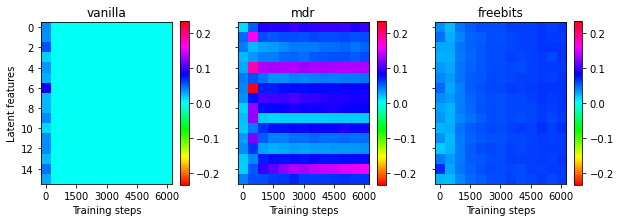

In [103]:
f, axes = plt.subplots(1, len(kls), figsize=(10, 3), sharex=True, sharey=True)
first = True
for ax, kl, name in zip(axes, kls, names):
    if first:
        ax.set_ylabel('Latent features')
        first = False
#     pcm = ax.imshow(kl.T, vmin=vmin, vmax=vmax, cmap='hsv')
    pcm = ax.imshow(kl.T, vmin=-vmax, vmax=vmax, cmap='hsv')
#     pcm = ax.imshow(kl.T)
    f.colorbar(pcm, ax=ax)
    ax.set_xlabel('Training steps')
    ax.set_title(name)
    ticks = np.arange(0, kl.shape[0], 3)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks * 500)


plt.savefig('KL.eps', bbox_inches='tight')
plt.show()

# Test Results

In [74]:
num_samples = 10

## Vanilla

In [8]:
saved_model_files = get_model_filenames('vanilla')
saved_model_files

['results_final/results0/vanilla/models/sentence_vae_3500.pt',
 'results_final/results1/vanilla/models/sentence_vae_3500.pt',
 'results_final/results2/vanilla/models/sentence_vae_3500.pt',
 'results_final/results3/vanilla/models/sentence_vae_3500.pt']

In [9]:
vanilla_nlls, vanilla_kls, vanilla_ppls = get_approx_nlls(saved_model_files)

  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 26.82it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].82it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].82it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.91it/s]

nll mean: 117.48368835449219 	 kl mean: 0.04554252326488495 	 loss mean: 117.52923583984375
nll mean: 117.51580810546875 	 kl mean: 0.04554252326488495 	 loss mean: 117.56134033203125
nll mean: 117.42424774169922 	 kl mean: 0.04554252326488495 	 loss mean: 117.46977996826172
nll mean: 117.4051513671875 	 kl mean: 0.04554252326488495 	 loss mean: 117.45069885253906
nll mean: 117.45576477050781 	 kl mean: 0.04554252326488495 	 loss mean: 117.50129699707031
nll mean: 117.50004577636719 	 kl mean: 0.04554252326488495 	 loss mean: 117.54557800292969



                                              
  0%|          | 0/38 [00:00<?, ?it/s].91it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].91it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.92it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:13,  2.66it/s]

nll mean: 117.49754333496094 	 kl mean: 0.04554252326488495 	 loss mean: 117.5430908203125
nll mean: 117.45332336425781 	 kl mean: 0.04554252326488495 	 loss mean: 117.49886322021484
nll mean: 117.49273681640625 	 kl mean: 0.04554252326488495 	 loss mean: 117.53826904296875
nll mean: 117.4657211303711 	 kl mean: 0.04554252326488495 	 loss mean: 117.51126098632812
nll mean: 132.69097900390625 	 kl mean: 0.052283305674791336 	 loss mean: 132.7432403564453



                                              
 20%|██        | 2/10 [00:00<00:00, 14.85it/s]
                                              
  3%|▎         | 1/38 [00:00<00:13,  2.66it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.24it/s]
                                              
  3%|▎         | 1/38 [00:00<00:13,  2.66it/s]

nll mean: 132.6949005126953 	 kl mean: 0.052283305674791336 	 loss mean: 132.74717712402344
nll mean: 132.69142150878906 	 kl mean: 0.052283305674791336 	 loss mean: 132.74371337890625
nll mean: 132.71240234375 	 kl mean: 0.052283305674791336 	 loss mean: 132.76467895507812
nll mean: 132.69775390625 	 kl mean: 0.052283305674791336 	 loss mean: 132.75003051757812



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.98it/s]
                                              
  3%|▎         | 1/38 [00:00<00:13,  2.66it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 15.18it/s]
                                              
  3%|▎         | 1/38 [00:00<00:13,  2.66it/s]

nll mean: 132.6004180908203 	 kl mean: 0.052283305674791336 	 loss mean: 132.6527099609375
nll mean: 132.622802734375 	 kl mean: 0.052283305674791336 	 loss mean: 132.6750946044922
nll mean: 132.70037841796875 	 kl mean: 0.052283305674791336 	 loss mean: 132.75267028808594
nll mean: 132.7308807373047 	 kl mean: 0.052283305674791336 	 loss mean: 132.7831573486328



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.17it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.17it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.62it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.17it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.17it/s]

nll mean: 132.69332885742188 	 kl mean: 0.052283305674791336 	 loss mean: 132.74562072753906
nll mean: 104.5389404296875 	 kl mean: 0.052214737981557846 	 loss mean: 104.59115600585938
nll mean: 104.47399139404297 	 kl mean: 0.052214737981557846 	 loss mean: 104.52621459960938
nll mean: 104.53289031982422 	 kl mean: 0.052214737981557846 	 loss mean: 104.5851058959961
nll mean: 104.51315307617188 	 kl mean: 0.052214737981557846 	 loss mean: 104.56535339355469
nll mean: 104.56057739257812 	 kl mean: 0.052214737981557846 	 loss mean: 104.61279296875



                                              
 60%|██████    | 6/10 [00:00<00:00, 27.41it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.17it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.17it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 27.01it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 104.47489929199219 	 kl mean: 0.052214737981557846 	 loss mean: 104.52710723876953
nll mean: 104.537841796875 	 kl mean: 0.052214737981557846 	 loss mean: 104.59005737304688
nll mean: 104.51109313964844 	 kl mean: 0.052214737981557846 	 loss mean: 104.56330871582031
nll mean: 104.6287841796875 	 kl mean: 0.052214737981557846 	 loss mean: 104.68099975585938
nll mean: 104.48572540283203 	 kl mean: 0.052214737981557846 	 loss mean: 104.5379409790039



                                              
  8%|▊         | 3/38 [00:01<00:15,  2.29it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.45it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.29it/s]

nll mean: 144.62820434570312 	 kl mean: 0.05813896656036377 	 loss mean: 144.68634033203125
nll mean: 144.68182373046875 	 kl mean: 0.05813896656036377 	 loss mean: 144.73995971679688
nll mean: 144.72018432617188 	 kl mean: 0.05813896656036377 	 loss mean: 144.7783203125



                                              
 40%|████      | 4/10 [00:00<00:00, 11.50it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.29it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.48it/s]

nll mean: 144.64108276367188 	 kl mean: 0.05813896656036377 	 loss mean: 144.69921875
nll mean: 144.6853790283203 	 kl mean: 0.05813896656036377 	 loss mean: 144.74351501464844
nll mean: 144.69424438476562 	 kl mean: 0.05813896656036377 	 loss mean: 144.75238037109375



                                              
  8%|▊         | 3/38 [00:02<00:15,  2.29it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.52it/s]
                                              
  8%|▊         | 3/38 [00:02<00:15,  2.29it/s]

nll mean: 144.63328552246094 	 kl mean: 0.05813896656036377 	 loss mean: 144.69142150878906
nll mean: 144.70602416992188 	 kl mean: 0.05813896656036377 	 loss mean: 144.76416015625
nll mean: 144.69314575195312 	 kl mean: 0.05813896656036377 	 loss mean: 144.7512969970703



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.76it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.89it/s]
                                           

nll mean: 144.66766357421875 	 kl mean: 0.05813896656036377 	 loss mean: 144.72579956054688
nll mean: 130.68057250976562 	 kl mean: 0.04776104912161827 	 loss mean: 130.72833251953125
nll mean: 130.779296875 	 kl mean: 0.04776104912161827 	 loss mean: 130.82705688476562


                                              
 11%|█         | 4/38 [00:02<00:19,  1.76it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.61it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.76it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.70it/s]

nll mean: 130.7522735595703 	 kl mean: 0.04776104912161827 	 loss mean: 130.80003356933594
nll mean: 130.76434326171875 	 kl mean: 0.04776104912161827 	 loss mean: 130.81210327148438
nll mean: 130.75762939453125 	 kl mean: 0.04776104912161827 	 loss mean: 130.80538940429688
nll mean: 130.74246215820312 	 kl mean: 0.04776104912161827 	 loss mean: 130.7902374267578



                                              
 11%|█         | 4/38 [00:02<00:19,  1.76it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 15.34it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.76it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 130.7750701904297 	 kl mean: 0.04776104912161827 	 loss mean: 130.8228302001953
nll mean: 130.6992950439453 	 kl mean: 0.04776104912161827 	 loss mean: 130.7470703125
nll mean: 130.69277954101562 	 kl mean: 0.04776104912161827 	 loss mean: 130.74053955078125
nll mean: 130.76820373535156 	 kl mean: 0.04776104912161827 	 loss mean: 130.81597900390625


                                              
 13%|█▎        | 5/38 [00:03<00:19,  1.68it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:19,  1.68it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.83it/s]

nll mean: 129.9972686767578 	 kl mean: 0.04873138666152954 	 loss mean: 130.04600524902344
nll mean: 129.92706298828125 	 kl mean: 0.04873138666152954 	 loss mean: 129.9757843017578
nll mean: 130.03982543945312 	 kl mean: 0.04873138666152954 	 loss mean: 130.08856201171875
nll mean: 130.02813720703125 	 kl mean: 0.04873138666152954 	 loss mean: 130.07687377929688


                                              
 13%|█▎        | 5/38 [00:03<00:19,  1.68it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.83it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:19,  1.68it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 15.49it/s]

nll mean: 129.96475219726562 	 kl mean: 0.04873138666152954 	 loss mean: 130.01348876953125
nll mean: 129.9678955078125 	 kl mean: 0.04873138666152954 	 loss mean: 130.01663208007812
nll mean: 129.94235229492188 	 kl mean: 0.04873138666152954 	 loss mean: 129.9910888671875
nll mean: 129.93438720703125 	 kl mean: 0.04873138666152954 	 loss mean: 129.98312377929688


                                              
 13%|█▎        | 5/38 [00:03<00:19,  1.68it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:19,  1.64it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:19,  1.64it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:19,  1.64it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 28.32it/s]

nll mean: 129.96795654296875 	 kl mean: 0.04873138666152954 	 loss mean: 130.0166778564453
nll mean: 129.932861328125 	 kl mean: 0.04873138666152954 	 loss mean: 129.98159790039062
nll mean: 139.29611206054688 	 kl mean: 0.0448867566883564 	 loss mean: 139.3409881591797
nll mean: 139.20298767089844 	 kl mean: 0.0448867566883564 	 loss mean: 139.24786376953125
nll mean: 139.21926879882812 	 kl mean: 0.0448867566883564 	 loss mean: 139.26416015625


                                              
 16%|█▌        | 6/38 [00:03<00:19,  1.64it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:19,  1.64it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 28.32it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:19,  1.64it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:19,  1.64it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 27.74it/s]

nll mean: 139.33309936523438 	 kl mean: 0.0448867566883564 	 loss mean: 139.37799072265625
nll mean: 139.21954345703125 	 kl mean: 0.0448867566883564 	 loss mean: 139.26443481445312
nll mean: 139.28517150878906 	 kl mean: 0.0448867566883564 	 loss mean: 139.33006286621094
nll mean: 139.28297424316406 	 kl mean: 0.0448867566883564 	 loss mean: 139.32785034179688
nll mean: 139.25320434570312 	 kl mean: 0.0448867566883564 	 loss mean: 139.298095703125
nll mean: 139.216796875 	 kl mean: 0.0448867566883564 	 loss mean: 139.26168823242188


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:16,  1.86it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:16,  1.86it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.19it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:16,  1.86it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:16,  1.86it/s]

nll mean: 139.27284240722656 	 kl mean: 0.0448867566883564 	 loss mean: 139.31773376464844
nll mean: 111.1477279663086 	 kl mean: 0.05411272495985031 	 loss mean: 111.20184326171875
nll mean: 111.06344604492188 	 kl mean: 0.05411272495985031 	 loss mean: 111.1175537109375
nll mean: 111.19319915771484 	 kl mean: 0.05411272495985031 	 loss mean: 111.24730682373047
nll mean: 111.15827941894531 	 kl mean: 0.05411272495985031 	 loss mean: 111.21240234375
nll mean: 111.10624694824219 	 kl mean: 0.05411272495985031 	 loss mean: 111.16035461425781



                                              
 60%|██████    | 6/10 [00:00<00:00, 27.20it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:16,  1.86it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:16,  1.86it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 27.07it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 110.99960327148438 	 kl mean: 0.05411272495985031 	 loss mean: 111.05371856689453
nll mean: 111.16241455078125 	 kl mean: 0.05411272495985031 	 loss mean: 111.21652221679688
nll mean: 111.15060424804688 	 kl mean: 0.05411272495985031 	 loss mean: 111.2047119140625
nll mean: 111.14598083496094 	 kl mean: 0.05411272495985031 	 loss mean: 111.20010375976562
nll mean: 111.21299743652344 	 kl mean: 0.05411272495985031 	 loss mean: 111.26710510253906



                                              
 21%|██        | 8/38 [00:04<00:14,  2.04it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.90it/s]
                                              
 21%|██        | 8/38 [00:04<00:14,  2.04it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.98it/s]

nll mean: 137.38992309570312 	 kl mean: 0.047870535403490067 	 loss mean: 137.4377899169922
nll mean: 137.2480010986328 	 kl mean: 0.047870535403490067 	 loss mean: 137.29586791992188
nll mean: 137.315185546875 	 kl mean: 0.047870535403490067 	 loss mean: 137.363037109375
nll mean: 137.39791870117188 	 kl mean: 0.047870535403490067 	 loss mean: 137.44578552246094



                                              
 21%|██        | 8/38 [00:04<00:14,  2.04it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 16.08it/s]
                                              
 21%|██        | 8/38 [00:04<00:14,  2.04it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 16.13it/s]

nll mean: 137.35531616210938 	 kl mean: 0.047870535403490067 	 loss mean: 137.4031982421875
nll mean: 137.42147827148438 	 kl mean: 0.047870535403490067 	 loss mean: 137.46932983398438
nll mean: 137.31436157226562 	 kl mean: 0.047870535403490067 	 loss mean: 137.36224365234375
nll mean: 137.39938354492188 	 kl mean: 0.047870535403490067 	 loss mean: 137.44725036621094



                                              
 21%|██        | 8/38 [00:04<00:14,  2.04it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.88it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.88it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 24.45it/s]

nll mean: 137.29379272460938 	 kl mean: 0.047870535403490067 	 loss mean: 137.34169006347656
nll mean: 137.39865112304688 	 kl mean: 0.047870535403490067 	 loss mean: 137.446533203125
nll mean: 137.73947143554688 	 kl mean: 0.0455901175737381 	 loss mean: 137.78506469726562
nll mean: 137.7498016357422 	 kl mean: 0.0455901175737381 	 loss mean: 137.79539489746094
nll mean: 137.83160400390625 	 kl mean: 0.0455901175737381 	 loss mean: 137.877197265625



                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.88it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.88it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 24.15it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.88it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.88it/s]

nll mean: 137.71505737304688 	 kl mean: 0.0455901175737381 	 loss mean: 137.7606658935547
nll mean: 137.74021911621094 	 kl mean: 0.0455901175737381 	 loss mean: 137.7858123779297
nll mean: 137.75425720214844 	 kl mean: 0.0455901175737381 	 loss mean: 137.7998504638672
nll mean: 137.75123596191406 	 kl mean: 0.0455901175737381 	 loss mean: 137.79681396484375
nll mean: 137.76119995117188 	 kl mean: 0.0455901175737381 	 loss mean: 137.80679321289062



                                              
 90%|█████████ | 9/10 [00:00<00:00, 23.61it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.99it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.99it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.24it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.99it/s][A

nll mean: 137.75547790527344 	 kl mean: 0.0455901175737381 	 loss mean: 137.8010711669922
nll mean: 137.75257873535156 	 kl mean: 0.0455901175737381 	 loss mean: 137.7981719970703
nll mean: 124.0475845336914 	 kl mean: 0.04020965099334717 	 loss mean: 124.0877914428711
nll mean: 124.02197265625 	 kl mean: 0.04020965099334717 	 loss mean: 124.06217956542969
nll mean: 124.1171646118164 	 kl mean: 0.04020965099334717 	 loss mean: 124.15737915039062
nll mean: 124.1383056640625 	 kl mean: 0.04020965099334717 	 loss mean: 124.17852020263672



                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.99it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 27.12it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.99it/s][A
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.99it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.95it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.14257049560547 	 kl mean: 0.04020965099334717 	 loss mean: 124.18277740478516
nll mean: 124.13705444335938 	 kl mean: 0.04020965099334717 	 loss mean: 124.17726135253906
nll mean: 124.05982971191406 	 kl mean: 0.04020965099334717 	 loss mean: 124.10003662109375
nll mean: 124.07730102539062 	 kl mean: 0.04020965099334717 	 loss mean: 124.11750793457031
nll mean: 124.04330444335938 	 kl mean: 0.04020965099334717 	 loss mean: 124.08351135253906
nll mean: 124.0135726928711 	 kl mean: 0.04020965099334717 	 loss mean: 124.05377960205078



                                               
 29%|██▉       | 11/38 [00:05<00:12,  2.15it/s]
                                               
 29%|██▉       | 11/38 [00:05<00:12,  2.15it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.64it/s]
                                               
 29%|██▉       | 11/38 [00:05<00:12,  2.15it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:12,  2.15it/s][A

nll mean: 146.99021911621094 	 kl mean: 0.043540000915527344 	 loss mean: 147.03375244140625
nll mean: 146.913330078125 	 kl mean: 0.043540000915527344 	 loss mean: 146.9568634033203
nll mean: 146.96339416503906 	 kl mean: 0.043540000915527344 	 loss mean: 147.00692749023438
nll mean: 146.90553283691406 	 kl mean: 0.043540000915527344 	 loss mean: 146.94906616210938
nll mean: 146.9073028564453 	 kl mean: 0.043540000915527344 	 loss mean: 146.95083618164062



                                               
 60%|██████    | 6/10 [00:00<00:00, 23.65it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:12,  2.15it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:12,  2.15it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 23.41it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 146.89244079589844 	 kl mean: 0.043540000915527344 	 loss mean: 146.93597412109375
nll mean: 146.87600708007812 	 kl mean: 0.043540000915527344 	 loss mean: 146.91954040527344
nll mean: 146.84011840820312 	 kl mean: 0.043540000915527344 	 loss mean: 146.8836669921875
nll mean: 146.94358825683594 	 kl mean: 0.043540000915527344 	 loss mean: 146.98712158203125
nll mean: 146.91265869140625 	 kl mean: 0.043540000915527344 	 loss mean: 146.95620727539062



                                               
 32%|███▏      | 12/38 [00:06<00:11,  2.20it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.14it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:11,  2.20it/s][A

nll mean: 123.8028564453125 	 kl mean: 0.04781860113143921 	 loss mean: 123.85067749023438
nll mean: 123.82272338867188 	 kl mean: 0.04781860113143921 	 loss mean: 123.87054443359375
nll mean: 123.82220458984375 	 kl mean: 0.04781860113143921 	 loss mean: 123.87001037597656



                                               
 40%|████      | 4/10 [00:00<00:00, 13.13it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:11,  2.20it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.23it/s]

nll mean: 123.72703552246094 	 kl mean: 0.04781860113143921 	 loss mean: 123.77485656738281
nll mean: 123.84867858886719 	 kl mean: 0.04781860113143921 	 loss mean: 123.89649963378906
nll mean: 123.81584167480469 	 kl mean: 0.04781860113143921 	 loss mean: 123.86366271972656



                                               
 32%|███▏      | 12/38 [00:06<00:11,  2.20it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.17it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:11,  2.20it/s][A

nll mean: 123.7791976928711 	 kl mean: 0.04781860113143921 	 loss mean: 123.82701873779297
nll mean: 123.79747772216797 	 kl mean: 0.04781860113143921 	 loss mean: 123.84529876708984
nll mean: 123.74085998535156 	 kl mean: 0.04781860113143921 	 loss mean: 123.78868103027344



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:13,  1.83it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.81842041015625 	 kl mean: 0.04781860113143921 	 loss mean: 123.8662338256836
nll mean: 168.0272216796875 	 kl mean: 0.05177302658557892 	 loss mean: 168.07899475097656
nll mean: 168.144287109375 	 kl mean: 0.05177302658557892 	 loss mean: 168.19606018066406


 20%|██        | 2/10 [00:00<00:00, 10.49it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:13,  1.83it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.46it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:13,  1.83it/s][A

nll mean: 168.07797241210938 	 kl mean: 0.05177302658557892 	 loss mean: 168.12974548339844
nll mean: 167.95521545410156 	 kl mean: 0.05177302658557892 	 loss mean: 168.00698852539062
nll mean: 168.14422607421875 	 kl mean: 0.05177302658557892 	 loss mean: 168.19601440429688



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.44it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:13,  1.83it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.42it/s]

nll mean: 168.00926208496094 	 kl mean: 0.05177302658557892 	 loss mean: 168.06103515625
nll mean: 168.04205322265625 	 kl mean: 0.05177302658557892 	 loss mean: 168.09381103515625
nll mean: 168.10353088378906 	 kl mean: 0.05177302658557892 	 loss mean: 168.15530395507812



                                               
 34%|███▍      | 13/38 [00:07<00:13,  1.83it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s]

nll mean: 168.04454040527344 	 kl mean: 0.05177302658557892 	 loss mean: 168.0963134765625
nll mean: 168.08905029296875 	 kl mean: 0.05177302658557892 	 loss mean: 168.14083862304688
nll mean: 139.8961181640625 	 kl mean: 0.05442781746387482 	 loss mean: 139.95053100585938



                                               
 20%|██        | 2/10 [00:00<00:00, 19.97it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 19.78it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s][A

nll mean: 139.83416748046875 	 kl mean: 0.05442781746387482 	 loss mean: 139.88861083984375
nll mean: 139.8575439453125 	 kl mean: 0.05442781746387482 	 loss mean: 139.91195678710938
nll mean: 139.8287811279297 	 kl mean: 0.05442781746387482 	 loss mean: 139.88320922851562
nll mean: 139.83212280273438 	 kl mean: 0.05442781746387482 	 loss mean: 139.88653564453125



                                               
 60%|██████    | 6/10 [00:00<00:00, 19.70it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 19.60it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s][A

nll mean: 139.89833068847656 	 kl mean: 0.05442781746387482 	 loss mean: 139.9527587890625
nll mean: 139.88827514648438 	 kl mean: 0.05442781746387482 	 loss mean: 139.94271850585938
nll mean: 139.78839111328125 	 kl mean: 0.05442781746387482 	 loss mean: 139.8428192138672
nll mean: 139.86642456054688 	 kl mean: 0.05442781746387482 	 loss mean: 139.92086791992188



                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.59it/s]
                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.59it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.32it/s]

nll mean: 139.90542602539062 	 kl mean: 0.05442781746387482 	 loss mean: 139.95986938476562
nll mean: 148.06097412109375 	 kl mean: 0.04723987728357315 	 loss mean: 148.10821533203125
nll mean: 148.05801391601562 	 kl mean: 0.04723987728357315 	 loss mean: 148.10525512695312


                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.59it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.32it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.39it/s]

nll mean: 148.09637451171875 	 kl mean: 0.04723987728357315 	 loss mean: 148.14361572265625
nll mean: 148.12185668945312 	 kl mean: 0.04723987728357315 	 loss mean: 148.16908264160156
nll mean: 148.05337524414062 	 kl mean: 0.04723987728357315 	 loss mean: 148.10061645507812


                                               
 40%|████      | 4/10 [00:00<00:00, 11.39it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.59it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.41it/s]

nll mean: 148.111328125 	 kl mean: 0.04723987728357315 	 loss mean: 148.1585693359375
nll mean: 148.17294311523438 	 kl mean: 0.04723987728357315 	 loss mean: 148.22018432617188
nll mean: 148.10362243652344 	 kl mean: 0.04723987728357315 	 loss mean: 148.15086364746094


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.59it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.42it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.42it/s]

nll mean: 148.09178161621094 	 kl mean: 0.04723987728357315 	 loss mean: 148.13900756835938
nll mean: 148.10696411132812 	 kl mean: 0.04723987728357315 	 loss mean: 148.15419006347656
nll mean: 150.49307250976562 	 kl mean: 0.05448995903134346 	 loss mean: 150.5475616455078
nll mean: 150.49481201171875 	 kl mean: 0.05448995903134346 	 loss mean: 150.54930114746094



                                               
 30%|███       | 3/10 [00:00<00:00, 27.47it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.42it/s][A
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.42it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.99it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.42it/s][A
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.42it/s][A

nll mean: 150.4227752685547 	 kl mean: 0.05448995903134346 	 loss mean: 150.47726440429688
nll mean: 150.52383422851562 	 kl mean: 0.05448995903134346 	 loss mean: 150.57833862304688
nll mean: 150.35177612304688 	 kl mean: 0.05448995903134346 	 loss mean: 150.40625
nll mean: 150.51040649414062 	 kl mean: 0.05448995903134346 	 loss mean: 150.56491088867188
nll mean: 150.48556518554688 	 kl mean: 0.05448995903134346 	 loss mean: 150.54005432128906
nll mean: 150.4471435546875 	 kl mean: 0.05448995903134346 	 loss mean: 150.50164794921875



                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.86it/s]
                                               
 45%|████▍     | 17/38 [00:09<00:12,  1.65it/s]
                                               
 45%|████▍     | 17/38 [00:09<00:12,  1.65it/s]
                                               
 45%|████▍     | 17/38 [00:09<00:12,  1.65it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.47it/s]

nll mean: 150.4969024658203 	 kl mean: 0.05448995903134346 	 loss mean: 150.5513916015625
nll mean: 150.447021484375 	 kl mean: 0.05448995903134346 	 loss mean: 150.5015106201172
nll mean: 139.62149047851562 	 kl mean: 0.048931967467069626 	 loss mean: 139.67041015625
nll mean: 139.57647705078125 	 kl mean: 0.048931967467069626 	 loss mean: 139.62539672851562
nll mean: 139.63778686523438 	 kl mean: 0.048931967467069626 	 loss mean: 139.68673706054688
nll mean: 139.49609375 	 kl mean: 0.048931967467069626 	 loss mean: 139.54501342773438


                                               
 45%|████▍     | 17/38 [00:09<00:12,  1.65it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.47it/s]
                                               [A
 45%|████▍     | 17/38 [00:09<00:12,  1.65it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:12,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.14it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 139.6230010986328 	 kl mean: 0.048931967467069626 	 loss mean: 139.67193603515625
nll mean: 139.53883361816406 	 kl mean: 0.048931967467069626 	 loss mean: 139.5877685546875
nll mean: 139.589599609375 	 kl mean: 0.048931967467069626 	 loss mean: 139.63851928710938
nll mean: 139.5867919921875 	 kl mean: 0.048931967467069626 	 loss mean: 139.6357421875
nll mean: 139.54269409179688 	 kl mean: 0.048931967467069626 	 loss mean: 139.5916290283203
nll mean: 139.49302673339844 	 kl mean: 0.048931967467069626 	 loss mean: 139.54196166992188


                                               
 47%|████▋     | 18/38 [00:10<00:10,  1.86it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.48it/s]

nll mean: 136.72671508789062 	 kl mean: 0.048692379146814346 	 loss mean: 136.77540588378906
nll mean: 136.8157958984375 	 kl mean: 0.048692379146814346 	 loss mean: 136.864501953125
nll mean: 136.8260498046875 	 kl mean: 0.048692379146814346 	 loss mean: 136.87472534179688


                                               
 20%|██        | 2/10 [00:00<00:00, 13.48it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:10,  1.86it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.39it/s]

nll mean: 136.84487915039062 	 kl mean: 0.048692379146814346 	 loss mean: 136.89356994628906
nll mean: 136.84339904785156 	 kl mean: 0.048692379146814346 	 loss mean: 136.89208984375
nll mean: 136.77499389648438 	 kl mean: 0.048692379146814346 	 loss mean: 136.82366943359375


                                               
 47%|████▋     | 18/38 [00:10<00:10,  1.86it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.39it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.43it/s]

nll mean: 136.72190856933594 	 kl mean: 0.048692379146814346 	 loss mean: 136.77061462402344
nll mean: 136.795166015625 	 kl mean: 0.048692379146814346 	 loss mean: 136.84385681152344
nll mean: 136.73562622070312 	 kl mean: 0.048692379146814346 	 loss mean: 136.78431701660156


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 50%|█████     | 19/38 [00:10<00:11,  1.66it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 14.00it/s]

nll mean: 136.72332763671875 	 kl mean: 0.048692379146814346 	 loss mean: 136.77203369140625
nll mean: 154.41159057617188 	 kl mean: 0.04129062592983246 	 loss mean: 154.452880859375
nll mean: 154.33822631835938 	 kl mean: 0.04129062592983246 	 loss mean: 154.3795166015625



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.66it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.70it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.66it/s][A

nll mean: 154.40386962890625 	 kl mean: 0.04129062592983246 	 loss mean: 154.44515991210938
nll mean: 154.30435180664062 	 kl mean: 0.04129062592983246 	 loss mean: 154.34564208984375
nll mean: 154.45147705078125 	 kl mean: 0.04129062592983246 	 loss mean: 154.49276733398438



                                               
 60%|██████    | 6/10 [00:00<00:00, 13.62it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.66it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.63it/s]

nll mean: 154.34451293945312 	 kl mean: 0.04129062592983246 	 loss mean: 154.38580322265625
nll mean: 154.33412170410156 	 kl mean: 0.04129062592983246 	 loss mean: 154.3754119873047
nll mean: 154.3697509765625 	 kl mean: 0.04129062592983246 	 loss mean: 154.41104125976562



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.66it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 53%|█████▎    | 20/38 [00:11<00:11,  1.55it/s]

nll mean: 154.34176635742188 	 kl mean: 0.04129062592983246 	 loss mean: 154.383056640625
nll mean: 154.39889526367188 	 kl mean: 0.04129062592983246 	 loss mean: 154.440185546875
nll mean: 162.35076904296875 	 kl mean: 0.051538869738578796 	 loss mean: 162.4022979736328



                                               
 20%|██        | 2/10 [00:00<00:00, 13.75it/s]
                                               
 53%|█████▎    | 20/38 [00:11<00:11,  1.55it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.68it/s]

nll mean: 162.32528686523438 	 kl mean: 0.051538869738578796 	 loss mean: 162.37681579589844
nll mean: 162.4786376953125 	 kl mean: 0.051538869738578796 	 loss mean: 162.53018188476562
nll mean: 162.366455078125 	 kl mean: 0.051538869738578796 	 loss mean: 162.41798400878906



                                               
 53%|█████▎    | 20/38 [00:11<00:11,  1.55it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.58it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.55it/s][A

nll mean: 162.44158935546875 	 kl mean: 0.051538869738578796 	 loss mean: 162.49313354492188
nll mean: 162.3671417236328 	 kl mean: 0.051538869738578796 	 loss mean: 162.41867065429688
nll mean: 162.4216766357422 	 kl mean: 0.051538869738578796 	 loss mean: 162.47320556640625



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.62it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.55it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 162.28753662109375 	 kl mean: 0.051538869738578796 	 loss mean: 162.33908081054688
nll mean: 162.30413818359375 	 kl mean: 0.051538869738578796 	 loss mean: 162.35568237304688
nll mean: 162.3970184326172 	 kl mean: 0.051538869738578796 	 loss mean: 162.4485626220703


                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.87it/s]

nll mean: 123.0052719116211 	 kl mean: 0.050619229674339294 	 loss mean: 123.05587768554688
nll mean: 123.03549194335938 	 kl mean: 0.050619229674339294 	 loss mean: 123.08610534667969
nll mean: 123.0112075805664 	 kl mean: 0.050619229674339294 	 loss mean: 123.06181335449219


                                               
 20%|██        | 2/10 [00:00<00:00, 10.87it/s]
                                               [A
 55%|█████▌    | 21/38 [00:12<00:11,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.88it/s]

nll mean: 122.97022247314453 	 kl mean: 0.050619229674339294 	 loss mean: 123.02084350585938
nll mean: 123.11930847167969 	 kl mean: 0.050619229674339294 	 loss mean: 123.169921875
nll mean: 123.09884643554688 	 kl mean: 0.050619229674339294 	 loss mean: 123.14946746826172


                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.88it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.87it/s]

nll mean: 123.00924682617188 	 kl mean: 0.050619229674339294 	 loss mean: 123.05986785888672
nll mean: 123.08704376220703 	 kl mean: 0.050619229674339294 	 loss mean: 123.13765716552734
nll mean: 123.02040100097656 	 kl mean: 0.050619229674339294 	 loss mean: 123.07101440429688


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.33it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.33it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.33it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 36.14it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.33it/s][A
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.33it/s][A

nll mean: 122.97278594970703 	 kl mean: 0.050619229674339294 	 loss mean: 123.02340698242188
nll mean: 111.06837463378906 	 kl mean: 0.03705066442489624 	 loss mean: 111.10542297363281
nll mean: 111.14701843261719 	 kl mean: 0.03705066442489624 	 loss mean: 111.18406677246094
nll mean: 111.01396179199219 	 kl mean: 0.03705066442489624 	 loss mean: 111.05101013183594
nll mean: 111.11370086669922 	 kl mean: 0.03705066442489624 	 loss mean: 111.15074157714844
nll mean: 111.11372375488281 	 kl mean: 0.03705066442489624 	 loss mean: 111.15077209472656
nll mean: 111.11203002929688 	 kl mean: 0.03705066442489624 	 loss mean: 111.14907836914062



                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.33it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 35.81it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.33it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 61%|██████    | 23/38 [00:13<00:09,  1.63it/s]

nll mean: 111.13021850585938 	 kl mean: 0.03705066442489624 	 loss mean: 111.16726684570312
nll mean: 111.20188903808594 	 kl mean: 0.03705066442489624 	 loss mean: 111.23894500732422
nll mean: 111.00352478027344 	 kl mean: 0.03705066442489624 	 loss mean: 111.04057312011719
nll mean: 111.15068054199219 	 kl mean: 0.03705066442489624 	 loss mean: 111.18772888183594
nll mean: 163.30581665039062 	 kl mean: 0.044066667556762695 	 loss mean: 163.34988403320312



                                               
 20%|██        | 2/10 [00:00<00:00, 15.60it/s]
                                               
 61%|██████    | 23/38 [00:13<00:09,  1.63it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.62it/s]
                                               
 61%|██████    | 23/38 [00:13<00:09,  1.63it/s][A

nll mean: 163.2333984375 	 kl mean: 0.044066667556762695 	 loss mean: 163.2774658203125
nll mean: 163.30691528320312 	 kl mean: 0.044066667556762695 	 loss mean: 163.35098266601562
nll mean: 163.2080078125 	 kl mean: 0.044066667556762695 	 loss mean: 163.2520751953125
nll mean: 163.17982482910156 	 kl mean: 0.044066667556762695 	 loss mean: 163.22389221191406



                                               
 60%|██████    | 6/10 [00:00<00:00, 15.64it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.63it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.56it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.63it/s][A

nll mean: 163.1710205078125 	 kl mean: 0.044066667556762695 	 loss mean: 163.215087890625
nll mean: 163.1678924560547 	 kl mean: 0.044066667556762695 	 loss mean: 163.21194458007812
nll mean: 163.26141357421875 	 kl mean: 0.044066667556762695 	 loss mean: 163.3054656982422
nll mean: 163.2773895263672 	 kl mean: 0.044066667556762695 	 loss mean: 163.3214569091797



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.60it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.60it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 24.47it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.60it/s][A

nll mean: 163.2677001953125 	 kl mean: 0.044066667556762695 	 loss mean: 163.311767578125
nll mean: 126.64616394042969 	 kl mean: 0.05070033296942711 	 loss mean: 126.69686889648438
nll mean: 126.67765808105469 	 kl mean: 0.05070033296942711 	 loss mean: 126.72836303710938
nll mean: 126.60274505615234 	 kl mean: 0.05070033296942711 	 loss mean: 126.65345764160156
nll mean: 126.56059265136719 	 kl mean: 0.05070033296942711 	 loss mean: 126.61129760742188



                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.60it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 24.11it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.60it/s][A
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.60it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 24.02it/s]

nll mean: 126.55052185058594 	 kl mean: 0.05070033296942711 	 loss mean: 126.60122680664062
nll mean: 126.58146667480469 	 kl mean: 0.05070033296942711 	 loss mean: 126.63215637207031
nll mean: 126.60720825195312 	 kl mean: 0.05070033296942711 	 loss mean: 126.65790557861328
nll mean: 126.63401794433594 	 kl mean: 0.05070033296942711 	 loss mean: 126.6847152709961
nll mean: 126.66616821289062 	 kl mean: 0.05070033296942711 	 loss mean: 126.71685791015625



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 66%|██████▌   | 25/38 [00:14<00:07,  1.77it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.52it/s]
                                               
 66%|██████▌   | 25/38 [00:14<00:07,  1.77it/s][A

nll mean: 126.5938720703125 	 kl mean: 0.05070033296942711 	 loss mean: 126.64458465576172
nll mean: 120.97355651855469 	 kl mean: 0.04911566898226738 	 loss mean: 121.02267456054688
nll mean: 120.87570190429688 	 kl mean: 0.04911566898226738 	 loss mean: 120.92481231689453
nll mean: 120.95832061767578 	 kl mean: 0.04911566898226738 	 loss mean: 121.0074462890625



                                               
 40%|████      | 4/10 [00:00<00:00, 15.58it/s]
                                               
 66%|██████▌   | 25/38 [00:14<00:07,  1.77it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.61it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.77it/s][A

nll mean: 120.8498306274414 	 kl mean: 0.04911566898226738 	 loss mean: 120.89894104003906
nll mean: 120.89459228515625 	 kl mean: 0.04911566898226738 	 loss mean: 120.94371032714844
nll mean: 120.94256591796875 	 kl mean: 0.04911566898226738 	 loss mean: 120.99168395996094
nll mean: 120.87938690185547 	 kl mean: 0.04911566898226738 	 loss mean: 120.92849731445312



                                               
 80%|████████  | 8/10 [00:00<00:00, 15.70it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.77it/s][A
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.8359603881836 	 kl mean: 0.04911566898226738 	 loss mean: 120.88507843017578
nll mean: 120.91181945800781 	 kl mean: 0.04911566898226738 	 loss mean: 120.9609375
nll mean: 120.80253601074219 	 kl mean: 0.04911566898226738 	 loss mean: 120.85165405273438
nll mean: 87.33264923095703 	 kl mean: 0.06718866527080536 	 loss mean: 87.39984130859375


                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.70it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 24.67it/s]

nll mean: 87.36451721191406 	 kl mean: 0.06718866527080536 	 loss mean: 87.43170166015625
nll mean: 87.4387435913086 	 kl mean: 0.06718866527080536 	 loss mean: 87.50593566894531
nll mean: 87.33489990234375 	 kl mean: 0.06718866527080536 	 loss mean: 87.40209197998047
nll mean: 87.3049087524414 	 kl mean: 0.06718866527080536 	 loss mean: 87.3720932006836
nll mean: 87.37541198730469 	 kl mean: 0.06718866527080536 	 loss mean: 87.44259643554688


                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.70it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 24.67it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 71%|███████   | 27/38 [00:15<00:05,  1.86it/s]

nll mean: 87.30718994140625 	 kl mean: 0.06718866527080536 	 loss mean: 87.37437438964844
nll mean: 87.30144500732422 	 kl mean: 0.06718866527080536 	 loss mean: 87.36863708496094
nll mean: 87.34967803955078 	 kl mean: 0.06718866527080536 	 loss mean: 87.4168701171875
nll mean: 87.32645416259766 	 kl mean: 0.06718866527080536 	 loss mean: 87.39364624023438
nll mean: 113.97205352783203 	 kl mean: 0.04064653813838959 	 loss mean: 114.0126953125



                                               
 71%|███████   | 27/38 [00:15<00:05,  1.86it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.97it/s]
                                               
 71%|███████   | 27/38 [00:15<00:05,  1.86it/s][A
                                               
 71%|███████   | 27/38 [00:15<00:05,  1.86it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 23.82it/s]

nll mean: 113.96315002441406 	 kl mean: 0.04064653813838959 	 loss mean: 114.00379943847656
nll mean: 113.96255493164062 	 kl mean: 0.04064653813838959 	 loss mean: 114.0031967163086
nll mean: 113.89410400390625 	 kl mean: 0.04064653813838959 	 loss mean: 113.93476104736328
nll mean: 113.88175201416016 	 kl mean: 0.04064653813838959 	 loss mean: 113.92239379882812
nll mean: 113.94133758544922 	 kl mean: 0.04064653813838959 	 loss mean: 113.98197937011719



                                               
 71%|███████   | 27/38 [00:16<00:05,  1.86it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:05,  1.86it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 23.69it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.94508361816406 	 kl mean: 0.04064653813838959 	 loss mean: 113.9857406616211
nll mean: 113.84529113769531 	 kl mean: 0.04064653813838959 	 loss mean: 113.88594055175781
nll mean: 113.894775390625 	 kl mean: 0.04064653813838959 	 loss mean: 113.9354248046875
nll mean: 113.88243865966797 	 kl mean: 0.04064653813838959 	 loss mean: 113.92308044433594



                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.98it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.36it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.98it/s][A

nll mean: 126.02142333984375 	 kl mean: 0.04468752071261406 	 loss mean: 126.06610107421875
nll mean: 126.05345916748047 	 kl mean: 0.04468752071261406 	 loss mean: 126.09814453125
nll mean: 126.0330810546875 	 kl mean: 0.04468752071261406 	 loss mean: 126.07776641845703



                                               
 40%|████      | 4/10 [00:00<00:00, 13.50it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.98it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.43it/s]

nll mean: 125.96514892578125 	 kl mean: 0.04468752071261406 	 loss mean: 126.00984191894531
nll mean: 126.00704193115234 	 kl mean: 0.04468752071261406 	 loss mean: 126.05172729492188
nll mean: 125.99368286132812 	 kl mean: 0.04468752071261406 	 loss mean: 126.03837585449219



                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.98it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.41it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.98it/s][A

nll mean: 125.92290496826172 	 kl mean: 0.04468752071261406 	 loss mean: 125.96759796142578
nll mean: 126.05367279052734 	 kl mean: 0.04468752071261406 	 loss mean: 126.09835815429688
nll mean: 125.98687744140625 	 kl mean: 0.04468752071261406 	 loss mean: 126.03155517578125



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 76%|███████▋  | 29/38 [00:16<00:05,  1.73it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.68it/s]

nll mean: 125.96272277832031 	 kl mean: 0.04468752071261406 	 loss mean: 126.00740814208984
nll mean: 66.73136138916016 	 kl mean: 0.04071469232439995 	 loss mean: 66.77207946777344
nll mean: 66.86257934570312 	 kl mean: 0.04071469232439995 	 loss mean: 66.90328979492188



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.73it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.70it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.73it/s][A

nll mean: 66.72142791748047 	 kl mean: 0.04071469232439995 	 loss mean: 66.76214599609375
nll mean: 66.83790588378906 	 kl mean: 0.04071469232439995 	 loss mean: 66.87862396240234
nll mean: 66.77511596679688 	 kl mean: 0.04071469232439995 	 loss mean: 66.81582641601562



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.70it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.73it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.70it/s]

nll mean: 66.7314453125 	 kl mean: 0.04071469232439995 	 loss mean: 66.77215576171875
nll mean: 66.80619049072266 	 kl mean: 0.04071469232439995 	 loss mean: 66.84690856933594
nll mean: 66.7882080078125 	 kl mean: 0.04071469232439995 	 loss mean: 66.82891845703125



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.73it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:17<00:05,  1.45it/s]

nll mean: 66.80070495605469 	 kl mean: 0.04071469232439995 	 loss mean: 66.84141540527344
nll mean: 66.62973022460938 	 kl mean: 0.04071469232439995 	 loss mean: 66.67044067382812
nll mean: 110.123046875 	 kl mean: 0.053182847797870636 	 loss mean: 110.17622375488281



                                               
 20%|██        | 2/10 [00:00<00:00, 13.63it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.45it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.60it/s]

nll mean: 110.17616271972656 	 kl mean: 0.053182847797870636 	 loss mean: 110.2293472290039
nll mean: 110.1353759765625 	 kl mean: 0.053182847797870636 	 loss mean: 110.18856048583984
nll mean: 110.18342590332031 	 kl mean: 0.053182847797870636 	 loss mean: 110.23660278320312



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.45it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.65it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.45it/s][A

nll mean: 110.17135620117188 	 kl mean: 0.053182847797870636 	 loss mean: 110.22453308105469
nll mean: 110.1605224609375 	 kl mean: 0.053182847797870636 	 loss mean: 110.21370697021484
nll mean: 110.17112731933594 	 kl mean: 0.053182847797870636 	 loss mean: 110.22430419921875



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.69it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.45it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 110.17797088623047 	 kl mean: 0.053182847797870636 	 loss mean: 110.23115539550781
nll mean: 110.17915344238281 	 kl mean: 0.053182847797870636 	 loss mean: 110.23234558105469
nll mean: 110.0976333618164 	 kl mean: 0.053182847797870636 	 loss mean: 110.15081787109375



                                               
 82%|████████▏ | 31/38 [00:18<00:04,  1.42it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.50it/s]
                                               
 82%|████████▏ | 31/38 [00:18<00:04,  1.42it/s][A

nll mean: 142.9273681640625 	 kl mean: 0.05795404314994812 	 loss mean: 142.98532104492188
nll mean: 142.92056274414062 	 kl mean: 0.05795404314994812 	 loss mean: 142.978515625
nll mean: 142.97300720214844 	 kl mean: 0.05795404314994812 	 loss mean: 143.0309600830078



                                               
 40%|████      | 4/10 [00:00<00:00, 10.50it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:04,  1.42it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.49it/s]

nll mean: 142.99801635742188 	 kl mean: 0.05795404314994812 	 loss mean: 143.05596923828125
nll mean: 142.94895935058594 	 kl mean: 0.05795404314994812 	 loss mean: 143.0069122314453
nll mean: 142.94415283203125 	 kl mean: 0.05795404314994812 	 loss mean: 143.0021209716797



                                               
 82%|████████▏ | 31/38 [00:19<00:04,  1.42it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.53it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:04,  1.42it/s][A

nll mean: 142.92147827148438 	 kl mean: 0.05795404314994812 	 loss mean: 142.97943115234375
nll mean: 142.97560119628906 	 kl mean: 0.05795404314994812 	 loss mean: 143.03355407714844
nll mean: 142.94825744628906 	 kl mean: 0.05795404314994812 	 loss mean: 143.00621032714844



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 84%|████████▍ | 32/38 [00:19<00:04,  1.28it/s]
                                               
 84%|████████▍ | 32/38 [00:19<00:04,  1.28it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 28.64it/s]
                                               
 84%|████████▍ | 32/38 [00:19<00:04,  1.28it/s][A
                                               
 84%|████████▍ | 32/38 [00:19<00:04,  1.28it/s][A

nll mean: 142.9385986328125 	 kl mean: 0.05795404314994812 	 loss mean: 142.99655151367188
nll mean: 68.36286926269531 	 kl mean: 0.04233042150735855 	 loss mean: 68.40519714355469
nll mean: 68.48262023925781 	 kl mean: 0.04233042150735855 	 loss mean: 68.52495574951172
nll mean: 68.35281372070312 	 kl mean: 0.04233042150735855 	 loss mean: 68.3951416015625
nll mean: 68.46343994140625 	 kl mean: 0.04233042150735855 	 loss mean: 68.50576782226562
nll mean: 68.47679138183594 	 kl mean: 0.04233042150735855 	 loss mean: 68.51911926269531



                                               
 60%|██████    | 6/10 [00:00<00:00, 28.21it/s]
                                               
 84%|████████▍ | 32/38 [00:19<00:04,  1.28it/s][A
                                               
 84%|████████▍ | 32/38 [00:19<00:04,  1.28it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 28.05it/s]
                                               
 87%|████████▋ | 33/38 [00:19<00:03,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 68.42460632324219 	 kl mean: 0.04233042150735855 	 loss mean: 68.46693420410156
nll mean: 68.50957489013672 	 kl mean: 0.04233042150735855 	 loss mean: 68.55189514160156
nll mean: 68.50965118408203 	 kl mean: 0.04233042150735855 	 loss mean: 68.55198669433594
nll mean: 68.44542694091797 	 kl mean: 0.04233042150735855 	 loss mean: 68.48775482177734
nll mean: 68.556884765625 	 kl mean: 0.04233042150735855 	 loss mean: 68.59921264648438
nll mean: 123.94700622558594 	 kl mean: 0.0475754588842392 	 loss mean: 123.99458312988281


                                               
 87%|████████▋ | 33/38 [00:19<00:03,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.53it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.53it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.38it/s]

nll mean: 123.93690490722656 	 kl mean: 0.0475754588842392 	 loss mean: 123.98448181152344
nll mean: 123.93367004394531 	 kl mean: 0.0475754588842392 	 loss mean: 123.98125457763672
nll mean: 123.94404602050781 	 kl mean: 0.0475754588842392 	 loss mean: 123.99160766601562
nll mean: 123.89620208740234 	 kl mean: 0.0475754588842392 	 loss mean: 123.94378662109375
nll mean: 123.97286987304688 	 kl mean: 0.0475754588842392 	 loss mean: 124.02044677734375


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.53it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.53it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.38it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.94955444335938 	 kl mean: 0.0475754588842392 	 loss mean: 123.99713134765625
nll mean: 124.02000427246094 	 kl mean: 0.0475754588842392 	 loss mean: 124.06757354736328
nll mean: 124.02070617675781 	 kl mean: 0.0475754588842392 	 loss mean: 124.06828308105469
nll mean: 123.94464111328125 	 kl mean: 0.0475754588842392 	 loss mean: 123.9922103881836



                                               
 89%|████████▉ | 34/38 [00:20<00:02,  1.70it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.30it/s]
                                               
 89%|████████▉ | 34/38 [00:20<00:02,  1.70it/s][A

nll mean: 124.82974243164062 	 kl mean: 0.03724836930632591 	 loss mean: 124.86699676513672
nll mean: 124.79989624023438 	 kl mean: 0.03724836930632591 	 loss mean: 124.8371353149414
nll mean: 124.8437271118164 	 kl mean: 0.03724836930632591 	 loss mean: 124.8809814453125



                                               
 40%|████      | 4/10 [00:00<00:00, 13.26it/s]
                                               
 89%|████████▉ | 34/38 [00:20<00:02,  1.70it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.46it/s]

nll mean: 124.88349914550781 	 kl mean: 0.03724836930632591 	 loss mean: 124.92073822021484
nll mean: 124.82294464111328 	 kl mean: 0.03724836930632591 	 loss mean: 124.86018371582031
nll mean: 124.88241577148438 	 kl mean: 0.03724836930632591 	 loss mean: 124.91967010498047



                                               
 89%|████████▉ | 34/38 [00:20<00:02,  1.70it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.37it/s]
                                               
 89%|████████▉ | 34/38 [00:20<00:02,  1.70it/s][A

nll mean: 124.84517669677734 	 kl mean: 0.03724836930632591 	 loss mean: 124.88243103027344
nll mean: 124.74674224853516 	 kl mean: 0.03724836930632591 	 loss mean: 124.78398895263672
nll mean: 124.85907745361328 	 kl mean: 0.03724836930632591 	 loss mean: 124.89632415771484



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.57it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.12it/s]

nll mean: 124.83035278320312 	 kl mean: 0.03724836930632591 	 loss mean: 124.86759948730469
nll mean: 118.584716796875 	 kl mean: 0.053908638656139374 	 loss mean: 118.63862609863281
nll mean: 118.57846069335938 	 kl mean: 0.053908638656139374 	 loss mean: 118.63237762451172



                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.57it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 11.14it/s]
                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.57it/s][A

nll mean: 118.523193359375 	 kl mean: 0.053908638656139374 	 loss mean: 118.57710266113281
nll mean: 118.47103881835938 	 kl mean: 0.053908638656139374 	 loss mean: 118.52494812011719
nll mean: 118.50886535644531 	 kl mean: 0.053908638656139374 	 loss mean: 118.56277465820312



                                               
 60%|██████    | 6/10 [00:00<00:00, 11.19it/s]
                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.57it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 11.14it/s]

nll mean: 118.49935913085938 	 kl mean: 0.053908638656139374 	 loss mean: 118.55326843261719
nll mean: 118.51773071289062 	 kl mean: 0.053908638656139374 	 loss mean: 118.57164001464844
nll mean: 118.45112609863281 	 kl mean: 0.053908638656139374 	 loss mean: 118.50503540039062



                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.57it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.40it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.40it/s]

nll mean: 118.5431137084961 	 kl mean: 0.053908638656139374 	 loss mean: 118.59701538085938
nll mean: 118.56977081298828 	 kl mean: 0.053908638656139374 	 loss mean: 118.6236801147461
nll mean: 118.21183013916016 	 kl mean: 0.05541873723268509 	 loss mean: 118.26725006103516
nll mean: 118.25531768798828 	 kl mean: 0.05541873723268509 	 loss mean: 118.31073760986328



                                               
 30%|███       | 3/10 [00:00<00:00, 24.28it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.40it/s][A
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.40it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 24.28it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.40it/s][A

nll mean: 118.2970962524414 	 kl mean: 0.05541873723268509 	 loss mean: 118.3525161743164
nll mean: 118.20156860351562 	 kl mean: 0.05541873723268509 	 loss mean: 118.25699615478516
nll mean: 118.04145050048828 	 kl mean: 0.05541873723268509 	 loss mean: 118.09687042236328
nll mean: 118.14225769042969 	 kl mean: 0.05541873723268509 	 loss mean: 118.19768524169922
nll mean: 118.28536224365234 	 kl mean: 0.05541873723268509 	 loss mean: 118.34077453613281



                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.40it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 24.11it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.59it/s]
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.59it/s]
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.59it/s]

nll mean: 118.11944580078125 	 kl mean: 0.05541873723268509 	 loss mean: 118.17485046386719
nll mean: 118.16908264160156 	 kl mean: 0.05541873723268509 	 loss mean: 118.22450256347656
nll mean: 118.21237182617188 	 kl mean: 0.05541873723268509 	 loss mean: 118.26778411865234
nll mean: 90.84081268310547 	 kl mean: 0.047700222581624985 	 loss mean: 90.88851165771484
nll mean: 90.85458374023438 	 kl mean: 0.047700222581624985 	 loss mean: 90.90228271484375
nll mean: 90.8545150756836 	 kl mean: 0.047700222581624985 	 loss mean: 90.9022216796875



                                               
 40%|████      | 4/10 [00:00<00:00, 33.39it/s]
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.59it/s][A
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.59it/s][A
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.59it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 33.26it/s]
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.59it/s][A
                                               
100%|██████████| 38/38 [00:22<00:00,  1.67it/s]


nll mean: 90.80208587646484 	 kl mean: 0.047700222581624985 	 loss mean: 90.84978485107422
nll mean: 90.75933074951172 	 kl mean: 0.047700222581624985 	 loss mean: 90.80703735351562
nll mean: 90.82872009277344 	 kl mean: 0.047700222581624985 	 loss mean: 90.87641906738281
nll mean: 90.83604431152344 	 kl mean: 0.047700222581624985 	 loss mean: 90.88374328613281
nll mean: 90.67535400390625 	 kl mean: 0.047700222581624985 	 loss mean: 90.72305297851562
nll mean: 90.72938537597656 	 kl mean: 0.047700222581624985 	 loss mean: 90.77709197998047
nll mean: 90.86436462402344 	 kl mean: 0.047700222581624985 	 loss mean: 90.91206359863281
Approximate NLL:
tensor(126.9942, device='cuda:0')
Approximate KL:
tensor(0.0486, device='cuda:0')
Testing took 0:00:47.034618


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .66it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .66it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .66it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.65it/s]

nll mean: 116.2105941772461 	 kl mean: 0.04677597060799599 	 loss mean: 116.25736999511719
nll mean: 116.28559875488281 	 kl mean: 0.04677597060799599 	 loss mean: 116.33236694335938
nll mean: 116.26927947998047 	 kl mean: 0.04677597060799599 	 loss mean: 116.3160629272461
nll mean: 116.37152099609375 	 kl mean: 0.04677597060799599 	 loss mean: 116.41830444335938
nll mean: 116.24592590332031 	 kl mean: 0.04677597060799599 	 loss mean: 116.29269409179688
nll mean: 116.2857894897461 	 kl mean: 0.04677597060799599 	 loss mean: 116.33256530761719


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .65it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .65it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.65it/s]
                                      .53it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.60it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.33930969238281 	 kl mean: 0.04677597060799599 	 loss mean: 116.38609313964844
nll mean: 116.29290008544922 	 kl mean: 0.04677597060799599 	 loss mean: 116.33967590332031
nll mean: 116.2550277709961 	 kl mean: 0.04677597060799599 	 loss mean: 116.30180358886719
nll mean: 116.36029052734375 	 kl mean: 0.04677597060799599 	 loss mean: 116.40707397460938
nll mean: 131.43209838867188 	 kl mean: 0.04498990252614021 	 loss mean: 131.47708129882812


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.60it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.22it/s]


nll mean: 131.45486450195312 	 kl mean: 0.04498990252614021 	 loss mean: 131.49984741210938
nll mean: 131.39382934570312 	 kl mean: 0.04498990252614021 	 loss mean: 131.43881225585938
nll mean: 131.44871520996094 	 kl mean: 0.04498990252614021 	 loss mean: 131.49371337890625



  3%|▎         | 1/38 [00:00<00:14,  2.60it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.58it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.60it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.81it/s]

nll mean: 131.42430114746094 	 kl mean: 0.04498990252614021 	 loss mean: 131.46929931640625
nll mean: 131.4722900390625 	 kl mean: 0.04498990252614021 	 loss mean: 131.51727294921875
nll mean: 131.4960479736328 	 kl mean: 0.04498990252614021 	 loss mean: 131.54104614257812
nll mean: 131.52090454101562 	 kl mean: 0.04498990252614021 	 loss mean: 131.56588745117188


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.60it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.12it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.12it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.12it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.11it/s]

nll mean: 131.4503173828125 	 kl mean: 0.04498990252614021 	 loss mean: 131.49533081054688
nll mean: 131.5613250732422 	 kl mean: 0.04498990252614021 	 loss mean: 131.60630798339844
nll mean: 105.13058471679688 	 kl mean: 0.051116373389959335 	 loss mean: 105.18170166015625
nll mean: 105.17095947265625 	 kl mean: 0.051116373389959335 	 loss mean: 105.22207641601562
nll mean: 105.17164611816406 	 kl mean: 0.051116373389959335 	 loss mean: 105.22276306152344


                                              
  5%|▌         | 2/38 [00:01<00:16,  2.12it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.12it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.11it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.12it/s]
                                              
  5%|▌         | 2/38 [00:01<00:16,  2.12it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.37it/s]

nll mean: 105.23558807373047 	 kl mean: 0.051116373389959335 	 loss mean: 105.28670501708984
nll mean: 105.34861755371094 	 kl mean: 0.051116373389959335 	 loss mean: 105.39973449707031
nll mean: 105.19253540039062 	 kl mean: 0.051116373389959335 	 loss mean: 105.24365234375
nll mean: 105.27032470703125 	 kl mean: 0.051116373389959335 	 loss mean: 105.32144165039062
nll mean: 105.24884033203125 	 kl mean: 0.051116373389959335 	 loss mean: 105.29995727539062
nll mean: 105.33844757080078 	 kl mean: 0.051116373389959335 	 loss mean: 105.38956451416016


                                              
  8%|▊         | 3/38 [00:01<00:15,  2.24it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.24it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.31it/s]

nll mean: 105.21157836914062 	 kl mean: 0.051116373389959335 	 loss mean: 105.26270294189453
nll mean: 144.62814331054688 	 kl mean: 0.05574717000126839 	 loss mean: 144.6838836669922
nll mean: 144.7000732421875 	 kl mean: 0.05574717000126839 	 loss mean: 144.75579833984375


                                              
  8%|▊         | 3/38 [00:01<00:15,  2.24it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.31it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.34it/s]

nll mean: 144.707275390625 	 kl mean: 0.05574717000126839 	 loss mean: 144.76300048828125
nll mean: 144.69500732421875 	 kl mean: 0.05574717000126839 	 loss mean: 144.750732421875
nll mean: 144.74142456054688 	 kl mean: 0.05574717000126839 	 loss mean: 144.79718017578125


                                              
 40%|████      | 4/10 [00:00<00:00, 11.34it/s]
                                              
  8%|▊         | 3/38 [00:02<00:15,  2.24it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.29it/s]

nll mean: 144.74176025390625 	 kl mean: 0.05574717000126839 	 loss mean: 144.79751586914062
nll mean: 144.78924560546875 	 kl mean: 0.05574717000126839 	 loss mean: 144.84500122070312
nll mean: 144.74880981445312 	 kl mean: 0.05574717000126839 	 loss mean: 144.80455017089844


                                              
  8%|▊         | 3/38 [00:02<00:15,  2.24it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 144.68844604492188 	 kl mean: 0.05574717000126839 	 loss mean: 144.74417114257812
nll mean: 144.66493225097656 	 kl mean: 0.05574717000126839 	 loss mean: 144.72067260742188
nll mean: 131.45140075683594 	 kl mean: 0.04855237901210785 	 loss mean: 131.4999542236328


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.88it/s]

nll mean: 131.48880004882812 	 kl mean: 0.04855237901210785 	 loss mean: 131.537353515625
nll mean: 131.50270080566406 	 kl mean: 0.04855237901210785 	 loss mean: 131.55123901367188
nll mean: 131.4852294921875 	 kl mean: 0.04855237901210785 	 loss mean: 131.5337677001953


                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.88it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.84it/s]

nll mean: 131.45245361328125 	 kl mean: 0.04855237901210785 	 loss mean: 131.50100708007812
nll mean: 131.4879913330078 	 kl mean: 0.04855237901210785 	 loss mean: 131.53652954101562
nll mean: 131.47613525390625 	 kl mean: 0.04855237901210785 	 loss mean: 131.52468872070312


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.84it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 131.4633331298828 	 kl mean: 0.04855237901210785 	 loss mean: 131.5118865966797
nll mean: 131.38552856445312 	 kl mean: 0.04855237901210785 	 loss mean: 131.43406677246094
nll mean: 131.45799255371094 	 kl mean: 0.04855237901210785 	 loss mean: 131.50653076171875


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.64it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.64it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.00it/s]

nll mean: 129.3936767578125 	 kl mean: 0.04237170144915581 	 loss mean: 129.43603515625
nll mean: 129.60775756835938 	 kl mean: 0.04237170144915581 	 loss mean: 129.65013122558594
nll mean: 129.54234313964844 	 kl mean: 0.04237170144915581 	 loss mean: 129.584716796875
nll mean: 129.56240844726562 	 kl mean: 0.04237170144915581 	 loss mean: 129.60476684570312


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.64it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.00it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.93it/s]

nll mean: 129.5008544921875 	 kl mean: 0.04237170144915581 	 loss mean: 129.54324340820312
nll mean: 129.49481201171875 	 kl mean: 0.04237170144915581 	 loss mean: 129.53717041015625
nll mean: 129.5440216064453 	 kl mean: 0.04237170144915581 	 loss mean: 129.58639526367188


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.93it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.64it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 129.55508422851562 	 kl mean: 0.04237170144915581 	 loss mean: 129.59744262695312
nll mean: 129.5263671875 	 kl mean: 0.04237170144915581 	 loss mean: 129.56875610351562
nll mean: 129.5904541015625 	 kl mean: 0.04237170144915581 	 loss mean: 129.63282775878906
nll mean: 139.00204467773438 	 kl mean: 0.03907628357410431 	 loss mean: 139.04110717773438


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.59it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.59it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.68it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 27.20it/s]

nll mean: 139.04522705078125 	 kl mean: 0.03907628357410431 	 loss mean: 139.08428955078125
nll mean: 138.94227600097656 	 kl mean: 0.03907628357410431 	 loss mean: 138.98135375976562
nll mean: 138.93972778320312 	 kl mean: 0.03907628357410431 	 loss mean: 138.9788055419922
nll mean: 138.9001007080078 	 kl mean: 0.03907628357410431 	 loss mean: 138.9391632080078
nll mean: 138.98391723632812 	 kl mean: 0.03907628357410431 	 loss mean: 139.0229949951172
nll mean: 139.0505828857422 	 kl mean: 0.03907628357410431 	 loss mean: 139.08966064453125


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.59it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 27.20it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.80it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.80it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.80it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.38it/s]

nll mean: 139.0096435546875 	 kl mean: 0.03907628357410431 	 loss mean: 139.0487060546875
nll mean: 139.04290771484375 	 kl mean: 0.03907628357410431 	 loss mean: 139.08197021484375
nll mean: 139.04229736328125 	 kl mean: 0.03907628357410431 	 loss mean: 139.0813751220703
nll mean: 112.23102569580078 	 kl mean: 0.048479922115802765 	 loss mean: 112.27950286865234
nll mean: 112.25932312011719 	 kl mean: 0.048479922115802765 	 loss mean: 112.30780029296875
nll mean: 112.27494812011719 	 kl mean: 0.048479922115802765 	 loss mean: 112.32342529296875


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.80it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.80it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.38it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.80it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.80it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.93it/s]

nll mean: 112.23774719238281 	 kl mean: 0.048479922115802765 	 loss mean: 112.2862319946289
nll mean: 112.23966217041016 	 kl mean: 0.048479922115802765 	 loss mean: 112.28814697265625
nll mean: 112.23875427246094 	 kl mean: 0.048479922115802765 	 loss mean: 112.2872314453125
nll mean: 112.2103500366211 	 kl mean: 0.048479922115802765 	 loss mean: 112.25883483886719
nll mean: 112.19664764404297 	 kl mean: 0.048479922115802765 	 loss mean: 112.24513244628906
nll mean: 112.18938446044922 	 kl mean: 0.048479922115802765 	 loss mean: 112.23786926269531


                                              
 21%|██        | 8/38 [00:04<00:15,  1.99it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.99it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.66it/s]

nll mean: 112.16242980957031 	 kl mean: 0.048479922115802765 	 loss mean: 112.21089935302734
nll mean: 137.9816436767578 	 kl mean: 0.04216358810663223 	 loss mean: 138.0238037109375
nll mean: 138.02200317382812 	 kl mean: 0.04216358810663223 	 loss mean: 138.06417846679688
nll mean: 137.99533081054688 	 kl mean: 0.04216358810663223 	 loss mean: 138.03750610351562


                                              
 20%|██        | 2/10 [00:00<00:00, 14.66it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.99it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.20it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.49it/s]

nll mean: 137.91543579101562 	 kl mean: 0.04216358810663223 	 loss mean: 137.9575958251953
nll mean: 137.96250915527344 	 kl mean: 0.04216358810663223 	 loss mean: 138.00466918945312
nll mean: 137.94049072265625 	 kl mean: 0.04216358810663223 	 loss mean: 137.982666015625
nll mean: 137.91659545898438 	 kl mean: 0.04216358810663223 	 loss mean: 137.958740234375


                                              
 60%|██████    | 6/10 [00:00<00:00, 15.49it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.99it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.83it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 138.0186767578125 	 kl mean: 0.04216358810663223 	 loss mean: 138.06085205078125
nll mean: 137.92666625976562 	 kl mean: 0.04216358810663223 	 loss mean: 137.96884155273438
nll mean: 137.933837890625 	 kl mean: 0.04216358810663223 	 loss mean: 137.97601318359375
nll mean: 136.84677124023438 	 kl mean: 0.04301464557647705 	 loss mean: 136.88978576660156


                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.83it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.83it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.83it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 23.08it/s]

nll mean: 136.757080078125 	 kl mean: 0.04301464557647705 	 loss mean: 136.80007934570312
nll mean: 136.8056640625 	 kl mean: 0.04301464557647705 	 loss mean: 136.8486785888672
nll mean: 136.75018310546875 	 kl mean: 0.04301464557647705 	 loss mean: 136.79318237304688
nll mean: 136.84385681152344 	 kl mean: 0.04301464557647705 	 loss mean: 136.88687133789062
nll mean: 136.8665771484375 	 kl mean: 0.04301464557647705 	 loss mean: 136.90960693359375


                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.83it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:15,  1.83it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 23.08it/s]
                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.94it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 136.80416870117188 	 kl mean: 0.04301464557647705 	 loss mean: 136.84718322753906
nll mean: 136.79293823242188 	 kl mean: 0.04301464557647705 	 loss mean: 136.83596801757812
nll mean: 136.77993774414062 	 kl mean: 0.04301464557647705 	 loss mean: 136.82293701171875
nll mean: 136.88134765625 	 kl mean: 0.04301464557647705 	 loss mean: 136.9243621826172
nll mean: 123.63430786132812 	 kl mean: 0.039846353232860565 	 loss mean: 123.67414855957031


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.94it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.94it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.94it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.85it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.50it/s]

nll mean: 123.67279052734375 	 kl mean: 0.039846353232860565 	 loss mean: 123.712646484375
nll mean: 123.63685607910156 	 kl mean: 0.039846353232860565 	 loss mean: 123.67668914794922
nll mean: 123.61366271972656 	 kl mean: 0.039846353232860565 	 loss mean: 123.65350341796875
nll mean: 123.66273498535156 	 kl mean: 0.039846353232860565 	 loss mean: 123.70258331298828
nll mean: 123.61264038085938 	 kl mean: 0.039846353232860565 	 loss mean: 123.65248107910156
nll mean: 123.55085754394531 	 kl mean: 0.039846353232860565 	 loss mean: 123.59070587158203


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.94it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.50it/s]
                                               [A
 29%|██▉       | 11/38 [00:05<00:12,  2.10it/s]
                                               
 29%|██▉       | 11/38 [00:05<00:12,  2.10it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.62078094482422 	 kl mean: 0.039846353232860565 	 loss mean: 123.66062927246094
nll mean: 123.69286346435547 	 kl mean: 0.039846353232860565 	 loss mean: 123.73271942138672
nll mean: 123.62665557861328 	 kl mean: 0.039846353232860565 	 loss mean: 123.66650390625
nll mean: 147.19976806640625 	 kl mean: 0.047599487006664276 	 loss mean: 147.2473602294922
nll mean: 147.1495819091797 	 kl mean: 0.047599487006664276 	 loss mean: 147.1971893310547


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:12,  2.10it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:12,  2.10it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.30it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.92it/s]

nll mean: 147.1967010498047 	 kl mean: 0.047599487006664276 	 loss mean: 147.24429321289062
nll mean: 147.13302612304688 	 kl mean: 0.047599487006664276 	 loss mean: 147.18063354492188
nll mean: 147.2606658935547 	 kl mean: 0.047599487006664276 	 loss mean: 147.3082733154297
nll mean: 147.1067352294922 	 kl mean: 0.047599487006664276 	 loss mean: 147.15432739257812
nll mean: 147.18951416015625 	 kl mean: 0.047599487006664276 	 loss mean: 147.23712158203125


                                               
 29%|██▉       | 11/38 [00:06<00:12,  2.10it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.92it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 147.2239227294922 	 kl mean: 0.047599487006664276 	 loss mean: 147.27151489257812
nll mean: 147.1768035888672 	 kl mean: 0.047599487006664276 	 loss mean: 147.22439575195312
nll mean: 147.20782470703125 	 kl mean: 0.047599487006664276 	 loss mean: 147.25543212890625
nll mean: 125.4704360961914 	 kl mean: 0.04081382229924202 	 loss mean: 125.5112533569336


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.91it/s]

nll mean: 125.4683837890625 	 kl mean: 0.04081382229924202 	 loss mean: 125.50920104980469
nll mean: 125.444580078125 	 kl mean: 0.04081382229924202 	 loss mean: 125.48539733886719
nll mean: 125.36870574951172 	 kl mean: 0.04081382229924202 	 loss mean: 125.40951538085938


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.91it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.97it/s]

nll mean: 125.44937133789062 	 kl mean: 0.04081382229924202 	 loss mean: 125.49019622802734
nll mean: 125.46299743652344 	 kl mean: 0.04081382229924202 	 loss mean: 125.50381469726562
nll mean: 125.48481750488281 	 kl mean: 0.04081382229924202 	 loss mean: 125.52564239501953


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.97it/s]
                                               [A
 32%|███▏      | 12/38 [00:07<00:12,  2.14it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.49654388427734 	 kl mean: 0.04081382229924202 	 loss mean: 125.53736114501953
nll mean: 125.51325988769531 	 kl mean: 0.04081382229924202 	 loss mean: 125.5540771484375
nll mean: 125.4505386352539 	 kl mean: 0.04081382229924202 	 loss mean: 125.49136352539062


                                               
 34%|███▍      | 13/38 [00:07<00:13,  1.80it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.60it/s]

nll mean: 168.4256134033203 	 kl mean: 0.050489865243434906 	 loss mean: 168.47610473632812
nll mean: 168.53524780273438 	 kl mean: 0.050489865243434906 	 loss mean: 168.58572387695312
nll mean: 168.61895751953125 	 kl mean: 0.050489865243434906 	 loss mean: 168.66944885253906


                                               
 20%|██        | 2/10 [00:00<00:00, 10.60it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:13,  1.80it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.56it/s]

nll mean: 168.48231506347656 	 kl mean: 0.050489865243434906 	 loss mean: 168.53280639648438
nll mean: 168.5588836669922 	 kl mean: 0.050489865243434906 	 loss mean: 168.609375
nll mean: 168.59548950195312 	 kl mean: 0.050489865243434906 	 loss mean: 168.64598083496094


                                               
 34%|███▍      | 13/38 [00:07<00:13,  1.80it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.56it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.56it/s]

nll mean: 168.57382202148438 	 kl mean: 0.050489865243434906 	 loss mean: 168.6243133544922
nll mean: 168.49755859375 	 kl mean: 0.050489865243434906 	 loss mean: 168.54803466796875
nll mean: 168.47787475585938 	 kl mean: 0.050489865243434906 	 loss mean: 168.5283660888672


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.87it/s]

nll mean: 168.50643920898438 	 kl mean: 0.050489865243434906 	 loss mean: 168.55691528320312
nll mean: 140.60467529296875 	 kl mean: 0.046792253851890564 	 loss mean: 140.65145874023438
nll mean: 140.705078125 	 kl mean: 0.046792253851890564 	 loss mean: 140.75186157226562
nll mean: 140.58737182617188 	 kl mean: 0.046792253851890564 	 loss mean: 140.63417053222656


                                               
 20%|██        | 2/10 [00:00<00:00, 19.87it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 19.53it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 19.33it/s]

nll mean: 140.7138671875 	 kl mean: 0.046792253851890564 	 loss mean: 140.76065063476562
nll mean: 140.63653564453125 	 kl mean: 0.046792253851890564 	 loss mean: 140.68331909179688
nll mean: 140.65042114257812 	 kl mean: 0.046792253851890564 	 loss mean: 140.6972198486328
nll mean: 140.679931640625 	 kl mean: 0.046792253851890564 	 loss mean: 140.72671508789062


                                               
 60%|██████    | 6/10 [00:00<00:00, 19.33it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.48it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.6441192626953 	 kl mean: 0.046792253851890564 	 loss mean: 140.69091796875
nll mean: 140.68417358398438 	 kl mean: 0.046792253851890564 	 loss mean: 140.73095703125
nll mean: 140.65756225585938 	 kl mean: 0.046792253851890564 	 loss mean: 140.704345703125


                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.23it/s]

nll mean: 150.0847930908203 	 kl mean: 0.043636731803417206 	 loss mean: 150.12841796875
nll mean: 150.0631561279297 	 kl mean: 0.043636731803417206 	 loss mean: 150.10678100585938
nll mean: 150.10089111328125 	 kl mean: 0.043636731803417206 	 loss mean: 150.14451599121094


                                               
 20%|██        | 2/10 [00:00<00:00, 11.23it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.27it/s]

nll mean: 150.00770568847656 	 kl mean: 0.043636731803417206 	 loss mean: 150.05133056640625
nll mean: 150.09486389160156 	 kl mean: 0.043636731803417206 	 loss mean: 150.1385040283203
nll mean: 150.0297088623047 	 kl mean: 0.043636731803417206 	 loss mean: 150.07333374023438


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.27it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.24it/s]

nll mean: 150.06768798828125 	 kl mean: 0.043636731803417206 	 loss mean: 150.111328125
nll mean: 149.9634552001953 	 kl mean: 0.043636731803417206 	 loss mean: 150.00709533691406
nll mean: 150.01519775390625 	 kl mean: 0.043636731803417206 	 loss mean: 150.058837890625


                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.41it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.41it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.41it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.41it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.57it/s]

nll mean: 150.06813049316406 	 kl mean: 0.043636731803417206 	 loss mean: 150.11178588867188
nll mean: 150.68402099609375 	 kl mean: 0.0529838502407074 	 loss mean: 150.7370147705078
nll mean: 150.5767822265625 	 kl mean: 0.0529838502407074 	 loss mean: 150.6297607421875
nll mean: 150.5952911376953 	 kl mean: 0.0529838502407074 	 loss mean: 150.64828491210938
nll mean: 150.70912170410156 	 kl mean: 0.0529838502407074 	 loss mean: 150.76211547851562
nll mean: 150.53932189941406 	 kl mean: 0.0529838502407074 	 loss mean: 150.59230041503906


                                               
 30%|███       | 3/10 [00:00<00:00, 26.57it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.41it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.41it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.56it/s]
                                               [A
 45%|████▍     | 17/38 [00:09<00:12,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 150.6791229248047 	 kl mean: 0.0529838502407074 	 loss mean: 150.73211669921875
nll mean: 150.6458740234375 	 kl mean: 0.0529838502407074 	 loss mean: 150.69886779785156
nll mean: 150.57461547851562 	 kl mean: 0.0529838502407074 	 loss mean: 150.6276092529297
nll mean: 150.59628295898438 	 kl mean: 0.0529838502407074 	 loss mean: 150.64926147460938
nll mean: 150.71722412109375 	 kl mean: 0.0529838502407074 	 loss mean: 150.77020263671875
nll mean: 139.4765167236328 	 kl mean: 0.0411556214094162 	 loss mean: 139.51766967773438


                                               
 45%|████▍     | 17/38 [00:09<00:12,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:12,  1.63it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:12,  1.63it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.52it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.64it/s]

nll mean: 139.48025512695312 	 kl mean: 0.0411556214094162 	 loss mean: 139.52139282226562
nll mean: 139.43905639648438 	 kl mean: 0.0411556214094162 	 loss mean: 139.48020935058594
nll mean: 139.43283081054688 	 kl mean: 0.0411556214094162 	 loss mean: 139.4739990234375
nll mean: 139.49484252929688 	 kl mean: 0.0411556214094162 	 loss mean: 139.53598022460938
nll mean: 139.45115661621094 	 kl mean: 0.0411556214094162 	 loss mean: 139.4923095703125
nll mean: 139.43023681640625 	 kl mean: 0.0411556214094162 	 loss mean: 139.47140502929688


                                               
 45%|████▍     | 17/38 [00:10<00:12,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.64it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:10,  1.84it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 139.3523712158203 	 kl mean: 0.0411556214094162 	 loss mean: 139.39352416992188
nll mean: 139.45108032226562 	 kl mean: 0.0411556214094162 	 loss mean: 139.4922332763672
nll mean: 139.47674560546875 	 kl mean: 0.0411556214094162 	 loss mean: 139.51791381835938
nll mean: 137.27593994140625 	 kl mean: 0.04436784237623215 	 loss mean: 137.32029724121094


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:10,  1.84it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.07it/s]

nll mean: 137.373779296875 	 kl mean: 0.04436784237623215 	 loss mean: 137.41815185546875
nll mean: 137.3386993408203 	 kl mean: 0.04436784237623215 	 loss mean: 137.38308715820312
nll mean: 137.25376892089844 	 kl mean: 0.04436784237623215 	 loss mean: 137.2981414794922


                                               
 47%|████▋     | 18/38 [00:10<00:10,  1.84it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.13it/s]

nll mean: 137.3454132080078 	 kl mean: 0.04436784237623215 	 loss mean: 137.3897705078125
nll mean: 137.2877960205078 	 kl mean: 0.04436784237623215 	 loss mean: 137.3321533203125
nll mean: 137.3118438720703 	 kl mean: 0.04436784237623215 	 loss mean: 137.356201171875


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.13it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:10,  1.84it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 137.23126220703125 	 kl mean: 0.04436784237623215 	 loss mean: 137.275634765625
nll mean: 137.3572998046875 	 kl mean: 0.04436784237623215 	 loss mean: 137.40167236328125
nll mean: 137.30650329589844 	 kl mean: 0.04436784237623215 	 loss mean: 137.35086059570312


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.09it/s]

nll mean: 152.13998413085938 	 kl mean: 0.0416901595890522 	 loss mean: 152.18167114257812
nll mean: 152.19461059570312 	 kl mean: 0.0416901595890522 	 loss mean: 152.23629760742188
nll mean: 152.23191833496094 	 kl mean: 0.0416901595890522 	 loss mean: 152.2736053466797


                                               
 20%|██        | 2/10 [00:00<00:00, 13.09it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.11it/s]

nll mean: 152.2157440185547 	 kl mean: 0.0416901595890522 	 loss mean: 152.25743103027344
nll mean: 152.2508544921875 	 kl mean: 0.0416901595890522 	 loss mean: 152.2925567626953
nll mean: 152.21270751953125 	 kl mean: 0.0416901595890522 	 loss mean: 152.25439453125


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.11it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.19it/s]

nll mean: 152.24624633789062 	 kl mean: 0.0416901595890522 	 loss mean: 152.28793334960938
nll mean: 152.16539001464844 	 kl mean: 0.0416901595890522 	 loss mean: 152.20709228515625
nll mean: 152.18215942382812 	 kl mean: 0.0416901595890522 	 loss mean: 152.22384643554688


                                               
 53%|█████▎    | 20/38 [00:11<00:11,  1.52it/s]
                                               
 53%|█████▎    | 20/38 [00:11<00:11,  1.52it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.35it/s]

nll mean: 152.21434020996094 	 kl mean: 0.0416901595890522 	 loss mean: 152.2560272216797
nll mean: 161.45742797851562 	 kl mean: 0.04471147805452347 	 loss mean: 161.50213623046875
nll mean: 161.36044311523438 	 kl mean: 0.04471147805452347 	 loss mean: 161.4051513671875


                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.52it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.35it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.43it/s]

nll mean: 161.45126342773438 	 kl mean: 0.04471147805452347 	 loss mean: 161.4959716796875
nll mean: 161.4223175048828 	 kl mean: 0.04471147805452347 	 loss mean: 161.46702575683594
nll mean: 161.54603576660156 	 kl mean: 0.04471147805452347 	 loss mean: 161.59075927734375


                                               
 40%|████      | 4/10 [00:00<00:00, 13.43it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:11,  1.52it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.38it/s]

nll mean: 161.48635864257812 	 kl mean: 0.04471147805452347 	 loss mean: 161.53106689453125
nll mean: 161.50149536132812 	 kl mean: 0.04471147805452347 	 loss mean: 161.54620361328125
nll mean: 161.50387573242188 	 kl mean: 0.04471147805452347 	 loss mean: 161.548583984375


                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.52it/s]
                                               [A
 55%|█████▌    | 21/38 [00:12<00:11,  1.46it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 161.47003173828125 	 kl mean: 0.04471147805452347 	 loss mean: 161.51473999023438
nll mean: 161.37603759765625 	 kl mean: 0.04471147805452347 	 loss mean: 161.42076110839844
nll mean: 122.49227905273438 	 kl mean: 0.0480264276266098 	 loss mean: 122.5403060913086


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 55%|█████▌    | 21/38 [00:12<00:11,  1.46it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.79it/s]

nll mean: 122.63999938964844 	 kl mean: 0.0480264276266098 	 loss mean: 122.68802642822266
nll mean: 122.53401184082031 	 kl mean: 0.0480264276266098 	 loss mean: 122.58203887939453
nll mean: 122.64797973632812 	 kl mean: 0.0480264276266098 	 loss mean: 122.69599914550781


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.46it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.72it/s]

nll mean: 122.56846618652344 	 kl mean: 0.0480264276266098 	 loss mean: 122.61648559570312
nll mean: 122.4937973022461 	 kl mean: 0.0480264276266098 	 loss mean: 122.54181671142578
nll mean: 122.43175506591797 	 kl mean: 0.0480264276266098 	 loss mean: 122.47978210449219


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.72it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.46it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 122.5965347290039 	 kl mean: 0.0480264276266098 	 loss mean: 122.6445541381836
nll mean: 122.56168365478516 	 kl mean: 0.0480264276266098 	 loss mean: 122.60971069335938
nll mean: 122.52069854736328 	 kl mean: 0.0480264276266098 	 loss mean: 122.56871795654297


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]


nll mean: 112.18955993652344 	 kl mean: 0.036267951130867004 	 loss mean: 112.22582244873047
nll mean: 112.23797607421875 	 kl mean: 0.036267951130867004 	 loss mean: 112.27423858642578
nll mean: 112.20585632324219 	 kl mean: 0.036267951130867004 	 loss mean: 112.24212646484375
nll mean: 112.26041412353516 	 kl mean: 0.036267951130867004 	 loss mean: 112.29668426513672
nll mean: 112.30816650390625 	 kl mean: 0.036267951130867004 	 loss mean: 112.34442901611328
nll mean: 112.231201171875 	 kl mean: 0.036267951130867004 	 loss mean: 112.26747131347656
nll mean: 112.33841705322266 	 kl mean: 0.036267951130867004 	 loss mean: 112.37467956542969
nll mean: 112.23384857177734 	 kl mean: 0.036267951130867004 	 loss mean: 112.27011108398438


 40%|████      | 4/10 [00:00<00:00, 35.93it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
 61%|██████    | 23/38 [00:13<00:09,  1.61it/s]
                                               
 61%|██████    | 23/38 [00:13<00:09,  1.61it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.32it/s]

nll mean: 112.2282485961914 	 kl mean: 0.036267951130867004 	 loss mean: 112.26451873779297
nll mean: 112.1942138671875 	 kl mean: 0.036267951130867004 	 loss mean: 112.23048400878906
nll mean: 162.98422241210938 	 kl mean: 0.044532760977745056 	 loss mean: 163.0287628173828
nll mean: 163.05519104003906 	 kl mean: 0.044532760977745056 	 loss mean: 163.0997314453125


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.61it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.32it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.61it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.36it/s]

nll mean: 163.0227508544922 	 kl mean: 0.044532760977745056 	 loss mean: 163.06729125976562
nll mean: 163.0263671875 	 kl mean: 0.044532760977745056 	 loss mean: 163.07089233398438
nll mean: 163.0924530029297 	 kl mean: 0.044532760977745056 	 loss mean: 163.13699340820312
nll mean: 162.96990966796875 	 kl mean: 0.044532760977745056 	 loss mean: 163.01443481445312


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.61it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.36it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.61it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:08,  1.59it/s]


nll mean: 162.93894958496094 	 kl mean: 0.044532760977745056 	 loss mean: 162.98348999023438
nll mean: 163.01007080078125 	 kl mean: 0.044532760977745056 	 loss mean: 163.05459594726562
nll mean: 162.9717559814453 	 kl mean: 0.044532760977745056 	 loss mean: 163.01629638671875
nll mean: 163.04541015625 	 kl mean: 0.044532760977745056 	 loss mean: 163.08993530273438


                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.59it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:08,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.78it/s]

nll mean: 127.47200012207031 	 kl mean: 0.043581925332546234 	 loss mean: 127.51557922363281
nll mean: 127.46347045898438 	 kl mean: 0.043581925332546234 	 loss mean: 127.50704956054688
nll mean: 127.44656372070312 	 kl mean: 0.043581925332546234 	 loss mean: 127.49014282226562
nll mean: 127.48143005371094 	 kl mean: 0.043581925332546234 	 loss mean: 127.52500915527344
nll mean: 127.4427490234375 	 kl mean: 0.043581925332546234 	 loss mean: 127.486328125


                                               
 30%|███       | 3/10 [00:00<00:00, 23.78it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:08,  1.59it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:08,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.50it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.48526000976562 	 kl mean: 0.043581925332546234 	 loss mean: 127.52884674072266
nll mean: 127.50642395019531 	 kl mean: 0.043581925332546234 	 loss mean: 127.55000305175781
nll mean: 127.5523910522461 	 kl mean: 0.043581925332546234 	 loss mean: 127.59597778320312
nll mean: 127.45462799072266 	 kl mean: 0.043581925332546234 	 loss mean: 127.49821472167969
nll mean: 127.49793243408203 	 kl mean: 0.043581925332546234 	 loss mean: 127.54151153564453


                                               
 66%|██████▌   | 25/38 [00:14<00:07,  1.74it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.74it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.31it/s]

nll mean: 120.21558380126953 	 kl mean: 0.03838637098670006 	 loss mean: 120.25396728515625
nll mean: 120.17095947265625 	 kl mean: 0.03838637098670006 	 loss mean: 120.20933532714844
nll mean: 120.18937683105469 	 kl mean: 0.03838637098670006 	 loss mean: 120.22776794433594
nll mean: 120.25056457519531 	 kl mean: 0.03838637098670006 	 loss mean: 120.28895568847656


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.74it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.31it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.74it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.32it/s]

nll mean: 120.19048309326172 	 kl mean: 0.03838637098670006 	 loss mean: 120.2288818359375
nll mean: 120.24712371826172 	 kl mean: 0.03838637098670006 	 loss mean: 120.28551483154297
nll mean: 120.18629455566406 	 kl mean: 0.03838637098670006 	 loss mean: 120.22468566894531
nll mean: 120.18992614746094 	 kl mean: 0.03838637098670006 	 loss mean: 120.22830963134766


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.74it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.67it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.67it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.67it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 24.63it/s]

nll mean: 120.25038146972656 	 kl mean: 0.03838637098670006 	 loss mean: 120.28877258300781
nll mean: 120.18119812011719 	 kl mean: 0.03838637098670006 	 loss mean: 120.21957397460938
nll mean: 87.4312744140625 	 kl mean: 0.06931839883327484 	 loss mean: 87.5005874633789
nll mean: 87.47740936279297 	 kl mean: 0.06931839883327484 	 loss mean: 87.54672241210938
nll mean: 87.36416625976562 	 kl mean: 0.06931839883327484 	 loss mean: 87.43348693847656


                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.67it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.67it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 24.63it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.67it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 24.05it/s]

nll mean: 87.57837677001953 	 kl mean: 0.06931839883327484 	 loss mean: 87.64768981933594
nll mean: 87.5350341796875 	 kl mean: 0.06931839883327484 	 loss mean: 87.60435485839844
nll mean: 87.42231750488281 	 kl mean: 0.06931839883327484 	 loss mean: 87.49163818359375
nll mean: 87.51365661621094 	 kl mean: 0.06931839883327484 	 loss mean: 87.58297729492188
nll mean: 87.56263732910156 	 kl mean: 0.06931839883327484 	 loss mean: 87.6319580078125


                                               
 60%|██████    | 6/10 [00:00<00:00, 24.05it/s]
                                               [A
 71%|███████   | 27/38 [00:15<00:06,  1.83it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.83it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.83it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.09it/s]

nll mean: 87.49618530273438 	 kl mean: 0.06931839883327484 	 loss mean: 87.56550598144531
nll mean: 87.46728515625 	 kl mean: 0.06931839883327484 	 loss mean: 87.53660583496094
nll mean: 114.82453918457031 	 kl mean: 0.04222520440816879 	 loss mean: 114.86676025390625
nll mean: 114.809814453125 	 kl mean: 0.04222520440816879 	 loss mean: 114.85203552246094
nll mean: 114.71025085449219 	 kl mean: 0.04222520440816879 	 loss mean: 114.75247955322266


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.83it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.83it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.09it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.83it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.20it/s]

nll mean: 114.77336120605469 	 kl mean: 0.04222520440816879 	 loss mean: 114.81558227539062
nll mean: 114.90269470214844 	 kl mean: 0.04222520440816879 	 loss mean: 114.94491577148438
nll mean: 114.75543975830078 	 kl mean: 0.04222520440816879 	 loss mean: 114.79766082763672
nll mean: 114.83798217773438 	 kl mean: 0.04222520440816879 	 loss mean: 114.88020324707031
nll mean: 114.67394256591797 	 kl mean: 0.04222520440816879 	 loss mean: 114.71617126464844


                                               
 60%|██████    | 6/10 [00:00<00:00, 23.20it/s]
                                               [A
 74%|███████▎  | 28/38 [00:16<00:05,  1.94it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.94it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.52it/s]

nll mean: 114.79645538330078 	 kl mean: 0.04222520440816879 	 loss mean: 114.83868408203125
nll mean: 114.78927612304688 	 kl mean: 0.04222520440816879 	 loss mean: 114.83150482177734
nll mean: 127.38349151611328 	 kl mean: 0.039602190256118774 	 loss mean: 127.423095703125
nll mean: 127.44439697265625 	 kl mean: 0.039602190256118774 	 loss mean: 127.48400115966797


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.94it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.29it/s]

nll mean: 127.39967346191406 	 kl mean: 0.039602190256118774 	 loss mean: 127.43927764892578
nll mean: 127.42997741699219 	 kl mean: 0.039602190256118774 	 loss mean: 127.4695816040039
nll mean: 127.40010833740234 	 kl mean: 0.039602190256118774 	 loss mean: 127.43971252441406


                                               
 40%|████      | 4/10 [00:00<00:00, 13.29it/s]
                                               [A
 74%|███████▎  | 28/38 [00:16<00:05,  1.94it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.34it/s]

nll mean: 127.35398864746094 	 kl mean: 0.039602190256118774 	 loss mean: 127.39358520507812
nll mean: 127.41339874267578 	 kl mean: 0.039602190256118774 	 loss mean: 127.4530029296875
nll mean: 127.37385559082031 	 kl mean: 0.039602190256118774 	 loss mean: 127.4134521484375


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.94it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.69it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.42274475097656 	 kl mean: 0.039602190256118774 	 loss mean: 127.46235656738281
nll mean: 127.36734008789062 	 kl mean: 0.039602190256118774 	 loss mean: 127.40693664550781
nll mean: 66.42031860351562 	 kl mean: 0.036557793617248535 	 loss mean: 66.45687866210938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.69it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.57it/s]

nll mean: 66.48876953125 	 kl mean: 0.036557793617248535 	 loss mean: 66.52532958984375
nll mean: 66.46034240722656 	 kl mean: 0.036557793617248535 	 loss mean: 66.49690246582031
nll mean: 66.50350952148438 	 kl mean: 0.036557793617248535 	 loss mean: 66.54006958007812


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.69it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.57it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.57it/s]

nll mean: 66.46675872802734 	 kl mean: 0.036557793617248535 	 loss mean: 66.5033187866211
nll mean: 66.40592956542969 	 kl mean: 0.036557793617248535 	 loss mean: 66.44248962402344
nll mean: 66.48609924316406 	 kl mean: 0.036557793617248535 	 loss mean: 66.52265930175781


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.57it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.69it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 66.53260803222656 	 kl mean: 0.036557793617248535 	 loss mean: 66.56916809082031
nll mean: 66.47915649414062 	 kl mean: 0.036557793617248535 	 loss mean: 66.5157241821289
nll mean: 66.49375915527344 	 kl mean: 0.036557793617248535 	 loss mean: 66.53031921386719


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.25it/s]

nll mean: 110.28507995605469 	 kl mean: 0.055683597922325134 	 loss mean: 110.34075927734375
nll mean: 110.31173706054688 	 kl mean: 0.055683597922325134 	 loss mean: 110.36741638183594
nll mean: 110.35237121582031 	 kl mean: 0.055683597922325134 	 loss mean: 110.4080581665039


                                               
 20%|██        | 2/10 [00:00<00:00, 13.25it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.43it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.33it/s]

nll mean: 110.39349365234375 	 kl mean: 0.055683597922325134 	 loss mean: 110.44917297363281
nll mean: 110.40104675292969 	 kl mean: 0.055683597922325134 	 loss mean: 110.45672607421875
nll mean: 110.28250122070312 	 kl mean: 0.055683597922325134 	 loss mean: 110.33818054199219


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.43it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.33it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.30it/s]

nll mean: 110.35468292236328 	 kl mean: 0.055683597922325134 	 loss mean: 110.41036224365234
nll mean: 110.36334228515625 	 kl mean: 0.055683597922325134 	 loss mean: 110.41902160644531
nll mean: 110.3072509765625 	 kl mean: 0.055683597922325134 	 loss mean: 110.3629379272461


                                               
 82%|████████▏ | 31/38 [00:18<00:05,  1.40it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.40it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.40it/s]


nll mean: 110.32125091552734 	 kl mean: 0.055683597922325134 	 loss mean: 110.37693786621094
nll mean: 142.63784790039062 	 kl mean: 0.05414373055100441 	 loss mean: 142.69200134277344
nll mean: 142.5994110107422 	 kl mean: 0.05414373055100441 	 loss mean: 142.65354919433594


  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.40it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.41it/s]

nll mean: 142.6533203125 	 kl mean: 0.05414373055100441 	 loss mean: 142.7074737548828
nll mean: 142.67648315429688 	 kl mean: 0.05414373055100441 	 loss mean: 142.73062133789062
nll mean: 142.60731506347656 	 kl mean: 0.05414373055100441 	 loss mean: 142.66146850585938


                                               
 40%|████      | 4/10 [00:00<00:00, 10.41it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.40it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.49it/s]

nll mean: 142.6416015625 	 kl mean: 0.05414373055100441 	 loss mean: 142.69573974609375
nll mean: 142.65505981445312 	 kl mean: 0.05414373055100441 	 loss mean: 142.70919799804688
nll mean: 142.56826782226562 	 kl mean: 0.05414373055100441 	 loss mean: 142.62240600585938


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.40it/s]
                                               [A
 84%|████████▍ | 32/38 [00:19<00:04,  1.27it/s]
                                               
 84%|████████▍ | 32/38 [00:19<00:04,  1.27it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.74432373046875 	 kl mean: 0.05414373055100441 	 loss mean: 142.79844665527344
nll mean: 142.59542846679688 	 kl mean: 0.05414373055100441 	 loss mean: 142.64956665039062
nll mean: 67.86302185058594 	 kl mean: 0.03106127306818962 	 loss mean: 67.89408111572266
nll mean: 67.86548614501953 	 kl mean: 0.03106127306818962 	 loss mean: 67.89654541015625


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.27it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.27it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 28.07it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.27it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.65it/s]

nll mean: 67.92054748535156 	 kl mean: 0.03106127306818962 	 loss mean: 67.95161437988281
nll mean: 67.97483825683594 	 kl mean: 0.03106127306818962 	 loss mean: 68.00590515136719
nll mean: 67.9368667602539 	 kl mean: 0.03106127306818962 	 loss mean: 67.96793365478516
nll mean: 67.94415283203125 	 kl mean: 0.03106127306818962 	 loss mean: 67.9752197265625
nll mean: 67.87618255615234 	 kl mean: 0.03106127306818962 	 loss mean: 67.90724182128906
nll mean: 67.93707275390625 	 kl mean: 0.03106127306818962 	 loss mean: 67.9681396484375


                                               
 60%|██████    | 6/10 [00:00<00:00, 27.65it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.50it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.50it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.50it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.12it/s]

nll mean: 67.98178100585938 	 kl mean: 0.03106127306818962 	 loss mean: 68.0128402709961
nll mean: 67.9636459350586 	 kl mean: 0.03106127306818962 	 loss mean: 67.99470520019531
nll mean: 123.48191833496094 	 kl mean: 0.04835260659456253 	 loss mean: 123.53028869628906
nll mean: 123.4973373413086 	 kl mean: 0.04835260659456253 	 loss mean: 123.54568481445312
nll mean: 123.44180297851562 	 kl mean: 0.04835260659456253 	 loss mean: 123.49015808105469


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.50it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.50it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.12it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.50it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.16it/s]

nll mean: 123.54740905761719 	 kl mean: 0.04835260659456253 	 loss mean: 123.59576416015625
nll mean: 123.47377014160156 	 kl mean: 0.04835260659456253 	 loss mean: 123.52212524414062
nll mean: 123.55010223388672 	 kl mean: 0.04835260659456253 	 loss mean: 123.59845733642578
nll mean: 123.39633178710938 	 kl mean: 0.04835260659456253 	 loss mean: 123.44468688964844
nll mean: 123.41438293457031 	 kl mean: 0.04835260659456253 	 loss mean: 123.46273803710938


                                               
 60%|██████    | 6/10 [00:00<00:00, 23.16it/s]
                                               [A
 89%|████████▉ | 34/38 [00:20<00:02,  1.67it/s]
                                               
 89%|████████▉ | 34/38 [00:20<00:02,  1.67it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.4769287109375 	 kl mean: 0.04835260659456253 	 loss mean: 123.52528381347656
nll mean: 123.3922348022461 	 kl mean: 0.04835260659456253 	 loss mean: 123.44058227539062
nll mean: 126.48789978027344 	 kl mean: 0.03770046681165695 	 loss mean: 126.52558898925781
nll mean: 126.52531433105469 	 kl mean: 0.03770046681165695 	 loss mean: 126.5630111694336



                                               [A
 89%|████████▉ | 34/38 [00:20<00:02,  1.67it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.33it/s]

nll mean: 126.52273559570312 	 kl mean: 0.03770046681165695 	 loss mean: 126.56043243408203
nll mean: 126.45367431640625 	 kl mean: 0.03770046681165695 	 loss mean: 126.49137878417969
nll mean: 126.53849792480469 	 kl mean: 0.03770046681165695 	 loss mean: 126.57620239257812


                                               
 40%|████      | 4/10 [00:00<00:00, 13.33it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.67it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.36it/s]

nll mean: 126.48553466796875 	 kl mean: 0.03770046681165695 	 loss mean: 126.52323913574219
nll mean: 126.5445327758789 	 kl mean: 0.03770046681165695 	 loss mean: 126.58222961425781
nll mean: 126.45466613769531 	 kl mean: 0.03770046681165695 	 loss mean: 126.49237060546875


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.67it/s]
                                               [A
 92%|█████████▏| 35/38 [00:21<00:01,  1.54it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.56409454345703 	 kl mean: 0.03770046681165695 	 loss mean: 126.601806640625
nll mean: 126.47002410888672 	 kl mean: 0.03770046681165695 	 loss mean: 126.50772094726562
nll mean: 118.8670883178711 	 kl mean: 0.051761042326688766 	 loss mean: 118.91885375976562


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 92%|█████████▏| 35/38 [00:21<00:01,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.01it/s]

nll mean: 118.78028869628906 	 kl mean: 0.051761042326688766 	 loss mean: 118.83204650878906
nll mean: 118.83937072753906 	 kl mean: 0.051761042326688766 	 loss mean: 118.89112854003906
nll mean: 118.92374420166016 	 kl mean: 0.051761042326688766 	 loss mean: 118.97550964355469


                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.01it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.00it/s]

nll mean: 118.76667785644531 	 kl mean: 0.051761042326688766 	 loss mean: 118.81843566894531
nll mean: 118.90480041503906 	 kl mean: 0.051761042326688766 	 loss mean: 118.95655822753906
nll mean: 118.77772521972656 	 kl mean: 0.051761042326688766 	 loss mean: 118.8294906616211


                                               
 60%|██████    | 6/10 [00:00<00:00, 11.00it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.54it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.85650634765625 	 kl mean: 0.051761042326688766 	 loss mean: 118.90825653076172
nll mean: 118.81968688964844 	 kl mean: 0.051761042326688766 	 loss mean: 118.87144470214844
nll mean: 118.85323333740234 	 kl mean: 0.051761042326688766 	 loss mean: 118.90499877929688


                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.79it/s]

nll mean: 118.05394744873047 	 kl mean: 0.04853813350200653 	 loss mean: 118.10248565673828
nll mean: 118.06089782714844 	 kl mean: 0.04853813350200653 	 loss mean: 118.10943603515625
nll mean: 118.08221435546875 	 kl mean: 0.04853813350200653 	 loss mean: 118.13075256347656
nll mean: 118.08296203613281 	 kl mean: 0.04853813350200653 	 loss mean: 118.13150787353516
nll mean: 118.10183715820312 	 kl mean: 0.04853813350200653 	 loss mean: 118.1503677368164


                                               
 30%|███       | 3/10 [00:00<00:00, 22.79it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.74it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.0470962524414 	 kl mean: 0.04853813350200653 	 loss mean: 118.09563446044922
nll mean: 118.00518798828125 	 kl mean: 0.04853813350200653 	 loss mean: 118.05372619628906
nll mean: 118.04296875 	 kl mean: 0.04853813350200653 	 loss mean: 118.09150695800781
nll mean: 118.06816101074219 	 kl mean: 0.04853813350200653 	 loss mean: 118.11669921875
nll mean: 118.08748626708984 	 kl mean: 0.04853813350200653 	 loss mean: 118.13601684570312


                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.55it/s]
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.55it/s]
                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:22<00:00,  1.55it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 33.23it/s]

nll mean: 91.4571533203125 	 kl mean: 0.03732893615961075 	 loss mean: 91.49449157714844
nll mean: 91.47850036621094 	 kl mean: 0.03732893615961075 	 loss mean: 91.51583099365234
nll mean: 91.54460906982422 	 kl mean: 0.03732893615961075 	 loss mean: 91.5819320678711
nll mean: 91.5426025390625 	 kl mean: 0.03732893615961075 	 loss mean: 91.57994079589844
nll mean: 91.57554626464844 	 kl mean: 0.03732893615961075 	 loss mean: 91.61287689208984
nll mean: 91.47605895996094 	 kl mean: 0.03732893615961075 	 loss mean: 91.51338958740234
nll mean: 91.557861328125 	 kl mean: 0.03732893615961075 	 loss mean: 91.59518432617188


                                               
 40%|████      | 4/10 [00:00<00:00, 33.23it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.64it/s]


nll mean: 91.5636215209961 	 kl mean: 0.03732893615961075 	 loss mean: 91.6009521484375
nll mean: 91.45143127441406 	 kl mean: 0.03732893615961075 	 loss mean: 91.48875427246094
nll mean: 91.59439086914062 	 kl mean: 0.03732893615961075 	 loss mean: 91.6317138671875
Approximate NLL:
tensor(127.1339, device='cuda:0')
Approximate KL:
tensor(0.0453, device='cuda:0')
Testing took 0:00:45.891879


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .31it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .31it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .31it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.41it/s]

nll mean: 115.63693237304688 	 kl mean: 0.04841260612010956 	 loss mean: 115.68534851074219
nll mean: 115.62018585205078 	 kl mean: 0.04841260612010956 	 loss mean: 115.66859436035156
nll mean: 115.58222961425781 	 kl mean: 0.04841260612010956 	 loss mean: 115.63064575195312
nll mean: 115.64215850830078 	 kl mean: 0.04841260612010956 	 loss mean: 115.69056701660156
nll mean: 115.67225646972656 	 kl mean: 0.04841260612010956 	 loss mean: 115.72067260742188
nll mean: 115.60397338867188 	 kl mean: 0.04841260612010956 	 loss mean: 115.65238189697266


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .41it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .41it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.41it/s]
                                      .27it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 115.69697570800781 	 kl mean: 0.04841260612010956 	 loss mean: 115.74539184570312
nll mean: 115.60237121582031 	 kl mean: 0.04841260612010956 	 loss mean: 115.65077209472656
nll mean: 115.59407043457031 	 kl mean: 0.04841260612010956 	 loss mean: 115.6424789428711
nll mean: 115.63430786132812 	 kl mean: 0.04841260612010956 	 loss mean: 115.68272399902344
nll mean: 131.8203887939453 	 kl mean: 0.05553772300481796 	 loss mean: 131.87591552734375


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.52it/s]

nll mean: 131.83294677734375 	 kl mean: 0.05553772300481796 	 loss mean: 131.8884735107422
nll mean: 131.8413848876953 	 kl mean: 0.05553772300481796 	 loss mean: 131.8969268798828
nll mean: 131.8660125732422 	 kl mean: 0.05553772300481796 	 loss mean: 131.92153930664062


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.52it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.59it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.82it/s]

nll mean: 131.897216796875 	 kl mean: 0.05553772300481796 	 loss mean: 131.95274353027344
nll mean: 131.89791870117188 	 kl mean: 0.05553772300481796 	 loss mean: 131.95346069335938
nll mean: 131.81793212890625 	 kl mean: 0.05553772300481796 	 loss mean: 131.87347412109375
nll mean: 131.84506225585938 	 kl mean: 0.05553772300481796 	 loss mean: 131.90060424804688


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.59it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.11it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.11it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.11it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.14it/s]

nll mean: 131.79251098632812 	 kl mean: 0.05553772300481796 	 loss mean: 131.8480682373047
nll mean: 131.788818359375 	 kl mean: 0.05553772300481796 	 loss mean: 131.8443603515625
nll mean: 105.54168701171875 	 kl mean: 0.06401652842760086 	 loss mean: 105.60569763183594
nll mean: 105.412841796875 	 kl mean: 0.06401652842760086 	 loss mean: 105.47686004638672
nll mean: 105.53282165527344 	 kl mean: 0.06401652842760086 	 loss mean: 105.59683990478516


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.11it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.11it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.14it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.11it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.11it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.82it/s]

nll mean: 105.4834976196289 	 kl mean: 0.06401652842760086 	 loss mean: 105.54751586914062
nll mean: 105.47531127929688 	 kl mean: 0.06401652842760086 	 loss mean: 105.5393295288086
nll mean: 105.50381469726562 	 kl mean: 0.06401652842760086 	 loss mean: 105.56783294677734
nll mean: 105.46144104003906 	 kl mean: 0.06401652842760086 	 loss mean: 105.52545166015625
nll mean: 105.41376495361328 	 kl mean: 0.06401652842760086 	 loss mean: 105.477783203125
nll mean: 105.37173461914062 	 kl mean: 0.06401652842760086 	 loss mean: 105.43574523925781


                                              
  8%|▊         | 3/38 [00:01<00:15,  2.23it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.23it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.26it/s]

nll mean: 105.4085464477539 	 kl mean: 0.06401652842760086 	 loss mean: 105.47256469726562
nll mean: 143.86334228515625 	 kl mean: 0.08155611902475357 	 loss mean: 143.94488525390625
nll mean: 143.88519287109375 	 kl mean: 0.08155611902475357 	 loss mean: 143.96676635742188


                                              
  8%|▊         | 3/38 [00:01<00:15,  2.23it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.26it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.27it/s]

nll mean: 143.68936157226562 	 kl mean: 0.08155611902475357 	 loss mean: 143.77090454101562
nll mean: 143.7862548828125 	 kl mean: 0.08155611902475357 	 loss mean: 143.8677978515625
nll mean: 143.73959350585938 	 kl mean: 0.08155611902475357 	 loss mean: 143.8211669921875


                                              
 40%|████      | 4/10 [00:00<00:00, 11.27it/s]
                                              
  8%|▊         | 3/38 [00:02<00:15,  2.23it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.27it/s]

nll mean: 143.6771240234375 	 kl mean: 0.08155611902475357 	 loss mean: 143.75869750976562
nll mean: 143.79730224609375 	 kl mean: 0.08155611902475357 	 loss mean: 143.87887573242188
nll mean: 143.76834106445312 	 kl mean: 0.08155611902475357 	 loss mean: 143.84991455078125


                                              
  8%|▊         | 3/38 [00:02<00:15,  2.23it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 143.91070556640625 	 kl mean: 0.08155611902475357 	 loss mean: 143.99224853515625
nll mean: 143.79135131835938 	 kl mean: 0.08155611902475357 	 loss mean: 143.87290954589844
nll mean: 131.38616943359375 	 kl mean: 0.05569155514240265 	 loss mean: 131.44186401367188


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.03it/s]

nll mean: 131.32992553710938 	 kl mean: 0.05569155514240265 	 loss mean: 131.3856201171875
nll mean: 131.33981323242188 	 kl mean: 0.05569155514240265 	 loss mean: 131.3955078125
nll mean: 131.3867645263672 	 kl mean: 0.05569155514240265 	 loss mean: 131.44244384765625


                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.03it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.90it/s]

nll mean: 131.3736114501953 	 kl mean: 0.05569155514240265 	 loss mean: 131.42930603027344
nll mean: 131.36959838867188 	 kl mean: 0.05569155514240265 	 loss mean: 131.42529296875
nll mean: 131.3909912109375 	 kl mean: 0.05569155514240265 	 loss mean: 131.44668579101562


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.90it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.72it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 131.35537719726562 	 kl mean: 0.05569155514240265 	 loss mean: 131.4110565185547
nll mean: 131.32276916503906 	 kl mean: 0.05569155514240265 	 loss mean: 131.3784637451172
nll mean: 131.33108520507812 	 kl mean: 0.05569155514240265 	 loss mean: 131.3867645263672


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.63it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.54it/s]

nll mean: 128.70623779296875 	 kl mean: 0.05137293413281441 	 loss mean: 128.7576141357422
nll mean: 128.89260864257812 	 kl mean: 0.05137293413281441 	 loss mean: 128.9439697265625
nll mean: 128.68910217285156 	 kl mean: 0.05137293413281441 	 loss mean: 128.740478515625


                                              
 20%|██        | 2/10 [00:00<00:00, 15.54it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.63it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.16it/s]

nll mean: 128.80776977539062 	 kl mean: 0.05137293413281441 	 loss mean: 128.859130859375
nll mean: 128.76182556152344 	 kl mean: 0.05137293413281441 	 loss mean: 128.81320190429688
nll mean: 128.74014282226562 	 kl mean: 0.05137293413281441 	 loss mean: 128.79151916503906


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.63it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.16it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.63it/s]
                                              
                                           

nll mean: 128.81008911132812 	 kl mean: 0.05137293413281441 	 loss mean: 128.8614501953125
nll mean: 128.8114471435547 	 kl mean: 0.05137293413281441 	 loss mean: 128.86282348632812
nll mean: 128.87081909179688 	 kl mean: 0.05137293413281441 	 loss mean: 128.9221954345703


 16%|█▌        | 6/38 [00:03<00:20,  1.58it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.58it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.58it/s]


nll mean: 128.8240509033203 	 kl mean: 0.05137293413281441 	 loss mean: 128.87542724609375
nll mean: 139.21632385253906 	 kl mean: 0.04888860881328583 	 loss mean: 139.26522827148438
nll mean: 139.13623046875 	 kl mean: 0.04888860881328583 	 loss mean: 139.18511962890625
nll mean: 139.29592895507812 	 kl mean: 0.04888860881328583 	 loss mean: 139.34481811523438
nll mean: 139.150634765625 	 kl mean: 0.04888860881328583 	 loss mean: 139.19952392578125



 16%|█▌        | 6/38 [00:03<00:20,  1.58it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.41it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.58it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.58it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.10it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 139.14389038085938 	 kl mean: 0.04888860881328583 	 loss mean: 139.19277954101562
nll mean: 139.12081909179688 	 kl mean: 0.04888860881328583 	 loss mean: 139.16970825195312
nll mean: 139.09857177734375 	 kl mean: 0.04888860881328583 	 loss mean: 139.1474609375
nll mean: 139.17950439453125 	 kl mean: 0.04888860881328583 	 loss mean: 139.22840881347656
nll mean: 139.12344360351562 	 kl mean: 0.04888860881328583 	 loss mean: 139.17233276367188
nll mean: 139.21043395996094 	 kl mean: 0.04888860881328583 	 loss mean: 139.25933837890625


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.78it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.78it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.21it/s]

nll mean: 112.42155456542969 	 kl mean: 0.061677344143390656 	 loss mean: 112.48323059082031
nll mean: 112.23649597167969 	 kl mean: 0.061677344143390656 	 loss mean: 112.29818725585938
nll mean: 112.34152221679688 	 kl mean: 0.061677344143390656 	 loss mean: 112.4031982421875
nll mean: 112.26776123046875 	 kl mean: 0.061677344143390656 	 loss mean: 112.32943725585938
nll mean: 112.37142944335938 	 kl mean: 0.061677344143390656 	 loss mean: 112.43311309814453
nll mean: 112.42182922363281 	 kl mean: 0.061677344143390656 	 loss mean: 112.48350524902344


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.78it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.21it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 112.28611755371094 	 kl mean: 0.061677344143390656 	 loss mean: 112.34779357910156
nll mean: 112.40802764892578 	 kl mean: 0.061677344143390656 	 loss mean: 112.4697036743164
nll mean: 112.38790893554688 	 kl mean: 0.061677344143390656 	 loss mean: 112.4495849609375
nll mean: 112.32906341552734 	 kl mean: 0.061677344143390656 	 loss mean: 112.39073944091797
nll mean: 138.20071411132812 	 kl mean: 0.05411480367183685 	 loss mean: 138.25482177734375


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.11it/s]

nll mean: 138.10423278808594 	 kl mean: 0.05411480367183685 	 loss mean: 138.15835571289062
nll mean: 138.14834594726562 	 kl mean: 0.05411480367183685 	 loss mean: 138.2024688720703
nll mean: 138.22152709960938 	 kl mean: 0.05411480367183685 	 loss mean: 138.275634765625


                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.11it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.90it/s]

nll mean: 138.11459350585938 	 kl mean: 0.05411480367183685 	 loss mean: 138.168701171875
nll mean: 138.16949462890625 	 kl mean: 0.05411480367183685 	 loss mean: 138.22360229492188
nll mean: 138.23699951171875 	 kl mean: 0.05411480367183685 	 loss mean: 138.29110717773438
nll mean: 138.17977905273438 	 kl mean: 0.05411480367183685 	 loss mean: 138.23390197753906


                                              
 21%|██        | 8/38 [00:05<00:15,  1.96it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]


nll mean: 138.09295654296875 	 kl mean: 0.05411480367183685 	 loss mean: 138.14706420898438
nll mean: 138.14059448242188 	 kl mean: 0.05411480367183685 	 loss mean: 138.1947021484375
nll mean: 137.81263732910156 	 kl mean: 0.051559992134571075 	 loss mean: 137.86419677734375
nll mean: 137.7056884765625 	 kl mean: 0.051559992134571075 	 loss mean: 137.75723266601562
nll mean: 137.72579956054688 	 kl mean: 0.051559992134571075 	 loss mean: 137.77737426757812


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.59it/s]

nll mean: 137.7667236328125 	 kl mean: 0.051559992134571075 	 loss mean: 137.8182830810547
nll mean: 137.79922485351562 	 kl mean: 0.051559992134571075 	 loss mean: 137.8507843017578
nll mean: 137.797607421875 	 kl mean: 0.051559992134571075 	 loss mean: 137.84915161132812
nll mean: 137.7625732421875 	 kl mean: 0.051559992134571075 	 loss mean: 137.81414794921875
nll mean: 137.81259155273438 	 kl mean: 0.051559992134571075 	 loss mean: 137.8641357421875


                                              
 60%|██████    | 6/10 [00:00<00:00, 22.59it/s]
                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 26.86it/s]

nll mean: 137.73703002929688 	 kl mean: 0.051559992134571075 	 loss mean: 137.78857421875
nll mean: 137.80648803710938 	 kl mean: 0.051559992134571075 	 loss mean: 137.85804748535156
nll mean: 124.6131820678711 	 kl mean: 0.04956182837486267 	 loss mean: 124.66275024414062
nll mean: 124.65770721435547 	 kl mean: 0.04956182837486267 	 loss mean: 124.70726776123047
nll mean: 124.59691619873047 	 kl mean: 0.04956182837486267 	 loss mean: 124.64647674560547


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.86it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 26.23it/s]

nll mean: 124.67609405517578 	 kl mean: 0.04956182837486267 	 loss mean: 124.72565460205078
nll mean: 124.64259338378906 	 kl mean: 0.04956182837486267 	 loss mean: 124.69216918945312
nll mean: 124.6214370727539 	 kl mean: 0.04956182837486267 	 loss mean: 124.67100524902344
nll mean: 124.6070785522461 	 kl mean: 0.04956182837486267 	 loss mean: 124.65663146972656
nll mean: 124.66471862792969 	 kl mean: 0.04956182837486267 	 loss mean: 124.71427154541016
nll mean: 124.61286926269531 	 kl mean: 0.04956182837486267 	 loss mean: 124.66242980957031


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.86it/s]

nll mean: 124.6265640258789 	 kl mean: 0.04956182837486267 	 loss mean: 124.6761245727539
nll mean: 146.58642578125 	 kl mean: 0.0427713617682457 	 loss mean: 146.6291961669922
nll mean: 146.71485900878906 	 kl mean: 0.0427713617682457 	 loss mean: 146.75762939453125
nll mean: 146.65029907226562 	 kl mean: 0.0427713617682457 	 loss mean: 146.6930694580078
nll mean: 146.66477966308594 	 kl mean: 0.0427713617682457 	 loss mean: 146.70755004882812


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.86it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.77it/s]

nll mean: 146.62545776367188 	 kl mean: 0.0427713617682457 	 loss mean: 146.66824340820312
nll mean: 146.6802520751953 	 kl mean: 0.0427713617682457 	 loss mean: 146.7230224609375
nll mean: 146.67831420898438 	 kl mean: 0.0427713617682457 	 loss mean: 146.72108459472656
nll mean: 146.7008056640625 	 kl mean: 0.0427713617682457 	 loss mean: 146.74359130859375
nll mean: 146.6300048828125 	 kl mean: 0.0427713617682457 	 loss mean: 146.67276000976562


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.28it/s]

nll mean: 146.6851348876953 	 kl mean: 0.0427713617682457 	 loss mean: 146.72792053222656
nll mean: 124.92581176757812 	 kl mean: 0.05092805251479149 	 loss mean: 124.97674560546875
nll mean: 124.91993713378906 	 kl mean: 0.05092805251479149 	 loss mean: 124.97087097167969


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.24it/s]

nll mean: 124.85806274414062 	 kl mean: 0.05092805251479149 	 loss mean: 124.90899658203125
nll mean: 124.76382446289062 	 kl mean: 0.05092805251479149 	 loss mean: 124.81475830078125
nll mean: 124.97853088378906 	 kl mean: 0.05092805251479149 	 loss mean: 125.02944946289062


                                               
 40%|████      | 4/10 [00:00<00:00, 13.24it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.18it/s]

nll mean: 124.85395812988281 	 kl mean: 0.05092805251479149 	 loss mean: 124.90487670898438
nll mean: 124.88983154296875 	 kl mean: 0.05092805251479149 	 loss mean: 124.94075012207031
nll mean: 124.87142944335938 	 kl mean: 0.05092805251479149 	 loss mean: 124.9223403930664


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.11it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.78it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.93821716308594 	 kl mean: 0.05092805251479149 	 loss mean: 124.98914337158203
nll mean: 124.93144226074219 	 kl mean: 0.05092805251479149 	 loss mean: 124.98236083984375
nll mean: 168.17742919921875 	 kl mean: 0.05743478983640671 	 loss mean: 168.23484802246094


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.78it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.31it/s]

nll mean: 168.20751953125 	 kl mean: 0.05743478983640671 	 loss mean: 168.2649383544922
nll mean: 168.1536865234375 	 kl mean: 0.05743478983640671 	 loss mean: 168.21112060546875
nll mean: 168.1177520751953 	 kl mean: 0.05743478983640671 	 loss mean: 168.17520141601562


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.78it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.31it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.29it/s]

nll mean: 168.1381072998047 	 kl mean: 0.05743478983640671 	 loss mean: 168.19554138183594
nll mean: 168.11386108398438 	 kl mean: 0.05743478983640671 	 loss mean: 168.17129516601562
nll mean: 168.20343017578125 	 kl mean: 0.05743478983640671 	 loss mean: 168.2608642578125


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.29it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.78it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 168.06723022460938 	 kl mean: 0.05743478983640671 	 loss mean: 168.12466430664062
nll mean: 168.23275756835938 	 kl mean: 0.05743478983640671 	 loss mean: 168.29019165039062
nll mean: 168.19674682617188 	 kl mean: 0.05743478983640671 	 loss mean: 168.25418090820312


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 19.30it/s]

nll mean: 140.39984130859375 	 kl mean: 0.0623457208275795 	 loss mean: 140.46218872070312
nll mean: 140.35696411132812 	 kl mean: 0.0623457208275795 	 loss mean: 140.4193115234375
nll mean: 140.34393310546875 	 kl mean: 0.0623457208275795 	 loss mean: 140.40626525878906
nll mean: 140.4129638671875 	 kl mean: 0.0623457208275795 	 loss mean: 140.47531127929688


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 19.30it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 19.15it/s]

nll mean: 140.3782501220703 	 kl mean: 0.0623457208275795 	 loss mean: 140.4405975341797
nll mean: 140.2399444580078 	 kl mean: 0.0623457208275795 	 loss mean: 140.30227661132812
nll mean: 140.35069274902344 	 kl mean: 0.0623457208275795 	 loss mean: 140.4130401611328
nll mean: 140.26983642578125 	 kl mean: 0.0623457208275795 	 loss mean: 140.33218383789062


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s]
                                               [A
 39%|███▉      | 15/38 [00:08<00:14,  1.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.33599853515625 	 kl mean: 0.0623457208275795 	 loss mean: 140.39834594726562
nll mean: 140.30178833007812 	 kl mean: 0.0623457208275795 	 loss mean: 140.3641357421875
nll mean: 149.0649871826172 	 kl mean: 0.05650683492422104 	 loss mean: 149.12149047851562


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 39%|███▉      | 15/38 [00:08<00:14,  1.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.18it/s]

nll mean: 149.14752197265625 	 kl mean: 0.05650683492422104 	 loss mean: 149.2040252685547
nll mean: 149.1177978515625 	 kl mean: 0.05650683492422104 	 loss mean: 149.17428588867188
nll mean: 149.1973114013672 	 kl mean: 0.05650683492422104 	 loss mean: 149.25381469726562


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.18it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.21it/s]

nll mean: 149.08782958984375 	 kl mean: 0.05650683492422104 	 loss mean: 149.14434814453125
nll mean: 149.09487915039062 	 kl mean: 0.05650683492422104 	 loss mean: 149.15138244628906
nll mean: 149.1955108642578 	 kl mean: 0.05650683492422104 	 loss mean: 149.25201416015625


                                               
 60%|██████    | 6/10 [00:00<00:00, 11.21it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.57it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 149.10984802246094 	 kl mean: 0.05650683492422104 	 loss mean: 149.16635131835938
nll mean: 149.14434814453125 	 kl mean: 0.05650683492422104 	 loss mean: 149.20086669921875
nll mean: 149.11386108398438 	 kl mean: 0.05650683492422104 	 loss mean: 149.17037963867188


                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.40it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.40it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.40it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.40it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.40it/s]


nll mean: 149.8264617919922 	 kl mean: 0.07639890909194946 	 loss mean: 149.90286254882812
nll mean: 149.81788635253906 	 kl mean: 0.07639890909194946 	 loss mean: 149.894287109375
nll mean: 149.71044921875 	 kl mean: 0.07639890909194946 	 loss mean: 149.78683471679688
nll mean: 149.7091522216797 	 kl mean: 0.07639890909194946 	 loss mean: 149.78553771972656
nll mean: 149.74867248535156 	 kl mean: 0.07639890909194946 	 loss mean: 149.8250732421875
nll mean: 149.77236938476562 	 kl mean: 0.07639890909194946 	 loss mean: 149.84877014160156


 30%|███       | 3/10 [00:00<00:00, 25.59it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.40it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.40it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 149.83926391601562 	 kl mean: 0.07639890909194946 	 loss mean: 149.91566467285156
nll mean: 149.8598175048828 	 kl mean: 0.07639890909194946 	 loss mean: 149.93621826171875
nll mean: 149.91957092285156 	 kl mean: 0.07639890909194946 	 loss mean: 149.9959716796875
nll mean: 149.84927368164062 	 kl mean: 0.07639890909194946 	 loss mean: 149.92567443847656
nll mean: 139.3861846923828 	 kl mean: 0.050050437450408936 	 loss mean: 139.43624877929688
nll mean: 139.39114379882812 	 kl mean: 0.050050437450408936 	 loss mean: 139.44119262695312


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.05it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.85it/s]

nll mean: 139.33517456054688 	 kl mean: 0.050050437450408936 	 loss mean: 139.38522338867188
nll mean: 139.34812927246094 	 kl mean: 0.050050437450408936 	 loss mean: 139.398193359375
nll mean: 139.382080078125 	 kl mean: 0.050050437450408936 	 loss mean: 139.43212890625
nll mean: 139.3860321044922 	 kl mean: 0.050050437450408936 	 loss mean: 139.4360809326172
nll mean: 139.390625 	 kl mean: 0.050050437450408936 	 loss mean: 139.440673828125
nll mean: 139.45242309570312 	 kl mean: 0.050050437450408936 	 loss mean: 139.50247192382812


                                               
 60%|██████    | 6/10 [00:00<00:00, 26.85it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:10,  1.82it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:10,  1.82it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]


nll mean: 139.42626953125 	 kl mean: 0.050050437450408936 	 loss mean: 139.476318359375
nll mean: 139.40792846679688 	 kl mean: 0.050050437450408936 	 loss mean: 139.45797729492188
nll mean: 136.73876953125 	 kl mean: 0.05801922827959061 	 loss mean: 136.79678344726562
nll mean: 136.8561248779297 	 kl mean: 0.05801922827959061 	 loss mean: 136.9141387939453


                                               [A
 47%|████▋     | 18/38 [00:10<00:10,  1.82it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.95it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.01it/s]

nll mean: 136.832763671875 	 kl mean: 0.05801922827959061 	 loss mean: 136.89077758789062
nll mean: 136.78428649902344 	 kl mean: 0.05801922827959061 	 loss mean: 136.84231567382812
nll mean: 136.7401123046875 	 kl mean: 0.05801922827959061 	 loss mean: 136.7981414794922


                                               
 40%|████      | 4/10 [00:00<00:00, 13.01it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:10,  1.82it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.05it/s]

nll mean: 136.85897827148438 	 kl mean: 0.05801922827959061 	 loss mean: 136.9169921875
nll mean: 136.70370483398438 	 kl mean: 0.05801922827959061 	 loss mean: 136.76171875
nll mean: 136.771240234375 	 kl mean: 0.05801922827959061 	 loss mean: 136.82925415039062


                                               
 47%|████▋     | 18/38 [00:11<00:10,  1.82it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.62it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 136.69729614257812 	 kl mean: 0.05801922827959061 	 loss mean: 136.75531005859375
nll mean: 136.62657165527344 	 kl mean: 0.05801922827959061 	 loss mean: 136.68460083007812
nll mean: 153.68173217773438 	 kl mean: 0.04644612967967987 	 loss mean: 153.72817993164062


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.62it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.52it/s]

nll mean: 153.68722534179688 	 kl mean: 0.04644612967967987 	 loss mean: 153.73367309570312
nll mean: 153.69656372070312 	 kl mean: 0.04644612967967987 	 loss mean: 153.74301147460938
nll mean: 153.6849365234375 	 kl mean: 0.04644612967967987 	 loss mean: 153.7313995361328


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.62it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.52it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.35it/s]

nll mean: 153.7735137939453 	 kl mean: 0.04644612967967987 	 loss mean: 153.81996154785156
nll mean: 153.720703125 	 kl mean: 0.04644612967967987 	 loss mean: 153.76715087890625
nll mean: 153.65139770507812 	 kl mean: 0.04644612967967987 	 loss mean: 153.69784545898438


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.35it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.62it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 153.75335693359375 	 kl mean: 0.04644612967967987 	 loss mean: 153.7998046875
nll mean: 153.69454956054688 	 kl mean: 0.04644612967967987 	 loss mean: 153.74099731445312
nll mean: 153.65292358398438 	 kl mean: 0.04644612967967987 	 loss mean: 153.69937133789062


                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.85it/s]

nll mean: 161.42428588867188 	 kl mean: 0.059385016560554504 	 loss mean: 161.48367309570312
nll mean: 161.38873291015625 	 kl mean: 0.059385016560554504 	 loss mean: 161.4481201171875
nll mean: 161.32122802734375 	 kl mean: 0.059385016560554504 	 loss mean: 161.380615234375


                                               
 20%|██        | 2/10 [00:00<00:00, 13.85it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:11,  1.52it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.49it/s]

nll mean: 161.4395751953125 	 kl mean: 0.059385016560554504 	 loss mean: 161.4989471435547
nll mean: 161.4526824951172 	 kl mean: 0.059385016560554504 	 loss mean: 161.5120849609375
nll mean: 161.4040069580078 	 kl mean: 0.059385016560554504 	 loss mean: 161.46337890625


                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.52it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.49it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.42it/s]

nll mean: 161.4210205078125 	 kl mean: 0.059385016560554504 	 loss mean: 161.48040771484375
nll mean: 161.46542358398438 	 kl mean: 0.059385016560554504 	 loss mean: 161.52481079101562
nll mean: 161.3548126220703 	 kl mean: 0.059385016560554504 	 loss mean: 161.4141845703125


                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.45it/s]
                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.45it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.64it/s]

nll mean: 161.36996459960938 	 kl mean: 0.059385016560554504 	 loss mean: 161.42935180664062
nll mean: 123.43779754638672 	 kl mean: 0.05544523149728775 	 loss mean: 123.49324035644531
nll mean: 123.41349792480469 	 kl mean: 0.05544523149728775 	 loss mean: 123.46894073486328


                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.45it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.64it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.67it/s]

nll mean: 123.52552795410156 	 kl mean: 0.05544523149728775 	 loss mean: 123.58097839355469
nll mean: 123.40779113769531 	 kl mean: 0.05544523149728775 	 loss mean: 123.46324157714844
nll mean: 123.40879821777344 	 kl mean: 0.05544523149728775 	 loss mean: 123.46424865722656


                                               
 40%|████      | 4/10 [00:00<00:00, 10.67it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.45it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.71it/s]

nll mean: 123.40326690673828 	 kl mean: 0.05544523149728775 	 loss mean: 123.45869445800781
nll mean: 123.39738464355469 	 kl mean: 0.05544523149728775 	 loss mean: 123.45282745361328
nll mean: 123.42426300048828 	 kl mean: 0.05544523149728775 	 loss mean: 123.47970581054688


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.45it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.4312744140625 	 kl mean: 0.05544523149728775 	 loss mean: 123.48672485351562
nll mean: 123.4734878540039 	 kl mean: 0.05544523149728775 	 loss mean: 123.5289306640625
nll mean: 111.15408325195312 	 kl mean: 0.039814796298742294 	 loss mean: 111.19389343261719
nll mean: 111.18949127197266 	 kl mean: 0.039814796298742294 	 loss mean: 111.22930908203125
nll mean: 111.10504913330078 	 kl mean: 0.039814796298742294 	 loss mean: 111.14486694335938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.47it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.31it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.12176513671875 	 kl mean: 0.039814796298742294 	 loss mean: 111.16159057617188
nll mean: 111.17214965820312 	 kl mean: 0.039814796298742294 	 loss mean: 111.21195983886719
nll mean: 111.09822082519531 	 kl mean: 0.039814796298742294 	 loss mean: 111.13803100585938
nll mean: 111.1687240600586 	 kl mean: 0.039814796298742294 	 loss mean: 111.20854187011719
nll mean: 111.13275909423828 	 kl mean: 0.039814796298742294 	 loss mean: 111.17257690429688
nll mean: 111.18357849121094 	 kl mean: 0.039814796298742294 	 loss mean: 111.223388671875
nll mean: 111.18513488769531 	 kl mean: 0.039814796298742294 	 loss mean: 111.22496032714844


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.11it/s]

nll mean: 163.6940155029297 	 kl mean: 0.05467505753040314 	 loss mean: 163.74868774414062
nll mean: 163.70095825195312 	 kl mean: 0.05467505753040314 	 loss mean: 163.755615234375
nll mean: 163.67623901367188 	 kl mean: 0.05467505753040314 	 loss mean: 163.73092651367188
nll mean: 163.65240478515625 	 kl mean: 0.05467505753040314 	 loss mean: 163.7070770263672


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.11it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.60it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.12it/s]

nll mean: 163.76507568359375 	 kl mean: 0.05467505753040314 	 loss mean: 163.81976318359375
nll mean: 163.8079376220703 	 kl mean: 0.05467505753040314 	 loss mean: 163.86260986328125
nll mean: 163.76771545410156 	 kl mean: 0.05467505753040314 	 loss mean: 163.8223876953125
nll mean: 163.7782440185547 	 kl mean: 0.05467505753040314 	 loss mean: 163.83291625976562



                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.60it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 163.7083740234375 	 kl mean: 0.05467505753040314 	 loss mean: 163.76304626464844
nll mean: 163.66563415527344 	 kl mean: 0.05467505753040314 	 loss mean: 163.72030639648438
nll mean: 128.45816040039062 	 kl mean: 0.05359816551208496 	 loss mean: 128.51173400878906
nll mean: 128.40182495117188 	 kl mean: 0.05359816551208496 	 loss mean: 128.45541381835938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.11it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.84it/s]

nll mean: 128.48699951171875 	 kl mean: 0.05359816551208496 	 loss mean: 128.5406036376953
nll mean: 128.4059295654297 	 kl mean: 0.05359816551208496 	 loss mean: 128.45953369140625
nll mean: 128.379638671875 	 kl mean: 0.05359816551208496 	 loss mean: 128.4332275390625
nll mean: 128.42367553710938 	 kl mean: 0.05359816551208496 	 loss mean: 128.47726440429688
nll mean: 128.43531799316406 	 kl mean: 0.05359816551208496 	 loss mean: 128.48892211914062


                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.84it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 128.35934448242188 	 kl mean: 0.05359816551208496 	 loss mean: 128.41294860839844
nll mean: 128.40760803222656 	 kl mean: 0.05359816551208496 	 loss mean: 128.461181640625
nll mean: 128.45538330078125 	 kl mean: 0.05359816551208496 	 loss mean: 128.5089874267578
nll mean: 120.59519958496094 	 kl mean: 0.057830389589071274 	 loss mean: 120.65303039550781


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.40it/s]

nll mean: 120.48808288574219 	 kl mean: 0.057830389589071274 	 loss mean: 120.54591369628906
nll mean: 120.51754760742188 	 kl mean: 0.057830389589071274 	 loss mean: 120.57537841796875
nll mean: 120.6102523803711 	 kl mean: 0.057830389589071274 	 loss mean: 120.66807556152344
nll mean: 120.61456298828125 	 kl mean: 0.057830389589071274 	 loss mean: 120.6723861694336


                                               
 40%|████      | 4/10 [00:00<00:00, 15.40it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.49it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.49it/s]

nll mean: 120.556884765625 	 kl mean: 0.057830389589071274 	 loss mean: 120.61471557617188
nll mean: 120.61473083496094 	 kl mean: 0.057830389589071274 	 loss mean: 120.67256164550781
nll mean: 120.53482055664062 	 kl mean: 0.057830389589071274 	 loss mean: 120.5926513671875
nll mean: 120.61113739013672 	 kl mean: 0.057830389589071274 	 loss mean: 120.6689682006836


                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.66it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.66it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.66it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.06it/s]

nll mean: 120.5587158203125 	 kl mean: 0.057830389589071274 	 loss mean: 120.61654663085938
nll mean: 87.35575866699219 	 kl mean: 0.10786885023117065 	 loss mean: 87.46363067626953
nll mean: 87.40306854248047 	 kl mean: 0.10786885023117065 	 loss mean: 87.51094055175781
nll mean: 87.49781799316406 	 kl mean: 0.10786885023117065 	 loss mean: 87.60568237304688
nll mean: 87.4434585571289 	 kl mean: 0.10786885023117065 	 loss mean: 87.55133056640625


                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.66it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.06it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.66it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.66it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 23.33it/s]

nll mean: 87.47621154785156 	 kl mean: 0.10786885023117065 	 loss mean: 87.58407592773438
nll mean: 87.26970672607422 	 kl mean: 0.10786885023117065 	 loss mean: 87.37757873535156
nll mean: 87.42213439941406 	 kl mean: 0.10786885023117065 	 loss mean: 87.52999877929688
nll mean: 87.40019226074219 	 kl mean: 0.10786885023117065 	 loss mean: 87.50806427001953
nll mean: 87.52684020996094 	 kl mean: 0.10786885023117065 	 loss mean: 87.63470458984375


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.81it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.81it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.81it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.22it/s]

nll mean: 87.41177368164062 	 kl mean: 0.10786885023117065 	 loss mean: 87.51963806152344
nll mean: 114.08909606933594 	 kl mean: 0.04073631018400192 	 loss mean: 114.12983703613281
nll mean: 114.17146301269531 	 kl mean: 0.04073631018400192 	 loss mean: 114.21221160888672
nll mean: 114.1995849609375 	 kl mean: 0.04073631018400192 	 loss mean: 114.24032592773438
nll mean: 114.30525207519531 	 kl mean: 0.04073631018400192 	 loss mean: 114.34599304199219


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.81it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.22it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.81it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.81it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 23.06it/s]

nll mean: 114.26321411132812 	 kl mean: 0.04073631018400192 	 loss mean: 114.30394744873047
nll mean: 114.25145721435547 	 kl mean: 0.04073631018400192 	 loss mean: 114.29220581054688
nll mean: 114.24481964111328 	 kl mean: 0.04073631018400192 	 loss mean: 114.28556060791016
nll mean: 114.23104095458984 	 kl mean: 0.04073631018400192 	 loss mean: 114.27177429199219
nll mean: 114.1997299194336 	 kl mean: 0.04073631018400192 	 loss mean: 114.24046325683594


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.93it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.93it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.55it/s]

nll mean: 114.18486785888672 	 kl mean: 0.04073631018400192 	 loss mean: 114.22560119628906
nll mean: 126.44342803955078 	 kl mean: 0.05378459393978119 	 loss mean: 126.49720764160156
nll mean: 126.29718017578125 	 kl mean: 0.05378459393978119 	 loss mean: 126.3509521484375


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.93it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.55it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.75it/s]

nll mean: 126.39649963378906 	 kl mean: 0.05378459393978119 	 loss mean: 126.45028686523438
nll mean: 126.31834411621094 	 kl mean: 0.05378459393978119 	 loss mean: 126.37211608886719
nll mean: 126.3253173828125 	 kl mean: 0.05378459393978119 	 loss mean: 126.37908935546875


                                               
 40%|████      | 4/10 [00:00<00:00, 12.75it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.93it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.85it/s]

nll mean: 126.31089782714844 	 kl mean: 0.05378459393978119 	 loss mean: 126.36466979980469
nll mean: 126.33040618896484 	 kl mean: 0.05378459393978119 	 loss mean: 126.38420104980469
nll mean: 126.31328582763672 	 kl mean: 0.05378459393978119 	 loss mean: 126.36708068847656


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.93it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.68it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.34957122802734 	 kl mean: 0.05378459393978119 	 loss mean: 126.40335845947266
nll mean: 126.33634948730469 	 kl mean: 0.05378459393978119 	 loss mean: 126.39013671875
nll mean: 67.19178771972656 	 kl mean: 0.04368635267019272 	 loss mean: 67.2354736328125


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.68it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.50it/s]

nll mean: 67.18207550048828 	 kl mean: 0.04368635267019272 	 loss mean: 67.22576141357422
nll mean: 67.20919799804688 	 kl mean: 0.04368635267019272 	 loss mean: 67.25288391113281
nll mean: 67.25188446044922 	 kl mean: 0.04368635267019272 	 loss mean: 67.29557037353516


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.68it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.50it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.51it/s]

nll mean: 67.23731231689453 	 kl mean: 0.04368635267019272 	 loss mean: 67.28099822998047
nll mean: 67.25402069091797 	 kl mean: 0.04368635267019272 	 loss mean: 67.2977066040039
nll mean: 67.30584716796875 	 kl mean: 0.04368635267019272 	 loss mean: 67.34953308105469


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.51it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.68it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.42it/s]

nll mean: 67.26083374023438 	 kl mean: 0.04368635267019272 	 loss mean: 67.30452728271484
nll mean: 67.23811340332031 	 kl mean: 0.04368635267019272 	 loss mean: 67.28179931640625
nll mean: 67.16648864746094 	 kl mean: 0.04368635267019272 	 loss mean: 67.21017456054688



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.38it/s]

nll mean: 109.91305541992188 	 kl mean: 0.07960797846317291 	 loss mean: 109.99266815185547
nll mean: 109.95248413085938 	 kl mean: 0.07960797846317291 	 loss mean: 110.03208923339844
nll mean: 110.04520416259766 	 kl mean: 0.07960797846317291 	 loss mean: 110.12481689453125


                                               
 20%|██        | 2/10 [00:00<00:00, 13.38it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.39it/s]

nll mean: 110.01295471191406 	 kl mean: 0.07960797846317291 	 loss mean: 110.09256744384766
nll mean: 110.02900695800781 	 kl mean: 0.07960797846317291 	 loss mean: 110.10861206054688
nll mean: 110.04457092285156 	 kl mean: 0.07960797846317291 	 loss mean: 110.1241683959961


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.39it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.26it/s]

nll mean: 110.03349304199219 	 kl mean: 0.07960797846317291 	 loss mean: 110.11309814453125
nll mean: 109.97364807128906 	 kl mean: 0.07960797846317291 	 loss mean: 110.05325317382812
nll mean: 110.0367660522461 	 kl mean: 0.07960797846317291 	 loss mean: 110.11637878417969


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.39it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.39it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]


nll mean: 109.98600769042969 	 kl mean: 0.07960797846317291 	 loss mean: 110.06562042236328
nll mean: 144.2036895751953 	 kl mean: 0.07209731638431549 	 loss mean: 144.27578735351562
nll mean: 144.227294921875 	 kl mean: 0.07209731638431549 	 loss mean: 144.29940795898438


                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.39it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.47it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.47it/s]

nll mean: 144.21173095703125 	 kl mean: 0.07209731638431549 	 loss mean: 144.28384399414062
nll mean: 144.21279907226562 	 kl mean: 0.07209731638431549 	 loss mean: 144.28489685058594
nll mean: 144.251708984375 	 kl mean: 0.07209731638431549 	 loss mean: 144.32379150390625


                                               
 40%|████      | 4/10 [00:00<00:00, 10.47it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.39it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.40it/s]

nll mean: 144.2821044921875 	 kl mean: 0.07209731638431549 	 loss mean: 144.3542022705078
nll mean: 144.17800903320312 	 kl mean: 0.07209731638431549 	 loss mean: 144.2501220703125
nll mean: 144.14527893066406 	 kl mean: 0.07209731638431549 	 loss mean: 144.21737670898438


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.39it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.26it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.26it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 144.22100830078125 	 kl mean: 0.07209731638431549 	 loss mean: 144.2930908203125
nll mean: 144.230224609375 	 kl mean: 0.07209731638431549 	 loss mean: 144.30233764648438
nll mean: 68.54229736328125 	 kl mean: 0.0506645105779171 	 loss mean: 68.59296417236328
nll mean: 68.638427734375 	 kl mean: 0.0506645105779171 	 loss mean: 68.68909454345703


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.26it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.26it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.86it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.26it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.39it/s]

nll mean: 68.61239624023438 	 kl mean: 0.0506645105779171 	 loss mean: 68.6630630493164
nll mean: 68.59041595458984 	 kl mean: 0.0506645105779171 	 loss mean: 68.64108276367188
nll mean: 68.67469024658203 	 kl mean: 0.0506645105779171 	 loss mean: 68.72535705566406
nll mean: 68.62298583984375 	 kl mean: 0.0506645105779171 	 loss mean: 68.67364501953125
nll mean: 68.53921508789062 	 kl mean: 0.0506645105779171 	 loss mean: 68.58987426757812
nll mean: 68.58010864257812 	 kl mean: 0.0506645105779171 	 loss mean: 68.63076782226562


                                               
 60%|██████    | 6/10 [00:00<00:00, 27.39it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.12it/s]

nll mean: 68.58036804199219 	 kl mean: 0.0506645105779171 	 loss mean: 68.63103485107422
nll mean: 68.64227294921875 	 kl mean: 0.0506645105779171 	 loss mean: 68.69293212890625
nll mean: 124.14889526367188 	 kl mean: 0.06799077987670898 	 loss mean: 124.2168960571289
nll mean: 124.23020935058594 	 kl mean: 0.06799077987670898 	 loss mean: 124.29818725585938
nll mean: 124.09385681152344 	 kl mean: 0.06799077987670898 	 loss mean: 124.16184997558594


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.12it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.26it/s]

nll mean: 124.1914291381836 	 kl mean: 0.06799077987670898 	 loss mean: 124.25941467285156
nll mean: 124.15657043457031 	 kl mean: 0.06799077987670898 	 loss mean: 124.22456359863281
nll mean: 124.19541931152344 	 kl mean: 0.06799077987670898 	 loss mean: 124.26341247558594
nll mean: 124.18485260009766 	 kl mean: 0.06799077987670898 	 loss mean: 124.25283813476562
nll mean: 124.22068786621094 	 kl mean: 0.06799077987670898 	 loss mean: 124.28868103027344


                                               
 60%|██████    | 6/10 [00:00<00:00, 23.26it/s]
                                               [A
 89%|████████▉ | 34/38 [00:20<00:02,  1.67it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.18244171142578 	 kl mean: 0.06799077987670898 	 loss mean: 124.25042724609375
nll mean: 124.07755279541016 	 kl mean: 0.06799077987670898 	 loss mean: 124.14553833007812
nll mean: 126.24568176269531 	 kl mean: 0.0418442040681839 	 loss mean: 126.28752136230469


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.67it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.02it/s]

nll mean: 126.14593505859375 	 kl mean: 0.0418442040681839 	 loss mean: 126.18778228759766
nll mean: 126.21720886230469 	 kl mean: 0.0418442040681839 	 loss mean: 126.25904846191406
nll mean: 126.19100189208984 	 kl mean: 0.0418442040681839 	 loss mean: 126.23284912109375


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.67it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.02it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.06it/s]

nll mean: 126.2448501586914 	 kl mean: 0.0418442040681839 	 loss mean: 126.28669738769531
nll mean: 126.22142791748047 	 kl mean: 0.0418442040681839 	 loss mean: 126.26327514648438
nll mean: 126.17013549804688 	 kl mean: 0.0418442040681839 	 loss mean: 126.21197509765625


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.06it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.67it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.19705963134766 	 kl mean: 0.0418442040681839 	 loss mean: 126.23890686035156
nll mean: 126.16204833984375 	 kl mean: 0.0418442040681839 	 loss mean: 126.2038803100586
nll mean: 126.11029052734375 	 kl mean: 0.0418442040681839 	 loss mean: 126.15213012695312


                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.54it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.18it/s]

nll mean: 117.85757446289062 	 kl mean: 0.06847818195819855 	 loss mean: 117.92605590820312
nll mean: 117.83434295654297 	 kl mean: 0.06847818195819855 	 loss mean: 117.90281677246094
nll mean: 117.72720336914062 	 kl mean: 0.06847818195819855 	 loss mean: 117.79568481445312


                                               
 20%|██        | 2/10 [00:00<00:00, 11.18it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.54it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.03it/s]

nll mean: 117.75068664550781 	 kl mean: 0.06847818195819855 	 loss mean: 117.81916046142578
nll mean: 117.86630249023438 	 kl mean: 0.06847818195819855 	 loss mean: 117.93478393554688
nll mean: 117.7575454711914 	 kl mean: 0.06847818195819855 	 loss mean: 117.82601928710938


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.54it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.03it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.96it/s]

nll mean: 117.82817840576172 	 kl mean: 0.06847818195819855 	 loss mean: 117.89665222167969
nll mean: 117.91191101074219 	 kl mean: 0.06847818195819855 	 loss mean: 117.98038482666016
nll mean: 117.88327026367188 	 kl mean: 0.06847818195819855 	 loss mean: 117.95174407958984


                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.67it/s]

nll mean: 117.88587188720703 	 kl mean: 0.06847818195819855 	 loss mean: 117.95435333251953
nll mean: 116.6803207397461 	 kl mean: 0.0614810511469841 	 loss mean: 116.7417984008789
nll mean: 116.6937255859375 	 kl mean: 0.0614810511469841 	 loss mean: 116.75520324707031
nll mean: 116.61327362060547 	 kl mean: 0.0614810511469841 	 loss mean: 116.67475891113281
nll mean: 116.67539978027344 	 kl mean: 0.0614810511469841 	 loss mean: 116.73687744140625


                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.67it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.37it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.53it/s]

nll mean: 116.68253326416016 	 kl mean: 0.0614810511469841 	 loss mean: 116.74400329589844
nll mean: 116.68563842773438 	 kl mean: 0.0614810511469841 	 loss mean: 116.74710845947266
nll mean: 116.68234252929688 	 kl mean: 0.0614810511469841 	 loss mean: 116.74382019042969
nll mean: 116.6371841430664 	 kl mean: 0.0614810511469841 	 loss mean: 116.69866180419922
nll mean: 116.71514129638672 	 kl mean: 0.0614810511469841 	 loss mean: 116.77661895751953


                                               
 97%|█████████▋| 37/38 [00:22<00:00,  1.55it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.09it/s]

nll mean: 116.67945861816406 	 kl mean: 0.0614810511469841 	 loss mean: 116.74093627929688
nll mean: 90.46699523925781 	 kl mean: 0.03874246031045914 	 loss mean: 90.5057373046875
nll mean: 90.49700164794922 	 kl mean: 0.03874246031045914 	 loss mean: 90.53573608398438
nll mean: 90.47360229492188 	 kl mean: 0.03874246031045914 	 loss mean: 90.5123519897461
nll mean: 90.53852844238281 	 kl mean: 0.03874246031045914 	 loss mean: 90.57726287841797
nll mean: 90.47389221191406 	 kl mean: 0.03874246031045914 	 loss mean: 90.51263427734375
nll mean: 90.51021575927734 	 kl mean: 0.03874246031045914 	 loss mean: 90.5489501953125


                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.09it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.55it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.63it/s]


nll mean: 90.51162719726562 	 kl mean: 0.03874246031045914 	 loss mean: 90.55037689208984
nll mean: 90.4309310913086 	 kl mean: 0.03874246031045914 	 loss mean: 90.46968078613281
nll mean: 90.48576354980469 	 kl mean: 0.03874246031045914 	 loss mean: 90.52449798583984
nll mean: 90.450927734375 	 kl mean: 0.03874246031045914 	 loss mean: 90.48967742919922
Approximate NLL:
tensor(127.0793, device='cuda:0')
Approximate KL:
tensor(0.0573, device='cuda:0')
Testing took 0:00:46.332790


  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 26.22it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].22it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].22it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.15it/s]

nll mean: 115.99072265625 	 kl mean: 0.06263197213411331 	 loss mean: 116.05335235595703
nll mean: 115.92293548583984 	 kl mean: 0.06263197213411331 	 loss mean: 115.98556518554688
nll mean: 115.98344421386719 	 kl mean: 0.06263197213411331 	 loss mean: 116.04607391357422
nll mean: 115.90443420410156 	 kl mean: 0.06263197213411331 	 loss mean: 115.96707153320312
nll mean: 115.95529174804688 	 kl mean: 0.06263197213411331 	 loss mean: 116.0179214477539
nll mean: 116.06440734863281 	 kl mean: 0.06263197213411331 	 loss mean: 116.12704467773438



                                              
  0%|          | 0/38 [00:00<?, ?it/s].15it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].15it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.10it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.58it/s]

nll mean: 115.89349365234375 	 kl mean: 0.06263197213411331 	 loss mean: 115.95611572265625
nll mean: 116.04852294921875 	 kl mean: 0.06263197213411331 	 loss mean: 116.11115264892578
nll mean: 115.93843841552734 	 kl mean: 0.06263197213411331 	 loss mean: 116.00106811523438
nll mean: 115.84870910644531 	 kl mean: 0.06263197213411331 	 loss mean: 115.91134643554688
nll mean: 132.3558807373047 	 kl mean: 0.06534126400947571 	 loss mean: 132.42123413085938



                                              
 20%|██        | 2/10 [00:00<00:00, 14.96it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.75it/s]
                                              

nll mean: 132.37574768066406 	 kl mean: 0.06534126400947571 	 loss mean: 132.4410858154297
nll mean: 132.3988037109375 	 kl mean: 0.06534126400947571 	 loss mean: 132.46414184570312
nll mean: 132.4561767578125 	 kl mean: 0.06534126400947571 	 loss mean: 132.52151489257812


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.58it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.94it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.58it/s]


nll mean: 132.4759979248047 	 kl mean: 0.06534126400947571 	 loss mean: 132.54132080078125
nll mean: 132.44032287597656 	 kl mean: 0.06534126400947571 	 loss mean: 132.50567626953125
nll mean: 132.3988037109375 	 kl mean: 0.06534126400947571 	 loss mean: 132.46414184570312


                                              
 80%|████████  | 8/10 [00:00<00:00, 14.91it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.10it/s]

nll mean: 132.5543670654297 	 kl mean: 0.06534126400947571 	 loss mean: 132.6197052001953
nll mean: 132.36880493164062 	 kl mean: 0.06534126400947571 	 loss mean: 132.43414306640625
nll mean: 132.52365112304688 	 kl mean: 0.06534126400947571 	 loss mean: 132.58897399902344
nll mean: 104.57183074951172 	 kl mean: 0.07421138882637024 	 loss mean: 104.64604187011719



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.10it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.42it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.10it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.10it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.10it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.10it/s]

nll mean: 104.55198669433594 	 kl mean: 0.07421138882637024 	 loss mean: 104.6261978149414
nll mean: 104.59573364257812 	 kl mean: 0.07421138882637024 	 loss mean: 104.66995239257812
nll mean: 104.61361694335938 	 kl mean: 0.07421138882637024 	 loss mean: 104.68782806396484
nll mean: 104.49483489990234 	 kl mean: 0.07421138882637024 	 loss mean: 104.56904602050781
nll mean: 104.61650085449219 	 kl mean: 0.07421138882637024 	 loss mean: 104.69071197509766
nll mean: 104.55052947998047 	 kl mean: 0.07421138882637024 	 loss mean: 104.62474060058594



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.10it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.79it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.21it/s]

nll mean: 104.57865905761719 	 kl mean: 0.07421138882637024 	 loss mean: 104.65287017822266
nll mean: 104.523681640625 	 kl mean: 0.07421138882637024 	 loss mean: 104.597900390625
nll mean: 104.53688049316406 	 kl mean: 0.07421138882637024 	 loss mean: 104.61109924316406
nll mean: 143.74118041992188 	 kl mean: 0.0817456841468811 	 loss mean: 143.82293701171875



                                              
 20%|██        | 2/10 [00:00<00:00, 11.06it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.21it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.06it/s]

nll mean: 143.69195556640625 	 kl mean: 0.0817456841468811 	 loss mean: 143.77371215820312
nll mean: 143.6849365234375 	 kl mean: 0.0817456841468811 	 loss mean: 143.7666778564453
nll mean: 143.6500244140625 	 kl mean: 0.0817456841468811 	 loss mean: 143.73178100585938



                                              
  8%|▊         | 3/38 [00:01<00:15,  2.21it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.06it/s]
                                              
  8%|▊         | 3/38 [00:02<00:15,  2.21it/s]

nll mean: 143.6239013671875 	 kl mean: 0.0817456841468811 	 loss mean: 143.70565795898438
nll mean: 143.78988647460938 	 kl mean: 0.0817456841468811 	 loss mean: 143.87164306640625
nll mean: 143.6321258544922 	 kl mean: 0.0817456841468811 	 loss mean: 143.71388244628906



                                              
 80%|████████  | 8/10 [00:00<00:00, 11.13it/s]
                                              
  8%|▊         | 3/38 [00:02<00:15,  2.21it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 143.71005249023438 	 kl mean: 0.0817456841468811 	 loss mean: 143.79180908203125
nll mean: 143.63998413085938 	 kl mean: 0.0817456841468811 	 loss mean: 143.72174072265625
nll mean: 143.67373657226562 	 kl mean: 0.0817456841468811 	 loss mean: 143.7554931640625



                                              
 11%|█         | 4/38 [00:02<00:19,  1.70it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.36it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.70it/s]

nll mean: 130.61483764648438 	 kl mean: 0.06832308322191238 	 loss mean: 130.6831512451172
nll mean: 130.71749877929688 	 kl mean: 0.06832308322191238 	 loss mean: 130.78582763671875
nll mean: 130.71856689453125 	 kl mean: 0.06832308322191238 	 loss mean: 130.78688049316406



                                              
 40%|████      | 4/10 [00:00<00:00, 14.35it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.70it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.32it/s]

nll mean: 130.7490234375 	 kl mean: 0.06832308322191238 	 loss mean: 130.81735229492188
nll mean: 130.73959350585938 	 kl mean: 0.06832308322191238 	 loss mean: 130.80792236328125
nll mean: 130.66651916503906 	 kl mean: 0.06832308322191238 	 loss mean: 130.73484802246094



                                              
 11%|█         | 4/38 [00:02<00:19,  1.70it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.50it/s]
                                              
 11%|█         | 4/38 [00:02<00:19,  1.70it/s]

nll mean: 130.73690795898438 	 kl mean: 0.06832308322191238 	 loss mean: 130.8052215576172
nll mean: 130.8148193359375 	 kl mean: 0.06832308322191238 	 loss mean: 130.88316345214844
nll mean: 130.69528198242188 	 kl mean: 0.06832308322191238 	 loss mean: 130.76361083984375



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.28it/s]

nll mean: 130.7241973876953 	 kl mean: 0.06832308322191238 	 loss mean: 130.79251098632812
nll mean: 128.74530029296875 	 kl mean: 0.06707435846328735 	 loss mean: 128.8123779296875
nll mean: 128.75851440429688 	 kl mean: 0.06707435846328735 	 loss mean: 128.82557678222656


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.28it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.09it/s]

nll mean: 128.65884399414062 	 kl mean: 0.06707435846328735 	 loss mean: 128.7259063720703
nll mean: 128.7620391845703 	 kl mean: 0.06707435846328735 	 loss mean: 128.8291015625
nll mean: 128.6914825439453 	 kl mean: 0.06707435846328735 	 loss mean: 128.758544921875


                                              
 40%|████      | 4/10 [00:00<00:00, 15.09it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.74it/s]

nll mean: 128.71896362304688 	 kl mean: 0.06707435846328735 	 loss mean: 128.78604125976562
nll mean: 128.7565460205078 	 kl mean: 0.06707435846328735 	 loss mean: 128.8236083984375
nll mean: 128.68812561035156 	 kl mean: 0.06707435846328735 	 loss mean: 128.7552032470703


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.35it/s]

nll mean: 128.66665649414062 	 kl mean: 0.06707435846328735 	 loss mean: 128.73373413085938
nll mean: 128.7799530029297 	 kl mean: 0.06707435846328735 	 loss mean: 128.8470458984375
nll mean: 137.6884765625 	 kl mean: 0.06278623640537262 	 loss mean: 137.7512664794922
nll mean: 137.67703247070312 	 kl mean: 0.06278623640537262 	 loss mean: 137.7398223876953
nll mean: 137.74441528320312 	 kl mean: 0.06278623640537262 	 loss mean: 137.80718994140625



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 27.01it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.56it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.56it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.66it/s]

nll mean: 137.75399780273438 	 kl mean: 0.06278623640537262 	 loss mean: 137.8167724609375
nll mean: 137.7103271484375 	 kl mean: 0.06278623640537262 	 loss mean: 137.77310180664062
nll mean: 137.79640197753906 	 kl mean: 0.06278623640537262 	 loss mean: 137.85919189453125
nll mean: 137.67648315429688 	 kl mean: 0.06278623640537262 	 loss mean: 137.73928833007812
nll mean: 137.71258544921875 	 kl mean: 0.06278623640537262 	 loss mean: 137.77536010742188
nll mean: 137.67991638183594 	 kl mean: 0.06278623640537262 	 loss mean: 137.74270629882812



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.30it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]

nll mean: 137.6291046142578 	 kl mean: 0.06278623640537262 	 loss mean: 137.69189453125
nll mean: 110.97529602050781 	 kl mean: 0.06991507112979889 	 loss mean: 111.04521179199219
nll mean: 110.98623657226562 	 kl mean: 0.06991507112979889 	 loss mean: 111.05615234375
nll mean: 111.00410461425781 	 kl mean: 0.06991507112979889 	 loss mean: 111.07402038574219
nll mean: 110.97039794921875 	 kl mean: 0.06991507112979889 	 loss mean: 111.0403060913086
nll mean: 110.95201110839844 	 kl mean: 0.06991507112979889 	 loss mean: 111.02192687988281



                                              
 60%|██████    | 6/10 [00:00<00:00, 26.30it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.24it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.00962829589844 	 kl mean: 0.06991507112979889 	 loss mean: 111.07954406738281
nll mean: 110.92597961425781 	 kl mean: 0.06991507112979889 	 loss mean: 110.99589538574219
nll mean: 111.02281188964844 	 kl mean: 0.06991507112979889 	 loss mean: 111.09272766113281
nll mean: 110.9721450805664 	 kl mean: 0.06991507112979889 	 loss mean: 111.04206085205078
nll mean: 111.01216125488281 	 kl mean: 0.06991507112979889 	 loss mean: 111.08207702636719



                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.58it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.91it/s]

nll mean: 137.79238891601562 	 kl mean: 0.06461641192436218 	 loss mean: 137.85699462890625
nll mean: 137.71737670898438 	 kl mean: 0.06461641192436218 	 loss mean: 137.781982421875
nll mean: 137.72848510742188 	 kl mean: 0.06461641192436218 	 loss mean: 137.7930908203125
nll mean: 137.78492736816406 	 kl mean: 0.06461641192436218 	 loss mean: 137.84954833984375



                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.78it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.96it/s]

nll mean: 137.7186279296875 	 kl mean: 0.06461641192436218 	 loss mean: 137.7832489013672
nll mean: 137.7706298828125 	 kl mean: 0.06461641192436218 	 loss mean: 137.8352508544922
nll mean: 137.77459716796875 	 kl mean: 0.06461641192436218 	 loss mean: 137.83920288085938



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.82it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.96it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]

nll mean: 137.7364959716797 	 kl mean: 0.06461641192436218 	 loss mean: 137.80111694335938
nll mean: 137.75033569335938 	 kl mean: 0.06461641192436218 	 loss mean: 137.81494140625
nll mean: 137.7589111328125 	 kl mean: 0.06461641192436218 	 loss mean: 137.8235321044922
nll mean: 137.5439453125 	 kl mean: 0.06272654980421066 	 loss mean: 137.60665893554688



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.83it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.66it/s]

nll mean: 137.55824279785156 	 kl mean: 0.06272654980421066 	 loss mean: 137.6209716796875
nll mean: 137.5233154296875 	 kl mean: 0.06272654980421066 	 loss mean: 137.58602905273438
nll mean: 137.54013061523438 	 kl mean: 0.06272654980421066 	 loss mean: 137.60287475585938
nll mean: 137.53677368164062 	 kl mean: 0.06272654980421066 	 loss mean: 137.59951782226562
nll mean: 137.52650451660156 	 kl mean: 0.06272654980421066 	 loss mean: 137.5892333984375



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.52it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]

nll mean: 137.4243927001953 	 kl mean: 0.06272654980421066 	 loss mean: 137.48712158203125
nll mean: 137.60943603515625 	 kl mean: 0.06272654980421066 	 loss mean: 137.67218017578125
nll mean: 137.51565551757812 	 kl mean: 0.06272654980421066 	 loss mean: 137.57839965820312
nll mean: 137.5091094970703 	 kl mean: 0.06272654980421066 	 loss mean: 137.57183837890625
nll mean: 124.13790893554688 	 kl mean: 0.06025665998458862 	 loss mean: 124.19816589355469



                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 26.52it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.26it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A

nll mean: 124.07289123535156 	 kl mean: 0.06025665998458862 	 loss mean: 124.1331558227539
nll mean: 124.19291687011719 	 kl mean: 0.06025665998458862 	 loss mean: 124.253173828125
nll mean: 124.22515106201172 	 kl mean: 0.06025665998458862 	 loss mean: 124.285400390625
nll mean: 124.13593292236328 	 kl mean: 0.06025665998458862 	 loss mean: 124.1961898803711
nll mean: 124.13937377929688 	 kl mean: 0.06025665998458862 	 loss mean: 124.19963073730469
nll mean: 124.17185974121094 	 kl mean: 0.06025665998458862 	 loss mean: 124.23210906982422



                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.18it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.101318359375 	 kl mean: 0.06025665998458862 	 loss mean: 124.16159057617188
nll mean: 124.16499328613281 	 kl mean: 0.06025665998458862 	 loss mean: 124.22525024414062
nll mean: 124.16206359863281 	 kl mean: 0.06025665998458862 	 loss mean: 124.22232818603516
nll mean: 147.26007080078125 	 kl mean: 0.0646090880036354 	 loss mean: 147.32467651367188
nll mean: 147.33456420898438 	 kl mean: 0.0646090880036354 	 loss mean: 147.39915466308594


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.15it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.79it/s]

nll mean: 147.36410522460938 	 kl mean: 0.0646090880036354 	 loss mean: 147.4287109375
nll mean: 147.39981079101562 	 kl mean: 0.0646090880036354 	 loss mean: 147.46441650390625
nll mean: 147.3928680419922 	 kl mean: 0.0646090880036354 	 loss mean: 147.45748901367188
nll mean: 147.38682556152344 	 kl mean: 0.0646090880036354 	 loss mean: 147.45143127441406
nll mean: 147.27304077148438 	 kl mean: 0.0646090880036354 	 loss mean: 147.337646484375


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.79it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 147.30123901367188 	 kl mean: 0.0646090880036354 	 loss mean: 147.36585998535156
nll mean: 147.4164581298828 	 kl mean: 0.0646090880036354 	 loss mean: 147.48106384277344
nll mean: 147.37222290039062 	 kl mean: 0.0646090880036354 	 loss mean: 147.4368438720703
nll mean: 123.92378997802734 	 kl mean: 0.06286722421646118 	 loss mean: 123.98666381835938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.14it/s]

nll mean: 123.82564544677734 	 kl mean: 0.06286722421646118 	 loss mean: 123.88851928710938
nll mean: 123.87366485595703 	 kl mean: 0.06286722421646118 	 loss mean: 123.93653869628906
nll mean: 123.84126281738281 	 kl mean: 0.06286722421646118 	 loss mean: 123.90412902832031


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.14it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.13it/s]

nll mean: 123.81826782226562 	 kl mean: 0.06286722421646118 	 loss mean: 123.88114929199219
nll mean: 123.8717041015625 	 kl mean: 0.06286722421646118 	 loss mean: 123.93457794189453
nll mean: 123.8958740234375 	 kl mean: 0.06286722421646118 	 loss mean: 123.958740234375


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.13it/s]
                                               [A
 32%|███▏      | 12/38 [00:07<00:12,  2.11it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.84840393066406 	 kl mean: 0.06286722421646118 	 loss mean: 123.91126251220703
nll mean: 123.91425323486328 	 kl mean: 0.06286722421646118 	 loss mean: 123.97711181640625
nll mean: 123.89476776123047 	 kl mean: 0.06286722421646118 	 loss mean: 123.9576416015625



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.78it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.37it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.78it/s][A

nll mean: 166.0240478515625 	 kl mean: 0.06920356303453445 	 loss mean: 166.09323120117188
nll mean: 166.1464080810547 	 kl mean: 0.06920356303453445 	 loss mean: 166.21560668945312
nll mean: 166.05685424804688 	 kl mean: 0.06920356303453445 	 loss mean: 166.12606811523438



                                               
 40%|████      | 4/10 [00:00<00:00, 10.40it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.78it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.38it/s]

nll mean: 166.09765625 	 kl mean: 0.06920356303453445 	 loss mean: 166.1668701171875
nll mean: 166.18701171875 	 kl mean: 0.06920356303453445 	 loss mean: 166.2562255859375
nll mean: 166.2340850830078 	 kl mean: 0.06920356303453445 	 loss mean: 166.3032989501953



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.78it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.39it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.78it/s][A

nll mean: 166.1334228515625 	 kl mean: 0.06920356303453445 	 loss mean: 166.20263671875
nll mean: 166.11788940429688 	 kl mean: 0.06920356303453445 	 loss mean: 166.1870880126953
nll mean: 166.1258087158203 	 kl mean: 0.06920356303453445 	 loss mean: 166.19500732421875



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 19.66it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s][A

nll mean: 166.14767456054688 	 kl mean: 0.06920356303453445 	 loss mean: 166.2168731689453
nll mean: 139.4685821533203 	 kl mean: 0.07271147519350052 	 loss mean: 139.54129028320312
nll mean: 139.49452209472656 	 kl mean: 0.07271147519350052 	 loss mean: 139.56723022460938
nll mean: 139.44076538085938 	 kl mean: 0.07271147519350052 	 loss mean: 139.51345825195312



                                               
 40%|████      | 4/10 [00:00<00:00, 19.40it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 19.22it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s][A

nll mean: 139.578369140625 	 kl mean: 0.07271147519350052 	 loss mean: 139.6510772705078
nll mean: 139.511962890625 	 kl mean: 0.07271147519350052 	 loss mean: 139.58468627929688
nll mean: 139.524169921875 	 kl mean: 0.07271147519350052 	 loss mean: 139.5968780517578
nll mean: 139.36471557617188 	 kl mean: 0.07271147519350052 	 loss mean: 139.4374237060547



                                               
 80%|████████  | 8/10 [00:00<00:00, 19.09it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.46it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 139.46182250976562 	 kl mean: 0.07271147519350052 	 loss mean: 139.53453063964844
nll mean: 139.465087890625 	 kl mean: 0.07271147519350052 	 loss mean: 139.53778076171875
nll mean: 139.42190551757812 	 kl mean: 0.07271147519350052 	 loss mean: 139.49462890625



                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.57it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.02it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.57it/s][A

nll mean: 149.20030212402344 	 kl mean: 0.06946054100990295 	 loss mean: 149.26974487304688
nll mean: 149.19921875 	 kl mean: 0.06946054100990295 	 loss mean: 149.26869201660156
nll mean: 149.11610412597656 	 kl mean: 0.06946054100990295 	 loss mean: 149.185546875



                                               
 40%|████      | 4/10 [00:00<00:00, 11.06it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.57it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 11.11it/s]

nll mean: 149.17578125 	 kl mean: 0.06946054100990295 	 loss mean: 149.2452392578125
nll mean: 149.1671905517578 	 kl mean: 0.06946054100990295 	 loss mean: 149.23666381835938
nll mean: 149.2305908203125 	 kl mean: 0.06946054100990295 	 loss mean: 149.30006408691406



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.57it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 11.12it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.57it/s][A

nll mean: 149.26385498046875 	 kl mean: 0.06946054100990295 	 loss mean: 149.33331298828125
nll mean: 149.14895629882812 	 kl mean: 0.06946054100990295 	 loss mean: 149.21839904785156
nll mean: 149.23446655273438 	 kl mean: 0.06946054100990295 	 loss mean: 149.30393981933594



                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               [A
                                              

nll mean: 149.1251220703125 	 kl mean: 0.06946054100990295 	 loss mean: 149.194580078125
nll mean: 148.43844604492188 	 kl mean: 0.07599835097789764 	 loss mean: 148.51443481445312
nll mean: 148.61264038085938 	 kl mean: 0.07599835097789764 	 loss mean: 148.68862915039062
nll mean: 148.61561584472656 	 kl mean: 0.07599835097789764 	 loss mean: 148.6916046142578
nll mean: 148.55760192871094 	 kl mean: 0.07599835097789764 	 loss mean: 148.63360595703125


 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.84it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.77it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]

nll mean: 148.5767364501953 	 kl mean: 0.07599835097789764 	 loss mean: 148.65274047851562
nll mean: 148.49362182617188 	 kl mean: 0.07599835097789764 	 loss mean: 148.56961059570312
nll mean: 148.61001586914062 	 kl mean: 0.07599835097789764 	 loss mean: 148.68600463867188
nll mean: 148.50955200195312 	 kl mean: 0.07599835097789764 	 loss mean: 148.58554077148438
nll mean: 148.59873962402344 	 kl mean: 0.07599835097789764 	 loss mean: 148.67474365234375
nll mean: 148.49847412109375 	 kl mean: 0.07599835097789764 	 loss mean: 148.57447814941406



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 26.43it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.37it/s]

nll mean: 138.42300415039062 	 kl mean: 0.0627480149269104 	 loss mean: 138.4857635498047
nll mean: 138.31646728515625 	 kl mean: 0.0627480149269104 	 loss mean: 138.3792266845703
nll mean: 138.28598022460938 	 kl mean: 0.0627480149269104 	 loss mean: 138.34872436523438
nll mean: 138.3414764404297 	 kl mean: 0.0627480149269104 	 loss mean: 138.4042205810547
nll mean: 138.32371520996094 	 kl mean: 0.0627480149269104 	 loss mean: 138.38644409179688
nll mean: 138.38082885742188 	 kl mean: 0.0627480149269104 	 loss mean: 138.44357299804688



                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.61it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.82it/s]

nll mean: 138.33116149902344 	 kl mean: 0.0627480149269104 	 loss mean: 138.3939208984375
nll mean: 138.4387969970703 	 kl mean: 0.0627480149269104 	 loss mean: 138.5015411376953
nll mean: 138.32455444335938 	 kl mean: 0.0627480149269104 	 loss mean: 138.38729858398438
nll mean: 138.45120239257812 	 kl mean: 0.0627480149269104 	 loss mean: 138.5139617919922
nll mean: 136.52938842773438 	 kl mean: 0.06805069744586945 	 loss mean: 136.59744262695312



                                               
 20%|██        | 2/10 [00:00<00:00, 13.32it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.82it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.36it/s]

nll mean: 136.50955200195312 	 kl mean: 0.06805069744586945 	 loss mean: 136.57760620117188
nll mean: 136.42298889160156 	 kl mean: 0.06805069744586945 	 loss mean: 136.4910430908203
nll mean: 136.47715759277344 	 kl mean: 0.06805069744586945 	 loss mean: 136.5452117919922



                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.82it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.31it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.82it/s][A

nll mean: 136.46463012695312 	 kl mean: 0.06805069744586945 	 loss mean: 136.53268432617188
nll mean: 136.44973754882812 	 kl mean: 0.06805069744586945 	 loss mean: 136.5177764892578
nll mean: 136.49569702148438 	 kl mean: 0.06805069744586945 	 loss mean: 136.56375122070312



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.22it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.82it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 136.51544189453125 	 kl mean: 0.06805069744586945 	 loss mean: 136.58349609375
nll mean: 136.47491455078125 	 kl mean: 0.06805069744586945 	 loss mean: 136.54296875
nll mean: 136.5260467529297 	 kl mean: 0.06805069744586945 	 loss mean: 136.59410095214844



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.63it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.44it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.63it/s][A

nll mean: 154.38473510742188 	 kl mean: 0.0626407265663147 	 loss mean: 154.44737243652344
nll mean: 154.330322265625 	 kl mean: 0.0626407265663147 	 loss mean: 154.39295959472656
nll mean: 154.29330444335938 	 kl mean: 0.0626407265663147 	 loss mean: 154.35594177246094



                                               
 40%|████      | 4/10 [00:00<00:00, 13.09it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.63it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.93it/s]

nll mean: 154.2459716796875 	 kl mean: 0.0626407265663147 	 loss mean: 154.30862426757812
nll mean: 154.37442016601562 	 kl mean: 0.0626407265663147 	 loss mean: 154.4370574951172
nll mean: 154.45240783691406 	 kl mean: 0.0626407265663147 	 loss mean: 154.51504516601562



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.63it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.97it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.63it/s][A

nll mean: 154.34742736816406 	 kl mean: 0.0626407265663147 	 loss mean: 154.41006469726562
nll mean: 154.37353515625 	 kl mean: 0.0626407265663147 	 loss mean: 154.43618774414062
nll mean: 154.23690795898438 	 kl mean: 0.0626407265663147 	 loss mean: 154.29954528808594



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.19it/s]

nll mean: 154.29672241210938 	 kl mean: 0.0626407265663147 	 loss mean: 154.35934448242188
nll mean: 160.75294494628906 	 kl mean: 0.07073189318180084 	 loss mean: 160.82366943359375
nll mean: 160.72715759277344 	 kl mean: 0.07073189318180084 	 loss mean: 160.79788208007812



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.32it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s][A

nll mean: 160.86709594726562 	 kl mean: 0.07073189318180084 	 loss mean: 160.93783569335938
nll mean: 160.8262176513672 	 kl mean: 0.07073189318180084 	 loss mean: 160.89694213867188
nll mean: 160.88751220703125 	 kl mean: 0.07073189318180084 	 loss mean: 160.958251953125



                                               
 60%|██████    | 6/10 [00:00<00:00, 13.16it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.21it/s]

nll mean: 160.92132568359375 	 kl mean: 0.07073189318180084 	 loss mean: 160.99203491210938
nll mean: 160.81893920898438 	 kl mean: 0.07073189318180084 	 loss mean: 160.88966369628906
nll mean: 160.84310913085938 	 kl mean: 0.07073189318180084 	 loss mean: 160.91383361816406



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.44it/s]

nll mean: 160.81092834472656 	 kl mean: 0.07073189318180084 	 loss mean: 160.88165283203125
nll mean: 160.74923706054688 	 kl mean: 0.07073189318180084 	 loss mean: 160.81996154785156
nll mean: 123.54740905761719 	 kl mean: 0.06897640228271484 	 loss mean: 123.61640167236328



                                               
 20%|██        | 2/10 [00:00<00:00, 10.75it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.71it/s]

nll mean: 123.609375 	 kl mean: 0.06897640228271484 	 loss mean: 123.6783676147461
nll mean: 123.52201080322266 	 kl mean: 0.06897640228271484 	 loss mean: 123.59098815917969
nll mean: 123.62422180175781 	 kl mean: 0.06897640228271484 	 loss mean: 123.69319915771484



                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.63it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A

nll mean: 123.57196044921875 	 kl mean: 0.06897640228271484 	 loss mean: 123.64093017578125
nll mean: 123.60079956054688 	 kl mean: 0.06897640228271484 	 loss mean: 123.6697769165039
nll mean: 123.49053192138672 	 kl mean: 0.06897640228271484 	 loss mean: 123.55950164794922



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.63it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.61500549316406 	 kl mean: 0.06897640228271484 	 loss mean: 123.68397521972656
nll mean: 123.58003234863281 	 kl mean: 0.06897640228271484 	 loss mean: 123.64900207519531
nll mean: 123.59077453613281 	 kl mean: 0.06897640228271484 	 loss mean: 123.65974426269531



                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 36.03it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 36.03it/s]

nll mean: 112.27417755126953 	 kl mean: 0.05707752704620361 	 loss mean: 112.33125305175781
nll mean: 112.18467712402344 	 kl mean: 0.05707752704620361 	 loss mean: 112.24175262451172
nll mean: 112.130126953125 	 kl mean: 0.05707752704620361 	 loss mean: 112.18719482421875
nll mean: 112.25485229492188 	 kl mean: 0.05707752704620361 	 loss mean: 112.31192779541016
nll mean: 112.1066665649414 	 kl mean: 0.05707752704620361 	 loss mean: 112.16374206542969
nll mean: 112.14778137207031 	 kl mean: 0.05707752704620361 	 loss mean: 112.20486450195312
nll mean: 112.17694854736328 	 kl mean: 0.05707752704620361 	 loss mean: 112.23402404785156
nll mean: 112.02477264404297 	 kl mean: 0.05707752704620361 	 loss mean: 112.08184814453125


 80%|████████  | 8/10 [00:00<00:00, 35.76it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.27it/s]

nll mean: 112.2608642578125 	 kl mean: 0.05707752704620361 	 loss mean: 112.31793975830078
nll mean: 112.15480041503906 	 kl mean: 0.05707752704620361 	 loss mean: 112.21187591552734
nll mean: 162.55812072753906 	 kl mean: 0.06350196897983551 	 loss mean: 162.62161254882812
nll mean: 162.57205200195312 	 kl mean: 0.06350196897983551 	 loss mean: 162.6355743408203



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.19it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.19it/s]

nll mean: 162.59664916992188 	 kl mean: 0.06350196897983551 	 loss mean: 162.66014099121094
nll mean: 162.6489715576172 	 kl mean: 0.06350196897983551 	 loss mean: 162.7124786376953
nll mean: 162.55113220214844 	 kl mean: 0.06350196897983551 	 loss mean: 162.6146240234375
nll mean: 162.5509796142578 	 kl mean: 0.06350196897983551 	 loss mean: 162.61448669433594



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.18it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]

nll mean: 162.65171813964844 	 kl mean: 0.06350196897983551 	 loss mean: 162.7152099609375
nll mean: 162.61334228515625 	 kl mean: 0.06350196897983551 	 loss mean: 162.67684936523438
nll mean: 162.57891845703125 	 kl mean: 0.06350196897983551 	 loss mean: 162.6424102783203
nll mean: 162.53555297851562 	 kl mean: 0.06350196897983551 	 loss mean: 162.59906005859375



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.23it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s][A
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s][A

nll mean: 126.97483825683594 	 kl mean: 0.06775696575641632 	 loss mean: 127.04259490966797
nll mean: 126.99929809570312 	 kl mean: 0.06775696575641632 	 loss mean: 127.06704711914062
nll mean: 126.98402404785156 	 kl mean: 0.06775696575641632 	 loss mean: 127.05178833007812
nll mean: 126.95671844482422 	 kl mean: 0.06775696575641632 	 loss mean: 127.02447509765625
nll mean: 126.96636199951172 	 kl mean: 0.06775696575641632 	 loss mean: 127.03411865234375



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.88it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.57it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.57it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.76it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.02680969238281 	 kl mean: 0.06775696575641632 	 loss mean: 127.09457397460938
nll mean: 127.00149536132812 	 kl mean: 0.06775696575641632 	 loss mean: 127.06925964355469
nll mean: 126.93318176269531 	 kl mean: 0.06775696575641632 	 loss mean: 127.00093078613281
nll mean: 126.9847183227539 	 kl mean: 0.06775696575641632 	 loss mean: 127.05247497558594
nll mean: 127.00745391845703 	 kl mean: 0.06775696575641632 	 loss mean: 127.07521057128906



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.24it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.28it/s]

nll mean: 120.51016998291016 	 kl mean: 0.0602090023458004 	 loss mean: 120.57038116455078
nll mean: 120.5574951171875 	 kl mean: 0.0602090023458004 	 loss mean: 120.61770629882812
nll mean: 120.51849365234375 	 kl mean: 0.0602090023458004 	 loss mean: 120.57870483398438
nll mean: 120.4727783203125 	 kl mean: 0.0602090023458004 	 loss mean: 120.53298950195312



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.30it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.35it/s]

nll mean: 120.56309509277344 	 kl mean: 0.0602090023458004 	 loss mean: 120.62330627441406
nll mean: 120.62284851074219 	 kl mean: 0.0602090023458004 	 loss mean: 120.68305206298828
nll mean: 120.4669189453125 	 kl mean: 0.0602090023458004 	 loss mean: 120.52713012695312
nll mean: 120.48016357421875 	 kl mean: 0.0602090023458004 	 loss mean: 120.54037475585938



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.72it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]

nll mean: 120.55473327636719 	 kl mean: 0.0602090023458004 	 loss mean: 120.61493682861328
nll mean: 120.55397033691406 	 kl mean: 0.0602090023458004 	 loss mean: 120.61417388916016
nll mean: 87.80697631835938 	 kl mean: 0.09564083814620972 	 loss mean: 87.90261840820312
nll mean: 87.844970703125 	 kl mean: 0.09564083814620972 	 loss mean: 87.94060516357422



                                               
 30%|███       | 3/10 [00:00<00:00, 22.83it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s][A
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 23.05it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A

nll mean: 87.82279968261719 	 kl mean: 0.09564083814620972 	 loss mean: 87.91844177246094
nll mean: 87.8481674194336 	 kl mean: 0.09564083814620972 	 loss mean: 87.94380187988281
nll mean: 87.83395385742188 	 kl mean: 0.09564083814620972 	 loss mean: 87.92959594726562
nll mean: 87.84402465820312 	 kl mean: 0.09564083814620972 	 loss mean: 87.9396743774414
nll mean: 87.78459167480469 	 kl mean: 0.09564083814620972 	 loss mean: 87.88024139404297



                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]

nll mean: 87.80945587158203 	 kl mean: 0.09564083814620972 	 loss mean: 87.90509796142578
nll mean: 87.90969848632812 	 kl mean: 0.09564083814620972 	 loss mean: 88.00534057617188
nll mean: 87.8160629272461 	 kl mean: 0.09564083814620972 	 loss mean: 87.91170501708984
nll mean: 113.87303161621094 	 kl mean: 0.058488715440034866 	 loss mean: 113.93153381347656
nll mean: 113.84580993652344 	 kl mean: 0.058488715440034866 	 loss mean: 113.90430450439453



                                               
 30%|███       | 3/10 [00:00<00:00, 22.89it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.82it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A

nll mean: 113.77577209472656 	 kl mean: 0.058488715440034866 	 loss mean: 113.83425903320312
nll mean: 113.82157135009766 	 kl mean: 0.058488715440034866 	 loss mean: 113.88005828857422
nll mean: 113.86956787109375 	 kl mean: 0.058488715440034866 	 loss mean: 113.92806243896484
nll mean: 113.68215942382812 	 kl mean: 0.058488715440034866 	 loss mean: 113.74064636230469
nll mean: 113.89768981933594 	 kl mean: 0.058488715440034866 	 loss mean: 113.9561767578125



                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.68it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.91it/s]

nll mean: 113.83621215820312 	 kl mean: 0.058488715440034866 	 loss mean: 113.89469909667969
nll mean: 113.85472106933594 	 kl mean: 0.058488715440034866 	 loss mean: 113.9132080078125
nll mean: 113.90216827392578 	 kl mean: 0.058488715440034866 	 loss mean: 113.96065521240234
nll mean: 125.48036193847656 	 kl mean: 0.061662234365940094 	 loss mean: 125.54202270507812



                                               
 20%|██        | 2/10 [00:00<00:00, 12.51it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.91it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.65it/s]

nll mean: 125.55957794189453 	 kl mean: 0.061662234365940094 	 loss mean: 125.62123107910156
nll mean: 125.53268432617188 	 kl mean: 0.061662234365940094 	 loss mean: 125.59434509277344
nll mean: 125.52369689941406 	 kl mean: 0.061662234365940094 	 loss mean: 125.58535766601562



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.91it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.78it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.91it/s][A

nll mean: 125.42413330078125 	 kl mean: 0.061662234365940094 	 loss mean: 125.48579406738281
nll mean: 125.49996948242188 	 kl mean: 0.061662234365940094 	 loss mean: 125.56163787841797
nll mean: 125.4381103515625 	 kl mean: 0.061662234365940094 	 loss mean: 125.4997787475586



                                               
 80%|████████  | 8/10 [00:00<00:00, 12.83it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.91it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.54438781738281 	 kl mean: 0.061662234365940094 	 loss mean: 125.60604858398438
nll mean: 125.54779052734375 	 kl mean: 0.061662234365940094 	 loss mean: 125.60945129394531
nll mean: 125.47537231445312 	 kl mean: 0.061662234365940094 	 loss mean: 125.53704071044922



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.52it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s][A

nll mean: 66.54747772216797 	 kl mean: 0.055367447435855865 	 loss mean: 66.60284423828125
nll mean: 66.55175018310547 	 kl mean: 0.055367447435855865 	 loss mean: 66.60711669921875
nll mean: 66.5804672241211 	 kl mean: 0.055367447435855865 	 loss mean: 66.63583374023438



                                               
 40%|████      | 4/10 [00:00<00:00, 10.45it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.47it/s]

nll mean: 66.46968078613281 	 kl mean: 0.055367447435855865 	 loss mean: 66.52503967285156
nll mean: 66.389404296875 	 kl mean: 0.055367447435855865 	 loss mean: 66.44477844238281
nll mean: 66.41060638427734 	 kl mean: 0.055367447435855865 	 loss mean: 66.46597290039062



                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.44it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s][A

nll mean: 66.41531372070312 	 kl mean: 0.055367447435855865 	 loss mean: 66.47068786621094
nll mean: 66.54850769042969 	 kl mean: 0.055367447435855865 	 loss mean: 66.60387420654297
nll mean: 66.52458190917969 	 kl mean: 0.055367447435855865 	 loss mean: 66.5799560546875



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.34it/s]

nll mean: 66.48175048828125 	 kl mean: 0.055367447435855865 	 loss mean: 66.537109375
nll mean: 109.81681823730469 	 kl mean: 0.0717490091919899 	 loss mean: 109.88856506347656
nll mean: 109.9317626953125 	 kl mean: 0.0717490091919899 	 loss mean: 110.00350952148438



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.34it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A

nll mean: 109.8831787109375 	 kl mean: 0.0717490091919899 	 loss mean: 109.9549331665039
nll mean: 109.91712951660156 	 kl mean: 0.0717490091919899 	 loss mean: 109.98887634277344
nll mean: 109.9063720703125 	 kl mean: 0.0717490091919899 	 loss mean: 109.97811889648438



                                               
 60%|██████    | 6/10 [00:00<00:00, 13.38it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.25it/s]

nll mean: 109.89672088623047 	 kl mean: 0.0717490091919899 	 loss mean: 109.96847534179688
nll mean: 109.9095458984375 	 kl mean: 0.0717490091919899 	 loss mean: 109.98129272460938
nll mean: 109.70934295654297 	 kl mean: 0.0717490091919899 	 loss mean: 109.78109741210938



                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]

nll mean: 109.89593505859375 	 kl mean: 0.0717490091919899 	 loss mean: 109.96768188476562
nll mean: 109.91583251953125 	 kl mean: 0.0717490091919899 	 loss mean: 109.98758697509766
nll mean: 143.97470092773438 	 kl mean: 0.07611703127622604 	 loss mean: 144.0508270263672



                                               
 20%|██        | 2/10 [00:00<00:00, 10.39it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 10.26it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s][A

nll mean: 143.88339233398438 	 kl mean: 0.07611703127622604 	 loss mean: 143.95953369140625
nll mean: 143.93081665039062 	 kl mean: 0.07611703127622604 	 loss mean: 144.00692749023438
nll mean: 144.1009521484375 	 kl mean: 0.07611703127622604 	 loss mean: 144.17706298828125



                                               
 50%|█████     | 5/10 [00:00<00:00, 10.24it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s][A
                                               
 70%|███████   | 7/10 [00:00<00:00, 10.22it/s]

nll mean: 143.90475463867188 	 kl mean: 0.07611703127622604 	 loss mean: 143.98086547851562
nll mean: 143.9993133544922 	 kl mean: 0.07611703127622604 	 loss mean: 144.07542419433594
nll mean: 143.97532653808594 	 kl mean: 0.07611703127622604 	 loss mean: 144.0514373779297



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.15it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.38it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]

nll mean: 143.95806884765625 	 kl mean: 0.07611703127622604 	 loss mean: 144.0341796875
nll mean: 144.05975341796875 	 kl mean: 0.07611703127622604 	 loss mean: 144.1358642578125
nll mean: 143.884033203125 	 kl mean: 0.07611703127622604 	 loss mean: 143.96014404296875



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.20it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.83it/s]

nll mean: 68.63492584228516 	 kl mean: 0.055219605565071106 	 loss mean: 68.69013977050781
nll mean: 68.56233215332031 	 kl mean: 0.055219605565071106 	 loss mean: 68.61754608154297
nll mean: 68.51858520507812 	 kl mean: 0.055219605565071106 	 loss mean: 68.57379913330078
nll mean: 68.59949493408203 	 kl mean: 0.055219605565071106 	 loss mean: 68.65471649169922
nll mean: 68.58847045898438 	 kl mean: 0.055219605565071106 	 loss mean: 68.64369201660156
nll mean: 68.61929321289062 	 kl mean: 0.055219605565071106 	 loss mean: 68.67450714111328



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.56it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]

nll mean: 68.59123992919922 	 kl mean: 0.055219605565071106 	 loss mean: 68.6464614868164
nll mean: 68.61141204833984 	 kl mean: 0.055219605565071106 	 loss mean: 68.6666259765625
nll mean: 68.65791320800781 	 kl mean: 0.055219605565071106 	 loss mean: 68.713134765625
nll mean: 68.52266693115234 	 kl mean: 0.055219605565071106 	 loss mean: 68.577880859375
nll mean: 123.7574462890625 	 kl mean: 0.06819051504135132 	 loss mean: 123.82562255859375



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.48it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.33it/s]

nll mean: 123.65983581542969 	 kl mean: 0.06819051504135132 	 loss mean: 123.72802734375
nll mean: 123.5587158203125 	 kl mean: 0.06819051504135132 	 loss mean: 123.62689208984375
nll mean: 123.55595397949219 	 kl mean: 0.06819051504135132 	 loss mean: 123.62413787841797
nll mean: 123.69051361083984 	 kl mean: 0.06819051504135132 	 loss mean: 123.75870513916016
nll mean: 123.71343994140625 	 kl mean: 0.06819051504135132 	 loss mean: 123.7816390991211



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.6467514038086 	 kl mean: 0.06819051504135132 	 loss mean: 123.71495056152344
nll mean: 123.73007202148438 	 kl mean: 0.06819051504135132 	 loss mean: 123.79827117919922
nll mean: 123.68171691894531 	 kl mean: 0.06819051504135132 	 loss mean: 123.74990844726562
nll mean: 123.60844421386719 	 kl mean: 0.06819051504135132 	 loss mean: 123.6766357421875



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.86it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A

nll mean: 125.54598236083984 	 kl mean: 0.05916030332446098 	 loss mean: 125.60513305664062
nll mean: 125.5320816040039 	 kl mean: 0.05916030332446098 	 loss mean: 125.59123229980469
nll mean: 125.50453186035156 	 kl mean: 0.05916030332446098 	 loss mean: 125.5636978149414



                                               
 40%|████      | 4/10 [00:00<00:00, 12.82it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.90it/s]

nll mean: 125.5951919555664 	 kl mean: 0.05916030332446098 	 loss mean: 125.65435028076172
nll mean: 125.55007934570312 	 kl mean: 0.05916030332446098 	 loss mean: 125.60924530029297
nll mean: 125.52387237548828 	 kl mean: 0.05916030332446098 	 loss mean: 125.5830307006836



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.96it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A

nll mean: 125.46452331542969 	 kl mean: 0.05916030332446098 	 loss mean: 125.52369689941406
nll mean: 125.4629898071289 	 kl mean: 0.05916030332446098 	 loss mean: 125.52214813232422
nll mean: 125.42509460449219 	 kl mean: 0.05916030332446098 	 loss mean: 125.4842529296875



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.94it/s]

nll mean: 125.57130432128906 	 kl mean: 0.05916030332446098 	 loss mean: 125.63046264648438
nll mean: 118.08247375488281 	 kl mean: 0.07356034219264984 	 loss mean: 118.15603637695312
nll mean: 118.10087585449219 	 kl mean: 0.07356034219264984 	 loss mean: 118.1744384765625



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.95it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A

nll mean: 118.1758041381836 	 kl mean: 0.07356034219264984 	 loss mean: 118.2493667602539
nll mean: 118.14037322998047 	 kl mean: 0.07356034219264984 	 loss mean: 118.21393585205078
nll mean: 118.16110229492188 	 kl mean: 0.07356034219264984 	 loss mean: 118.23466491699219



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.94it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.98it/s]

nll mean: 118.08833312988281 	 kl mean: 0.07356034219264984 	 loss mean: 118.16189575195312
nll mean: 118.10774993896484 	 kl mean: 0.07356034219264984 	 loss mean: 118.18131256103516
nll mean: 118.09639739990234 	 kl mean: 0.07356034219264984 	 loss mean: 118.16996002197266



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]

nll mean: 118.04191589355469 	 kl mean: 0.07356034219264984 	 loss mean: 118.115478515625
nll mean: 118.12313079833984 	 kl mean: 0.07356034219264984 	 loss mean: 118.19668579101562
nll mean: 117.71997833251953 	 kl mean: 0.07238086313009262 	 loss mean: 117.7923583984375
nll mean: 117.72943115234375 	 kl mean: 0.07238086313009262 	 loss mean: 117.80181121826172



                                               
 30%|███       | 3/10 [00:00<00:00, 22.02it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s][A
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.02it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A

nll mean: 117.71086120605469 	 kl mean: 0.07238086313009262 	 loss mean: 117.78323364257812
nll mean: 117.74236297607422 	 kl mean: 0.07238086313009262 	 loss mean: 117.81474304199219
nll mean: 117.71239471435547 	 kl mean: 0.07238086313009262 	 loss mean: 117.78477478027344
nll mean: 117.70384216308594 	 kl mean: 0.07238086313009262 	 loss mean: 117.7762222290039
nll mean: 117.6800537109375 	 kl mean: 0.07238086313009262 	 loss mean: 117.75242614746094



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.16it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]

nll mean: 117.82624053955078 	 kl mean: 0.07238086313009262 	 loss mean: 117.89862060546875
nll mean: 117.7501220703125 	 kl mean: 0.07238086313009262 	 loss mean: 117.822509765625
nll mean: 117.736083984375 	 kl mean: 0.07238086313009262 	 loss mean: 117.80846405029297
nll mean: 91.1076889038086 	 kl mean: 0.06083798408508301 	 loss mean: 91.16853332519531
nll mean: 91.06188201904297 	 kl mean: 0.06083798408508301 	 loss mean: 91.12272644042969
nll mean: 90.9459228515625 	 kl mean: 0.06083798408508301 	 loss mean: 91.00675964355469



                                               
 40%|████      | 4/10 [00:00<00:00, 33.12it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 32.88it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
100%|██████████| 38/38 [00:23<00:00,  1.62it/s]

nll mean: 90.9367904663086 	 kl mean: 0.06083798408508301 	 loss mean: 90.99764251708984
nll mean: 90.9999008178711 	 kl mean: 0.06083798408508301 	 loss mean: 91.06075286865234
nll mean: 90.90950775146484 	 kl mean: 0.06083798408508301 	 loss mean: 90.9703369140625
nll mean: 91.04986572265625 	 kl mean: 0.06083798408508301 	 loss mean: 91.11070251464844
nll mean: 91.01744842529297 	 kl mean: 0.06083798408508301 	 loss mean: 91.07827758789062
nll mean: 91.06779479980469 	 kl mean: 0.06083798408508301 	 loss mean: 91.12864685058594
nll mean: 90.94554901123047 	 kl mean: 0.06083798408508301 	 loss mean: 91.00639343261719
Approximate NLL:
tensor(126.7280, device='cuda:0')
Approximate KL:
tensor(0.0670, device='cuda:0')
Testing took 0:00:46.702836


## Word dropout

In [11]:
saved_model_files = get_model_filenames('word_dropout_066')
saved_model_files

['results_final/results0/word_dropout_066/models/sentence_vae_6000.pt',
 'results_final/results1/word_dropout_066/models/sentence_vae_4500.pt',
 'results_final/results2/word_dropout_066/models/sentence_vae_6000.pt',
 'results_final/results3/word_dropout_066/models/sentence_vae_6000.pt']

In [12]:
wd_nlls, wd_kls, wd_ppls = get_approx_nlls(saved_model_files)

  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .92it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .92it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .92it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.06it/s]

nll mean: 114.46187591552734 	 kl mean: 1.0882575511932373 	 loss mean: 115.55012512207031
nll mean: 114.21784973144531 	 kl mean: 1.0882575511932373 	 loss mean: 115.30610656738281
nll mean: 114.52598571777344 	 kl mean: 1.0882575511932373 	 loss mean: 115.61424255371094
nll mean: 114.41796875 	 kl mean: 1.0882575511932373 	 loss mean: 115.5062255859375
nll mean: 114.44026184082031 	 kl mean: 1.0882575511932373 	 loss mean: 115.52852630615234
nll mean: 114.52577209472656 	 kl mean: 1.0882575511932373 	 loss mean: 115.6140365600586


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .06it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .06it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.06it/s]
                                      .99it/s]
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]

nll mean: 114.61852264404297 	 kl mean: 1.0882575511932373 	 loss mean: 115.70677947998047
nll mean: 114.47865295410156 	 kl mean: 1.0882575511932373 	 loss mean: 115.5669174194336
nll mean: 114.32383728027344 	 kl mean: 1.0882575511932373 	 loss mean: 115.41209411621094
nll mean: 114.44409942626953 	 kl mean: 1.0882575511932373 	 loss mean: 115.5323486328125
nll mean: 131.2260284423828 	 kl mean: 1.304136037826538 	 loss mean: 132.53016662597656



                                              
 20%|██        | 2/10 [00:00<00:00, 14.01it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.25it/s]

nll mean: 131.66555786132812 	 kl mean: 1.304136037826538 	 loss mean: 132.96969604492188
nll mean: 131.36656188964844 	 kl mean: 1.304136037826538 	 loss mean: 132.6707000732422
nll mean: 131.12863159179688 	 kl mean: 1.304136037826538 	 loss mean: 132.43276977539062



                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.15it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]

nll mean: 131.42135620117188 	 kl mean: 1.304136037826538 	 loss mean: 132.72547912597656
nll mean: 131.44476318359375 	 kl mean: 1.304136037826538 	 loss mean: 132.7489013671875
nll mean: 131.29086303710938 	 kl mean: 1.304136037826538 	 loss mean: 132.59498596191406



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.41it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.56it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]

nll mean: 131.43185424804688 	 kl mean: 1.304136037826538 	 loss mean: 132.73599243164062
nll mean: 131.63954162597656 	 kl mean: 1.304136037826538 	 loss mean: 132.9436798095703
nll mean: 131.68878173828125 	 kl mean: 1.304136037826538 	 loss mean: 132.992919921875
nll mean: 103.86004638671875 	 kl mean: 1.0861469507217407 	 loss mean: 104.9461898803711



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.80it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.80it/s]

nll mean: 103.71871948242188 	 kl mean: 1.0861469507217407 	 loss mean: 104.80487060546875
nll mean: 103.91230010986328 	 kl mean: 1.0861469507217407 	 loss mean: 104.99844360351562
nll mean: 103.62809753417969 	 kl mean: 1.0861469507217407 	 loss mean: 104.71424102783203
nll mean: 103.93230438232422 	 kl mean: 1.0861469507217407 	 loss mean: 105.0184555053711
nll mean: 103.9056167602539 	 kl mean: 1.0861469507217407 	 loss mean: 104.99176788330078
nll mean: 103.53278350830078 	 kl mean: 1.0861469507217407 	 loss mean: 104.61892700195312


  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.19it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 103.99322509765625 	 kl mean: 1.0861469507217407 	 loss mean: 105.07937622070312
nll mean: 103.89778137207031 	 kl mean: 1.0861469507217407 	 loss mean: 104.98393249511719
nll mean: 103.77766418457031 	 kl mean: 1.0861469507217407 	 loss mean: 104.86382293701172
nll mean: 142.628662109375 	 kl mean: 1.2518671751022339 	 loss mean: 143.88052368164062


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.19it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.19it/s]

nll mean: 142.78871154785156 	 kl mean: 1.2518671751022339 	 loss mean: 144.04058837890625
nll mean: 142.82135009765625 	 kl mean: 1.2518671751022339 	 loss mean: 144.0732421875
nll mean: 142.65625 	 kl mean: 1.2518671751022339 	 loss mean: 143.90811157226562


                                              
  8%|▊         | 3/38 [00:01<00:15,  2.19it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.19it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.21it/s]

nll mean: 142.83460998535156 	 kl mean: 1.2518671751022339 	 loss mean: 144.08648681640625
nll mean: 142.72799682617188 	 kl mean: 1.2518671751022339 	 loss mean: 143.9798583984375
nll mean: 142.67913818359375 	 kl mean: 1.2518671751022339 	 loss mean: 143.93099975585938


                                              
 60%|██████    | 6/10 [00:00<00:00, 11.21it/s]
                                              
  8%|▊         | 3/38 [00:02<00:15,  2.19it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.79119873046875 	 kl mean: 1.2518671751022339 	 loss mean: 144.04306030273438
nll mean: 142.78082275390625 	 kl mean: 1.2518671751022339 	 loss mean: 144.03268432617188
nll mean: 142.63612365722656 	 kl mean: 1.2518671751022339 	 loss mean: 143.88800048828125



                                              
 11%|█         | 4/38 [00:02<00:20,  1.70it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.19it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.70it/s]

nll mean: 131.3710174560547 	 kl mean: 1.2193397283554077 	 loss mean: 132.59034729003906
nll mean: 131.36297607421875 	 kl mean: 1.2193397283554077 	 loss mean: 132.58230590820312
nll mean: 131.45350646972656 	 kl mean: 1.2193397283554077 	 loss mean: 132.6728515625



                                              
 40%|████      | 4/10 [00:00<00:00, 14.87it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.70it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.92it/s]

nll mean: 131.4123077392578 	 kl mean: 1.2193397283554077 	 loss mean: 132.63165283203125
nll mean: 131.21832275390625 	 kl mean: 1.2193397283554077 	 loss mean: 132.43765258789062
nll mean: 131.3612518310547 	 kl mean: 1.2193397283554077 	 loss mean: 132.58059692382812



                                              
 11%|█         | 4/38 [00:02<00:20,  1.70it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.70it/s]
                                              
 11%|█         | 4/38 [00:03<00:20,  1.70it/s]

nll mean: 131.26890563964844 	 kl mean: 1.2193397283554077 	 loss mean: 132.48825073242188
nll mean: 131.31846618652344 	 kl mean: 1.2193397283554077 	 loss mean: 132.53781127929688
nll mean: 131.37876892089844 	 kl mean: 1.2193397283554077 	 loss mean: 132.59811401367188



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.73it/s]

nll mean: 131.41201782226562 	 kl mean: 1.2193397283554077 	 loss mean: 132.63134765625
nll mean: 127.6852035522461 	 kl mean: 1.093579888343811 	 loss mean: 128.77877807617188
nll mean: 127.67138671875 	 kl mean: 1.093579888343811 	 loss mean: 128.76495361328125



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.63it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]

nll mean: 127.75888061523438 	 kl mean: 1.093579888343811 	 loss mean: 128.8524627685547
nll mean: 127.75709533691406 	 kl mean: 1.093579888343811 	 loss mean: 128.85067749023438
nll mean: 127.78483581542969 	 kl mean: 1.093579888343811 	 loss mean: 128.87841796875



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.54it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.55it/s]

nll mean: 127.50980377197266 	 kl mean: 1.093579888343811 	 loss mean: 128.60337829589844
nll mean: 127.8624038696289 	 kl mean: 1.093579888343811 	 loss mean: 128.95599365234375
nll mean: 127.82209777832031 	 kl mean: 1.093579888343811 	 loss mean: 128.91567993164062



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.61it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.02it/s]

nll mean: 127.75567626953125 	 kl mean: 1.093579888343811 	 loss mean: 128.8492431640625
nll mean: 127.9483642578125 	 kl mean: 1.093579888343811 	 loss mean: 129.04196166992188
nll mean: 139.49319458007812 	 kl mean: 1.0838031768798828 	 loss mean: 140.57701110839844
nll mean: 139.51776123046875 	 kl mean: 1.0838031768798828 	 loss mean: 140.60157775878906
nll mean: 139.54232788085938 	 kl mean: 1.0838031768798828 	 loss mean: 140.62612915039062



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.67it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.56it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.56it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.46it/s]

nll mean: 139.3885040283203 	 kl mean: 1.0838031768798828 	 loss mean: 140.47230529785156
nll mean: 139.36953735351562 	 kl mean: 1.0838031768798828 	 loss mean: 140.45333862304688
nll mean: 139.41732788085938 	 kl mean: 1.0838031768798828 	 loss mean: 140.50112915039062
nll mean: 139.3746337890625 	 kl mean: 1.0838031768798828 	 loss mean: 140.45843505859375
nll mean: 139.67852783203125 	 kl mean: 1.0838031768798828 	 loss mean: 140.7623291015625
nll mean: 139.2764434814453 	 kl mean: 1.0838031768798828 	 loss mean: 140.36026000976562



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.54it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]

nll mean: 139.2242889404297 	 kl mean: 1.0838031768798828 	 loss mean: 140.30810546875
nll mean: 111.43475341796875 	 kl mean: 1.2248655557632446 	 loss mean: 112.65961456298828
nll mean: 111.35157775878906 	 kl mean: 1.2248655557632446 	 loss mean: 112.57644653320312
nll mean: 111.28008270263672 	 kl mean: 1.2248655557632446 	 loss mean: 112.50494384765625
nll mean: 111.398193359375 	 kl mean: 1.2248655557632446 	 loss mean: 112.62306213378906
nll mean: 111.30538940429688 	 kl mean: 1.2248655557632446 	 loss mean: 112.53025817871094



                                              
 60%|██████    | 6/10 [00:00<00:00, 26.36it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.24it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.39875793457031 	 kl mean: 1.2248655557632446 	 loss mean: 112.62362670898438
nll mean: 111.0 	 kl mean: 1.2248655557632446 	 loss mean: 112.22486877441406
nll mean: 111.4303207397461 	 kl mean: 1.2248655557632446 	 loss mean: 112.65518188476562
nll mean: 111.44609069824219 	 kl mean: 1.2248655557632446 	 loss mean: 112.67095947265625
nll mean: 111.13423156738281 	 kl mean: 1.2248655557632446 	 loss mean: 112.35910034179688



                                              
 21%|██        | 8/38 [00:04<00:15,  1.95it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.67it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.95it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.95it/s]

nll mean: 136.75491333007812 	 kl mean: 1.2087877988815308 	 loss mean: 137.9636993408203
nll mean: 136.72830200195312 	 kl mean: 1.2087877988815308 	 loss mean: 137.93710327148438
nll mean: 136.72671508789062 	 kl mean: 1.2087877988815308 	 loss mean: 137.93551635742188
nll mean: 136.7332000732422 	 kl mean: 1.2087877988815308 	 loss mean: 137.94198608398438



 40%|████      | 4/10 [00:00<00:00, 15.42it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.95it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.51it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.95it/s]
                                              


nll mean: 136.8560028076172 	 kl mean: 1.2087877988815308 	 loss mean: 138.06478881835938
nll mean: 136.89935302734375 	 kl mean: 1.2087877988815308 	 loss mean: 138.10813903808594
nll mean: 136.75405883789062 	 kl mean: 1.2087877988815308 	 loss mean: 137.96286010742188
nll mean: 136.87445068359375 	 kl mean: 1.2087877988815308 	 loss mean: 138.08323669433594


 80%|████████  | 8/10 [00:00<00:00, 15.41it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.95it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.80it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.80it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 136.7189178466797 	 kl mean: 1.2087877988815308 	 loss mean: 137.92770385742188
nll mean: 136.4193115234375 	 kl mean: 1.2087877988815308 	 loss mean: 137.6280975341797
nll mean: 135.74380493164062 	 kl mean: 1.030126690864563 	 loss mean: 136.77392578125
nll mean: 135.60011291503906 	 kl mean: 1.030126690864563 	 loss mean: 136.63021850585938


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.80it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.80it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 23.27it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.76it/s]

nll mean: 135.64193725585938 	 kl mean: 1.030126690864563 	 loss mean: 136.67205810546875
nll mean: 135.56967163085938 	 kl mean: 1.030126690864563 	 loss mean: 136.59979248046875
nll mean: 135.70822143554688 	 kl mean: 1.030126690864563 	 loss mean: 136.7383270263672
nll mean: 135.49765014648438 	 kl mean: 1.030126690864563 	 loss mean: 136.52777099609375
nll mean: 135.76937866210938 	 kl mean: 1.030126690864563 	 loss mean: 136.79949951171875


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.80it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.76it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s]

nll mean: 135.5620574951172 	 kl mean: 1.030126690864563 	 loss mean: 136.59217834472656
nll mean: 135.7350311279297 	 kl mean: 1.030126690864563 	 loss mean: 136.76516723632812
nll mean: 135.60580444335938 	 kl mean: 1.030126690864563 	 loss mean: 136.63592529296875
nll mean: 122.93604278564453 	 kl mean: 1.3766661882400513 	 loss mean: 124.31271362304688
nll mean: 123.18390655517578 	 kl mean: 1.3766661882400513 	 loss mean: 124.56056213378906



                                               
 30%|███       | 3/10 [00:00<00:00, 26.31it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.16it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.90it/s][A

nll mean: 122.9819107055664 	 kl mean: 1.3766661882400513 	 loss mean: 124.35856628417969
nll mean: 123.20953369140625 	 kl mean: 1.3766661882400513 	 loss mean: 124.5862045288086
nll mean: 122.99163818359375 	 kl mean: 1.3766661882400513 	 loss mean: 124.36830139160156
nll mean: 122.97506713867188 	 kl mean: 1.3766661882400513 	 loss mean: 124.35173797607422
nll mean: 122.83419036865234 	 kl mean: 1.3766661882400513 	 loss mean: 124.21085357666016
nll mean: 122.70367431640625 	 kl mean: 1.3766661882400513 	 loss mean: 124.08033752441406



                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.15it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.48it/s]

nll mean: 123.08087158203125 	 kl mean: 1.3766661882400513 	 loss mean: 124.45753479003906
nll mean: 123.01736450195312 	 kl mean: 1.3766661882400513 	 loss mean: 124.39402770996094
nll mean: 146.49378967285156 	 kl mean: 1.2105891704559326 	 loss mean: 147.70437622070312
nll mean: 146.28836059570312 	 kl mean: 1.2105891704559326 	 loss mean: 147.4989471435547
nll mean: 146.32521057128906 	 kl mean: 1.2105891704559326 	 loss mean: 147.53579711914062



                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.34it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.06it/s][A

nll mean: 146.42440795898438 	 kl mean: 1.2105891704559326 	 loss mean: 147.63499450683594
nll mean: 146.53536987304688 	 kl mean: 1.2105891704559326 	 loss mean: 147.7459716796875
nll mean: 146.34774780273438 	 kl mean: 1.2105891704559326 	 loss mean: 147.55831909179688
nll mean: 146.2546844482422 	 kl mean: 1.2105891704559326 	 loss mean: 147.46527099609375
nll mean: 146.3732147216797 	 kl mean: 1.2105891704559326 	 loss mean: 147.58380126953125



                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.38it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.10it/s]

nll mean: 146.41668701171875 	 kl mean: 1.2105891704559326 	 loss mean: 147.62725830078125
nll mean: 146.50314331054688 	 kl mean: 1.2105891704559326 	 loss mean: 147.7137451171875
nll mean: 123.81845092773438 	 kl mean: 1.4619293212890625 	 loss mean: 125.28036499023438



                                               
 20%|██        | 2/10 [00:00<00:00, 13.27it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.10it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.13it/s]

nll mean: 124.0709457397461 	 kl mean: 1.4619293212890625 	 loss mean: 125.53288269042969
nll mean: 123.92430114746094 	 kl mean: 1.4619293212890625 	 loss mean: 125.38623046875
nll mean: 124.05150604248047 	 kl mean: 1.4619293212890625 	 loss mean: 125.513427734375



                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.10it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.05it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.10it/s][A

nll mean: 124.01078796386719 	 kl mean: 1.4619293212890625 	 loss mean: 125.47271728515625
nll mean: 124.0477066040039 	 kl mean: 1.4619293212890625 	 loss mean: 125.5096435546875
nll mean: 124.02471923828125 	 kl mean: 1.4619293212890625 	 loss mean: 125.48665618896484



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.10it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.10it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.03477478027344 	 kl mean: 1.4619293212890625 	 loss mean: 125.4967041015625
nll mean: 124.06864929199219 	 kl mean: 1.4619293212890625 	 loss mean: 125.53057861328125
nll mean: 124.23263549804688 	 kl mean: 1.4619293212890625 	 loss mean: 125.69456481933594



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.51it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s][A

nll mean: 167.34475708007812 	 kl mean: 1.3721503019332886 	 loss mean: 168.71690368652344
nll mean: 167.5069122314453 	 kl mean: 1.3721503019332886 	 loss mean: 168.87905883789062
nll mean: 167.76251220703125 	 kl mean: 1.3721503019332886 	 loss mean: 169.13465881347656



                                               
 40%|████      | 4/10 [00:00<00:00, 10.39it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.38it/s]

nll mean: 167.6450958251953 	 kl mean: 1.3721503019332886 	 loss mean: 169.01724243164062
nll mean: 167.537353515625 	 kl mean: 1.3721503019332886 	 loss mean: 168.9095001220703
nll mean: 167.59918212890625 	 kl mean: 1.3721503019332886 	 loss mean: 168.97134399414062



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.38it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.77it/s][A

nll mean: 167.7765350341797 	 kl mean: 1.3721503019332886 	 loss mean: 169.148681640625
nll mean: 167.58895874023438 	 kl mean: 1.3721503019332886 	 loss mean: 168.96112060546875
nll mean: 167.9413299560547 	 kl mean: 1.3721503019332886 	 loss mean: 169.3134765625



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 19.67it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A

nll mean: 167.33993530273438 	 kl mean: 1.3721503019332886 	 loss mean: 168.71209716796875
nll mean: 141.27810668945312 	 kl mean: 1.1247355937957764 	 loss mean: 142.40284729003906
nll mean: 141.40536499023438 	 kl mean: 1.1247355937957764 	 loss mean: 142.53009033203125
nll mean: 141.23165893554688 	 kl mean: 1.1247355937957764 	 loss mean: 142.3563995361328



                                               
 40%|████      | 4/10 [00:00<00:00, 19.30it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 19.10it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A

nll mean: 141.24560546875 	 kl mean: 1.1247355937957764 	 loss mean: 142.370361328125
nll mean: 141.2548065185547 	 kl mean: 1.1247355937957764 	 loss mean: 142.37954711914062
nll mean: 141.39971923828125 	 kl mean: 1.1247355937957764 	 loss mean: 142.5244598388672
nll mean: 141.28250122070312 	 kl mean: 1.1247355937957764 	 loss mean: 142.4072265625



                                               
 80%|████████  | 8/10 [00:00<00:00, 19.01it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 141.18455505371094 	 kl mean: 1.1247355937957764 	 loss mean: 142.30929565429688
nll mean: 141.12469482421875 	 kl mean: 1.1247355937957764 	 loss mean: 142.2494354248047
nll mean: 141.32192993164062 	 kl mean: 1.1247355937957764 	 loss mean: 142.44667053222656



                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.56it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.13it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.56it/s][A

nll mean: 148.23092651367188 	 kl mean: 1.4161932468414307 	 loss mean: 149.6470947265625
nll mean: 148.2735595703125 	 kl mean: 1.4161932468414307 	 loss mean: 149.6897735595703
nll mean: 148.08937072753906 	 kl mean: 1.4161932468414307 	 loss mean: 149.5055694580078



                                               
 40%|████      | 4/10 [00:00<00:00, 11.16it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.56it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 11.19it/s]

nll mean: 148.12591552734375 	 kl mean: 1.4161932468414307 	 loss mean: 149.5421142578125
nll mean: 148.33506774902344 	 kl mean: 1.4161932468414307 	 loss mean: 149.75125122070312
nll mean: 148.12518310546875 	 kl mean: 1.4161932468414307 	 loss mean: 149.5413818359375



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.56it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 11.15it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.56it/s][A

nll mean: 148.14920043945312 	 kl mean: 1.4161932468414307 	 loss mean: 149.56539916992188
nll mean: 148.2232666015625 	 kl mean: 1.4161932468414307 	 loss mean: 149.63946533203125
nll mean: 148.2144012451172 	 kl mean: 1.4161932468414307 	 loss mean: 149.63059997558594



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.65it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s][A

nll mean: 148.17230224609375 	 kl mean: 1.4161932468414307 	 loss mean: 149.58848571777344
nll mean: 149.70419311523438 	 kl mean: 1.2053974866867065 	 loss mean: 150.90957641601562
nll mean: 149.82371520996094 	 kl mean: 1.2053974866867065 	 loss mean: 151.02911376953125
nll mean: 149.78811645507812 	 kl mean: 1.2053974866867065 	 loss mean: 150.99351501464844
nll mean: 149.72869873046875 	 kl mean: 1.2053974866867065 	 loss mean: 150.93409729003906



                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.62it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.39it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:15,  1.39it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.64it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.60it/s]


nll mean: 149.6854248046875 	 kl mean: 1.2053974866867065 	 loss mean: 150.89080810546875
nll mean: 149.7899169921875 	 kl mean: 1.2053974866867065 	 loss mean: 150.99530029296875
nll mean: 149.71072387695312 	 kl mean: 1.2053974866867065 	 loss mean: 150.91610717773438
nll mean: 149.66983032226562 	 kl mean: 1.2053974866867065 	 loss mean: 150.87521362304688
nll mean: 149.6986083984375 	 kl mean: 1.2053974866867065 	 loss mean: 150.9040069580078
nll mean: 149.8095703125 	 kl mean: 1.2053974866867065 	 loss mean: 151.0149688720703


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.60it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.60it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.60it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.68it/s]

nll mean: 138.28262329101562 	 kl mean: 1.2519629001617432 	 loss mean: 139.5345916748047
nll mean: 138.45782470703125 	 kl mean: 1.2519629001617432 	 loss mean: 139.70977783203125
nll mean: 138.4510955810547 	 kl mean: 1.2519629001617432 	 loss mean: 139.70306396484375
nll mean: 138.3060760498047 	 kl mean: 1.2519629001617432 	 loss mean: 139.55804443359375
nll mean: 138.6501007080078 	 kl mean: 1.2519629001617432 	 loss mean: 139.90206909179688
nll mean: 138.5033721923828 	 kl mean: 1.2519629001617432 	 loss mean: 139.75534057617188


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.60it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.60it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.68it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                      

nll mean: 138.23910522460938 	 kl mean: 1.2519629001617432 	 loss mean: 139.49107360839844
nll mean: 138.55189514160156 	 kl mean: 1.2519629001617432 	 loss mean: 139.80386352539062
nll mean: 138.3721466064453 	 kl mean: 1.2519629001617432 	 loss mean: 139.62411499023438
nll mean: 138.3288116455078 	 kl mean: 1.2519629001617432 	 loss mean: 139.58078002929688


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.81it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.92it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.81it/s][A

nll mean: 135.1739044189453 	 kl mean: 1.1756045818328857 	 loss mean: 136.34950256347656
nll mean: 134.84213256835938 	 kl mean: 1.1756045818328857 	 loss mean: 136.01773071289062
nll mean: 134.88104248046875 	 kl mean: 1.1756045818328857 	 loss mean: 136.056640625



                                               
 40%|████      | 4/10 [00:00<00:00, 12.93it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.81it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.02it/s]

nll mean: 135.12435913085938 	 kl mean: 1.1756045818328857 	 loss mean: 136.29995727539062
nll mean: 134.98507690429688 	 kl mean: 1.1756045818328857 	 loss mean: 136.16067504882812
nll mean: 134.9400634765625 	 kl mean: 1.1756045818328857 	 loss mean: 136.11569213867188



                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.81it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.98it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.81it/s][A

nll mean: 135.1181640625 	 kl mean: 1.1756045818328857 	 loss mean: 136.2937774658203
nll mean: 134.94512939453125 	 kl mean: 1.1756045818328857 	 loss mean: 136.1207275390625
nll mean: 135.0193634033203 	 kl mean: 1.1756045818328857 	 loss mean: 136.19496154785156



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.55it/s]

nll mean: 135.04373168945312 	 kl mean: 1.1756045818328857 	 loss mean: 136.2193603515625
nll mean: 153.90415954589844 	 kl mean: 1.1732611656188965 	 loss mean: 155.07742309570312
nll mean: 153.885986328125 	 kl mean: 1.1732611656188965 	 loss mean: 155.0592498779297



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.43it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A

nll mean: 153.83682250976562 	 kl mean: 1.1732611656188965 	 loss mean: 155.0100860595703
nll mean: 154.025634765625 	 kl mean: 1.1732611656188965 	 loss mean: 155.1988983154297
nll mean: 153.89352416992188 	 kl mean: 1.1732611656188965 	 loss mean: 155.06678771972656



                                               
 60%|██████    | 6/10 [00:00<00:00, 13.27it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.17it/s]

nll mean: 153.9670867919922 	 kl mean: 1.1732611656188965 	 loss mean: 155.14035034179688
nll mean: 153.6533966064453 	 kl mean: 1.1732611656188965 	 loss mean: 154.82666015625
nll mean: 153.83135986328125 	 kl mean: 1.1732611656188965 	 loss mean: 155.004638671875



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.51it/s]

nll mean: 153.76290893554688 	 kl mean: 1.1732611656188965 	 loss mean: 154.9361572265625
nll mean: 153.88150024414062 	 kl mean: 1.1732611656188965 	 loss mean: 155.05477905273438
nll mean: 161.92637634277344 	 kl mean: 1.1645419597625732 	 loss mean: 163.09091186523438



                                               
 20%|██        | 2/10 [00:00<00:00, 13.25it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.51it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.13it/s]

nll mean: 162.00030517578125 	 kl mean: 1.1645419597625732 	 loss mean: 163.16485595703125
nll mean: 162.03700256347656 	 kl mean: 1.1645419597625732 	 loss mean: 163.2015380859375
nll mean: 161.796630859375 	 kl mean: 1.1645419597625732 	 loss mean: 162.96115112304688



                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.51it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.20it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.51it/s][A

nll mean: 162.08657836914062 	 kl mean: 1.1645419597625732 	 loss mean: 163.25112915039062
nll mean: 162.09292602539062 	 kl mean: 1.1645419597625732 	 loss mean: 163.2574462890625
nll mean: 162.06723022460938 	 kl mean: 1.1645419597625732 	 loss mean: 163.2317657470703



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.09it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:11,  1.51it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 162.13320922851562 	 kl mean: 1.1645419597625732 	 loss mean: 163.29776000976562
nll mean: 162.20095825195312 	 kl mean: 1.1645419597625732 	 loss mean: 163.36550903320312
nll mean: 162.12493896484375 	 kl mean: 1.1645419597625732 	 loss mean: 163.28948974609375



                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.44it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.64it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A

nll mean: 122.80210876464844 	 kl mean: 1.2714086771011353 	 loss mean: 124.07352447509766
nll mean: 122.73888397216797 	 kl mean: 1.2714086771011353 	 loss mean: 124.01029205322266
nll mean: 122.6601333618164 	 kl mean: 1.2714086771011353 	 loss mean: 123.93154907226562



                                               
 40%|████      | 4/10 [00:00<00:00, 10.64it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.60it/s]

nll mean: 123.03073120117188 	 kl mean: 1.2714086771011353 	 loss mean: 124.30213928222656
nll mean: 122.77738189697266 	 kl mean: 1.2714086771011353 	 loss mean: 124.04879760742188
nll mean: 122.82520294189453 	 kl mean: 1.2714086771011353 	 loss mean: 124.09661865234375



                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.60it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.44it/s][A

nll mean: 122.87105560302734 	 kl mean: 1.2714086771011353 	 loss mean: 124.1424560546875
nll mean: 122.69740295410156 	 kl mean: 1.2714086771011353 	 loss mean: 123.96881103515625
nll mean: 122.93682861328125 	 kl mean: 1.2714086771011353 	 loss mean: 124.20823669433594



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.30it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.30it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.30it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 35.68it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.30it/s][A
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.30it/s][A

nll mean: 123.14337158203125 	 kl mean: 1.2714086771011353 	 loss mean: 124.41477966308594
nll mean: 110.53587341308594 	 kl mean: 0.8659622669219971 	 loss mean: 111.4018325805664
nll mean: 110.48800659179688 	 kl mean: 0.8659622669219971 	 loss mean: 111.35396575927734
nll mean: 110.66421508789062 	 kl mean: 0.8659622669219971 	 loss mean: 111.5301742553711
nll mean: 110.42242431640625 	 kl mean: 0.8659622669219971 	 loss mean: 111.28839111328125
nll mean: 110.69088745117188 	 kl mean: 0.8659622669219971 	 loss mean: 111.55685424804688
nll mean: 110.53408813476562 	 kl mean: 0.8659622669219971 	 loss mean: 111.40005493164062



                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.30it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 34.53it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.30it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]

nll mean: 110.50743103027344 	 kl mean: 0.8659622669219971 	 loss mean: 111.37339782714844
nll mean: 110.39889526367188 	 kl mean: 0.8659622669219971 	 loss mean: 111.26486206054688
nll mean: 110.614501953125 	 kl mean: 0.8659622669219971 	 loss mean: 111.48046875
nll mean: 110.77107238769531 	 kl mean: 0.8659622669219971 	 loss mean: 111.63702392578125
nll mean: 164.37416076660156 	 kl mean: 1.0969346761703491 	 loss mean: 165.47109985351562



                                               
 20%|██        | 2/10 [00:00<00:00, 15.33it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.25it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A

nll mean: 164.3634796142578 	 kl mean: 1.0969346761703491 	 loss mean: 165.46041870117188
nll mean: 164.18414306640625 	 kl mean: 1.0969346761703491 	 loss mean: 165.28106689453125
nll mean: 164.35076904296875 	 kl mean: 1.0969346761703491 	 loss mean: 165.44769287109375
nll mean: 164.345458984375 	 kl mean: 1.0969346761703491 	 loss mean: 165.44239807128906



                                               
 60%|██████    | 6/10 [00:00<00:00, 15.26it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.23it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A

nll mean: 164.3797607421875 	 kl mean: 1.0969346761703491 	 loss mean: 165.4766845703125
nll mean: 164.1011962890625 	 kl mean: 1.0969346761703491 	 loss mean: 165.1981201171875
nll mean: 164.09759521484375 	 kl mean: 1.0969346761703491 	 loss mean: 165.19451904296875
nll mean: 164.25765991210938 	 kl mean: 1.0969346761703491 	 loss mean: 165.35459899902344



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.86it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s][A

nll mean: 164.38320922851562 	 kl mean: 1.0969346761703491 	 loss mean: 165.4801483154297
nll mean: 125.32752227783203 	 kl mean: 1.1991827487945557 	 loss mean: 126.52670288085938
nll mean: 125.32526397705078 	 kl mean: 1.1991827487945557 	 loss mean: 126.52444458007812
nll mean: 125.18617248535156 	 kl mean: 1.1991827487945557 	 loss mean: 126.38534545898438
nll mean: 125.42106628417969 	 kl mean: 1.1991827487945557 	 loss mean: 126.62024688720703



                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.60it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.38it/s]

nll mean: 125.28034973144531 	 kl mean: 1.1991827487945557 	 loss mean: 126.47953796386719
nll mean: 125.2520523071289 	 kl mean: 1.1991827487945557 	 loss mean: 126.45123291015625
nll mean: 125.34284973144531 	 kl mean: 1.1991827487945557 	 loss mean: 126.54203796386719
nll mean: 125.40330505371094 	 kl mean: 1.1991827487945557 	 loss mean: 126.60249328613281
nll mean: 125.41232299804688 	 kl mean: 1.1991827487945557 	 loss mean: 126.61151123046875



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.11it/s]

nll mean: 125.21708679199219 	 kl mean: 1.1991827487945557 	 loss mean: 126.41627502441406
nll mean: 120.94951629638672 	 kl mean: 1.136910319328308 	 loss mean: 122.08643341064453
nll mean: 120.79450225830078 	 kl mean: 1.136910319328308 	 loss mean: 121.9314193725586



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.21it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.29it/s]

nll mean: 120.99200439453125 	 kl mean: 1.136910319328308 	 loss mean: 122.12892150878906
nll mean: 121.06268310546875 	 kl mean: 1.136910319328308 	 loss mean: 122.1995849609375
nll mean: 120.71269989013672 	 kl mean: 1.136910319328308 	 loss mean: 121.849609375
nll mean: 120.85032653808594 	 kl mean: 1.136910319328308 	 loss mean: 121.98723602294922



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.27it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]

nll mean: 121.24051666259766 	 kl mean: 1.136910319328308 	 loss mean: 122.3774185180664
nll mean: 120.96614074707031 	 kl mean: 1.136910319328308 	 loss mean: 122.10303497314453
nll mean: 120.87226104736328 	 kl mean: 1.136910319328308 	 loss mean: 122.00917053222656
nll mean: 120.79957580566406 	 kl mean: 1.136910319328308 	 loss mean: 121.93647766113281



                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.88it/s]

nll mean: 86.7799072265625 	 kl mean: 1.2180222272872925 	 loss mean: 87.99793243408203
nll mean: 86.56893920898438 	 kl mean: 1.2180222272872925 	 loss mean: 87.78697204589844
nll mean: 86.65064239501953 	 kl mean: 1.2180222272872925 	 loss mean: 87.86866760253906
nll mean: 86.78060150146484 	 kl mean: 1.2180222272872925 	 loss mean: 87.99862670898438
nll mean: 86.46656799316406 	 kl mean: 1.2180222272872925 	 loss mean: 87.68458557128906


                                               
 30%|███       | 3/10 [00:00<00:00, 23.88it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.63it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 86.8259506225586 	 kl mean: 1.2180222272872925 	 loss mean: 88.04397583007812
nll mean: 86.96749877929688 	 kl mean: 1.2180222272872925 	 loss mean: 88.1855239868164
nll mean: 86.6971206665039 	 kl mean: 1.2180222272872925 	 loss mean: 87.91514587402344
nll mean: 86.62726593017578 	 kl mean: 1.2180222272872925 	 loss mean: 87.84529113769531
nll mean: 86.50150299072266 	 kl mean: 1.2180222272872925 	 loss mean: 87.71953582763672



                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.52it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s][A

nll mean: 112.95337677001953 	 kl mean: 1.0213744640350342 	 loss mean: 113.97474670410156
nll mean: 113.00807189941406 	 kl mean: 1.0213744640350342 	 loss mean: 114.02944946289062
nll mean: 112.9342041015625 	 kl mean: 1.0213744640350342 	 loss mean: 113.95558166503906
nll mean: 112.98982238769531 	 kl mean: 1.0213744640350342 	 loss mean: 114.01119232177734
nll mean: 112.92093658447266 	 kl mean: 1.0213744640350342 	 loss mean: 113.94231414794922



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.43it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.41it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 112.93767547607422 	 kl mean: 1.0213744640350342 	 loss mean: 113.95904541015625
nll mean: 112.99512481689453 	 kl mean: 1.0213744640350342 	 loss mean: 114.0165023803711
nll mean: 113.02435302734375 	 kl mean: 1.0213744640350342 	 loss mean: 114.04573059082031
nll mean: 113.13392639160156 	 kl mean: 1.0213744640350342 	 loss mean: 114.15530395507812
nll mean: 112.76213073730469 	 kl mean: 1.0213744640350342 	 loss mean: 113.78350830078125



                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.90it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.74it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.90it/s][A

nll mean: 126.09260559082031 	 kl mean: 1.1334863901138306 	 loss mean: 127.2260971069336
nll mean: 125.96053314208984 	 kl mean: 1.1334863901138306 	 loss mean: 127.0940170288086
nll mean: 126.26301574707031 	 kl mean: 1.1334863901138306 	 loss mean: 127.39649963378906



                                               
 40%|████      | 4/10 [00:00<00:00, 12.73it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.72it/s]

nll mean: 126.22198486328125 	 kl mean: 1.1334863901138306 	 loss mean: 127.35547637939453
nll mean: 126.18387603759766 	 kl mean: 1.1334863901138306 	 loss mean: 127.31735229492188
nll mean: 125.97039794921875 	 kl mean: 1.1334863901138306 	 loss mean: 127.1038818359375



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.91it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s][A

nll mean: 125.98384094238281 	 kl mean: 1.1334863901138306 	 loss mean: 127.11734008789062
nll mean: 126.24639129638672 	 kl mean: 1.1334863901138306 	 loss mean: 127.37987518310547
nll mean: 126.29657745361328 	 kl mean: 1.1334863901138306 	 loss mean: 127.43006896972656



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.61it/s]

nll mean: 125.90962982177734 	 kl mean: 1.1334863901138306 	 loss mean: 127.04312133789062
nll mean: 66.60247802734375 	 kl mean: 1.4080675840377808 	 loss mean: 68.01054382324219
nll mean: 66.40242004394531 	 kl mean: 1.4080675840377808 	 loss mean: 67.81048583984375



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.58it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s][A

nll mean: 66.55690002441406 	 kl mean: 1.4080675840377808 	 loss mean: 67.9649658203125
nll mean: 66.2789306640625 	 kl mean: 1.4080675840377808 	 loss mean: 67.68699645996094
nll mean: 66.77068328857422 	 kl mean: 1.4080675840377808 	 loss mean: 68.17875671386719



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.55it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.51it/s]

nll mean: 66.63548278808594 	 kl mean: 1.4080675840377808 	 loss mean: 68.04354858398438
nll mean: 66.55113220214844 	 kl mean: 1.4080675840377808 	 loss mean: 67.95919799804688
nll mean: 66.6925048828125 	 kl mean: 1.4080675840377808 	 loss mean: 68.10057067871094



                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]

nll mean: 66.71781921386719 	 kl mean: 1.4080675840377808 	 loss mean: 68.12588500976562
nll mean: 66.59046936035156 	 kl mean: 1.4080675840377808 	 loss mean: 67.99854278564453
nll mean: 108.8189468383789 	 kl mean: 1.3651816844940186 	 loss mean: 110.18412780761719



                                               
 20%|██        | 2/10 [00:00<00:00, 13.36it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.42it/s]

nll mean: 108.92083740234375 	 kl mean: 1.3651816844940186 	 loss mean: 110.28602600097656
nll mean: 108.92518615722656 	 kl mean: 1.3651816844940186 	 loss mean: 110.29037475585938
nll mean: 109.01278686523438 	 kl mean: 1.3651816844940186 	 loss mean: 110.37796020507812



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.44it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A

nll mean: 109.12145233154297 	 kl mean: 1.3651816844940186 	 loss mean: 110.48663330078125
nll mean: 109.01156616210938 	 kl mean: 1.3651816844940186 	 loss mean: 110.37675476074219
nll mean: 108.91844940185547 	 kl mean: 1.3651816844940186 	 loss mean: 110.28362274169922



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.32it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.57206726074219 	 kl mean: 1.3651816844940186 	 loss mean: 109.93724060058594
nll mean: 108.99295043945312 	 kl mean: 1.3651816844940186 	 loss mean: 110.35813903808594
nll mean: 109.00799560546875 	 kl mean: 1.3651816844940186 	 loss mean: 110.37317657470703


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.51it/s]

nll mean: 142.60520935058594 	 kl mean: 1.2102267742156982 	 loss mean: 143.8154296875
nll mean: 142.66909790039062 	 kl mean: 1.2102267742156982 	 loss mean: 143.87933349609375
nll mean: 142.55906677246094 	 kl mean: 1.2102267742156982 	 loss mean: 143.769287109375


                                               
 20%|██        | 2/10 [00:00<00:00, 10.51it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.34it/s]

nll mean: 142.6796417236328 	 kl mean: 1.2102267742156982 	 loss mean: 143.88986206054688
nll mean: 142.60113525390625 	 kl mean: 1.2102267742156982 	 loss mean: 143.8113555908203
nll mean: 142.86932373046875 	 kl mean: 1.2102267742156982 	 loss mean: 144.07955932617188


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.34it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 10.23it/s]

nll mean: 142.52645874023438 	 kl mean: 1.2102267742156982 	 loss mean: 143.7366943359375
nll mean: 142.6898956298828 	 kl mean: 1.2102267742156982 	 loss mean: 143.90013122558594
nll mean: 142.63150024414062 	 kl mean: 1.2102267742156982 	 loss mean: 143.84173583984375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.58it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A

nll mean: 142.36752319335938 	 kl mean: 1.2102267742156982 	 loss mean: 143.57774353027344
nll mean: 66.58267211914062 	 kl mean: 1.3233745098114014 	 loss mean: 67.90604400634766
nll mean: 66.5718765258789 	 kl mean: 1.3233745098114014 	 loss mean: 67.89524841308594
nll mean: 66.27467346191406 	 kl mean: 1.3233745098114014 	 loss mean: 67.59805297851562
nll mean: 66.44071960449219 	 kl mean: 1.3233745098114014 	 loss mean: 67.76409912109375
nll mean: 66.63298034667969 	 kl mean: 1.3233745098114014 	 loss mean: 67.95635986328125



                                               
 60%|██████    | 6/10 [00:00<00:00, 27.14it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 27.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               


nll mean: 66.33354187011719 	 kl mean: 1.3233745098114014 	 loss mean: 67.65692138671875
nll mean: 66.71501922607422 	 kl mean: 1.3233745098114014 	 loss mean: 68.03839874267578
nll mean: 66.2779541015625 	 kl mean: 1.3233745098114014 	 loss mean: 67.60133361816406
nll mean: 66.38092041015625 	 kl mean: 1.3233745098114014 	 loss mean: 67.70429229736328
nll mean: 66.27152252197266 	 kl mean: 1.3233745098114014 	 loss mean: 67.59489440917969
nll mean: 123.97151947021484 	 kl mean: 1.0855529308319092 	 loss mean: 125.05708312988281


 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.10it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.22it/s]

nll mean: 124.2237319946289 	 kl mean: 1.0855529308319092 	 loss mean: 125.30928802490234
nll mean: 124.12743377685547 	 kl mean: 1.0855529308319092 	 loss mean: 125.21298217773438
nll mean: 124.13485717773438 	 kl mean: 1.0855529308319092 	 loss mean: 125.22040557861328
nll mean: 124.16079711914062 	 kl mean: 1.0855529308319092 	 loss mean: 125.24635314941406
nll mean: 124.16049194335938 	 kl mean: 1.0855529308319092 	 loss mean: 125.24604797363281



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.29it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.19654846191406 	 kl mean: 1.0855529308319092 	 loss mean: 125.2821044921875
nll mean: 124.36338806152344 	 kl mean: 1.0855529308319092 	 loss mean: 125.44893646240234
nll mean: 124.27737426757812 	 kl mean: 1.0855529308319092 	 loss mean: 125.36292266845703
nll mean: 124.21619415283203 	 kl mean: 1.0855529308319092 	 loss mean: 125.3017578125



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.93it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s][A

nll mean: 124.51399993896484 	 kl mean: 1.1687871217727661 	 loss mean: 125.68279266357422
nll mean: 124.35380554199219 	 kl mean: 1.1687871217727661 	 loss mean: 125.52259826660156
nll mean: 124.131103515625 	 kl mean: 1.1687871217727661 	 loss mean: 125.29989624023438



                                               
 40%|████      | 4/10 [00:00<00:00, 12.97it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.99it/s]

nll mean: 124.39596557617188 	 kl mean: 1.1687871217727661 	 loss mean: 125.56475830078125
nll mean: 124.3265380859375 	 kl mean: 1.1687871217727661 	 loss mean: 125.49531555175781
nll mean: 124.37039184570312 	 kl mean: 1.1687871217727661 	 loss mean: 125.53917694091797



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.95it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s][A

nll mean: 124.44149780273438 	 kl mean: 1.1687871217727661 	 loss mean: 125.61028289794922
nll mean: 124.44395446777344 	 kl mean: 1.1687871217727661 	 loss mean: 125.61273956298828
nll mean: 124.43173217773438 	 kl mean: 1.1687871217727661 	 loss mean: 125.60051727294922



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.52it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.98it/s]

nll mean: 124.26029968261719 	 kl mean: 1.1687871217727661 	 loss mean: 125.42909240722656
nll mean: 118.69070434570312 	 kl mean: 1.2332239151000977 	 loss mean: 119.92393493652344
nll mean: 118.69351196289062 	 kl mean: 1.2332239151000977 	 loss mean: 119.92674255371094



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.97it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A

nll mean: 118.67005920410156 	 kl mean: 1.2332239151000977 	 loss mean: 119.90328979492188
nll mean: 118.6063003540039 	 kl mean: 1.2332239151000977 	 loss mean: 119.83952331542969
nll mean: 118.4394760131836 	 kl mean: 1.2332239151000977 	 loss mean: 119.67269897460938



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.93it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.95it/s]

nll mean: 118.92559814453125 	 kl mean: 1.2332239151000977 	 loss mean: 120.1588134765625
nll mean: 118.72671508789062 	 kl mean: 1.2332239151000977 	 loss mean: 119.9599380493164
nll mean: 118.65731811523438 	 kl mean: 1.2332239151000977 	 loss mean: 119.89054870605469



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]

nll mean: 118.48204803466797 	 kl mean: 1.2332239151000977 	 loss mean: 119.71527862548828
nll mean: 118.62571716308594 	 kl mean: 1.2332239151000977 	 loss mean: 119.85894775390625
nll mean: 116.72713470458984 	 kl mean: 1.0446960926055908 	 loss mean: 117.77183532714844
nll mean: 116.40119934082031 	 kl mean: 1.0446960926055908 	 loss mean: 117.4458999633789



                                               
 30%|███       | 3/10 [00:00<00:00, 23.21it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s][A
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.78it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A

nll mean: 116.99209594726562 	 kl mean: 1.0446960926055908 	 loss mean: 118.03679656982422
nll mean: 116.80281066894531 	 kl mean: 1.0446960926055908 	 loss mean: 117.84750366210938
nll mean: 116.8132095336914 	 kl mean: 1.0446960926055908 	 loss mean: 117.85791015625
nll mean: 116.74481201171875 	 kl mean: 1.0446960926055908 	 loss mean: 117.78950500488281
nll mean: 116.85926818847656 	 kl mean: 1.0446960926055908 	 loss mean: 117.90396118164062



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.75it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.93933868408203 	 kl mean: 1.0446960926055908 	 loss mean: 117.98403930664062
nll mean: 116.78843688964844 	 kl mean: 1.0446960926055908 	 loss mean: 117.83314514160156
nll mean: 116.76824951171875 	 kl mean: 1.0446960926055908 	 loss mean: 117.81294250488281
nll mean: 90.01239013671875 	 kl mean: 1.7276853322982788 	 loss mean: 91.74007415771484
nll mean: 90.03970336914062 	 kl mean: 1.7276853322982788 	 loss mean: 91.76739501953125
nll mean: 89.88200378417969 	 kl mean: 1.7276853322982788 	 loss mean: 91.60968017578125


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.40it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.62it/s]


nll mean: 90.18647766113281 	 kl mean: 1.7276853322982788 	 loss mean: 91.91416931152344
nll mean: 89.98979949951172 	 kl mean: 1.7276853322982788 	 loss mean: 91.71749114990234
nll mean: 89.7890853881836 	 kl mean: 1.7276853322982788 	 loss mean: 91.51676940917969
nll mean: 89.87725830078125 	 kl mean: 1.7276853322982788 	 loss mean: 91.60494232177734
nll mean: 90.03773498535156 	 kl mean: 1.7276853322982788 	 loss mean: 91.76541137695312
nll mean: 90.07925415039062 	 kl mean: 1.7276853322982788 	 loss mean: 91.80693817138672
nll mean: 89.91593933105469 	 kl mean: 1.7276853322982788 	 loss mean: 91.64361572265625
Approximate NLL:
tensor(126.3573, device='cuda:0')
Approximate KL:
tensor(1.2080, device='cuda:0')
Testing took 0:00:46.770425


  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 26.22it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].22it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].22it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.99it/s]

nll mean: 117.48201751708984 	 kl mean: 0.9688363671302795 	 loss mean: 118.45085906982422
nll mean: 117.53004455566406 	 kl mean: 0.9688363671302795 	 loss mean: 118.49888610839844
nll mean: 117.58624267578125 	 kl mean: 0.9688363671302795 	 loss mean: 118.5550765991211
nll mean: 117.9415283203125 	 kl mean: 0.9688363671302795 	 loss mean: 118.91035461425781
nll mean: 117.59716033935547 	 kl mean: 0.9688363671302795 	 loss mean: 118.56599426269531
nll mean: 117.70747375488281 	 kl mean: 0.9688363671302795 	 loss mean: 118.67630004882812



                                              
  0%|          | 0/38 [00:00<?, ?it/s].99it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].99it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.87it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]

nll mean: 117.65145111083984 	 kl mean: 0.9688363671302795 	 loss mean: 118.62028503417969
nll mean: 117.70664978027344 	 kl mean: 0.9688363671302795 	 loss mean: 118.67548370361328
nll mean: 117.75772857666016 	 kl mean: 0.9688363671302795 	 loss mean: 118.7265625
nll mean: 117.73597717285156 	 kl mean: 0.9688363671302795 	 loss mean: 118.70481872558594
nll mean: 132.86497497558594 	 kl mean: 1.1576950550079346 	 loss mean: 134.02267456054688



                                              
 20%|██        | 2/10 [00:00<00:00, 14.65it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.80it/s]


nll mean: 133.03472900390625 	 kl mean: 1.1576950550079346 	 loss mean: 134.19244384765625
nll mean: 132.6630096435547 	 kl mean: 1.1576950550079346 	 loss mean: 133.82070922851562
nll mean: 133.28610229492188 	 kl mean: 1.1576950550079346 	 loss mean: 134.4438018798828


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.61it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]

nll mean: 133.05990600585938 	 kl mean: 1.1576950550079346 	 loss mean: 134.2176055908203
nll mean: 132.93539428710938 	 kl mean: 1.1576950550079346 	 loss mean: 134.0930938720703
nll mean: 132.90203857421875 	 kl mean: 1.1576950550079346 	 loss mean: 134.05972290039062



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.74it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]

nll mean: 132.9857177734375 	 kl mean: 1.1576950550079346 	 loss mean: 134.1434326171875
nll mean: 132.98223876953125 	 kl mean: 1.1576950550079346 	 loss mean: 134.1399383544922
nll mean: 132.76370239257812 	 kl mean: 1.1576950550079346 	 loss mean: 133.92140197753906
nll mean: 105.60333251953125 	 kl mean: 0.9987717866897583 	 loss mean: 106.60210418701172



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.61it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.40it/s]

nll mean: 105.5369873046875 	 kl mean: 0.9987717866897583 	 loss mean: 106.53575134277344
nll mean: 105.45979309082031 	 kl mean: 0.9987717866897583 	 loss mean: 106.45857238769531
nll mean: 105.66252136230469 	 kl mean: 0.9987717866897583 	 loss mean: 106.66130065917969
nll mean: 105.79977416992188 	 kl mean: 0.9987717866897583 	 loss mean: 106.79853820800781
nll mean: 105.57290649414062 	 kl mean: 0.9987717866897583 	 loss mean: 106.57167053222656



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 105.44126892089844 	 kl mean: 0.9987717866897583 	 loss mean: 106.44003295898438
nll mean: 105.54720306396484 	 kl mean: 0.9987717866897583 	 loss mean: 106.54597473144531
nll mean: 105.55851745605469 	 kl mean: 0.9987717866897583 	 loss mean: 106.55728149414062
nll mean: 105.68307495117188 	 kl mean: 0.9987717866897583 	 loss mean: 106.68183898925781



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.15it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]

nll mean: 143.70291137695312 	 kl mean: 1.083130121231079 	 loss mean: 144.78604125976562
nll mean: 143.8056640625 	 kl mean: 1.083130121231079 	 loss mean: 144.8887939453125
nll mean: 143.81802368164062 	 kl mean: 1.083130121231079 	 loss mean: 144.90115356445312



                                              
 40%|████      | 4/10 [00:00<00:00, 11.17it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.17it/s]

nll mean: 143.8050079345703 	 kl mean: 1.083130121231079 	 loss mean: 144.8881378173828
nll mean: 143.84832763671875 	 kl mean: 1.083130121231079 	 loss mean: 144.93145751953125
nll mean: 143.67822265625 	 kl mean: 1.083130121231079 	 loss mean: 144.7613525390625



                                              
  8%|▊         | 3/38 [00:02<00:16,  2.18it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.18it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.18it/s]

nll mean: 143.78494262695312 	 kl mean: 1.083130121231079 	 loss mean: 144.86807250976562
nll mean: 143.8863525390625 	 kl mean: 1.083130121231079 	 loss mean: 144.969482421875
nll mean: 143.99526977539062 	 kl mean: 1.083130121231079 	 loss mean: 145.07839965820312



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.29it/s]

nll mean: 144.09544372558594 	 kl mean: 1.083130121231079 	 loss mean: 145.1785888671875
nll mean: 131.19232177734375 	 kl mean: 1.0072650909423828 	 loss mean: 132.1995849609375
nll mean: 131.02633666992188 	 kl mean: 1.0072650909423828 	 loss mean: 132.0336151123047



                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.28it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]

nll mean: 130.82379150390625 	 kl mean: 1.0072650909423828 	 loss mean: 131.8310546875
nll mean: 131.0599365234375 	 kl mean: 1.0072650909423828 	 loss mean: 132.0672149658203
nll mean: 131.15365600585938 	 kl mean: 1.0072650909423828 	 loss mean: 132.16091918945312



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.28it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.29it/s]

nll mean: 131.21688842773438 	 kl mean: 1.0072650909423828 	 loss mean: 132.22415161132812
nll mean: 131.278076171875 	 kl mean: 1.0072650909423828 	 loss mean: 132.28533935546875
nll mean: 131.145751953125 	 kl mean: 1.0072650909423828 	 loss mean: 132.15301513671875



                                              
 11%|█         | 4/38 [00:03<00:20,  1.69it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]

nll mean: 131.10751342773438 	 kl mean: 1.0072650909423828 	 loss mean: 132.11477661132812
nll mean: 131.02719116210938 	 kl mean: 1.0072650909423828 	 loss mean: 132.03445434570312
nll mean: 129.48681640625 	 kl mean: 1.0444430112838745 	 loss mean: 130.53125



                                              
 20%|██        | 2/10 [00:00<00:00, 14.73it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.82it/s]

nll mean: 129.61410522460938 	 kl mean: 1.0444430112838745 	 loss mean: 130.65855407714844
nll mean: 129.5970916748047 	 kl mean: 1.0444430112838745 	 loss mean: 130.6415252685547
nll mean: 129.541015625 	 kl mean: 1.0444430112838745 	 loss mean: 130.58546447753906



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.85it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]

nll mean: 129.66690063476562 	 kl mean: 1.0444430112838745 	 loss mean: 130.7113494873047
nll mean: 129.54690551757812 	 kl mean: 1.0444430112838745 	 loss mean: 130.59133911132812
nll mean: 129.41831970214844 	 kl mean: 1.0444430112838745 	 loss mean: 130.4627685546875



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.66it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]

nll mean: 129.77630615234375 	 kl mean: 1.0444430112838745 	 loss mean: 130.8207550048828
nll mean: 129.48812866210938 	 kl mean: 1.0444430112838745 	 loss mean: 130.53256225585938
nll mean: 129.52606201171875 	 kl mean: 1.0444430112838745 	 loss mean: 130.57049560546875
nll mean: 140.19744873046875 	 kl mean: 0.9084093570709229 	 loss mean: 141.10585021972656



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.14it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.56it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.95it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.56it/s]

nll mean: 139.9908447265625 	 kl mean: 0.9084093570709229 	 loss mean: 140.8992462158203
nll mean: 140.16746520996094 	 kl mean: 0.9084093570709229 	 loss mean: 141.0758819580078
nll mean: 140.24966430664062 	 kl mean: 0.9084093570709229 	 loss mean: 141.15806579589844
nll mean: 139.99346923828125 	 kl mean: 0.9084093570709229 	 loss mean: 140.90187072753906
nll mean: 140.2166748046875 	 kl mean: 0.9084093570709229 	 loss mean: 141.1250762939453
nll mean: 140.14048767089844 	 kl mean: 0.9084093570709229 	 loss mean: 141.04888916015625



                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.56it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.55it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.91it/s]

nll mean: 140.16294860839844 	 kl mean: 0.9084093570709229 	 loss mean: 141.07135009765625
nll mean: 140.10394287109375 	 kl mean: 0.9084093570709229 	 loss mean: 141.0123291015625
nll mean: 140.32034301757812 	 kl mean: 0.9084093570709229 	 loss mean: 141.228759765625
nll mean: 111.3241195678711 	 kl mean: 1.074345350265503 	 loss mean: 112.39846801757812
nll mean: 111.11006927490234 	 kl mean: 1.074345350265503 	 loss mean: 112.18440246582031
nll mean: 111.19667053222656 	 kl mean: 1.074345350265503 	 loss mean: 112.27101135253906



                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.96it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.77it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.04it/s]

nll mean: 111.3307113647461 	 kl mean: 1.074345350265503 	 loss mean: 112.4050521850586
nll mean: 111.07544708251953 	 kl mean: 1.074345350265503 	 loss mean: 112.14979553222656
nll mean: 111.1111068725586 	 kl mean: 1.074345350265503 	 loss mean: 112.18545532226562
nll mean: 111.16626739501953 	 kl mean: 1.074345350265503 	 loss mean: 112.24061584472656
nll mean: 111.02693939208984 	 kl mean: 1.074345350265503 	 loss mean: 112.10128784179688
nll mean: 111.28288269042969 	 kl mean: 1.074345350265503 	 loss mean: 112.35723114013672



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.95it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.07it/s]

nll mean: 111.07681274414062 	 kl mean: 1.074345350265503 	 loss mean: 112.15115356445312
nll mean: 137.5985870361328 	 kl mean: 1.07753324508667 	 loss mean: 138.67611694335938
nll mean: 137.683349609375 	 kl mean: 1.07753324508667 	 loss mean: 138.76087951660156



                                              
 21%|██        | 8/38 [00:04<00:15,  1.95it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.18it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.95it/s]

nll mean: 137.56756591796875 	 kl mean: 1.07753324508667 	 loss mean: 138.6450958251953
nll mean: 137.69244384765625 	 kl mean: 1.07753324508667 	 loss mean: 138.7699737548828
nll mean: 137.48243713378906 	 kl mean: 1.07753324508667 	 loss mean: 138.55996704101562



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.77it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.95it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 15.24it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.95it/s]

nll mean: 137.68316650390625 	 kl mean: 1.07753324508667 	 loss mean: 138.76068115234375
nll mean: 137.45091247558594 	 kl mean: 1.07753324508667 	 loss mean: 138.5284423828125
nll mean: 137.50230407714844 	 kl mean: 1.07753324508667 	 loss mean: 138.579833984375
nll mean: 137.69110107421875 	 kl mean: 1.07753324508667 	 loss mean: 138.76864624023438



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.73it/s]

nll mean: 137.55538940429688 	 kl mean: 1.07753324508667 	 loss mean: 138.63291931152344
nll mean: 137.7655029296875 	 kl mean: 0.9060052037239075 	 loss mean: 138.6715087890625
nll mean: 137.84341430664062 	 kl mean: 0.9060052037239075 	 loss mean: 138.74940490722656
nll mean: 137.66921997070312 	 kl mean: 0.9060052037239075 	 loss mean: 138.57522583007812
nll mean: 138.07118225097656 	 kl mean: 0.9060052037239075 	 loss mean: 138.9771728515625


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.73it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.27it/s]

nll mean: 138.031005859375 	 kl mean: 0.9060052037239075 	 loss mean: 138.93701171875
nll mean: 137.91098022460938 	 kl mean: 0.9060052037239075 	 loss mean: 138.81698608398438
nll mean: 137.86480712890625 	 kl mean: 0.9060052037239075 	 loss mean: 138.77081298828125
nll mean: 138.01451110839844 	 kl mean: 0.9060052037239075 	 loss mean: 138.92051696777344
nll mean: 137.90570068359375 	 kl mean: 0.9060052037239075 	 loss mean: 138.81170654296875


                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.09it/s]

nll mean: 137.61798095703125 	 kl mean: 0.9060052037239075 	 loss mean: 138.5239715576172
nll mean: 124.7739028930664 	 kl mean: 1.2521343231201172 	 loss mean: 126.02604675292969
nll mean: 124.94947052001953 	 kl mean: 1.2521343231201172 	 loss mean: 126.20159912109375
nll mean: 124.78817749023438 	 kl mean: 1.2521343231201172 	 loss mean: 126.04031372070312
nll mean: 124.77916717529297 	 kl mean: 1.2521343231201172 	 loss mean: 126.03129577636719
nll mean: 124.62094116210938 	 kl mean: 1.2521343231201172 	 loss mean: 125.87306213378906


                                               
 30%|███       | 3/10 [00:00<00:00, 26.09it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.95it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.79702758789062 	 kl mean: 1.2521343231201172 	 loss mean: 126.04916381835938
nll mean: 124.77391052246094 	 kl mean: 1.2521343231201172 	 loss mean: 126.02604675292969
nll mean: 124.70514678955078 	 kl mean: 1.2521343231201172 	 loss mean: 125.95729064941406
nll mean: 124.75068664550781 	 kl mean: 1.2521343231201172 	 loss mean: 126.00282287597656
nll mean: 124.93972778320312 	 kl mean: 1.2521343231201172 	 loss mean: 126.19186401367188



                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.41it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s][A

nll mean: 146.96920776367188 	 kl mean: 1.1081502437591553 	 loss mean: 148.07736206054688
nll mean: 146.76544189453125 	 kl mean: 1.1081502437591553 	 loss mean: 147.8735809326172
nll mean: 146.91384887695312 	 kl mean: 1.1081502437591553 	 loss mean: 148.02200317382812
nll mean: 146.77256774902344 	 kl mean: 1.1081502437591553 	 loss mean: 147.88072204589844
nll mean: 146.80453491210938 	 kl mean: 1.1081502437591553 	 loss mean: 147.91268920898438



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.23it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.19it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 146.72525024414062 	 kl mean: 1.1081502437591553 	 loss mean: 147.83338928222656
nll mean: 146.82437133789062 	 kl mean: 1.1081502437591553 	 loss mean: 147.93252563476562
nll mean: 146.99208068847656 	 kl mean: 1.1081502437591553 	 loss mean: 148.1002197265625
nll mean: 146.8599853515625 	 kl mean: 1.1081502437591553 	 loss mean: 147.96810913085938
nll mean: 146.77670288085938 	 kl mean: 1.1081502437591553 	 loss mean: 147.88485717773438


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.09it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.06it/s]

nll mean: 124.53099060058594 	 kl mean: 1.2766470909118652 	 loss mean: 125.80762481689453
nll mean: 124.45912170410156 	 kl mean: 1.2766470909118652 	 loss mean: 125.73577117919922
nll mean: 124.53478240966797 	 kl mean: 1.2766470909118652 	 loss mean: 125.81143951416016


                                               
 20%|██        | 2/10 [00:00<00:00, 13.06it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.09it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]

nll mean: 124.63467407226562 	 kl mean: 1.2766470909118652 	 loss mean: 125.91131591796875
nll mean: 124.58013916015625 	 kl mean: 1.2766470909118652 	 loss mean: 125.8567886352539
nll mean: 124.72398376464844 	 kl mean: 1.2766470909118652 	 loss mean: 126.00062561035156


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.09it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.08it/s]

nll mean: 124.74546813964844 	 kl mean: 1.2766470909118652 	 loss mean: 126.02212524414062
nll mean: 124.3748550415039 	 kl mean: 1.2766470909118652 	 loss mean: 125.65150451660156
nll mean: 124.25233459472656 	 kl mean: 1.2766470909118652 	 loss mean: 125.52898406982422


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s]

nll mean: 124.54005432128906 	 kl mean: 1.2766470909118652 	 loss mean: 125.81671142578125
nll mean: 167.22015380859375 	 kl mean: 1.2033904790878296 	 loss mean: 168.4235382080078
nll mean: 167.00906372070312 	 kl mean: 1.2033904790878296 	 loss mean: 168.21246337890625



 20%|██        | 2/10 [00:00<00:00, 10.38it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 10.26it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s][A
                                               
 50%|█████     | 5/10 [00:00<00:00, 10.21it/s]

nll mean: 167.03170776367188 	 kl mean: 1.2033904790878296 	 loss mean: 168.23509216308594
nll mean: 167.1750946044922 	 kl mean: 1.2033904790878296 	 loss mean: 168.37847900390625
nll mean: 167.486328125 	 kl mean: 1.2033904790878296 	 loss mean: 168.68972778320312



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s][A
                                               
 70%|███████   | 7/10 [00:00<00:00, 10.21it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.77it/s][A

nll mean: 167.23983764648438 	 kl mean: 1.2033904790878296 	 loss mean: 168.4432373046875
nll mean: 167.08438110351562 	 kl mean: 1.2033904790878296 	 loss mean: 168.28778076171875
nll mean: 166.74642944335938 	 kl mean: 1.2033904790878296 	 loss mean: 167.9498291015625



                                               
 90%|█████████ | 9/10 [00:00<00:00, 10.22it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 167.48329162597656 	 kl mean: 1.2033904790878296 	 loss mean: 168.68667602539062
nll mean: 167.25421142578125 	 kl mean: 1.2033904790878296 	 loss mean: 168.45761108398438
nll mean: 141.1156768798828 	 kl mean: 1.0181245803833008 	 loss mean: 142.13380432128906


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.14it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.83it/s]

nll mean: 140.98471069335938 	 kl mean: 1.0181245803833008 	 loss mean: 142.00283813476562
nll mean: 141.05245971679688 	 kl mean: 1.0181245803833008 	 loss mean: 142.07058715820312
nll mean: 140.95883178710938 	 kl mean: 1.0181245803833008 	 loss mean: 141.97695922851562
nll mean: 140.9591064453125 	 kl mean: 1.0181245803833008 	 loss mean: 141.97723388671875


                                               
 40%|████      | 4/10 [00:00<00:00, 18.83it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.75it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.65it/s]

nll mean: 140.90914916992188 	 kl mean: 1.0181245803833008 	 loss mean: 141.92727661132812
nll mean: 140.9557342529297 	 kl mean: 1.0181245803833008 	 loss mean: 141.97386169433594
nll mean: 140.95590209960938 	 kl mean: 1.0181245803833008 	 loss mean: 141.97402954101562
nll mean: 141.0074462890625 	 kl mean: 1.0181245803833008 	 loss mean: 142.02557373046875


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.09it/s]

nll mean: 141.2481689453125 	 kl mean: 1.0181245803833008 	 loss mean: 142.26626586914062
nll mean: 149.1151123046875 	 kl mean: 1.157757043838501 	 loss mean: 150.2728729248047
nll mean: 149.29611206054688 	 kl mean: 1.157757043838501 	 loss mean: 150.453857421875



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 11.12it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A

nll mean: 149.27685546875 	 kl mean: 1.157757043838501 	 loss mean: 150.43460083007812
nll mean: 149.35018920898438 	 kl mean: 1.157757043838501 	 loss mean: 150.5079345703125
nll mean: 149.30625915527344 	 kl mean: 1.157757043838501 	 loss mean: 150.46401977539062



                                               
 60%|██████    | 6/10 [00:00<00:00, 11.07it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 11.09it/s]

nll mean: 149.21945190429688 	 kl mean: 1.157757043838501 	 loss mean: 150.37721252441406
nll mean: 149.05807495117188 	 kl mean: 1.157757043838501 	 loss mean: 150.21585083007812
nll mean: 149.13551330566406 	 kl mean: 1.157757043838501 	 loss mean: 150.29327392578125



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 149.3994903564453 	 kl mean: 1.157757043838501 	 loss mean: 150.5572509765625
nll mean: 149.2686767578125 	 kl mean: 1.157757043838501 	 loss mean: 150.42642211914062
nll mean: 150.29766845703125 	 kl mean: 0.9486849308013916 	 loss mean: 151.246337890625
nll mean: 150.12232971191406 	 kl mean: 0.9486849308013916 	 loss mean: 151.07101440429688


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.56it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:15,  1.38it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.48it/s]

nll mean: 150.20657348632812 	 kl mean: 0.9486849308013916 	 loss mean: 151.15524291992188
nll mean: 150.10792541503906 	 kl mean: 0.9486849308013916 	 loss mean: 151.05661010742188
nll mean: 150.19931030273438 	 kl mean: 0.9486849308013916 	 loss mean: 151.1479949951172
nll mean: 150.2156524658203 	 kl mean: 0.9486849308013916 	 loss mean: 151.16433715820312
nll mean: 150.64462280273438 	 kl mean: 0.9486849308013916 	 loss mean: 151.59329223632812
nll mean: 150.2584991455078 	 kl mean: 0.9486849308013916 	 loss mean: 151.20718383789062


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.48it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.90it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.90it/s]

nll mean: 150.0717010498047 	 kl mean: 0.9486849308013916 	 loss mean: 151.0203857421875
nll mean: 150.30087280273438 	 kl mean: 0.9486849308013916 	 loss mean: 151.2495574951172
nll mean: 139.26133728027344 	 kl mean: 1.0869052410125732 	 loss mean: 140.34823608398438
nll mean: 139.49693298339844 	 kl mean: 1.0869052410125732 	 loss mean: 140.58383178710938
nll mean: 139.40084838867188 	 kl mean: 1.0869052410125732 	 loss mean: 140.48776245117188
nll mean: 139.55807495117188 	 kl mean: 1.0869052410125732 	 loss mean: 140.6449737548828


 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.88it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.00it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 139.46820068359375 	 kl mean: 1.0869052410125732 	 loss mean: 140.55511474609375
nll mean: 139.40090942382812 	 kl mean: 1.0869052410125732 	 loss mean: 140.48782348632812
nll mean: 139.44427490234375 	 kl mean: 1.0869052410125732 	 loss mean: 140.53118896484375
nll mean: 139.2084503173828 	 kl mean: 1.0869052410125732 	 loss mean: 140.29534912109375
nll mean: 139.486083984375 	 kl mean: 1.0869052410125732 	 loss mean: 140.572998046875
nll mean: 139.34335327148438 	 kl mean: 1.0869052410125732 	 loss mean: 140.43026733398438


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.07it/s]

nll mean: 136.77908325195312 	 kl mean: 1.1099956035614014 	 loss mean: 137.8890838623047
nll mean: 136.63388061523438 	 kl mean: 1.1099956035614014 	 loss mean: 137.74388122558594
nll mean: 137.00234985351562 	 kl mean: 1.1099956035614014 	 loss mean: 138.11233520507812


                                               
 20%|██        | 2/10 [00:00<00:00, 13.07it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.03it/s]

nll mean: 136.8237762451172 	 kl mean: 1.1099956035614014 	 loss mean: 137.93377685546875
nll mean: 137.1046142578125 	 kl mean: 1.1099956035614014 	 loss mean: 138.214599609375
nll mean: 136.84805297851562 	 kl mean: 1.1099956035614014 	 loss mean: 137.95803833007812


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.80it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.03it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.05it/s]

nll mean: 136.80003356933594 	 kl mean: 1.1099956035614014 	 loss mean: 137.9100341796875
nll mean: 136.86880493164062 	 kl mean: 1.1099956035614014 	 loss mean: 137.97879028320312
nll mean: 136.8101348876953 	 kl mean: 1.1099956035614014 	 loss mean: 137.92013549804688


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.04it/s]

nll mean: 136.91612243652344 	 kl mean: 1.1099956035614014 	 loss mean: 138.026123046875
nll mean: 154.21072387695312 	 kl mean: 0.9403766989707947 	 loss mean: 155.15109252929688
nll mean: 154.42391967773438 	 kl mean: 0.9403766989707947 	 loss mean: 155.36427307128906



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.05it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A

nll mean: 154.43678283691406 	 kl mean: 0.9403766989707947 	 loss mean: 155.37716674804688
nll mean: 154.3800048828125 	 kl mean: 0.9403766989707947 	 loss mean: 155.3203887939453
nll mean: 154.29544067382812 	 kl mean: 0.9403766989707947 	 loss mean: 155.23582458496094



                                               
 60%|██████    | 6/10 [00:00<00:00, 12.95it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.93it/s]

nll mean: 154.21136474609375 	 kl mean: 0.9403766989707947 	 loss mean: 155.15174865722656
nll mean: 154.41485595703125 	 kl mean: 0.9403766989707947 	 loss mean: 155.35523986816406
nll mean: 154.26222229003906 	 kl mean: 0.9403766989707947 	 loss mean: 155.20260620117188



                                               
 50%|█████     | 19/38 [00:12<00:11,  1.61it/s][A
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 154.3472900390625 	 kl mean: 0.9403766989707947 	 loss mean: 155.28765869140625
nll mean: 154.27536010742188 	 kl mean: 0.9403766989707947 	 loss mean: 155.2157440185547
nll mean: 162.9907684326172 	 kl mean: 0.9648629426956177 	 loss mean: 163.9556121826172


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.23it/s]

nll mean: 163.00225830078125 	 kl mean: 0.9648629426956177 	 loss mean: 163.96713256835938
nll mean: 162.8494873046875 	 kl mean: 0.9648629426956177 	 loss mean: 163.81436157226562
nll mean: 163.16188049316406 	 kl mean: 0.9648629426956177 	 loss mean: 164.12673950195312


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.17it/s]

nll mean: 163.11361694335938 	 kl mean: 0.9648629426956177 	 loss mean: 164.07847595214844
nll mean: 162.92022705078125 	 kl mean: 0.9648629426956177 	 loss mean: 163.88510131835938
nll mean: 163.05120849609375 	 kl mean: 0.9648629426956177 	 loss mean: 164.0160675048828


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.17it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.50it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 163.01426696777344 	 kl mean: 0.9648629426956177 	 loss mean: 163.9791259765625
nll mean: 163.08750915527344 	 kl mean: 0.9648629426956177 	 loss mean: 164.0523681640625
nll mean: 162.90992736816406 	 kl mean: 0.9648629426956177 	 loss mean: 163.87478637695312



                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.43it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.80it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A

nll mean: 123.3906021118164 	 kl mean: 1.1146986484527588 	 loss mean: 124.50530242919922
nll mean: 123.12651062011719 	 kl mean: 1.1146986484527588 	 loss mean: 124.2412109375
nll mean: 123.44171905517578 	 kl mean: 1.1146986484527588 	 loss mean: 124.55641174316406



                                               
 40%|████      | 4/10 [00:00<00:00, 10.72it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.65it/s]

nll mean: 123.22850036621094 	 kl mean: 1.1146986484527588 	 loss mean: 124.34320068359375
nll mean: 123.19297790527344 	 kl mean: 1.1146986484527588 	 loss mean: 124.30767822265625
nll mean: 123.38846588134766 	 kl mean: 1.1146986484527588 	 loss mean: 124.50316619873047



                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.65it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A

nll mean: 123.13270568847656 	 kl mean: 1.1146986484527588 	 loss mean: 124.24740600585938
nll mean: 123.26362609863281 	 kl mean: 1.1146986484527588 	 loss mean: 124.37832641601562
nll mean: 123.5785903930664 	 kl mean: 1.1146986484527588 	 loss mean: 124.69329071044922



                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.87it/s]

nll mean: 123.19710540771484 	 kl mean: 1.1146986484527588 	 loss mean: 124.31180572509766
nll mean: 112.50934600830078 	 kl mean: 0.7758998870849609 	 loss mean: 113.28524780273438
nll mean: 112.61958312988281 	 kl mean: 0.7758998870849609 	 loss mean: 113.3954849243164
nll mean: 112.69927978515625 	 kl mean: 0.7758998870849609 	 loss mean: 113.47517395019531
nll mean: 112.81565856933594 	 kl mean: 0.7758998870849609 	 loss mean: 113.591552734375
nll mean: 112.71221923828125 	 kl mean: 0.7758998870849609 	 loss mean: 113.48812103271484
nll mean: 112.8058090209961 	 kl mean: 0.7758998870849609 	 loss mean: 113.58171081542969


                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.87it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]

nll mean: 112.76612854003906 	 kl mean: 0.7758998870849609 	 loss mean: 113.54203033447266
nll mean: 112.67837524414062 	 kl mean: 0.7758998870849609 	 loss mean: 113.45426940917969
nll mean: 112.72750854492188 	 kl mean: 0.7758998870849609 	 loss mean: 113.50340270996094
nll mean: 112.68710327148438 	 kl mean: 0.7758998870849609 	 loss mean: 113.46300506591797
nll mean: 163.10061645507812 	 kl mean: 0.8547736406326294 	 loss mean: 163.9553985595703



                                               
 20%|██        | 2/10 [00:00<00:00, 15.24it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.28it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A

nll mean: 163.34326171875 	 kl mean: 0.8547736406326294 	 loss mean: 164.19802856445312
nll mean: 163.37181091308594 	 kl mean: 0.8547736406326294 	 loss mean: 164.22659301757812
nll mean: 163.07955932617188 	 kl mean: 0.8547736406326294 	 loss mean: 163.93434143066406
nll mean: 163.04763793945312 	 kl mean: 0.8547736406326294 	 loss mean: 163.90240478515625



                                               
 60%|██████    | 6/10 [00:00<00:00, 15.30it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.21it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s][A

nll mean: 163.29266357421875 	 kl mean: 0.8547736406326294 	 loss mean: 164.14744567871094
nll mean: 163.08523559570312 	 kl mean: 0.8547736406326294 	 loss mean: 163.94000244140625
nll mean: 163.1031494140625 	 kl mean: 0.8547736406326294 	 loss mean: 163.9579315185547
nll mean: 163.21694946289062 	 kl mean: 0.8547736406326294 	 loss mean: 164.07171630859375



                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.01it/s]

nll mean: 163.12051391601562 	 kl mean: 0.8547736406326294 	 loss mean: 163.97528076171875
nll mean: 127.22570037841797 	 kl mean: 1.0423630475997925 	 loss mean: 128.26806640625
nll mean: 127.11077880859375 	 kl mean: 1.0423630475997925 	 loss mean: 128.1531524658203
nll mean: 127.22640228271484 	 kl mean: 1.0423630475997925 	 loss mean: 128.26876831054688
nll mean: 127.33626556396484 	 kl mean: 1.0423630475997925 	 loss mean: 128.37863159179688


                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.01it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.40it/s]

nll mean: 127.43547821044922 	 kl mean: 1.0423630475997925 	 loss mean: 128.47784423828125
nll mean: 127.37113952636719 	 kl mean: 1.0423630475997925 	 loss mean: 128.4134979248047
nll mean: 127.3121337890625 	 kl mean: 1.0423630475997925 	 loss mean: 128.3544921875
nll mean: 127.25470733642578 	 kl mean: 1.0423630475997925 	 loss mean: 128.2970733642578
nll mean: 127.4476318359375 	 kl mean: 1.0423630475997925 	 loss mean: 128.489990234375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.33it/s]


nll mean: 127.23479461669922 	 kl mean: 1.0423630475997925 	 loss mean: 128.27716064453125
nll mean: 120.36157989501953 	 kl mean: 1.0313160419464111 	 loss mean: 121.39289855957031
nll mean: 120.27723693847656 	 kl mean: 1.0313160419464111 	 loss mean: 121.30855560302734


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.28it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.29it/s]

nll mean: 120.29426574707031 	 kl mean: 1.0313160419464111 	 loss mean: 121.32557678222656
nll mean: 120.13941192626953 	 kl mean: 1.0313160419464111 	 loss mean: 121.17073059082031
nll mean: 120.33828735351562 	 kl mean: 1.0313160419464111 	 loss mean: 121.36959075927734
nll mean: 120.09786224365234 	 kl mean: 1.0313160419464111 	 loss mean: 121.12918090820312



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.27it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s][A
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]

nll mean: 120.28802490234375 	 kl mean: 1.0313160419464111 	 loss mean: 121.31934356689453
nll mean: 120.6075210571289 	 kl mean: 1.0313160419464111 	 loss mean: 121.63883209228516
nll mean: 120.37692260742188 	 kl mean: 1.0313160419464111 	 loss mean: 121.40823364257812
nll mean: 120.33183288574219 	 kl mean: 1.0313160419464111 	 loss mean: 121.36314392089844



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.93it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A

nll mean: 87.08686065673828 	 kl mean: 1.026954174041748 	 loss mean: 88.11381530761719
nll mean: 87.25951385498047 	 kl mean: 1.026954174041748 	 loss mean: 88.28646850585938
nll mean: 86.9724349975586 	 kl mean: 1.026954174041748 	 loss mean: 87.9993896484375
nll mean: 87.30903625488281 	 kl mean: 1.026954174041748 	 loss mean: 88.33598327636719
nll mean: 86.95571899414062 	 kl mean: 1.026954174041748 	 loss mean: 87.982666015625



                                               
 60%|██████    | 6/10 [00:00<00:00, 23.36it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 23.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 87.08364868164062 	 kl mean: 1.026954174041748 	 loss mean: 88.110595703125
nll mean: 87.03840637207031 	 kl mean: 1.026954174041748 	 loss mean: 88.06535339355469
nll mean: 87.25212860107422 	 kl mean: 1.026954174041748 	 loss mean: 88.27908325195312
nll mean: 87.40971374511719 	 kl mean: 1.026954174041748 	 loss mean: 88.4366683959961
nll mean: 87.26547241210938 	 kl mean: 1.026954174041748 	 loss mean: 88.29243469238281



                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.47it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A

nll mean: 113.53246307373047 	 kl mean: 0.8794400691986084 	 loss mean: 114.41191101074219
nll mean: 113.42609405517578 	 kl mean: 0.8794400691986084 	 loss mean: 114.30552673339844
nll mean: 113.64436340332031 	 kl mean: 0.8794400691986084 	 loss mean: 114.52381134033203
nll mean: 113.64332580566406 	 kl mean: 0.8794400691986084 	 loss mean: 114.52277374267578
nll mean: 113.61677551269531 	 kl mean: 0.8794400691986084 	 loss mean: 114.4962158203125



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.65it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.5604476928711 	 kl mean: 0.8794400691986084 	 loss mean: 114.43988037109375
nll mean: 113.58468627929688 	 kl mean: 0.8794400691986084 	 loss mean: 114.46411895751953
nll mean: 113.67753601074219 	 kl mean: 0.8794400691986084 	 loss mean: 114.55697631835938
nll mean: 113.62448120117188 	 kl mean: 0.8794400691986084 	 loss mean: 114.50391387939453
nll mean: 113.85279846191406 	 kl mean: 0.8794400691986084 	 loss mean: 114.73223114013672



                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.90it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.98it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.90it/s][A

nll mean: 127.65156555175781 	 kl mean: 0.9559108018875122 	 loss mean: 128.6074676513672
nll mean: 127.74887084960938 	 kl mean: 0.9559108018875122 	 loss mean: 128.70477294921875
nll mean: 127.79785919189453 	 kl mean: 0.9559108018875122 	 loss mean: 128.75376892089844



                                               
 40%|████      | 4/10 [00:00<00:00, 12.89it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]

nll mean: 127.84918975830078 	 kl mean: 0.9559108018875122 	 loss mean: 128.80511474609375
nll mean: 127.77863311767578 	 kl mean: 0.9559108018875122 	 loss mean: 128.7345428466797
nll mean: 127.78921508789062 	 kl mean: 0.9559108018875122 	 loss mean: 128.7451171875



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.90it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s][A

nll mean: 127.77621459960938 	 kl mean: 0.9559108018875122 	 loss mean: 128.7321319580078
nll mean: 127.44161987304688 	 kl mean: 0.9559108018875122 	 loss mean: 128.39752197265625
nll mean: 127.74870300292969 	 kl mean: 0.9559108018875122 	 loss mean: 128.70462036132812



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.57it/s]

nll mean: 127.68269348144531 	 kl mean: 0.9559108018875122 	 loss mean: 128.63861083984375
nll mean: 67.470947265625 	 kl mean: 1.5847899913787842 	 loss mean: 69.05574035644531
nll mean: 67.4463119506836 	 kl mean: 1.5847899913787842 	 loss mean: 69.03109741210938


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.55it/s]

nll mean: 67.21607971191406 	 kl mean: 1.5847899913787842 	 loss mean: 68.80087280273438
nll mean: 67.69383239746094 	 kl mean: 1.5847899913787842 	 loss mean: 69.27862548828125
nll mean: 67.42542266845703 	 kl mean: 1.5847899913787842 	 loss mean: 69.01020812988281


                                               
 40%|████      | 4/10 [00:00<00:00, 10.55it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.44it/s]

nll mean: 67.76399230957031 	 kl mean: 1.5847899913787842 	 loss mean: 69.34878540039062
nll mean: 67.37075805664062 	 kl mean: 1.5847899913787842 	 loss mean: 68.95555114746094
nll mean: 67.27887725830078 	 kl mean: 1.5847899913787842 	 loss mean: 68.86366271972656


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]

nll mean: 67.30024719238281 	 kl mean: 1.5847899913787842 	 loss mean: 68.88504791259766
nll mean: 67.60548400878906 	 kl mean: 1.5847899913787842 	 loss mean: 69.19027709960938
nll mean: 109.31620788574219 	 kl mean: 1.2663366794586182 	 loss mean: 110.5825424194336



                                               
 20%|██        | 2/10 [00:00<00:00, 13.66it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.44it/s]

nll mean: 109.62725830078125 	 kl mean: 1.2663366794586182 	 loss mean: 110.89360046386719
nll mean: 109.63729095458984 	 kl mean: 1.2663366794586182 	 loss mean: 110.90362548828125
nll mean: 109.32350158691406 	 kl mean: 1.2663366794586182 	 loss mean: 110.58983612060547



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.42it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s][A

nll mean: 109.32099151611328 	 kl mean: 1.2663366794586182 	 loss mean: 110.58732604980469
nll mean: 109.45599365234375 	 kl mean: 1.2663366794586182 	 loss mean: 110.72232818603516
nll mean: 109.32903289794922 	 kl mean: 1.2663366794586182 	 loss mean: 110.59536743164062



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.33it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.37673950195312 	 kl mean: 1.2663366794586182 	 loss mean: 110.64307403564453
nll mean: 109.38801574707031 	 kl mean: 1.2663366794586182 	 loss mean: 110.65435791015625
nll mean: 109.39360046386719 	 kl mean: 1.2663366794586182 	 loss mean: 110.65994262695312


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.46it/s]

nll mean: 144.4395751953125 	 kl mean: 1.0246469974517822 	 loss mean: 145.4642333984375
nll mean: 144.4173583984375 	 kl mean: 1.0246469974517822 	 loss mean: 145.44200134277344
nll mean: 144.53607177734375 	 kl mean: 1.0246469974517822 	 loss mean: 145.5607147216797


                                               
 20%|██        | 2/10 [00:00<00:00, 10.46it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.40it/s]

nll mean: 144.43359375 	 kl mean: 1.0246469974517822 	 loss mean: 145.45822143554688
nll mean: 144.58474731445312 	 kl mean: 1.0246469974517822 	 loss mean: 145.60939025878906
nll mean: 144.36288452148438 	 kl mean: 1.0246469974517822 	 loss mean: 145.3875274658203


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.40it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.36it/s]

nll mean: 144.5240478515625 	 kl mean: 1.0246469974517822 	 loss mean: 145.5487060546875
nll mean: 144.447998046875 	 kl mean: 1.0246469974517822 	 loss mean: 145.47264099121094
nll mean: 144.24822998046875 	 kl mean: 1.0246469974517822 	 loss mean: 145.27288818359375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.71it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A

nll mean: 144.38839721679688 	 kl mean: 1.0246469974517822 	 loss mean: 145.41305541992188
nll mean: 68.21954345703125 	 kl mean: 1.3197314739227295 	 loss mean: 69.53927612304688
nll mean: 68.46290588378906 	 kl mean: 1.3197314739227295 	 loss mean: 69.78264617919922
nll mean: 68.25144958496094 	 kl mean: 1.3197314739227295 	 loss mean: 69.57118225097656
nll mean: 68.08432006835938 	 kl mean: 1.3197314739227295 	 loss mean: 69.404052734375
nll mean: 68.0667724609375 	 kl mean: 1.3197314739227295 	 loss mean: 69.38650512695312



                                               
 60%|██████    | 6/10 [00:00<00:00, 27.32it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 27.05it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]

nll mean: 68.40037536621094 	 kl mean: 1.3197314739227295 	 loss mean: 69.72010803222656
nll mean: 68.156982421875 	 kl mean: 1.3197314739227295 	 loss mean: 69.47671508789062
nll mean: 68.03108215332031 	 kl mean: 1.3197314739227295 	 loss mean: 69.35081481933594
nll mean: 68.2528076171875 	 kl mean: 1.3197314739227295 	 loss mean: 69.57254028320312
nll mean: 68.11824798583984 	 kl mean: 1.3197314739227295 	 loss mean: 69.43798065185547
nll mean: 124.07279205322266 	 kl mean: 0.9289427399635315 	 loss mean: 125.00173950195312



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.73it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.55it/s]

nll mean: 124.23922729492188 	 kl mean: 0.9289427399635315 	 loss mean: 125.16816711425781
nll mean: 124.1227798461914 	 kl mean: 0.9289427399635315 	 loss mean: 125.05171966552734
nll mean: 124.61388397216797 	 kl mean: 0.9289427399635315 	 loss mean: 125.54283142089844
nll mean: 124.02725219726562 	 kl mean: 0.9289427399635315 	 loss mean: 124.95618438720703
nll mean: 124.07090759277344 	 kl mean: 0.9289427399635315 	 loss mean: 124.99986267089844



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.56it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.47726440429688 	 kl mean: 0.9289427399635315 	 loss mean: 125.40620422363281
nll mean: 124.30445861816406 	 kl mean: 0.9289427399635315 	 loss mean: 125.23340606689453
nll mean: 124.37394714355469 	 kl mean: 0.9289427399635315 	 loss mean: 125.3028793334961
nll mean: 124.27471923828125 	 kl mean: 0.9289427399635315 	 loss mean: 125.20365905761719


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.99it/s]

nll mean: 126.61042022705078 	 kl mean: 1.1086875200271606 	 loss mean: 127.71910858154297
nll mean: 126.7675552368164 	 kl mean: 1.1086875200271606 	 loss mean: 127.8762435913086
nll mean: 126.53392028808594 	 kl mean: 1.1086875200271606 	 loss mean: 127.64259338378906


                                               
 20%|██        | 2/10 [00:00<00:00, 12.99it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.07it/s]

nll mean: 126.69464874267578 	 kl mean: 1.1086875200271606 	 loss mean: 127.80332946777344
nll mean: 126.96086120605469 	 kl mean: 1.1086875200271606 	 loss mean: 128.06954956054688
nll mean: 126.7745361328125 	 kl mean: 1.1086875200271606 	 loss mean: 127.88322448730469


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.07it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.04it/s]

nll mean: 126.59966278076172 	 kl mean: 1.1086875200271606 	 loss mean: 127.70834350585938
nll mean: 126.76988983154297 	 kl mean: 1.1086875200271606 	 loss mean: 127.87857055664062
nll mean: 126.62821960449219 	 kl mean: 1.1086875200271606 	 loss mean: 127.73690795898438


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.52it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.96it/s]

nll mean: 126.92408752441406 	 kl mean: 1.1086875200271606 	 loss mean: 128.03277587890625
nll mean: 118.77182006835938 	 kl mean: 1.0983141660690308 	 loss mean: 119.87014770507812
nll mean: 118.91034698486328 	 kl mean: 1.0983141660690308 	 loss mean: 120.00865936279297



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.93it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A

nll mean: 119.01407623291016 	 kl mean: 1.0983141660690308 	 loss mean: 120.11238861083984
nll mean: 118.9205551147461 	 kl mean: 1.0983141660690308 	 loss mean: 120.01887512207031
nll mean: 118.70071411132812 	 kl mean: 1.0983141660690308 	 loss mean: 119.79902648925781



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.92it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.91it/s]

nll mean: 118.85858154296875 	 kl mean: 1.0983141660690308 	 loss mean: 119.95689392089844
nll mean: 118.77926635742188 	 kl mean: 1.0983141660690308 	 loss mean: 119.87757110595703
nll mean: 118.91659545898438 	 kl mean: 1.0983141660690308 	 loss mean: 120.01490783691406



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]

nll mean: 118.90682983398438 	 kl mean: 1.0983141660690308 	 loss mean: 120.00514221191406
nll mean: 118.69378662109375 	 kl mean: 1.0983141660690308 	 loss mean: 119.79210662841797
nll mean: 117.96468353271484 	 kl mean: 1.026389479637146 	 loss mean: 118.9910659790039
nll mean: 117.73944091796875 	 kl mean: 1.026389479637146 	 loss mean: 118.76582336425781



                                               
 30%|███       | 3/10 [00:00<00:00, 24.23it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s][A
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 23.29it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A

nll mean: 117.9755859375 	 kl mean: 1.026389479637146 	 loss mean: 119.0019760131836
nll mean: 117.990234375 	 kl mean: 1.026389479637146 	 loss mean: 119.01661682128906
nll mean: 117.95563507080078 	 kl mean: 1.026389479637146 	 loss mean: 118.98202514648438
nll mean: 117.77835845947266 	 kl mean: 1.026389479637146 	 loss mean: 118.80474853515625
nll mean: 117.85734558105469 	 kl mean: 1.026389479637146 	 loss mean: 118.88374328613281



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.83it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s]

nll mean: 117.98533630371094 	 kl mean: 1.026389479637146 	 loss mean: 119.01171875
nll mean: 117.6912841796875 	 kl mean: 1.026389479637146 	 loss mean: 118.71766662597656
nll mean: 117.86102294921875 	 kl mean: 1.026389479637146 	 loss mean: 118.88740539550781
nll mean: 90.32238006591797 	 kl mean: 1.5327614545822144 	 loss mean: 91.85513305664062
nll mean: 90.3824691772461 	 kl mean: 1.5327614545822144 	 loss mean: 91.91522216796875
nll mean: 90.57330322265625 	 kl mean: 1.5327614545822144 	 loss mean: 92.1060791015625



                                               
 40%|████      | 4/10 [00:00<00:00, 31.94it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 31.76it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


nll mean: 90.23667907714844 	 kl mean: 1.5327614545822144 	 loss mean: 91.76945495605469
nll mean: 90.47138977050781 	 kl mean: 1.5327614545822144 	 loss mean: 92.00414276123047
nll mean: 90.71829223632812 	 kl mean: 1.5327614545822144 	 loss mean: 92.25106048583984
nll mean: 90.37005615234375 	 kl mean: 1.5327614545822144 	 loss mean: 91.90281677246094
nll mean: 90.39736938476562 	 kl mean: 1.5327614545822144 	 loss mean: 91.93013000488281
nll mean: 90.18517303466797 	 kl mean: 1.5327614545822144 	 loss mean: 91.71794128417969
nll mean: 90.76158142089844 	 kl mean: 1.5327614545822144 	 loss mean: 92.29434204101562
Approximate NLL:
tensor(127.2923, device='cuda:0')
Approximate KL:
tensor(1.0724, device='cuda:0')
Testing took 0:00:46.969050


  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 25.76it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].76it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].76it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].76it/s]

nll mean: 115.93030548095703 	 kl mean: 1.4100086688995361 	 loss mean: 117.34031677246094
nll mean: 115.5170669555664 	 kl mean: 1.4100086688995361 	 loss mean: 116.92707061767578
nll mean: 115.97758483886719 	 kl mean: 1.4100086688995361 	 loss mean: 117.3875961303711
nll mean: 115.98258972167969 	 kl mean: 1.4100086688995361 	 loss mean: 117.3926010131836
nll mean: 115.96351623535156 	 kl mean: 1.4100086688995361 	 loss mean: 117.37352752685547
nll mean: 115.6898422241211 	 kl mean: 1.4100086688995361 	 loss mean: 117.099853515625



 60%|██████    | 6/10 [00:00<00:00, 25.49it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].49it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].49it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.46it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.50it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 115.67265319824219 	 kl mean: 1.4100086688995361 	 loss mean: 117.0826644897461
nll mean: 116.001708984375 	 kl mean: 1.4100086688995361 	 loss mean: 117.41171264648438
nll mean: 115.84881591796875 	 kl mean: 1.4100086688995361 	 loss mean: 117.25882720947266
nll mean: 115.65673828125 	 kl mean: 1.4100086688995361 	 loss mean: 117.06674194335938
nll mean: 131.39122009277344 	 kl mean: 1.564008116722107 	 loss mean: 132.95523071289062


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.50it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.58it/s]

nll mean: 131.45150756835938 	 kl mean: 1.564008116722107 	 loss mean: 133.01551818847656
nll mean: 131.567626953125 	 kl mean: 1.564008116722107 	 loss mean: 133.1316375732422
nll mean: 131.3188934326172 	 kl mean: 1.564008116722107 	 loss mean: 132.88290405273438


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.50it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.58it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.55it/s]

nll mean: 130.96694946289062 	 kl mean: 1.564008116722107 	 loss mean: 132.5309600830078
nll mean: 131.28839111328125 	 kl mean: 1.564008116722107 	 loss mean: 132.85238647460938
nll mean: 131.15762329101562 	 kl mean: 1.564008116722107 	 loss mean: 132.7216339111328


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.55it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.50it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.04it/s]

nll mean: 131.2673797607422 	 kl mean: 1.564008116722107 	 loss mean: 132.83139038085938
nll mean: 131.2657470703125 	 kl mean: 1.564008116722107 	 loss mean: 132.82974243164062
nll mean: 131.10333251953125 	 kl mean: 1.564008116722107 	 loss mean: 132.66734313964844
nll mean: 104.02205657958984 	 kl mean: 1.2921795845031738 	 loss mean: 105.3142318725586



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.04it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.13it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.04it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.04it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.05it/s]

nll mean: 103.83747863769531 	 kl mean: 1.2921795845031738 	 loss mean: 105.1296615600586
nll mean: 103.77883911132812 	 kl mean: 1.2921795845031738 	 loss mean: 105.0710220336914
nll mean: 103.86491394042969 	 kl mean: 1.2921795845031738 	 loss mean: 105.15709686279297
nll mean: 104.01131439208984 	 kl mean: 1.2921795845031738 	 loss mean: 105.3034896850586
nll mean: 103.70735168457031 	 kl mean: 1.2921795845031738 	 loss mean: 104.9995346069336



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.04it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.04it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 24.90it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 103.81915283203125 	 kl mean: 1.2921795845031738 	 loss mean: 105.111328125
nll mean: 103.76679992675781 	 kl mean: 1.2921795845031738 	 loss mean: 105.05897521972656
nll mean: 103.83200073242188 	 kl mean: 1.2921795845031738 	 loss mean: 105.12418365478516
nll mean: 103.8797836303711 	 kl mean: 1.2921795845031738 	 loss mean: 105.17195892333984



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.14it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.07it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.14it/s]

nll mean: 143.533935546875 	 kl mean: 1.4803009033203125 	 loss mean: 145.0142364501953
nll mean: 143.38755798339844 	 kl mean: 1.4803009033203125 	 loss mean: 144.86785888671875
nll mean: 143.4329833984375 	 kl mean: 1.4803009033203125 	 loss mean: 144.9132843017578



                                              
 40%|████      | 4/10 [00:00<00:00, 11.07it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.14it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.08it/s]

nll mean: 143.41213989257812 	 kl mean: 1.4803009033203125 	 loss mean: 144.89244079589844
nll mean: 143.20498657226562 	 kl mean: 1.4803009033203125 	 loss mean: 144.68528747558594
nll mean: 143.40943908691406 	 kl mean: 1.4803009033203125 	 loss mean: 144.88973999023438



                                              
  8%|▊         | 3/38 [00:02<00:16,  2.14it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.07it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.14it/s]

nll mean: 143.23416137695312 	 kl mean: 1.4803009033203125 	 loss mean: 144.71444702148438
nll mean: 143.24517822265625 	 kl mean: 1.4803009033203125 	 loss mean: 144.72547912597656
nll mean: 143.3476104736328 	 kl mean: 1.4803009033203125 	 loss mean: 144.82791137695312



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.02it/s]

nll mean: 143.5465087890625 	 kl mean: 1.4803009033203125 	 loss mean: 145.02679443359375
nll mean: 131.212646484375 	 kl mean: 1.450860857963562 	 loss mean: 132.66351318359375
nll mean: 131.40130615234375 	 kl mean: 1.450860857963562 	 loss mean: 132.8521728515625



                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.68it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]

nll mean: 131.09927368164062 	 kl mean: 1.450860857963562 	 loss mean: 132.55014038085938
nll mean: 131.01950073242188 	 kl mean: 1.450860857963562 	 loss mean: 132.47035217285156
nll mean: 131.27847290039062 	 kl mean: 1.450860857963562 	 loss mean: 132.72933959960938



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.73it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.65it/s]

nll mean: 131.3399658203125 	 kl mean: 1.450860857963562 	 loss mean: 132.79083251953125
nll mean: 131.23260498046875 	 kl mean: 1.450860857963562 	 loss mean: 132.6834716796875
nll mean: 131.08837890625 	 kl mean: 1.450860857963562 	 loss mean: 132.53924560546875



                                              
 11%|█         | 4/38 [00:03<00:20,  1.66it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 131.1492919921875 	 kl mean: 1.450860857963562 	 loss mean: 132.6001434326172
nll mean: 131.16744995117188 	 kl mean: 1.450860857963562 	 loss mean: 132.61830139160156
nll mean: 128.43453979492188 	 kl mean: 1.4234312772750854 	 loss mean: 129.85797119140625


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.96it/s]

nll mean: 128.24490356445312 	 kl mean: 1.4234312772750854 	 loss mean: 129.6683349609375
nll mean: 128.33250427246094 	 kl mean: 1.4234312772750854 	 loss mean: 129.75592041015625
nll mean: 128.40866088867188 	 kl mean: 1.4234312772750854 	 loss mean: 129.83209228515625


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.96it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.75it/s]

nll mean: 128.22320556640625 	 kl mean: 1.4234312772750854 	 loss mean: 129.6466522216797
nll mean: 128.35421752929688 	 kl mean: 1.4234312772750854 	 loss mean: 129.77764892578125
nll mean: 128.50479125976562 	 kl mean: 1.4234312772750854 	 loss mean: 129.92822265625


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.75it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]

nll mean: 128.45867919921875 	 kl mean: 1.4234312772750854 	 loss mean: 129.88211059570312
nll mean: 128.31466674804688 	 kl mean: 1.4234312772750854 	 loss mean: 129.7381134033203
nll mean: 128.31106567382812 	 kl mean: 1.4234312772750854 	 loss mean: 129.73446655273438
nll mean: 139.18740844726562 	 kl mean: 1.2542568445205688 	 loss mean: 140.44166564941406



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.54it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.10it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]

nll mean: 138.8858642578125 	 kl mean: 1.2542568445205688 	 loss mean: 140.14012145996094
nll mean: 138.9859619140625 	 kl mean: 1.2542568445205688 	 loss mean: 140.24020385742188
nll mean: 139.15731811523438 	 kl mean: 1.2542568445205688 	 loss mean: 140.41156005859375
nll mean: 139.11117553710938 	 kl mean: 1.2542568445205688 	 loss mean: 140.36541748046875
nll mean: 139.2738800048828 	 kl mean: 1.2542568445205688 	 loss mean: 140.52813720703125
nll mean: 139.16860961914062 	 kl mean: 1.2542568445205688 	 loss mean: 140.4228515625



                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.87it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                   

nll mean: 138.97950744628906 	 kl mean: 1.2542568445205688 	 loss mean: 140.2337646484375
nll mean: 139.03555297851562 	 kl mean: 1.2542568445205688 	 loss mean: 140.28982543945312
nll mean: 139.05862426757812 	 kl mean: 1.2542568445205688 	 loss mean: 140.31288146972656
nll mean: 111.39543151855469 	 kl mean: 1.4701457023620605 	 loss mean: 112.86558532714844
nll mean: 111.1301040649414 	 kl mean: 1.4701457023620605 	 loss mean: 112.60025024414062


                                              
 30%|███       | 3/10 [00:00<00:00, 25.63it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.54it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]

nll mean: 111.486572265625 	 kl mean: 1.4701457023620605 	 loss mean: 112.95671844482422
nll mean: 111.51327514648438 	 kl mean: 1.4701457023620605 	 loss mean: 112.98341369628906
nll mean: 111.6121826171875 	 kl mean: 1.4701457023620605 	 loss mean: 113.08233642578125
nll mean: 111.39218139648438 	 kl mean: 1.4701457023620605 	 loss mean: 112.8623275756836
nll mean: 111.1218490600586 	 kl mean: 1.4701457023620605 	 loss mean: 112.59199523925781
nll mean: 111.16775512695312 	 kl mean: 1.4701457023620605 	 loss mean: 112.63789367675781



                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.57it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.30it/s]

nll mean: 111.25639343261719 	 kl mean: 1.4701457023620605 	 loss mean: 112.72654724121094
nll mean: 111.57938385009766 	 kl mean: 1.4701457023620605 	 loss mean: 113.04953002929688
nll mean: 137.15573120117188 	 kl mean: 1.548292636871338 	 loss mean: 138.7040252685547
nll mean: 137.13507080078125 	 kl mean: 1.548292636871338 	 loss mean: 138.68336486816406


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.30it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.27it/s]

nll mean: 137.13375854492188 	 kl mean: 1.548292636871338 	 loss mean: 138.68206787109375
nll mean: 137.0843048095703 	 kl mean: 1.548292636871338 	 loss mean: 138.63259887695312
nll mean: 136.95033264160156 	 kl mean: 1.548292636871338 	 loss mean: 138.49862670898438
nll mean: 136.9756317138672 	 kl mean: 1.548292636871338 	 loss mean: 138.52392578125


                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.27it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
                                           

nll mean: 136.8464813232422 	 kl mean: 1.548292636871338 	 loss mean: 138.394775390625
nll mean: 136.85028076171875 	 kl mean: 1.548292636871338 	 loss mean: 138.39857482910156
nll mean: 136.86581420898438 	 kl mean: 1.548292636871338 	 loss mean: 138.41412353515625


 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.34it/s]

nll mean: 136.97885131835938 	 kl mean: 1.548292636871338 	 loss mean: 138.52713012695312
nll mean: 136.71165466308594 	 kl mean: 1.3006585836410522 	 loss mean: 138.01231384277344
nll mean: 136.7992706298828 	 kl mean: 1.3006585836410522 	 loss mean: 138.0999298095703
nll mean: 136.52911376953125 	 kl mean: 1.3006585836410522 	 loss mean: 137.82977294921875
nll mean: 136.64862060546875 	 kl mean: 1.3006585836410522 	 loss mean: 137.94927978515625


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.34it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 21.78it/s]

nll mean: 136.78672790527344 	 kl mean: 1.3006585836410522 	 loss mean: 138.08738708496094
nll mean: 136.78448486328125 	 kl mean: 1.3006585836410522 	 loss mean: 138.08514404296875
nll mean: 136.57229614257812 	 kl mean: 1.3006585836410522 	 loss mean: 137.87294006347656
nll mean: 136.61973571777344 	 kl mean: 1.3006585836410522 	 loss mean: 137.92039489746094
nll mean: 136.8576202392578 	 kl mean: 1.3006585836410522 	 loss mean: 138.1582794189453


                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.25it/s]

nll mean: 136.6195831298828 	 kl mean: 1.3006585836410522 	 loss mean: 137.92025756835938
nll mean: 123.5802001953125 	 kl mean: 1.5910942554473877 	 loss mean: 125.17129516601562
nll mean: 123.64622497558594 	 kl mean: 1.5910942554473877 	 loss mean: 125.23731994628906
nll mean: 123.75088500976562 	 kl mean: 1.5910942554473877 	 loss mean: 125.34197998046875
nll mean: 123.68545532226562 	 kl mean: 1.5910942554473877 	 loss mean: 125.27655029296875
nll mean: 123.64888000488281 	 kl mean: 1.5910942554473877 	 loss mean: 125.23997497558594


                                               
 30%|███       | 3/10 [00:00<00:00, 26.25it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.99it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.66398620605469 	 kl mean: 1.5910942554473877 	 loss mean: 125.25508117675781
nll mean: 123.68460845947266 	 kl mean: 1.5910942554473877 	 loss mean: 125.27570343017578
nll mean: 123.65644836425781 	 kl mean: 1.5910942554473877 	 loss mean: 125.24754333496094
nll mean: 123.58496856689453 	 kl mean: 1.5910942554473877 	 loss mean: 125.17606353759766
nll mean: 123.7767105102539 	 kl mean: 1.5910942554473877 	 loss mean: 125.3677978515625



                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.28it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A

nll mean: 145.49435424804688 	 kl mean: 1.4197120666503906 	 loss mean: 146.91407775878906
nll mean: 145.5470733642578 	 kl mean: 1.4197120666503906 	 loss mean: 146.96676635742188
nll mean: 145.5401611328125 	 kl mean: 1.4197120666503906 	 loss mean: 146.9598846435547
nll mean: 145.6732177734375 	 kl mean: 1.4197120666503906 	 loss mean: 147.0929412841797
nll mean: 145.81239318847656 	 kl mean: 1.4197120666503906 	 loss mean: 147.23208618164062



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.27it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.21it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 145.76126098632812 	 kl mean: 1.4197120666503906 	 loss mean: 147.1809844970703
nll mean: 145.5206298828125 	 kl mean: 1.4197120666503906 	 loss mean: 146.94033813476562
nll mean: 145.68289184570312 	 kl mean: 1.4197120666503906 	 loss mean: 147.10260009765625
nll mean: 145.766845703125 	 kl mean: 1.4197120666503906 	 loss mean: 147.18655395507812
nll mean: 145.93821716308594 	 kl mean: 1.4197120666503906 	 loss mean: 147.35791015625


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]

nll mean: 125.03746032714844 	 kl mean: 1.7944728136062622 	 loss mean: 126.8319320678711
nll mean: 124.67318725585938 	 kl mean: 1.7944728136062622 	 loss mean: 126.46765899658203
nll mean: 124.62810516357422 	 kl mean: 1.7944728136062622 	 loss mean: 126.42257690429688


                                               
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.84it/s]

nll mean: 124.82825469970703 	 kl mean: 1.7944728136062622 	 loss mean: 126.62273406982422
nll mean: 124.77830505371094 	 kl mean: 1.7944728136062622 	 loss mean: 126.57278442382812
nll mean: 125.17539978027344 	 kl mean: 1.7944728136062622 	 loss mean: 126.9698715209961


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.08it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.84it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.86it/s]

nll mean: 124.71000671386719 	 kl mean: 1.7944728136062622 	 loss mean: 126.50447082519531
nll mean: 124.7948226928711 	 kl mean: 1.7944728136062622 	 loss mean: 126.58928680419922
nll mean: 124.8780517578125 	 kl mean: 1.7944728136062622 	 loss mean: 126.67252349853516


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]

nll mean: 124.57687377929688 	 kl mean: 1.7944728136062622 	 loss mean: 126.37135314941406
nll mean: 167.44259643554688 	 kl mean: 1.5896048545837402 	 loss mean: 169.03221130371094
nll mean: 167.90463256835938 	 kl mean: 1.5896048545837402 	 loss mean: 169.49423217773438



 20%|██        | 2/10 [00:00<00:00, 10.42it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.36it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A

nll mean: 167.59469604492188 	 kl mean: 1.5896048545837402 	 loss mean: 169.18429565429688
nll mean: 167.506591796875 	 kl mean: 1.5896048545837402 	 loss mean: 169.09620666503906
nll mean: 168.03683471679688 	 kl mean: 1.5896048545837402 	 loss mean: 169.62644958496094



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.38it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.34it/s]

nll mean: 167.76348876953125 	 kl mean: 1.5896048545837402 	 loss mean: 169.3531036376953
nll mean: 167.6675262451172 	 kl mean: 1.5896048545837402 	 loss mean: 169.2571258544922
nll mean: 167.32418823242188 	 kl mean: 1.5896048545837402 	 loss mean: 168.91378784179688



                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 167.74082946777344 	 kl mean: 1.5896048545837402 	 loss mean: 169.33042907714844
nll mean: 167.7870330810547 	 kl mean: 1.5896048545837402 	 loss mean: 169.37664794921875
nll mean: 140.75148010253906 	 kl mean: 1.3634955883026123 	 loss mean: 142.114990234375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.10it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.92it/s]

nll mean: 140.71273803710938 	 kl mean: 1.3634955883026123 	 loss mean: 142.07623291015625
nll mean: 140.5716552734375 	 kl mean: 1.3634955883026123 	 loss mean: 141.93515014648438
nll mean: 140.77767944335938 	 kl mean: 1.3634955883026123 	 loss mean: 142.14117431640625
nll mean: 140.88201904296875 	 kl mean: 1.3634955883026123 	 loss mean: 142.24551391601562


                                               
 40%|████      | 4/10 [00:00<00:00, 18.92it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.78it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.84it/s]

nll mean: 140.617431640625 	 kl mean: 1.3634955883026123 	 loss mean: 141.98092651367188
nll mean: 140.82345581054688 	 kl mean: 1.3634955883026123 	 loss mean: 142.18695068359375
nll mean: 140.75259399414062 	 kl mean: 1.3634955883026123 	 loss mean: 142.1160888671875
nll mean: 140.8083038330078 	 kl mean: 1.3634955883026123 	 loss mean: 142.1717987060547


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.55it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.99it/s]

nll mean: 140.501953125 	 kl mean: 1.3634955883026123 	 loss mean: 141.86544799804688
nll mean: 147.81472778320312 	 kl mean: 1.6314830780029297 	 loss mean: 149.44619750976562
nll mean: 147.62911987304688 	 kl mean: 1.6314830780029297 	 loss mean: 149.2606201171875



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.55it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 11.06it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.55it/s][A

nll mean: 147.68392944335938 	 kl mean: 1.6314830780029297 	 loss mean: 149.3154296875
nll mean: 147.62733459472656 	 kl mean: 1.6314830780029297 	 loss mean: 149.25881958007812
nll mean: 147.56671142578125 	 kl mean: 1.6314830780029297 	 loss mean: 149.19818115234375



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.99it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.55it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.99it/s]

nll mean: 147.8115234375 	 kl mean: 1.6314830780029297 	 loss mean: 149.44302368164062
nll mean: 147.59396362304688 	 kl mean: 1.6314830780029297 	 loss mean: 149.22544860839844
nll mean: 147.80386352539062 	 kl mean: 1.6314830780029297 	 loss mean: 149.43536376953125



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.55it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]

nll mean: 147.59786987304688 	 kl mean: 1.6314830780029297 	 loss mean: 149.22933959960938
nll mean: 147.5613555908203 	 kl mean: 1.6314830780029297 	 loss mean: 149.19284057617188
nll mean: 149.39071655273438 	 kl mean: 1.3673171997070312 	 loss mean: 150.75802612304688
nll mean: 149.71856689453125 	 kl mean: 1.3673171997070312 	 loss mean: 151.08587646484375



                                               
 30%|███       | 3/10 [00:00<00:00, 25.58it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.54it/s]
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A

nll mean: 149.46632385253906 	 kl mean: 1.3673171997070312 	 loss mean: 150.83364868164062
nll mean: 149.45291137695312 	 kl mean: 1.3673171997070312 	 loss mean: 150.82025146484375
nll mean: 149.3680419921875 	 kl mean: 1.3673171997070312 	 loss mean: 150.7353515625
nll mean: 149.39883422851562 	 kl mean: 1.3673171997070312 	 loss mean: 150.76614379882812
nll mean: 149.45408630371094 	 kl mean: 1.3673171997070312 	 loss mean: 150.8214111328125
nll mean: 149.7349853515625 	 kl mean: 1.3673171997070312 	 loss mean: 151.10231018066406



                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.61it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 26.79it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A

nll mean: 149.31817626953125 	 kl mean: 1.3673171997070312 	 loss mean: 150.6855010986328
nll mean: 149.2212677001953 	 kl mean: 1.3673171997070312 	 loss mean: 150.58859252929688
nll mean: 137.94349670410156 	 kl mean: 1.4023226499557495 	 loss mean: 139.3458251953125
nll mean: 137.95338439941406 	 kl mean: 1.4023226499557495 	 loss mean: 139.355712890625
nll mean: 137.97781372070312 	 kl mean: 1.4023226499557495 	 loss mean: 139.38014221191406
nll mean: 138.17034912109375 	 kl mean: 1.4023226499557495 	 loss mean: 139.57266235351562



                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.53it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.33it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 138.0081024169922 	 kl mean: 1.4023226499557495 	 loss mean: 139.41043090820312
nll mean: 137.9921417236328 	 kl mean: 1.4023226499557495 	 loss mean: 139.39447021484375
nll mean: 138.15231323242188 	 kl mean: 1.4023226499557495 	 loss mean: 139.55462646484375
nll mean: 137.9763641357422 	 kl mean: 1.4023226499557495 	 loss mean: 139.37869262695312
nll mean: 137.85321044921875 	 kl mean: 1.4023226499557495 	 loss mean: 139.25552368164062
nll mean: 137.91082763671875 	 kl mean: 1.4023226499557495 	 loss mean: 139.31314086914062



                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.83it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s][A

nll mean: 135.89573669433594 	 kl mean: 1.4835121631622314 	 loss mean: 137.37924194335938
nll mean: 135.75900268554688 	 kl mean: 1.4835121631622314 	 loss mean: 137.24252319335938
nll mean: 135.91860961914062 	 kl mean: 1.4835121631622314 	 loss mean: 137.40213012695312



                                               
 40%|████      | 4/10 [00:00<00:00, 12.77it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.87it/s]

nll mean: 135.75045776367188 	 kl mean: 1.4835121631622314 	 loss mean: 137.23397827148438
nll mean: 135.81167602539062 	 kl mean: 1.4835121631622314 	 loss mean: 137.29519653320312
nll mean: 135.88153076171875 	 kl mean: 1.4835121631622314 	 loss mean: 137.3650360107422



                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.80it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.95it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.80it/s][A

nll mean: 135.78424072265625 	 kl mean: 1.4835121631622314 	 loss mean: 137.26776123046875
nll mean: 135.8614044189453 	 kl mean: 1.4835121631622314 	 loss mean: 137.34490966796875
nll mean: 135.9832305908203 	 kl mean: 1.4835121631622314 	 loss mean: 137.46673583984375



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.08it/s]

nll mean: 135.75106811523438 	 kl mean: 1.4835121631622314 	 loss mean: 137.23458862304688
nll mean: 154.3109130859375 	 kl mean: 1.4653010368347168 	 loss mean: 155.7761993408203
nll mean: 154.15394592285156 	 kl mean: 1.4653010368347168 	 loss mean: 155.6192626953125



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.98it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A

nll mean: 154.021240234375 	 kl mean: 1.4653010368347168 	 loss mean: 155.48654174804688
nll mean: 154.21780395507812 	 kl mean: 1.4653010368347168 	 loss mean: 155.68310546875
nll mean: 154.1206512451172 	 kl mean: 1.4653010368347168 	 loss mean: 155.58596801757812



                                               
 60%|██████    | 6/10 [00:00<00:00, 12.84it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.89it/s]

nll mean: 154.19619750976562 	 kl mean: 1.4653010368347168 	 loss mean: 155.6614990234375
nll mean: 153.99024963378906 	 kl mean: 1.4653010368347168 	 loss mean: 155.45555114746094
nll mean: 154.04312133789062 	 kl mean: 1.4653010368347168 	 loss mean: 155.5084228515625



                                               
 50%|█████     | 19/38 [00:12<00:11,  1.61it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]

nll mean: 154.31793212890625 	 kl mean: 1.4653010368347168 	 loss mean: 155.78323364257812
nll mean: 154.09854125976562 	 kl mean: 1.4653010368347168 	 loss mean: 155.5638427734375
nll mean: 163.26834106445312 	 kl mean: 1.3488521575927734 	 loss mean: 164.6171875



                                               
 20%|██        | 2/10 [00:00<00:00, 13.00it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.09it/s]

nll mean: 163.10752868652344 	 kl mean: 1.3488521575927734 	 loss mean: 164.4563751220703
nll mean: 162.77084350585938 	 kl mean: 1.3488521575927734 	 loss mean: 164.11968994140625
nll mean: 163.00534057617188 	 kl mean: 1.3488521575927734 	 loss mean: 164.3542022705078



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.01it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A

nll mean: 162.82501220703125 	 kl mean: 1.3488521575927734 	 loss mean: 164.17385864257812
nll mean: 163.16209411621094 	 kl mean: 1.3488521575927734 	 loss mean: 164.5109405517578
nll mean: 162.7322235107422 	 kl mean: 1.3488521575927734 	 loss mean: 164.08106994628906



                                               
 80%|████████  | 8/10 [00:00<00:00, 12.90it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 163.12753295898438 	 kl mean: 1.3488521575927734 	 loss mean: 164.47637939453125
nll mean: 162.99285888671875 	 kl mean: 1.3488521575927734 	 loss mean: 164.34170532226562
nll mean: 162.9428253173828 	 kl mean: 1.3488521575927734 	 loss mean: 164.29168701171875


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.74it/s]

nll mean: 122.44635009765625 	 kl mean: 1.5867149829864502 	 loss mean: 124.03306579589844
nll mean: 122.3635482788086 	 kl mean: 1.5867149829864502 	 loss mean: 123.95025634765625
nll mean: 122.36471557617188 	 kl mean: 1.5867149829864502 	 loss mean: 123.95143127441406


                                               
 20%|██        | 2/10 [00:00<00:00, 10.74it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.62it/s]

nll mean: 122.32354736328125 	 kl mean: 1.5867149829864502 	 loss mean: 123.91026306152344
nll mean: 122.4535140991211 	 kl mean: 1.5867149829864502 	 loss mean: 124.04022979736328
nll mean: 122.4544448852539 	 kl mean: 1.5867149829864502 	 loss mean: 124.04115295410156


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.62it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.64it/s]

nll mean: 122.3692855834961 	 kl mean: 1.5867149829864502 	 loss mean: 123.95600128173828
nll mean: 122.30367279052734 	 kl mean: 1.5867149829864502 	 loss mean: 123.89038848876953
nll mean: 122.45816802978516 	 kl mean: 1.5867149829864502 	 loss mean: 124.04487609863281


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 36.13it/s]

nll mean: 122.20622253417969 	 kl mean: 1.5867149829864502 	 loss mean: 123.79293823242188
nll mean: 112.34060668945312 	 kl mean: 1.0760775804519653 	 loss mean: 113.41668701171875
nll mean: 112.02220916748047 	 kl mean: 1.0760775804519653 	 loss mean: 113.09829711914062
nll mean: 111.84233093261719 	 kl mean: 1.0760775804519653 	 loss mean: 112.91840362548828
nll mean: 112.03716278076172 	 kl mean: 1.0760775804519653 	 loss mean: 113.11323547363281
nll mean: 112.02133178710938 	 kl mean: 1.0760775804519653 	 loss mean: 113.097412109375
nll mean: 112.18672180175781 	 kl mean: 1.0760775804519653 	 loss mean: 113.2627944946289


                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 36.13it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 112.29550170898438 	 kl mean: 1.0760775804519653 	 loss mean: 113.37158203125
nll mean: 111.96187591552734 	 kl mean: 1.0760775804519653 	 loss mean: 113.03795623779297
nll mean: 111.80555725097656 	 kl mean: 1.0760775804519653 	 loss mean: 112.88163757324219
nll mean: 111.92938232421875 	 kl mean: 1.0760775804519653 	 loss mean: 113.00545501708984
nll mean: 164.41357421875 	 kl mean: 1.2688090801239014 	 loss mean: 165.68238830566406


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.08it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.21it/s]

nll mean: 164.70960998535156 	 kl mean: 1.2688090801239014 	 loss mean: 165.97842407226562
nll mean: 164.9530487060547 	 kl mean: 1.2688090801239014 	 loss mean: 166.2218475341797
nll mean: 164.635986328125 	 kl mean: 1.2688090801239014 	 loss mean: 165.90480041503906
nll mean: 164.4622344970703 	 kl mean: 1.2688090801239014 	 loss mean: 165.73104858398438


                                               
 40%|████      | 4/10 [00:00<00:00, 15.21it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.11it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.17it/s]

nll mean: 164.75131225585938 	 kl mean: 1.2688090801239014 	 loss mean: 166.02012634277344
nll mean: 164.5741729736328 	 kl mean: 1.2688090801239014 	 loss mean: 165.84298706054688
nll mean: 164.44264221191406 	 kl mean: 1.2688090801239014 	 loss mean: 165.71144104003906
nll mean: 164.61929321289062 	 kl mean: 1.2688090801239014 	 loss mean: 165.88809204101562


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.73it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A

nll mean: 164.37429809570312 	 kl mean: 1.2688090801239014 	 loss mean: 165.64312744140625
nll mean: 125.73963928222656 	 kl mean: 1.3181190490722656 	 loss mean: 127.05775451660156
nll mean: 126.11651611328125 	 kl mean: 1.3181190490722656 	 loss mean: 127.43464660644531
nll mean: 125.90367126464844 	 kl mean: 1.3181190490722656 	 loss mean: 127.22178649902344
nll mean: 125.66792297363281 	 kl mean: 1.3181190490722656 	 loss mean: 126.98603820800781



                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.66it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.44it/s]

nll mean: 125.70861053466797 	 kl mean: 1.3181190490722656 	 loss mean: 127.02672576904297
nll mean: 125.88306427001953 	 kl mean: 1.3181190490722656 	 loss mean: 127.20118713378906
nll mean: 125.68974304199219 	 kl mean: 1.3181190490722656 	 loss mean: 127.00785827636719
nll mean: 125.91947937011719 	 kl mean: 1.3181190490722656 	 loss mean: 127.23760986328125
nll mean: 125.84085083007812 	 kl mean: 1.3181190490722656 	 loss mean: 127.15897369384766



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.55it/s]

nll mean: 125.81199645996094 	 kl mean: 1.3181190490722656 	 loss mean: 127.13011169433594
nll mean: 118.8658447265625 	 kl mean: 1.3022555112838745 	 loss mean: 120.16809844970703
nll mean: 118.54879760742188 	 kl mean: 1.3022555112838745 	 loss mean: 119.8510513305664
nll mean: 118.7486343383789 	 kl mean: 1.3022555112838745 	 loss mean: 120.05089569091797


                                               
 20%|██        | 2/10 [00:00<00:00, 15.55it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.51it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.46it/s]

nll mean: 118.84285736083984 	 kl mean: 1.3022555112838745 	 loss mean: 120.14511108398438
nll mean: 118.85631561279297 	 kl mean: 1.3022555112838745 	 loss mean: 120.1585693359375
nll mean: 118.74559020996094 	 kl mean: 1.3022555112838745 	 loss mean: 120.0478515625
nll mean: 119.01553344726562 	 kl mean: 1.3022555112838745 	 loss mean: 120.31779479980469


                                               
 60%|██████    | 6/10 [00:00<00:00, 15.46it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.65it/s]

nll mean: 118.66339874267578 	 kl mean: 1.3022555112838745 	 loss mean: 119.96565246582031
nll mean: 118.7851791381836 	 kl mean: 1.3022555112838745 	 loss mean: 120.08743286132812
nll mean: 118.74925231933594 	 kl mean: 1.3022555112838745 	 loss mean: 120.05150604248047
nll mean: 87.49983215332031 	 kl mean: 1.3738670349121094 	 loss mean: 88.87369537353516



                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.30it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.89it/s]

nll mean: 87.59173583984375 	 kl mean: 1.3738670349121094 	 loss mean: 88.96560668945312
nll mean: 87.630615234375 	 kl mean: 1.3738670349121094 	 loss mean: 89.00448608398438
nll mean: 87.74712371826172 	 kl mean: 1.3738670349121094 	 loss mean: 89.1209945678711
nll mean: 87.82649230957031 	 kl mean: 1.3738670349121094 	 loss mean: 89.20036315917969
nll mean: 87.45939636230469 	 kl mean: 1.3738670349121094 	 loss mean: 88.83326721191406



                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.65it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 23.19it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 87.57669067382812 	 kl mean: 1.3738670349121094 	 loss mean: 88.95055389404297
nll mean: 87.80680847167969 	 kl mean: 1.3738670349121094 	 loss mean: 89.18067932128906
nll mean: 87.68833923339844 	 kl mean: 1.3738670349121094 	 loss mean: 89.06221008300781
nll mean: 87.66586303710938 	 kl mean: 1.3738670349121094 	 loss mean: 89.03973388671875
nll mean: 113.74076843261719 	 kl mean: 1.101811408996582 	 loss mean: 114.84259033203125


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.84it/s]

nll mean: 113.65223693847656 	 kl mean: 1.101811408996582 	 loss mean: 114.75405883789062
nll mean: 113.74832153320312 	 kl mean: 1.101811408996582 	 loss mean: 114.85012817382812
nll mean: 114.05789184570312 	 kl mean: 1.101811408996582 	 loss mean: 115.15970611572266
nll mean: 113.94746398925781 	 kl mean: 1.101811408996582 	 loss mean: 115.04927062988281
nll mean: 113.7613525390625 	 kl mean: 1.101811408996582 	 loss mean: 114.8631591796875


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.84it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.7930908203125 	 kl mean: 1.101811408996582 	 loss mean: 114.89491271972656
nll mean: 113.72010040283203 	 kl mean: 1.101811408996582 	 loss mean: 114.82190704345703
nll mean: 113.68154907226562 	 kl mean: 1.101811408996582 	 loss mean: 114.78335571289062
nll mean: 113.79020690917969 	 kl mean: 1.101811408996582 	 loss mean: 114.89201354980469


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.90it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]

nll mean: 125.89017486572266 	 kl mean: 1.3953264951705933 	 loss mean: 127.2854995727539
nll mean: 125.5449447631836 	 kl mean: 1.3953264951705933 	 loss mean: 126.94026947021484
nll mean: 126.04330444335938 	 kl mean: 1.3953264951705933 	 loss mean: 127.43862915039062


                                               
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.73it/s]

nll mean: 125.70478820800781 	 kl mean: 1.3953264951705933 	 loss mean: 127.10010528564453
nll mean: 125.91998291015625 	 kl mean: 1.3953264951705933 	 loss mean: 127.31532287597656
nll mean: 125.63555908203125 	 kl mean: 1.3953264951705933 	 loss mean: 127.03089141845703


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.90it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.73it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.77it/s]

nll mean: 125.9007339477539 	 kl mean: 1.3953264951705933 	 loss mean: 127.29606628417969
nll mean: 125.93070983886719 	 kl mean: 1.3953264951705933 	 loss mean: 127.32603454589844
nll mean: 125.83987426757812 	 kl mean: 1.3953264951705933 	 loss mean: 127.2352066040039


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]

nll mean: 125.84992980957031 	 kl mean: 1.3953264951705933 	 loss mean: 127.24525451660156
nll mean: 65.89533996582031 	 kl mean: 1.7469960451126099 	 loss mean: 67.64234161376953
nll mean: 66.15213012695312 	 kl mean: 1.7469960451126099 	 loss mean: 67.89912414550781



  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.46it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.40it/s]

nll mean: 65.90150451660156 	 kl mean: 1.7469960451126099 	 loss mean: 67.64849853515625
nll mean: 66.05083465576172 	 kl mean: 1.7469960451126099 	 loss mean: 67.79782104492188
nll mean: 66.15299224853516 	 kl mean: 1.7469960451126099 	 loss mean: 67.89998626708984


                                               
 40%|████      | 4/10 [00:00<00:00, 10.40it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.39it/s]

nll mean: 66.27058410644531 	 kl mean: 1.7469960451126099 	 loss mean: 68.017578125
nll mean: 66.31941223144531 	 kl mean: 1.7469960451126099 	 loss mean: 68.06641387939453
nll mean: 66.15518188476562 	 kl mean: 1.7469960451126099 	 loss mean: 67.90217590332031


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 65.97037506103516 	 kl mean: 1.7469960451126099 	 loss mean: 67.71737670898438
nll mean: 66.03440856933594 	 kl mean: 1.7469960451126099 	 loss mean: 67.78140258789062
nll mean: 109.68026733398438 	 kl mean: 1.6031956672668457 	 loss mean: 111.28346252441406


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.98it/s]

nll mean: 109.69424438476562 	 kl mean: 1.6031956672668457 	 loss mean: 111.29743957519531
nll mean: 109.50479125976562 	 kl mean: 1.6031956672668457 	 loss mean: 111.10798645019531
nll mean: 109.51705932617188 	 kl mean: 1.6031956672668457 	 loss mean: 111.12025451660156


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.98it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.09it/s]

nll mean: 109.55101776123047 	 kl mean: 1.6031956672668457 	 loss mean: 111.15421295166016
nll mean: 109.41747283935547 	 kl mean: 1.6031956672668457 	 loss mean: 111.02066802978516
nll mean: 109.786376953125 	 kl mean: 1.6031956672668457 	 loss mean: 111.38957977294922


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.09it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.7857437133789 	 kl mean: 1.6031956672668457 	 loss mean: 111.3889389038086
nll mean: 109.54960632324219 	 kl mean: 1.6031956672668457 	 loss mean: 111.15280151367188
nll mean: 109.62843322753906 	 kl mean: 1.6031956672668457 	 loss mean: 111.23162841796875



                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.49it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s][A

nll mean: 142.31683349609375 	 kl mean: 1.3799428939819336 	 loss mean: 143.69677734375
nll mean: 142.06785583496094 	 kl mean: 1.3799428939819336 	 loss mean: 143.44781494140625
nll mean: 142.39321899414062 	 kl mean: 1.3799428939819336 	 loss mean: 143.77316284179688



                                               
 40%|████      | 4/10 [00:00<00:00, 10.47it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.41it/s]

nll mean: 142.2467041015625 	 kl mean: 1.3799428939819336 	 loss mean: 143.62664794921875
nll mean: 142.0984344482422 	 kl mean: 1.3799428939819336 	 loss mean: 143.47836303710938
nll mean: 142.35110473632812 	 kl mean: 1.3799428939819336 	 loss mean: 143.73104858398438



                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.38it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s][A

nll mean: 142.483154296875 	 kl mean: 1.3799428939819336 	 loss mean: 143.8630828857422
nll mean: 142.36849975585938 	 kl mean: 1.3799428939819336 	 loss mean: 143.74844360351562
nll mean: 142.40020751953125 	 kl mean: 1.3799428939819336 	 loss mean: 143.7801513671875



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.68it/s]

nll mean: 142.23849487304688 	 kl mean: 1.3799428939819336 	 loss mean: 143.61843872070312
nll mean: 66.20046997070312 	 kl mean: 1.464903712272644 	 loss mean: 67.6653823852539
nll mean: 66.46210479736328 	 kl mean: 1.464903712272644 	 loss mean: 67.92701721191406
nll mean: 65.79629516601562 	 kl mean: 1.464903712272644 	 loss mean: 67.26119232177734
nll mean: 66.32678985595703 	 kl mean: 1.464903712272644 	 loss mean: 67.79168701171875
nll mean: 66.14520263671875 	 kl mean: 1.464903712272644 	 loss mean: 67.610107421875


                                               
 30%|███       | 3/10 [00:00<00:00, 27.68it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.19it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]


nll mean: 65.99046325683594 	 kl mean: 1.464903712272644 	 loss mean: 67.45536804199219
nll mean: 66.2801742553711 	 kl mean: 1.464903712272644 	 loss mean: 67.74507904052734
nll mean: 66.04165649414062 	 kl mean: 1.464903712272644 	 loss mean: 67.50656127929688
nll mean: 65.80899047851562 	 kl mean: 1.464903712272644 	 loss mean: 67.27389526367188
nll mean: 65.91468811035156 	 kl mean: 1.464903712272644 	 loss mean: 67.37959289550781



 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.77it/s]

nll mean: 124.13343048095703 	 kl mean: 1.2299844026565552 	 loss mean: 125.36341857910156
nll mean: 123.8940658569336 	 kl mean: 1.2299844026565552 	 loss mean: 125.12406158447266
nll mean: 124.05250549316406 	 kl mean: 1.2299844026565552 	 loss mean: 125.2824935913086
nll mean: 124.02970123291016 	 kl mean: 1.2299844026565552 	 loss mean: 125.25968933105469
nll mean: 124.05683898925781 	 kl mean: 1.2299844026565552 	 loss mean: 125.28681945800781


                                               
 30%|███       | 3/10 [00:00<00:00, 22.77it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.61it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.71484375 	 kl mean: 1.2299844026565552 	 loss mean: 124.94483184814453
nll mean: 124.13997650146484 	 kl mean: 1.2299844026565552 	 loss mean: 125.36996459960938
nll mean: 124.22887420654297 	 kl mean: 1.2299844026565552 	 loss mean: 125.45885467529297
nll mean: 124.01461791992188 	 kl mean: 1.2299844026565552 	 loss mean: 125.24459838867188
nll mean: 124.0784912109375 	 kl mean: 1.2299844026565552 	 loss mean: 125.30846405029297



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.76it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s][A

nll mean: 124.91928100585938 	 kl mean: 1.4231326580047607 	 loss mean: 126.34242248535156
nll mean: 124.9104232788086 	 kl mean: 1.4231326580047607 	 loss mean: 126.33355712890625
nll mean: 124.72726440429688 	 kl mean: 1.4231326580047607 	 loss mean: 126.150390625



                                               
 40%|████      | 4/10 [00:00<00:00, 12.78it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.83it/s]

nll mean: 124.87953186035156 	 kl mean: 1.4231326580047607 	 loss mean: 126.30265808105469
nll mean: 124.8805923461914 	 kl mean: 1.4231326580047607 	 loss mean: 126.30372619628906
nll mean: 124.77522277832031 	 kl mean: 1.4231326580047607 	 loss mean: 126.19834899902344



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.87it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s][A

nll mean: 124.74635314941406 	 kl mean: 1.4231326580047607 	 loss mean: 126.16947937011719
nll mean: 124.7571792602539 	 kl mean: 1.4231326580047607 	 loss mean: 126.18031311035156
nll mean: 124.94052124023438 	 kl mean: 1.4231326580047607 	 loss mean: 126.3636474609375



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.08it/s]

nll mean: 124.89501953125 	 kl mean: 1.4231326580047607 	 loss mean: 126.31814575195312
nll mean: 118.26202392578125 	 kl mean: 1.4007399082183838 	 loss mean: 119.66276550292969
nll mean: 118.10409545898438 	 kl mean: 1.4007399082183838 	 loss mean: 119.50482940673828



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A

nll mean: 118.17578125 	 kl mean: 1.4007399082183838 	 loss mean: 119.57652282714844
nll mean: 118.18900299072266 	 kl mean: 1.4007399082183838 	 loss mean: 119.58973693847656
nll mean: 117.98974609375 	 kl mean: 1.4007399082183838 	 loss mean: 119.39048767089844



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.92it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.90it/s]

nll mean: 118.15904235839844 	 kl mean: 1.4007399082183838 	 loss mean: 119.55978393554688
nll mean: 117.93719482421875 	 kl mean: 1.4007399082183838 	 loss mean: 119.33793640136719
nll mean: 118.12759399414062 	 kl mean: 1.4007399082183838 	 loss mean: 119.5283432006836



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.32572174072266 	 kl mean: 1.4007399082183838 	 loss mean: 119.7264633178711
nll mean: 118.23680877685547 	 kl mean: 1.4007399082183838 	 loss mean: 119.63754272460938
nll mean: 116.97128295898438 	 kl mean: 1.3737821578979492 	 loss mean: 118.34506225585938
nll mean: 117.18919372558594 	 kl mean: 1.3737821578979492 	 loss mean: 118.56297302246094


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.32it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.80it/s]

nll mean: 117.3197021484375 	 kl mean: 1.3737821578979492 	 loss mean: 118.69348907470703
nll mean: 117.09375 	 kl mean: 1.3737821578979492 	 loss mean: 118.467529296875
nll mean: 117.42552185058594 	 kl mean: 1.3737821578979492 	 loss mean: 118.79930114746094
nll mean: 116.95480346679688 	 kl mean: 1.3737821578979492 	 loss mean: 118.32858276367188
nll mean: 117.05046081542969 	 kl mean: 1.3737821578979492 	 loss mean: 118.42424774169922


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.80it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.26348876953125 	 kl mean: 1.3737821578979492 	 loss mean: 118.63727569580078
nll mean: 117.2907943725586 	 kl mean: 1.3737821578979492 	 loss mean: 118.66458129882812
nll mean: 117.27066040039062 	 kl mean: 1.3737821578979492 	 loss mean: 118.64443969726562
nll mean: 89.21776580810547 	 kl mean: 1.8622530698776245 	 loss mean: 91.08001708984375
nll mean: 89.04027557373047 	 kl mean: 1.8622530698776245 	 loss mean: 90.90252685546875
nll mean: 88.79716491699219 	 kl mean: 1.8622530698776245 	 loss mean: 90.65941619873047


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.45it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


nll mean: 89.03356170654297 	 kl mean: 1.8622530698776245 	 loss mean: 90.89581298828125
nll mean: 89.37017059326172 	 kl mean: 1.8622530698776245 	 loss mean: 91.232421875
nll mean: 88.99239349365234 	 kl mean: 1.8622530698776245 	 loss mean: 90.85464477539062
nll mean: 89.1345443725586 	 kl mean: 1.8622530698776245 	 loss mean: 90.99679565429688
nll mean: 88.93341064453125 	 kl mean: 1.8622530698776245 	 loss mean: 90.79566955566406
nll mean: 89.18954467773438 	 kl mean: 1.8622530698776245 	 loss mean: 91.05180358886719
nll mean: 89.20577239990234 	 kl mean: 1.8622530698776245 	 loss mean: 91.06802368164062
Approximate NLL:
tensor(126.4816, device='cuda:0')
Approximate KL:
tensor(1.4329, device='cuda:0')
Testing took 0:00:47.017810


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .93it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .93it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .93it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.97it/s]

nll mean: 115.35020446777344 	 kl mean: 1.020707368850708 	 loss mean: 116.37091827392578
nll mean: 115.21528625488281 	 kl mean: 1.020707368850708 	 loss mean: 116.23600006103516
nll mean: 115.19672393798828 	 kl mean: 1.020707368850708 	 loss mean: 116.21743774414062
nll mean: 115.07596588134766 	 kl mean: 1.020707368850708 	 loss mean: 116.09667205810547
nll mean: 115.27767181396484 	 kl mean: 1.020707368850708 	 loss mean: 116.29838562011719
nll mean: 115.19181823730469 	 kl mean: 1.020707368850708 	 loss mean: 116.2125244140625


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .97it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .97it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.97it/s]
                                      .01it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 115.18150329589844 	 kl mean: 1.020707368850708 	 loss mean: 116.20220947265625
nll mean: 115.13034057617188 	 kl mean: 1.020707368850708 	 loss mean: 116.15105438232422
nll mean: 115.07469177246094 	 kl mean: 1.020707368850708 	 loss mean: 116.09539794921875
nll mean: 115.05825805664062 	 kl mean: 1.020707368850708 	 loss mean: 116.07896423339844
nll mean: 130.97756958007812 	 kl mean: 1.2991843223571777 	 loss mean: 132.27676391601562


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.16it/s]
                                              


nll mean: 130.87771606445312 	 kl mean: 1.2991843223571777 	 loss mean: 132.17689514160156
nll mean: 130.7645263671875 	 kl mean: 1.2991843223571777 	 loss mean: 132.063720703125
nll mean: 130.91925048828125 	 kl mean: 1.2991843223571777 	 loss mean: 132.21844482421875


  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.27it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              

nll mean: 130.835693359375 	 kl mean: 1.2991843223571777 	 loss mean: 132.1348876953125
nll mean: 130.87152099609375 	 kl mean: 1.2991843223571777 	 loss mean: 132.17071533203125
nll mean: 130.8768310546875 	 kl mean: 1.2991843223571777 	 loss mean: 132.17599487304688



 60%|██████    | 6/10 [00:00<00:00, 14.54it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.56it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 130.9789581298828 	 kl mean: 1.2991843223571777 	 loss mean: 132.27813720703125
nll mean: 131.04263305664062 	 kl mean: 1.2991843223571777 	 loss mean: 132.34181213378906
nll mean: 130.90408325195312 	 kl mean: 1.2991843223571777 	 loss mean: 132.20326232910156
nll mean: 103.14383697509766 	 kl mean: 1.0679515600204468 	 loss mean: 104.2117919921875


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.15it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.91it/s]

nll mean: 103.16291809082031 	 kl mean: 1.0679515600204468 	 loss mean: 104.23086547851562
nll mean: 103.33101654052734 	 kl mean: 1.0679515600204468 	 loss mean: 104.39896392822266
nll mean: 103.11756896972656 	 kl mean: 1.0679515600204468 	 loss mean: 104.18551635742188
nll mean: 103.2095947265625 	 kl mean: 1.0679515600204468 	 loss mean: 104.27754211425781
nll mean: 103.25827026367188 	 kl mean: 1.0679515600204468 	 loss mean: 104.32622528076172
nll mean: 102.99920654296875 	 kl mean: 1.0679515600204468 	 loss mean: 104.0671615600586


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.08it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.91it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.19it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 103.51101684570312 	 kl mean: 1.0679515600204468 	 loss mean: 104.57896423339844
nll mean: 103.00180053710938 	 kl mean: 1.0679515600204468 	 loss mean: 104.06974792480469
nll mean: 103.06613159179688 	 kl mean: 1.0679515600204468 	 loss mean: 104.13408660888672
nll mean: 143.75531005859375 	 kl mean: 1.2071609497070312 	 loss mean: 144.96246337890625


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  8%|▊         | 3/38 [00:01<00:15,  2.19it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.18it/s]

nll mean: 143.96804809570312 	 kl mean: 1.2071609497070312 	 loss mean: 145.17520141601562
nll mean: 143.7916259765625 	 kl mean: 1.2071609497070312 	 loss mean: 144.998779296875
nll mean: 143.7861785888672 	 kl mean: 1.2071609497070312 	 loss mean: 144.9933319091797


                                              
  8%|▊         | 3/38 [00:01<00:15,  2.19it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.18it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.17it/s]

nll mean: 144.0178680419922 	 kl mean: 1.2071609497070312 	 loss mean: 145.22503662109375
nll mean: 143.98007202148438 	 kl mean: 1.2071609497070312 	 loss mean: 145.18722534179688
nll mean: 143.99240112304688 	 kl mean: 1.2071609497070312 	 loss mean: 145.19956970214844


                                              
 60%|██████    | 6/10 [00:00<00:00, 11.17it/s]
                                              
  8%|▊         | 3/38 [00:02<00:15,  2.19it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 143.99383544921875 	 kl mean: 1.2071609497070312 	 loss mean: 145.20098876953125
nll mean: 143.8211212158203 	 kl mean: 1.2071609497070312 	 loss mean: 145.02828979492188
nll mean: 144.11911010742188 	 kl mean: 1.2071609497070312 	 loss mean: 145.32626342773438


                                              
 11%|█         | 4/38 [00:02<00:20,  1.70it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.31it/s]

nll mean: 131.8948211669922 	 kl mean: 1.1326091289520264 	 loss mean: 133.02743530273438
nll mean: 131.97616577148438 	 kl mean: 1.1326091289520264 	 loss mean: 133.10877990722656
nll mean: 132.02203369140625 	 kl mean: 1.1326091289520264 	 loss mean: 133.15463256835938


                                              
 20%|██        | 2/10 [00:00<00:00, 14.31it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.70it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.36it/s]

nll mean: 131.8054962158203 	 kl mean: 1.1326091289520264 	 loss mean: 132.9381103515625
nll mean: 131.9425048828125 	 kl mean: 1.1326091289520264 	 loss mean: 133.07510375976562
nll mean: 131.82325744628906 	 kl mean: 1.1326091289520264 	 loss mean: 132.95587158203125


                                              
 11%|█         | 4/38 [00:02<00:20,  1.70it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.36it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.35it/s]

nll mean: 131.88038635253906 	 kl mean: 1.1326091289520264 	 loss mean: 133.01300048828125
nll mean: 131.9939422607422 	 kl mean: 1.1326091289520264 	 loss mean: 133.12655639648438
nll mean: 131.8150634765625 	 kl mean: 1.1326091289520264 	 loss mean: 132.9476776123047


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.86it/s]

nll mean: 131.8946533203125 	 kl mean: 1.1326091289520264 	 loss mean: 133.02725219726562
nll mean: 129.45620727539062 	 kl mean: 1.0638043880462646 	 loss mean: 130.51998901367188
nll mean: 129.599609375 	 kl mean: 1.0638043880462646 	 loss mean: 130.66342163085938


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.86it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.66it/s]

nll mean: 129.40164184570312 	 kl mean: 1.0638043880462646 	 loss mean: 130.46543884277344
nll mean: 129.8292694091797 	 kl mean: 1.0638043880462646 	 loss mean: 130.89309692382812
nll mean: 129.76182556152344 	 kl mean: 1.0638043880462646 	 loss mean: 130.82562255859375


                                              
 40%|████      | 4/10 [00:00<00:00, 14.66it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.42it/s]

nll mean: 129.484619140625 	 kl mean: 1.0638043880462646 	 loss mean: 130.54840087890625
nll mean: 129.40518188476562 	 kl mean: 1.0638043880462646 	 loss mean: 130.468994140625
nll mean: 129.46163940429688 	 kl mean: 1.0638043880462646 	 loss mean: 130.52545166015625


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.92it/s]

nll mean: 129.65565490722656 	 kl mean: 1.0638043880462646 	 loss mean: 130.71945190429688
nll mean: 129.5166473388672 	 kl mean: 1.0638043880462646 	 loss mean: 130.58045959472656
nll mean: 139.87185668945312 	 kl mean: 0.9691920280456543 	 loss mean: 140.84104919433594
nll mean: 140.24295043945312 	 kl mean: 0.9691920280456543 	 loss mean: 141.21212768554688
nll mean: 139.99493408203125 	 kl mean: 0.9691920280456543 	 loss mean: 140.96412658691406


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.92it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.55it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.55it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.20it/s]

nll mean: 139.82553100585938 	 kl mean: 0.9691920280456543 	 loss mean: 140.7947235107422
nll mean: 140.22447204589844 	 kl mean: 0.9691920280456543 	 loss mean: 141.19366455078125
nll mean: 139.86439514160156 	 kl mean: 0.9691920280456543 	 loss mean: 140.83358764648438
nll mean: 139.93289184570312 	 kl mean: 0.9691920280456543 	 loss mean: 140.902099609375
nll mean: 140.00730895996094 	 kl mean: 0.9691920280456543 	 loss mean: 140.97650146484375
nll mean: 140.0418701171875 	 kl mean: 0.9691920280456543 	 loss mean: 141.01104736328125


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.97it/s]

nll mean: 139.96871948242188 	 kl mean: 0.9691920280456543 	 loss mean: 140.9379119873047
nll mean: 111.29486083984375 	 kl mean: 1.2008655071258545 	 loss mean: 112.49573516845703
nll mean: 111.3443603515625 	 kl mean: 1.2008655071258545 	 loss mean: 112.54522705078125
nll mean: 111.30059051513672 	 kl mean: 1.2008655071258545 	 loss mean: 112.50146484375
nll mean: 111.30921173095703 	 kl mean: 1.2008655071258545 	 loss mean: 112.51007080078125
nll mean: 111.21223449707031 	 kl mean: 1.2008655071258545 	 loss mean: 112.41310119628906


                                              
 30%|███       | 3/10 [00:00<00:00, 25.97it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.93it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.216796875 	 kl mean: 1.2008655071258545 	 loss mean: 112.41765594482422
nll mean: 111.25987243652344 	 kl mean: 1.2008655071258545 	 loss mean: 112.46073913574219
nll mean: 111.14476776123047 	 kl mean: 1.2008655071258545 	 loss mean: 112.34562683105469
nll mean: 111.49044799804688 	 kl mean: 1.2008655071258545 	 loss mean: 112.69131469726562
nll mean: 111.40229034423828 	 kl mean: 1.2008655071258545 	 loss mean: 112.60315704345703


                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.27it/s]

nll mean: 136.1771697998047 	 kl mean: 1.1902151107788086 	 loss mean: 137.36737060546875
nll mean: 136.32861328125 	 kl mean: 1.1902151107788086 	 loss mean: 137.5188446044922
nll mean: 136.12222290039062 	 kl mean: 1.1902151107788086 	 loss mean: 137.31243896484375
nll mean: 136.51687622070312 	 kl mean: 1.1902151107788086 	 loss mean: 137.70709228515625


                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.27it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.78it/s]

nll mean: 136.2589111328125 	 kl mean: 1.1902151107788086 	 loss mean: 137.44912719726562
nll mean: 136.29933166503906 	 kl mean: 1.1902151107788086 	 loss mean: 137.48953247070312
nll mean: 136.15090942382812 	 kl mean: 1.1902151107788086 	 loss mean: 137.34112548828125


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.78it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.94it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 136.17135620117188 	 kl mean: 1.1902151107788086 	 loss mean: 137.361572265625
nll mean: 136.1300506591797 	 kl mean: 1.1902151107788086 	 loss mean: 137.3202667236328
nll mean: 136.3470458984375 	 kl mean: 1.1902151107788086 	 loss mean: 137.53726196289062
nll mean: 136.51202392578125 	 kl mean: 0.9699894785881042 	 loss mean: 137.48202514648438


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.15it/s]

nll mean: 136.5874786376953 	 kl mean: 0.9699894785881042 	 loss mean: 137.55746459960938
nll mean: 136.60012817382812 	 kl mean: 0.9699894785881042 	 loss mean: 137.5701141357422
nll mean: 136.4093780517578 	 kl mean: 0.9699894785881042 	 loss mean: 137.37936401367188
nll mean: 136.54226684570312 	 kl mean: 0.9699894785881042 	 loss mean: 137.5122528076172
nll mean: 136.45913696289062 	 kl mean: 0.9699894785881042 	 loss mean: 137.42913818359375


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.15it/s]
                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 136.62252807617188 	 kl mean: 0.9699894785881042 	 loss mean: 137.59251403808594
nll mean: 136.54391479492188 	 kl mean: 0.9699894785881042 	 loss mean: 137.51390075683594
nll mean: 136.5465087890625 	 kl mean: 0.9699894785881042 	 loss mean: 137.51651000976562
nll mean: 136.50933837890625 	 kl mean: 0.9699894785881042 	 loss mean: 137.47933959960938
nll mean: 125.09054565429688 	 kl mean: 1.2297024726867676 	 loss mean: 126.32025146484375


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.69it/s]


nll mean: 125.32835388183594 	 kl mean: 1.2297024726867676 	 loss mean: 126.55805206298828
nll mean: 125.033935546875 	 kl mean: 1.2297024726867676 	 loss mean: 126.26364135742188
nll mean: 124.9825439453125 	 kl mean: 1.2297024726867676 	 loss mean: 126.2122573852539
nll mean: 125.10783386230469 	 kl mean: 1.2297024726867676 	 loss mean: 126.33753204345703
nll mean: 125.17415618896484 	 kl mean: 1.2297024726867676 	 loss mean: 126.40386199951172



 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.03913116455078 	 kl mean: 1.2297024726867676 	 loss mean: 126.26882934570312
nll mean: 125.12539672851562 	 kl mean: 1.2297024726867676 	 loss mean: 126.35509490966797
nll mean: 125.04830169677734 	 kl mean: 1.2297024726867676 	 loss mean: 126.27799987792969
nll mean: 125.27423095703125 	 kl mean: 1.2297024726867676 	 loss mean: 126.50393676757812
nll mean: 147.3960418701172 	 kl mean: 1.173799991607666 	 loss mean: 148.56985473632812


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.89it/s]

nll mean: 147.6409912109375 	 kl mean: 1.173799991607666 	 loss mean: 148.81478881835938
nll mean: 147.52362060546875 	 kl mean: 1.173799991607666 	 loss mean: 148.69741821289062
nll mean: 147.7333984375 	 kl mean: 1.173799991607666 	 loss mean: 148.90719604492188
nll mean: 147.48577880859375 	 kl mean: 1.173799991607666 	 loss mean: 148.65957641601562
nll mean: 147.5325927734375 	 kl mean: 1.173799991607666 	 loss mean: 148.70639038085938


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.89it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 147.49005126953125 	 kl mean: 1.173799991607666 	 loss mean: 148.66384887695312
nll mean: 147.74478149414062 	 kl mean: 1.173799991607666 	 loss mean: 148.91859436035156
nll mean: 147.6707763671875 	 kl mean: 1.173799991607666 	 loss mean: 148.84457397460938
nll mean: 147.2272186279297 	 kl mean: 1.173799991607666 	 loss mean: 148.4010009765625


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.60it/s]

nll mean: 124.60673522949219 	 kl mean: 1.4119101762771606 	 loss mean: 126.01863861083984
nll mean: 124.6402587890625 	 kl mean: 1.4119101762771606 	 loss mean: 126.05216979980469
nll mean: 124.63665008544922 	 kl mean: 1.4119101762771606 	 loss mean: 126.04855346679688


                                               
 20%|██        | 2/10 [00:00<00:00, 12.60it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.72it/s]

nll mean: 124.5467758178711 	 kl mean: 1.4119101762771606 	 loss mean: 125.95868682861328
nll mean: 124.8698959350586 	 kl mean: 1.4119101762771606 	 loss mean: 126.28179931640625
nll mean: 124.6854019165039 	 kl mean: 1.4119101762771606 	 loss mean: 126.0973129272461


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.72it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.73it/s]

nll mean: 124.4085693359375 	 kl mean: 1.4119101762771606 	 loss mean: 125.82048034667969
nll mean: 124.62517547607422 	 kl mean: 1.4119101762771606 	 loss mean: 126.03709411621094
nll mean: 124.72756958007812 	 kl mean: 1.4119101762771606 	 loss mean: 126.13947296142578


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.58383178710938 	 kl mean: 1.4119101762771606 	 loss mean: 125.99574279785156
nll mean: 168.68133544921875 	 kl mean: 1.2732301950454712 	 loss mean: 169.95455932617188
nll mean: 168.8076934814453 	 kl mean: 1.2732301950454712 	 loss mean: 170.08091735839844



                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.38it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.29it/s]

nll mean: 168.85528564453125 	 kl mean: 1.2732301950454712 	 loss mean: 170.12850952148438
nll mean: 168.60113525390625 	 kl mean: 1.2732301950454712 	 loss mean: 169.8743896484375
nll mean: 168.67752075195312 	 kl mean: 1.2732301950454712 	 loss mean: 169.95077514648438


                                               
 40%|████      | 4/10 [00:00<00:00, 10.29it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.74it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.24it/s]

nll mean: 168.76339721679688 	 kl mean: 1.2732301950454712 	 loss mean: 170.03662109375
nll mean: 168.53543090820312 	 kl mean: 1.2732301950454712 	 loss mean: 169.80865478515625
nll mean: 168.72645568847656 	 kl mean: 1.2732301950454712 	 loss mean: 169.99969482421875


                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.74it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 168.86541748046875 	 kl mean: 1.2732301950454712 	 loss mean: 170.13864135742188
nll mean: 168.9814453125 	 kl mean: 1.2732301950454712 	 loss mean: 170.25469970703125
nll mean: 141.2323455810547 	 kl mean: 1.1138782501220703 	 loss mean: 142.34622192382812


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.13it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.90it/s]

nll mean: 141.24282836914062 	 kl mean: 1.1138782501220703 	 loss mean: 142.35671997070312
nll mean: 141.1501007080078 	 kl mean: 1.1138782501220703 	 loss mean: 142.26397705078125
nll mean: 141.22132873535156 	 kl mean: 1.1138782501220703 	 loss mean: 142.335205078125
nll mean: 141.30776977539062 	 kl mean: 1.1138782501220703 	 loss mean: 142.42166137695312


                                               
 40%|████      | 4/10 [00:00<00:00, 18.90it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.87it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.82it/s]

nll mean: 141.24278259277344 	 kl mean: 1.1138782501220703 	 loss mean: 142.35665893554688
nll mean: 141.04193115234375 	 kl mean: 1.1138782501220703 	 loss mean: 142.15579223632812
nll mean: 141.12884521484375 	 kl mean: 1.1138782501220703 	 loss mean: 142.24273681640625
nll mean: 141.35928344726562 	 kl mean: 1.1138782501220703 	 loss mean: 142.47314453125


                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]

nll mean: 141.18893432617188 	 kl mean: 1.1138782501220703 	 loss mean: 142.30282592773438
nll mean: 149.68646240234375 	 kl mean: 1.3557846546173096 	 loss mean: 151.042236328125
nll mean: 149.64657592773438 	 kl mean: 1.3557846546173096 	 loss mean: 151.0023651123047


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.06it/s]

nll mean: 149.37535095214844 	 kl mean: 1.3557846546173096 	 loss mean: 150.73114013671875
nll mean: 149.49703979492188 	 kl mean: 1.3557846546173096 	 loss mean: 150.85281372070312
nll mean: 149.58348083496094 	 kl mean: 1.3557846546173096 	 loss mean: 150.93927001953125


                                               
 40%|████      | 4/10 [00:00<00:00, 11.06it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.07it/s]

nll mean: 149.7474365234375 	 kl mean: 1.3557846546173096 	 loss mean: 151.10321044921875
nll mean: 149.3719024658203 	 kl mean: 1.3557846546173096 	 loss mean: 150.72769165039062
nll mean: 149.53500366210938 	 kl mean: 1.3557846546173096 	 loss mean: 150.89077758789062


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 149.56558227539062 	 kl mean: 1.3557846546173096 	 loss mean: 150.92137145996094
nll mean: 149.47299194335938 	 kl mean: 1.3557846546173096 	 loss mean: 150.8287811279297
nll mean: 150.90902709960938 	 kl mean: 1.0873464345932007 	 loss mean: 151.99636840820312
nll mean: 150.84811401367188 	 kl mean: 1.0873464345932007 	 loss mean: 151.93545532226562


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.40it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]

nll mean: 150.94888305664062 	 kl mean: 1.0873464345932007 	 loss mean: 152.03622436523438
nll mean: 151.10403442382812 	 kl mean: 1.0873464345932007 	 loss mean: 152.19137573242188
nll mean: 150.89332580566406 	 kl mean: 1.0873464345932007 	 loss mean: 151.98065185546875
nll mean: 150.87295532226562 	 kl mean: 1.0873464345932007 	 loss mean: 151.96029663085938
nll mean: 150.8924560546875 	 kl mean: 1.0873464345932007 	 loss mean: 151.9798126220703
nll mean: 150.96844482421875 	 kl mean: 1.0873464345932007 	 loss mean: 152.0557861328125



                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.23it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.01it/s]

nll mean: 151.01878356933594 	 kl mean: 1.0873464345932007 	 loss mean: 152.10614013671875
nll mean: 150.76466369628906 	 kl mean: 1.0873464345932007 	 loss mean: 151.8520050048828
nll mean: 138.95960998535156 	 kl mean: 1.1299684047698975 	 loss mean: 140.08956909179688
nll mean: 138.94500732421875 	 kl mean: 1.1299684047698975 	 loss mean: 140.07498168945312
nll mean: 138.81634521484375 	 kl mean: 1.1299684047698975 	 loss mean: 139.94631958007812
nll mean: 138.8582000732422 	 kl mean: 1.1299684047698975 	 loss mean: 139.98817443847656


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.01it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.13it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 138.88690185546875 	 kl mean: 1.1299684047698975 	 loss mean: 140.01687622070312
nll mean: 139.02139282226562 	 kl mean: 1.1299684047698975 	 loss mean: 140.1513671875
nll mean: 138.91845703125 	 kl mean: 1.1299684047698975 	 loss mean: 140.0484161376953
nll mean: 138.86309814453125 	 kl mean: 1.1299684047698975 	 loss mean: 139.99307250976562
nll mean: 138.89306640625 	 kl mean: 1.1299684047698975 	 loss mean: 140.02304077148438
nll mean: 139.0098876953125 	 kl mean: 1.1299684047698975 	 loss mean: 140.13986206054688


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.36it/s]

nll mean: 135.86831665039062 	 kl mean: 1.1294894218444824 	 loss mean: 136.997802734375
nll mean: 135.92074584960938 	 kl mean: 1.1294894218444824 	 loss mean: 137.05023193359375
nll mean: 135.99606323242188 	 kl mean: 1.1294894218444824 	 loss mean: 137.12554931640625


                                               
 20%|██        | 2/10 [00:00<00:00, 12.36it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.93it/s]

nll mean: 135.91348266601562 	 kl mean: 1.1294894218444824 	 loss mean: 137.04295349121094
nll mean: 135.9955291748047 	 kl mean: 1.1294894218444824 	 loss mean: 137.12503051757812
nll mean: 135.98367309570312 	 kl mean: 1.1294894218444824 	 loss mean: 137.1131591796875


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.93it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.92it/s]

nll mean: 136.103271484375 	 kl mean: 1.1294894218444824 	 loss mean: 137.23275756835938
nll mean: 135.97076416015625 	 kl mean: 1.1294894218444824 	 loss mean: 137.1002655029297
nll mean: 136.02047729492188 	 kl mean: 1.1294894218444824 	 loss mean: 137.14996337890625


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.68it/s]

nll mean: 136.0039520263672 	 kl mean: 1.1294894218444824 	 loss mean: 137.13343811035156
nll mean: 153.72555541992188 	 kl mean: 1.0493947267532349 	 loss mean: 154.7749481201172
nll mean: 153.67156982421875 	 kl mean: 1.0493947267532349 	 loss mean: 154.72096252441406


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.68it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.57it/s]

nll mean: 153.66983032226562 	 kl mean: 1.0493947267532349 	 loss mean: 154.71922302246094
nll mean: 153.7498779296875 	 kl mean: 1.0493947267532349 	 loss mean: 154.79925537109375
nll mean: 153.68643188476562 	 kl mean: 1.0493947267532349 	 loss mean: 154.73582458496094


                                               
 40%|████      | 4/10 [00:00<00:00, 12.57it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.78it/s]

nll mean: 153.49185180664062 	 kl mean: 1.0493947267532349 	 loss mean: 154.54124450683594
nll mean: 153.83206176757812 	 kl mean: 1.0493947267532349 	 loss mean: 154.8814697265625
nll mean: 153.50889587402344 	 kl mean: 1.0493947267532349 	 loss mean: 154.55828857421875


                                               
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 153.85501098632812 	 kl mean: 1.0493947267532349 	 loss mean: 154.9044189453125
nll mean: 153.67898559570312 	 kl mean: 1.0493947267532349 	 loss mean: 154.72836303710938
nll mean: 162.78823852539062 	 kl mean: 1.1052253246307373 	 loss mean: 163.89346313476562


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.33it/s]

nll mean: 162.99288940429688 	 kl mean: 1.1052253246307373 	 loss mean: 164.09812927246094
nll mean: 162.95599365234375 	 kl mean: 1.1052253246307373 	 loss mean: 164.06121826171875
nll mean: 162.80374145507812 	 kl mean: 1.1052253246307373 	 loss mean: 163.90896606445312


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.33it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.13it/s]

nll mean: 162.98641967773438 	 kl mean: 1.1052253246307373 	 loss mean: 164.09164428710938
nll mean: 162.89675903320312 	 kl mean: 1.1052253246307373 	 loss mean: 164.0019989013672
nll mean: 162.92489624023438 	 kl mean: 1.1052253246307373 	 loss mean: 164.03012084960938


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.13it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 162.98599243164062 	 kl mean: 1.1052253246307373 	 loss mean: 164.09121704101562
nll mean: 163.17958068847656 	 kl mean: 1.1052253246307373 	 loss mean: 164.28480529785156
nll mean: 162.742431640625 	 kl mean: 1.1052253246307373 	 loss mean: 163.84765625


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.70it/s]

nll mean: 124.12989807128906 	 kl mean: 1.176811933517456 	 loss mean: 125.30671691894531
nll mean: 123.99124145507812 	 kl mean: 1.176811933517456 	 loss mean: 125.16806030273438
nll mean: 124.05008697509766 	 kl mean: 1.176811933517456 	 loss mean: 125.22689819335938


                                               
 20%|██        | 2/10 [00:00<00:00, 10.70it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.75it/s]

nll mean: 124.05787658691406 	 kl mean: 1.176811933517456 	 loss mean: 125.23468017578125
nll mean: 124.48246002197266 	 kl mean: 1.176811933517456 	 loss mean: 125.65928649902344
nll mean: 124.17539978027344 	 kl mean: 1.176811933517456 	 loss mean: 125.35221099853516


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.75it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.67it/s]

nll mean: 123.98188781738281 	 kl mean: 1.176811933517456 	 loss mean: 125.15870666503906
nll mean: 124.10884094238281 	 kl mean: 1.176811933517456 	 loss mean: 125.28565979003906
nll mean: 124.10587310791016 	 kl mean: 1.176811933517456 	 loss mean: 125.28268432617188


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.62it/s]

nll mean: 123.99789428710938 	 kl mean: 1.176811933517456 	 loss mean: 125.17469787597656
nll mean: 112.00860595703125 	 kl mean: 0.8192873001098633 	 loss mean: 112.82789611816406
nll mean: 112.14649963378906 	 kl mean: 0.8192873001098633 	 loss mean: 112.96578979492188
nll mean: 111.98889923095703 	 kl mean: 0.8192873001098633 	 loss mean: 112.80818176269531
nll mean: 112.05015563964844 	 kl mean: 0.8192873001098633 	 loss mean: 112.86944580078125
nll mean: 112.01033020019531 	 kl mean: 0.8192873001098633 	 loss mean: 112.82962036132812
nll mean: 112.10498046875 	 kl mean: 0.8192873001098633 	 loss mean: 112.92427062988281


                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.62it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.89141845703125 	 kl mean: 0.8192873001098633 	 loss mean: 112.7107162475586
nll mean: 111.9786605834961 	 kl mean: 0.8192873001098633 	 loss mean: 112.79794311523438
nll mean: 111.88298797607422 	 kl mean: 0.8192873001098633 	 loss mean: 112.70227813720703
nll mean: 112.02066802978516 	 kl mean: 0.8192873001098633 	 loss mean: 112.83995819091797
nll mean: 164.86209106445312 	 kl mean: 1.0016179084777832 	 loss mean: 165.86370849609375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.24it/s]

nll mean: 164.75289916992188 	 kl mean: 1.0016179084777832 	 loss mean: 165.7545166015625
nll mean: 164.87144470214844 	 kl mean: 1.0016179084777832 	 loss mean: 165.87307739257812
nll mean: 164.78179931640625 	 kl mean: 1.0016179084777832 	 loss mean: 165.78341674804688
nll mean: 164.8468017578125 	 kl mean: 1.0016179084777832 	 loss mean: 165.84841918945312


                                               
 40%|████      | 4/10 [00:00<00:00, 15.24it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.25it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.23it/s]

nll mean: 164.79727172851562 	 kl mean: 1.0016179084777832 	 loss mean: 165.7988739013672
nll mean: 164.70144653320312 	 kl mean: 1.0016179084777832 	 loss mean: 165.70306396484375
nll mean: 164.90428161621094 	 kl mean: 1.0016179084777832 	 loss mean: 165.9058837890625
nll mean: 164.6863555908203 	 kl mean: 1.0016179084777832 	 loss mean: 165.68795776367188


                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.39it/s]

nll mean: 164.7654571533203 	 kl mean: 1.0016179084777832 	 loss mean: 165.76705932617188
nll mean: 126.25062561035156 	 kl mean: 1.0772547721862793 	 loss mean: 127.327880859375
nll mean: 126.20042419433594 	 kl mean: 1.0772547721862793 	 loss mean: 127.27767181396484
nll mean: 126.31993103027344 	 kl mean: 1.0772547721862793 	 loss mean: 127.3971939086914
nll mean: 126.04229736328125 	 kl mean: 1.0772547721862793 	 loss mean: 127.11956024169922


                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.39it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.43it/s]

nll mean: 126.40215301513672 	 kl mean: 1.0772547721862793 	 loss mean: 127.47940063476562
nll mean: 126.31319427490234 	 kl mean: 1.0772547721862793 	 loss mean: 127.39044952392578
nll mean: 126.26618957519531 	 kl mean: 1.0772547721862793 	 loss mean: 127.34344482421875
nll mean: 126.32597351074219 	 kl mean: 1.0772547721862793 	 loss mean: 127.40321350097656
nll mean: 126.16716003417969 	 kl mean: 1.0772547721862793 	 loss mean: 127.24441528320312


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 14.98it/s]

nll mean: 126.3023681640625 	 kl mean: 1.0772547721862793 	 loss mean: 127.37962341308594
nll mean: 120.46551513671875 	 kl mean: 1.0929386615753174 	 loss mean: 121.55844116210938
nll mean: 120.72013854980469 	 kl mean: 1.0929386615753174 	 loss mean: 121.81307983398438


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 14.98it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.12it/s]

nll mean: 120.47666931152344 	 kl mean: 1.0929386615753174 	 loss mean: 121.56961059570312
nll mean: 120.59097290039062 	 kl mean: 1.0929386615753174 	 loss mean: 121.68391418457031
nll mean: 120.6773910522461 	 kl mean: 1.0929386615753174 	 loss mean: 121.77033233642578
nll mean: 120.45409393310547 	 kl mean: 1.0929386615753174 	 loss mean: 121.54702758789062


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.12it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.71it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]

nll mean: 120.47095489501953 	 kl mean: 1.0929386615753174 	 loss mean: 121.56388854980469
nll mean: 120.6551284790039 	 kl mean: 1.0929386615753174 	 loss mean: 121.7480697631836
nll mean: 120.78204345703125 	 kl mean: 1.0929386615753174 	 loss mean: 121.87498474121094
nll mean: 120.62326049804688 	 kl mean: 1.0929386615753174 	 loss mean: 121.7161865234375



                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.69it/s]

nll mean: 87.00318145751953 	 kl mean: 1.2305424213409424 	 loss mean: 88.23371887207031
nll mean: 87.35966491699219 	 kl mean: 1.2305424213409424 	 loss mean: 88.59020233154297
nll mean: 87.36911010742188 	 kl mean: 1.2305424213409424 	 loss mean: 88.59965515136719
nll mean: 87.29672241210938 	 kl mean: 1.2305424213409424 	 loss mean: 88.52726745605469
nll mean: 87.20008850097656 	 kl mean: 1.2305424213409424 	 loss mean: 88.43063354492188


                                               
 30%|███       | 3/10 [00:00<00:00, 23.69it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.35it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 87.46443176269531 	 kl mean: 1.2305424213409424 	 loss mean: 88.69497680664062
nll mean: 87.09878540039062 	 kl mean: 1.2305424213409424 	 loss mean: 88.3293228149414
nll mean: 87.13307189941406 	 kl mean: 1.2305424213409424 	 loss mean: 88.36361694335938
nll mean: 87.06904602050781 	 kl mean: 1.2305424213409424 	 loss mean: 88.29959106445312
nll mean: 87.45671081542969 	 kl mean: 1.2305424213409424 	 loss mean: 88.687255859375


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.46it/s]

nll mean: 113.38349151611328 	 kl mean: 0.9276548624038696 	 loss mean: 114.31114959716797
nll mean: 113.31255340576172 	 kl mean: 0.9276548624038696 	 loss mean: 114.2402114868164
nll mean: 113.54388427734375 	 kl mean: 0.9276548624038696 	 loss mean: 114.47154998779297
nll mean: 113.19182586669922 	 kl mean: 0.9276548624038696 	 loss mean: 114.1194839477539
nll mean: 113.11842346191406 	 kl mean: 0.9276548624038696 	 loss mean: 114.04608154296875


                                               
 30%|███       | 3/10 [00:00<00:00, 22.46it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.80it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.46it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.40943145751953 	 kl mean: 0.9276548624038696 	 loss mean: 114.33708190917969
nll mean: 113.204345703125 	 kl mean: 0.9276548624038696 	 loss mean: 114.13200378417969
nll mean: 113.19676971435547 	 kl mean: 0.9276548624038696 	 loss mean: 114.12442779541016
nll mean: 113.44856262207031 	 kl mean: 0.9276548624038696 	 loss mean: 114.376220703125
nll mean: 113.25621032714844 	 kl mean: 0.9276548624038696 	 loss mean: 114.18385314941406


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.91it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.78it/s]

nll mean: 126.9740982055664 	 kl mean: 1.0393872261047363 	 loss mean: 128.01348876953125
nll mean: 127.10969543457031 	 kl mean: 1.0393872261047363 	 loss mean: 128.14907836914062
nll mean: 126.90716552734375 	 kl mean: 1.0393872261047363 	 loss mean: 127.94654846191406


                                               
 20%|██        | 2/10 [00:00<00:00, 12.78it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.91it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]

nll mean: 126.99867248535156 	 kl mean: 1.0393872261047363 	 loss mean: 128.03807067871094
nll mean: 126.98541259765625 	 kl mean: 1.0393872261047363 	 loss mean: 128.0247802734375
nll mean: 126.78084564208984 	 kl mean: 1.0393872261047363 	 loss mean: 127.82023620605469


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.91it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.81it/s]

nll mean: 126.9441146850586 	 kl mean: 1.0393872261047363 	 loss mean: 127.98350524902344
nll mean: 126.88261413574219 	 kl mean: 1.0393872261047363 	 loss mean: 127.9219970703125
nll mean: 127.03878021240234 	 kl mean: 1.0393872261047363 	 loss mean: 128.0781707763672


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.62it/s]

nll mean: 126.85628509521484 	 kl mean: 1.0393872261047363 	 loss mean: 127.89566802978516
nll mean: 65.53936767578125 	 kl mean: 1.5984368324279785 	 loss mean: 67.13780975341797
nll mean: 65.49948120117188 	 kl mean: 1.5984368324279785 	 loss mean: 67.0979232788086


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.62it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.53it/s]

nll mean: 65.62393188476562 	 kl mean: 1.5984368324279785 	 loss mean: 67.22237396240234
nll mean: 65.45175170898438 	 kl mean: 1.5984368324279785 	 loss mean: 67.05018615722656
nll mean: 65.49465942382812 	 kl mean: 1.5984368324279785 	 loss mean: 67.09310150146484


                                               
 40%|████      | 4/10 [00:00<00:00, 10.53it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.45it/s]

nll mean: 65.4876708984375 	 kl mean: 1.5984368324279785 	 loss mean: 67.08610534667969
nll mean: 65.42356872558594 	 kl mean: 1.5984368324279785 	 loss mean: 67.02200317382812
nll mean: 65.45262145996094 	 kl mean: 1.5984368324279785 	 loss mean: 67.05105590820312


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 65.2934341430664 	 kl mean: 1.5984368324279785 	 loss mean: 66.89187622070312
nll mean: 65.0953369140625 	 kl mean: 1.5984368324279785 	 loss mean: 66.69377136230469
nll mean: 109.93746948242188 	 kl mean: 1.2814726829528809 	 loss mean: 111.21894836425781


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.56it/s]

nll mean: 109.97116088867188 	 kl mean: 1.2814726829528809 	 loss mean: 111.25263977050781
nll mean: 109.93692016601562 	 kl mean: 1.2814726829528809 	 loss mean: 111.21839904785156
nll mean: 110.05580139160156 	 kl mean: 1.2814726829528809 	 loss mean: 111.33726501464844


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.56it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.47it/s]

nll mean: 110.1065444946289 	 kl mean: 1.2814726829528809 	 loss mean: 111.38801574707031
nll mean: 109.9588851928711 	 kl mean: 1.2814726829528809 	 loss mean: 111.2403564453125
nll mean: 109.81926727294922 	 kl mean: 1.2814726829528809 	 loss mean: 111.1007308959961


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.47it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.70987701416016 	 kl mean: 1.2814726829528809 	 loss mean: 110.9913558959961
nll mean: 109.79556274414062 	 kl mean: 1.2814726829528809 	 loss mean: 111.07704162597656
nll mean: 109.93043518066406 	 kl mean: 1.2814726829528809 	 loss mean: 111.21189880371094


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.42it/s]

nll mean: 141.92550659179688 	 kl mean: 1.145308494567871 	 loss mean: 143.07081604003906
nll mean: 142.04803466796875 	 kl mean: 1.145308494567871 	 loss mean: 143.19332885742188
nll mean: 142.1000213623047 	 kl mean: 1.145308494567871 	 loss mean: 143.24533081054688


                                               
 20%|██        | 2/10 [00:00<00:00, 10.42it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.42it/s]

nll mean: 142.02841186523438 	 kl mean: 1.145308494567871 	 loss mean: 143.1737060546875
nll mean: 142.1605987548828 	 kl mean: 1.145308494567871 	 loss mean: 143.30589294433594
nll mean: 142.00433349609375 	 kl mean: 1.145308494567871 	 loss mean: 143.14964294433594


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.42it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.38it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 10.27it/s]

nll mean: 142.15980529785156 	 kl mean: 1.145308494567871 	 loss mean: 143.30511474609375
nll mean: 141.9381103515625 	 kl mean: 1.145308494567871 	 loss mean: 143.08340454101562
nll mean: 141.972900390625 	 kl mean: 1.145308494567871 	 loss mean: 143.11819458007812


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.69it/s]

nll mean: 141.9664306640625 	 kl mean: 1.145308494567871 	 loss mean: 143.1117401123047
nll mean: 66.7175521850586 	 kl mean: 1.4911516904830933 	 loss mean: 68.20870208740234
nll mean: 66.87379455566406 	 kl mean: 1.4911516904830933 	 loss mean: 68.36495971679688
nll mean: 66.83638763427734 	 kl mean: 1.4911516904830933 	 loss mean: 68.3275375366211
nll mean: 66.50525665283203 	 kl mean: 1.4911516904830933 	 loss mean: 67.99641418457031
nll mean: 66.57232666015625 	 kl mean: 1.4911516904830933 	 loss mean: 68.0634765625


                                               
 30%|███       | 3/10 [00:00<00:00, 27.69it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.35it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 66.70487976074219 	 kl mean: 1.4911516904830933 	 loss mean: 68.19602966308594
nll mean: 66.78407287597656 	 kl mean: 1.4911516904830933 	 loss mean: 68.27522277832031
nll mean: 67.02554321289062 	 kl mean: 1.4911516904830933 	 loss mean: 68.51669311523438
nll mean: 66.89216613769531 	 kl mean: 1.4911516904830933 	 loss mean: 68.38331604003906
nll mean: 66.88668060302734 	 kl mean: 1.4911516904830933 	 loss mean: 68.3778305053711
nll mean: 124.42601013183594 	 kl mean: 1.0236690044403076 	 loss mean: 125.44967651367188


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.79it/s]

nll mean: 124.4766845703125 	 kl mean: 1.0236690044403076 	 loss mean: 125.5003662109375
nll mean: 124.51201629638672 	 kl mean: 1.0236690044403076 	 loss mean: 125.53569030761719
nll mean: 124.59615325927734 	 kl mean: 1.0236690044403076 	 loss mean: 125.61982727050781
nll mean: 124.3016357421875 	 kl mean: 1.0236690044403076 	 loss mean: 125.32530212402344
nll mean: 124.51490783691406 	 kl mean: 1.0236690044403076 	 loss mean: 125.53857421875


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.49it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.79it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.39988708496094 	 kl mean: 1.0236690044403076 	 loss mean: 125.42355346679688
nll mean: 124.43431091308594 	 kl mean: 1.0236690044403076 	 loss mean: 125.45797729492188
nll mean: 124.66185760498047 	 kl mean: 1.0236690044403076 	 loss mean: 125.68553161621094
nll mean: 124.45158386230469 	 kl mean: 1.0236690044403076 	 loss mean: 125.47525024414062


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.01it/s]

nll mean: 125.11776733398438 	 kl mean: 1.1632795333862305 	 loss mean: 126.28103637695312
nll mean: 125.49002838134766 	 kl mean: 1.1632795333862305 	 loss mean: 126.65330505371094
nll mean: 125.39668273925781 	 kl mean: 1.1632795333862305 	 loss mean: 126.5599594116211


                                               
 20%|██        | 2/10 [00:00<00:00, 13.01it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.05it/s]

nll mean: 125.45596313476562 	 kl mean: 1.1632795333862305 	 loss mean: 126.61924743652344
nll mean: 125.50857543945312 	 kl mean: 1.1632795333862305 	 loss mean: 126.67186737060547
nll mean: 125.37162017822266 	 kl mean: 1.1632795333862305 	 loss mean: 126.53490447998047


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.05it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.96it/s]

nll mean: 125.47135925292969 	 kl mean: 1.1632795333862305 	 loss mean: 126.6346435546875
nll mean: 125.23661804199219 	 kl mean: 1.1632795333862305 	 loss mean: 126.39990234375
nll mean: 125.4443359375 	 kl mean: 1.1632795333862305 	 loss mean: 126.60762786865234


                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.52it/s]
                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.52it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.04it/s]

nll mean: 125.29440307617188 	 kl mean: 1.1632795333862305 	 loss mean: 126.45767974853516
nll mean: 118.79805755615234 	 kl mean: 1.160081386566162 	 loss mean: 119.95814514160156
nll mean: 118.40617370605469 	 kl mean: 1.160081386566162 	 loss mean: 119.56625366210938


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.04it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.98it/s]

nll mean: 118.33142852783203 	 kl mean: 1.160081386566162 	 loss mean: 119.49150848388672
nll mean: 118.47608947753906 	 kl mean: 1.160081386566162 	 loss mean: 119.63618469238281
nll mean: 118.25672912597656 	 kl mean: 1.160081386566162 	 loss mean: 119.41681671142578


                                               
 40%|████      | 4/10 [00:00<00:00, 10.98it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.93it/s]

nll mean: 118.51005554199219 	 kl mean: 1.160081386566162 	 loss mean: 119.67013549804688
nll mean: 118.463623046875 	 kl mean: 1.160081386566162 	 loss mean: 119.62370300292969
nll mean: 118.70112609863281 	 kl mean: 1.160081386566162 	 loss mean: 119.8612060546875


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.55608367919922 	 kl mean: 1.160081386566162 	 loss mean: 119.71617126464844
nll mean: 118.47161865234375 	 kl mean: 1.160081386566162 	 loss mean: 119.63169860839844
nll mean: 117.27571868896484 	 kl mean: 1.0752837657928467 	 loss mean: 118.35101318359375
nll mean: 117.52593231201172 	 kl mean: 1.0752837657928467 	 loss mean: 118.60121154785156


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 24.45it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.36it/s]

nll mean: 117.35433959960938 	 kl mean: 1.0752837657928467 	 loss mean: 118.42961120605469
nll mean: 117.55480194091797 	 kl mean: 1.0752837657928467 	 loss mean: 118.63008880615234
nll mean: 117.48097229003906 	 kl mean: 1.0752837657928467 	 loss mean: 118.5562515258789
nll mean: 117.64328002929688 	 kl mean: 1.0752837657928467 	 loss mean: 118.71856689453125
nll mean: 117.4591064453125 	 kl mean: 1.0752837657928467 	 loss mean: 118.53439331054688


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.36it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.56940460205078 	 kl mean: 1.0752837657928467 	 loss mean: 118.64469146728516
nll mean: 117.38330078125 	 kl mean: 1.0752837657928467 	 loss mean: 118.45857238769531
nll mean: 117.52771759033203 	 kl mean: 1.0752837657928467 	 loss mean: 118.60299682617188
nll mean: 89.4197006225586 	 kl mean: 1.7217345237731934 	 loss mean: 91.14144134521484
nll mean: 89.56966400146484 	 kl mean: 1.7217345237731934 	 loss mean: 91.29139709472656
nll mean: 89.28597259521484 	 kl mean: 1.7217345237731934 	 loss mean: 91.0077133178711


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.51it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.61it/s]

nll mean: 89.34783172607422 	 kl mean: 1.7217345237731934 	 loss mean: 91.06956481933594
nll mean: 89.40667724609375 	 kl mean: 1.7217345237731934 	 loss mean: 91.12840270996094
nll mean: 89.13279724121094 	 kl mean: 1.7217345237731934 	 loss mean: 90.85452270507812
nll mean: 89.45265197753906 	 kl mean: 1.7217345237731934 	 loss mean: 91.17437744140625
nll mean: 89.68003845214844 	 kl mean: 1.7217345237731934 	 loss mean: 91.40177917480469
nll mean: 89.70992279052734 	 kl mean: 1.7217345237731934 	 loss mean: 91.4316635131836
nll mean: 89.30693054199219 	 kl mean: 1.7217345237731934 	 loss mean: 91.02867126464844
Approximate NLL:
tensor(126.8953, device='cuda:0')
Approximate KL:
tensor(1.1597, device='cuda:0')
Testing took 0:00:47.076282


In [13]:
print(wd_nlls)

[tensor(126.3573, device='cuda:0'), tensor(127.2923, device='cuda:0'), tensor(126.4816, device='cuda:0'), tensor(126.8953, device='cuda:0')]


## Free Bits

In [14]:
saved_model_files = get_model_filenames('freebits_05')
saved_model_files

['results_final/results0/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results1/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results2/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results3/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt']

In [15]:
fb_nlls, fb_kls, fb_ppls = get_approx_nlls(saved_model_files)

  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 25.84it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].84it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].84it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.80it/s]

nll mean: 108.41226959228516 	 kl mean: 8.921194076538086 	 loss mean: 117.33346557617188
nll mean: 108.3111801147461 	 kl mean: 8.921194076538086 	 loss mean: 117.23236846923828
nll mean: 108.84906005859375 	 kl mean: 8.921194076538086 	 loss mean: 117.77024841308594
nll mean: 108.90931701660156 	 kl mean: 8.921194076538086 	 loss mean: 117.83052062988281
nll mean: 108.82112121582031 	 kl mean: 8.921194076538086 	 loss mean: 117.7423095703125
nll mean: 109.10781860351562 	 kl mean: 8.921194076538086 	 loss mean: 118.02902221679688



                                              
  0%|          | 0/38 [00:00<?, ?it/s].80it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].80it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.88it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]

nll mean: 108.17414855957031 	 kl mean: 8.921194076538086 	 loss mean: 117.09534454345703
nll mean: 108.32345581054688 	 kl mean: 8.921194076538086 	 loss mean: 117.2446517944336
nll mean: 109.27767944335938 	 kl mean: 8.921194076538086 	 loss mean: 118.19886779785156
nll mean: 109.32715606689453 	 kl mean: 8.921194076538086 	 loss mean: 118.24835205078125
nll mean: 126.83795166015625 	 kl mean: 8.558151245117188 	 loss mean: 135.39608764648438



                                              
 20%|██        | 2/10 [00:00<00:00, 14.75it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.65it/s]

nll mean: 127.30457305908203 	 kl mean: 8.558151245117188 	 loss mean: 135.86273193359375
nll mean: 126.71647644042969 	 kl mean: 8.558151245117188 	 loss mean: 135.27462768554688
nll mean: 127.46969604492188 	 kl mean: 8.558151245117188 	 loss mean: 136.02786254882812



                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.52it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]

nll mean: 126.76588439941406 	 kl mean: 8.558151245117188 	 loss mean: 135.32403564453125
nll mean: 126.9053955078125 	 kl mean: 8.558151245117188 	 loss mean: 135.4635467529297
nll mean: 126.91424560546875 	 kl mean: 8.558151245117188 	 loss mean: 135.47239685058594



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.54it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.56it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.11517333984375 	 kl mean: 8.558151245117188 	 loss mean: 135.67333984375
nll mean: 126.94625854492188 	 kl mean: 8.558151245117188 	 loss mean: 135.50440979003906
nll mean: 126.42073059082031 	 kl mean: 8.558151245117188 	 loss mean: 134.97889709472656
nll mean: 98.8146743774414 	 kl mean: 8.06130599975586 	 loss mean: 106.8759765625


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.58it/s]

nll mean: 98.74992370605469 	 kl mean: 8.06130599975586 	 loss mean: 106.81122589111328
nll mean: 97.89765930175781 	 kl mean: 8.06130599975586 	 loss mean: 105.95896911621094
nll mean: 98.19830322265625 	 kl mean: 8.06130599975586 	 loss mean: 106.25960540771484
nll mean: 98.64747619628906 	 kl mean: 8.06130599975586 	 loss mean: 106.70878601074219
nll mean: 98.38722229003906 	 kl mean: 8.06130599975586 	 loss mean: 106.44851684570312


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 98.0613021850586 	 kl mean: 8.06130599975586 	 loss mean: 106.12260437011719
nll mean: 98.42726135253906 	 kl mean: 8.06130599975586 	 loss mean: 106.48855590820312
nll mean: 97.64073181152344 	 kl mean: 8.06130599975586 	 loss mean: 105.70203399658203
nll mean: 99.12960815429688 	 kl mean: 8.06130599975586 	 loss mean: 107.19090270996094



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.05it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]

nll mean: 138.398193359375 	 kl mean: 8.377578735351562 	 loss mean: 146.77577209472656
nll mean: 138.35719299316406 	 kl mean: 8.377578735351562 	 loss mean: 146.73477172851562
nll mean: 138.7528076171875 	 kl mean: 8.377578735351562 	 loss mean: 147.13040161132812



                                              
 40%|████      | 4/10 [00:00<00:00, 11.10it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.05it/s]

nll mean: 138.38587951660156 	 kl mean: 8.377578735351562 	 loss mean: 146.76345825195312
nll mean: 138.78237915039062 	 kl mean: 8.377578735351562 	 loss mean: 147.15994262695312
nll mean: 138.54544067382812 	 kl mean: 8.377578735351562 	 loss mean: 146.9230194091797



                                              
  8%|▊         | 3/38 [00:02<00:16,  2.18it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.07it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.18it/s]

nll mean: 138.19967651367188 	 kl mean: 8.377578735351562 	 loss mean: 146.57723999023438
nll mean: 138.4706268310547 	 kl mean: 8.377578735351562 	 loss mean: 146.84820556640625
nll mean: 138.46524047851562 	 kl mean: 8.377578735351562 	 loss mean: 146.8428192138672



                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.95it/s]

nll mean: 138.21615600585938 	 kl mean: 8.377578735351562 	 loss mean: 146.59373474121094
nll mean: 125.08599853515625 	 kl mean: 8.027483940124512 	 loss mean: 133.1134796142578
nll mean: 124.52091979980469 	 kl mean: 8.027483940124512 	 loss mean: 132.54840087890625


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.95it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.81it/s]

nll mean: 124.5980224609375 	 kl mean: 8.027483940124512 	 loss mean: 132.62550354003906
nll mean: 125.07903289794922 	 kl mean: 8.027483940124512 	 loss mean: 133.10650634765625
nll mean: 125.194580078125 	 kl mean: 8.027483940124512 	 loss mean: 133.22206115722656


                                              
 40%|████      | 4/10 [00:00<00:00, 14.81it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.46it/s]

nll mean: 125.25062561035156 	 kl mean: 8.027483940124512 	 loss mean: 133.2781219482422
nll mean: 124.7750015258789 	 kl mean: 8.027483940124512 	 loss mean: 132.80247497558594
nll mean: 124.46308898925781 	 kl mean: 8.027483940124512 	 loss mean: 132.49057006835938


                                              
 11%|█         | 4/38 [00:03<00:20,  1.68it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.07154846191406 	 kl mean: 8.027483940124512 	 loss mean: 133.09902954101562
nll mean: 125.43577575683594 	 kl mean: 8.027483940124512 	 loss mean: 133.4632568359375
nll mean: 122.86393737792969 	 kl mean: 8.247314453125 	 loss mean: 131.1112518310547


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.69it/s]

nll mean: 122.51210021972656 	 kl mean: 8.247314453125 	 loss mean: 130.75942993164062
nll mean: 122.16616821289062 	 kl mean: 8.247314453125 	 loss mean: 130.41348266601562
nll mean: 122.95478820800781 	 kl mean: 8.247314453125 	 loss mean: 131.20211791992188


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.69it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.74it/s]

nll mean: 122.08616638183594 	 kl mean: 8.247314453125 	 loss mean: 130.33348083496094
nll mean: 122.68502807617188 	 kl mean: 8.247314453125 	 loss mean: 130.93234252929688
nll mean: 122.41743469238281 	 kl mean: 8.247314453125 	 loss mean: 130.66473388671875


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.74it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]

nll mean: 122.37896728515625 	 kl mean: 8.247314453125 	 loss mean: 130.62628173828125
nll mean: 122.39607238769531 	 kl mean: 8.247314453125 	 loss mean: 130.6433868408203
nll mean: 122.71781921386719 	 kl mean: 8.247314453125 	 loss mean: 130.96511840820312
nll mean: 133.43463134765625 	 kl mean: 7.908991813659668 	 loss mean: 141.34361267089844



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.92it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.55it/s]

nll mean: 133.22019958496094 	 kl mean: 7.908991813659668 	 loss mean: 141.1291961669922
nll mean: 133.11793518066406 	 kl mean: 7.908991813659668 	 loss mean: 141.02691650390625
nll mean: 133.24276733398438 	 kl mean: 7.908991813659668 	 loss mean: 141.15176391601562
nll mean: 132.85772705078125 	 kl mean: 7.908991813659668 	 loss mean: 140.7667236328125
nll mean: 133.45095825195312 	 kl mean: 7.908991813659668 	 loss mean: 141.35995483398438
nll mean: 132.6468505859375 	 kl mean: 7.908991813659668 	 loss mean: 140.55584716796875



                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.55it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.28it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]


nll mean: 133.1201171875 	 kl mean: 7.908991813659668 	 loss mean: 141.02911376953125
nll mean: 133.4197540283203 	 kl mean: 7.908991813659668 	 loss mean: 141.32875061035156
nll mean: 133.82078552246094 	 kl mean: 7.908991813659668 	 loss mean: 141.7297821044922
nll mean: 105.00157165527344 	 kl mean: 7.941777229309082 	 loss mean: 112.943359375
nll mean: 105.57372283935547 	 kl mean: 7.941777229309082 	 loss mean: 113.51549530029297
nll mean: 105.12811279296875 	 kl mean: 7.941777229309082 	 loss mean: 113.06988525390625


 30%|███       | 3/10 [00:00<00:00, 26.10it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.56it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]


nll mean: 104.43106079101562 	 kl mean: 7.941777229309082 	 loss mean: 112.37284851074219
nll mean: 104.91258239746094 	 kl mean: 7.941777229309082 	 loss mean: 112.85436248779297
nll mean: 104.40804290771484 	 kl mean: 7.941777229309082 	 loss mean: 112.34982299804688
nll mean: 104.95741271972656 	 kl mean: 7.941777229309082 	 loss mean: 112.89918518066406
nll mean: 104.14946746826172 	 kl mean: 7.941777229309082 	 loss mean: 112.09124755859375
nll mean: 104.7461929321289 	 kl mean: 7.941777229309082 	 loss mean: 112.68797302246094


 90%|█████████ | 9/10 [00:00<00:00, 25.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.40it/s]

nll mean: 104.77923583984375 	 kl mean: 7.941777229309082 	 loss mean: 112.72100830078125
nll mean: 131.46490478515625 	 kl mean: 8.397895812988281 	 loss mean: 139.86279296875
nll mean: 131.59828186035156 	 kl mean: 8.397895812988281 	 loss mean: 139.9961700439453



                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.05it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]

nll mean: 131.07769775390625 	 kl mean: 8.397895812988281 	 loss mean: 139.4755859375
nll mean: 130.9394073486328 	 kl mean: 8.397895812988281 	 loss mean: 139.33729553222656
nll mean: 131.49131774902344 	 kl mean: 8.397895812988281 	 loss mean: 139.88919067382812



                                              
 60%|██████    | 6/10 [00:00<00:00, 15.00it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.93it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 15.07it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.93it/s]

nll mean: 131.23007202148438 	 kl mean: 8.397895812988281 	 loss mean: 139.6279754638672
nll mean: 131.10018920898438 	 kl mean: 8.397895812988281 	 loss mean: 139.49807739257812
nll mean: 131.08102416992188 	 kl mean: 8.397895812988281 	 loss mean: 139.47891235351562
nll mean: 130.67041015625 	 kl mean: 8.397895812988281 	 loss mean: 139.0683135986328



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.87it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]

nll mean: 131.16787719726562 	 kl mean: 8.397895812988281 	 loss mean: 139.56578063964844
nll mean: 130.31314086914062 	 kl mean: 8.420339584350586 	 loss mean: 138.73345947265625
nll mean: 131.63345336914062 	 kl mean: 8.420339584350586 	 loss mean: 140.05377197265625
nll mean: 131.047607421875 	 kl mean: 8.420339584350586 	 loss mean: 139.4679412841797
nll mean: 130.88104248046875 	 kl mean: 8.420339584350586 	 loss mean: 139.3013916015625



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.64it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.29it/s]

nll mean: 130.7461395263672 	 kl mean: 8.420339584350586 	 loss mean: 139.16647338867188
nll mean: 130.6122283935547 	 kl mean: 8.420339584350586 	 loss mean: 139.03256225585938
nll mean: 130.24822998046875 	 kl mean: 8.420339584350586 	 loss mean: 138.66854858398438
nll mean: 130.90884399414062 	 kl mean: 8.420339584350586 	 loss mean: 139.32919311523438
nll mean: 131.21817016601562 	 kl mean: 8.420339584350586 	 loss mean: 139.6385040283203



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.96it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s][A


nll mean: 130.24374389648438 	 kl mean: 8.420339584350586 	 loss mean: 138.66409301757812
nll mean: 117.52030181884766 	 kl mean: 8.206375122070312 	 loss mean: 125.7266845703125
nll mean: 117.45038604736328 	 kl mean: 8.206375122070312 	 loss mean: 125.6567611694336
nll mean: 117.72771453857422 	 kl mean: 8.206375122070312 	 loss mean: 125.93409729003906
nll mean: 117.47782897949219 	 kl mean: 8.206375122070312 	 loss mean: 125.6842041015625



 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.75it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s][A
                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.69it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.30274963378906 	 kl mean: 8.206375122070312 	 loss mean: 125.50912475585938
nll mean: 117.96833038330078 	 kl mean: 8.206375122070312 	 loss mean: 126.17471313476562
nll mean: 118.05361938476562 	 kl mean: 8.206375122070312 	 loss mean: 126.25999450683594
nll mean: 117.31328582763672 	 kl mean: 8.206375122070312 	 loss mean: 125.5196533203125
nll mean: 117.69204711914062 	 kl mean: 8.206375122070312 	 loss mean: 125.8984146118164
nll mean: 117.5570068359375 	 kl mean: 8.206375122070312 	 loss mean: 125.76338958740234



                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.64it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A

nll mean: 141.20831298828125 	 kl mean: 8.185078620910645 	 loss mean: 149.39340209960938
nll mean: 140.99208068847656 	 kl mean: 8.185078620910645 	 loss mean: 149.17715454101562
nll mean: 141.53842163085938 	 kl mean: 8.185078620910645 	 loss mean: 149.72349548339844
nll mean: 141.07339477539062 	 kl mean: 8.185078620910645 	 loss mean: 149.25848388671875
nll mean: 141.02828979492188 	 kl mean: 8.185078620910645 	 loss mean: 149.21337890625



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.42it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.60830688476562 	 kl mean: 8.185078620910645 	 loss mean: 148.7933807373047
nll mean: 140.390380859375 	 kl mean: 8.185078620910645 	 loss mean: 148.57546997070312
nll mean: 141.1378173828125 	 kl mean: 8.185078620910645 	 loss mean: 149.32290649414062
nll mean: 140.71607971191406 	 kl mean: 8.185078620910645 	 loss mean: 148.90115356445312
nll mean: 141.02757263183594 	 kl mean: 8.185078620910645 	 loss mean: 149.212646484375



                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.56it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s][A

nll mean: 120.26860046386719 	 kl mean: 8.487061500549316 	 loss mean: 128.7556610107422
nll mean: 120.1761474609375 	 kl mean: 8.487061500549316 	 loss mean: 128.6632080078125
nll mean: 120.16434478759766 	 kl mean: 8.487061500549316 	 loss mean: 128.6514129638672



                                               
 40%|████      | 4/10 [00:00<00:00, 12.78it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.84it/s]

nll mean: 120.38630676269531 	 kl mean: 8.487061500549316 	 loss mean: 128.8733673095703
nll mean: 120.18235778808594 	 kl mean: 8.487061500549316 	 loss mean: 128.66941833496094
nll mean: 120.01725769042969 	 kl mean: 8.487061500549316 	 loss mean: 128.50433349609375



                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.08it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.85it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.08it/s][A

nll mean: 119.76138305664062 	 kl mean: 8.487061500549316 	 loss mean: 128.24844360351562
nll mean: 119.86105346679688 	 kl mean: 8.487061500549316 	 loss mean: 128.34811401367188
nll mean: 120.31819915771484 	 kl mean: 8.487061500549316 	 loss mean: 128.8052520751953



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]


nll mean: 119.53019714355469 	 kl mean: 8.487061500549316 	 loss mean: 128.0172576904297
nll mean: 161.38829040527344 	 kl mean: 8.778806686401367 	 loss mean: 170.16709899902344


                                               
 20%|██        | 2/10 [00:00<00:00, 10.24it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.30it/s]

nll mean: 160.6280975341797 	 kl mean: 8.778806686401367 	 loss mean: 169.40692138671875
nll mean: 161.25643920898438 	 kl mean: 8.778806686401367 	 loss mean: 170.03524780273438
nll mean: 161.50917053222656 	 kl mean: 8.778806686401367 	 loss mean: 170.28799438476562



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.29it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A

nll mean: 160.85096740722656 	 kl mean: 8.778806686401367 	 loss mean: 169.62977600097656
nll mean: 161.51219177246094 	 kl mean: 8.778806686401367 	 loss mean: 170.29100036621094
nll mean: 160.5615234375 	 kl mean: 8.778806686401367 	 loss mean: 169.34033203125



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.26it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]

nll mean: 161.4073028564453 	 kl mean: 8.778806686401367 	 loss mean: 170.18609619140625
nll mean: 161.5968017578125 	 kl mean: 8.778806686401367 	 loss mean: 170.3756103515625
nll mean: 161.50900268554688 	 kl mean: 8.778806686401367 	 loss mean: 170.28782653808594



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 19.49it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 19.06it/s]

nll mean: 134.55609130859375 	 kl mean: 8.041875839233398 	 loss mean: 142.59796142578125
nll mean: 134.48175048828125 	 kl mean: 8.041875839233398 	 loss mean: 142.52362060546875
nll mean: 134.52197265625 	 kl mean: 8.041875839233398 	 loss mean: 142.5638427734375
nll mean: 135.10812377929688 	 kl mean: 8.041875839233398 	 loss mean: 143.15000915527344



                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 18.88it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 18.82it/s]

nll mean: 134.65032958984375 	 kl mean: 8.041875839233398 	 loss mean: 142.69219970703125
nll mean: 134.69085693359375 	 kl mean: 8.041875839233398 	 loss mean: 142.7327423095703
nll mean: 135.2626953125 	 kl mean: 8.041875839233398 	 loss mean: 143.3045654296875
nll mean: 134.40194702148438 	 kl mean: 8.041875839233398 	 loss mean: 142.44381713867188



                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]

nll mean: 134.6685791015625 	 kl mean: 8.041875839233398 	 loss mean: 142.71044921875
nll mean: 134.331298828125 	 kl mean: 8.041875839233398 	 loss mean: 142.3731689453125
nll mean: 142.35952758789062 	 kl mean: 8.394887924194336 	 loss mean: 150.75442504882812



                                               
 20%|██        | 2/10 [00:00<00:00, 10.99it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 11.04it/s]

nll mean: 142.71958923339844 	 kl mean: 8.394887924194336 	 loss mean: 151.11447143554688
nll mean: 142.09866333007812 	 kl mean: 8.394887924194336 	 loss mean: 150.49356079101562
nll mean: 142.48272705078125 	 kl mean: 8.394887924194336 	 loss mean: 150.87762451171875



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 11.08it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A

nll mean: 142.22311401367188 	 kl mean: 8.394887924194336 	 loss mean: 150.61801147460938
nll mean: 142.42572021484375 	 kl mean: 8.394887924194336 	 loss mean: 150.8206024169922
nll mean: 142.20700073242188 	 kl mean: 8.394887924194336 	 loss mean: 150.60189819335938



                                               
 80%|████████  | 8/10 [00:00<00:00, 11.07it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.02291870117188 	 kl mean: 8.394887924194336 	 loss mean: 150.4178009033203
nll mean: 141.998046875 	 kl mean: 8.394887924194336 	 loss mean: 150.39295959472656
nll mean: 142.06137084960938 	 kl mean: 8.394887924194336 	 loss mean: 150.4562530517578



                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.40it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s][A
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s][A


nll mean: 143.7762451171875 	 kl mean: 7.892433166503906 	 loss mean: 151.66867065429688
nll mean: 143.39102172851562 	 kl mean: 7.892433166503906 	 loss mean: 151.28347778320312
nll mean: 143.79769897460938 	 kl mean: 7.892433166503906 	 loss mean: 151.6901397705078
nll mean: 144.20970153808594 	 kl mean: 7.892433166503906 	 loss mean: 152.10214233398438
nll mean: 143.57989501953125 	 kl mean: 7.892433166503906 	 loss mean: 151.47232055664062


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.28it/s]
                                               
 42%|████▏     | 16/38 [00:10<00:15,  1.38it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:15,  1.38it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.29it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                   

nll mean: 143.69912719726562 	 kl mean: 7.892433166503906 	 loss mean: 151.59156799316406
nll mean: 144.2178955078125 	 kl mean: 7.892433166503906 	 loss mean: 152.11033630371094
nll mean: 144.25042724609375 	 kl mean: 7.892433166503906 	 loss mean: 152.14285278320312
nll mean: 143.65963745117188 	 kl mean: 7.892433166503906 	 loss mean: 151.55209350585938
nll mean: 143.765380859375 	 kl mean: 7.892433166503906 	 loss mean: 151.65780639648438


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 26.49it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.26it/s]

nll mean: 132.57077026367188 	 kl mean: 8.257061958312988 	 loss mean: 140.8278350830078
nll mean: 132.67684936523438 	 kl mean: 8.257061958312988 	 loss mean: 140.93389892578125
nll mean: 132.37466430664062 	 kl mean: 8.257061958312988 	 loss mean: 140.6317138671875
nll mean: 132.6793212890625 	 kl mean: 8.257061958312988 	 loss mean: 140.93638610839844
nll mean: 132.58255004882812 	 kl mean: 8.257061958312988 	 loss mean: 140.839599609375
nll mean: 132.18568420410156 	 kl mean: 8.257061958312988 	 loss mean: 140.4427490234375



                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.13it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                   

nll mean: 132.37640380859375 	 kl mean: 8.257061958312988 	 loss mean: 140.63348388671875
nll mean: 132.10797119140625 	 kl mean: 8.257061958312988 	 loss mean: 140.3650360107422
nll mean: 132.67201232910156 	 kl mean: 8.257061958312988 	 loss mean: 140.9290771484375
nll mean: 132.22146606445312 	 kl mean: 8.257061958312988 	 loss mean: 140.47854614257812


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.62it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s][A

nll mean: 129.18862915039062 	 kl mean: 8.66995620727539 	 loss mean: 137.85858154296875
nll mean: 130.27853393554688 	 kl mean: 8.66995620727539 	 loss mean: 138.948486328125
nll mean: 130.15077209472656 	 kl mean: 8.66995620727539 	 loss mean: 138.82070922851562



                                               
 40%|████      | 4/10 [00:00<00:00, 12.73it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.90it/s]

nll mean: 129.61318969726562 	 kl mean: 8.66995620727539 	 loss mean: 138.28314208984375
nll mean: 129.7640380859375 	 kl mean: 8.66995620727539 	 loss mean: 138.43399047851562
nll mean: 130.17340087890625 	 kl mean: 8.66995620727539 	 loss mean: 138.84335327148438



                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.80it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.90it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.80it/s][A

nll mean: 129.46676635742188 	 kl mean: 8.66995620727539 	 loss mean: 138.13671875
nll mean: 130.32582092285156 	 kl mean: 8.66995620727539 	 loss mean: 138.9957733154297
nll mean: 129.98309326171875 	 kl mean: 8.66995620727539 	 loss mean: 138.65304565429688



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.07it/s]

nll mean: 130.0173797607422 	 kl mean: 8.66995620727539 	 loss mean: 138.68734741210938
nll mean: 148.15122985839844 	 kl mean: 8.257479667663574 	 loss mean: 156.40870666503906
nll mean: 148.12135314941406 	 kl mean: 8.257479667663574 	 loss mean: 156.37881469726562



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.98it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A

nll mean: 148.64736938476562 	 kl mean: 8.257479667663574 	 loss mean: 156.90484619140625
nll mean: 148.8817901611328 	 kl mean: 8.257479667663574 	 loss mean: 157.13926696777344
nll mean: 148.4364013671875 	 kl mean: 8.257479667663574 	 loss mean: 156.6938934326172



                                               
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.02it/s]

nll mean: 148.33966064453125 	 kl mean: 8.257479667663574 	 loss mean: 156.59713745117188
nll mean: 147.7976531982422 	 kl mean: 8.257479667663574 	 loss mean: 156.0551300048828
nll mean: 148.4832763671875 	 kl mean: 8.257479667663574 	 loss mean: 156.74075317382812



                                               
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]

nll mean: 148.56971740722656 	 kl mean: 8.257479667663574 	 loss mean: 156.8271942138672
nll mean: 148.6177215576172 	 kl mean: 8.257479667663574 	 loss mean: 156.87521362304688
nll mean: 155.57037353515625 	 kl mean: 8.263922691345215 	 loss mean: 163.83432006835938



                                               
 20%|██        | 2/10 [00:00<00:00, 13.05it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.16it/s]

nll mean: 155.87847900390625 	 kl mean: 8.263922691345215 	 loss mean: 164.14239501953125
nll mean: 155.4769744873047 	 kl mean: 8.263922691345215 	 loss mean: 163.7408905029297
nll mean: 156.152587890625 	 kl mean: 8.263922691345215 	 loss mean: 164.41650390625



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.06it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A

nll mean: 155.59315490722656 	 kl mean: 8.263922691345215 	 loss mean: 163.85708618164062
nll mean: 154.94985961914062 	 kl mean: 8.263922691345215 	 loss mean: 163.2137908935547
nll mean: 155.76724243164062 	 kl mean: 8.263922691345215 	 loss mean: 164.03115844726562



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.12it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 155.44540405273438 	 kl mean: 8.263922691345215 	 loss mean: 163.70932006835938
nll mean: 155.9012451171875 	 kl mean: 8.263922691345215 	 loss mean: 164.16517639160156
nll mean: 156.02479553222656 	 kl mean: 8.263922691345215 	 loss mean: 164.28872680664062



                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.43it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.53it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A

nll mean: 118.54701232910156 	 kl mean: 8.514453887939453 	 loss mean: 127.06147766113281
nll mean: 117.52830505371094 	 kl mean: 8.514453887939453 	 loss mean: 126.04275512695312
nll mean: 118.01725006103516 	 kl mean: 8.514453887939453 	 loss mean: 126.53170776367188



                                               
 40%|████      | 4/10 [00:00<00:00, 10.52it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.56it/s]

nll mean: 117.59064483642578 	 kl mean: 8.514453887939453 	 loss mean: 126.1051025390625
nll mean: 117.6424560546875 	 kl mean: 8.514453887939453 	 loss mean: 126.15690612792969
nll mean: 117.81390380859375 	 kl mean: 8.514453887939453 	 loss mean: 126.32836151123047



                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.51it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A

nll mean: 118.02761840820312 	 kl mean: 8.514453887939453 	 loss mean: 126.54206848144531
nll mean: 117.94935607910156 	 kl mean: 8.514453887939453 	 loss mean: 126.46381378173828
nll mean: 117.99269104003906 	 kl mean: 8.514453887939453 	 loss mean: 126.50714874267578



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 35.79it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A

nll mean: 117.85663604736328 	 kl mean: 8.514453887939453 	 loss mean: 126.37108612060547
nll mean: 105.85790252685547 	 kl mean: 7.458414554595947 	 loss mean: 113.31631469726562
nll mean: 105.43376922607422 	 kl mean: 7.458414554595947 	 loss mean: 112.89218139648438
nll mean: 106.005859375 	 kl mean: 7.458414554595947 	 loss mean: 113.46426391601562
nll mean: 106.42677307128906 	 kl mean: 7.458414554595947 	 loss mean: 113.88519287109375
nll mean: 105.7763671875 	 kl mean: 7.458414554595947 	 loss mean: 113.23477935791016
nll mean: 105.87962341308594 	 kl mean: 7.458414554595947 	 loss mean: 113.33804321289062



                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 35.34it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]

nll mean: 105.68852233886719 	 kl mean: 7.458414554595947 	 loss mean: 113.14694213867188
nll mean: 106.43157196044922 	 kl mean: 7.458414554595947 	 loss mean: 113.8899917602539
nll mean: 105.66130065917969 	 kl mean: 7.458414554595947 	 loss mean: 113.11971282958984
nll mean: 105.86541748046875 	 kl mean: 7.458414554595947 	 loss mean: 113.3238296508789
nll mean: 157.0764617919922 	 kl mean: 8.414207458496094 	 loss mean: 165.4906768798828



                                               
 20%|██        | 2/10 [00:00<00:00, 15.03it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.03it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 15.03it/s]

nll mean: 157.31646728515625 	 kl mean: 8.414207458496094 	 loss mean: 165.73065185546875
nll mean: 157.53909301757812 	 kl mean: 8.414207458496094 	 loss mean: 165.95330810546875
nll mean: 157.16592407226562 	 kl mean: 8.414207458496094 	 loss mean: 165.58010864257812
nll mean: 157.3223419189453 	 kl mean: 8.414207458496094 	 loss mean: 165.73655700683594


 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.04it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.03it/s]
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.03it/s]

nll mean: 157.68955993652344 	 kl mean: 8.414207458496094 	 loss mean: 166.103759765625
nll mean: 157.76832580566406 	 kl mean: 8.414207458496094 	 loss mean: 166.18252563476562
nll mean: 157.124755859375 	 kl mean: 8.414207458496094 	 loss mean: 165.53895568847656
nll mean: 157.24453735351562 	 kl mean: 8.414207458496094 	 loss mean: 165.65875244140625


 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.20it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s][A

nll mean: 157.7115478515625 	 kl mean: 8.414207458496094 	 loss mean: 166.12576293945312
nll mean: 120.9218521118164 	 kl mean: 8.921710968017578 	 loss mean: 129.84356689453125
nll mean: 121.5052490234375 	 kl mean: 8.921710968017578 	 loss mean: 130.42697143554688
nll mean: 121.04931640625 	 kl mean: 8.921710968017578 	 loss mean: 129.97103881835938
nll mean: 121.86114501953125 	 kl mean: 8.921710968017578 	 loss mean: 130.78285217285156



                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.69it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.43it/s]

nll mean: 121.6186294555664 	 kl mean: 8.921710968017578 	 loss mean: 130.54034423828125
nll mean: 121.28453063964844 	 kl mean: 8.921710968017578 	 loss mean: 130.20623779296875
nll mean: 121.5482177734375 	 kl mean: 8.921710968017578 	 loss mean: 130.4699249267578
nll mean: 121.72329711914062 	 kl mean: 8.921710968017578 	 loss mean: 130.64500427246094
nll mean: 120.6890640258789 	 kl mean: 8.921710968017578 	 loss mean: 129.61077880859375



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.29it/s]


nll mean: 121.10601043701172 	 kl mean: 8.921710968017578 	 loss mean: 130.02772521972656
nll mean: 114.40642547607422 	 kl mean: 7.517951011657715 	 loss mean: 121.92438507080078
nll mean: 114.3172607421875 	 kl mean: 7.517951011657715 	 loss mean: 121.83521270751953


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.31it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.27it/s]

nll mean: 114.08329772949219 	 kl mean: 7.517951011657715 	 loss mean: 121.60124969482422
nll mean: 113.74095153808594 	 kl mean: 7.517951011657715 	 loss mean: 121.25890350341797
nll mean: 114.02204895019531 	 kl mean: 7.517951011657715 	 loss mean: 121.54000091552734
nll mean: 114.35877990722656 	 kl mean: 7.517951011657715 	 loss mean: 121.87672424316406



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.27it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]

nll mean: 114.43256378173828 	 kl mean: 7.517951011657715 	 loss mean: 121.95051574707031
nll mean: 114.11724853515625 	 kl mean: 7.517951011657715 	 loss mean: 121.63520812988281
nll mean: 113.85789489746094 	 kl mean: 7.517951011657715 	 loss mean: 121.37584686279297
nll mean: 114.04177856445312 	 kl mean: 7.517951011657715 	 loss mean: 121.55972290039062



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.09it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A

nll mean: 82.13490295410156 	 kl mean: 7.545131683349609 	 loss mean: 89.6800308227539
nll mean: 82.66938781738281 	 kl mean: 7.545131683349609 	 loss mean: 90.21452331542969
nll mean: 82.45442199707031 	 kl mean: 7.545131683349609 	 loss mean: 89.99954986572266
nll mean: 82.23451232910156 	 kl mean: 7.545131683349609 	 loss mean: 89.77964782714844
nll mean: 82.3916015625 	 kl mean: 7.545131683349609 	 loss mean: 89.93673706054688



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.82it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.93it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 82.12507629394531 	 kl mean: 7.545131683349609 	 loss mean: 89.67021179199219
nll mean: 81.99024963378906 	 kl mean: 7.545131683349609 	 loss mean: 89.53538513183594
nll mean: 82.37937927246094 	 kl mean: 7.545131683349609 	 loss mean: 89.92451477050781
nll mean: 82.50694274902344 	 kl mean: 7.545131683349609 	 loss mean: 90.05207824707031
nll mean: 82.40025329589844 	 kl mean: 7.545131683349609 	 loss mean: 89.94537353515625



                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A

nll mean: 109.03154754638672 	 kl mean: 7.649331092834473 	 loss mean: 116.68087768554688
nll mean: 108.70997619628906 	 kl mean: 7.649331092834473 	 loss mean: 116.35931396484375
nll mean: 108.97063446044922 	 kl mean: 7.649331092834473 	 loss mean: 116.61996459960938
nll mean: 109.16927337646484 	 kl mean: 7.649331092834473 	 loss mean: 116.818603515625
nll mean: 108.4459457397461 	 kl mean: 7.649331092834473 	 loss mean: 116.09527587890625



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.61it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.46it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.06133270263672 	 kl mean: 7.649331092834473 	 loss mean: 116.71066284179688
nll mean: 109.31573486328125 	 kl mean: 7.649331092834473 	 loss mean: 116.9650650024414
nll mean: 109.2149658203125 	 kl mean: 7.649331092834473 	 loss mean: 116.86429595947266
nll mean: 108.83109283447266 	 kl mean: 7.649331092834473 	 loss mean: 116.48042297363281
nll mean: 109.35798645019531 	 kl mean: 7.649331092834473 	 loss mean: 117.00730895996094



                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.89it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A

nll mean: 119.75732421875 	 kl mean: 8.310070037841797 	 loss mean: 128.06739807128906
nll mean: 120.17864990234375 	 kl mean: 8.310070037841797 	 loss mean: 128.4887237548828
nll mean: 120.25663757324219 	 kl mean: 8.310070037841797 	 loss mean: 128.56671142578125



                                               
 40%|████      | 4/10 [00:00<00:00, 12.88it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.03it/s]

nll mean: 119.51358032226562 	 kl mean: 8.310070037841797 	 loss mean: 127.82363891601562
nll mean: 119.82569885253906 	 kl mean: 8.310070037841797 	 loss mean: 128.13577270507812
nll mean: 120.60669708251953 	 kl mean: 8.310070037841797 	 loss mean: 128.91677856445312



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.02it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A

nll mean: 119.87150573730469 	 kl mean: 8.310070037841797 	 loss mean: 128.18157958984375
nll mean: 119.90280151367188 	 kl mean: 8.310070037841797 	 loss mean: 128.21286010742188
nll mean: 119.713623046875 	 kl mean: 8.310070037841797 	 loss mean: 128.02369689941406



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s]

nll mean: 120.03308868408203 	 kl mean: 8.310070037841797 	 loss mean: 128.34317016601562
nll mean: 61.6218376159668 	 kl mean: 8.184444427490234 	 loss mean: 69.80628204345703
nll mean: 61.621273040771484 	 kl mean: 8.184444427490234 	 loss mean: 69.80571746826172



 20%|██        | 2/10 [00:00<00:00, 10.37it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.66it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.43it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s][A

nll mean: 61.82272720336914 	 kl mean: 8.184444427490234 	 loss mean: 70.00717163085938
nll mean: 61.9933967590332 	 kl mean: 8.184444427490234 	 loss mean: 70.17784118652344
nll mean: 61.530975341796875 	 kl mean: 8.184444427490234 	 loss mean: 69.71541595458984



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.38it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.44it/s]

nll mean: 62.52214813232422 	 kl mean: 8.184444427490234 	 loss mean: 70.70658874511719
nll mean: 61.34320831298828 	 kl mean: 8.184444427490234 	 loss mean: 69.52764892578125
nll mean: 61.65940475463867 	 kl mean: 8.184444427490234 	 loss mean: 69.84384155273438



                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.66it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]

nll mean: 61.63819885253906 	 kl mean: 8.184444427490234 	 loss mean: 69.82264709472656
nll mean: 61.239418029785156 	 kl mean: 8.184444427490234 	 loss mean: 69.42386627197266
nll mean: 104.2159194946289 	 kl mean: 8.172574996948242 	 loss mean: 112.38848876953125



                                               
 20%|██        | 2/10 [00:00<00:00, 13.46it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.28it/s]

nll mean: 104.45943450927734 	 kl mean: 8.172574996948242 	 loss mean: 112.63201141357422
nll mean: 105.01033020019531 	 kl mean: 8.172574996948242 	 loss mean: 113.18290710449219
nll mean: 105.03812408447266 	 kl mean: 8.172574996948242 	 loss mean: 113.21070861816406



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.34it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s][A

nll mean: 104.94009399414062 	 kl mean: 8.172574996948242 	 loss mean: 113.11267852783203
nll mean: 105.03488159179688 	 kl mean: 8.172574996948242 	 loss mean: 113.20745849609375
nll mean: 104.62542724609375 	 kl mean: 8.172574996948242 	 loss mean: 112.79800415039062



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.24it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 104.52069854736328 	 kl mean: 8.172574996948242 	 loss mean: 112.69327545166016
nll mean: 103.96803283691406 	 kl mean: 8.172574996948242 	 loss mean: 112.14060974121094
nll mean: 104.77906799316406 	 kl mean: 8.172574996948242 	 loss mean: 112.95164489746094



                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.35it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s][A

nll mean: 137.69090270996094 	 kl mean: 8.963164329528809 	 loss mean: 146.65408325195312
nll mean: 138.516357421875 	 kl mean: 8.963164329528809 	 loss mean: 147.47950744628906
nll mean: 138.25808715820312 	 kl mean: 8.963164329528809 	 loss mean: 147.22125244140625



                                               
 40%|████      | 4/10 [00:00<00:00, 10.31it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.27it/s]

nll mean: 138.18780517578125 	 kl mean: 8.963164329528809 	 loss mean: 147.15097045898438
nll mean: 137.683837890625 	 kl mean: 8.963164329528809 	 loss mean: 146.64700317382812
nll mean: 138.46498107910156 	 kl mean: 8.963164329528809 	 loss mean: 147.4281463623047



                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.28it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s][A

nll mean: 138.2097930908203 	 kl mean: 8.963164329528809 	 loss mean: 147.17295837402344
nll mean: 138.02374267578125 	 kl mean: 8.963164329528809 	 loss mean: 146.98690795898438
nll mean: 138.13555908203125 	 kl mean: 8.963164329528809 	 loss mean: 147.09872436523438



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.17it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A

nll mean: 138.0846405029297 	 kl mean: 8.963164329528809 	 loss mean: 147.0478057861328
nll mean: 63.014793395996094 	 kl mean: 6.7184295654296875 	 loss mean: 69.73322296142578
nll mean: 63.363258361816406 	 kl mean: 6.7184295654296875 	 loss mean: 70.0816879272461
nll mean: 63.83277893066406 	 kl mean: 6.7184295654296875 	 loss mean: 70.55120849609375
nll mean: 63.04302978515625 	 kl mean: 6.7184295654296875 	 loss mean: 69.76145935058594
nll mean: 63.8544921875 	 kl mean: 6.7184295654296875 	 loss mean: 70.57292175292969



                                               
 60%|██████    | 6/10 [00:00<00:00, 26.63it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 63.43731689453125 	 kl mean: 6.7184295654296875 	 loss mean: 70.15574645996094
nll mean: 63.72158432006836 	 kl mean: 6.7184295654296875 	 loss mean: 70.44001770019531
nll mean: 63.531959533691406 	 kl mean: 6.7184295654296875 	 loss mean: 70.2503890991211
nll mean: 63.82425308227539 	 kl mean: 6.7184295654296875 	 loss mean: 70.54267883300781
nll mean: 63.23896789550781 	 kl mean: 6.7184295654296875 	 loss mean: 69.9573974609375



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 21.91it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s][A

nll mean: 118.6842269897461 	 kl mean: 7.656718730926514 	 loss mean: 126.34095001220703
nll mean: 118.68785095214844 	 kl mean: 7.656718730926514 	 loss mean: 126.34456634521484
nll mean: 118.51774597167969 	 kl mean: 7.656718730926514 	 loss mean: 126.17446899414062
nll mean: 119.06993103027344 	 kl mean: 7.656718730926514 	 loss mean: 126.72665405273438
nll mean: 118.12632751464844 	 kl mean: 7.656718730926514 	 loss mean: 125.78304290771484



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.17it/s]
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.14it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.52180480957031 	 kl mean: 7.656718730926514 	 loss mean: 126.17851257324219
nll mean: 118.13003540039062 	 kl mean: 7.656718730926514 	 loss mean: 125.7867431640625
nll mean: 118.25721740722656 	 kl mean: 7.656718730926514 	 loss mean: 125.91393280029297
nll mean: 118.22869873046875 	 kl mean: 7.656718730926514 	 loss mean: 125.88542175292969
nll mean: 118.59103393554688 	 kl mean: 7.656718730926514 	 loss mean: 126.24774169921875



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.56it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A

nll mean: 118.69017791748047 	 kl mean: 8.20846939086914 	 loss mean: 126.89865112304688
nll mean: 118.62845611572266 	 kl mean: 8.20846939086914 	 loss mean: 126.83692169189453
nll mean: 118.48458862304688 	 kl mean: 8.20846939086914 	 loss mean: 126.69306945800781



                                               
 40%|████      | 4/10 [00:00<00:00, 12.68it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.79it/s]

nll mean: 119.19349670410156 	 kl mean: 8.20846939086914 	 loss mean: 127.40196228027344
nll mean: 119.30003356933594 	 kl mean: 8.20846939086914 	 loss mean: 127.50849914550781
nll mean: 118.78639221191406 	 kl mean: 8.20846939086914 	 loss mean: 126.99485778808594



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.81it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A

nll mean: 118.78697967529297 	 kl mean: 8.20846939086914 	 loss mean: 126.99545288085938
nll mean: 118.7010269165039 	 kl mean: 8.20846939086914 	 loss mean: 126.90949249267578
nll mean: 119.05958557128906 	 kl mean: 8.20846939086914 	 loss mean: 127.26805877685547



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]

nll mean: 118.61359405517578 	 kl mean: 8.20846939086914 	 loss mean: 126.82206726074219
nll mean: 113.19149780273438 	 kl mean: 8.11929702758789 	 loss mean: 121.31079864501953
nll mean: 113.39297485351562 	 kl mean: 8.11929702758789 	 loss mean: 121.51227569580078



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A

nll mean: 113.56259155273438 	 kl mean: 8.11929702758789 	 loss mean: 121.681884765625
nll mean: 112.97447967529297 	 kl mean: 8.11929702758789 	 loss mean: 121.09378051757812
nll mean: 113.34977722167969 	 kl mean: 8.11929702758789 	 loss mean: 121.46907043457031



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.96it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.96it/s]

nll mean: 113.27531433105469 	 kl mean: 8.11929702758789 	 loss mean: 121.39460754394531
nll mean: 113.80848693847656 	 kl mean: 8.11929702758789 	 loss mean: 121.92778015136719
nll mean: 113.58341217041016 	 kl mean: 8.11929702758789 	 loss mean: 121.70271301269531



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]

nll mean: 113.27290344238281 	 kl mean: 8.11929702758789 	 loss mean: 121.39219665527344
nll mean: 113.29437255859375 	 kl mean: 8.11929702758789 	 loss mean: 121.41366577148438
nll mean: 111.1077880859375 	 kl mean: 8.100685119628906 	 loss mean: 119.20846557617188
nll mean: 111.36285400390625 	 kl mean: 8.100685119628906 	 loss mean: 119.46353912353516



                                               
 30%|███       | 3/10 [00:00<00:00, 22.17it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.37it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A

nll mean: 111.26350402832031 	 kl mean: 8.100685119628906 	 loss mean: 119.36418914794922
nll mean: 111.29351806640625 	 kl mean: 8.100685119628906 	 loss mean: 119.39421081542969
nll mean: 111.04962158203125 	 kl mean: 8.100685119628906 	 loss mean: 119.15030670166016
nll mean: 111.64224243164062 	 kl mean: 8.100685119628906 	 loss mean: 119.74293518066406
nll mean: 111.72679901123047 	 kl mean: 8.100685119628906 	 loss mean: 119.82748413085938



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.02it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]

nll mean: 110.81486511230469 	 kl mean: 8.100685119628906 	 loss mean: 118.91554260253906
nll mean: 111.55770874023438 	 kl mean: 8.100685119628906 	 loss mean: 119.65838623046875
nll mean: 111.44708251953125 	 kl mean: 8.100685119628906 	 loss mean: 119.54776000976562
nll mean: 85.00965881347656 	 kl mean: 8.018549919128418 	 loss mean: 93.0281982421875
nll mean: 85.16831970214844 	 kl mean: 8.018549919128418 	 loss mean: 93.18685150146484
nll mean: 84.8846435546875 	 kl mean: 8.018549919128418 	 loss mean: 92.90319061279297



                                               
 40%|████      | 4/10 [00:00<00:00, 32.92it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 32.73it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


nll mean: 85.37890625 	 kl mean: 8.018549919128418 	 loss mean: 93.3974609375
nll mean: 85.20804595947266 	 kl mean: 8.018549919128418 	 loss mean: 93.2265853881836
nll mean: 85.16981506347656 	 kl mean: 8.018549919128418 	 loss mean: 93.1883544921875
nll mean: 86.14482116699219 	 kl mean: 8.018549919128418 	 loss mean: 94.16337585449219
nll mean: 85.49388122558594 	 kl mean: 8.018549919128418 	 loss mean: 93.51243591308594
nll mean: 85.218994140625 	 kl mean: 8.018549919128418 	 loss mean: 93.23754119873047
nll mean: 85.71812438964844 	 kl mean: 8.018549919128418 	 loss mean: 93.73667907714844
Approximate NLL:
tensor(121.0335, device='cuda:0')
Approximate KL:
tensor(8.1792, device='cuda:0')
Testing took 0:00:47.147175


  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 25.67it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].67it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].67it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.52it/s]

nll mean: 108.67341613769531 	 kl mean: 8.866912841796875 	 loss mean: 117.54032897949219
nll mean: 109.43731689453125 	 kl mean: 8.866912841796875 	 loss mean: 118.30422973632812
nll mean: 109.45372009277344 	 kl mean: 8.866912841796875 	 loss mean: 118.32063293457031
nll mean: 109.42089080810547 	 kl mean: 8.866912841796875 	 loss mean: 118.28780364990234
nll mean: 109.11810302734375 	 kl mean: 8.866912841796875 	 loss mean: 117.98501586914062
nll mean: 108.96070861816406 	 kl mean: 8.866912841796875 	 loss mean: 117.8276138305664



                                              
  0%|          | 0/38 [00:00<?, ?it/s].52it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].52it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.33it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]


nll mean: 108.32514953613281 	 kl mean: 8.866912841796875 	 loss mean: 117.19205474853516
nll mean: 108.990234375 	 kl mean: 8.866912841796875 	 loss mean: 117.85714721679688
nll mean: 109.75114440917969 	 kl mean: 8.866912841796875 	 loss mean: 118.61805725097656
nll mean: 108.48931884765625 	 kl mean: 8.866912841796875 	 loss mean: 117.35623168945312



  3%|▎         | 1/38 [00:00<00:14,  2.48it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.01it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.48it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.08it/s]

nll mean: 125.63446044921875 	 kl mean: 8.632170677185059 	 loss mean: 134.26663208007812
nll mean: 125.07373809814453 	 kl mean: 8.632170677185059 	 loss mean: 133.70590209960938
nll mean: 125.95370483398438 	 kl mean: 8.632170677185059 	 loss mean: 134.58587646484375
nll mean: 125.58062744140625 	 kl mean: 8.632170677185059 	 loss mean: 134.21279907226562



                                              
  3%|▎         | 1/38 [00:00<00:14,  2.48it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.16it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.48it/s]

nll mean: 125.8064193725586 	 kl mean: 8.632170677185059 	 loss mean: 134.4385986328125
nll mean: 125.10484313964844 	 kl mean: 8.632170677185059 	 loss mean: 133.73699951171875
nll mean: 125.89054870605469 	 kl mean: 8.632170677185059 	 loss mean: 134.522705078125



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.20it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.48it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]

nll mean: 125.71540832519531 	 kl mean: 8.632170677185059 	 loss mean: 134.34756469726562
nll mean: 125.82472229003906 	 kl mean: 8.632170677185059 	 loss mean: 134.45689392089844
nll mean: 125.67941284179688 	 kl mean: 8.632170677185059 	 loss mean: 134.31158447265625
nll mean: 99.51991271972656 	 kl mean: 7.898853778839111 	 loss mean: 107.41876220703125



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.19it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.85it/s]
                                           

nll mean: 99.48473358154297 	 kl mean: 7.898853778839111 	 loss mean: 107.38359069824219
nll mean: 99.16561889648438 	 kl mean: 7.898853778839111 	 loss mean: 107.06446838378906
nll mean: 99.36671447753906 	 kl mean: 7.898853778839111 	 loss mean: 107.26556396484375
nll mean: 100.03840637207031 	 kl mean: 7.898853778839111 	 loss mean: 107.93726348876953
nll mean: 99.93360900878906 	 kl mean: 7.898853778839111 	 loss mean: 107.83245849609375


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.35it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 99.27409362792969 	 kl mean: 7.898853778839111 	 loss mean: 107.17294311523438
nll mean: 99.07532501220703 	 kl mean: 7.898853778839111 	 loss mean: 106.97418212890625
nll mean: 99.39958190917969 	 kl mean: 7.898853778839111 	 loss mean: 107.2984390258789
nll mean: 99.08566284179688 	 kl mean: 7.898853778839111 	 loss mean: 106.9845199584961



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 10.88it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]

nll mean: 138.73793029785156 	 kl mean: 8.188821792602539 	 loss mean: 146.9267578125
nll mean: 138.72897338867188 	 kl mean: 8.188821792602539 	 loss mean: 146.9178009033203
nll mean: 138.9051513671875 	 kl mean: 8.188821792602539 	 loss mean: 147.09396362304688



                                              
 40%|████      | 4/10 [00:00<00:00, 10.93it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 10.94it/s]

nll mean: 138.666259765625 	 kl mean: 8.188821792602539 	 loss mean: 146.85508728027344
nll mean: 139.02590942382812 	 kl mean: 8.188821792602539 	 loss mean: 147.2147216796875
nll mean: 138.73019409179688 	 kl mean: 8.188821792602539 	 loss mean: 146.9190216064453



                                              
  8%|▊         | 3/38 [00:02<00:16,  2.15it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 10.96it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.15it/s]

nll mean: 138.73150634765625 	 kl mean: 8.188821792602539 	 loss mean: 146.92031860351562
nll mean: 138.19085693359375 	 kl mean: 8.188821792602539 	 loss mean: 146.37969970703125
nll mean: 138.55604553222656 	 kl mean: 8.188821792602539 	 loss mean: 146.744873046875



                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.48it/s]

nll mean: 138.70794677734375 	 kl mean: 8.188821792602539 	 loss mean: 146.89675903320312
nll mean: 124.25110626220703 	 kl mean: 8.058914184570312 	 loss mean: 132.31002807617188
nll mean: 125.02732849121094 	 kl mean: 8.058914184570312 	 loss mean: 133.08624267578125


                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.48it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.48it/s]

nll mean: 124.79150390625 	 kl mean: 8.058914184570312 	 loss mean: 132.85040283203125
nll mean: 124.90740966796875 	 kl mean: 8.058914184570312 	 loss mean: 132.96633911132812
nll mean: 125.08710479736328 	 kl mean: 8.058914184570312 	 loss mean: 133.14601135253906


                                              
 40%|████      | 4/10 [00:00<00:00, 14.48it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.23it/s]

nll mean: 124.59998321533203 	 kl mean: 8.058914184570312 	 loss mean: 132.65890502929688
nll mean: 125.1296615600586 	 kl mean: 8.058914184570312 	 loss mean: 133.18858337402344
nll mean: 124.95964813232422 	 kl mean: 8.058914184570312 	 loss mean: 133.01856994628906


                                              
 11%|█         | 4/38 [00:03<00:20,  1.66it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.49071502685547 	 kl mean: 8.058914184570312 	 loss mean: 132.5496368408203
nll mean: 125.05459594726562 	 kl mean: 8.058914184570312 	 loss mean: 133.11351013183594
nll mean: 122.72738647460938 	 kl mean: 8.348633766174316 	 loss mean: 131.07601928710938


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.62it/s]

nll mean: 122.40640258789062 	 kl mean: 8.348633766174316 	 loss mean: 130.75503540039062
nll mean: 122.66056060791016 	 kl mean: 8.348633766174316 	 loss mean: 131.0092010498047
nll mean: 122.53620910644531 	 kl mean: 8.348633766174316 	 loss mean: 130.88482666015625


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.62it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.71it/s]

nll mean: 123.4666748046875 	 kl mean: 8.348633766174316 	 loss mean: 131.8153076171875
nll mean: 122.29350280761719 	 kl mean: 8.348633766174316 	 loss mean: 130.6421356201172
nll mean: 122.98709869384766 	 kl mean: 8.348633766174316 	 loss mean: 131.33572387695312


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.71it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]

nll mean: 123.01981353759766 	 kl mean: 8.348633766174316 	 loss mean: 131.3684539794922
nll mean: 122.83204650878906 	 kl mean: 8.348633766174316 	 loss mean: 131.18069458007812
nll mean: 122.772216796875 	 kl mean: 8.348633766174316 	 loss mean: 131.120849609375
nll mean: 132.4739990234375 	 kl mean: 8.525306701660156 	 loss mean: 140.99929809570312



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.25it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.58it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]

nll mean: 132.80523681640625 	 kl mean: 8.525306701660156 	 loss mean: 141.33055114746094
nll mean: 132.771240234375 	 kl mean: 8.525306701660156 	 loss mean: 141.29656982421875
nll mean: 132.3037109375 	 kl mean: 8.525306701660156 	 loss mean: 140.82901000976562
nll mean: 132.41859436035156 	 kl mean: 8.525306701660156 	 loss mean: 140.94390869140625
nll mean: 132.17001342773438 	 kl mean: 8.525306701660156 	 loss mean: 140.6953125
nll mean: 132.16673278808594 	 kl mean: 8.525306701660156 	 loss mean: 140.69204711914062



                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.26it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.04it/s]

nll mean: 132.14596557617188 	 kl mean: 8.525306701660156 	 loss mean: 140.67127990722656
nll mean: 132.46865844726562 	 kl mean: 8.525306701660156 	 loss mean: 140.9939727783203
nll mean: 132.49180603027344 	 kl mean: 8.525306701660156 	 loss mean: 141.01712036132812
nll mean: 105.53990936279297 	 kl mean: 8.203171730041504 	 loss mean: 113.74308776855469
nll mean: 105.32823181152344 	 kl mean: 8.203171730041504 	 loss mean: 113.53140258789062
nll mean: 105.71409606933594 	 kl mean: 8.203171730041504 	 loss mean: 113.91726684570312



                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.03it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.99it/s]

nll mean: 105.24267578125 	 kl mean: 8.203171730041504 	 loss mean: 113.44584655761719
nll mean: 105.26426696777344 	 kl mean: 8.203171730041504 	 loss mean: 113.46744537353516
nll mean: 105.33660888671875 	 kl mean: 8.203171730041504 	 loss mean: 113.53977966308594
nll mean: 105.5938720703125 	 kl mean: 8.203171730041504 	 loss mean: 113.79704284667969
nll mean: 105.27424621582031 	 kl mean: 8.203171730041504 	 loss mean: 113.4774169921875
nll mean: 105.01173400878906 	 kl mean: 8.203171730041504 	 loss mean: 113.21490478515625



                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.98it/s]

nll mean: 106.02655029296875 	 kl mean: 8.203171730041504 	 loss mean: 114.22972106933594
nll mean: 130.9451904296875 	 kl mean: 8.628900527954102 	 loss mean: 139.5740966796875
nll mean: 131.21011352539062 	 kl mean: 8.628900527954102 	 loss mean: 139.83901977539062


                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.98it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.19it/s]

nll mean: 130.90921020507812 	 kl mean: 8.628900527954102 	 loss mean: 139.53810119628906
nll mean: 130.4071502685547 	 kl mean: 8.628900527954102 	 loss mean: 139.03604125976562
nll mean: 130.4917449951172 	 kl mean: 8.628900527954102 	 loss mean: 139.12063598632812
nll mean: 130.59335327148438 	 kl mean: 8.628900527954102 	 loss mean: 139.2222442626953



                                              
 21%|██        | 8/38 [00:05<00:15,  1.93it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.99it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.93it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 131.3175048828125 	 kl mean: 8.628900527954102 	 loss mean: 139.9464111328125
nll mean: 130.63052368164062 	 kl mean: 8.628900527954102 	 loss mean: 139.25941467285156
nll mean: 130.8541717529297 	 kl mean: 8.628900527954102 	 loss mean: 139.48306274414062
nll mean: 130.23052978515625 	 kl mean: 8.628900527954102 	 loss mean: 138.85943603515625



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.95it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]

nll mean: 130.3172149658203 	 kl mean: 8.451858520507812 	 loss mean: 138.76907348632812
nll mean: 131.13211059570312 	 kl mean: 8.451858520507812 	 loss mean: 139.583984375
nll mean: 130.412841796875 	 kl mean: 8.451858520507812 	 loss mean: 138.86471557617188
nll mean: 131.255615234375 	 kl mean: 8.451858520507812 	 loss mean: 139.7074737548828
nll mean: 131.40670776367188 	 kl mean: 8.451858520507812 	 loss mean: 139.8585662841797



                                              
 60%|██████    | 6/10 [00:00<00:00, 22.65it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.38it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 130.218994140625 	 kl mean: 8.451858520507812 	 loss mean: 138.6708526611328
nll mean: 130.90087890625 	 kl mean: 8.451858520507812 	 loss mean: 139.35272216796875
nll mean: 130.8946533203125 	 kl mean: 8.451858520507812 	 loss mean: 139.34649658203125
nll mean: 130.29916381835938 	 kl mean: 8.451858520507812 	 loss mean: 138.7510223388672
nll mean: 130.1872100830078 	 kl mean: 8.451858520507812 	 loss mean: 138.63905334472656



                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.96it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s][A
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.94it/s]

nll mean: 118.41764068603516 	 kl mean: 8.431913375854492 	 loss mean: 126.84954833984375
nll mean: 118.2735595703125 	 kl mean: 8.431913375854492 	 loss mean: 126.70547485351562
nll mean: 118.49543762207031 	 kl mean: 8.431913375854492 	 loss mean: 126.9273452758789
nll mean: 118.80563354492188 	 kl mean: 8.431913375854492 	 loss mean: 127.23753356933594
nll mean: 118.91334533691406 	 kl mean: 8.431913375854492 	 loss mean: 127.34525299072266
nll mean: 119.34007263183594 	 kl mean: 8.431913375854492 	 loss mean: 127.77198028564453



                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s][A
                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.89it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.99it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.18256378173828 	 kl mean: 8.431913375854492 	 loss mean: 127.6144790649414
nll mean: 119.17411804199219 	 kl mean: 8.431913375854492 	 loss mean: 127.60603332519531
nll mean: 119.03455352783203 	 kl mean: 8.431913375854492 	 loss mean: 127.46646118164062
nll mean: 119.03520965576172 	 kl mean: 8.431913375854492 	 loss mean: 127.46711730957031
nll mean: 141.15521240234375 	 kl mean: 8.467796325683594 	 loss mean: 149.6230010986328


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.93it/s]

nll mean: 141.134765625 	 kl mean: 8.467796325683594 	 loss mean: 149.60255432128906
nll mean: 140.46070861816406 	 kl mean: 8.467796325683594 	 loss mean: 148.92849731445312
nll mean: 140.40451049804688 	 kl mean: 8.467796325683594 	 loss mean: 148.87229919433594
nll mean: 140.8035430908203 	 kl mean: 8.467796325683594 	 loss mean: 149.27134704589844
nll mean: 141.23782348632812 	 kl mean: 8.467796325683594 	 loss mean: 149.7056121826172


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.93it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 141.40162658691406 	 kl mean: 8.467796325683594 	 loss mean: 149.86941528320312
nll mean: 140.96343994140625 	 kl mean: 8.467796325683594 	 loss mean: 149.43124389648438
nll mean: 140.89181518554688 	 kl mean: 8.467796325683594 	 loss mean: 149.359619140625
nll mean: 140.6375732421875 	 kl mean: 8.467796325683594 	 loss mean: 149.10537719726562



                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.09it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.04it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.09it/s][A

nll mean: 119.66322326660156 	 kl mean: 8.59539794921875 	 loss mean: 128.2586212158203
nll mean: 119.10755920410156 	 kl mean: 8.59539794921875 	 loss mean: 127.70294952392578
nll mean: 119.19003295898438 	 kl mean: 8.59539794921875 	 loss mean: 127.78541564941406



                                               
 40%|████      | 4/10 [00:00<00:00, 13.04it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.09it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]

nll mean: 118.98772430419922 	 kl mean: 8.59539794921875 	 loss mean: 127.5831298828125
nll mean: 119.07728576660156 	 kl mean: 8.59539794921875 	 loss mean: 127.67268371582031
nll mean: 119.05509948730469 	 kl mean: 8.59539794921875 	 loss mean: 127.6504898071289



                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.09it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.07it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.09it/s][A

nll mean: 119.32475280761719 	 kl mean: 8.59539794921875 	 loss mean: 127.9201431274414
nll mean: 119.20391082763672 	 kl mean: 8.59539794921875 	 loss mean: 127.79931640625
nll mean: 119.12158203125 	 kl mean: 8.59539794921875 	 loss mean: 127.71698760986328



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.2447280883789 	 kl mean: 8.59539794921875 	 loss mean: 127.84012603759766
nll mean: 159.12319946289062 	 kl mean: 9.562443733215332 	 loss mean: 168.68563842773438
nll mean: 159.68360900878906 	 kl mean: 9.562443733215332 	 loss mean: 169.2460479736328


 20%|██        | 2/10 [00:00<00:00, 10.35it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.32it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.77it/s][A

nll mean: 158.70973205566406 	 kl mean: 9.562443733215332 	 loss mean: 168.27218627929688
nll mean: 158.28402709960938 	 kl mean: 9.562443733215332 	 loss mean: 167.84646606445312
nll mean: 158.7559356689453 	 kl mean: 9.562443733215332 	 loss mean: 168.31837463378906



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.32it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.77it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.30it/s]

nll mean: 158.88262939453125 	 kl mean: 9.562443733215332 	 loss mean: 168.445068359375
nll mean: 159.75083923339844 	 kl mean: 9.562443733215332 	 loss mean: 169.31329345703125
nll mean: 159.28582763671875 	 kl mean: 9.562443733215332 	 loss mean: 168.8482666015625



                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.77it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]

nll mean: 158.61729431152344 	 kl mean: 9.562443733215332 	 loss mean: 168.17971801757812
nll mean: 159.09945678710938 	 kl mean: 9.562443733215332 	 loss mean: 168.66189575195312
nll mean: 134.16778564453125 	 kl mean: 8.247685432434082 	 loss mean: 142.4154815673828



                                               
 20%|██        | 2/10 [00:00<00:00, 18.75it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 18.68it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A

nll mean: 134.73348999023438 	 kl mean: 8.247685432434082 	 loss mean: 142.98118591308594
nll mean: 134.53233337402344 	 kl mean: 8.247685432434082 	 loss mean: 142.78001403808594
nll mean: 134.20889282226562 	 kl mean: 8.247685432434082 	 loss mean: 142.45657348632812
nll mean: 134.33737182617188 	 kl mean: 8.247685432434082 	 loss mean: 142.58505249023438



                                               
 60%|██████    | 6/10 [00:00<00:00, 18.61it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 18.60it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s][A

nll mean: 134.4794464111328 	 kl mean: 8.247685432434082 	 loss mean: 142.72714233398438
nll mean: 134.6585235595703 	 kl mean: 8.247685432434082 	 loss mean: 142.90618896484375
nll mean: 134.90670776367188 	 kl mean: 8.247685432434082 	 loss mean: 143.15438842773438
nll mean: 134.77410888671875 	 kl mean: 8.247685432434082 	 loss mean: 143.02178955078125



                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.55it/s]
                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.55it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]

nll mean: 134.81259155273438 	 kl mean: 8.247685432434082 	 loss mean: 143.06027221679688
nll mean: 142.6663360595703 	 kl mean: 8.42194652557373 	 loss mean: 151.08827209472656
nll mean: 143.0147247314453 	 kl mean: 8.42194652557373 	 loss mean: 151.43667602539062


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.55it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.02it/s]

nll mean: 143.23538208007812 	 kl mean: 8.42194652557373 	 loss mean: 151.65731811523438
nll mean: 143.15481567382812 	 kl mean: 8.42194652557373 	 loss mean: 151.57675170898438
nll mean: 143.31655883789062 	 kl mean: 8.42194652557373 	 loss mean: 151.73849487304688


                                               
 40%|████      | 4/10 [00:00<00:00, 11.02it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.55it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.04it/s]

nll mean: 143.20663452148438 	 kl mean: 8.42194652557373 	 loss mean: 151.6285858154297
nll mean: 142.8651580810547 	 kl mean: 8.42194652557373 	 loss mean: 151.287109375
nll mean: 143.2560577392578 	 kl mean: 8.42194652557373 	 loss mean: 151.67799377441406


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.55it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s]

nll mean: 143.32569885253906 	 kl mean: 8.42194652557373 	 loss mean: 151.74765014648438
nll mean: 143.00070190429688 	 kl mean: 8.42194652557373 	 loss mean: 151.42263793945312
nll mean: 143.84759521484375 	 kl mean: 8.146373748779297 	 loss mean: 151.9939727783203
nll mean: 143.81439208984375 	 kl mean: 8.146373748779297 	 loss mean: 151.96075439453125



                                               
 30%|███       | 3/10 [00:00<00:00, 25.67it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s][A
                                               
 42%|████▏     | 16/38 [00:09<00:15,  1.38it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.42it/s]
                                               
 42%|████▏     | 16/38 [00:10<00:15,  1.38it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.42it/s]

nll mean: 143.04612731933594 	 kl mean: 8.146373748779297 	 loss mean: 151.1925048828125
nll mean: 143.54502868652344 	 kl mean: 8.146373748779297 	 loss mean: 151.69139099121094
nll mean: 143.56103515625 	 kl mean: 8.146373748779297 	 loss mean: 151.7073974609375
nll mean: 143.37042236328125 	 kl mean: 8.146373748779297 	 loss mean: 151.5167999267578
nll mean: 143.41290283203125 	 kl mean: 8.146373748779297 	 loss mean: 151.55929565429688
nll mean: 143.49798583984375 	 kl mean: 8.146373748779297 	 loss mean: 151.64434814453125


 42%|████▏     | 16/38 [00:10<00:15,  1.38it/s]
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.45it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.36it/s]

nll mean: 143.497314453125 	 kl mean: 8.146373748779297 	 loss mean: 151.64369201660156
nll mean: 143.57266235351562 	 kl mean: 8.146373748779297 	 loss mean: 151.71905517578125
nll mean: 132.1469268798828 	 kl mean: 8.505706787109375 	 loss mean: 140.65261840820312
nll mean: 131.4486083984375 	 kl mean: 8.505706787109375 	 loss mean: 139.95431518554688
nll mean: 132.31996154785156 	 kl mean: 8.505706787109375 	 loss mean: 140.82568359375
nll mean: 132.30960083007812 	 kl mean: 8.505706787109375 	 loss mean: 140.8153076171875


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.36it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.30it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 132.14077758789062 	 kl mean: 8.505706787109375 	 loss mean: 140.64649963378906
nll mean: 132.45053100585938 	 kl mean: 8.505706787109375 	 loss mean: 140.95623779296875
nll mean: 132.28648376464844 	 kl mean: 8.505706787109375 	 loss mean: 140.7921905517578
nll mean: 132.26416015625 	 kl mean: 8.505706787109375 	 loss mean: 140.76986694335938
nll mean: 132.17361450195312 	 kl mean: 8.505706787109375 	 loss mean: 140.6793212890625
nll mean: 132.26202392578125 	 kl mean: 8.505706787109375 	 loss mean: 140.76771545410156



                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.68it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s][A

nll mean: 129.10009765625 	 kl mean: 9.39427661895752 	 loss mean: 138.494384765625
nll mean: 128.57553100585938 	 kl mean: 9.39427661895752 	 loss mean: 137.96981811523438
nll mean: 128.70904541015625 	 kl mean: 9.39427661895752 	 loss mean: 138.1033172607422



                                               
 40%|████      | 4/10 [00:00<00:00, 12.79it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.80it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.91it/s]

nll mean: 129.02688598632812 	 kl mean: 9.39427661895752 	 loss mean: 138.42115783691406
nll mean: 128.6328887939453 	 kl mean: 9.39427661895752 	 loss mean: 138.02716064453125
nll mean: 128.12391662597656 	 kl mean: 9.39427661895752 	 loss mean: 137.5181884765625



                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.80it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.95it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.80it/s][A

nll mean: 128.43951416015625 	 kl mean: 9.39427661895752 	 loss mean: 137.8337860107422
nll mean: 129.17027282714844 	 kl mean: 9.39427661895752 	 loss mean: 138.56454467773438
nll mean: 128.78860473632812 	 kl mean: 9.39427661895752 	 loss mean: 138.18289184570312



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.05it/s]

nll mean: 128.79483032226562 	 kl mean: 9.39427661895752 	 loss mean: 138.18910217285156
nll mean: 147.72576904296875 	 kl mean: 8.66619873046875 	 loss mean: 156.39198303222656
nll mean: 147.0899658203125 	 kl mean: 8.66619873046875 	 loss mean: 155.75619506835938



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.98it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A

nll mean: 147.44662475585938 	 kl mean: 8.66619873046875 	 loss mean: 156.11282348632812
nll mean: 147.08265686035156 	 kl mean: 8.66619873046875 	 loss mean: 155.74887084960938
nll mean: 147.3890838623047 	 kl mean: 8.66619873046875 	 loss mean: 156.05528259277344



                                               
 60%|██████    | 6/10 [00:00<00:00, 12.99it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.61it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.91it/s]

nll mean: 147.59751892089844 	 kl mean: 8.66619873046875 	 loss mean: 156.2637176513672
nll mean: 147.42239379882812 	 kl mean: 8.66619873046875 	 loss mean: 156.0885772705078
nll mean: 147.23681640625 	 kl mean: 8.66619873046875 	 loss mean: 155.9029998779297



                                               
 50%|█████     | 19/38 [00:12<00:11,  1.61it/s][A
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 146.74053955078125 	 kl mean: 8.66619873046875 	 loss mean: 155.40672302246094
nll mean: 147.0612030029297 	 kl mean: 8.66619873046875 	 loss mean: 155.7274169921875
nll mean: 154.2450408935547 	 kl mean: 8.359926223754883 	 loss mean: 162.60496520996094


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.30it/s]

nll mean: 155.146484375 	 kl mean: 8.359926223754883 	 loss mean: 163.5064239501953
nll mean: 154.34182739257812 	 kl mean: 8.359926223754883 	 loss mean: 162.70175170898438
nll mean: 155.59164428710938 	 kl mean: 8.359926223754883 	 loss mean: 163.95156860351562


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.30it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.28it/s]

nll mean: 154.7349395751953 	 kl mean: 8.359926223754883 	 loss mean: 163.09487915039062
nll mean: 154.5516357421875 	 kl mean: 8.359926223754883 	 loss mean: 162.91156005859375
nll mean: 155.07052612304688 	 kl mean: 8.359926223754883 	 loss mean: 163.43045043945312


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.28it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 155.11489868164062 	 kl mean: 8.359926223754883 	 loss mean: 163.4748077392578
nll mean: 154.8290557861328 	 kl mean: 8.359926223754883 	 loss mean: 163.18896484375
nll mean: 154.7498016357422 	 kl mean: 8.359926223754883 	 loss mean: 163.10972595214844


                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.70it/s]

nll mean: 116.29228973388672 	 kl mean: 8.396718978881836 	 loss mean: 124.68901062011719
nll mean: 116.3326644897461 	 kl mean: 8.396718978881836 	 loss mean: 124.72938537597656
nll mean: 116.8905258178711 	 kl mean: 8.396718978881836 	 loss mean: 125.28724670410156


                                               
 20%|██        | 2/10 [00:00<00:00, 10.70it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.62it/s]

nll mean: 116.95099639892578 	 kl mean: 8.396718978881836 	 loss mean: 125.34772491455078
nll mean: 116.74900817871094 	 kl mean: 8.396718978881836 	 loss mean: 125.14572143554688
nll mean: 116.42570495605469 	 kl mean: 8.396718978881836 	 loss mean: 124.82241821289062


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.62it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.60it/s]

nll mean: 116.63150787353516 	 kl mean: 8.396718978881836 	 loss mean: 125.02822875976562
nll mean: 117.08948516845703 	 kl mean: 8.396718978881836 	 loss mean: 125.4862060546875
nll mean: 116.31838989257812 	 kl mean: 8.396718978881836 	 loss mean: 124.71510314941406


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 34.45it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A

nll mean: 116.6075668334961 	 kl mean: 8.396718978881836 	 loss mean: 125.00428009033203
nll mean: 105.79939270019531 	 kl mean: 7.556591987609863 	 loss mean: 113.35599517822266
nll mean: 105.83485412597656 	 kl mean: 7.556591987609863 	 loss mean: 113.39144897460938
nll mean: 106.52783203125 	 kl mean: 7.556591987609863 	 loss mean: 114.08442687988281
nll mean: 105.70677185058594 	 kl mean: 7.556591987609863 	 loss mean: 113.26336669921875
nll mean: 106.09768676757812 	 kl mean: 7.556591987609863 	 loss mean: 113.65428161621094
nll mean: 105.61590576171875 	 kl mean: 7.556591987609863 	 loss mean: 113.17250061035156



                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 34.07it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 105.68037414550781 	 kl mean: 7.556591987609863 	 loss mean: 113.23696899414062
nll mean: 105.70184326171875 	 kl mean: 7.556591987609863 	 loss mean: 113.25843811035156
nll mean: 106.2135009765625 	 kl mean: 7.556591987609863 	 loss mean: 113.77008819580078
nll mean: 105.8382568359375 	 kl mean: 7.556591987609863 	 loss mean: 113.39484405517578
nll mean: 156.4061737060547 	 kl mean: 8.635913848876953 	 loss mean: 165.04208374023438


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.18it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.19it/s]

nll mean: 155.7109375 	 kl mean: 8.635913848876953 	 loss mean: 164.34686279296875
nll mean: 155.9136199951172 	 kl mean: 8.635913848876953 	 loss mean: 164.54953002929688
nll mean: 155.76406860351562 	 kl mean: 8.635913848876953 	 loss mean: 164.3999786376953
nll mean: 156.15792846679688 	 kl mean: 8.635913848876953 	 loss mean: 164.7938232421875


                                               
 40%|████      | 4/10 [00:00<00:00, 15.19it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.10it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]


nll mean: 155.74124145507812 	 kl mean: 8.635913848876953 	 loss mean: 164.37713623046875
nll mean: 156.14247131347656 	 kl mean: 8.635913848876953 	 loss mean: 164.77838134765625
nll mean: 156.79446411132812 	 kl mean: 8.635913848876953 	 loss mean: 165.43038940429688
nll mean: 155.57025146484375 	 kl mean: 8.635913848876953 	 loss mean: 164.20616149902344


                                               [A
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.98it/s]

nll mean: 156.46014404296875 	 kl mean: 8.635913848876953 	 loss mean: 165.0960693359375
nll mean: 120.1357192993164 	 kl mean: 9.443400382995605 	 loss mean: 129.57911682128906
nll mean: 119.71842956542969 	 kl mean: 9.443400382995605 	 loss mean: 129.16183471679688
nll mean: 119.68357849121094 	 kl mean: 9.443400382995605 	 loss mean: 129.12698364257812
nll mean: 119.4888916015625 	 kl mean: 9.443400382995605 	 loss mean: 128.93228149414062


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.98it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.19it/s]

nll mean: 119.53236389160156 	 kl mean: 9.443400382995605 	 loss mean: 128.97576904296875
nll mean: 119.8731689453125 	 kl mean: 9.443400382995605 	 loss mean: 129.3165740966797
nll mean: 120.06126403808594 	 kl mean: 9.443400382995605 	 loss mean: 129.50465393066406
nll mean: 119.9597396850586 	 kl mean: 9.443400382995605 	 loss mean: 129.40313720703125
nll mean: 119.94682312011719 	 kl mean: 9.443400382995605 	 loss mean: 129.39022827148438


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 14.88it/s]

nll mean: 119.66409301757812 	 kl mean: 9.443400382995605 	 loss mean: 129.10748291015625
nll mean: 113.91262817382812 	 kl mean: 7.590457916259766 	 loss mean: 121.50308990478516
nll mean: 113.11129760742188 	 kl mean: 7.590457916259766 	 loss mean: 120.7017593383789



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 14.93it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A

nll mean: 114.25865173339844 	 kl mean: 7.590457916259766 	 loss mean: 121.84910583496094
nll mean: 114.27216339111328 	 kl mean: 7.590457916259766 	 loss mean: 121.86262512207031
nll mean: 114.2229995727539 	 kl mean: 7.590457916259766 	 loss mean: 121.81346130371094
nll mean: 114.02961730957031 	 kl mean: 7.590457916259766 	 loss mean: 121.62007904052734



 60%|██████    | 6/10 [00:00<00:00, 15.00it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.04it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A
                                              

nll mean: 113.85076904296875 	 kl mean: 7.590457916259766 	 loss mean: 121.44123077392578
nll mean: 113.46910858154297 	 kl mean: 7.590457916259766 	 loss mean: 121.0595703125
nll mean: 113.68150329589844 	 kl mean: 7.590457916259766 	 loss mean: 121.27195739746094


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.62it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.62it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.89it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.62it/s][A

nll mean: 113.569580078125 	 kl mean: 7.590457916259766 	 loss mean: 121.16004180908203
nll mean: 81.79058837890625 	 kl mean: 7.460407733917236 	 loss mean: 89.25099182128906
nll mean: 82.11116027832031 	 kl mean: 7.460407733917236 	 loss mean: 89.57156372070312
nll mean: 81.91072082519531 	 kl mean: 7.460407733917236 	 loss mean: 89.37112426757812
nll mean: 82.03103637695312 	 kl mean: 7.460407733917236 	 loss mean: 89.49144744873047



                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.62it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.48it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.62it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.62it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.14it/s]

nll mean: 81.48553466796875 	 kl mean: 7.460407733917236 	 loss mean: 88.9459457397461
nll mean: 81.7081527709961 	 kl mean: 7.460407733917236 	 loss mean: 89.16856384277344
nll mean: 82.19300079345703 	 kl mean: 7.460407733917236 	 loss mean: 89.65341186523438
nll mean: 81.8581771850586 	 kl mean: 7.460407733917236 	 loss mean: 89.31858825683594
nll mean: 81.47421264648438 	 kl mean: 7.460407733917236 	 loss mean: 88.93461608886719



                                               
 71%|███████   | 27/38 [00:16<00:06,  1.76it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.76it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.76it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.68it/s]

nll mean: 82.01449584960938 	 kl mean: 7.460407733917236 	 loss mean: 89.47489929199219
nll mean: 108.02468872070312 	 kl mean: 7.924598693847656 	 loss mean: 115.94928741455078
nll mean: 107.68321228027344 	 kl mean: 7.924598693847656 	 loss mean: 115.60780334472656
nll mean: 108.62932586669922 	 kl mean: 7.924598693847656 	 loss mean: 116.55392456054688
nll mean: 108.0123519897461 	 kl mean: 7.924598693847656 	 loss mean: 115.93695068359375


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.76it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.68it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.76it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.76it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 21.85it/s]

nll mean: 107.98438262939453 	 kl mean: 7.924598693847656 	 loss mean: 115.90898132324219
nll mean: 108.14318084716797 	 kl mean: 7.924598693847656 	 loss mean: 116.06777954101562
nll mean: 107.753662109375 	 kl mean: 7.924598693847656 	 loss mean: 115.67826080322266
nll mean: 107.55426025390625 	 kl mean: 7.924598693847656 	 loss mean: 115.47886657714844
nll mean: 107.63336944580078 	 kl mean: 7.924598693847656 	 loss mean: 115.55796813964844


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.86it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]

nll mean: 108.07969665527344 	 kl mean: 7.924598693847656 	 loss mean: 116.00430297851562
nll mean: 119.96875 	 kl mean: 8.479338645935059 	 loss mean: 128.44808959960938
nll mean: 119.50196838378906 	 kl mean: 8.479338645935059 	 loss mean: 127.98130798339844



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.86it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.85it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.86it/s][A

nll mean: 119.17927551269531 	 kl mean: 8.479338645935059 	 loss mean: 127.65862274169922
nll mean: 119.61940002441406 	 kl mean: 8.479338645935059 	 loss mean: 128.09873962402344
nll mean: 119.97917938232422 	 kl mean: 8.479338645935059 	 loss mean: 128.45852661132812



                                               
 60%|██████    | 6/10 [00:00<00:00, 12.85it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.86it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.85it/s]

nll mean: 119.65445709228516 	 kl mean: 8.479338645935059 	 loss mean: 128.1337890625
nll mean: 119.39201354980469 	 kl mean: 8.479338645935059 	 loss mean: 127.87135314941406
nll mean: 119.62959289550781 	 kl mean: 8.479338645935059 	 loss mean: 128.10894775390625



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.86it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]

nll mean: 119.29345703125 	 kl mean: 8.479338645935059 	 loss mean: 127.77278137207031
nll mean: 120.41449737548828 	 kl mean: 8.479338645935059 	 loss mean: 128.89382934570312
nll mean: 62.35194396972656 	 kl mean: 8.613973617553711 	 loss mean: 70.9659194946289



                                               
 20%|██        | 2/10 [00:00<00:00, 10.56it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.54it/s]

nll mean: 62.211692810058594 	 kl mean: 8.613973617553711 	 loss mean: 70.82566833496094
nll mean: 62.20391845703125 	 kl mean: 8.613973617553711 	 loss mean: 70.8178939819336
nll mean: 62.05460739135742 	 kl mean: 8.613973617553711 	 loss mean: 70.6685791015625



                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.48it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s][A

nll mean: 62.06167221069336 	 kl mean: 8.613973617553711 	 loss mean: 70.67564392089844
nll mean: 61.960628509521484 	 kl mean: 8.613973617553711 	 loss mean: 70.5746078491211
nll mean: 62.23291015625 	 kl mean: 8.613973617553711 	 loss mean: 70.84687805175781



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.47it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 61.639286041259766 	 kl mean: 8.613973617553711 	 loss mean: 70.25326538085938
nll mean: 61.853919982910156 	 kl mean: 8.613973617553711 	 loss mean: 70.4678955078125
nll mean: 61.48243713378906 	 kl mean: 8.613973617553711 	 loss mean: 70.09640502929688



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.63it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s][A

nll mean: 104.26936340332031 	 kl mean: 8.073014259338379 	 loss mean: 112.34237670898438
nll mean: 103.71711730957031 	 kl mean: 8.073014259338379 	 loss mean: 111.79013061523438
nll mean: 104.09688568115234 	 kl mean: 8.073014259338379 	 loss mean: 112.16990661621094



                                               
 40%|████      | 4/10 [00:00<00:00, 13.58it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.45it/s]

nll mean: 104.70406341552734 	 kl mean: 8.073014259338379 	 loss mean: 112.7770767211914
nll mean: 104.31623840332031 	 kl mean: 8.073014259338379 	 loss mean: 112.38925170898438
nll mean: 104.62118530273438 	 kl mean: 8.073014259338379 	 loss mean: 112.69419860839844



                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.37it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s][A

nll mean: 104.55111694335938 	 kl mean: 8.073014259338379 	 loss mean: 112.62413024902344
nll mean: 104.0736083984375 	 kl mean: 8.073014259338379 	 loss mean: 112.14662170410156
nll mean: 104.02964782714844 	 kl mean: 8.073014259338379 	 loss mean: 112.1026611328125



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s]

nll mean: 104.711181640625 	 kl mean: 8.073014259338379 	 loss mean: 112.78418731689453
nll mean: 137.3537139892578 	 kl mean: 8.777030944824219 	 loss mean: 146.1307373046875



                                               
 20%|██        | 2/10 [00:00<00:00, 10.20it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.27it/s]

nll mean: 138.931884765625 	 kl mean: 8.777030944824219 	 loss mean: 147.70892333984375
nll mean: 138.0928192138672 	 kl mean: 8.777030944824219 	 loss mean: 146.86985778808594
nll mean: 137.8751983642578 	 kl mean: 8.777030944824219 	 loss mean: 146.6522216796875



                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.25it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s][A

nll mean: 137.9025115966797 	 kl mean: 8.777030944824219 	 loss mean: 146.67953491210938
nll mean: 138.17495727539062 	 kl mean: 8.777030944824219 	 loss mean: 146.95199584960938
nll mean: 137.9105682373047 	 kl mean: 8.777030944824219 	 loss mean: 146.68759155273438



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.28it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 138.46029663085938 	 kl mean: 8.777030944824219 	 loss mean: 147.23731994628906
nll mean: 138.45098876953125 	 kl mean: 8.777030944824219 	 loss mean: 147.22802734375
nll mean: 138.04702758789062 	 kl mean: 8.777030944824219 	 loss mean: 146.82406616210938



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.58it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 27.06it/s]

nll mean: 65.10364532470703 	 kl mean: 6.814316749572754 	 loss mean: 71.91796875
nll mean: 64.26541137695312 	 kl mean: 6.814316749572754 	 loss mean: 71.07972717285156
nll mean: 64.41580200195312 	 kl mean: 6.814316749572754 	 loss mean: 71.2301254272461
nll mean: 65.28404998779297 	 kl mean: 6.814316749572754 	 loss mean: 72.09837341308594
nll mean: 64.56205749511719 	 kl mean: 6.814316749572754 	 loss mean: 71.37637329101562
nll mean: 64.94815063476562 	 kl mean: 6.814316749572754 	 loss mean: 71.76246643066406



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.94it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 64.56670379638672 	 kl mean: 6.814316749572754 	 loss mean: 71.38102722167969
nll mean: 64.61700439453125 	 kl mean: 6.814316749572754 	 loss mean: 71.43132781982422
nll mean: 64.27542114257812 	 kl mean: 6.814316749572754 	 loss mean: 71.08973693847656
nll mean: 65.06756591796875 	 kl mean: 6.814316749572754 	 loss mean: 71.88188171386719
nll mean: 119.41902160644531 	 kl mean: 7.8289337158203125 	 loss mean: 127.24796295166016


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.66it/s]

nll mean: 119.23674011230469 	 kl mean: 7.8289337158203125 	 loss mean: 127.065673828125
nll mean: 118.58470916748047 	 kl mean: 7.8289337158203125 	 loss mean: 126.41363525390625
nll mean: 119.31924438476562 	 kl mean: 7.8289337158203125 	 loss mean: 127.14817810058594
nll mean: 119.77587890625 	 kl mean: 7.8289337158203125 	 loss mean: 127.60481262207031
nll mean: 119.38821411132812 	 kl mean: 7.8289337158203125 	 loss mean: 127.21714782714844


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.66it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.07893371582031 	 kl mean: 7.8289337158203125 	 loss mean: 126.90786743164062
nll mean: 119.33824920654297 	 kl mean: 7.8289337158203125 	 loss mean: 127.16717529296875
nll mean: 119.44578552246094 	 kl mean: 7.8289337158203125 	 loss mean: 127.27471923828125
nll mean: 119.6227798461914 	 kl mean: 7.8289337158203125 	 loss mean: 127.45171356201172


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.70it/s]

nll mean: 119.98970031738281 	 kl mean: 8.234020233154297 	 loss mean: 128.22372436523438
nll mean: 120.24729919433594 	 kl mean: 8.234020233154297 	 loss mean: 128.4813232421875
nll mean: 120.19459533691406 	 kl mean: 8.234020233154297 	 loss mean: 128.42860412597656


                                               
 20%|██        | 2/10 [00:00<00:00, 12.70it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.91it/s]

nll mean: 120.17135620117188 	 kl mean: 8.234020233154297 	 loss mean: 128.40536499023438
nll mean: 120.27574157714844 	 kl mean: 8.234020233154297 	 loss mean: 128.509765625
nll mean: 120.32368469238281 	 kl mean: 8.234020233154297 	 loss mean: 128.5576934814453


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.91it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.98it/s]

nll mean: 120.40180206298828 	 kl mean: 8.234020233154297 	 loss mean: 128.6358184814453
nll mean: 120.05088806152344 	 kl mean: 8.234020233154297 	 loss mean: 128.284912109375
nll mean: 120.53752136230469 	 kl mean: 8.234020233154297 	 loss mean: 128.77154541015625


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.97it/s]

nll mean: 120.67359161376953 	 kl mean: 8.234020233154297 	 loss mean: 128.90760803222656
nll mean: 113.31005096435547 	 kl mean: 8.005974769592285 	 loss mean: 121.31603240966797
nll mean: 113.203857421875 	 kl mean: 8.005974769592285 	 loss mean: 121.20983123779297



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.98it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A

nll mean: 113.52793884277344 	 kl mean: 8.005974769592285 	 loss mean: 121.53392028808594
nll mean: 113.30899047851562 	 kl mean: 8.005974769592285 	 loss mean: 121.31497192382812
nll mean: 112.94098663330078 	 kl mean: 8.005974769592285 	 loss mean: 120.94696044921875



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.92it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.94it/s]

nll mean: 113.37165069580078 	 kl mean: 8.005974769592285 	 loss mean: 121.37762451171875
nll mean: 113.83473205566406 	 kl mean: 8.005974769592285 	 loss mean: 121.8406982421875
nll mean: 113.38744354248047 	 kl mean: 8.005974769592285 	 loss mean: 121.39342498779297



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.36it/s]

nll mean: 113.68401336669922 	 kl mean: 8.005974769592285 	 loss mean: 121.68999481201172
nll mean: 113.5418701171875 	 kl mean: 8.005974769592285 	 loss mean: 121.5478515625
nll mean: 111.23210906982422 	 kl mean: 8.296426773071289 	 loss mean: 119.5285415649414
nll mean: 111.08968353271484 	 kl mean: 8.296426773071289 	 loss mean: 119.38611602783203



                                               
 30%|███       | 3/10 [00:00<00:00, 21.88it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.01it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A

nll mean: 111.44905090332031 	 kl mean: 8.296426773071289 	 loss mean: 119.7454833984375
nll mean: 112.05061340332031 	 kl mean: 8.296426773071289 	 loss mean: 120.3470458984375
nll mean: 111.80979919433594 	 kl mean: 8.296426773071289 	 loss mean: 120.10623168945312
nll mean: 111.5782699584961 	 kl mean: 8.296426773071289 	 loss mean: 119.87469482421875
nll mean: 111.25605773925781 	 kl mean: 8.296426773071289 	 loss mean: 119.55248260498047



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.36it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.23it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s]

nll mean: 111.39703369140625 	 kl mean: 8.296426773071289 	 loss mean: 119.69346618652344
nll mean: 111.52729034423828 	 kl mean: 8.296426773071289 	 loss mean: 119.82371520996094
nll mean: 111.30097961425781 	 kl mean: 8.296426773071289 	 loss mean: 119.597412109375
nll mean: 85.1421890258789 	 kl mean: 7.965381622314453 	 loss mean: 93.1075668334961
nll mean: 85.44729614257812 	 kl mean: 7.965381622314453 	 loss mean: 93.41268157958984
nll mean: 85.01063537597656 	 kl mean: 7.965381622314453 	 loss mean: 92.97601318359375



                                               
 40%|████      | 4/10 [00:00<00:00, 32.02it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 32.05it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.54it/s][A
                                               
100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


nll mean: 85.09820556640625 	 kl mean: 7.965381622314453 	 loss mean: 93.06359100341797
nll mean: 85.3499755859375 	 kl mean: 7.965381622314453 	 loss mean: 93.31536865234375
nll mean: 85.75743103027344 	 kl mean: 7.965381622314453 	 loss mean: 93.72280883789062
nll mean: 84.0615005493164 	 kl mean: 7.965381622314453 	 loss mean: 92.02688598632812
nll mean: 85.08309936523438 	 kl mean: 7.965381622314453 	 loss mean: 93.0484848022461
nll mean: 85.94667053222656 	 kl mean: 7.965381622314453 	 loss mean: 93.91204833984375
nll mean: 84.65984344482422 	 kl mean: 7.965381622314453 	 loss mean: 92.62522888183594
Approximate NLL:
tensor(120.8254, device='cuda:0')
Approximate KL:
tensor(8.3366, device='cuda:0')
Testing took 0:00:47.166162


  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 26.11it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].11it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].11it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.90it/s]

nll mean: 108.11663818359375 	 kl mean: 8.950788497924805 	 loss mean: 117.06742858886719
nll mean: 108.6040267944336 	 kl mean: 8.950788497924805 	 loss mean: 117.55482482910156
nll mean: 108.89513397216797 	 kl mean: 8.950788497924805 	 loss mean: 117.8459243774414
nll mean: 108.13142395019531 	 kl mean: 8.950788497924805 	 loss mean: 117.08221435546875
nll mean: 108.1458740234375 	 kl mean: 8.950788497924805 	 loss mean: 117.09666442871094
nll mean: 108.22819519042969 	 kl mean: 8.950788497924805 	 loss mean: 117.17898559570312



                                              
  0%|          | 0/38 [00:00<?, ?it/s].90it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].90it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.84it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 107.7355728149414 	 kl mean: 8.950788497924805 	 loss mean: 116.68635559082031
nll mean: 108.71597290039062 	 kl mean: 8.950788497924805 	 loss mean: 117.66676330566406
nll mean: 108.62226867675781 	 kl mean: 8.950788497924805 	 loss mean: 117.57305145263672
nll mean: 107.88742065429688 	 kl mean: 8.950788497924805 	 loss mean: 116.83821105957031
nll mean: 126.37950134277344 	 kl mean: 8.645843505859375 	 loss mean: 135.0253448486328


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.31it/s]

nll mean: 126.35564422607422 	 kl mean: 8.645843505859375 	 loss mean: 135.00149536132812
nll mean: 125.8553466796875 	 kl mean: 8.645843505859375 	 loss mean: 134.50119018554688
nll mean: 125.51431274414062 	 kl mean: 8.645843505859375 	 loss mean: 134.16015625


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.31it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.39it/s]

nll mean: 125.727294921875 	 kl mean: 8.645843505859375 	 loss mean: 134.37313842773438
nll mean: 126.02978515625 	 kl mean: 8.645843505859375 	 loss mean: 134.67562866210938
nll mean: 125.74614715576172 	 kl mean: 8.645843505859375 	 loss mean: 134.39199829101562


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.39it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]

nll mean: 126.08893585205078 	 kl mean: 8.645843505859375 	 loss mean: 134.73477172851562
nll mean: 126.37162780761719 	 kl mean: 8.645843505859375 	 loss mean: 135.01747131347656
nll mean: 126.10922241210938 	 kl mean: 8.645843505859375 	 loss mean: 134.75506591796875
nll mean: 98.51284790039062 	 kl mean: 7.9807586669921875 	 loss mean: 106.49360656738281



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.30it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.81it/s]
                                              


nll mean: 97.69888305664062 	 kl mean: 7.9807586669921875 	 loss mean: 105.67964172363281
nll mean: 98.71566009521484 	 kl mean: 7.9807586669921875 	 loss mean: 106.69642639160156
nll mean: 98.42403411865234 	 kl mean: 7.9807586669921875 	 loss mean: 106.40480041503906
nll mean: 99.27531433105469 	 kl mean: 7.9807586669921875 	 loss mean: 107.25607299804688
nll mean: 98.66142272949219 	 kl mean: 7.9807586669921875 	 loss mean: 106.6421890258789
nll mean: 98.11925506591797 	 kl mean: 7.9807586669921875 	 loss mean: 106.10001373291016


  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.07it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]

nll mean: 99.08638000488281 	 kl mean: 7.9807586669921875 	 loss mean: 107.06714630126953
nll mean: 98.23516845703125 	 kl mean: 7.9807586669921875 	 loss mean: 106.21592712402344
nll mean: 98.16960144042969 	 kl mean: 7.9807586669921875 	 loss mean: 106.15036010742188
nll mean: 138.6341552734375 	 kl mean: 8.130324363708496 	 loss mean: 146.76449584960938



                                              
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.08it/s]

nll mean: 138.82754516601562 	 kl mean: 8.130324363708496 	 loss mean: 146.95785522460938
nll mean: 139.11073303222656 	 kl mean: 8.130324363708496 	 loss mean: 147.24105834960938
nll mean: 139.8815460205078 	 kl mean: 8.130324363708496 	 loss mean: 148.01187133789062



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.18it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.09it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.18it/s]

nll mean: 139.59915161132812 	 kl mean: 8.130324363708496 	 loss mean: 147.72946166992188
nll mean: 138.25161743164062 	 kl mean: 8.130324363708496 	 loss mean: 146.38194274902344
nll mean: 139.38394165039062 	 kl mean: 8.130324363708496 	 loss mean: 147.51425170898438



                                              
 80%|████████  | 8/10 [00:00<00:00, 11.12it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.18it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 139.16482543945312 	 kl mean: 8.130324363708496 	 loss mean: 147.29515075683594
nll mean: 139.31524658203125 	 kl mean: 8.130324363708496 	 loss mean: 147.445556640625
nll mean: 139.0787353515625 	 kl mean: 8.130324363708496 	 loss mean: 147.20904541015625



                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.71it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]

nll mean: 124.20773315429688 	 kl mean: 8.098258018493652 	 loss mean: 132.3059844970703
nll mean: 123.91107177734375 	 kl mean: 8.098258018493652 	 loss mean: 132.00933837890625
nll mean: 124.59274291992188 	 kl mean: 8.098258018493652 	 loss mean: 132.69100952148438



                                              
 40%|████      | 4/10 [00:00<00:00, 14.49it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.46it/s]

nll mean: 124.54306030273438 	 kl mean: 8.098258018493652 	 loss mean: 132.64132690429688
nll mean: 123.9114990234375 	 kl mean: 8.098258018493652 	 loss mean: 132.00975036621094
nll mean: 124.53144836425781 	 kl mean: 8.098258018493652 	 loss mean: 132.62969970703125



                                              
 11%|█         | 4/38 [00:02<00:20,  1.69it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.37it/s]
                                              
 11%|█         | 4/38 [00:03<00:20,  1.69it/s]

nll mean: 124.89791870117188 	 kl mean: 8.098258018493652 	 loss mean: 132.99618530273438
nll mean: 124.46920776367188 	 kl mean: 8.098258018493652 	 loss mean: 132.5674591064453
nll mean: 124.2719497680664 	 kl mean: 8.098258018493652 	 loss mean: 132.37022399902344



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.45it/s]

nll mean: 124.48271179199219 	 kl mean: 8.098258018493652 	 loss mean: 132.58096313476562
nll mean: 121.98028564453125 	 kl mean: 8.220185279846191 	 loss mean: 130.20046997070312
nll mean: 122.10360717773438 	 kl mean: 8.220185279846191 	 loss mean: 130.32379150390625



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.44it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]

nll mean: 122.63079833984375 	 kl mean: 8.220185279846191 	 loss mean: 130.85098266601562
nll mean: 123.27865600585938 	 kl mean: 8.220185279846191 	 loss mean: 131.49884033203125
nll mean: 122.39694213867188 	 kl mean: 8.220185279846191 	 loss mean: 130.61712646484375



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.42it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.32it/s]

nll mean: 122.08427429199219 	 kl mean: 8.220185279846191 	 loss mean: 130.30445861816406
nll mean: 122.0745849609375 	 kl mean: 8.220185279846191 	 loss mean: 130.29476928710938
nll mean: 122.27857971191406 	 kl mean: 8.220185279846191 	 loss mean: 130.49874877929688



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.02it/s]

nll mean: 122.14490509033203 	 kl mean: 8.220185279846191 	 loss mean: 130.36508178710938
nll mean: 122.00479125976562 	 kl mean: 8.220185279846191 	 loss mean: 130.2249755859375
nll mean: 132.99072265625 	 kl mean: 8.236984252929688 	 loss mean: 141.2277069091797
nll mean: 132.71791076660156 	 kl mean: 8.236984252929688 	 loss mean: 140.95489501953125
nll mean: 132.4039306640625 	 kl mean: 8.236984252929688 	 loss mean: 140.64089965820312



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.73it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.59it/s]

nll mean: 132.68760681152344 	 kl mean: 8.236984252929688 	 loss mean: 140.92459106445312
nll mean: 132.61904907226562 	 kl mean: 8.236984252929688 	 loss mean: 140.8560333251953
nll mean: 133.1217803955078 	 kl mean: 8.236984252929688 	 loss mean: 141.3587646484375
nll mean: 133.11422729492188 	 kl mean: 8.236984252929688 	 loss mean: 141.35121154785156
nll mean: 132.60421752929688 	 kl mean: 8.236984252929688 	 loss mean: 140.84120178222656
nll mean: 133.25372314453125 	 kl mean: 8.236984252929688 	 loss mean: 141.49069213867188



                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.76it/s]

nll mean: 132.9737548828125 	 kl mean: 8.236984252929688 	 loss mean: 141.21075439453125
nll mean: 104.52825164794922 	 kl mean: 8.322246551513672 	 loss mean: 112.85049438476562
nll mean: 104.72172546386719 	 kl mean: 8.322246551513672 	 loss mean: 113.04397583007812
nll mean: 104.52037811279297 	 kl mean: 8.322246551513672 	 loss mean: 112.84262084960938
nll mean: 104.65272521972656 	 kl mean: 8.322246551513672 	 loss mean: 112.97496795654297
nll mean: 104.43234252929688 	 kl mean: 8.322246551513672 	 loss mean: 112.75459289550781


                                              
 30%|███       | 3/10 [00:00<00:00, 25.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.80it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 104.86915588378906 	 kl mean: 8.322246551513672 	 loss mean: 113.19139862060547
nll mean: 104.38406372070312 	 kl mean: 8.322246551513672 	 loss mean: 112.70631408691406
nll mean: 105.13990020751953 	 kl mean: 8.322246551513672 	 loss mean: 113.46214294433594
nll mean: 104.8294677734375 	 kl mean: 8.322246551513672 	 loss mean: 113.15171813964844
nll mean: 104.87689208984375 	 kl mean: 8.322246551513672 	 loss mean: 113.19914245605469


                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.32it/s]

nll mean: 132.0031280517578 	 kl mean: 8.592019081115723 	 loss mean: 140.5951385498047
nll mean: 131.87623596191406 	 kl mean: 8.592019081115723 	 loss mean: 140.46826171875
nll mean: 132.31967163085938 	 kl mean: 8.592019081115723 	 loss mean: 140.9116973876953
nll mean: 131.84555053710938 	 kl mean: 8.592019081115723 	 loss mean: 140.43756103515625


                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.32it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.94it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 15.56it/s]

nll mean: 132.11376953125 	 kl mean: 8.592019081115723 	 loss mean: 140.70578002929688
nll mean: 131.71554565429688 	 kl mean: 8.592019081115723 	 loss mean: 140.30755615234375
nll mean: 131.5947265625 	 kl mean: 8.592019081115723 	 loss mean: 140.186767578125
nll mean: 131.86056518554688 	 kl mean: 8.592019081115723 	 loss mean: 140.4525909423828


                                              
 21%|██        | 8/38 [00:05<00:15,  1.94it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]

nll mean: 131.7919464111328 	 kl mean: 8.592019081115723 	 loss mean: 140.38397216796875
nll mean: 131.82980346679688 	 kl mean: 8.592019081115723 	 loss mean: 140.4218292236328
nll mean: 132.35220336914062 	 kl mean: 8.340071678161621 	 loss mean: 140.69227600097656
nll mean: 132.08102416992188 	 kl mean: 8.340071678161621 	 loss mean: 140.4210968017578



                                              
 30%|███       | 3/10 [00:00<00:00, 22.80it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.47it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]

nll mean: 131.65673828125 	 kl mean: 8.340071678161621 	 loss mean: 139.99679565429688
nll mean: 131.82052612304688 	 kl mean: 8.340071678161621 	 loss mean: 140.1605987548828
nll mean: 131.49014282226562 	 kl mean: 8.340071678161621 	 loss mean: 139.8302001953125
nll mean: 131.98727416992188 	 kl mean: 8.340071678161621 	 loss mean: 140.3273468017578
nll mean: 131.7125244140625 	 kl mean: 8.340071678161621 	 loss mean: 140.0526123046875



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.21it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]

nll mean: 131.9654083251953 	 kl mean: 8.340071678161621 	 loss mean: 140.30548095703125
nll mean: 131.8735809326172 	 kl mean: 8.340071678161621 	 loss mean: 140.21365356445312
nll mean: 131.77725219726562 	 kl mean: 8.340071678161621 	 loss mean: 140.11732482910156
nll mean: 120.3551025390625 	 kl mean: 8.361089706420898 	 loss mean: 128.7161865234375
nll mean: 119.71968078613281 	 kl mean: 8.361089706420898 	 loss mean: 128.08078002929688



                                               
 30%|███       | 3/10 [00:00<00:00, 26.21it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s][A
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.01it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s][A
                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.89it/s][A

nll mean: 119.94332885742188 	 kl mean: 8.361089706420898 	 loss mean: 128.30441284179688
nll mean: 120.20886993408203 	 kl mean: 8.361089706420898 	 loss mean: 128.56996154785156
nll mean: 120.18118286132812 	 kl mean: 8.361089706420898 	 loss mean: 128.54226684570312
nll mean: 119.51820373535156 	 kl mean: 8.361089706420898 	 loss mean: 127.87928771972656
nll mean: 120.1761474609375 	 kl mean: 8.361089706420898 	 loss mean: 128.5372314453125
nll mean: 120.1536636352539 	 kl mean: 8.361089706420898 	 loss mean: 128.5147705078125



                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.78it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 21.92it/s]

nll mean: 119.85855102539062 	 kl mean: 8.361089706420898 	 loss mean: 128.21963500976562
nll mean: 119.9280014038086 	 kl mean: 8.361089706420898 	 loss mean: 128.28909301757812
nll mean: 140.79310607910156 	 kl mean: 8.36264419555664 	 loss mean: 149.15574645996094
nll mean: 139.9878387451172 	 kl mean: 8.36264419555664 	 loss mean: 148.35049438476562
nll mean: 140.06216430664062 	 kl mean: 8.36264419555664 	 loss mean: 148.42481994628906


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.92it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.05it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.97it/s]

nll mean: 139.91490173339844 	 kl mean: 8.36264419555664 	 loss mean: 148.2775421142578
nll mean: 140.20724487304688 	 kl mean: 8.36264419555664 	 loss mean: 148.56988525390625
nll mean: 139.58580017089844 	 kl mean: 8.36264419555664 	 loss mean: 147.94845581054688
nll mean: 139.4866943359375 	 kl mean: 8.36264419555664 	 loss mean: 147.84934997558594
nll mean: 140.2567901611328 	 kl mean: 8.36264419555664 	 loss mean: 148.6194305419922


                                               
 60%|██████    | 6/10 [00:00<00:00, 21.97it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s]

nll mean: 140.3535614013672 	 kl mean: 8.36264419555664 	 loss mean: 148.71620178222656
nll mean: 140.298828125 	 kl mean: 8.36264419555664 	 loss mean: 148.66146850585938
nll mean: 118.7811279296875 	 kl mean: 8.299661636352539 	 loss mean: 127.08078002929688



                                               
 20%|██        | 2/10 [00:00<00:00, 12.87it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.84it/s]

nll mean: 118.47957611083984 	 kl mean: 8.299661636352539 	 loss mean: 126.77923583984375
nll mean: 118.72547912597656 	 kl mean: 8.299661636352539 	 loss mean: 127.02513885498047
nll mean: 118.84852600097656 	 kl mean: 8.299661636352539 	 loss mean: 127.14817810058594



                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.83it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.08it/s][A

nll mean: 119.40464782714844 	 kl mean: 8.299661636352539 	 loss mean: 127.70429992675781
nll mean: 118.95672607421875 	 kl mean: 8.299661636352539 	 loss mean: 127.25639343261719
nll mean: 118.84907531738281 	 kl mean: 8.299661636352539 	 loss mean: 127.14872741699219



                                               
 80%|████████  | 8/10 [00:00<00:00, 12.87it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.08it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.90453338623047 	 kl mean: 8.299661636352539 	 loss mean: 127.20419311523438
nll mean: 118.80592346191406 	 kl mean: 8.299661636352539 	 loss mean: 127.10558319091797
nll mean: 118.89894104003906 	 kl mean: 8.299661636352539 	 loss mean: 127.1986083984375



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.24it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.24it/s]

nll mean: 161.10195922851562 	 kl mean: 8.84289264678955 	 loss mean: 169.94485473632812
nll mean: 160.4539794921875 	 kl mean: 8.84289264678955 	 loss mean: 169.296875
nll mean: 161.0052032470703 	 kl mean: 8.84289264678955 	 loss mean: 169.84808349609375


 30%|███       | 3/10 [00:00<00:00, 10.14it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A
                                               
 50%|█████     | 5/10 [00:00<00:00, 10.15it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A

nll mean: 160.4869842529297 	 kl mean: 8.84289264678955 	 loss mean: 169.32986450195312
nll mean: 160.61376953125 	 kl mean: 8.84289264678955 	 loss mean: 169.4566650390625
nll mean: 160.56219482421875 	 kl mean: 8.84289264678955 	 loss mean: 169.40509033203125



                                               
 70%|███████   | 7/10 [00:00<00:00, 10.17it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 10.17it/s]

nll mean: 160.66903686523438 	 kl mean: 8.84289264678955 	 loss mean: 169.51193237304688
nll mean: 160.09881591796875 	 kl mean: 8.84289264678955 	 loss mean: 168.94171142578125
nll mean: 160.3133087158203 	 kl mean: 8.84289264678955 	 loss mean: 169.15621948242188



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 18.89it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A

nll mean: 160.36134338378906 	 kl mean: 8.84289264678955 	 loss mean: 169.20423889160156
nll mean: 134.688720703125 	 kl mean: 7.922886371612549 	 loss mean: 142.61160278320312
nll mean: 135.07687377929688 	 kl mean: 7.922886371612549 	 loss mean: 142.99977111816406
nll mean: 135.22265625 	 kl mean: 7.922886371612549 	 loss mean: 143.1455535888672



                                               
 40%|████      | 4/10 [00:00<00:00, 18.62it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 18.57it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A

nll mean: 135.00550842285156 	 kl mean: 7.922886371612549 	 loss mean: 142.92840576171875
nll mean: 135.00735473632812 	 kl mean: 7.922886371612549 	 loss mean: 142.9302520751953
nll mean: 135.05772399902344 	 kl mean: 7.922886371612549 	 loss mean: 142.9805908203125
nll mean: 135.52822875976562 	 kl mean: 7.922886371612549 	 loss mean: 143.45111083984375



                                               
 80%|████████  | 8/10 [00:00<00:00, 18.43it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 135.23284912109375 	 kl mean: 7.922886371612549 	 loss mean: 143.15573120117188
nll mean: 135.01675415039062 	 kl mean: 7.922886371612549 	 loss mean: 142.9396514892578
nll mean: 135.27427673339844 	 kl mean: 7.922886371612549 	 loss mean: 143.19717407226562


                                               
 39%|███▉      | 15/38 [00:08<00:15,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.95it/s]

nll mean: 141.23565673828125 	 kl mean: 8.431138038635254 	 loss mean: 149.66680908203125
nll mean: 141.83103942871094 	 kl mean: 8.431138038635254 	 loss mean: 150.26217651367188
nll mean: 141.95274353027344 	 kl mean: 8.431138038635254 	 loss mean: 150.38388061523438


                                               
 20%|██        | 2/10 [00:00<00:00, 10.95it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.96it/s]

nll mean: 141.7953643798828 	 kl mean: 8.431138038635254 	 loss mean: 150.22650146484375
nll mean: 141.7036590576172 	 kl mean: 8.431138038635254 	 loss mean: 150.13479614257812
nll mean: 141.8698272705078 	 kl mean: 8.431138038635254 	 loss mean: 150.30096435546875


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.96it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.91it/s]

nll mean: 142.3917694091797 	 kl mean: 8.431138038635254 	 loss mean: 150.82290649414062
nll mean: 142.02719116210938 	 kl mean: 8.431138038635254 	 loss mean: 150.45834350585938
nll mean: 142.14883422851562 	 kl mean: 8.431138038635254 	 loss mean: 150.57997131347656


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.36it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.36it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 26.42it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.36it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.36it/s][A

nll mean: 141.67056274414062 	 kl mean: 8.431138038635254 	 loss mean: 150.10169982910156
nll mean: 143.9211883544922 	 kl mean: 7.986148357391357 	 loss mean: 151.90733337402344
nll mean: 143.71075439453125 	 kl mean: 7.986148357391357 	 loss mean: 151.6968994140625
nll mean: 143.7874755859375 	 kl mean: 7.986148357391357 	 loss mean: 151.77362060546875
nll mean: 143.5436248779297 	 kl mean: 7.986148357391357 	 loss mean: 151.52976989746094
nll mean: 143.71646118164062 	 kl mean: 7.986148357391357 	 loss mean: 151.70260620117188



                                               
 60%|██████    | 6/10 [00:00<00:00, 26.08it/s]
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.36it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.36it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.91it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                      

nll mean: 143.7753448486328 	 kl mean: 7.986148357391357 	 loss mean: 151.76148986816406
nll mean: 143.1466522216797 	 kl mean: 7.986148357391357 	 loss mean: 151.13278198242188
nll mean: 143.88113403320312 	 kl mean: 7.986148357391357 	 loss mean: 151.86727905273438
nll mean: 143.4954071044922 	 kl mean: 7.986148357391357 	 loss mean: 151.48155212402344
nll mean: 143.4361572265625 	 kl mean: 7.986148357391357 	 loss mean: 151.42230224609375


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.80it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.65it/s]

nll mean: 133.60089111328125 	 kl mean: 8.316202163696289 	 loss mean: 141.91709899902344
nll mean: 132.910400390625 	 kl mean: 8.316202163696289 	 loss mean: 141.2266082763672
nll mean: 133.4439239501953 	 kl mean: 8.316202163696289 	 loss mean: 141.7601318359375
nll mean: 133.14822387695312 	 kl mean: 8.316202163696289 	 loss mean: 141.4644317626953
nll mean: 133.1450958251953 	 kl mean: 8.316202163696289 	 loss mean: 141.4613037109375
nll mean: 133.4837646484375 	 kl mean: 8.316202163696289 	 loss mean: 141.79995727539062



                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.72it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               
                                   

nll mean: 133.61016845703125 	 kl mean: 8.316202163696289 	 loss mean: 141.92637634277344
nll mean: 132.911865234375 	 kl mean: 8.316202163696289 	 loss mean: 141.2280731201172
nll mean: 133.0018310546875 	 kl mean: 8.316202163696289 	 loss mean: 141.3180389404297
nll mean: 133.32681274414062 	 kl mean: 8.316202163696289 	 loss mean: 141.64300537109375


 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.11it/s]

nll mean: 128.95352172851562 	 kl mean: 8.707242965698242 	 loss mean: 137.6607666015625
nll mean: 129.02308654785156 	 kl mean: 8.707242965698242 	 loss mean: 137.7303466796875
nll mean: 129.5673828125 	 kl mean: 8.707242965698242 	 loss mean: 138.27462768554688
nll mean: 129.4432830810547 	 kl mean: 8.707242965698242 	 loss mean: 138.15052795410156


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.11it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.09it/s]

nll mean: 129.19796752929688 	 kl mean: 8.707242965698242 	 loss mean: 137.9051971435547
nll mean: 129.50115966796875 	 kl mean: 8.707242965698242 	 loss mean: 138.20838928222656
nll mean: 129.34164428710938 	 kl mean: 8.707242965698242 	 loss mean: 138.04888916015625


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.09it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 129.530517578125 	 kl mean: 8.707242965698242 	 loss mean: 138.23776245117188
nll mean: 128.8615264892578 	 kl mean: 8.707242965698242 	 loss mean: 137.5687713623047
nll mean: 129.0307159423828 	 kl mean: 8.707242965698242 	 loss mean: 137.73797607421875



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.59it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A

nll mean: 148.44589233398438 	 kl mean: 8.587648391723633 	 loss mean: 157.03353881835938
nll mean: 148.02999877929688 	 kl mean: 8.587648391723633 	 loss mean: 156.61764526367188
nll mean: 147.89694213867188 	 kl mean: 8.587648391723633 	 loss mean: 156.4845733642578



                                               
 40%|████      | 4/10 [00:00<00:00, 13.45it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.19it/s]

nll mean: 148.40536499023438 	 kl mean: 8.587648391723633 	 loss mean: 156.99301147460938
nll mean: 148.0362548828125 	 kl mean: 8.587648391723633 	 loss mean: 156.62388610839844
nll mean: 147.99661254882812 	 kl mean: 8.587648391723633 	 loss mean: 156.5842742919922



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.09it/s]
                                               
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s][A

nll mean: 147.94000244140625 	 kl mean: 8.587648391723633 	 loss mean: 156.52764892578125
nll mean: 148.12109375 	 kl mean: 8.587648391723633 	 loss mean: 156.708740234375
nll mean: 148.0987091064453 	 kl mean: 8.587648391723633 	 loss mean: 156.6863555908203



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.14it/s]

nll mean: 148.72023010253906 	 kl mean: 8.587648391723633 	 loss mean: 157.30789184570312
nll mean: 156.32003784179688 	 kl mean: 8.24184799194336 	 loss mean: 164.56187438964844
nll mean: 156.81625366210938 	 kl mean: 8.24184799194336 	 loss mean: 165.05810546875


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.14it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.12it/s]

nll mean: 156.74844360351562 	 kl mean: 8.24184799194336 	 loss mean: 164.9903106689453
nll mean: 156.26683044433594 	 kl mean: 8.24184799194336 	 loss mean: 164.50868225097656
nll mean: 156.182373046875 	 kl mean: 8.24184799194336 	 loss mean: 164.42422485351562


                                               
 40%|████      | 4/10 [00:00<00:00, 13.12it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.13it/s]

nll mean: 156.4872589111328 	 kl mean: 8.24184799194336 	 loss mean: 164.72911071777344
nll mean: 157.09664916992188 	 kl mean: 8.24184799194336 	 loss mean: 165.33848571777344
nll mean: 156.9222412109375 	 kl mean: 8.24184799194336 	 loss mean: 165.16407775878906


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s]

nll mean: 157.18344116210938 	 kl mean: 8.24184799194336 	 loss mean: 165.42527770996094
nll mean: 156.99636840820312 	 kl mean: 8.24184799194336 	 loss mean: 165.23822021484375
nll mean: 118.46402740478516 	 kl mean: 8.219862937927246 	 loss mean: 126.68389892578125



                                               
 20%|██        | 2/10 [00:00<00:00, 10.63it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.58it/s]

nll mean: 117.82894897460938 	 kl mean: 8.219862937927246 	 loss mean: 126.0488052368164
nll mean: 118.04415893554688 	 kl mean: 8.219862937927246 	 loss mean: 126.26402282714844
nll mean: 118.06283569335938 	 kl mean: 8.219862937927246 	 loss mean: 126.28269958496094



                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.58it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A

nll mean: 118.0216064453125 	 kl mean: 8.219862937927246 	 loss mean: 126.24147033691406
nll mean: 117.60433959960938 	 kl mean: 8.219862937927246 	 loss mean: 125.82420349121094
nll mean: 117.95600128173828 	 kl mean: 8.219862937927246 	 loss mean: 126.17585754394531



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.55it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]


nll mean: 118.03992462158203 	 kl mean: 8.219862937927246 	 loss mean: 126.25979614257812
nll mean: 117.47402954101562 	 kl mean: 8.219862937927246 	 loss mean: 125.69390106201172
nll mean: 117.9854507446289 	 kl mean: 8.219862937927246 	 loss mean: 126.205322265625


  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 35.18it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A

nll mean: 107.16041564941406 	 kl mean: 7.422049522399902 	 loss mean: 114.58246612548828
nll mean: 107.00442504882812 	 kl mean: 7.422049522399902 	 loss mean: 114.42648315429688
nll mean: 106.29798889160156 	 kl mean: 7.422049522399902 	 loss mean: 113.72003936767578
nll mean: 107.04226684570312 	 kl mean: 7.422049522399902 	 loss mean: 114.46430969238281
nll mean: 107.09196472167969 	 kl mean: 7.422049522399902 	 loss mean: 114.51402282714844
nll mean: 107.77194213867188 	 kl mean: 7.422049522399902 	 loss mean: 115.1939926147461
nll mean: 107.07821655273438 	 kl mean: 7.422049522399902 	 loss mean: 114.50027465820312



                                               
 80%|████████  | 8/10 [00:00<00:00, 34.86it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.03it/s]

nll mean: 106.94465637207031 	 kl mean: 7.422049522399902 	 loss mean: 114.36669921875
nll mean: 106.82202911376953 	 kl mean: 7.422049522399902 	 loss mean: 114.24408721923828
nll mean: 107.02192687988281 	 kl mean: 7.422049522399902 	 loss mean: 114.44398498535156
nll mean: 156.85264587402344 	 kl mean: 8.546330451965332 	 loss mean: 165.39898681640625
nll mean: 156.53030395507812 	 kl mean: 8.546330451965332 	 loss mean: 165.07662963867188



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.06it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.06it/s]

nll mean: 156.05368041992188 	 kl mean: 8.546330451965332 	 loss mean: 164.60000610351562
nll mean: 156.69479370117188 	 kl mean: 8.546330451965332 	 loss mean: 165.2411346435547
nll mean: 156.75494384765625 	 kl mean: 8.546330451965332 	 loss mean: 165.30126953125
nll mean: 156.69369506835938 	 kl mean: 8.546330451965332 	 loss mean: 165.24005126953125



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.08it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.08it/s]

nll mean: 156.08409118652344 	 kl mean: 8.546330451965332 	 loss mean: 164.63043212890625
nll mean: 156.90084838867188 	 kl mean: 8.546330451965332 	 loss mean: 165.4471893310547
nll mean: 156.69320678710938 	 kl mean: 8.546330451965332 	 loss mean: 165.2395477294922
nll mean: 156.55499267578125 	 kl mean: 8.546330451965332 	 loss mean: 165.101318359375


 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.66it/s]

nll mean: 120.71881103515625 	 kl mean: 9.259626388549805 	 loss mean: 129.9784393310547
nll mean: 121.24690246582031 	 kl mean: 9.259626388549805 	 loss mean: 130.50653076171875
nll mean: 121.01480102539062 	 kl mean: 9.259626388549805 	 loss mean: 130.2744140625
nll mean: 120.00497436523438 	 kl mean: 9.259626388549805 	 loss mean: 129.2646026611328
nll mean: 120.72416687011719 	 kl mean: 9.259626388549805 	 loss mean: 129.98379516601562


                                               
 30%|███       | 3/10 [00:00<00:00, 22.66it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.39it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.7396011352539 	 kl mean: 9.259626388549805 	 loss mean: 129.9992218017578
nll mean: 120.68136596679688 	 kl mean: 9.259626388549805 	 loss mean: 129.94097900390625
nll mean: 121.26461791992188 	 kl mean: 9.259626388549805 	 loss mean: 130.5242462158203
nll mean: 121.10546875 	 kl mean: 9.259626388549805 	 loss mean: 130.36509704589844
nll mean: 121.43977355957031 	 kl mean: 9.259626388549805 	 loss mean: 130.69940185546875



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.37it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.31it/s]

nll mean: 114.07686614990234 	 kl mean: 7.914880275726318 	 loss mean: 121.99174499511719
nll mean: 114.1718978881836 	 kl mean: 7.914880275726318 	 loss mean: 122.08678436279297
nll mean: 113.80319213867188 	 kl mean: 7.914880275726318 	 loss mean: 121.71807861328125
nll mean: 114.3179702758789 	 kl mean: 7.914880275726318 	 loss mean: 122.23284912109375



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.34it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.23it/s]

nll mean: 113.72447967529297 	 kl mean: 7.914880275726318 	 loss mean: 121.63935852050781
nll mean: 113.8804931640625 	 kl mean: 7.914880275726318 	 loss mean: 121.79537200927734
nll mean: 113.59610748291016 	 kl mean: 7.914880275726318 	 loss mean: 121.510986328125
nll mean: 114.02900695800781 	 kl mean: 7.914880275726318 	 loss mean: 121.94389343261719



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]


nll mean: 113.75978088378906 	 kl mean: 7.914880275726318 	 loss mean: 121.67465209960938
nll mean: 113.88239288330078 	 kl mean: 7.914880275726318 	 loss mean: 121.79727935791016
nll mean: 82.71690368652344 	 kl mean: 7.2001752853393555 	 loss mean: 89.91708374023438
nll mean: 82.8330307006836 	 kl mean: 7.2001752853393555 	 loss mean: 90.033203125
nll mean: 82.11553955078125 	 kl mean: 7.2001752853393555 	 loss mean: 89.31571197509766


  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.29it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.04it/s]

nll mean: 82.36880493164062 	 kl mean: 7.2001752853393555 	 loss mean: 89.56898498535156
nll mean: 82.83503723144531 	 kl mean: 7.2001752853393555 	 loss mean: 90.03521728515625
nll mean: 82.54603576660156 	 kl mean: 7.2001752853393555 	 loss mean: 89.7462158203125
nll mean: 82.38189697265625 	 kl mean: 7.2001752853393555 	 loss mean: 89.58207702636719
nll mean: 82.56572723388672 	 kl mean: 7.2001752853393555 	 loss mean: 89.76590728759766


                                               
 60%|██████    | 6/10 [00:00<00:00, 23.04it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.56it/s]

nll mean: 82.52210998535156 	 kl mean: 7.2001752853393555 	 loss mean: 89.7222900390625
nll mean: 82.71418762207031 	 kl mean: 7.2001752853393555 	 loss mean: 89.91436767578125
nll mean: 108.7676010131836 	 kl mean: 7.707820415496826 	 loss mean: 116.47541809082031
nll mean: 108.94558715820312 	 kl mean: 7.707820415496826 	 loss mean: 116.65340423583984
nll mean: 108.31742858886719 	 kl mean: 7.707820415496826 	 loss mean: 116.02525329589844



                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.41it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s][A

nll mean: 108.45364379882812 	 kl mean: 7.707820415496826 	 loss mean: 116.16146850585938
nll mean: 108.8344497680664 	 kl mean: 7.707820415496826 	 loss mean: 116.54227447509766
nll mean: 108.73045349121094 	 kl mean: 7.707820415496826 	 loss mean: 116.43826293945312
nll mean: 109.25665283203125 	 kl mean: 7.707820415496826 	 loss mean: 116.96446990966797
nll mean: 108.93960571289062 	 kl mean: 7.707820415496826 	 loss mean: 116.64741516113281



                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.46it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.20549011230469 	 kl mean: 7.707820415496826 	 loss mean: 116.91331481933594
nll mean: 109.15437316894531 	 kl mean: 7.707820415496826 	 loss mean: 116.86219787597656
nll mean: 120.32369232177734 	 kl mean: 8.438324928283691 	 loss mean: 128.76202392578125


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.73it/s]

nll mean: 120.65390014648438 	 kl mean: 8.438324928283691 	 loss mean: 129.09222412109375
nll mean: 120.38441467285156 	 kl mean: 8.438324928283691 	 loss mean: 128.82273864746094
nll mean: 120.2796630859375 	 kl mean: 8.438324928283691 	 loss mean: 128.71798706054688


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.73it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.66it/s]

nll mean: 120.17172241210938 	 kl mean: 8.438324928283691 	 loss mean: 128.61004638671875
nll mean: 120.08924102783203 	 kl mean: 8.438324928283691 	 loss mean: 128.52755737304688
nll mean: 120.40123748779297 	 kl mean: 8.438324928283691 	 loss mean: 128.83956909179688


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.66it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.86689758300781 	 kl mean: 8.438324928283691 	 loss mean: 129.30523681640625
nll mean: 120.348876953125 	 kl mean: 8.438324928283691 	 loss mean: 128.78720092773438
nll mean: 120.05509948730469 	 kl mean: 8.438324928283691 	 loss mean: 128.49343872070312



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.34it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s][A

nll mean: 62.20289611816406 	 kl mean: 8.678435325622559 	 loss mean: 70.88133239746094
nll mean: 61.35340881347656 	 kl mean: 8.678435325622559 	 loss mean: 70.03184509277344
nll mean: 61.93824005126953 	 kl mean: 8.678435325622559 	 loss mean: 70.6166763305664



                                               
 40%|████      | 4/10 [00:00<00:00, 10.38it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.37it/s]

nll mean: 61.98160934448242 	 kl mean: 8.678435325622559 	 loss mean: 70.66004943847656
nll mean: 61.651329040527344 	 kl mean: 8.678435325622559 	 loss mean: 70.32976531982422
nll mean: 62.43295669555664 	 kl mean: 8.678435325622559 	 loss mean: 71.11138916015625



                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.42it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s][A

nll mean: 61.605037689208984 	 kl mean: 8.678435325622559 	 loss mean: 70.28347778320312
nll mean: 61.97753143310547 	 kl mean: 8.678435325622559 	 loss mean: 70.65596771240234
nll mean: 62.17641830444336 	 kl mean: 8.678435325622559 	 loss mean: 70.8548583984375



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.29it/s]

nll mean: 61.573326110839844 	 kl mean: 8.678435325622559 	 loss mean: 70.25175476074219
nll mean: 104.2110824584961 	 kl mean: 7.9986419677734375 	 loss mean: 112.20972442626953
nll mean: 104.104736328125 	 kl mean: 7.9986419677734375 	 loss mean: 112.10337829589844


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.41it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.29it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.26it/s]

nll mean: 104.99215698242188 	 kl mean: 7.9986419677734375 	 loss mean: 112.99079895019531
nll mean: 103.73810577392578 	 kl mean: 7.9986419677734375 	 loss mean: 111.73674774169922
nll mean: 104.03120422363281 	 kl mean: 7.9986419677734375 	 loss mean: 112.02985382080078


                                               
 40%|████      | 4/10 [00:00<00:00, 13.26it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.25it/s]

nll mean: 103.85176086425781 	 kl mean: 7.9986419677734375 	 loss mean: 111.85040283203125
nll mean: 104.16423797607422 	 kl mean: 7.9986419677734375 	 loss mean: 112.16287994384766
nll mean: 104.07588195800781 	 kl mean: 7.9986419677734375 	 loss mean: 112.07451629638672


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.41it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 103.85832214355469 	 kl mean: 7.9986419677734375 	 loss mean: 111.85696411132812
nll mean: 104.38103485107422 	 kl mean: 7.9986419677734375 	 loss mean: 112.37967681884766
nll mean: 136.36874389648438 	 kl mean: 8.973138809204102 	 loss mean: 145.34188842773438


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.39it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 10.27it/s]

nll mean: 137.05226135253906 	 kl mean: 8.973138809204102 	 loss mean: 146.02540588378906
nll mean: 136.775634765625 	 kl mean: 8.973138809204102 	 loss mean: 145.748779296875
nll mean: 137.47592163085938 	 kl mean: 8.973138809204102 	 loss mean: 146.4490509033203


                                               
 30%|███       | 3/10 [00:00<00:00, 10.27it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.38it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.28it/s]

nll mean: 137.66314697265625 	 kl mean: 8.973138809204102 	 loss mean: 146.63629150390625
nll mean: 136.83877563476562 	 kl mean: 8.973138809204102 	 loss mean: 145.81192016601562
nll mean: 136.70925903320312 	 kl mean: 8.973138809204102 	 loss mean: 145.68238830566406


                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.38it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.28it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]

nll mean: 136.6238555908203 	 kl mean: 8.973138809204102 	 loss mean: 145.59698486328125
nll mean: 136.9537353515625 	 kl mean: 8.973138809204102 	 loss mean: 145.9268798828125
nll mean: 137.17144775390625 	 kl mean: 8.973138809204102 	 loss mean: 146.14459228515625



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.16it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.62it/s]

nll mean: 63.52800369262695 	 kl mean: 7.592257022857666 	 loss mean: 71.1202621459961
nll mean: 63.16803741455078 	 kl mean: 7.592257022857666 	 loss mean: 70.76029968261719
nll mean: 63.44664764404297 	 kl mean: 7.592257022857666 	 loss mean: 71.03890991210938
nll mean: 62.9128532409668 	 kl mean: 7.592257022857666 	 loss mean: 70.50511169433594
nll mean: 62.71331787109375 	 kl mean: 7.592257022857666 	 loss mean: 70.30557250976562
nll mean: 62.84933853149414 	 kl mean: 7.592257022857666 	 loss mean: 70.44160461425781



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.61it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]

nll mean: 63.016029357910156 	 kl mean: 7.592257022857666 	 loss mean: 70.60828399658203
nll mean: 62.12554931640625 	 kl mean: 7.592257022857666 	 loss mean: 69.71780395507812
nll mean: 63.04472351074219 	 kl mean: 7.592257022857666 	 loss mean: 70.63697814941406
nll mean: 63.626991271972656 	 kl mean: 7.592257022857666 	 loss mean: 71.21924591064453
nll mean: 118.50392150878906 	 kl mean: 7.806397438049316 	 loss mean: 126.31031799316406



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 21.97it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 21.89it/s]

nll mean: 118.03450012207031 	 kl mean: 7.806397438049316 	 loss mean: 125.84089660644531
nll mean: 117.8403091430664 	 kl mean: 7.806397438049316 	 loss mean: 125.64671325683594
nll mean: 117.84747314453125 	 kl mean: 7.806397438049316 	 loss mean: 125.65387725830078
nll mean: 118.14605712890625 	 kl mean: 7.806397438049316 	 loss mean: 125.95245361328125
nll mean: 118.1023941040039 	 kl mean: 7.806397438049316 	 loss mean: 125.90878295898438



                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.73933410644531 	 kl mean: 7.806397438049316 	 loss mean: 125.54573822021484
nll mean: 117.87991333007812 	 kl mean: 7.806397438049316 	 loss mean: 125.68630981445312
nll mean: 117.51041412353516 	 kl mean: 7.806397438049316 	 loss mean: 125.31681060791016
nll mean: 117.93118286132812 	 kl mean: 7.806397438049316 	 loss mean: 125.73757934570312



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.87it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A

nll mean: 119.7570571899414 	 kl mean: 8.167562484741211 	 loss mean: 127.92461395263672
nll mean: 120.14421081542969 	 kl mean: 8.167562484741211 	 loss mean: 128.311767578125
nll mean: 119.71185302734375 	 kl mean: 8.167562484741211 	 loss mean: 127.8794174194336



                                               
 40%|████      | 4/10 [00:00<00:00, 12.95it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.99it/s]

nll mean: 119.71851348876953 	 kl mean: 8.167562484741211 	 loss mean: 127.88607788085938
nll mean: 119.7330551147461 	 kl mean: 8.167562484741211 	 loss mean: 127.90061950683594
nll mean: 120.15291595458984 	 kl mean: 8.167562484741211 	 loss mean: 128.3204803466797



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.96it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s][A

nll mean: 119.94682312011719 	 kl mean: 8.167562484741211 	 loss mean: 128.11439514160156
nll mean: 120.16802978515625 	 kl mean: 8.167562484741211 	 loss mean: 128.33560180664062
nll mean: 119.40008544921875 	 kl mean: 8.167562484741211 	 loss mean: 127.56764221191406



                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.51it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.97it/s]

nll mean: 119.75294494628906 	 kl mean: 8.167562484741211 	 loss mean: 127.92050170898438
nll mean: 112.97053527832031 	 kl mean: 7.977282524108887 	 loss mean: 120.94782257080078
nll mean: 112.62841796875 	 kl mean: 7.977282524108887 	 loss mean: 120.60569763183594


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.97it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.92it/s]

nll mean: 112.52949523925781 	 kl mean: 7.977282524108887 	 loss mean: 120.50677490234375
nll mean: 113.14188385009766 	 kl mean: 7.977282524108887 	 loss mean: 121.11915588378906
nll mean: 112.7296142578125 	 kl mean: 7.977282524108887 	 loss mean: 120.70689392089844


                                               
 40%|████      | 4/10 [00:00<00:00, 10.92it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.93it/s]

nll mean: 113.18705749511719 	 kl mean: 7.977282524108887 	 loss mean: 121.16433715820312
nll mean: 113.19325256347656 	 kl mean: 7.977282524108887 	 loss mean: 121.1705322265625
nll mean: 112.67994689941406 	 kl mean: 7.977282524108887 	 loss mean: 120.6572265625


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.31130981445312 	 kl mean: 7.977282524108887 	 loss mean: 121.28858947753906
nll mean: 112.65988159179688 	 kl mean: 7.977282524108887 	 loss mean: 120.63715362548828
nll mean: 111.10055541992188 	 kl mean: 8.229238510131836 	 loss mean: 119.32978820800781
nll mean: 110.62826538085938 	 kl mean: 8.229238510131836 	 loss mean: 118.85750579833984


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.00it/s]

nll mean: 110.92728424072266 	 kl mean: 8.229238510131836 	 loss mean: 119.1565170288086
nll mean: 110.44386291503906 	 kl mean: 8.229238510131836 	 loss mean: 118.67310333251953
nll mean: 111.38395690917969 	 kl mean: 8.229238510131836 	 loss mean: 119.61318969726562
nll mean: 110.66152954101562 	 kl mean: 8.229238510131836 	 loss mean: 118.89076232910156
nll mean: 110.35540008544922 	 kl mean: 8.229238510131836 	 loss mean: 118.58464050292969


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.00it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]

nll mean: 110.96283721923828 	 kl mean: 8.229238510131836 	 loss mean: 119.19207763671875
nll mean: 111.07083129882812 	 kl mean: 8.229238510131836 	 loss mean: 119.30007934570312
nll mean: 110.8274154663086 	 kl mean: 8.229238510131836 	 loss mean: 119.05665588378906
nll mean: 85.10131072998047 	 kl mean: 8.726934432983398 	 loss mean: 93.8282470703125
nll mean: 84.347412109375 	 kl mean: 8.726934432983398 	 loss mean: 93.07435607910156
nll mean: 84.98193359375 	 kl mean: 8.726934432983398 	 loss mean: 93.7088623046875



                                               
 40%|████      | 4/10 [00:00<00:00, 32.66it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 32.45it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s][A
                                               
100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


nll mean: 84.87333679199219 	 kl mean: 8.726934432983398 	 loss mean: 93.60027313232422
nll mean: 84.24501037597656 	 kl mean: 8.726934432983398 	 loss mean: 92.9719467163086
nll mean: 84.70030975341797 	 kl mean: 8.726934432983398 	 loss mean: 93.42724609375
nll mean: 83.77014923095703 	 kl mean: 8.726934432983398 	 loss mean: 92.4970932006836
nll mean: 84.82565307617188 	 kl mean: 8.726934432983398 	 loss mean: 93.55258178710938
nll mean: 84.33908081054688 	 kl mean: 8.726934432983398 	 loss mean: 93.06600952148438
nll mean: 84.057373046875 	 kl mean: 8.726934432983398 	 loss mean: 92.78431701660156
Approximate NLL:
tensor(120.9688, device='cuda:0')
Approximate KL:
tensor(8.2716, device='cuda:0')
Testing took 0:00:47.235714


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .66it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .66it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .66it/s]
 30%|███       | 3/10 [00:00<00:00, 25.66it/s]

nll mean: 110.4625015258789 	 kl mean: 8.723892211914062 	 loss mean: 119.18638610839844
nll mean: 109.70039367675781 	 kl mean: 8.723892211914062 	 loss mean: 118.42428588867188
nll mean: 109.81371307373047 	 kl mean: 8.723892211914062 	 loss mean: 118.53761291503906
nll mean: 110.47703552246094 	 kl mean: 8.723892211914062 	 loss mean: 119.200927734375
nll mean: 109.94468688964844 	 kl mean: 8.723892211914062 	 loss mean: 118.6685791015625
nll mean: 110.17664337158203 	 kl mean: 8.723892211914062 	 loss mean: 118.9005355834961



                                      .45it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .45it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .45it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]
                                      .46it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.50it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 110.51874542236328 	 kl mean: 8.723892211914062 	 loss mean: 119.24263763427734
nll mean: 109.43296813964844 	 kl mean: 8.723892211914062 	 loss mean: 118.1568603515625
nll mean: 110.13917541503906 	 kl mean: 8.723892211914062 	 loss mean: 118.86306762695312
nll mean: 110.24755096435547 	 kl mean: 8.723892211914062 	 loss mean: 118.97145080566406
nll mean: 127.16085052490234 	 kl mean: 8.589604377746582 	 loss mean: 135.75045776367188


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.50it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.28it/s]

nll mean: 127.15254211425781 	 kl mean: 8.589604377746582 	 loss mean: 135.74215698242188
nll mean: 127.32921600341797 	 kl mean: 8.589604377746582 	 loss mean: 135.9188232421875
nll mean: 127.8743667602539 	 kl mean: 8.589604377746582 	 loss mean: 136.46397399902344


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.50it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.28it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.44it/s]

nll mean: 127.23638153076172 	 kl mean: 8.589604377746582 	 loss mean: 135.82598876953125
nll mean: 127.02359008789062 	 kl mean: 8.589604377746582 	 loss mean: 135.61318969726562
nll mean: 127.22297668457031 	 kl mean: 8.589604377746582 	 loss mean: 135.8125762939453


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.44it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.50it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.53706359863281 	 kl mean: 8.589604377746582 	 loss mean: 136.1266632080078
nll mean: 127.22508239746094 	 kl mean: 8.589604377746582 	 loss mean: 135.814697265625
nll mean: 126.90692901611328 	 kl mean: 8.589604377746582 	 loss mean: 135.49655151367188
nll mean: 98.4609375 	 kl mean: 8.139363288879395 	 loss mean: 106.60030364990234


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.17it/s]

nll mean: 98.8903579711914 	 kl mean: 8.139363288879395 	 loss mean: 107.02972412109375
nll mean: 98.65518951416016 	 kl mean: 8.139363288879395 	 loss mean: 106.79454803466797
nll mean: 98.63224029541016 	 kl mean: 8.139363288879395 	 loss mean: 106.77159881591797
nll mean: 98.29701232910156 	 kl mean: 8.139363288879395 	 loss mean: 106.43637084960938
nll mean: 98.23885345458984 	 kl mean: 8.139363288879395 	 loss mean: 106.37821960449219


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.17it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 98.57550048828125 	 kl mean: 8.139363288879395 	 loss mean: 106.71487426757812
nll mean: 98.08806610107422 	 kl mean: 8.139363288879395 	 loss mean: 106.22742462158203
nll mean: 98.36087799072266 	 kl mean: 8.139363288879395 	 loss mean: 106.500244140625
nll mean: 98.46121215820312 	 kl mean: 8.139363288879395 	 loss mean: 106.60057067871094


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.09it/s]

nll mean: 137.75576782226562 	 kl mean: 8.19878101348877 	 loss mean: 145.95452880859375
nll mean: 138.07846069335938 	 kl mean: 8.19878101348877 	 loss mean: 146.27723693847656
nll mean: 138.0623779296875 	 kl mean: 8.19878101348877 	 loss mean: 146.26116943359375


                                              
 20%|██        | 2/10 [00:00<00:00, 11.09it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.11it/s]

nll mean: 138.35205078125 	 kl mean: 8.19878101348877 	 loss mean: 146.5508270263672
nll mean: 137.22544860839844 	 kl mean: 8.19878101348877 	 loss mean: 145.4242401123047
nll mean: 137.683349609375 	 kl mean: 8.19878101348877 	 loss mean: 145.88214111328125


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.11it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.12it/s]

nll mean: 137.63499450683594 	 kl mean: 8.19878101348877 	 loss mean: 145.83377075195312
nll mean: 137.9007568359375 	 kl mean: 8.19878101348877 	 loss mean: 146.09954833984375
nll mean: 138.29251098632812 	 kl mean: 8.19878101348877 	 loss mean: 146.49130249023438


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.00it/s]

nll mean: 138.10726928710938 	 kl mean: 8.19878101348877 	 loss mean: 146.3060302734375
nll mean: 125.48486328125 	 kl mean: 7.890483856201172 	 loss mean: 133.37535095214844
nll mean: 125.01813507080078 	 kl mean: 7.890483856201172 	 loss mean: 132.9086151123047


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.00it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.66it/s]

nll mean: 125.69721221923828 	 kl mean: 7.890483856201172 	 loss mean: 133.5876922607422
nll mean: 125.37104797363281 	 kl mean: 7.890483856201172 	 loss mean: 133.26153564453125
nll mean: 125.25396728515625 	 kl mean: 7.890483856201172 	 loss mean: 133.1444549560547


                                              
 40%|████      | 4/10 [00:00<00:00, 14.66it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.36it/s]

nll mean: 124.64020538330078 	 kl mean: 7.890483856201172 	 loss mean: 132.53070068359375
nll mean: 125.11051940917969 	 kl mean: 7.890483856201172 	 loss mean: 133.00099182128906
nll mean: 125.05593872070312 	 kl mean: 7.890483856201172 	 loss mean: 132.9464111328125


                                              
 11%|█         | 4/38 [00:03<00:20,  1.68it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.14193725585938 	 kl mean: 7.890483856201172 	 loss mean: 133.03240966796875
nll mean: 125.48477935791016 	 kl mean: 7.890483856201172 	 loss mean: 133.37525939941406
nll mean: 123.59893798828125 	 kl mean: 7.806136131286621 	 loss mean: 131.4050750732422


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.78it/s]

nll mean: 123.7585678100586 	 kl mean: 7.806136131286621 	 loss mean: 131.564697265625
nll mean: 123.4824447631836 	 kl mean: 7.806136131286621 	 loss mean: 131.28857421875
nll mean: 123.91839599609375 	 kl mean: 7.806136131286621 	 loss mean: 131.72451782226562


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.69it/s]

nll mean: 123.6113052368164 	 kl mean: 7.806136131286621 	 loss mean: 131.41744995117188
nll mean: 123.71285247802734 	 kl mean: 7.806136131286621 	 loss mean: 131.51898193359375
nll mean: 123.89076232910156 	 kl mean: 7.806136131286621 	 loss mean: 131.6968994140625


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.69it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.48078918457031 	 kl mean: 7.806136131286621 	 loss mean: 131.28692626953125
nll mean: 123.29722595214844 	 kl mean: 7.806136131286621 	 loss mean: 131.1033477783203
nll mean: 123.50215148925781 	 kl mean: 7.806136131286621 	 loss mean: 131.3083038330078
nll mean: 132.17124938964844 	 kl mean: 7.966771125793457 	 loss mean: 140.13803100585938


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.58it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.23it/s]

nll mean: 132.56634521484375 	 kl mean: 7.966771125793457 	 loss mean: 140.53311157226562
nll mean: 132.42054748535156 	 kl mean: 7.966771125793457 	 loss mean: 140.3873291015625
nll mean: 132.6633758544922 	 kl mean: 7.966771125793457 	 loss mean: 140.63014221191406
nll mean: 132.58819580078125 	 kl mean: 7.966771125793457 	 loss mean: 140.5549774169922
nll mean: 132.75698852539062 	 kl mean: 7.966771125793457 	 loss mean: 140.7237548828125
nll mean: 132.49560546875 	 kl mean: 7.966771125793457 	 loss mean: 140.46237182617188


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.23it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.72it/s]

nll mean: 132.83740234375 	 kl mean: 7.966771125793457 	 loss mean: 140.80416870117188
nll mean: 132.7037811279297 	 kl mean: 7.966771125793457 	 loss mean: 140.67054748535156
nll mean: 132.52919006347656 	 kl mean: 7.966771125793457 	 loss mean: 140.4959716796875
nll mean: 106.3751220703125 	 kl mean: 7.816275596618652 	 loss mean: 114.19139099121094
nll mean: 105.85820007324219 	 kl mean: 7.816275596618652 	 loss mean: 113.67448425292969
nll mean: 106.27618408203125 	 kl mean: 7.816275596618652 	 loss mean: 114.09245300292969


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.72it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.11it/s]

nll mean: 106.33375549316406 	 kl mean: 7.816275596618652 	 loss mean: 114.1500244140625
nll mean: 105.96038055419922 	 kl mean: 7.816275596618652 	 loss mean: 113.77665710449219
nll mean: 106.54483032226562 	 kl mean: 7.816275596618652 	 loss mean: 114.3611068725586
nll mean: 106.68539428710938 	 kl mean: 7.816275596618652 	 loss mean: 114.50167846679688
nll mean: 106.2973861694336 	 kl mean: 7.816275596618652 	 loss mean: 114.11366271972656
nll mean: 106.55946350097656 	 kl mean: 7.816275596618652 	 loss mean: 114.37574005126953


                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 13.72it/s]

nll mean: 106.22163391113281 	 kl mean: 7.816275596618652 	 loss mean: 114.03791046142578
nll mean: 132.1190185546875 	 kl mean: 8.461917877197266 	 loss mean: 140.5809326171875
nll mean: 132.07440185546875 	 kl mean: 8.461917877197266 	 loss mean: 140.53631591796875


                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 13.72it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.71it/s]

nll mean: 131.73394775390625 	 kl mean: 8.461917877197266 	 loss mean: 140.19586181640625
nll mean: 131.8557586669922 	 kl mean: 8.461917877197266 	 loss mean: 140.31768798828125
nll mean: 132.44424438476562 	 kl mean: 8.461917877197266 	 loss mean: 140.9061737060547
nll mean: 132.3947296142578 	 kl mean: 8.461917877197266 	 loss mean: 140.8566436767578


                                              
 21%|██        | 8/38 [00:05<00:15,  1.93it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.71it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.93it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 132.56546020507812 	 kl mean: 8.461917877197266 	 loss mean: 141.02737426757812
nll mean: 131.81887817382812 	 kl mean: 8.461917877197266 	 loss mean: 140.28079223632812
nll mean: 132.545166015625 	 kl mean: 8.461917877197266 	 loss mean: 141.007080078125
nll mean: 131.36044311523438 	 kl mean: 8.461917877197266 	 loss mean: 139.82235717773438


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.59it/s]

nll mean: 131.38275146484375 	 kl mean: 8.148530960083008 	 loss mean: 139.53128051757812
nll mean: 131.09365844726562 	 kl mean: 8.148530960083008 	 loss mean: 139.2421875
nll mean: 131.31390380859375 	 kl mean: 8.148530960083008 	 loss mean: 139.4624481201172
nll mean: 130.49130249023438 	 kl mean: 8.148530960083008 	 loss mean: 138.63983154296875
nll mean: 131.39076232910156 	 kl mean: 8.148530960083008 	 loss mean: 139.53929138183594


                                              
 30%|███       | 3/10 [00:00<00:00, 22.59it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.34it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 131.4425811767578 	 kl mean: 8.148530960083008 	 loss mean: 139.5911102294922
nll mean: 130.94915771484375 	 kl mean: 8.148530960083008 	 loss mean: 139.09768676757812
nll mean: 131.20254516601562 	 kl mean: 8.148530960083008 	 loss mean: 139.35107421875
nll mean: 131.21238708496094 	 kl mean: 8.148530960083008 	 loss mean: 139.3609161376953
nll mean: 131.5679931640625 	 kl mean: 8.148530960083008 	 loss mean: 139.71652221679688


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.82it/s]

nll mean: 118.43754577636719 	 kl mean: 8.124723434448242 	 loss mean: 126.56227111816406
nll mean: 119.36817932128906 	 kl mean: 8.124723434448242 	 loss mean: 127.49290466308594
nll mean: 118.80642700195312 	 kl mean: 8.124723434448242 	 loss mean: 126.93115997314453
nll mean: 118.86778259277344 	 kl mean: 8.124723434448242 	 loss mean: 126.99250793457031
nll mean: 118.2850341796875 	 kl mean: 8.124723434448242 	 loss mean: 126.40975952148438
nll mean: 118.74799346923828 	 kl mean: 8.124723434448242 	 loss mean: 126.87271118164062


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.89it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.82it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.15547180175781 	 kl mean: 8.124723434448242 	 loss mean: 126.28020477294922
nll mean: 118.34886169433594 	 kl mean: 8.124723434448242 	 loss mean: 126.47358703613281
nll mean: 118.20214080810547 	 kl mean: 8.124723434448242 	 loss mean: 126.32685852050781
nll mean: 118.01144409179688 	 kl mean: 8.124723434448242 	 loss mean: 126.13615417480469
nll mean: 140.9874725341797 	 kl mean: 8.330364227294922 	 loss mean: 149.31784057617188


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.40it/s]

nll mean: 141.01168823242188 	 kl mean: 8.330364227294922 	 loss mean: 149.342041015625
nll mean: 141.10980224609375 	 kl mean: 8.330364227294922 	 loss mean: 149.44015502929688
nll mean: 140.92669677734375 	 kl mean: 8.330364227294922 	 loss mean: 149.25704956054688
nll mean: 140.68576049804688 	 kl mean: 8.330364227294922 	 loss mean: 149.01614379882812
nll mean: 140.8817596435547 	 kl mean: 8.330364227294922 	 loss mean: 149.21212768554688


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.40it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 141.07154846191406 	 kl mean: 8.330364227294922 	 loss mean: 149.40191650390625
nll mean: 140.65464782714844 	 kl mean: 8.330364227294922 	 loss mean: 148.98500061035156
nll mean: 141.49452209472656 	 kl mean: 8.330364227294922 	 loss mean: 149.8248748779297
nll mean: 140.97833251953125 	 kl mean: 8.330364227294922 	 loss mean: 149.30870056152344


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.83it/s]

nll mean: 120.13809967041016 	 kl mean: 8.148321151733398 	 loss mean: 128.2864227294922
nll mean: 120.00679779052734 	 kl mean: 8.148321151733398 	 loss mean: 128.15512084960938
nll mean: 120.65475463867188 	 kl mean: 8.148321151733398 	 loss mean: 128.80307006835938


                                               
 20%|██        | 2/10 [00:00<00:00, 12.83it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.08it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.88it/s]

nll mean: 119.50511169433594 	 kl mean: 8.148321151733398 	 loss mean: 127.65343475341797
nll mean: 120.701904296875 	 kl mean: 8.148321151733398 	 loss mean: 128.85023498535156
nll mean: 119.9475326538086 	 kl mean: 8.148321151733398 	 loss mean: 128.09585571289062


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.08it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.88it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.96it/s]

nll mean: 120.08306121826172 	 kl mean: 8.148321151733398 	 loss mean: 128.23138427734375
nll mean: 120.5277099609375 	 kl mean: 8.148321151733398 	 loss mean: 128.676025390625
nll mean: 120.20369720458984 	 kl mean: 8.148321151733398 	 loss mean: 128.35202026367188


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.76it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.76it/s]
                                               
                                      

nll mean: 119.91738891601562 	 kl mean: 8.148321151733398 	 loss mean: 128.06570434570312
nll mean: 159.17544555664062 	 kl mean: 9.150245666503906 	 loss mean: 168.32568359375


  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.76it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.33it/s]

nll mean: 159.1697998046875 	 kl mean: 9.150245666503906 	 loss mean: 168.32005310058594
nll mean: 159.10125732421875 	 kl mean: 9.150245666503906 	 loss mean: 168.25149536132812
nll mean: 159.81776428222656 	 kl mean: 9.150245666503906 	 loss mean: 168.968017578125


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.76it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.33it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.30it/s]

nll mean: 158.97535705566406 	 kl mean: 9.150245666503906 	 loss mean: 168.1256103515625
nll mean: 158.87399291992188 	 kl mean: 9.150245666503906 	 loss mean: 168.0242462158203
nll mean: 159.8422088623047 	 kl mean: 9.150245666503906 	 loss mean: 168.99246215820312


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.30it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.76it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]

nll mean: 158.92831420898438 	 kl mean: 9.150245666503906 	 loss mean: 168.0785675048828
nll mean: 159.40606689453125 	 kl mean: 9.150245666503906 	 loss mean: 168.55630493164062
nll mean: 158.72955322265625 	 kl mean: 9.150245666503906 	 loss mean: 167.8798065185547



                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.48it/s]

nll mean: 134.3894500732422 	 kl mean: 8.019814491271973 	 loss mean: 142.40927124023438
nll mean: 134.5895538330078 	 kl mean: 8.019814491271973 	 loss mean: 142.609375
nll mean: 134.5900421142578 	 kl mean: 8.019814491271973 	 loss mean: 142.60986328125
nll mean: 134.9827423095703 	 kl mean: 8.019814491271973 	 loss mean: 143.0025634765625


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.48it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.44it/s]

nll mean: 134.45623779296875 	 kl mean: 8.019814491271973 	 loss mean: 142.47604370117188
nll mean: 134.52328491210938 	 kl mean: 8.019814491271973 	 loss mean: 142.54310607910156
nll mean: 134.06321716308594 	 kl mean: 8.019814491271973 	 loss mean: 142.08303833007812
nll mean: 134.43814086914062 	 kl mean: 8.019814491271973 	 loss mean: 142.45797729492188


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 133.94650268554688 	 kl mean: 8.019814491271973 	 loss mean: 141.96630859375
nll mean: 134.429443359375 	 kl mean: 8.019814491271973 	 loss mean: 142.44924926757812
nll mean: 143.260009765625 	 kl mean: 8.300817489624023 	 loss mean: 151.5608367919922


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.92it/s]

nll mean: 144.0858154296875 	 kl mean: 8.300817489624023 	 loss mean: 152.38662719726562
nll mean: 143.51788330078125 	 kl mean: 8.300817489624023 	 loss mean: 151.81869506835938
nll mean: 143.9427490234375 	 kl mean: 8.300817489624023 	 loss mean: 152.24359130859375


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.92it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.93it/s]

nll mean: 143.3605499267578 	 kl mean: 8.300817489624023 	 loss mean: 151.66136169433594
nll mean: 143.20758056640625 	 kl mean: 8.300817489624023 	 loss mean: 151.50840759277344
nll mean: 143.29745483398438 	 kl mean: 8.300817489624023 	 loss mean: 151.5982666015625


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.93it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 143.30435180664062 	 kl mean: 8.300817489624023 	 loss mean: 151.60516357421875
nll mean: 143.62661743164062 	 kl mean: 8.300817489624023 	 loss mean: 151.92742919921875
nll mean: 143.79554748535156 	 kl mean: 8.300817489624023 	 loss mean: 152.09637451171875


                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.54it/s]

nll mean: 142.817138671875 	 kl mean: 8.141156196594238 	 loss mean: 150.95828247070312
nll mean: 142.7733154296875 	 kl mean: 8.141156196594238 	 loss mean: 150.9144744873047
nll mean: 143.12188720703125 	 kl mean: 8.141156196594238 	 loss mean: 151.26304626464844
nll mean: 142.89889526367188 	 kl mean: 8.141156196594238 	 loss mean: 151.0400390625
nll mean: 143.22906494140625 	 kl mean: 8.141156196594238 	 loss mean: 151.37020874023438


                                               
 30%|███       | 3/10 [00:00<00:00, 25.54it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.33it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]

nll mean: 143.29983520507812 	 kl mean: 8.141156196594238 	 loss mean: 151.4409942626953
nll mean: 143.39480590820312 	 kl mean: 8.141156196594238 	 loss mean: 151.53594970703125
nll mean: 142.7131805419922 	 kl mean: 8.141156196594238 	 loss mean: 150.85433959960938
nll mean: 143.04910278320312 	 kl mean: 8.141156196594238 	 loss mean: 151.19027709960938
nll mean: 142.83663940429688 	 kl mean: 8.141156196594238 	 loss mean: 150.977783203125
nll mean: 133.95260620117188 	 kl mean: 8.221771240234375 	 loss mean: 142.17437744140625



                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.90it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.80it/s]

nll mean: 133.8898468017578 	 kl mean: 8.221771240234375 	 loss mean: 142.1116180419922
nll mean: 134.70767211914062 	 kl mean: 8.221771240234375 	 loss mean: 142.929443359375
nll mean: 134.0268096923828 	 kl mean: 8.221771240234375 	 loss mean: 142.2485809326172
nll mean: 134.1090850830078 	 kl mean: 8.221771240234375 	 loss mean: 142.33087158203125
nll mean: 134.19918823242188 	 kl mean: 8.221771240234375 	 loss mean: 142.42095947265625
nll mean: 134.3547821044922 	 kl mean: 8.221771240234375 	 loss mean: 142.57655334472656


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.80it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 133.96920776367188 	 kl mean: 8.221771240234375 	 loss mean: 142.19097900390625
nll mean: 134.2828369140625 	 kl mean: 8.221771240234375 	 loss mean: 142.50460815429688
nll mean: 134.03114318847656 	 kl mean: 8.221771240234375 	 loss mean: 142.25291442871094
nll mean: 130.1500701904297 	 kl mean: 8.721571922302246 	 loss mean: 138.87164306640625


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.63it/s]

nll mean: 130.08563232421875 	 kl mean: 8.721571922302246 	 loss mean: 138.8072052001953
nll mean: 129.96640014648438 	 kl mean: 8.721571922302246 	 loss mean: 138.68795776367188
nll mean: 129.725830078125 	 kl mean: 8.721571922302246 	 loss mean: 138.44740295410156


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.75it/s]

nll mean: 129.720703125 	 kl mean: 8.721571922302246 	 loss mean: 138.44227600097656
nll mean: 129.04412841796875 	 kl mean: 8.721571922302246 	 loss mean: 137.7657012939453
nll mean: 129.77847290039062 	 kl mean: 8.721571922302246 	 loss mean: 138.5000457763672


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.75it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 130.5729522705078 	 kl mean: 8.721571922302246 	 loss mean: 139.29452514648438
nll mean: 129.99850463867188 	 kl mean: 8.721571922302246 	 loss mean: 138.72007751464844
nll mean: 130.62384033203125 	 kl mean: 8.721571922302246 	 loss mean: 139.34542846679688


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.03it/s]

nll mean: 147.4733123779297 	 kl mean: 8.465097427368164 	 loss mean: 155.9384002685547
nll mean: 147.7562255859375 	 kl mean: 8.465097427368164 	 loss mean: 156.22132873535156
nll mean: 147.56134033203125 	 kl mean: 8.465097427368164 	 loss mean: 156.02642822265625


                                               
 20%|██        | 2/10 [00:00<00:00, 13.03it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]

nll mean: 147.2926788330078 	 kl mean: 8.465097427368164 	 loss mean: 155.75778198242188
nll mean: 147.61758422851562 	 kl mean: 8.465097427368164 	 loss mean: 156.08270263671875
nll mean: 147.26791381835938 	 kl mean: 8.465097427368164 	 loss mean: 155.73300170898438


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.89it/s]

nll mean: 147.8538818359375 	 kl mean: 8.465097427368164 	 loss mean: 156.31898498535156
nll mean: 147.42196655273438 	 kl mean: 8.465097427368164 	 loss mean: 155.88705444335938
nll mean: 147.44601440429688 	 kl mean: 8.465097427368164 	 loss mean: 155.9111328125


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.41it/s]

nll mean: 147.37313842773438 	 kl mean: 8.465097427368164 	 loss mean: 155.8382568359375
nll mean: 156.58316040039062 	 kl mean: 8.16487979888916 	 loss mean: 164.748046875
nll mean: 156.368896484375 	 kl mean: 8.16487979888916 	 loss mean: 164.53378295898438


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.41it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.45it/s]

nll mean: 156.75245666503906 	 kl mean: 8.16487979888916 	 loss mean: 164.91734313964844
nll mean: 156.2952117919922 	 kl mean: 8.16487979888916 	 loss mean: 164.4600830078125
nll mean: 156.03207397460938 	 kl mean: 8.16487979888916 	 loss mean: 164.19696044921875


                                               
 40%|████      | 4/10 [00:00<00:00, 13.45it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.11it/s]

nll mean: 156.83038330078125 	 kl mean: 8.16487979888916 	 loss mean: 164.9952850341797
nll mean: 156.88253784179688 	 kl mean: 8.16487979888916 	 loss mean: 165.0474090576172
nll mean: 156.81463623046875 	 kl mean: 8.16487979888916 	 loss mean: 164.97952270507812


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 55%|█████▌    | 21/38 [00:12<00:11,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 156.5550079345703 	 kl mean: 8.16487979888916 	 loss mean: 164.71987915039062
nll mean: 156.68133544921875 	 kl mean: 8.16487979888916 	 loss mean: 164.84622192382812
nll mean: 117.68467712402344 	 kl mean: 8.389556884765625 	 loss mean: 126.07423400878906


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.50it/s]

nll mean: 117.62065887451172 	 kl mean: 8.389556884765625 	 loss mean: 126.01020812988281
nll mean: 117.74981689453125 	 kl mean: 8.389556884765625 	 loss mean: 126.13936614990234
nll mean: 117.50971221923828 	 kl mean: 8.389556884765625 	 loss mean: 125.8992691040039


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.50it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.50it/s]

nll mean: 117.2459716796875 	 kl mean: 8.389556884765625 	 loss mean: 125.63551330566406
nll mean: 117.48220825195312 	 kl mean: 8.389556884765625 	 loss mean: 125.87176513671875
nll mean: 117.86637878417969 	 kl mean: 8.389556884765625 	 loss mean: 126.25593566894531


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.50it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.26356506347656 	 kl mean: 8.389556884765625 	 loss mean: 125.65312194824219
nll mean: 117.55374145507812 	 kl mean: 8.389556884765625 	 loss mean: 125.94329071044922
nll mean: 117.54694366455078 	 kl mean: 8.389556884765625 	 loss mean: 125.93649291992188


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 34.62it/s]

nll mean: 106.20130920410156 	 kl mean: 7.435132026672363 	 loss mean: 113.63644409179688
nll mean: 106.40455627441406 	 kl mean: 7.435132026672363 	 loss mean: 113.83969116210938
nll mean: 106.85952758789062 	 kl mean: 7.435132026672363 	 loss mean: 114.29466247558594
nll mean: 106.70606994628906 	 kl mean: 7.435132026672363 	 loss mean: 114.14120483398438
nll mean: 106.43959045410156 	 kl mean: 7.435132026672363 	 loss mean: 113.87471771240234
nll mean: 106.49552154541016 	 kl mean: 7.435132026672363 	 loss mean: 113.93065643310547
nll mean: 106.0927505493164 	 kl mean: 7.435132026672363 	 loss mean: 113.52787780761719


                                               
 40%|████      | 4/10 [00:00<00:00, 34.62it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.07it/s]

nll mean: 106.1778564453125 	 kl mean: 7.435132026672363 	 loss mean: 113.61299133300781
nll mean: 106.28868103027344 	 kl mean: 7.435132026672363 	 loss mean: 113.72382354736328
nll mean: 105.91522216796875 	 kl mean: 7.435132026672363 	 loss mean: 113.35035705566406
nll mean: 156.30130004882812 	 kl mean: 8.481588363647461 	 loss mean: 164.78289794921875
nll mean: 156.20437622070312 	 kl mean: 8.481588363647461 	 loss mean: 164.68597412109375


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.07it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.15it/s]

nll mean: 155.7731475830078 	 kl mean: 8.481588363647461 	 loss mean: 164.25474548339844
nll mean: 156.22088623046875 	 kl mean: 8.481588363647461 	 loss mean: 164.7024688720703
nll mean: 156.4806365966797 	 kl mean: 8.481588363647461 	 loss mean: 164.96221923828125
nll mean: 156.00799560546875 	 kl mean: 8.481588363647461 	 loss mean: 164.48959350585938


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.15it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.17it/s]


nll mean: 156.1038055419922 	 kl mean: 8.481588363647461 	 loss mean: 164.58538818359375
nll mean: 156.71546936035156 	 kl mean: 8.481588363647461 	 loss mean: 165.1970672607422
nll mean: 156.19927978515625 	 kl mean: 8.481588363647461 	 loss mean: 164.68087768554688
nll mean: 156.0713653564453 	 kl mean: 8.481588363647461 	 loss mean: 164.55294799804688


 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.12it/s]

nll mean: 119.4563217163086 	 kl mean: 8.97195053100586 	 loss mean: 128.4282684326172
nll mean: 119.99618530273438 	 kl mean: 8.97195053100586 	 loss mean: 128.9681396484375
nll mean: 120.093994140625 	 kl mean: 8.97195053100586 	 loss mean: 129.06594848632812
nll mean: 119.72061920166016 	 kl mean: 8.97195053100586 	 loss mean: 128.69256591796875
nll mean: 119.8641586303711 	 kl mean: 8.97195053100586 	 loss mean: 128.8361053466797


                                               
 30%|███       | 3/10 [00:00<00:00, 22.12it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.00it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.09971618652344 	 kl mean: 8.97195053100586 	 loss mean: 129.07167053222656
nll mean: 119.41131591796875 	 kl mean: 8.97195053100586 	 loss mean: 128.38327026367188
nll mean: 119.53437805175781 	 kl mean: 8.97195053100586 	 loss mean: 128.50631713867188
nll mean: 119.3239974975586 	 kl mean: 8.97195053100586 	 loss mean: 128.29595947265625
nll mean: 119.50846862792969 	 kl mean: 8.97195053100586 	 loss mean: 128.48040771484375


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.11it/s]

nll mean: 114.1719741821289 	 kl mean: 7.807682991027832 	 loss mean: 121.97966003417969
nll mean: 114.01399993896484 	 kl mean: 7.807682991027832 	 loss mean: 121.82169342041016
nll mean: 114.21525573730469 	 kl mean: 7.807682991027832 	 loss mean: 122.02293395996094
nll mean: 113.62262725830078 	 kl mean: 7.807682991027832 	 loss mean: 121.43030548095703


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.11it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.21it/s]

nll mean: 113.61444091796875 	 kl mean: 7.807682991027832 	 loss mean: 121.422119140625
nll mean: 113.84013366699219 	 kl mean: 7.807682991027832 	 loss mean: 121.64781951904297
nll mean: 113.74198913574219 	 kl mean: 7.807682991027832 	 loss mean: 121.54966735839844
nll mean: 113.7895736694336 	 kl mean: 7.807682991027832 	 loss mean: 121.59725189208984


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 114.03004455566406 	 kl mean: 7.807682991027832 	 loss mean: 121.83772277832031
nll mean: 113.69993591308594 	 kl mean: 7.807682991027832 	 loss mean: 121.50761413574219
nll mean: 81.91070556640625 	 kl mean: 7.792766571044922 	 loss mean: 89.7034683227539
nll mean: 81.67111206054688 	 kl mean: 7.792766571044922 	 loss mean: 89.46388244628906
nll mean: 81.76454162597656 	 kl mean: 7.792766571044922 	 loss mean: 89.55730438232422



                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.51it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.98it/s]

nll mean: 81.66744995117188 	 kl mean: 7.792766571044922 	 loss mean: 89.46022033691406
nll mean: 81.94129180908203 	 kl mean: 7.792766571044922 	 loss mean: 89.73405456542969
nll mean: 81.6922607421875 	 kl mean: 7.792766571044922 	 loss mean: 89.48502349853516
nll mean: 81.92265319824219 	 kl mean: 7.792766571044922 	 loss mean: 89.71542358398438
nll mean: 82.01944732666016 	 kl mean: 7.792766571044922 	 loss mean: 89.81221008300781


                                               
 60%|██████    | 6/10 [00:00<00:00, 22.98it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.62it/s]

nll mean: 81.91722869873047 	 kl mean: 7.792766571044922 	 loss mean: 89.70999145507812
nll mean: 82.13178253173828 	 kl mean: 7.792766571044922 	 loss mean: 89.92454528808594
nll mean: 108.26641082763672 	 kl mean: 8.099299430847168 	 loss mean: 116.36572265625
nll mean: 108.57492065429688 	 kl mean: 8.099299430847168 	 loss mean: 116.6742172241211
nll mean: 108.67861938476562 	 kl mean: 8.099299430847168 	 loss mean: 116.77790832519531


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.62it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.59it/s]

nll mean: 108.57286071777344 	 kl mean: 8.099299430847168 	 loss mean: 116.67215728759766
nll mean: 108.47003173828125 	 kl mean: 8.099299430847168 	 loss mean: 116.5693359375
nll mean: 107.90245819091797 	 kl mean: 8.099299430847168 	 loss mean: 116.00175476074219
nll mean: 108.5362777709961 	 kl mean: 8.099299430847168 	 loss mean: 116.63557434082031
nll mean: 108.70252227783203 	 kl mean: 8.099299430847168 	 loss mean: 116.80181884765625


                                               
 60%|██████    | 6/10 [00:00<00:00, 22.59it/s]
                                               [A
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.37831115722656 	 kl mean: 8.099299430847168 	 loss mean: 116.47761535644531
nll mean: 108.67776489257812 	 kl mean: 8.099299430847168 	 loss mean: 116.77706909179688
nll mean: 121.90386199951172 	 kl mean: 8.292230606079102 	 loss mean: 130.1960906982422


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.74it/s]

nll mean: 121.55245208740234 	 kl mean: 8.292230606079102 	 loss mean: 129.84469604492188
nll mean: 121.80467224121094 	 kl mean: 8.292230606079102 	 loss mean: 130.09689331054688
nll mean: 121.70245361328125 	 kl mean: 8.292230606079102 	 loss mean: 129.99468994140625


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.74it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]

nll mean: 120.79174041748047 	 kl mean: 8.292230606079102 	 loss mean: 129.08396911621094
nll mean: 122.20272064208984 	 kl mean: 8.292230606079102 	 loss mean: 130.4949493408203
nll mean: 121.52627563476562 	 kl mean: 8.292230606079102 	 loss mean: 129.81851196289062


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 121.33219909667969 	 kl mean: 8.292230606079102 	 loss mean: 129.6244354248047
nll mean: 121.31137084960938 	 kl mean: 8.292230606079102 	 loss mean: 129.60360717773438
nll mean: 120.96086120605469 	 kl mean: 8.292230606079102 	 loss mean: 129.25308227539062


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.39it/s]

nll mean: 61.4482536315918 	 kl mean: 8.595566749572754 	 loss mean: 70.0438232421875
nll mean: 62.31398391723633 	 kl mean: 8.595566749572754 	 loss mean: 70.90955352783203
nll mean: 61.8314323425293 	 kl mean: 8.595566749572754 	 loss mean: 70.427001953125


                                               
 20%|██        | 2/10 [00:00<00:00, 10.39it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.31it/s]

nll mean: 61.962318420410156 	 kl mean: 8.595566749572754 	 loss mean: 70.5578842163086
nll mean: 62.02301788330078 	 kl mean: 8.595566749572754 	 loss mean: 70.61858367919922
nll mean: 61.90478515625 	 kl mean: 8.595566749572754 	 loss mean: 70.50035095214844


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.31it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.35it/s]

nll mean: 61.801666259765625 	 kl mean: 8.595566749572754 	 loss mean: 70.39723205566406
nll mean: 62.06167221069336 	 kl mean: 8.595566749572754 	 loss mean: 70.65723419189453
nll mean: 61.358802795410156 	 kl mean: 8.595566749572754 	 loss mean: 69.9543685913086


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.85it/s]

nll mean: 61.4933967590332 	 kl mean: 8.595566749572754 	 loss mean: 70.08895874023438
nll mean: 105.06023406982422 	 kl mean: 8.126787185668945 	 loss mean: 113.18702697753906
nll mean: 105.35537719726562 	 kl mean: 8.126787185668945 	 loss mean: 113.48216247558594


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.85it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.99it/s]

nll mean: 104.90077209472656 	 kl mean: 8.126787185668945 	 loss mean: 113.02755737304688
nll mean: 105.39369201660156 	 kl mean: 8.126787185668945 	 loss mean: 113.5204849243164
nll mean: 105.2723159790039 	 kl mean: 8.126787185668945 	 loss mean: 113.39910888671875


                                               
 40%|████      | 4/10 [00:00<00:00, 12.99it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.07it/s]

nll mean: 105.45286560058594 	 kl mean: 8.126787185668945 	 loss mean: 113.57965087890625
nll mean: 105.157958984375 	 kl mean: 8.126787185668945 	 loss mean: 113.28474426269531
nll mean: 105.05326080322266 	 kl mean: 8.126787185668945 	 loss mean: 113.1800537109375


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 104.7051010131836 	 kl mean: 8.126787185668945 	 loss mean: 112.83187866210938
nll mean: 104.82621002197266 	 kl mean: 8.126787185668945 	 loss mean: 112.9530029296875
nll mean: 137.93087768554688 	 kl mean: 8.899723052978516 	 loss mean: 146.83059692382812


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.25it/s]

nll mean: 137.58059692382812 	 kl mean: 8.899723052978516 	 loss mean: 146.48031616210938
nll mean: 138.00790405273438 	 kl mean: 8.899723052978516 	 loss mean: 146.90762329101562
nll mean: 138.1068878173828 	 kl mean: 8.899723052978516 	 loss mean: 147.00662231445312


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.25it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.27it/s]

nll mean: 137.32638549804688 	 kl mean: 8.899723052978516 	 loss mean: 146.22610473632812
nll mean: 137.08595275878906 	 kl mean: 8.899723052978516 	 loss mean: 145.9856719970703
nll mean: 137.81991577148438 	 kl mean: 8.899723052978516 	 loss mean: 146.71963500976562


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.27it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]

nll mean: 137.66847229003906 	 kl mean: 8.899723052978516 	 loss mean: 146.56820678710938
nll mean: 137.67408752441406 	 kl mean: 8.899723052978516 	 loss mean: 146.57382202148438
nll mean: 137.4047088623047 	 kl mean: 8.899723052978516 	 loss mean: 146.304443359375



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.19it/s]

nll mean: 64.0612564086914 	 kl mean: 7.549360275268555 	 loss mean: 71.61061096191406
nll mean: 64.31767272949219 	 kl mean: 7.549360275268555 	 loss mean: 71.86703491210938
nll mean: 64.71969604492188 	 kl mean: 7.549360275268555 	 loss mean: 72.26905059814453
nll mean: 64.82425689697266 	 kl mean: 7.549360275268555 	 loss mean: 72.37361145019531
nll mean: 64.40231323242188 	 kl mean: 7.549360275268555 	 loss mean: 71.95167541503906
nll mean: 64.58599853515625 	 kl mean: 7.549360275268555 	 loss mean: 72.13536071777344


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.19it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 64.15472412109375 	 kl mean: 7.549360275268555 	 loss mean: 71.70408630371094
nll mean: 64.2664794921875 	 kl mean: 7.549360275268555 	 loss mean: 71.81584167480469
nll mean: 64.28851318359375 	 kl mean: 7.549360275268555 	 loss mean: 71.83787536621094
nll mean: 64.11896514892578 	 kl mean: 7.549360275268555 	 loss mean: 71.66832733154297
nll mean: 117.9071044921875 	 kl mean: 7.9364800453186035 	 loss mean: 125.84358215332031


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.60it/s]

nll mean: 117.71983337402344 	 kl mean: 7.9364800453186035 	 loss mean: 125.65631103515625
nll mean: 117.70375061035156 	 kl mean: 7.9364800453186035 	 loss mean: 125.64022064208984
nll mean: 117.89933013916016 	 kl mean: 7.9364800453186035 	 loss mean: 125.83580780029297
nll mean: 118.00331115722656 	 kl mean: 7.9364800453186035 	 loss mean: 125.9397964477539
nll mean: 117.44003295898438 	 kl mean: 7.9364800453186035 	 loss mean: 125.37651062011719


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.60it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.87339782714844 	 kl mean: 7.9364800453186035 	 loss mean: 125.80989074707031
nll mean: 118.0102767944336 	 kl mean: 7.9364800453186035 	 loss mean: 125.94674682617188
nll mean: 117.76869201660156 	 kl mean: 7.9364800453186035 	 loss mean: 125.70516967773438
nll mean: 118.02178955078125 	 kl mean: 7.9364800453186035 	 loss mean: 125.9582748413086


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.84it/s]

nll mean: 119.31849670410156 	 kl mean: 8.429821014404297 	 loss mean: 127.74832153320312
nll mean: 119.481689453125 	 kl mean: 8.429821014404297 	 loss mean: 127.91150665283203
nll mean: 120.05938720703125 	 kl mean: 8.429821014404297 	 loss mean: 128.4892120361328


                                               
 20%|██        | 2/10 [00:00<00:00, 12.84it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.99it/s]

nll mean: 120.11308288574219 	 kl mean: 8.429821014404297 	 loss mean: 128.54290771484375
nll mean: 119.46209716796875 	 kl mean: 8.429821014404297 	 loss mean: 127.89190673828125
nll mean: 120.38687133789062 	 kl mean: 8.429821014404297 	 loss mean: 128.81668090820312


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.99it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.97it/s]

nll mean: 119.69601440429688 	 kl mean: 8.429821014404297 	 loss mean: 128.12582397460938
nll mean: 119.93838500976562 	 kl mean: 8.429821014404297 	 loss mean: 128.36819458007812
nll mean: 119.65328216552734 	 kl mean: 8.429821014404297 	 loss mean: 128.08309936523438


                                               
 92%|█████████▏| 35/38 [00:21<00:01,  1.51it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.01it/s]

nll mean: 119.63007354736328 	 kl mean: 8.429821014404297 	 loss mean: 128.0598907470703
nll mean: 112.82197570800781 	 kl mean: 8.09145736694336 	 loss mean: 120.91343688964844
nll mean: 112.43948364257812 	 kl mean: 8.09145736694336 	 loss mean: 120.53094482421875


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.01it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.95it/s]

nll mean: 113.03064727783203 	 kl mean: 8.09145736694336 	 loss mean: 121.12210083007812
nll mean: 112.96095275878906 	 kl mean: 8.09145736694336 	 loss mean: 121.05240631103516
nll mean: 112.77656555175781 	 kl mean: 8.09145736694336 	 loss mean: 120.8680191040039


                                               
 40%|████      | 4/10 [00:00<00:00, 10.95it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.92it/s]

nll mean: 112.61476135253906 	 kl mean: 8.09145736694336 	 loss mean: 120.70620727539062
nll mean: 112.75540924072266 	 kl mean: 8.09145736694336 	 loss mean: 120.84686279296875
nll mean: 112.7744369506836 	 kl mean: 8.09145736694336 	 loss mean: 120.86589050292969


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 112.79385375976562 	 kl mean: 8.09145736694336 	 loss mean: 120.88530731201172
nll mean: 113.01219177246094 	 kl mean: 8.09145736694336 	 loss mean: 121.10365295410156
nll mean: 111.20127868652344 	 kl mean: 8.196907997131348 	 loss mean: 119.398193359375
nll mean: 110.63446044921875 	 kl mean: 8.196907997131348 	 loss mean: 118.83135986328125


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.89it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.51it/s]

nll mean: 111.37834167480469 	 kl mean: 8.196907997131348 	 loss mean: 119.57525634765625
nll mean: 111.05216979980469 	 kl mean: 8.196907997131348 	 loss mean: 119.24906921386719
nll mean: 111.11135864257812 	 kl mean: 8.196907997131348 	 loss mean: 119.30826568603516
nll mean: 110.53678131103516 	 kl mean: 8.196907997131348 	 loss mean: 118.73368835449219
nll mean: 110.83468627929688 	 kl mean: 8.196907997131348 	 loss mean: 119.03160095214844


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.51it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 110.52308654785156 	 kl mean: 8.196907997131348 	 loss mean: 118.7199935913086
nll mean: 110.87932586669922 	 kl mean: 8.196907997131348 	 loss mean: 119.07623291015625
nll mean: 110.92530059814453 	 kl mean: 8.196907997131348 	 loss mean: 119.12220764160156
nll mean: 86.1192855834961 	 kl mean: 8.369827270507812 	 loss mean: 94.48910522460938
nll mean: 85.97250366210938 	 kl mean: 8.369827270507812 	 loss mean: 94.34233093261719
nll mean: 85.93669128417969 	 kl mean: 8.369827270507812 	 loss mean: 94.30651092529297


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.74it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.53it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]

nll mean: 86.2878646850586 	 kl mean: 8.369827270507812 	 loss mean: 94.65768432617188
nll mean: 87.24385070800781 	 kl mean: 8.369827270507812 	 loss mean: 95.61367797851562
nll mean: 85.92455291748047 	 kl mean: 8.369827270507812 	 loss mean: 94.29437255859375
nll mean: 85.9495849609375 	 kl mean: 8.369827270507812 	 loss mean: 94.31941223144531
nll mean: 86.37340545654297 	 kl mean: 8.369827270507812 	 loss mean: 94.74322509765625
nll mean: 85.47848510742188 	 kl mean: 8.369827270507812 	 loss mean: 93.84832000732422
nll mean: 85.69882202148438 	 kl mean: 8.369827270507812 	 loss mean: 94.06865692138672
Approximate NLL:
tensor(121.1455, device='cuda:0')
Approximate KL:
tensor(8.2359, device='cuda:0')
Testing took 0:00:47.221362


In [16]:
print(fb_nlls)

[tensor(121.0335, device='cuda:0'), tensor(120.8254, device='cuda:0'), tensor(120.9688, device='cuda:0'), tensor(121.1455, device='cuda:0')]


## MDR

In [17]:
saved_model_files = get_model_filenames('mdr10')
saved_model_files

['results_final/results0/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results1/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results2/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results3/mdr10/models/sentence_vae_MDR_10.0_3500.pt']

In [18]:
mdr_nlls, mdr_kls, mdr_ppls = get_approx_nlls(saved_model_files)

  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .85it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .85it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .85it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.72it/s]

nll mean: 108.21263885498047 	 kl mean: 10.452482223510742 	 loss mean: 118.66511535644531
nll mean: 108.44792175292969 	 kl mean: 10.452482223510742 	 loss mean: 118.90040588378906
nll mean: 107.65843200683594 	 kl mean: 10.452482223510742 	 loss mean: 118.11091613769531
nll mean: 107.6693344116211 	 kl mean: 10.452482223510742 	 loss mean: 118.12181091308594
nll mean: 107.70973205566406 	 kl mean: 10.452482223510742 	 loss mean: 118.16221618652344
nll mean: 108.35186767578125 	 kl mean: 10.452482223510742 	 loss mean: 118.8043441772461


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .72it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .72it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.72it/s]
                                      .64it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.19481658935547 	 kl mean: 10.452482223510742 	 loss mean: 118.64729309082031
nll mean: 107.81507110595703 	 kl mean: 10.452482223510742 	 loss mean: 118.26756286621094
nll mean: 108.1256332397461 	 kl mean: 10.452482223510742 	 loss mean: 118.57811737060547
nll mean: 108.41081237792969 	 kl mean: 10.452482223510742 	 loss mean: 118.86328887939453
nll mean: 125.32075500488281 	 kl mean: 10.13413143157959 	 loss mean: 135.4548797607422


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.53it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.42it/s]

nll mean: 125.3284912109375 	 kl mean: 10.13413143157959 	 loss mean: 135.46261596679688
nll mean: 125.34378051757812 	 kl mean: 10.13413143157959 	 loss mean: 135.4779052734375
nll mean: 125.02383422851562 	 kl mean: 10.13413143157959 	 loss mean: 135.157958984375


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.53it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.42it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.43it/s]

nll mean: 125.16533660888672 	 kl mean: 10.13413143157959 	 loss mean: 135.29946899414062
nll mean: 125.17498779296875 	 kl mean: 10.13413143157959 	 loss mean: 135.3091278076172
nll mean: 125.32545471191406 	 kl mean: 10.13413143157959 	 loss mean: 135.4595947265625


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.43it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.53it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.0801010131836 	 kl mean: 10.13413143157959 	 loss mean: 135.2142333984375
nll mean: 124.86976623535156 	 kl mean: 10.13413143157959 	 loss mean: 135.00390625
nll mean: 125.46043395996094 	 kl mean: 10.13413143157959 	 loss mean: 135.5945587158203
nll mean: 98.21405792236328 	 kl mean: 9.430135726928711 	 loss mean: 107.64419555664062


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 24.86it/s]

nll mean: 97.85025024414062 	 kl mean: 9.430135726928711 	 loss mean: 107.28038787841797
nll mean: 97.93876647949219 	 kl mean: 9.430135726928711 	 loss mean: 107.36891174316406
nll mean: 98.41403198242188 	 kl mean: 9.430135726928711 	 loss mean: 107.84416198730469
nll mean: 97.84856414794922 	 kl mean: 9.430135726928711 	 loss mean: 107.27869415283203
nll mean: 97.93913269042969 	 kl mean: 9.430135726928711 	 loss mean: 107.36927032470703


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 24.86it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 98.00946807861328 	 kl mean: 9.430135726928711 	 loss mean: 107.43960571289062
nll mean: 97.99839782714844 	 kl mean: 9.430135726928711 	 loss mean: 107.42853546142578
nll mean: 97.86947631835938 	 kl mean: 9.430135726928711 	 loss mean: 107.29960632324219
nll mean: 98.07365417480469 	 kl mean: 9.430135726928711 	 loss mean: 107.50379180908203


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.06it/s]

nll mean: 137.50633239746094 	 kl mean: 10.020685195922852 	 loss mean: 147.52700805664062
nll mean: 137.74468994140625 	 kl mean: 10.020685195922852 	 loss mean: 147.76536560058594
nll mean: 138.06246948242188 	 kl mean: 10.020685195922852 	 loss mean: 148.08314514160156


                                              
 20%|██        | 2/10 [00:00<00:00, 11.06it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.13it/s]

nll mean: 137.70120239257812 	 kl mean: 10.020685195922852 	 loss mean: 147.72189331054688
nll mean: 137.546142578125 	 kl mean: 10.020685195922852 	 loss mean: 147.56683349609375
nll mean: 137.9905242919922 	 kl mean: 10.020685195922852 	 loss mean: 148.01121520996094


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.15it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.13it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.14it/s]

nll mean: 137.90811157226562 	 kl mean: 10.020685195922852 	 loss mean: 147.9287872314453
nll mean: 137.43617248535156 	 kl mean: 10.020685195922852 	 loss mean: 147.4568634033203
nll mean: 137.4723358154297 	 kl mean: 10.020685195922852 	 loss mean: 147.49302673339844


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.04it/s]

nll mean: 138.3307342529297 	 kl mean: 10.020685195922852 	 loss mean: 148.35140991210938
nll mean: 123.07344055175781 	 kl mean: 9.447097778320312 	 loss mean: 132.52053833007812
nll mean: 122.1613540649414 	 kl mean: 9.447097778320312 	 loss mean: 131.6084442138672


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.04it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.28it/s]

nll mean: 122.4698486328125 	 kl mean: 9.447097778320312 	 loss mean: 131.9169464111328
nll mean: 123.02605438232422 	 kl mean: 9.447097778320312 	 loss mean: 132.47315979003906
nll mean: 122.2300033569336 	 kl mean: 9.447097778320312 	 loss mean: 131.6771240234375


                                              
 40%|████      | 4/10 [00:00<00:00, 14.28it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.32it/s]

nll mean: 122.81239318847656 	 kl mean: 9.447097778320312 	 loss mean: 132.2594757080078
nll mean: 122.94113159179688 	 kl mean: 9.447097778320312 	 loss mean: 132.3882293701172
nll mean: 123.35292053222656 	 kl mean: 9.447097778320312 	 loss mean: 132.80001831054688


                                              
 11%|█         | 4/38 [00:03<00:20,  1.68it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 122.88362121582031 	 kl mean: 9.447097778320312 	 loss mean: 132.33071899414062
nll mean: 122.22647094726562 	 kl mean: 9.447097778320312 	 loss mean: 131.67355346679688
nll mean: 121.34346008300781 	 kl mean: 9.413286209106445 	 loss mean: 130.75674438476562


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.97it/s]

nll mean: 121.40695190429688 	 kl mean: 9.413286209106445 	 loss mean: 130.8202362060547
nll mean: 121.83538818359375 	 kl mean: 9.413286209106445 	 loss mean: 131.24867248535156
nll mean: 121.34550476074219 	 kl mean: 9.413286209106445 	 loss mean: 130.7587890625


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.97it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.73it/s]

nll mean: 121.8316421508789 	 kl mean: 9.413286209106445 	 loss mean: 131.24493408203125
nll mean: 121.48214721679688 	 kl mean: 9.413286209106445 	 loss mean: 130.8954315185547
nll mean: 121.67681121826172 	 kl mean: 9.413286209106445 	 loss mean: 131.09010314941406


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.73it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 122.32785034179688 	 kl mean: 9.413286209106445 	 loss mean: 131.74114990234375
nll mean: 121.9429931640625 	 kl mean: 9.413286209106445 	 loss mean: 131.35629272460938
nll mean: 121.82418060302734 	 kl mean: 9.413286209106445 	 loss mean: 131.2374725341797
nll mean: 132.5453643798828 	 kl mean: 9.404303550720215 	 loss mean: 141.9496612548828


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.93it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.34it/s]

nll mean: 132.42593383789062 	 kl mean: 9.404303550720215 	 loss mean: 141.8302459716797
nll mean: 132.85525512695312 	 kl mean: 9.404303550720215 	 loss mean: 142.25955200195312
nll mean: 132.720703125 	 kl mean: 9.404303550720215 	 loss mean: 142.125
nll mean: 132.17759704589844 	 kl mean: 9.404303550720215 	 loss mean: 141.5819091796875
nll mean: 132.82138061523438 	 kl mean: 9.404303550720215 	 loss mean: 142.22567749023438
nll mean: 133.15304565429688 	 kl mean: 9.404303550720215 	 loss mean: 142.557373046875


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.34it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 132.18392944335938 	 kl mean: 9.404303550720215 	 loss mean: 141.58822631835938
nll mean: 132.58950805664062 	 kl mean: 9.404303550720215 	 loss mean: 141.99380493164062
nll mean: 132.7467041015625 	 kl mean: 9.404303550720215 	 loss mean: 142.15103149414062
nll mean: 104.1165542602539 	 kl mean: 9.469480514526367 	 loss mean: 113.58602905273438
nll mean: 104.50978088378906 	 kl mean: 9.469480514526367 	 loss mean: 113.97925567626953


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.52it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]

nll mean: 104.49227905273438 	 kl mean: 9.469480514526367 	 loss mean: 113.96176147460938
nll mean: 104.5623779296875 	 kl mean: 9.469480514526367 	 loss mean: 114.03185272216797
nll mean: 104.13806915283203 	 kl mean: 9.469480514526367 	 loss mean: 113.60755157470703
nll mean: 104.64286804199219 	 kl mean: 9.469480514526367 	 loss mean: 114.11235046386719
nll mean: 104.42910766601562 	 kl mean: 9.469480514526367 	 loss mean: 113.89859008789062
nll mean: 104.49705505371094 	 kl mean: 9.469480514526367 	 loss mean: 113.96653747558594


                                              
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.31it/s]

nll mean: 104.30599212646484 	 kl mean: 9.469480514526367 	 loss mean: 113.77547454833984
nll mean: 104.1258544921875 	 kl mean: 9.469480514526367 	 loss mean: 113.5953369140625
nll mean: 129.93124389648438 	 kl mean: 10.190142631530762 	 loss mean: 140.12136840820312
nll mean: 129.55419921875 	 kl mean: 10.190142631530762 	 loss mean: 139.74432373046875


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.31it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.25it/s]

nll mean: 130.14129638671875 	 kl mean: 10.190142631530762 	 loss mean: 140.3314208984375
nll mean: 129.95425415039062 	 kl mean: 10.190142631530762 	 loss mean: 140.14437866210938
nll mean: 129.49685668945312 	 kl mean: 10.190142631530762 	 loss mean: 139.68701171875
nll mean: 130.40333557128906 	 kl mean: 10.190142631530762 	 loss mean: 140.59347534179688


                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.25it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]

nll mean: 130.24969482421875 	 kl mean: 10.190142631530762 	 loss mean: 140.43983459472656
nll mean: 129.6318359375 	 kl mean: 10.190142631530762 	 loss mean: 139.82199096679688
nll mean: 129.9775390625 	 kl mean: 10.190142631530762 	 loss mean: 140.16769409179688
nll mean: 130.62286376953125 	 kl mean: 10.190142631530762 	 loss mean: 140.81300354003906



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.19it/s]

nll mean: 128.5218048095703 	 kl mean: 9.887764930725098 	 loss mean: 138.40957641601562
nll mean: 128.4890899658203 	 kl mean: 9.887764930725098 	 loss mean: 138.37686157226562
nll mean: 128.9725799560547 	 kl mean: 9.887764930725098 	 loss mean: 138.8603515625
nll mean: 129.1446075439453 	 kl mean: 9.887764930725098 	 loss mean: 139.03237915039062
nll mean: 128.283203125 	 kl mean: 9.887764930725098 	 loss mean: 138.17095947265625


                                              
 30%|███       | 3/10 [00:00<00:00, 22.19it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.00it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 129.17869567871094 	 kl mean: 9.887764930725098 	 loss mean: 139.06646728515625
nll mean: 128.799072265625 	 kl mean: 9.887764930725098 	 loss mean: 138.68685913085938
nll mean: 128.79348754882812 	 kl mean: 9.887764930725098 	 loss mean: 138.68125915527344
nll mean: 128.68946838378906 	 kl mean: 9.887764930725098 	 loss mean: 138.57723999023438
nll mean: 129.57949829101562 	 kl mean: 9.887764930725098 	 loss mean: 139.46725463867188


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.67it/s]

nll mean: 116.26432800292969 	 kl mean: 10.088533401489258 	 loss mean: 126.35285949707031
nll mean: 115.92105102539062 	 kl mean: 10.088533401489258 	 loss mean: 126.00957489013672
nll mean: 116.401123046875 	 kl mean: 10.088533401489258 	 loss mean: 126.48965454101562
nll mean: 116.67051696777344 	 kl mean: 10.088533401489258 	 loss mean: 126.7590560913086
nll mean: 116.72895050048828 	 kl mean: 10.088533401489258 	 loss mean: 126.8174819946289
nll mean: 117.02735900878906 	 kl mean: 10.088533401489258 	 loss mean: 127.11589050292969


                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.67it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.61661529541016 	 kl mean: 10.088533401489258 	 loss mean: 126.70514678955078
nll mean: 116.38927459716797 	 kl mean: 10.088533401489258 	 loss mean: 126.4778060913086
nll mean: 116.44918823242188 	 kl mean: 10.088533401489258 	 loss mean: 126.5377197265625
nll mean: 116.38792419433594 	 kl mean: 10.088533401489258 	 loss mean: 126.47645568847656
nll mean: 139.65345764160156 	 kl mean: 9.788990020751953 	 loss mean: 149.44244384765625


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.12it/s]

nll mean: 139.71072387695312 	 kl mean: 9.788990020751953 	 loss mean: 149.49972534179688
nll mean: 139.11422729492188 	 kl mean: 9.788990020751953 	 loss mean: 148.90322875976562
nll mean: 138.9639129638672 	 kl mean: 9.788990020751953 	 loss mean: 148.75291442871094
nll mean: 139.02548217773438 	 kl mean: 9.788990020751953 	 loss mean: 148.81448364257812
nll mean: 139.7239990234375 	 kl mean: 9.788990020751953 	 loss mean: 149.5129852294922


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.12it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 138.72686767578125 	 kl mean: 9.788990020751953 	 loss mean: 148.515869140625
nll mean: 139.45553588867188 	 kl mean: 9.788990020751953 	 loss mean: 149.2445068359375
nll mean: 139.73312377929688 	 kl mean: 9.788990020751953 	 loss mean: 149.52210998535156
nll mean: 139.6844940185547 	 kl mean: 9.788990020751953 	 loss mean: 149.47348022460938


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.37it/s]

nll mean: 117.91334533691406 	 kl mean: 10.054593086242676 	 loss mean: 127.96793365478516
nll mean: 118.25221252441406 	 kl mean: 10.054593086242676 	 loss mean: 128.30679321289062
nll mean: 118.06819152832031 	 kl mean: 10.054593086242676 	 loss mean: 128.12277221679688


                                               
 20%|██        | 2/10 [00:00<00:00, 12.37it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.64it/s]

nll mean: 117.70756530761719 	 kl mean: 10.054593086242676 	 loss mean: 127.76215362548828
nll mean: 118.10060119628906 	 kl mean: 10.054593086242676 	 loss mean: 128.15518188476562
nll mean: 117.88671875 	 kl mean: 10.054593086242676 	 loss mean: 127.94129943847656


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.64it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.71it/s]

nll mean: 117.98160552978516 	 kl mean: 10.054593086242676 	 loss mean: 128.03619384765625
nll mean: 118.30982971191406 	 kl mean: 10.054593086242676 	 loss mean: 128.36441040039062
nll mean: 118.46247100830078 	 kl mean: 10.054593086242676 	 loss mean: 128.51705932617188


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.91056823730469 	 kl mean: 10.054593086242676 	 loss mean: 127.96515655517578
nll mean: 159.50230407714844 	 kl mean: 10.681200981140137 	 loss mean: 170.18350219726562


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.13it/s]

nll mean: 159.5079345703125 	 kl mean: 10.681200981140137 	 loss mean: 170.18911743164062
nll mean: 159.1934814453125 	 kl mean: 10.681200981140137 	 loss mean: 169.87469482421875
nll mean: 159.4869842529297 	 kl mean: 10.681200981140137 	 loss mean: 170.16818237304688


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.13it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.16it/s]

nll mean: 158.8484649658203 	 kl mean: 10.681200981140137 	 loss mean: 169.5296630859375
nll mean: 159.4490966796875 	 kl mean: 10.681200981140137 	 loss mean: 170.13031005859375
nll mean: 159.21981811523438 	 kl mean: 10.681200981140137 	 loss mean: 169.9010009765625


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.16it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.74it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]

nll mean: 159.18515014648438 	 kl mean: 10.681200981140137 	 loss mean: 169.86636352539062
nll mean: 159.0859375 	 kl mean: 10.681200981140137 	 loss mean: 169.7671356201172
nll mean: 159.59378051757812 	 kl mean: 10.681200981140137 	 loss mean: 170.2749786376953



                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.88it/s]

nll mean: 133.7235870361328 	 kl mean: 9.206886291503906 	 loss mean: 142.93048095703125
nll mean: 133.22860717773438 	 kl mean: 9.206886291503906 	 loss mean: 142.43548583984375
nll mean: 134.11073303222656 	 kl mean: 9.206886291503906 	 loss mean: 143.317626953125
nll mean: 133.93515014648438 	 kl mean: 9.206886291503906 	 loss mean: 143.14202880859375


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.88it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.57it/s]

nll mean: 133.39569091796875 	 kl mean: 9.206886291503906 	 loss mean: 142.60260009765625
nll mean: 133.8328857421875 	 kl mean: 9.206886291503906 	 loss mean: 143.03977966308594
nll mean: 133.64413452148438 	 kl mean: 9.206886291503906 	 loss mean: 142.85101318359375
nll mean: 133.06546020507812 	 kl mean: 9.206886291503906 	 loss mean: 142.2723388671875


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 39%|███▉      | 15/38 [00:08<00:15,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 133.40028381347656 	 kl mean: 9.206886291503906 	 loss mean: 142.607177734375
nll mean: 133.4249267578125 	 kl mean: 9.206886291503906 	 loss mean: 142.63180541992188
nll mean: 141.9832305908203 	 kl mean: 9.931474685668945 	 loss mean: 151.91470336914062


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]

nll mean: 141.89810180664062 	 kl mean: 9.931474685668945 	 loss mean: 151.82957458496094
nll mean: 142.1549072265625 	 kl mean: 9.931474685668945 	 loss mean: 152.0863800048828
nll mean: 142.46795654296875 	 kl mean: 9.931474685668945 	 loss mean: 152.39944458007812


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.01it/s]

nll mean: 142.23348999023438 	 kl mean: 9.931474685668945 	 loss mean: 152.16497802734375
nll mean: 142.04794311523438 	 kl mean: 9.931474685668945 	 loss mean: 151.9794158935547
nll mean: 141.841552734375 	 kl mean: 9.931474685668945 	 loss mean: 151.7730255126953


                                               
 60%|██████    | 6/10 [00:00<00:00, 11.01it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.22825622558594 	 kl mean: 9.931474685668945 	 loss mean: 152.15972900390625
nll mean: 141.9366455078125 	 kl mean: 9.931474685668945 	 loss mean: 151.86813354492188
nll mean: 142.30433654785156 	 kl mean: 9.931474685668945 	 loss mean: 152.23580932617188


                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.95it/s]

nll mean: 144.07713317871094 	 kl mean: 9.441064834594727 	 loss mean: 153.5181884765625
nll mean: 144.80747985839844 	 kl mean: 9.441064834594727 	 loss mean: 154.24855041503906
nll mean: 144.6009521484375 	 kl mean: 9.441064834594727 	 loss mean: 154.04202270507812
nll mean: 144.21368408203125 	 kl mean: 9.441064834594727 	 loss mean: 153.6547393798828
nll mean: 143.72584533691406 	 kl mean: 9.441064834594727 	 loss mean: 153.16690063476562
nll mean: 144.35964965820312 	 kl mean: 9.441064834594727 	 loss mean: 153.80072021484375


                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.95it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 144.51580810546875 	 kl mean: 9.441064834594727 	 loss mean: 153.9568634033203
nll mean: 144.0228271484375 	 kl mean: 9.441064834594727 	 loss mean: 153.46389770507812
nll mean: 144.12118530273438 	 kl mean: 9.441064834594727 	 loss mean: 153.562255859375
nll mean: 144.3729248046875 	 kl mean: 9.441064834594727 	 loss mean: 153.81399536132812
nll mean: 133.2142333984375 	 kl mean: 9.616434097290039 	 loss mean: 142.83065795898438
nll mean: 133.13633728027344 	 kl mean: 9.616434097290039 	 loss mean: 142.75277709960938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.04it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.91it/s]

nll mean: 133.1909637451172 	 kl mean: 9.616434097290039 	 loss mean: 142.80740356445312
nll mean: 133.33663940429688 	 kl mean: 9.616434097290039 	 loss mean: 142.95306396484375
nll mean: 133.27249145507812 	 kl mean: 9.616434097290039 	 loss mean: 142.88893127441406
nll mean: 132.92428588867188 	 kl mean: 9.616434097290039 	 loss mean: 142.54071044921875
nll mean: 133.64707946777344 	 kl mean: 9.616434097290039 	 loss mean: 143.26351928710938
nll mean: 133.3502197265625 	 kl mean: 9.616434097290039 	 loss mean: 142.9666748046875


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.91it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]

nll mean: 132.5504150390625 	 kl mean: 9.616434097290039 	 loss mean: 142.16683959960938
nll mean: 132.7404327392578 	 kl mean: 9.616434097290039 	 loss mean: 142.35687255859375
nll mean: 127.63320922851562 	 kl mean: 10.630464553833008 	 loss mean: 138.263671875
nll mean: 127.46432495117188 	 kl mean: 10.630464553833008 	 loss mean: 138.09478759765625



  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.67it/s]

nll mean: 127.90043640136719 	 kl mean: 10.630464553833008 	 loss mean: 138.53089904785156
nll mean: 127.2740478515625 	 kl mean: 10.630464553833008 	 loss mean: 137.90451049804688
nll mean: 127.62171936035156 	 kl mean: 10.630464553833008 	 loss mean: 138.25218200683594


                                               
 40%|████      | 4/10 [00:00<00:00, 12.67it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.85it/s]

nll mean: 127.74388885498047 	 kl mean: 10.630464553833008 	 loss mean: 138.3743438720703
nll mean: 127.55548095703125 	 kl mean: 10.630464553833008 	 loss mean: 138.18594360351562
nll mean: 127.61296081542969 	 kl mean: 10.630464553833008 	 loss mean: 138.24343872070312


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.02378845214844 	 kl mean: 10.630464553833008 	 loss mean: 137.6542510986328
nll mean: 127.84700012207031 	 kl mean: 10.630464553833008 	 loss mean: 138.4774627685547
nll mean: 145.40670776367188 	 kl mean: 9.864140510559082 	 loss mean: 155.27084350585938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.86it/s]

nll mean: 145.58648681640625 	 kl mean: 9.864140510559082 	 loss mean: 155.45062255859375
nll mean: 144.73931884765625 	 kl mean: 9.864140510559082 	 loss mean: 154.60345458984375
nll mean: 145.30018615722656 	 kl mean: 9.864140510559082 	 loss mean: 155.164306640625


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.86it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.84it/s]

nll mean: 144.9759521484375 	 kl mean: 9.864140510559082 	 loss mean: 154.840087890625
nll mean: 145.34999084472656 	 kl mean: 9.864140510559082 	 loss mean: 155.21414184570312
nll mean: 145.54714965820312 	 kl mean: 9.864140510559082 	 loss mean: 155.4113006591797


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.84it/s]
                                               [A
 50%|█████     | 19/38 [00:12<00:11,  1.59it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 145.39553833007812 	 kl mean: 9.864140510559082 	 loss mean: 155.2596893310547
nll mean: 145.75909423828125 	 kl mean: 9.864140510559082 	 loss mean: 155.62322998046875
nll mean: 145.19602966308594 	 kl mean: 9.864140510559082 	 loss mean: 155.0601806640625


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.19it/s]

nll mean: 153.96017456054688 	 kl mean: 10.015377044677734 	 loss mean: 163.9755401611328
nll mean: 153.80740356445312 	 kl mean: 10.015377044677734 	 loss mean: 163.82275390625
nll mean: 154.12225341796875 	 kl mean: 10.015377044677734 	 loss mean: 164.13763427734375


                                               
 20%|██        | 2/10 [00:00<00:00, 13.19it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.01it/s]

nll mean: 154.78152465820312 	 kl mean: 10.015377044677734 	 loss mean: 164.796875
nll mean: 154.1894073486328 	 kl mean: 10.015377044677734 	 loss mean: 164.2047882080078
nll mean: 153.7040252685547 	 kl mean: 10.015377044677734 	 loss mean: 163.71939086914062


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.01it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.97it/s]

nll mean: 154.10501098632812 	 kl mean: 10.015377044677734 	 loss mean: 164.12039184570312
nll mean: 153.67828369140625 	 kl mean: 10.015377044677734 	 loss mean: 163.6936492919922
nll mean: 154.21466064453125 	 kl mean: 10.015377044677734 	 loss mean: 164.23004150390625


                                               
 55%|█████▌    | 21/38 [00:12<00:12,  1.42it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.42it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.61it/s]

nll mean: 153.96527099609375 	 kl mean: 10.015377044677734 	 loss mean: 163.98065185546875
nll mean: 116.37046813964844 	 kl mean: 9.965492248535156 	 loss mean: 126.3359603881836
nll mean: 117.021484375 	 kl mean: 9.965492248535156 	 loss mean: 126.98696899414062


                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.42it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.61it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.63it/s]

nll mean: 116.62614440917969 	 kl mean: 9.965492248535156 	 loss mean: 126.59162902832031
nll mean: 116.755126953125 	 kl mean: 9.965492248535156 	 loss mean: 126.72061157226562
nll mean: 116.27754211425781 	 kl mean: 9.965492248535156 	 loss mean: 126.2430419921875


                                               
 40%|████      | 4/10 [00:00<00:00, 10.63it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:12,  1.42it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.55it/s]

nll mean: 117.15846252441406 	 kl mean: 9.965492248535156 	 loss mean: 127.12394714355469
nll mean: 116.97235107421875 	 kl mean: 9.965492248535156 	 loss mean: 126.93785095214844
nll mean: 116.47248840332031 	 kl mean: 9.965492248535156 	 loss mean: 126.43797302246094


                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.42it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.52064514160156 	 kl mean: 9.965492248535156 	 loss mean: 126.48614501953125
nll mean: 116.71310424804688 	 kl mean: 9.965492248535156 	 loss mean: 126.67860412597656
nll mean: 105.05554962158203 	 kl mean: 8.780094146728516 	 loss mean: 113.83564758300781
nll mean: 104.43235778808594 	 kl mean: 8.780094146728516 	 loss mean: 113.21245574951172
nll mean: 104.67536926269531 	 kl mean: 8.780094146728516 	 loss mean: 113.45545959472656


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.54it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 105.15918731689453 	 kl mean: 8.780094146728516 	 loss mean: 113.93927764892578
nll mean: 104.99769592285156 	 kl mean: 8.780094146728516 	 loss mean: 113.77779388427734
nll mean: 105.39674377441406 	 kl mean: 8.780094146728516 	 loss mean: 114.17683410644531
nll mean: 105.56971740722656 	 kl mean: 8.780094146728516 	 loss mean: 114.34982299804688
nll mean: 104.66934204101562 	 kl mean: 8.780094146728516 	 loss mean: 113.44944763183594
nll mean: 104.71685791015625 	 kl mean: 8.780094146728516 	 loss mean: 113.4969482421875
nll mean: 105.30256652832031 	 kl mean: 8.780094146728516 	 loss mean: 114.08267211914062


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.18it/s]


nll mean: 155.59555053710938 	 kl mean: 9.866863250732422 	 loss mean: 165.46243286132812
nll mean: 155.494384765625 	 kl mean: 9.866863250732422 	 loss mean: 165.36123657226562
nll mean: 155.71621704101562 	 kl mean: 9.866863250732422 	 loss mean: 165.58306884765625
nll mean: 155.46218872070312 	 kl mean: 9.866863250732422 	 loss mean: 165.32904052734375


                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.17it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.22it/s]

nll mean: 154.99462890625 	 kl mean: 9.866863250732422 	 loss mean: 164.8614959716797
nll mean: 155.16891479492188 	 kl mean: 9.866863250732422 	 loss mean: 165.03579711914062
nll mean: 155.90699768066406 	 kl mean: 9.866863250732422 	 loss mean: 165.7738494873047
nll mean: 155.85964965820312 	 kl mean: 9.866863250732422 	 loss mean: 165.72653198242188


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 155.82577514648438 	 kl mean: 9.866863250732422 	 loss mean: 165.69264221191406
nll mean: 155.62281799316406 	 kl mean: 9.866863250732422 	 loss mean: 165.48968505859375
nll mean: 118.9283447265625 	 kl mean: 10.509109497070312 	 loss mean: 129.4374542236328
nll mean: 118.42680358886719 	 kl mean: 10.509109497070312 	 loss mean: 128.9359130859375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.82it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.51it/s]

nll mean: 118.48406982421875 	 kl mean: 10.509109497070312 	 loss mean: 128.99319458007812
nll mean: 118.65327453613281 	 kl mean: 10.509109497070312 	 loss mean: 129.16238403320312
nll mean: 118.18038940429688 	 kl mean: 10.509109497070312 	 loss mean: 128.6894989013672
nll mean: 118.28549194335938 	 kl mean: 10.509109497070312 	 loss mean: 128.7946014404297
nll mean: 118.06974792480469 	 kl mean: 10.509109497070312 	 loss mean: 128.578857421875


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.51it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.22544860839844 	 kl mean: 10.509109497070312 	 loss mean: 128.73455810546875
nll mean: 118.53764343261719 	 kl mean: 10.509109497070312 	 loss mean: 129.0467529296875
nll mean: 118.53855895996094 	 kl mean: 10.509109497070312 	 loss mean: 129.04766845703125
nll mean: 113.2354965209961 	 kl mean: 9.177637100219727 	 loss mean: 122.41313171386719


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.39it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.32it/s]

nll mean: 113.03766632080078 	 kl mean: 9.177637100219727 	 loss mean: 122.21530151367188
nll mean: 113.30540466308594 	 kl mean: 9.177637100219727 	 loss mean: 122.4830322265625
nll mean: 112.55021667480469 	 kl mean: 9.177637100219727 	 loss mean: 121.72784423828125
nll mean: 112.52515411376953 	 kl mean: 9.177637100219727 	 loss mean: 121.70278930664062


                                               
 40%|████      | 4/10 [00:00<00:00, 15.32it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.33it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.29it/s]

nll mean: 113.17684936523438 	 kl mean: 9.177637100219727 	 loss mean: 122.35447692871094
nll mean: 113.24711608886719 	 kl mean: 9.177637100219727 	 loss mean: 122.42475128173828
nll mean: 112.97245788574219 	 kl mean: 9.177637100219727 	 loss mean: 122.15009307861328
nll mean: 113.32697296142578 	 kl mean: 9.177637100219727 	 loss mean: 122.50460815429688


                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.84it/s]

nll mean: 113.0858154296875 	 kl mean: 9.177637100219727 	 loss mean: 122.26345825195312
nll mean: 80.35884094238281 	 kl mean: 9.03547477722168 	 loss mean: 89.39431762695312
nll mean: 80.68942260742188 	 kl mean: 9.03547477722168 	 loss mean: 89.72488403320312
nll mean: 80.54815673828125 	 kl mean: 9.03547477722168 	 loss mean: 89.58363342285156
nll mean: 80.429443359375 	 kl mean: 9.03547477722168 	 loss mean: 89.46492004394531


                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.84it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.48it/s]

nll mean: 80.0600814819336 	 kl mean: 9.03547477722168 	 loss mean: 89.09555053710938
nll mean: 80.10108947753906 	 kl mean: 9.03547477722168 	 loss mean: 89.13655853271484
nll mean: 80.3306655883789 	 kl mean: 9.03547477722168 	 loss mean: 89.36613464355469
nll mean: 80.50909423828125 	 kl mean: 9.03547477722168 	 loss mean: 89.54457092285156
nll mean: 80.76947784423828 	 kl mean: 9.03547477722168 	 loss mean: 89.8049545288086


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.54it/s]

nll mean: 80.20901489257812 	 kl mean: 9.03547477722168 	 loss mean: 89.24449157714844
nll mean: 106.54972839355469 	 kl mean: 9.19906997680664 	 loss mean: 115.74879455566406
nll mean: 106.82125854492188 	 kl mean: 9.19906997680664 	 loss mean: 116.02032470703125
nll mean: 106.33041381835938 	 kl mean: 9.19906997680664 	 loss mean: 115.52947998046875
nll mean: 106.87538146972656 	 kl mean: 9.19906997680664 	 loss mean: 116.07444763183594


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.54it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.51it/s]

nll mean: 106.48014831542969 	 kl mean: 9.19906997680664 	 loss mean: 115.6792221069336
nll mean: 107.1436538696289 	 kl mean: 9.19906997680664 	 loss mean: 116.34272766113281
nll mean: 107.10408782958984 	 kl mean: 9.19906997680664 	 loss mean: 116.30316162109375
nll mean: 106.34343719482422 	 kl mean: 9.19906997680664 	 loss mean: 115.54251098632812
nll mean: 106.48628234863281 	 kl mean: 9.19906997680664 	 loss mean: 115.68534851074219


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.46it/s]

nll mean: 107.16081237792969 	 kl mean: 9.19906997680664 	 loss mean: 116.35987854003906
nll mean: 118.39299774169922 	 kl mean: 9.65126895904541 	 loss mean: 128.04428100585938
nll mean: 118.41622924804688 	 kl mean: 9.65126895904541 	 loss mean: 128.0675048828125


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.46it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.52it/s]

nll mean: 118.72234344482422 	 kl mean: 9.65126895904541 	 loss mean: 128.37359619140625
nll mean: 118.58721923828125 	 kl mean: 9.65126895904541 	 loss mean: 128.2384796142578
nll mean: 118.56964874267578 	 kl mean: 9.65126895904541 	 loss mean: 128.22091674804688


                                               
 40%|████      | 4/10 [00:00<00:00, 12.52it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.71it/s]

nll mean: 117.92692565917969 	 kl mean: 9.65126895904541 	 loss mean: 127.57819366455078
nll mean: 118.38460540771484 	 kl mean: 9.65126895904541 	 loss mean: 128.03587341308594
nll mean: 118.44818115234375 	 kl mean: 9.65126895904541 	 loss mean: 128.09945678710938


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.39375305175781 	 kl mean: 9.65126895904541 	 loss mean: 128.04502868652344
nll mean: 118.32200622558594 	 kl mean: 9.65126895904541 	 loss mean: 127.9732666015625
nll mean: 59.3094482421875 	 kl mean: 9.850790023803711 	 loss mean: 69.16024017333984


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.32it/s]

nll mean: 60.16413497924805 	 kl mean: 9.850790023803711 	 loss mean: 70.01492309570312
nll mean: 59.59982681274414 	 kl mean: 9.850790023803711 	 loss mean: 69.45061492919922
nll mean: 59.893470764160156 	 kl mean: 9.850790023803711 	 loss mean: 69.7442626953125


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.32it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.34it/s]

nll mean: 59.77853775024414 	 kl mean: 9.850790023803711 	 loss mean: 69.62933349609375
nll mean: 60.551185607910156 	 kl mean: 9.850790023803711 	 loss mean: 70.40196990966797
nll mean: 59.299041748046875 	 kl mean: 9.850790023803711 	 loss mean: 69.14982604980469


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.34it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]


nll mean: 60.011234283447266 	 kl mean: 9.850790023803711 	 loss mean: 69.86202239990234
nll mean: 59.33565902709961 	 kl mean: 9.850790023803711 	 loss mean: 69.18644714355469
nll mean: 59.89244079589844 	 kl mean: 9.850790023803711 	 loss mean: 69.74322509765625


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.17it/s]

nll mean: 102.60774993896484 	 kl mean: 9.681859016418457 	 loss mean: 112.28960418701172
nll mean: 103.26312255859375 	 kl mean: 9.681859016418457 	 loss mean: 112.94499206542969
nll mean: 102.05644989013672 	 kl mean: 9.681859016418457 	 loss mean: 111.73831176757812


                                               
 20%|██        | 2/10 [00:00<00:00, 13.17it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.06it/s]

nll mean: 102.19807434082031 	 kl mean: 9.681859016418457 	 loss mean: 111.87992858886719
nll mean: 102.42648315429688 	 kl mean: 9.681859016418457 	 loss mean: 112.10833740234375
nll mean: 102.65985870361328 	 kl mean: 9.681859016418457 	 loss mean: 112.34172058105469


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.06it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.07it/s]

nll mean: 102.50387573242188 	 kl mean: 9.681859016418457 	 loss mean: 112.18572998046875
nll mean: 102.96971893310547 	 kl mean: 9.681859016418457 	 loss mean: 112.65156555175781
nll mean: 102.9637451171875 	 kl mean: 9.681859016418457 	 loss mean: 112.64559936523438


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 102.32186889648438 	 kl mean: 9.681859016418457 	 loss mean: 112.00372314453125
nll mean: 134.56594848632812 	 kl mean: 10.653377532958984 	 loss mean: 145.21932983398438


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.21it/s]

nll mean: 134.51220703125 	 kl mean: 10.653377532958984 	 loss mean: 145.1655731201172
nll mean: 134.53465270996094 	 kl mean: 10.653377532958984 	 loss mean: 145.18801879882812
nll mean: 134.6827392578125 	 kl mean: 10.653377532958984 	 loss mean: 145.3361358642578


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.21it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.19it/s]

nll mean: 134.32176208496094 	 kl mean: 10.653377532958984 	 loss mean: 144.9751434326172
nll mean: 134.27890014648438 	 kl mean: 10.653377532958984 	 loss mean: 144.93226623535156
nll mean: 134.46934509277344 	 kl mean: 10.653377532958984 	 loss mean: 145.12271118164062


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.19it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]

nll mean: 134.14950561523438 	 kl mean: 10.653377532958984 	 loss mean: 144.80288696289062
nll mean: 134.0279541015625 	 kl mean: 10.653377532958984 	 loss mean: 144.68133544921875
nll mean: 134.13693237304688 	 kl mean: 10.653377532958984 	 loss mean: 144.79031372070312



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.84it/s]

nll mean: 63.614768981933594 	 kl mean: 8.47960376739502 	 loss mean: 72.09437561035156
nll mean: 64.02569580078125 	 kl mean: 8.47960376739502 	 loss mean: 72.50529479980469
nll mean: 63.885589599609375 	 kl mean: 8.47960376739502 	 loss mean: 72.36518859863281
nll mean: 63.951011657714844 	 kl mean: 8.47960376739502 	 loss mean: 72.43061828613281
nll mean: 63.84477996826172 	 kl mean: 8.47960376739502 	 loss mean: 72.32438659667969
nll mean: 63.89534378051758 	 kl mean: 8.47960376739502 	 loss mean: 72.37494659423828


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.84it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 63.53984069824219 	 kl mean: 8.47960376739502 	 loss mean: 72.01944732666016
nll mean: 64.45002746582031 	 kl mean: 8.47960376739502 	 loss mean: 72.92963409423828
nll mean: 63.77834701538086 	 kl mean: 8.47960376739502 	 loss mean: 72.25794982910156
nll mean: 63.459999084472656 	 kl mean: 8.47960376739502 	 loss mean: 71.9395980834961
nll mean: 117.64070129394531 	 kl mean: 9.461044311523438 	 loss mean: 127.10174560546875


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.13it/s]

nll mean: 117.56874084472656 	 kl mean: 9.461044311523438 	 loss mean: 127.02978515625
nll mean: 117.18293762207031 	 kl mean: 9.461044311523438 	 loss mean: 126.64398193359375
nll mean: 117.38481140136719 	 kl mean: 9.461044311523438 	 loss mean: 126.84585571289062
nll mean: 117.46958923339844 	 kl mean: 9.461044311523438 	 loss mean: 126.93063354492188
nll mean: 117.3625717163086 	 kl mean: 9.461044311523438 	 loss mean: 126.8236083984375


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.13it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.35791015625 	 kl mean: 9.461044311523438 	 loss mean: 126.81895446777344
nll mean: 117.28184509277344 	 kl mean: 9.461044311523438 	 loss mean: 126.74288940429688
nll mean: 117.70291137695312 	 kl mean: 9.461044311523438 	 loss mean: 127.16395568847656
nll mean: 117.63214874267578 	 kl mean: 9.461044311523438 	 loss mean: 127.09319305419922


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.65it/s]

nll mean: 118.37319946289062 	 kl mean: 9.637514114379883 	 loss mean: 128.01071166992188
nll mean: 117.51179504394531 	 kl mean: 9.637514114379883 	 loss mean: 127.14930725097656
nll mean: 117.9237060546875 	 kl mean: 9.637514114379883 	 loss mean: 127.56122589111328


                                               
 20%|██        | 2/10 [00:00<00:00, 12.65it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.77it/s]

nll mean: 117.74284362792969 	 kl mean: 9.637514114379883 	 loss mean: 127.38035583496094
nll mean: 118.04891967773438 	 kl mean: 9.637514114379883 	 loss mean: 127.6864242553711
nll mean: 118.07483673095703 	 kl mean: 9.637514114379883 	 loss mean: 127.71234893798828


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.77it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.93it/s]

nll mean: 117.73229217529297 	 kl mean: 9.637514114379883 	 loss mean: 127.36979675292969
nll mean: 118.18389892578125 	 kl mean: 9.637514114379883 	 loss mean: 127.8214111328125
nll mean: 117.56562805175781 	 kl mean: 9.637514114379883 	 loss mean: 127.20313262939453


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.96it/s]

nll mean: 118.38766479492188 	 kl mean: 9.637514114379883 	 loss mean: 128.02517700195312
nll mean: 113.2170639038086 	 kl mean: 9.532913208007812 	 loss mean: 122.7499771118164
nll mean: 113.44407653808594 	 kl mean: 9.532913208007812 	 loss mean: 122.97699737548828


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.96it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.88it/s]

nll mean: 113.2247314453125 	 kl mean: 9.532913208007812 	 loss mean: 122.75764465332031
nll mean: 113.32417297363281 	 kl mean: 9.532913208007812 	 loss mean: 122.85708618164062
nll mean: 113.7529067993164 	 kl mean: 9.532913208007812 	 loss mean: 123.28581237792969


                                               
 40%|████      | 4/10 [00:00<00:00, 10.88it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.90it/s]

nll mean: 113.50883483886719 	 kl mean: 9.532913208007812 	 loss mean: 123.041748046875
nll mean: 113.78324890136719 	 kl mean: 9.532913208007812 	 loss mean: 123.316162109375
nll mean: 113.33348083496094 	 kl mean: 9.532913208007812 	 loss mean: 122.86639404296875


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 112.82516479492188 	 kl mean: 9.532913208007812 	 loss mean: 122.35807800292969
nll mean: 113.10696411132812 	 kl mean: 9.532913208007812 	 loss mean: 122.63987731933594
nll mean: 110.38957214355469 	 kl mean: 9.53270149230957 	 loss mean: 119.92227172851562
nll mean: 110.17019653320312 	 kl mean: 9.53270149230957 	 loss mean: 119.70289611816406


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.29it/s]

nll mean: 110.66816711425781 	 kl mean: 9.53270149230957 	 loss mean: 120.20086669921875
nll mean: 110.28010559082031 	 kl mean: 9.53270149230957 	 loss mean: 119.81279754638672
nll mean: 110.45515441894531 	 kl mean: 9.53270149230957 	 loss mean: 119.98785400390625
nll mean: 109.72376251220703 	 kl mean: 9.53270149230957 	 loss mean: 119.25646209716797
nll mean: 110.52902221679688 	 kl mean: 9.53270149230957 	 loss mean: 120.06172180175781


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.29it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 110.58502197265625 	 kl mean: 9.53270149230957 	 loss mean: 120.11773681640625
nll mean: 110.94715881347656 	 kl mean: 9.53270149230957 	 loss mean: 120.47985076904297
nll mean: 110.25164031982422 	 kl mean: 9.53270149230957 	 loss mean: 119.78433227539062
nll mean: 85.2835464477539 	 kl mean: 9.9745512008667 	 loss mean: 95.25810241699219
nll mean: 85.44892883300781 	 kl mean: 9.9745512008667 	 loss mean: 95.42347717285156
nll mean: 85.21017456054688 	 kl mean: 9.9745512008667 	 loss mean: 95.18472290039062


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.48it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 84.85479736328125 	 kl mean: 9.9745512008667 	 loss mean: 94.829345703125
nll mean: 85.33448791503906 	 kl mean: 9.9745512008667 	 loss mean: 95.30904388427734
nll mean: 85.85368347167969 	 kl mean: 9.9745512008667 	 loss mean: 95.82823181152344
nll mean: 85.3603744506836 	 kl mean: 9.9745512008667 	 loss mean: 95.33492279052734
nll mean: 84.92361450195312 	 kl mean: 9.9745512008667 	 loss mean: 94.89816284179688
nll mean: 85.36778259277344 	 kl mean: 9.9745512008667 	 loss mean: 95.34233093261719
nll mean: 84.82244873046875 	 kl mean: 9.9745512008667 	 loss mean: 94.7969970703125
Approximate NLL:
tensor(119.7502, device='cuda:0')
Approximate KL:
tensor(9.7394, device='cuda:0')
Testing took 0:00:47.456286


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .09it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .09it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .09it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.92it/s]

nll mean: 108.41262817382812 	 kl mean: 10.015586853027344 	 loss mean: 118.42822265625
nll mean: 108.14959716796875 	 kl mean: 10.015586853027344 	 loss mean: 118.1651840209961
nll mean: 107.64750671386719 	 kl mean: 10.015586853027344 	 loss mean: 117.66310119628906
nll mean: 108.36487579345703 	 kl mean: 10.015586853027344 	 loss mean: 118.38046264648438
nll mean: 108.36662292480469 	 kl mean: 10.015586853027344 	 loss mean: 118.38220977783203
nll mean: 108.01161193847656 	 kl mean: 10.015586853027344 	 loss mean: 118.02720642089844


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .92it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .92it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.92it/s]
                                      .83it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.63610076904297 	 kl mean: 10.015586853027344 	 loss mean: 118.65167999267578
nll mean: 108.74919891357422 	 kl mean: 10.015586853027344 	 loss mean: 118.76478576660156
nll mean: 108.55110168457031 	 kl mean: 10.015586853027344 	 loss mean: 118.56669616699219
nll mean: 108.22451782226562 	 kl mean: 10.015586853027344 	 loss mean: 118.2401123046875
nll mean: 124.62062072753906 	 kl mean: 9.90673828125 	 loss mean: 134.52734375


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.32it/s]

nll mean: 125.17916870117188 	 kl mean: 9.90673828125 	 loss mean: 135.08590698242188
nll mean: 125.26438903808594 	 kl mean: 9.90673828125 	 loss mean: 135.17111206054688
nll mean: 125.6344223022461 	 kl mean: 9.90673828125 	 loss mean: 135.54115295410156


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.32it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.43it/s]

nll mean: 125.79913330078125 	 kl mean: 9.90673828125 	 loss mean: 135.70587158203125
nll mean: 125.06051635742188 	 kl mean: 9.90673828125 	 loss mean: 134.96725463867188
nll mean: 125.21876525878906 	 kl mean: 9.90673828125 	 loss mean: 135.12550354003906


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.43it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.54it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.54286193847656 	 kl mean: 9.90673828125 	 loss mean: 135.44961547851562
nll mean: 125.21478271484375 	 kl mean: 9.90673828125 	 loss mean: 135.12152099609375
nll mean: 124.57632446289062 	 kl mean: 9.90673828125 	 loss mean: 134.48306274414062
nll mean: 98.01277160644531 	 kl mean: 9.021628379821777 	 loss mean: 107.03439331054688


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.01it/s]

nll mean: 98.29045104980469 	 kl mean: 9.021628379821777 	 loss mean: 107.31208038330078
nll mean: 98.25834655761719 	 kl mean: 9.021628379821777 	 loss mean: 107.27997589111328
nll mean: 98.3987808227539 	 kl mean: 9.021628379821777 	 loss mean: 107.42041015625
nll mean: 98.65365600585938 	 kl mean: 9.021628379821777 	 loss mean: 107.67527770996094
nll mean: 97.905517578125 	 kl mean: 9.021628379821777 	 loss mean: 106.9271469116211


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.01it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 98.3782958984375 	 kl mean: 9.021628379821777 	 loss mean: 107.39993286132812
nll mean: 98.27499389648438 	 kl mean: 9.021628379821777 	 loss mean: 107.29661560058594
nll mean: 98.27536010742188 	 kl mean: 9.021628379821777 	 loss mean: 107.29698944091797
nll mean: 98.30058288574219 	 kl mean: 9.021628379821777 	 loss mean: 107.32220458984375


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.08it/s]

nll mean: 137.611083984375 	 kl mean: 9.828103065490723 	 loss mean: 147.43917846679688
nll mean: 137.66322326660156 	 kl mean: 9.828103065490723 	 loss mean: 147.4913330078125
nll mean: 137.77346801757812 	 kl mean: 9.828103065490723 	 loss mean: 147.6015625


                                              
 20%|██        | 2/10 [00:00<00:00, 11.08it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.09it/s]

nll mean: 138.16018676757812 	 kl mean: 9.828103065490723 	 loss mean: 147.98828125
nll mean: 138.10971069335938 	 kl mean: 9.828103065490723 	 loss mean: 147.93780517578125
nll mean: 137.2025909423828 	 kl mean: 9.828103065490723 	 loss mean: 147.03070068359375


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.09it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.14it/s]

nll mean: 137.66378784179688 	 kl mean: 9.828103065490723 	 loss mean: 147.49188232421875
nll mean: 137.70025634765625 	 kl mean: 9.828103065490723 	 loss mean: 147.52835083007812
nll mean: 137.46853637695312 	 kl mean: 9.828103065490723 	 loss mean: 147.29664611816406


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 13.93it/s]

nll mean: 138.03860473632812 	 kl mean: 9.828103065490723 	 loss mean: 147.86669921875
nll mean: 125.110595703125 	 kl mean: 9.428552627563477 	 loss mean: 134.53915405273438
nll mean: 124.29737091064453 	 kl mean: 9.428552627563477 	 loss mean: 133.72592163085938


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 13.93it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.12it/s]

nll mean: 125.02556610107422 	 kl mean: 9.428552627563477 	 loss mean: 134.45413208007812
nll mean: 124.77320861816406 	 kl mean: 9.428552627563477 	 loss mean: 134.20176696777344
nll mean: 124.56639099121094 	 kl mean: 9.428552627563477 	 loss mean: 133.99493408203125


                                              
 40%|████      | 4/10 [00:00<00:00, 14.12it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.24it/s]

nll mean: 124.68040466308594 	 kl mean: 9.428552627563477 	 loss mean: 134.10894775390625
nll mean: 124.72721099853516 	 kl mean: 9.428552627563477 	 loss mean: 134.15576171875
nll mean: 124.51502990722656 	 kl mean: 9.428552627563477 	 loss mean: 133.943603515625


                                              
 11%|█         | 4/38 [00:03<00:20,  1.68it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 124.72679138183594 	 kl mean: 9.428552627563477 	 loss mean: 134.15533447265625
nll mean: 124.62202453613281 	 kl mean: 9.428552627563477 	 loss mean: 134.0505828857422
nll mean: 122.49681091308594 	 kl mean: 9.341819763183594 	 loss mean: 131.838623046875


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.35it/s]

nll mean: 123.02070617675781 	 kl mean: 9.341819763183594 	 loss mean: 132.36251831054688
nll mean: 122.11392211914062 	 kl mean: 9.341819763183594 	 loss mean: 131.45574951171875
nll mean: 122.04682922363281 	 kl mean: 9.341819763183594 	 loss mean: 131.38864135742188


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.35it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.31it/s]

nll mean: 122.09374237060547 	 kl mean: 9.341819763183594 	 loss mean: 131.43557739257812
nll mean: 122.57203674316406 	 kl mean: 9.341819763183594 	 loss mean: 131.9138641357422
nll mean: 121.97245788574219 	 kl mean: 9.341819763183594 	 loss mean: 131.31427001953125


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.31it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 122.08882141113281 	 kl mean: 9.341819763183594 	 loss mean: 131.43063354492188
nll mean: 122.642578125 	 kl mean: 9.341819763183594 	 loss mean: 131.98440551757812
nll mean: 122.23357391357422 	 kl mean: 9.341819763183594 	 loss mean: 131.57537841796875
nll mean: 132.28323364257812 	 kl mean: 9.268889427185059 	 loss mean: 141.5521240234375


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.85it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.55it/s]

nll mean: 131.74789428710938 	 kl mean: 9.268889427185059 	 loss mean: 141.01678466796875
nll mean: 131.24749755859375 	 kl mean: 9.268889427185059 	 loss mean: 140.51638793945312
nll mean: 131.42369079589844 	 kl mean: 9.268889427185059 	 loss mean: 140.6925811767578
nll mean: 130.983154296875 	 kl mean: 9.268889427185059 	 loss mean: 140.25204467773438
nll mean: 131.4310760498047 	 kl mean: 9.268889427185059 	 loss mean: 140.699951171875
nll mean: 131.53680419921875 	 kl mean: 9.268889427185059 	 loss mean: 140.8057098388672


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.55it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]


nll mean: 131.52088928222656 	 kl mean: 9.268889427185059 	 loss mean: 140.78977966308594
nll mean: 131.65283203125 	 kl mean: 9.268889427185059 	 loss mean: 140.92173767089844
nll mean: 131.58746337890625 	 kl mean: 9.268889427185059 	 loss mean: 140.85635375976562
nll mean: 104.08875274658203 	 kl mean: 9.136292457580566 	 loss mean: 113.22503662109375
nll mean: 104.4374771118164 	 kl mean: 9.136292457580566 	 loss mean: 113.57377624511719
nll mean: 104.44541931152344 	 kl mean: 9.136292457580566 	 loss mean: 113.58171081542969


  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.58it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.75it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.59it/s]


nll mean: 104.8513412475586 	 kl mean: 9.136292457580566 	 loss mean: 113.98764038085938
nll mean: 105.45557403564453 	 kl mean: 9.136292457580566 	 loss mean: 114.59186553955078
nll mean: 104.51681518554688 	 kl mean: 9.136292457580566 	 loss mean: 113.65310668945312
nll mean: 105.1542739868164 	 kl mean: 9.136292457580566 	 loss mean: 114.29055786132812
nll mean: 104.83961486816406 	 kl mean: 9.136292457580566 	 loss mean: 113.97591400146484
nll mean: 104.33433532714844 	 kl mean: 9.136292457580566 	 loss mean: 113.47062683105469


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.83it/s]

nll mean: 104.71733856201172 	 kl mean: 9.136292457580566 	 loss mean: 113.8536376953125
nll mean: 131.19789123535156 	 kl mean: 9.708792686462402 	 loss mean: 140.90667724609375
nll mean: 131.02032470703125 	 kl mean: 9.708792686462402 	 loss mean: 140.72911071777344


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.83it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.21it/s]

nll mean: 130.67745971679688 	 kl mean: 9.708792686462402 	 loss mean: 140.38626098632812
nll mean: 130.9063720703125 	 kl mean: 9.708792686462402 	 loss mean: 140.6151580810547
nll mean: 130.75489807128906 	 kl mean: 9.708792686462402 	 loss mean: 140.46368408203125
nll mean: 130.83157348632812 	 kl mean: 9.708792686462402 	 loss mean: 140.54037475585938



                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.90it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]

nll mean: 130.44149780273438 	 kl mean: 9.708792686462402 	 loss mean: 140.15029907226562
nll mean: 130.246826171875 	 kl mean: 9.708792686462402 	 loss mean: 139.95562744140625
nll mean: 130.53485107421875 	 kl mean: 9.708792686462402 	 loss mean: 140.24365234375
nll mean: 130.54415893554688 	 kl mean: 9.708792686462402 	 loss mean: 140.25296020507812



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 23.01it/s]

nll mean: 129.45697021484375 	 kl mean: 9.642881393432617 	 loss mean: 139.099853515625
nll mean: 129.2923126220703 	 kl mean: 9.642881393432617 	 loss mean: 138.93519592285156
nll mean: 129.5023193359375 	 kl mean: 9.642881393432617 	 loss mean: 139.14520263671875
nll mean: 129.18785095214844 	 kl mean: 9.642881393432617 	 loss mean: 138.8307342529297
nll mean: 129.89364624023438 	 kl mean: 9.642881393432617 	 loss mean: 139.5365447998047


                                              
 30%|███       | 3/10 [00:00<00:00, 23.01it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.79it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 129.31854248046875 	 kl mean: 9.642881393432617 	 loss mean: 138.96142578125
nll mean: 129.0360870361328 	 kl mean: 9.642881393432617 	 loss mean: 138.67898559570312
nll mean: 129.86843872070312 	 kl mean: 9.642881393432617 	 loss mean: 139.5113067626953
nll mean: 129.12506103515625 	 kl mean: 9.642881393432617 	 loss mean: 138.7679443359375
nll mean: 129.6074981689453 	 kl mean: 9.642881393432617 	 loss mean: 139.2503662109375


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.92it/s]

nll mean: 116.37570190429688 	 kl mean: 9.665802001953125 	 loss mean: 126.04150390625
nll mean: 115.88775634765625 	 kl mean: 9.665802001953125 	 loss mean: 125.55355834960938
nll mean: 115.97703552246094 	 kl mean: 9.665802001953125 	 loss mean: 125.6428451538086
nll mean: 116.01776123046875 	 kl mean: 9.665802001953125 	 loss mean: 125.68356323242188
nll mean: 115.52696228027344 	 kl mean: 9.665802001953125 	 loss mean: 125.19276428222656
nll mean: 115.61512756347656 	 kl mean: 9.665802001953125 	 loss mean: 125.28092956542969


                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.92it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.44224548339844 	 kl mean: 9.665802001953125 	 loss mean: 126.1080551147461
nll mean: 115.93022155761719 	 kl mean: 9.665802001953125 	 loss mean: 125.59602355957031
nll mean: 115.60368347167969 	 kl mean: 9.665802001953125 	 loss mean: 125.26947021484375
nll mean: 115.9995346069336 	 kl mean: 9.665802001953125 	 loss mean: 125.66532897949219
nll mean: 140.32565307617188 	 kl mean: 9.595101356506348 	 loss mean: 149.92074584960938


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.76it/s]

nll mean: 140.4166259765625 	 kl mean: 9.595101356506348 	 loss mean: 150.01171875
nll mean: 140.82485961914062 	 kl mean: 9.595101356506348 	 loss mean: 150.4199676513672
nll mean: 140.949462890625 	 kl mean: 9.595101356506348 	 loss mean: 150.54457092285156
nll mean: 140.3620147705078 	 kl mean: 9.595101356506348 	 loss mean: 149.95712280273438
nll mean: 140.37850952148438 	 kl mean: 9.595101356506348 	 loss mean: 149.97360229492188


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.76it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.77439880371094 	 kl mean: 9.595101356506348 	 loss mean: 150.3695068359375
nll mean: 140.86138916015625 	 kl mean: 9.595101356506348 	 loss mean: 150.45648193359375
nll mean: 140.32534790039062 	 kl mean: 9.595101356506348 	 loss mean: 149.92044067382812
nll mean: 140.55560302734375 	 kl mean: 9.595101356506348 	 loss mean: 150.15072631835938


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.89it/s]

nll mean: 119.20904541015625 	 kl mean: 10.021093368530273 	 loss mean: 129.23013305664062
nll mean: 118.91676330566406 	 kl mean: 10.021093368530273 	 loss mean: 128.93785095214844
nll mean: 118.51172637939453 	 kl mean: 10.021093368530273 	 loss mean: 128.53280639648438


                                               
 20%|██        | 2/10 [00:00<00:00, 12.89it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]

nll mean: 118.78858947753906 	 kl mean: 10.021093368530273 	 loss mean: 128.80967712402344
nll mean: 119.15718078613281 	 kl mean: 10.021093368530273 	 loss mean: 129.17828369140625
nll mean: 118.3227767944336 	 kl mean: 10.021093368530273 	 loss mean: 128.3438720703125


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.01it/s]

nll mean: 118.59143829345703 	 kl mean: 10.021093368530273 	 loss mean: 128.612548828125
nll mean: 119.01325225830078 	 kl mean: 10.021093368530273 	 loss mean: 129.0343475341797
nll mean: 117.91461181640625 	 kl mean: 10.021093368530273 	 loss mean: 127.93570709228516


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               

nll mean: 118.77947998046875 	 kl mean: 10.021093368530273 	 loss mean: 128.80056762695312
nll mean: 159.14285278320312 	 kl mean: 10.581856727600098 	 loss mean: 169.72470092773438



  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.21it/s]

nll mean: 158.66473388671875 	 kl mean: 10.581856727600098 	 loss mean: 169.24658203125
nll mean: 158.98507690429688 	 kl mean: 10.581856727600098 	 loss mean: 169.56692504882812
nll mean: 158.62615966796875 	 kl mean: 10.581856727600098 	 loss mean: 169.2080078125


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.21it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.26it/s]

nll mean: 158.7679443359375 	 kl mean: 10.581856727600098 	 loss mean: 169.34979248046875
nll mean: 158.33999633789062 	 kl mean: 10.581856727600098 	 loss mean: 168.92184448242188
nll mean: 158.3341064453125 	 kl mean: 10.581856727600098 	 loss mean: 168.91598510742188


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.26it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]


nll mean: 158.48037719726562 	 kl mean: 10.581856727600098 	 loss mean: 169.06222534179688
nll mean: 158.69949340820312 	 kl mean: 10.581856727600098 	 loss mean: 169.2813720703125
nll mean: 158.6845703125 	 kl mean: 10.581856727600098 	 loss mean: 169.2664337158203


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.84it/s]

nll mean: 133.44744873046875 	 kl mean: 9.305950164794922 	 loss mean: 142.75340270996094
nll mean: 133.00323486328125 	 kl mean: 9.305950164794922 	 loss mean: 142.30918884277344
nll mean: 132.99673461914062 	 kl mean: 9.305950164794922 	 loss mean: 142.3026885986328
nll mean: 133.43951416015625 	 kl mean: 9.305950164794922 	 loss mean: 142.74545288085938


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.84it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.67it/s]

nll mean: 133.2430419921875 	 kl mean: 9.305950164794922 	 loss mean: 142.5489959716797
nll mean: 133.2166748046875 	 kl mean: 9.305950164794922 	 loss mean: 142.52261352539062
nll mean: 132.68124389648438 	 kl mean: 9.305950164794922 	 loss mean: 141.98719787597656
nll mean: 133.81927490234375 	 kl mean: 9.305950164794922 	 loss mean: 143.125244140625


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 133.02711486816406 	 kl mean: 9.305950164794922 	 loss mean: 142.33306884765625
nll mean: 133.0015106201172 	 kl mean: 9.305950164794922 	 loss mean: 142.3074493408203
nll mean: 141.079833984375 	 kl mean: 10.098394393920898 	 loss mean: 151.17822265625


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.00it/s]

nll mean: 140.68301391601562 	 kl mean: 10.098394393920898 	 loss mean: 150.78140258789062
nll mean: 140.65390014648438 	 kl mean: 10.098394393920898 	 loss mean: 150.75228881835938
nll mean: 140.53517150878906 	 kl mean: 10.098394393920898 	 loss mean: 150.63357543945312


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.00it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.02it/s]

nll mean: 140.55093383789062 	 kl mean: 10.098394393920898 	 loss mean: 150.64932250976562
nll mean: 140.41058349609375 	 kl mean: 10.098394393920898 	 loss mean: 150.50897216796875
nll mean: 140.69137573242188 	 kl mean: 10.098394393920898 	 loss mean: 150.78977966308594


                                               
 60%|██████    | 6/10 [00:00<00:00, 11.02it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.99215698242188 	 kl mean: 10.098394393920898 	 loss mean: 151.09054565429688
nll mean: 141.09326171875 	 kl mean: 10.098394393920898 	 loss mean: 151.191650390625
nll mean: 140.99790954589844 	 kl mean: 10.098394393920898 	 loss mean: 151.0963134765625


                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.98it/s]

nll mean: 143.34860229492188 	 kl mean: 9.137462615966797 	 loss mean: 152.48605346679688
nll mean: 142.66819763183594 	 kl mean: 9.137462615966797 	 loss mean: 151.8056640625
nll mean: 142.87742614746094 	 kl mean: 9.137462615966797 	 loss mean: 152.01490783691406
nll mean: 143.41064453125 	 kl mean: 9.137462615966797 	 loss mean: 152.548095703125
nll mean: 143.13827514648438 	 kl mean: 9.137462615966797 	 loss mean: 152.27574157714844
nll mean: 142.56829833984375 	 kl mean: 9.137462615966797 	 loss mean: 151.70578002929688


                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.98it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
                                   

nll mean: 142.37466430664062 	 kl mean: 9.137462615966797 	 loss mean: 151.51211547851562
nll mean: 142.84036254882812 	 kl mean: 9.137462615966797 	 loss mean: 151.9778289794922
nll mean: 142.3421630859375 	 kl mean: 9.137462615966797 	 loss mean: 151.4796142578125
nll mean: 142.90240478515625 	 kl mean: 9.137462615966797 	 loss mean: 152.0398712158203
nll mean: 132.42974853515625 	 kl mean: 9.54057502746582 	 loss mean: 141.97032165527344


 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.31it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.06it/s]

nll mean: 132.56021118164062 	 kl mean: 9.54057502746582 	 loss mean: 142.1007843017578
nll mean: 132.8209991455078 	 kl mean: 9.54057502746582 	 loss mean: 142.361572265625
nll mean: 132.61703491210938 	 kl mean: 9.54057502746582 	 loss mean: 142.15760803222656
nll mean: 132.54978942871094 	 kl mean: 9.54057502746582 	 loss mean: 142.09036254882812
nll mean: 132.43524169921875 	 kl mean: 9.54057502746582 	 loss mean: 141.97579956054688
nll mean: 132.19915771484375 	 kl mean: 9.54057502746582 	 loss mean: 141.73974609375


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.06it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 132.2293243408203 	 kl mean: 9.54057502746582 	 loss mean: 141.7698974609375
nll mean: 132.27426147460938 	 kl mean: 9.54057502746582 	 loss mean: 141.81484985351562
nll mean: 132.2346954345703 	 kl mean: 9.54057502746582 	 loss mean: 141.7752685546875
nll mean: 127.451416015625 	 kl mean: 10.357614517211914 	 loss mean: 137.80902099609375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.62it/s]

nll mean: 127.5948486328125 	 kl mean: 10.357614517211914 	 loss mean: 137.9524688720703
nll mean: 126.91853332519531 	 kl mean: 10.357614517211914 	 loss mean: 137.27615356445312
nll mean: 127.24348449707031 	 kl mean: 10.357614517211914 	 loss mean: 137.60108947753906


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.68it/s]

nll mean: 126.98567199707031 	 kl mean: 10.357614517211914 	 loss mean: 137.34326171875
nll mean: 127.46734619140625 	 kl mean: 10.357614517211914 	 loss mean: 137.82496643066406
nll mean: 127.45458221435547 	 kl mean: 10.357614517211914 	 loss mean: 137.81219482421875


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.68it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.06204986572266 	 kl mean: 10.357614517211914 	 loss mean: 137.41966247558594
nll mean: 126.74601745605469 	 kl mean: 10.357614517211914 	 loss mean: 137.10362243652344
nll mean: 126.70036315917969 	 kl mean: 10.357614517211914 	 loss mean: 137.0579833984375


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]

nll mean: 146.1998291015625 	 kl mean: 9.892324447631836 	 loss mean: 156.09214782714844
nll mean: 146.41139221191406 	 kl mean: 9.892324447631836 	 loss mean: 156.30372619628906
nll mean: 146.44741821289062 	 kl mean: 9.892324447631836 	 loss mean: 156.33975219726562


                                               
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.74it/s]

nll mean: 146.51751708984375 	 kl mean: 9.892324447631836 	 loss mean: 156.4098358154297
nll mean: 146.43402099609375 	 kl mean: 9.892324447631836 	 loss mean: 156.32632446289062
nll mean: 147.07000732421875 	 kl mean: 9.892324447631836 	 loss mean: 156.9623260498047


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.74it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.76it/s]

nll mean: 146.8037109375 	 kl mean: 9.892324447631836 	 loss mean: 156.696044921875
nll mean: 146.91152954101562 	 kl mean: 9.892324447631836 	 loss mean: 156.80386352539062
nll mean: 146.27981567382812 	 kl mean: 9.892324447631836 	 loss mean: 156.17214965820312


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.92it/s]

nll mean: 146.71229553222656 	 kl mean: 9.892324447631836 	 loss mean: 156.6046142578125
nll mean: 154.18795776367188 	 kl mean: 9.393508911132812 	 loss mean: 163.58148193359375
nll mean: 154.12631225585938 	 kl mean: 9.393508911132812 	 loss mean: 163.51983642578125


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.92it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.04it/s]

nll mean: 154.86868286132812 	 kl mean: 9.393508911132812 	 loss mean: 164.26217651367188
nll mean: 154.97134399414062 	 kl mean: 9.393508911132812 	 loss mean: 164.36485290527344
nll mean: 153.5222930908203 	 kl mean: 9.393508911132812 	 loss mean: 162.91580200195312


                                               
 40%|████      | 4/10 [00:00<00:00, 13.04it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.95it/s]

nll mean: 154.65541076660156 	 kl mean: 9.393508911132812 	 loss mean: 164.04891967773438
nll mean: 154.2261962890625 	 kl mean: 9.393508911132812 	 loss mean: 163.6197052001953
nll mean: 154.47349548339844 	 kl mean: 9.393508911132812 	 loss mean: 163.86700439453125


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 55%|█████▌    | 21/38 [00:12<00:11,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 154.40853881835938 	 kl mean: 9.393508911132812 	 loss mean: 163.80203247070312
nll mean: 154.62002563476562 	 kl mean: 9.393508911132812 	 loss mean: 164.01353454589844
nll mean: 116.68960571289062 	 kl mean: 9.537884712219238 	 loss mean: 126.22749328613281


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.58it/s]

nll mean: 117.28955078125 	 kl mean: 9.537884712219238 	 loss mean: 126.82744598388672
nll mean: 116.38795471191406 	 kl mean: 9.537884712219238 	 loss mean: 125.92583465576172
nll mean: 116.87547302246094 	 kl mean: 9.537884712219238 	 loss mean: 126.41336822509766


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.61it/s]

nll mean: 116.78154754638672 	 kl mean: 9.537884712219238 	 loss mean: 126.31942749023438
nll mean: 117.02302551269531 	 kl mean: 9.537884712219238 	 loss mean: 126.5609130859375
nll mean: 116.46878814697266 	 kl mean: 9.537884712219238 	 loss mean: 126.00666809082031


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.61it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.8056640625 	 kl mean: 9.537884712219238 	 loss mean: 126.34355163574219
nll mean: 116.4266586303711 	 kl mean: 9.537884712219238 	 loss mean: 125.96453857421875
nll mean: 116.6550521850586 	 kl mean: 9.537884712219238 	 loss mean: 126.19293975830078


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.65it/s]

nll mean: 105.01744079589844 	 kl mean: 8.496099472045898 	 loss mean: 113.51354217529297
nll mean: 104.71183013916016 	 kl mean: 8.496099472045898 	 loss mean: 113.20793151855469
nll mean: 105.23991394042969 	 kl mean: 8.496099472045898 	 loss mean: 113.73601531982422
nll mean: 105.27458190917969 	 kl mean: 8.496099472045898 	 loss mean: 113.77068328857422
nll mean: 104.43058776855469 	 kl mean: 8.496099472045898 	 loss mean: 112.92668914794922
nll mean: 104.8917007446289 	 kl mean: 8.496099472045898 	 loss mean: 113.38780212402344
nll mean: 105.29647827148438 	 kl mean: 8.496099472045898 	 loss mean: 113.7925796508789


                                               
 40%|████      | 4/10 [00:00<00:00, 35.65it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.17it/s]

nll mean: 105.04823303222656 	 kl mean: 8.496099472045898 	 loss mean: 113.54434204101562
nll mean: 104.89547729492188 	 kl mean: 8.496099472045898 	 loss mean: 113.39157104492188
nll mean: 105.0177001953125 	 kl mean: 8.496099472045898 	 loss mean: 113.51380920410156
nll mean: 155.36099243164062 	 kl mean: 9.543601989746094 	 loss mean: 164.90460205078125
nll mean: 155.048583984375 	 kl mean: 9.543601989746094 	 loss mean: 164.59217834472656


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.17it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]


nll mean: 155.3272247314453 	 kl mean: 9.543601989746094 	 loss mean: 164.87083435058594
nll mean: 155.3126678466797 	 kl mean: 9.543601989746094 	 loss mean: 164.85626220703125
nll mean: 155.48114013671875 	 kl mean: 9.543601989746094 	 loss mean: 165.02474975585938
nll mean: 155.36685180664062 	 kl mean: 9.543601989746094 	 loss mean: 164.91043090820312


 40%|████      | 4/10 [00:00<00:00, 15.17it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.09it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.08it/s]

nll mean: 154.66917419433594 	 kl mean: 9.543601989746094 	 loss mean: 164.2127685546875
nll mean: 155.35806274414062 	 kl mean: 9.543601989746094 	 loss mean: 164.90167236328125
nll mean: 155.72555541992188 	 kl mean: 9.543601989746094 	 loss mean: 165.2691650390625
nll mean: 155.04376220703125 	 kl mean: 9.543601989746094 	 loss mean: 164.5873565673828



 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.27it/s]

nll mean: 119.59201049804688 	 kl mean: 10.523256301879883 	 loss mean: 130.11526489257812
nll mean: 119.4814682006836 	 kl mean: 10.523256301879883 	 loss mean: 130.00473022460938
nll mean: 120.14645385742188 	 kl mean: 10.523256301879883 	 loss mean: 130.66970825195312
nll mean: 119.68230438232422 	 kl mean: 10.523256301879883 	 loss mean: 130.20556640625
nll mean: 119.65994262695312 	 kl mean: 10.523256301879883 	 loss mean: 130.18319702148438


                                               
 30%|███       | 3/10 [00:00<00:00, 22.27it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.07it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.68517303466797 	 kl mean: 10.523256301879883 	 loss mean: 130.20843505859375
nll mean: 119.52273559570312 	 kl mean: 10.523256301879883 	 loss mean: 130.04598999023438
nll mean: 119.27133178710938 	 kl mean: 10.523256301879883 	 loss mean: 129.79458618164062
nll mean: 120.00745391845703 	 kl mean: 10.523256301879883 	 loss mean: 130.5307159423828
nll mean: 119.3570785522461 	 kl mean: 10.523256301879883 	 loss mean: 129.88034057617188


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 14.93it/s]


nll mean: 114.14495849609375 	 kl mean: 9.527853965759277 	 loss mean: 123.67281341552734
nll mean: 113.84877014160156 	 kl mean: 9.527853965759277 	 loss mean: 123.37662506103516
nll mean: 113.9072265625 	 kl mean: 9.527853965759277 	 loss mean: 123.43507385253906
nll mean: 114.24969482421875 	 kl mean: 9.527853965759277 	 loss mean: 123.77754211425781


                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.08it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.16it/s]

nll mean: 114.33203125 	 kl mean: 9.527853965759277 	 loss mean: 123.85987854003906
nll mean: 113.93418884277344 	 kl mean: 9.527853965759277 	 loss mean: 123.46204376220703
nll mean: 114.007080078125 	 kl mean: 9.527853965759277 	 loss mean: 123.5349349975586
nll mean: 114.3861083984375 	 kl mean: 9.527853965759277 	 loss mean: 123.9139633178711


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.63it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.86it/s]

nll mean: 113.37612915039062 	 kl mean: 9.527853965759277 	 loss mean: 122.90397644042969
nll mean: 113.68936157226562 	 kl mean: 9.527853965759277 	 loss mean: 123.21720886230469
nll mean: 80.94087219238281 	 kl mean: 8.345170974731445 	 loss mean: 89.28604125976562
nll mean: 80.49858856201172 	 kl mean: 8.345170974731445 	 loss mean: 88.84375
nll mean: 80.8661880493164 	 kl mean: 8.345170974731445 	 loss mean: 89.21136474609375


                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.86it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.21it/s]

nll mean: 80.43495178222656 	 kl mean: 8.345170974731445 	 loss mean: 88.78012084960938
nll mean: 80.97877502441406 	 kl mean: 8.345170974731445 	 loss mean: 89.32394409179688
nll mean: 80.84768676757812 	 kl mean: 8.345170974731445 	 loss mean: 89.19285583496094
nll mean: 80.75045776367188 	 kl mean: 8.345170974731445 	 loss mean: 89.09562683105469
nll mean: 80.32534790039062 	 kl mean: 8.345170974731445 	 loss mean: 88.67051696777344


                                               
 60%|██████    | 6/10 [00:00<00:00, 23.21it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.35it/s]

nll mean: 80.37179565429688 	 kl mean: 8.345170974731445 	 loss mean: 88.71697235107422
nll mean: 80.13874816894531 	 kl mean: 8.345170974731445 	 loss mean: 88.48391723632812
nll mean: 107.57868957519531 	 kl mean: 8.44442081451416 	 loss mean: 116.02310943603516
nll mean: 106.9573745727539 	 kl mean: 8.44442081451416 	 loss mean: 115.40179443359375
nll mean: 106.89649200439453 	 kl mean: 8.44442081451416 	 loss mean: 115.34091186523438


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.35it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.44it/s]

nll mean: 106.89676666259766 	 kl mean: 8.44442081451416 	 loss mean: 115.3411865234375
nll mean: 107.33991241455078 	 kl mean: 8.44442081451416 	 loss mean: 115.78433227539062
nll mean: 106.95323181152344 	 kl mean: 8.44442081451416 	 loss mean: 115.39765930175781
nll mean: 107.02867126464844 	 kl mean: 8.44442081451416 	 loss mean: 115.47309875488281
nll mean: 107.654541015625 	 kl mean: 8.44442081451416 	 loss mean: 116.09895324707031


                                               
 60%|██████    | 6/10 [00:00<00:00, 22.44it/s]
                                               [A
 74%|███████▎  | 28/38 [00:16<00:05,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 106.86300659179688 	 kl mean: 8.44442081451416 	 loss mean: 115.30742645263672
nll mean: 107.72305297851562 	 kl mean: 8.44442081451416 	 loss mean: 116.16747283935547
nll mean: 118.3873062133789 	 kl mean: 9.734465599060059 	 loss mean: 128.1217803955078


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.72it/s]

nll mean: 118.68644714355469 	 kl mean: 9.734465599060059 	 loss mean: 128.4208984375
nll mean: 118.63319396972656 	 kl mean: 9.734465599060059 	 loss mean: 128.36767578125
nll mean: 118.61740112304688 	 kl mean: 9.734465599060059 	 loss mean: 128.35186767578125


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.72it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.62it/s]

nll mean: 118.48942565917969 	 kl mean: 9.734465599060059 	 loss mean: 128.22389221191406
nll mean: 118.57026672363281 	 kl mean: 9.734465599060059 	 loss mean: 128.30471801757812
nll mean: 118.42337036132812 	 kl mean: 9.734465599060059 	 loss mean: 128.1578369140625


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.62it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.24046325683594 	 kl mean: 9.734465599060059 	 loss mean: 128.97494506835938
nll mean: 118.33065032958984 	 kl mean: 9.734465599060059 	 loss mean: 128.06512451171875
nll mean: 117.7818603515625 	 kl mean: 9.734465599060059 	 loss mean: 127.5163345336914


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.62it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.21it/s]

nll mean: 60.25104522705078 	 kl mean: 9.962936401367188 	 loss mean: 70.2139892578125
nll mean: 60.14191436767578 	 kl mean: 9.962936401367188 	 loss mean: 70.10485076904297
nll mean: 59.903202056884766 	 kl mean: 9.962936401367188 	 loss mean: 69.86614227294922


                                               
 20%|██        | 2/10 [00:00<00:00, 10.21it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.30it/s]

nll mean: 60.756099700927734 	 kl mean: 9.962936401367188 	 loss mean: 70.71903991699219
nll mean: 59.44356918334961 	 kl mean: 9.962936401367188 	 loss mean: 69.40650939941406
nll mean: 59.69989776611328 	 kl mean: 9.962936401367188 	 loss mean: 69.66282653808594


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.30it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.29it/s]

nll mean: 60.5054931640625 	 kl mean: 9.962936401367188 	 loss mean: 70.46842956542969
nll mean: 60.523582458496094 	 kl mean: 9.962936401367188 	 loss mean: 70.48651123046875
nll mean: 59.845787048339844 	 kl mean: 9.962936401367188 	 loss mean: 69.8087158203125


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.24it/s]

nll mean: 59.63349151611328 	 kl mean: 9.962936401367188 	 loss mean: 69.59642791748047
nll mean: 103.73579406738281 	 kl mean: 9.295320510864258 	 loss mean: 113.03111267089844
nll mean: 103.811279296875 	 kl mean: 9.295320510864258 	 loss mean: 113.10659790039062


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.24it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.10it/s]

nll mean: 103.7401351928711 	 kl mean: 9.295320510864258 	 loss mean: 113.03544616699219
nll mean: 103.51087951660156 	 kl mean: 9.295320510864258 	 loss mean: 112.80620574951172
nll mean: 103.67768859863281 	 kl mean: 9.295320510864258 	 loss mean: 112.97301483154297


                                               
 40%|████      | 4/10 [00:00<00:00, 13.10it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.00it/s]

nll mean: 103.65303802490234 	 kl mean: 9.295320510864258 	 loss mean: 112.9483642578125
nll mean: 103.35499572753906 	 kl mean: 9.295320510864258 	 loss mean: 112.65032196044922
nll mean: 104.09652709960938 	 kl mean: 9.295320510864258 	 loss mean: 113.391845703125


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 103.88540649414062 	 kl mean: 9.295320510864258 	 loss mean: 113.18072509765625
nll mean: 104.10826110839844 	 kl mean: 9.295320510864258 	 loss mean: 113.40357971191406
nll mean: 137.09371948242188 	 kl mean: 10.33951473236084 	 loss mean: 147.43324279785156


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 10.27it/s]

nll mean: 136.9954833984375 	 kl mean: 10.33951473236084 	 loss mean: 147.3350067138672
nll mean: 136.5570526123047 	 kl mean: 10.33951473236084 	 loss mean: 146.8965606689453


                                               
 30%|███       | 3/10 [00:00<00:00, 10.27it/s]
                                               [A
 50%|█████     | 5/10 [00:00<00:00, 10.10it/s]

nll mean: 136.3928680419922 	 kl mean: 10.33951473236084 	 loss mean: 146.73239135742188
nll mean: 136.41983032226562 	 kl mean: 10.33951473236084 	 loss mean: 146.75933837890625


                                               
 50%|█████     | 5/10 [00:00<00:00, 10.10it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.02it/s]
                                               [A


nll mean: 137.0323944091797 	 kl mean: 10.33951473236084 	 loss mean: 147.3719024658203
nll mean: 136.61239624023438 	 kl mean: 10.33951473236084 	 loss mean: 146.951904296875


 70%|███████   | 7/10 [00:00<00:00,  9.99it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.35it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]


nll mean: 136.30601501464844 	 kl mean: 10.33951473236084 	 loss mean: 146.64552307128906
nll mean: 136.83297729492188 	 kl mean: 10.33951473236084 	 loss mean: 147.17250061035156
nll mean: 136.53701782226562 	 kl mean: 10.33951473236084 	 loss mean: 146.8765411376953


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.17it/s]

nll mean: 63.61993408203125 	 kl mean: 9.045076370239258 	 loss mean: 72.66500854492188
nll mean: 63.21979522705078 	 kl mean: 9.045076370239258 	 loss mean: 72.26486206054688
nll mean: 63.63313674926758 	 kl mean: 9.045076370239258 	 loss mean: 72.67820739746094
nll mean: 63.124122619628906 	 kl mean: 9.045076370239258 	 loss mean: 72.16920471191406
nll mean: 63.09565734863281 	 kl mean: 9.045076370239258 	 loss mean: 72.14073181152344
nll mean: 63.49101638793945 	 kl mean: 9.045076370239258 	 loss mean: 72.53609466552734


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.17it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.45it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 63.439857482910156 	 kl mean: 9.045076370239258 	 loss mean: 72.48493194580078
nll mean: 63.632633209228516 	 kl mean: 9.045076370239258 	 loss mean: 72.6777114868164
nll mean: 62.767242431640625 	 kl mean: 9.045076370239258 	 loss mean: 71.81231689453125
nll mean: 64.07612609863281 	 kl mean: 9.045076370239258 	 loss mean: 73.12120056152344
nll mean: 117.45945739746094 	 kl mean: 8.958353996276855 	 loss mean: 126.41781616210938


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.45it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.64it/s]

nll mean: 117.12556457519531 	 kl mean: 8.958353996276855 	 loss mean: 126.08391571044922
nll mean: 117.66693115234375 	 kl mean: 8.958353996276855 	 loss mean: 126.62528228759766
nll mean: 117.02717590332031 	 kl mean: 8.958353996276855 	 loss mean: 125.98553466796875
nll mean: 116.87089538574219 	 kl mean: 8.958353996276855 	 loss mean: 125.8292465209961
nll mean: 117.41688537597656 	 kl mean: 8.958353996276855 	 loss mean: 126.37523651123047


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.64it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.84757995605469 	 kl mean: 8.958353996276855 	 loss mean: 125.80593872070312
nll mean: 117.01351928710938 	 kl mean: 8.958353996276855 	 loss mean: 125.97187042236328
nll mean: 117.18285369873047 	 kl mean: 8.958353996276855 	 loss mean: 126.14120483398438
nll mean: 117.11256408691406 	 kl mean: 8.958353996276855 	 loss mean: 126.07090759277344


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.20it/s]

nll mean: 117.61068725585938 	 kl mean: 9.656072616577148 	 loss mean: 127.26676177978516
nll mean: 118.63705444335938 	 kl mean: 9.656072616577148 	 loss mean: 128.29312133789062
nll mean: 118.31588745117188 	 kl mean: 9.656072616577148 	 loss mean: 127.97196960449219


                                               
 20%|██        | 2/10 [00:00<00:00, 13.20it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]

nll mean: 118.01235961914062 	 kl mean: 9.656072616577148 	 loss mean: 127.66842651367188
nll mean: 118.10675048828125 	 kl mean: 9.656072616577148 	 loss mean: 127.76283264160156
nll mean: 118.30326080322266 	 kl mean: 9.656072616577148 	 loss mean: 127.9593276977539


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.12it/s]

nll mean: 118.6250991821289 	 kl mean: 9.656072616577148 	 loss mean: 128.28115844726562
nll mean: 118.54557037353516 	 kl mean: 9.656072616577148 	 loss mean: 128.20164489746094
nll mean: 117.9984130859375 	 kl mean: 9.656072616577148 	 loss mean: 127.65448760986328


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.89it/s]

nll mean: 117.72708129882812 	 kl mean: 9.656072616577148 	 loss mean: 127.38314056396484
nll mean: 112.28547668457031 	 kl mean: 9.125237464904785 	 loss mean: 121.41070556640625
nll mean: 111.77577209472656 	 kl mean: 9.125237464904785 	 loss mean: 120.9010009765625


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.89it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.89it/s]

nll mean: 112.22858428955078 	 kl mean: 9.125237464904785 	 loss mean: 121.35382080078125
nll mean: 112.01790618896484 	 kl mean: 9.125237464904785 	 loss mean: 121.14314270019531
nll mean: 112.71174621582031 	 kl mean: 9.125237464904785 	 loss mean: 121.83697509765625


                                               
 40%|████      | 4/10 [00:00<00:00, 10.89it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.90it/s]

nll mean: 111.71687316894531 	 kl mean: 9.125237464904785 	 loss mean: 120.84211730957031
nll mean: 111.84564208984375 	 kl mean: 9.125237464904785 	 loss mean: 120.97088623046875
nll mean: 112.11032104492188 	 kl mean: 9.125237464904785 	 loss mean: 121.2355728149414


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.71830749511719 	 kl mean: 9.125237464904785 	 loss mean: 120.84353637695312
nll mean: 112.03761291503906 	 kl mean: 9.125237464904785 	 loss mean: 121.16285705566406
nll mean: 110.17976379394531 	 kl mean: 9.282805442810059 	 loss mean: 119.46257019042969
nll mean: 110.74311828613281 	 kl mean: 9.282805442810059 	 loss mean: 120.02592468261719


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.97it/s]

nll mean: 109.81346130371094 	 kl mean: 9.282805442810059 	 loss mean: 119.09626770019531
nll mean: 110.85316467285156 	 kl mean: 9.282805442810059 	 loss mean: 120.13597106933594
nll mean: 110.33499145507812 	 kl mean: 9.282805442810059 	 loss mean: 119.6177978515625
nll mean: 110.1955337524414 	 kl mean: 9.282805442810059 	 loss mean: 119.47834014892578
nll mean: 110.55682373046875 	 kl mean: 9.282805442810059 	 loss mean: 119.83963012695312


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.97it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 110.21611022949219 	 kl mean: 9.282805442810059 	 loss mean: 119.49890899658203
nll mean: 110.27965545654297 	 kl mean: 9.282805442810059 	 loss mean: 119.56246185302734
nll mean: 110.3797836303711 	 kl mean: 9.282805442810059 	 loss mean: 119.66258239746094
nll mean: 85.20832824707031 	 kl mean: 9.71517562866211 	 loss mean: 94.92350769042969
nll mean: 85.13075256347656 	 kl mean: 9.71517562866211 	 loss mean: 94.84593200683594
nll mean: 84.59688568115234 	 kl mean: 9.71517562866211 	 loss mean: 94.31206512451172


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.07it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 85.47296142578125 	 kl mean: 9.71517562866211 	 loss mean: 95.18814086914062
nll mean: 84.42570495605469 	 kl mean: 9.71517562866211 	 loss mean: 94.140869140625
nll mean: 84.9105453491211 	 kl mean: 9.71517562866211 	 loss mean: 94.62571716308594
nll mean: 84.94577026367188 	 kl mean: 9.71517562866211 	 loss mean: 94.66093444824219
nll mean: 85.16928100585938 	 kl mean: 9.71517562866211 	 loss mean: 94.88446044921875
nll mean: 84.53054809570312 	 kl mean: 9.71517562866211 	 loss mean: 94.24571228027344
nll mean: 85.18013763427734 	 kl mean: 9.71517562866211 	 loss mean: 94.89530944824219
Approximate NLL:
tensor(119.9091, device='cuda:0')
Approximate KL:
tensor(9.5362, device='cuda:0')
Testing took 0:00:47.322069


  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 25.78it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].78it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.68it/s]

nll mean: 108.79098510742188 	 kl mean: 10.458614349365234 	 loss mean: 119.24960327148438
nll mean: 108.73194122314453 	 kl mean: 10.458614349365234 	 loss mean: 119.19056701660156
nll mean: 108.86415100097656 	 kl mean: 10.458614349365234 	 loss mean: 119.32276153564453
nll mean: 108.4622802734375 	 kl mean: 10.458614349365234 	 loss mean: 118.9208984375
nll mean: 109.139892578125 	 kl mean: 10.458614349365234 	 loss mean: 119.5985107421875
nll mean: 109.0411376953125 	 kl mean: 10.458614349365234 	 loss mean: 119.499755859375



                                              
  0%|          | 0/38 [00:00<?, ?it/s].68it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].68it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.40708923339844 	 kl mean: 10.458614349365234 	 loss mean: 118.86570739746094
nll mean: 108.69207763671875 	 kl mean: 10.458614349365234 	 loss mean: 119.15069580078125
nll mean: 108.49432373046875 	 kl mean: 10.458614349365234 	 loss mean: 118.95294189453125
nll mean: 109.14833068847656 	 kl mean: 10.458614349365234 	 loss mean: 119.60694885253906
nll mean: 124.73651123046875 	 kl mean: 9.974714279174805 	 loss mean: 134.7112274169922


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.08it/s]

nll mean: 124.77143859863281 	 kl mean: 9.974714279174805 	 loss mean: 134.74615478515625
nll mean: 124.67135620117188 	 kl mean: 9.974714279174805 	 loss mean: 134.64605712890625
nll mean: 125.4168472290039 	 kl mean: 9.974714279174805 	 loss mean: 135.39157104492188


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.08it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.23it/s]

nll mean: 124.92941284179688 	 kl mean: 9.974714279174805 	 loss mean: 134.90411376953125
nll mean: 125.0208740234375 	 kl mean: 9.974714279174805 	 loss mean: 134.99559020996094
nll mean: 124.69674682617188 	 kl mean: 9.974714279174805 	 loss mean: 134.6714630126953


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.23it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.52it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]

nll mean: 124.71809387207031 	 kl mean: 9.974714279174805 	 loss mean: 134.69281005859375
nll mean: 125.32465362548828 	 kl mean: 9.974714279174805 	 loss mean: 135.29937744140625
nll mean: 125.19163513183594 	 kl mean: 9.974714279174805 	 loss mean: 135.16635131835938
nll mean: 97.19898986816406 	 kl mean: 9.363335609436035 	 loss mean: 106.56233215332031



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 24.77it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 24.72it/s]

nll mean: 97.68101501464844 	 kl mean: 9.363335609436035 	 loss mean: 107.04434204101562
nll mean: 97.60237884521484 	 kl mean: 9.363335609436035 	 loss mean: 106.96571350097656
nll mean: 96.926025390625 	 kl mean: 9.363335609436035 	 loss mean: 106.28936004638672
nll mean: 97.48040008544922 	 kl mean: 9.363335609436035 	 loss mean: 106.84373474121094
nll mean: 97.45636749267578 	 kl mean: 9.363335609436035 	 loss mean: 106.8197021484375



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 24.61it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 97.62752532958984 	 kl mean: 9.363335609436035 	 loss mean: 106.99085998535156
nll mean: 97.56040954589844 	 kl mean: 9.363335609436035 	 loss mean: 106.92374420166016
nll mean: 97.68802642822266 	 kl mean: 9.363335609436035 	 loss mean: 107.05136108398438
nll mean: 97.46058654785156 	 kl mean: 9.363335609436035 	 loss mean: 106.82392120361328



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.02it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]

nll mean: 137.2546844482422 	 kl mean: 9.480364799499512 	 loss mean: 146.73504638671875
nll mean: 137.49020385742188 	 kl mean: 9.480364799499512 	 loss mean: 146.97056579589844
nll mean: 137.9727020263672 	 kl mean: 9.480364799499512 	 loss mean: 147.45306396484375



                                              
 40%|████      | 4/10 [00:00<00:00, 11.05it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.07it/s]

nll mean: 137.21697998046875 	 kl mean: 9.480364799499512 	 loss mean: 146.69735717773438
nll mean: 137.83502197265625 	 kl mean: 9.480364799499512 	 loss mean: 147.3153839111328
nll mean: 137.39515686035156 	 kl mean: 9.480364799499512 	 loss mean: 146.87551879882812



                                              
  8%|▊         | 3/38 [00:02<00:16,  2.15it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.07it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.15it/s]

nll mean: 137.90478515625 	 kl mean: 9.480364799499512 	 loss mean: 147.38514709472656
nll mean: 137.41578674316406 	 kl mean: 9.480364799499512 	 loss mean: 146.89614868164062
nll mean: 137.82769775390625 	 kl mean: 9.480364799499512 	 loss mean: 147.3080596923828



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.69it/s]

nll mean: 137.51197814941406 	 kl mean: 9.480364799499512 	 loss mean: 146.99234008789062
nll mean: 124.9454345703125 	 kl mean: 9.31458854675293 	 loss mean: 134.260009765625
nll mean: 124.69889831542969 	 kl mean: 9.31458854675293 	 loss mean: 134.01348876953125



                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.67it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]

nll mean: 124.34541320800781 	 kl mean: 9.31458854675293 	 loss mean: 133.66000366210938
nll mean: 125.15158081054688 	 kl mean: 9.31458854675293 	 loss mean: 134.46617126464844
nll mean: 124.90225219726562 	 kl mean: 9.31458854675293 	 loss mean: 134.21682739257812



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.55it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.62it/s]
                                           

nll mean: 125.27720642089844 	 kl mean: 9.31458854675293 	 loss mean: 134.591796875
nll mean: 125.40290069580078 	 kl mean: 9.31458854675293 	 loss mean: 134.7174835205078
nll mean: 125.519287109375 	 kl mean: 9.31458854675293 	 loss mean: 134.83387756347656


                                              
 11%|█         | 4/38 [00:03<00:20,  1.67it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]

nll mean: 125.03204345703125 	 kl mean: 9.31458854675293 	 loss mean: 134.34661865234375
nll mean: 125.53617095947266 	 kl mean: 9.31458854675293 	 loss mean: 134.85076904296875
nll mean: 122.85209655761719 	 kl mean: 9.525859832763672 	 loss mean: 132.37796020507812



                                              
 20%|██        | 2/10 [00:00<00:00, 14.82it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.62it/s]

nll mean: 123.22611999511719 	 kl mean: 9.525859832763672 	 loss mean: 132.75198364257812
nll mean: 123.40744018554688 	 kl mean: 9.525859832763672 	 loss mean: 132.93328857421875
nll mean: 123.38133239746094 	 kl mean: 9.525859832763672 	 loss mean: 132.9071807861328



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.45it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]

nll mean: 123.22259521484375 	 kl mean: 9.525859832763672 	 loss mean: 132.74844360351562
nll mean: 122.77464294433594 	 kl mean: 9.525859832763672 	 loss mean: 132.30050659179688
nll mean: 123.199462890625 	 kl mean: 9.525859832763672 	 loss mean: 132.72531127929688



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.57it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]

nll mean: 123.38106536865234 	 kl mean: 9.525859832763672 	 loss mean: 132.90692138671875
nll mean: 123.05204772949219 	 kl mean: 9.525859832763672 	 loss mean: 132.57789611816406
nll mean: 122.78569793701172 	 kl mean: 9.525859832763672 	 loss mean: 132.31155395507812
nll mean: 131.71726989746094 	 kl mean: 9.666733741760254 	 loss mean: 141.38400268554688



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.77it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.23it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]

nll mean: 131.98538208007812 	 kl mean: 9.666733741760254 	 loss mean: 141.65213012695312
nll mean: 131.38314819335938 	 kl mean: 9.666733741760254 	 loss mean: 141.04989624023438
nll mean: 131.76571655273438 	 kl mean: 9.666733741760254 	 loss mean: 141.43243408203125
nll mean: 131.8990936279297 	 kl mean: 9.666733741760254 	 loss mean: 141.56582641601562
nll mean: 131.66714477539062 	 kl mean: 9.666733741760254 	 loss mean: 141.33387756347656
nll mean: 131.3787384033203 	 kl mean: 9.666733741760254 	 loss mean: 141.04547119140625



                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.81it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]

nll mean: 131.4691162109375 	 kl mean: 9.666733741760254 	 loss mean: 141.13584899902344
nll mean: 132.423583984375 	 kl mean: 9.666733741760254 	 loss mean: 142.09031677246094
nll mean: 131.97006225585938 	 kl mean: 9.666733741760254 	 loss mean: 141.63681030273438
nll mean: 104.56056213378906 	 kl mean: 9.326852798461914 	 loss mean: 113.88741302490234
nll mean: 104.62767028808594 	 kl mean: 9.326852798461914 	 loss mean: 113.95452880859375



                                              
 30%|███       | 3/10 [00:00<00:00, 25.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.69it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]

nll mean: 104.86392974853516 	 kl mean: 9.326852798461914 	 loss mean: 114.19078063964844
nll mean: 103.80998992919922 	 kl mean: 9.326852798461914 	 loss mean: 113.13684844970703
nll mean: 104.015380859375 	 kl mean: 9.326852798461914 	 loss mean: 113.34223937988281
nll mean: 104.88545227050781 	 kl mean: 9.326852798461914 	 loss mean: 114.21231079101562
nll mean: 104.36045837402344 	 kl mean: 9.326852798461914 	 loss mean: 113.68730926513672
nll mean: 104.45567321777344 	 kl mean: 9.326852798461914 	 loss mean: 113.78253173828125



                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.64it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.32it/s]

nll mean: 104.07791137695312 	 kl mean: 9.326852798461914 	 loss mean: 113.40475463867188
nll mean: 103.86014556884766 	 kl mean: 9.326852798461914 	 loss mean: 113.18699645996094
nll mean: 129.4032440185547 	 kl mean: 10.088837623596191 	 loss mean: 139.49208068847656
nll mean: 129.79791259765625 	 kl mean: 10.088837623596191 	 loss mean: 139.88674926757812



                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.75it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]


nll mean: 130.35470581054688 	 kl mean: 10.088837623596191 	 loss mean: 140.4435272216797
nll mean: 129.42233276367188 	 kl mean: 10.088837623596191 	 loss mean: 139.51116943359375
nll mean: 129.76190185546875 	 kl mean: 10.088837623596191 	 loss mean: 139.85073852539062
nll mean: 130.25987243652344 	 kl mean: 10.088837623596191 	 loss mean: 140.34872436523438


 60%|██████    | 6/10 [00:00<00:00, 14.67it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.94it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]

nll mean: 129.95089721679688 	 kl mean: 10.088837623596191 	 loss mean: 140.03976440429688
nll mean: 129.48118591308594 	 kl mean: 10.088837623596191 	 loss mean: 139.57003784179688
nll mean: 130.5930938720703 	 kl mean: 10.088837623596191 	 loss mean: 140.68194580078125
nll mean: 129.89027404785156 	 kl mean: 10.088837623596191 	 loss mean: 139.97911071777344



  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.08it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]

nll mean: 130.60687255859375 	 kl mean: 9.799177169799805 	 loss mean: 140.40603637695312
nll mean: 129.85174560546875 	 kl mean: 9.799177169799805 	 loss mean: 139.65093994140625
nll mean: 130.16102600097656 	 kl mean: 9.799177169799805 	 loss mean: 139.960205078125
nll mean: 129.83706665039062 	 kl mean: 9.799177169799805 	 loss mean: 139.63624572753906
nll mean: 129.9686279296875 	 kl mean: 9.799177169799805 	 loss mean: 139.76780700683594



                                              
 60%|██████    | 6/10 [00:00<00:00, 21.95it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 21.98it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 130.54293823242188 	 kl mean: 9.799177169799805 	 loss mean: 140.34210205078125
nll mean: 130.45004272460938 	 kl mean: 9.799177169799805 	 loss mean: 140.2492218017578
nll mean: 130.12442016601562 	 kl mean: 9.799177169799805 	 loss mean: 139.923583984375
nll mean: 130.15870666503906 	 kl mean: 9.799177169799805 	 loss mean: 139.95790100097656
nll mean: 130.1064910888672 	 kl mean: 9.799177169799805 	 loss mean: 139.90567016601562


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.92it/s]

nll mean: 117.15371704101562 	 kl mean: 9.666709899902344 	 loss mean: 126.82041931152344
nll mean: 116.99400329589844 	 kl mean: 9.666709899902344 	 loss mean: 126.66072082519531
nll mean: 117.51026153564453 	 kl mean: 9.666709899902344 	 loss mean: 127.17697143554688
nll mean: 117.25709533691406 	 kl mean: 9.666709899902344 	 loss mean: 126.92381286621094
nll mean: 117.2061767578125 	 kl mean: 9.666709899902344 	 loss mean: 126.87289428710938
nll mean: 117.7662582397461 	 kl mean: 9.666709899902344 	 loss mean: 127.43296813964844


                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.92it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]

nll mean: 117.5853500366211 	 kl mean: 9.666709899902344 	 loss mean: 127.25205993652344
nll mean: 117.97807312011719 	 kl mean: 9.666709899902344 	 loss mean: 127.64479064941406
nll mean: 117.13357543945312 	 kl mean: 9.666709899902344 	 loss mean: 126.80028533935547
nll mean: 117.5149917602539 	 kl mean: 9.666709899902344 	 loss mean: 127.18170166015625
nll mean: 140.81007385253906 	 kl mean: 9.844732284545898 	 loss mean: 150.65481567382812



                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.30it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.16it/s]

nll mean: 140.31024169921875 	 kl mean: 9.844732284545898 	 loss mean: 150.15496826171875
nll mean: 140.6717987060547 	 kl mean: 9.844732284545898 	 loss mean: 150.51654052734375
nll mean: 140.42666625976562 	 kl mean: 9.844732284545898 	 loss mean: 150.27142333984375
nll mean: 140.27627563476562 	 kl mean: 9.844732284545898 	 loss mean: 150.1210174560547
nll mean: 140.1558837890625 	 kl mean: 9.844732284545898 	 loss mean: 150.0006103515625



                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 21.97it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.91812133789062 	 kl mean: 9.844732284545898 	 loss mean: 150.76284790039062
nll mean: 140.15576171875 	 kl mean: 9.844732284545898 	 loss mean: 150.00048828125
nll mean: 140.9727020263672 	 kl mean: 9.844732284545898 	 loss mean: 150.81744384765625
nll mean: 140.56039428710938 	 kl mean: 9.844732284545898 	 loss mean: 150.40512084960938



                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.52it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s][A

nll mean: 119.13264465332031 	 kl mean: 9.845075607299805 	 loss mean: 128.97772216796875
nll mean: 119.30044555664062 	 kl mean: 9.845075607299805 	 loss mean: 129.14552307128906
nll mean: 118.74640655517578 	 kl mean: 9.845075607299805 	 loss mean: 128.5914764404297



                                               
 40%|████      | 4/10 [00:00<00:00, 12.48it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.62it/s]

nll mean: 119.12972259521484 	 kl mean: 9.845075607299805 	 loss mean: 128.97479248046875
nll mean: 119.73594665527344 	 kl mean: 9.845075607299805 	 loss mean: 129.58102416992188
nll mean: 119.43058776855469 	 kl mean: 9.845075607299805 	 loss mean: 129.27566528320312



                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.67it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s][A

nll mean: 119.13053894042969 	 kl mean: 9.845075607299805 	 loss mean: 128.97561645507812
nll mean: 119.73303985595703 	 kl mean: 9.845075607299805 	 loss mean: 129.578125
nll mean: 118.80975341796875 	 kl mean: 9.845075607299805 	 loss mean: 128.6548309326172



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.73it/s]

nll mean: 119.36054229736328 	 kl mean: 9.845075607299805 	 loss mean: 129.20562744140625
nll mean: 159.65341186523438 	 kl mean: 10.971343040466309 	 loss mean: 170.624755859375



                                               
 20%|██        | 2/10 [00:00<00:00, 10.21it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.73it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.25it/s]

nll mean: 159.86752319335938 	 kl mean: 10.971343040466309 	 loss mean: 170.8388671875
nll mean: 160.20010375976562 	 kl mean: 10.971343040466309 	 loss mean: 171.17144775390625
nll mean: 160.28147888183594 	 kl mean: 10.971343040466309 	 loss mean: 171.25282287597656



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.73it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.28it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.73it/s][A

nll mean: 160.44717407226562 	 kl mean: 10.971343040466309 	 loss mean: 171.41851806640625
nll mean: 160.19676208496094 	 kl mean: 10.971343040466309 	 loss mean: 171.16810607910156
nll mean: 160.159423828125 	 kl mean: 10.971343040466309 	 loss mean: 171.13075256347656



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.29it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.73it/s][A
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]

nll mean: 159.52975463867188 	 kl mean: 10.971343040466309 	 loss mean: 170.5010986328125
nll mean: 160.57373046875 	 kl mean: 10.971343040466309 	 loss mean: 171.54507446289062
nll mean: 160.2392578125 	 kl mean: 10.971343040466309 	 loss mean: 171.21060180664062



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 19.24it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 18.80it/s]

nll mean: 133.16049194335938 	 kl mean: 9.504106521606445 	 loss mean: 142.6645965576172
nll mean: 133.1556854248047 	 kl mean: 9.504106521606445 	 loss mean: 142.6597900390625
nll mean: 133.50225830078125 	 kl mean: 9.504106521606445 	 loss mean: 143.00636291503906
nll mean: 133.19728088378906 	 kl mean: 9.504106521606445 	 loss mean: 142.70138549804688



                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 18.72it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 18.67it/s]

nll mean: 133.0584259033203 	 kl mean: 9.504106521606445 	 loss mean: 142.56253051757812
nll mean: 132.98699951171875 	 kl mean: 9.504106521606445 	 loss mean: 142.4910888671875
nll mean: 133.03543090820312 	 kl mean: 9.504106521606445 	 loss mean: 142.53955078125
nll mean: 133.0677032470703 	 kl mean: 9.504106521606445 	 loss mean: 142.57180786132812



                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s]

nll mean: 133.94442749023438 	 kl mean: 9.504106521606445 	 loss mean: 143.44851684570312
nll mean: 133.06887817382812 	 kl mean: 9.504106521606445 	 loss mean: 142.572998046875
nll mean: 141.7066192626953 	 kl mean: 10.027235984802246 	 loss mean: 151.73385620117188



                                               
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 11.05it/s]

nll mean: 141.19544982910156 	 kl mean: 10.027235984802246 	 loss mean: 151.22268676757812
nll mean: 141.95286560058594 	 kl mean: 10.027235984802246 	 loss mean: 151.98011779785156
nll mean: 142.6544952392578 	 kl mean: 10.027235984802246 	 loss mean: 152.68173217773438



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 11.04it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s][A

nll mean: 142.09994506835938 	 kl mean: 10.027235984802246 	 loss mean: 152.12716674804688
nll mean: 142.22198486328125 	 kl mean: 10.027235984802246 	 loss mean: 152.24920654296875
nll mean: 141.37322998046875 	 kl mean: 10.027235984802246 	 loss mean: 151.4004669189453



                                               
 80%|████████  | 8/10 [00:00<00:00, 11.01it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.15127563476562 	 kl mean: 10.027235984802246 	 loss mean: 152.17849731445312
nll mean: 142.426025390625 	 kl mean: 10.027235984802246 	 loss mean: 152.45327758789062
nll mean: 142.08868408203125 	 kl mean: 10.027235984802246 	 loss mean: 152.1159210205078



                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.70it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A


nll mean: 141.8004608154297 	 kl mean: 9.418211936950684 	 loss mean: 151.2186737060547
nll mean: 141.9990692138672 	 kl mean: 9.418211936950684 	 loss mean: 151.41729736328125
nll mean: 142.19383239746094 	 kl mean: 9.418211936950684 	 loss mean: 151.612060546875
nll mean: 141.94985961914062 	 kl mean: 9.418211936950684 	 loss mean: 151.36807250976562
nll mean: 141.97360229492188 	 kl mean: 9.418211936950684 	 loss mean: 151.39181518554688


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.58it/s]
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 141.6006622314453 	 kl mean: 9.418211936950684 	 loss mean: 151.0188751220703
nll mean: 141.91436767578125 	 kl mean: 9.418211936950684 	 loss mean: 151.33258056640625
nll mean: 142.08078002929688 	 kl mean: 9.418211936950684 	 loss mean: 151.49899291992188
nll mean: 142.51600646972656 	 kl mean: 9.418211936950684 	 loss mean: 151.93421936035156
nll mean: 142.35589599609375 	 kl mean: 9.418211936950684 	 loss mean: 151.77410888671875
nll mean: 133.46566772460938 	 kl mean: 10.082940101623535 	 loss mean: 143.548583984375


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.31it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.13it/s]

nll mean: 133.89971923828125 	 kl mean: 10.082940101623535 	 loss mean: 143.982666015625
nll mean: 133.70669555664062 	 kl mean: 10.082940101623535 	 loss mean: 143.78964233398438
nll mean: 133.1556854248047 	 kl mean: 10.082940101623535 	 loss mean: 143.23863220214844
nll mean: 133.34413146972656 	 kl mean: 10.082940101623535 	 loss mean: 143.42706298828125
nll mean: 133.2979736328125 	 kl mean: 10.082940101623535 	 loss mean: 143.38092041015625
nll mean: 133.4890594482422 	 kl mean: 10.082940101623535 	 loss mean: 143.57199096679688


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.13it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]

nll mean: 133.56924438476562 	 kl mean: 10.082940101623535 	 loss mean: 143.65219116210938
nll mean: 133.00559997558594 	 kl mean: 10.082940101623535 	 loss mean: 143.08853149414062
nll mean: 133.46127319335938 	 kl mean: 10.082940101623535 	 loss mean: 143.54421997070312
nll mean: 126.28478240966797 	 kl mean: 11.162394523620605 	 loss mean: 137.44717407226562



                                               
 20%|██        | 2/10 [00:00<00:00, 13.14it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.99it/s]

nll mean: 126.39031219482422 	 kl mean: 11.162394523620605 	 loss mean: 137.55270385742188
nll mean: 126.49708557128906 	 kl mean: 11.162394523620605 	 loss mean: 137.65948486328125
nll mean: 126.25289916992188 	 kl mean: 11.162394523620605 	 loss mean: 137.415283203125



                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.05it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s][A

nll mean: 126.2318115234375 	 kl mean: 11.162394523620605 	 loss mean: 137.39419555664062
nll mean: 127.10704040527344 	 kl mean: 11.162394523620605 	 loss mean: 138.26943969726562
nll mean: 125.8777847290039 	 kl mean: 11.162394523620605 	 loss mean: 137.04019165039062



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.08it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.46771240234375 	 kl mean: 11.162394523620605 	 loss mean: 137.63009643554688
nll mean: 126.58528137207031 	 kl mean: 11.162394523620605 	 loss mean: 137.74766540527344
nll mean: 126.58216857910156 	 kl mean: 11.162394523620605 	 loss mean: 137.74456787109375



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.30it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A

nll mean: 146.36041259765625 	 kl mean: 10.211620330810547 	 loss mean: 156.572021484375
nll mean: 146.67446899414062 	 kl mean: 10.211620330810547 	 loss mean: 156.88609313964844
nll mean: 147.0546875 	 kl mean: 10.211620330810547 	 loss mean: 157.26629638671875



                                               
 40%|████      | 4/10 [00:00<00:00, 13.15it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.93it/s]

nll mean: 146.40591430664062 	 kl mean: 10.211620330810547 	 loss mean: 156.61752319335938
nll mean: 146.79913330078125 	 kl mean: 10.211620330810547 	 loss mean: 157.01075744628906
nll mean: 146.41188049316406 	 kl mean: 10.211620330810547 	 loss mean: 156.6234893798828



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.91it/s]
                                               
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s][A

nll mean: 147.03616333007812 	 kl mean: 10.211620330810547 	 loss mean: 157.24777221679688
nll mean: 146.6988525390625 	 kl mean: 10.211620330810547 	 loss mean: 156.91046142578125
nll mean: 146.22686767578125 	 kl mean: 10.211620330810547 	 loss mean: 156.4384765625



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.52it/s]

nll mean: 146.3879852294922 	 kl mean: 10.211620330810547 	 loss mean: 156.599609375
nll mean: 154.14431762695312 	 kl mean: 9.747068405151367 	 loss mean: 163.89138793945312
nll mean: 154.20762634277344 	 kl mean: 9.747068405151367 	 loss mean: 163.95469665527344



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.36it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A

nll mean: 154.45997619628906 	 kl mean: 9.747068405151367 	 loss mean: 164.20704650878906
nll mean: 154.35452270507812 	 kl mean: 9.747068405151367 	 loss mean: 164.10159301757812
nll mean: 154.089111328125 	 kl mean: 9.747068405151367 	 loss mean: 163.836181640625



                                               
 60%|██████    | 6/10 [00:00<00:00, 13.28it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.28it/s]

nll mean: 154.58236694335938 	 kl mean: 9.747068405151367 	 loss mean: 164.32943725585938
nll mean: 154.00404357910156 	 kl mean: 9.747068405151367 	 loss mean: 163.75111389160156
nll mean: 154.38986206054688 	 kl mean: 9.747068405151367 	 loss mean: 164.1369171142578



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s]

nll mean: 154.21453857421875 	 kl mean: 9.747068405151367 	 loss mean: 163.9615936279297
nll mean: 154.171875 	 kl mean: 9.747068405151367 	 loss mean: 163.91893005371094
nll mean: 116.04065704345703 	 kl mean: 9.755216598510742 	 loss mean: 125.7958755493164



                                               
 20%|██        | 2/10 [00:00<00:00, 10.57it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.52it/s]

nll mean: 116.22236633300781 	 kl mean: 9.755216598510742 	 loss mean: 125.97758483886719
nll mean: 115.75650024414062 	 kl mean: 9.755216598510742 	 loss mean: 125.51171875
nll mean: 116.01351165771484 	 kl mean: 9.755216598510742 	 loss mean: 125.76872253417969



                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.50it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A

nll mean: 115.87457275390625 	 kl mean: 9.755216598510742 	 loss mean: 125.6297836303711
nll mean: 115.66461944580078 	 kl mean: 9.755216598510742 	 loss mean: 125.41983032226562
nll mean: 116.12723541259766 	 kl mean: 9.755216598510742 	 loss mean: 125.88245391845703



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.53it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.43it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.1182632446289 	 kl mean: 9.755216598510742 	 loss mean: 125.87347412109375
nll mean: 116.26963806152344 	 kl mean: 9.755216598510742 	 loss mean: 126.02485656738281
nll mean: 115.85582733154297 	 kl mean: 9.755216598510742 	 loss mean: 125.61104583740234



                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.29it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 35.65it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A

nll mean: 104.58654022216797 	 kl mean: 9.18754768371582 	 loss mean: 113.77408599853516
nll mean: 104.63571166992188 	 kl mean: 9.18754768371582 	 loss mean: 113.82325744628906
nll mean: 104.87309265136719 	 kl mean: 9.18754768371582 	 loss mean: 114.06063842773438
nll mean: 104.34891510009766 	 kl mean: 9.18754768371582 	 loss mean: 113.53646850585938
nll mean: 104.38435363769531 	 kl mean: 9.18754768371582 	 loss mean: 113.57190704345703
nll mean: 104.25973510742188 	 kl mean: 9.18754768371582 	 loss mean: 113.44728088378906
nll mean: 105.17385864257812 	 kl mean: 9.18754768371582 	 loss mean: 114.36140441894531



                                               
 80%|████████  | 8/10 [00:00<00:00, 35.21it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.29it/s][A
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.00it/s]

nll mean: 104.53317260742188 	 kl mean: 9.18754768371582 	 loss mean: 113.72071838378906
nll mean: 105.28216552734375 	 kl mean: 9.18754768371582 	 loss mean: 114.46971130371094
nll mean: 104.10621643066406 	 kl mean: 9.18754768371582 	 loss mean: 113.29376983642578
nll mean: 156.7791748046875 	 kl mean: 10.103671073913574 	 loss mean: 166.8828582763672
nll mean: 157.4405517578125 	 kl mean: 10.103671073913574 	 loss mean: 167.54421997070312


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.00it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.10it/s]

nll mean: 157.4705047607422 	 kl mean: 10.103671073913574 	 loss mean: 167.57415771484375
nll mean: 157.2367706298828 	 kl mean: 10.103671073913574 	 loss mean: 167.3404541015625
nll mean: 157.01873779296875 	 kl mean: 10.103671073913574 	 loss mean: 167.12242126464844
nll mean: 156.94302368164062 	 kl mean: 10.103671073913574 	 loss mean: 167.04669189453125


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.10it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
100%|██████████| 10/10 [00:00<00:00, 15.15it/s]

nll mean: 157.7373046875 	 kl mean: 10.103671073913574 	 loss mean: 167.84097290039062
nll mean: 157.5907745361328 	 kl mean: 10.103671073913574 	 loss mean: 167.69444274902344
nll mean: 157.13546752929688 	 kl mean: 10.103671073913574 	 loss mean: 167.23915100097656
nll mean: 156.92262268066406 	 kl mean: 10.103671073913574 	 loss mean: 167.0262908935547



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:08,  1.56it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.09it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A

nll mean: 119.03767395019531 	 kl mean: 10.944461822509766 	 loss mean: 129.98214721679688
nll mean: 118.87704467773438 	 kl mean: 10.944461822509766 	 loss mean: 129.82151794433594
nll mean: 118.61624145507812 	 kl mean: 10.944461822509766 	 loss mean: 129.56069946289062
nll mean: 118.65171813964844 	 kl mean: 10.944461822509766 	 loss mean: 129.59617614746094
nll mean: 118.93421173095703 	 kl mean: 10.944461822509766 	 loss mean: 129.878662109375



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.05it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:08,  1.56it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.10it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.82540893554688 	 kl mean: 10.944461822509766 	 loss mean: 129.76986694335938
nll mean: 118.89148712158203 	 kl mean: 10.944461822509766 	 loss mean: 129.83595275878906
nll mean: 118.85862731933594 	 kl mean: 10.944461822509766 	 loss mean: 129.8031005859375
nll mean: 118.83773803710938 	 kl mean: 10.944461822509766 	 loss mean: 129.78219604492188
nll mean: 118.61299133300781 	 kl mean: 10.944461822509766 	 loss mean: 129.55743408203125



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.16it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.19it/s]

nll mean: 114.18023681640625 	 kl mean: 9.549755096435547 	 loss mean: 123.72999572753906
nll mean: 113.56825256347656 	 kl mean: 9.549755096435547 	 loss mean: 123.11801147460938
nll mean: 113.80558776855469 	 kl mean: 9.549755096435547 	 loss mean: 123.35535430908203
nll mean: 113.30403137207031 	 kl mean: 9.549755096435547 	 loss mean: 122.85379028320312



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.16it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.20it/s]

nll mean: 113.34183502197266 	 kl mean: 9.549755096435547 	 loss mean: 122.89159393310547
nll mean: 113.89552307128906 	 kl mean: 9.549755096435547 	 loss mean: 123.4452896118164
nll mean: 113.80035400390625 	 kl mean: 9.549755096435547 	 loss mean: 123.35009765625
nll mean: 113.54572296142578 	 kl mean: 9.549755096435547 	 loss mean: 123.09547424316406



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]

nll mean: 113.34870910644531 	 kl mean: 9.549755096435547 	 loss mean: 122.8984603881836
nll mean: 113.59081268310547 	 kl mean: 9.549755096435547 	 loss mean: 123.14056396484375
nll mean: 81.16229248046875 	 kl mean: 8.699159622192383 	 loss mean: 89.8614501953125
nll mean: 81.20301818847656 	 kl mean: 8.699159622192383 	 loss mean: 89.90217590332031
nll mean: 81.81489562988281 	 kl mean: 8.699159622192383 	 loss mean: 90.51404571533203



 30%|███       | 3/10 [00:00<00:00, 23.56it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.78it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A

nll mean: 81.30182647705078 	 kl mean: 8.699159622192383 	 loss mean: 90.00099182128906
nll mean: 81.33882141113281 	 kl mean: 8.699159622192383 	 loss mean: 90.03797912597656
nll mean: 81.42127990722656 	 kl mean: 8.699159622192383 	 loss mean: 90.12043762207031
nll mean: 81.59561157226562 	 kl mean: 8.699159622192383 	 loss mean: 90.29476928710938
nll mean: 81.55413818359375 	 kl mean: 8.699159622192383 	 loss mean: 90.2532958984375



                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.64it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.75it/s]

nll mean: 81.26696014404297 	 kl mean: 8.699159622192383 	 loss mean: 89.96611785888672
nll mean: 81.75849914550781 	 kl mean: 8.699159622192383 	 loss mean: 90.45765686035156
nll mean: 108.0721206665039 	 kl mean: 9.09119987487793 	 loss mean: 117.16331481933594
nll mean: 108.29170989990234 	 kl mean: 9.09119987487793 	 loss mean: 117.3829116821289
nll mean: 108.14009857177734 	 kl mean: 9.09119987487793 	 loss mean: 117.2313003540039


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.75it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.47it/s]

nll mean: 108.2099609375 	 kl mean: 9.09119987487793 	 loss mean: 117.30116271972656
nll mean: 107.59715270996094 	 kl mean: 9.09119987487793 	 loss mean: 116.68836212158203
nll mean: 108.83985900878906 	 kl mean: 9.09119987487793 	 loss mean: 117.93106079101562
nll mean: 108.68262481689453 	 kl mean: 9.09119987487793 	 loss mean: 117.77381896972656
nll mean: 108.65211486816406 	 kl mean: 9.09119987487793 	 loss mean: 117.74331665039062


                                               
 60%|██████    | 6/10 [00:00<00:00, 22.47it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.88it/s]

nll mean: 108.47847747802734 	 kl mean: 9.09119987487793 	 loss mean: 117.56967163085938
nll mean: 108.36915588378906 	 kl mean: 9.09119987487793 	 loss mean: 117.46035766601562
nll mean: 119.28300476074219 	 kl mean: 10.13045883178711 	 loss mean: 129.4134521484375



                                               
 20%|██        | 2/10 [00:00<00:00, 12.51it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.57it/s]

nll mean: 119.46440124511719 	 kl mean: 10.13045883178711 	 loss mean: 129.5948486328125
nll mean: 119.09553527832031 	 kl mean: 10.13045883178711 	 loss mean: 129.22598266601562
nll mean: 119.62757873535156 	 kl mean: 10.13045883178711 	 loss mean: 129.75804138183594



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.50it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A

nll mean: 119.52407836914062 	 kl mean: 10.13045883178711 	 loss mean: 129.654541015625
nll mean: 119.42076110839844 	 kl mean: 10.13045883178711 	 loss mean: 129.5512237548828
nll mean: 119.3076171875 	 kl mean: 10.13045883178711 	 loss mean: 129.4380645751953



                                               
 80%|████████  | 8/10 [00:00<00:00, 12.49it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.79666137695312 	 kl mean: 10.13045883178711 	 loss mean: 129.9271240234375
nll mean: 119.40449523925781 	 kl mean: 10.13045883178711 	 loss mean: 129.5349578857422
nll mean: 120.01350402832031 	 kl mean: 10.13045883178711 	 loss mean: 130.1439666748047



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.63it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.20it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A

nll mean: 60.48683166503906 	 kl mean: 10.565200805664062 	 loss mean: 71.05203247070312
nll mean: 60.01304244995117 	 kl mean: 10.565200805664062 	 loss mean: 70.5782470703125
nll mean: 60.23079299926758 	 kl mean: 10.565200805664062 	 loss mean: 70.7959976196289



                                               
 40%|████      | 4/10 [00:00<00:00, 10.21it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.25it/s]

nll mean: 60.35358428955078 	 kl mean: 10.565200805664062 	 loss mean: 70.91878509521484
nll mean: 59.92719650268555 	 kl mean: 10.565200805664062 	 loss mean: 70.49240112304688
nll mean: 60.65498733520508 	 kl mean: 10.565200805664062 	 loss mean: 71.2201919555664



                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.24it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A

nll mean: 60.57263946533203 	 kl mean: 10.565200805664062 	 loss mean: 71.1378402709961
nll mean: 60.23629379272461 	 kl mean: 10.565200805664062 	 loss mean: 70.80149841308594
nll mean: 60.369449615478516 	 kl mean: 10.565200805664062 	 loss mean: 70.93465423583984



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.83it/s]

nll mean: 60.314796447753906 	 kl mean: 10.565200805664062 	 loss mean: 70.87998962402344
nll mean: 102.26991271972656 	 kl mean: 9.705951690673828 	 loss mean: 111.97586059570312
nll mean: 102.64607238769531 	 kl mean: 9.705951690673828 	 loss mean: 112.35202026367188



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.88it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s][A

nll mean: 102.32272338867188 	 kl mean: 9.705951690673828 	 loss mean: 112.02867126464844
nll mean: 102.2535400390625 	 kl mean: 9.705951690673828 	 loss mean: 111.95950317382812
nll mean: 102.14707946777344 	 kl mean: 9.705951690673828 	 loss mean: 111.85302734375



                                               
 60%|██████    | 6/10 [00:00<00:00, 12.90it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.85it/s]

nll mean: 101.93711853027344 	 kl mean: 9.705951690673828 	 loss mean: 111.64306640625
nll mean: 101.78944396972656 	 kl mean: 9.705951690673828 	 loss mean: 111.49539184570312
nll mean: 102.08695983886719 	 kl mean: 9.705951690673828 	 loss mean: 111.79291534423828



                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.34it/s]

nll mean: 102.48390197753906 	 kl mean: 9.705951690673828 	 loss mean: 112.18985748291016
nll mean: 102.45106506347656 	 kl mean: 9.705951690673828 	 loss mean: 112.15702056884766
nll mean: 135.16311645507812 	 kl mean: 10.734386444091797 	 loss mean: 145.89752197265625



                                               
 20%|██        | 2/10 [00:00<00:00, 10.17it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.34it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.16it/s]

nll mean: 134.7099609375 	 kl mean: 10.734386444091797 	 loss mean: 145.44435119628906
nll mean: 135.00277709960938 	 kl mean: 10.734386444091797 	 loss mean: 145.73715209960938
nll mean: 134.62733459472656 	 kl mean: 10.734386444091797 	 loss mean: 145.36172485351562



                                               
 50%|█████     | 5/10 [00:00<00:00, 10.11it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.34it/s][A
                                               
 70%|███████   | 7/10 [00:00<00:00, 10.12it/s]

nll mean: 134.8353729248047 	 kl mean: 10.734386444091797 	 loss mean: 145.56976318359375
nll mean: 135.0218505859375 	 kl mean: 10.734386444091797 	 loss mean: 145.7562255859375
nll mean: 135.4766387939453 	 kl mean: 10.734386444091797 	 loss mean: 146.21102905273438



                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.34it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 10.12it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]

nll mean: 134.929931640625 	 kl mean: 10.734386444091797 	 loss mean: 145.664306640625
nll mean: 135.31826782226562 	 kl mean: 10.734386444091797 	 loss mean: 146.0526580810547
nll mean: 135.1864013671875 	 kl mean: 10.734386444091797 	 loss mean: 145.9207763671875



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.15it/s]

nll mean: 63.703887939453125 	 kl mean: 8.33749008178711 	 loss mean: 72.04137420654297
nll mean: 63.770469665527344 	 kl mean: 8.33749008178711 	 loss mean: 72.10795593261719
nll mean: 63.01961898803711 	 kl mean: 8.33749008178711 	 loss mean: 71.35710906982422
nll mean: 63.55820846557617 	 kl mean: 8.33749008178711 	 loss mean: 71.89569091796875
nll mean: 63.54933166503906 	 kl mean: 8.33749008178711 	 loss mean: 71.88682556152344
nll mean: 63.573692321777344 	 kl mean: 8.33749008178711 	 loss mean: 71.91117858886719


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.22it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.15it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.45it/s]

nll mean: 63.925865173339844 	 kl mean: 8.33749008178711 	 loss mean: 72.26335144042969
nll mean: 63.54766082763672 	 kl mean: 8.33749008178711 	 loss mean: 71.88514709472656
nll mean: 63.651187896728516 	 kl mean: 8.33749008178711 	 loss mean: 71.98867797851562
nll mean: 63.869930267333984 	 kl mean: 8.33749008178711 	 loss mean: 72.20741271972656
nll mean: 118.31475830078125 	 kl mean: 9.046307563781738 	 loss mean: 127.3610610961914



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.45it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 21.73it/s]
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 21.70it/s]

nll mean: 119.0421142578125 	 kl mean: 9.046307563781738 	 loss mean: 128.0884246826172
nll mean: 118.779052734375 	 kl mean: 9.046307563781738 	 loss mean: 127.82536315917969
nll mean: 118.6427001953125 	 kl mean: 9.046307563781738 	 loss mean: 127.68901062011719
nll mean: 118.53411865234375 	 kl mean: 9.046307563781738 	 loss mean: 127.58042907714844
nll mean: 118.4472885131836 	 kl mean: 9.046307563781738 	 loss mean: 127.49359893798828



                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.45it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 21.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.36453247070312 	 kl mean: 9.046307563781738 	 loss mean: 127.41084289550781
nll mean: 118.58226013183594 	 kl mean: 9.046307563781738 	 loss mean: 127.6285629272461
nll mean: 118.11479949951172 	 kl mean: 9.046307563781738 	 loss mean: 127.16110229492188
nll mean: 118.57807159423828 	 kl mean: 9.046307563781738 	 loss mean: 127.62438201904297



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.89it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.60it/s][A

nll mean: 118.1643295288086 	 kl mean: 9.742961883544922 	 loss mean: 127.90730285644531
nll mean: 118.37481689453125 	 kl mean: 9.742961883544922 	 loss mean: 128.11776733398438
nll mean: 118.59873962402344 	 kl mean: 9.742961883544922 	 loss mean: 128.34170532226562



                                               
 40%|████      | 4/10 [00:00<00:00, 12.95it/s]
                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.60it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.98it/s]

nll mean: 118.27516174316406 	 kl mean: 9.742961883544922 	 loss mean: 128.01812744140625
nll mean: 118.28538513183594 	 kl mean: 9.742961883544922 	 loss mean: 128.02835083007812
nll mean: 118.83223724365234 	 kl mean: 9.742961883544922 	 loss mean: 128.5751953125



                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.60it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.93it/s]
                                               
 89%|████████▉ | 34/38 [00:22<00:02,  1.60it/s][A

nll mean: 118.60710144042969 	 kl mean: 9.742961883544922 	 loss mean: 128.35006713867188
nll mean: 117.88101196289062 	 kl mean: 9.742961883544922 	 loss mean: 127.62397766113281
nll mean: 118.52748107910156 	 kl mean: 9.742961883544922 	 loss mean: 128.27044677734375



                                               
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.84it/s]

nll mean: 118.81590270996094 	 kl mean: 9.742961883544922 	 loss mean: 128.55885314941406
nll mean: 112.73648071289062 	 kl mean: 9.328304290771484 	 loss mean: 122.06478118896484
nll mean: 112.63389587402344 	 kl mean: 9.328304290771484 	 loss mean: 121.96218872070312


                                               
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.84it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.78it/s]

nll mean: 112.97200012207031 	 kl mean: 9.328304290771484 	 loss mean: 122.30030822753906
nll mean: 112.84368896484375 	 kl mean: 9.328304290771484 	 loss mean: 122.1719970703125
nll mean: 112.20622253417969 	 kl mean: 9.328304290771484 	 loss mean: 121.53453063964844


                                               
 40%|████      | 4/10 [00:00<00:00, 10.78it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.77it/s]

nll mean: 112.25111389160156 	 kl mean: 9.328304290771484 	 loss mean: 121.57940673828125
nll mean: 112.53034973144531 	 kl mean: 9.328304290771484 	 loss mean: 121.858642578125
nll mean: 112.5220947265625 	 kl mean: 9.328304290771484 	 loss mean: 121.85040283203125


                                               
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s]

nll mean: 112.45166015625 	 kl mean: 9.328304290771484 	 loss mean: 121.77995300292969
nll mean: 112.72772979736328 	 kl mean: 9.328304290771484 	 loss mean: 122.0560302734375
nll mean: 109.80646514892578 	 kl mean: 9.691522598266602 	 loss mean: 119.49798583984375
nll mean: 110.17169952392578 	 kl mean: 9.691522598266602 	 loss mean: 119.86322021484375



                                               
 30%|███       | 3/10 [00:00<00:00, 22.56it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s][A
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.29it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s][A

nll mean: 109.76177978515625 	 kl mean: 9.691522598266602 	 loss mean: 119.45330810546875
nll mean: 110.28254699707031 	 kl mean: 9.691522598266602 	 loss mean: 119.97407531738281
nll mean: 110.05232238769531 	 kl mean: 9.691522598266602 	 loss mean: 119.74385070800781
nll mean: 109.94979858398438 	 kl mean: 9.691522598266602 	 loss mean: 119.64132690429688
nll mean: 110.05879211425781 	 kl mean: 9.691522598266602 	 loss mean: 119.75030517578125



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.26it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]

nll mean: 110.15495300292969 	 kl mean: 9.691522598266602 	 loss mean: 119.84648132324219
nll mean: 110.61537170410156 	 kl mean: 9.691522598266602 	 loss mean: 120.30689239501953
nll mean: 110.437255859375 	 kl mean: 9.691522598266602 	 loss mean: 120.12877655029297
nll mean: 85.4114990234375 	 kl mean: 10.08852767944336 	 loss mean: 95.50003051757812
nll mean: 85.38188171386719 	 kl mean: 10.08852767944336 	 loss mean: 95.47039794921875
nll mean: 84.90730285644531 	 kl mean: 10.08852767944336 	 loss mean: 94.99583435058594



                                               
 40%|████      | 4/10 [00:00<00:00, 32.48it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 32.41it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s][A
                                               
100%|██████████| 38/38 [00:23<00:00,  1.59it/s]


nll mean: 84.44884490966797 	 kl mean: 10.08852767944336 	 loss mean: 94.5373764038086
nll mean: 85.00715637207031 	 kl mean: 10.08852767944336 	 loss mean: 95.09568786621094
nll mean: 84.7146224975586 	 kl mean: 10.08852767944336 	 loss mean: 94.80314636230469
nll mean: 85.20738220214844 	 kl mean: 10.08852767944336 	 loss mean: 95.29591369628906
nll mean: 84.4365234375 	 kl mean: 10.08852767944336 	 loss mean: 94.52505493164062
nll mean: 84.90812683105469 	 kl mean: 10.08852767944336 	 loss mean: 94.99665832519531
nll mean: 85.7772445678711 	 kl mean: 10.08852767944336 	 loss mean: 95.86576843261719
Approximate NLL:
tensor(120.0708, device='cuda:0')
Approximate KL:
tensor(9.7923, device='cuda:0')
Testing took 0:00:47.419009


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .14it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .14it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .14it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.96it/s]

nll mean: 107.76143646240234 	 kl mean: 10.369463920593262 	 loss mean: 118.13089752197266
nll mean: 107.96714782714844 	 kl mean: 10.369463920593262 	 loss mean: 118.33660888671875
nll mean: 107.86819458007812 	 kl mean: 10.369463920593262 	 loss mean: 118.23765563964844
nll mean: 107.93858337402344 	 kl mean: 10.369463920593262 	 loss mean: 118.30804443359375
nll mean: 108.05802917480469 	 kl mean: 10.369463920593262 	 loss mean: 118.427490234375
nll mean: 107.88212585449219 	 kl mean: 10.369463920593262 	 loss mean: 118.25159454345703


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .96it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .96it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.96it/s]
                                      .82it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 107.57254028320312 	 kl mean: 10.369463920593262 	 loss mean: 117.94200134277344
nll mean: 107.54889678955078 	 kl mean: 10.369463920593262 	 loss mean: 117.91836547851562
nll mean: 107.49851989746094 	 kl mean: 10.369463920593262 	 loss mean: 117.86798095703125
nll mean: 107.627197265625 	 kl mean: 10.369463920593262 	 loss mean: 117.99665832519531
nll mean: 124.59977722167969 	 kl mean: 9.95506477355957 	 loss mean: 134.55484008789062


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.31it/s]

nll mean: 124.80406188964844 	 kl mean: 9.95506477355957 	 loss mean: 134.75912475585938
nll mean: 125.49638366699219 	 kl mean: 9.95506477355957 	 loss mean: 135.45144653320312
nll mean: 125.05973815917969 	 kl mean: 9.95506477355957 	 loss mean: 135.01480102539062


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.31it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.39it/s]

nll mean: 124.14860534667969 	 kl mean: 9.95506477355957 	 loss mean: 134.10366821289062
nll mean: 125.16199493408203 	 kl mean: 9.95506477355957 	 loss mean: 135.1170654296875
nll mean: 124.82496643066406 	 kl mean: 9.95506477355957 	 loss mean: 134.780029296875


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.39it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.54it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.18293762207031 	 kl mean: 9.95506477355957 	 loss mean: 135.13800048828125
nll mean: 125.47296142578125 	 kl mean: 9.95506477355957 	 loss mean: 135.4280242919922
nll mean: 124.52467346191406 	 kl mean: 9.95506477355957 	 loss mean: 134.479736328125
nll mean: 98.29679870605469 	 kl mean: 9.094049453735352 	 loss mean: 107.39083862304688


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.09it/s]

nll mean: 97.97547912597656 	 kl mean: 9.094049453735352 	 loss mean: 107.06951904296875
nll mean: 98.52571105957031 	 kl mean: 9.094049453735352 	 loss mean: 107.61975860595703
nll mean: 97.85568237304688 	 kl mean: 9.094049453735352 	 loss mean: 106.94973754882812
nll mean: 98.53125 	 kl mean: 9.094049453735352 	 loss mean: 107.62529754638672
nll mean: 98.14703369140625 	 kl mean: 9.094049453735352 	 loss mean: 107.24107360839844


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.09it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 97.8497314453125 	 kl mean: 9.094049453735352 	 loss mean: 106.94377899169922
nll mean: 97.90194702148438 	 kl mean: 9.094049453735352 	 loss mean: 106.9959945678711
nll mean: 97.8968505859375 	 kl mean: 9.094049453735352 	 loss mean: 106.99089813232422
nll mean: 98.2451400756836 	 kl mean: 9.094049453735352 	 loss mean: 107.33918762207031


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.17it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.05it/s]

nll mean: 137.13970947265625 	 kl mean: 9.4039888381958 	 loss mean: 146.543701171875
nll mean: 137.06918334960938 	 kl mean: 9.4039888381958 	 loss mean: 146.47317504882812
nll mean: 137.13087463378906 	 kl mean: 9.4039888381958 	 loss mean: 146.53485107421875


                                              
 20%|██        | 2/10 [00:00<00:00, 11.05it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.17it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.13it/s]

nll mean: 137.26043701171875 	 kl mean: 9.4039888381958 	 loss mean: 146.6644287109375
nll mean: 137.2525634765625 	 kl mean: 9.4039888381958 	 loss mean: 146.6565399169922
nll mean: 136.966064453125 	 kl mean: 9.4039888381958 	 loss mean: 146.37005615234375


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.17it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.13it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.12it/s]

nll mean: 137.18869018554688 	 kl mean: 9.4039888381958 	 loss mean: 146.59268188476562
nll mean: 136.36778259277344 	 kl mean: 9.4039888381958 	 loss mean: 145.7717742919922
nll mean: 136.39627075195312 	 kl mean: 9.4039888381958 	 loss mean: 145.80026245117188


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.62it/s]

nll mean: 137.01144409179688 	 kl mean: 9.4039888381958 	 loss mean: 146.41542053222656
nll mean: 122.80847930908203 	 kl mean: 9.351022720336914 	 loss mean: 132.15951538085938
nll mean: 122.54508972167969 	 kl mean: 9.351022720336914 	 loss mean: 131.8961181640625


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.62it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.41it/s]

nll mean: 122.39698791503906 	 kl mean: 9.351022720336914 	 loss mean: 131.74801635742188
nll mean: 122.49722290039062 	 kl mean: 9.351022720336914 	 loss mean: 131.84823608398438
nll mean: 122.74295043945312 	 kl mean: 9.351022720336914 	 loss mean: 132.09397888183594


                                              
 40%|████      | 4/10 [00:00<00:00, 14.41it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.36it/s]

nll mean: 123.12125396728516 	 kl mean: 9.351022720336914 	 loss mean: 132.4722900390625
nll mean: 122.82949829101562 	 kl mean: 9.351022720336914 	 loss mean: 132.18051147460938
nll mean: 122.80099487304688 	 kl mean: 9.351022720336914 	 loss mean: 132.15200805664062


                                              
 11%|█         | 4/38 [00:03<00:20,  1.68it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 122.73735046386719 	 kl mean: 9.351022720336914 	 loss mean: 132.08837890625
nll mean: 122.55733489990234 	 kl mean: 9.351022720336914 	 loss mean: 131.90835571289062
nll mean: 122.45486450195312 	 kl mean: 9.414244651794434 	 loss mean: 131.86911010742188


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.16it/s]

nll mean: 122.86149597167969 	 kl mean: 9.414244651794434 	 loss mean: 132.27572631835938
nll mean: 122.13700103759766 	 kl mean: 9.414244651794434 	 loss mean: 131.55123901367188
nll mean: 122.60392761230469 	 kl mean: 9.414244651794434 	 loss mean: 132.01817321777344


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.10it/s]

nll mean: 122.3783950805664 	 kl mean: 9.414244651794434 	 loss mean: 131.79263305664062
nll mean: 122.20390319824219 	 kl mean: 9.414244651794434 	 loss mean: 131.61813354492188
nll mean: 122.30313110351562 	 kl mean: 9.414244651794434 	 loss mean: 131.71737670898438


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.10it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:21,  1.52it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 122.34043884277344 	 kl mean: 9.414244651794434 	 loss mean: 131.7546844482422
nll mean: 121.91732788085938 	 kl mean: 9.414244651794434 	 loss mean: 131.33157348632812
nll mean: 122.22097778320312 	 kl mean: 9.414244651794434 	 loss mean: 131.63522338867188
nll mean: 132.0604248046875 	 kl mean: 9.484764099121094 	 loss mean: 141.545166015625


                                              
 16%|█▌        | 6/38 [00:03<00:21,  1.52it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:21,  1.52it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:21,  1.52it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 27.26it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.73it/s]

nll mean: 131.38037109375 	 kl mean: 9.484764099121094 	 loss mean: 140.86514282226562
nll mean: 131.25540161132812 	 kl mean: 9.484764099121094 	 loss mean: 140.74017333984375
nll mean: 132.29034423828125 	 kl mean: 9.484764099121094 	 loss mean: 141.7751007080078
nll mean: 132.2364501953125 	 kl mean: 9.484764099121094 	 loss mean: 141.72120666503906
nll mean: 131.5301513671875 	 kl mean: 9.484764099121094 	 loss mean: 141.01490783691406
nll mean: 131.7362518310547 	 kl mean: 9.484764099121094 	 loss mean: 141.22100830078125


                                              
 16%|█▌        | 6/38 [00:04<00:21,  1.52it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.73it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]


nll mean: 131.62973022460938 	 kl mean: 9.484764099121094 	 loss mean: 141.114501953125
nll mean: 131.582763671875 	 kl mean: 9.484764099121094 	 loss mean: 141.0675048828125
nll mean: 131.51812744140625 	 kl mean: 9.484764099121094 	 loss mean: 141.0028839111328
nll mean: 103.31520080566406 	 kl mean: 9.3101806640625 	 loss mean: 112.62538146972656
nll mean: 103.36339569091797 	 kl mean: 9.3101806640625 	 loss mean: 112.673583984375
nll mean: 103.83839416503906 	 kl mean: 9.3101806640625 	 loss mean: 113.14857482910156


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.95it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.99it/s]

nll mean: 103.4188461303711 	 kl mean: 9.3101806640625 	 loss mean: 112.7290267944336
nll mean: 102.9049072265625 	 kl mean: 9.3101806640625 	 loss mean: 112.215087890625
nll mean: 103.64079284667969 	 kl mean: 9.3101806640625 	 loss mean: 112.95097351074219
nll mean: 102.99281311035156 	 kl mean: 9.3101806640625 	 loss mean: 112.3030014038086
nll mean: 103.98048400878906 	 kl mean: 9.3101806640625 	 loss mean: 113.29065704345703
nll mean: 103.92926025390625 	 kl mean: 9.3101806640625 	 loss mean: 113.23943328857422


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.78it/s]

nll mean: 103.52102661132812 	 kl mean: 9.3101806640625 	 loss mean: 112.83120727539062
nll mean: 129.22061157226562 	 kl mean: 10.145848274230957 	 loss mean: 139.366455078125
nll mean: 129.70986938476562 	 kl mean: 10.145848274230957 	 loss mean: 139.855712890625


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.78it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.39it/s]

nll mean: 129.99423217773438 	 kl mean: 10.145848274230957 	 loss mean: 140.1400909423828
nll mean: 129.36764526367188 	 kl mean: 10.145848274230957 	 loss mean: 139.51348876953125
nll mean: 129.76480102539062 	 kl mean: 10.145848274230957 	 loss mean: 139.91064453125


                                              
 40%|████      | 4/10 [00:00<00:00, 14.39it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.60it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.87it/s]

nll mean: 130.05230712890625 	 kl mean: 10.145848274230957 	 loss mean: 140.19815063476562
nll mean: 129.75225830078125 	 kl mean: 10.145848274230957 	 loss mean: 139.89810180664062
nll mean: 129.3346405029297 	 kl mean: 10.145848274230957 	 loss mean: 139.48049926757812
nll mean: 129.51766967773438 	 kl mean: 10.145848274230957 	 loss mean: 139.66351318359375


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.80it/s]

nll mean: 129.46214294433594 	 kl mean: 10.145848274230957 	 loss mean: 139.60800170898438
nll mean: 129.58895874023438 	 kl mean: 9.67122745513916 	 loss mean: 139.26019287109375
nll mean: 129.72071838378906 	 kl mean: 9.67122745513916 	 loss mean: 139.39195251464844
nll mean: 129.6200714111328 	 kl mean: 9.67122745513916 	 loss mean: 139.2913055419922
nll mean: 129.51309204101562 	 kl mean: 9.67122745513916 	 loss mean: 139.18431091308594


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.80it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.33it/s]

nll mean: 129.52438354492188 	 kl mean: 9.67122745513916 	 loss mean: 139.19561767578125
nll mean: 129.63442993164062 	 kl mean: 9.67122745513916 	 loss mean: 139.3056640625
nll mean: 129.31503295898438 	 kl mean: 9.67122745513916 	 loss mean: 138.98626708984375
nll mean: 129.6329345703125 	 kl mean: 9.67122745513916 	 loss mean: 139.3041534423828
nll mean: 129.4798583984375 	 kl mean: 9.67122745513916 	 loss mean: 139.1510772705078


                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.05it/s]

nll mean: 129.96217346191406 	 kl mean: 9.67122745513916 	 loss mean: 139.63339233398438
nll mean: 115.19546508789062 	 kl mean: 9.945528030395508 	 loss mean: 125.14099884033203
nll mean: 115.27702331542969 	 kl mean: 9.945528030395508 	 loss mean: 125.22254943847656
nll mean: 115.21862030029297 	 kl mean: 9.945528030395508 	 loss mean: 125.16413879394531
nll mean: 115.25341033935547 	 kl mean: 9.945528030395508 	 loss mean: 125.19893646240234
nll mean: 114.9287338256836 	 kl mean: 9.945528030395508 	 loss mean: 124.87425994873047


                                               
 30%|███       | 3/10 [00:00<00:00, 26.05it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.85it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 114.94256591796875 	 kl mean: 9.945528030395508 	 loss mean: 124.88809967041016
nll mean: 115.02766418457031 	 kl mean: 9.945528030395508 	 loss mean: 124.97319030761719
nll mean: 115.22915649414062 	 kl mean: 9.945528030395508 	 loss mean: 125.1746826171875
nll mean: 115.0563735961914 	 kl mean: 9.945528030395508 	 loss mean: 125.00190734863281
nll mean: 115.50715637207031 	 kl mean: 9.945528030395508 	 loss mean: 125.45269775390625


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.58it/s]

nll mean: 139.54478454589844 	 kl mean: 9.527970314025879 	 loss mean: 149.07275390625
nll mean: 139.90879821777344 	 kl mean: 9.527970314025879 	 loss mean: 149.436767578125
nll mean: 139.10183715820312 	 kl mean: 9.527970314025879 	 loss mean: 148.62982177734375
nll mean: 139.56719970703125 	 kl mean: 9.527970314025879 	 loss mean: 149.09518432617188
nll mean: 139.4907684326172 	 kl mean: 9.527970314025879 	 loss mean: 149.01873779296875


                                               
 30%|███       | 3/10 [00:00<00:00, 21.58it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.75it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 139.76979064941406 	 kl mean: 9.527970314025879 	 loss mean: 149.29776000976562
nll mean: 139.4104766845703 	 kl mean: 9.527970314025879 	 loss mean: 148.93844604492188
nll mean: 139.15701293945312 	 kl mean: 9.527970314025879 	 loss mean: 148.68496704101562
nll mean: 140.1101531982422 	 kl mean: 9.527970314025879 	 loss mean: 149.63812255859375
nll mean: 139.36007690429688 	 kl mean: 9.527970314025879 	 loss mean: 148.8880615234375


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.11it/s]

nll mean: 118.66392517089844 	 kl mean: 10.035866737365723 	 loss mean: 128.69979858398438
nll mean: 118.15864562988281 	 kl mean: 10.035866737365723 	 loss mean: 128.19451904296875
nll mean: 118.19464874267578 	 kl mean: 10.035866737365723 	 loss mean: 128.2305145263672


                                               
 20%|██        | 2/10 [00:00<00:00, 13.11it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.15it/s]

nll mean: 119.09968566894531 	 kl mean: 10.035866737365723 	 loss mean: 129.13555908203125
nll mean: 118.21759033203125 	 kl mean: 10.035866737365723 	 loss mean: 128.25344848632812
nll mean: 118.326416015625 	 kl mean: 10.035866737365723 	 loss mean: 128.36227416992188


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.15it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.12it/s]

nll mean: 119.12136840820312 	 kl mean: 10.035866737365723 	 loss mean: 129.1572265625
nll mean: 118.49751281738281 	 kl mean: 10.035866737365723 	 loss mean: 128.53338623046875
nll mean: 119.15501403808594 	 kl mean: 10.035866737365723 	 loss mean: 129.1908721923828


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.47it/s]

nll mean: 118.31315612792969 	 kl mean: 10.035866737365723 	 loss mean: 128.34902954101562
nll mean: 158.85037231445312 	 kl mean: 10.448759078979492 	 loss mean: 169.29913330078125
nll mean: 158.94729614257812 	 kl mean: 10.448759078979492 	 loss mean: 169.39605712890625


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.47it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.37it/s]

nll mean: 158.8040008544922 	 kl mean: 10.448759078979492 	 loss mean: 169.2527618408203
nll mean: 159.53463745117188 	 kl mean: 10.448759078979492 	 loss mean: 169.98338317871094
nll mean: 158.99932861328125 	 kl mean: 10.448759078979492 	 loss mean: 169.44808959960938


                                               
 40%|████      | 4/10 [00:00<00:00, 10.37it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.33it/s]

nll mean: 158.54486083984375 	 kl mean: 10.448759078979492 	 loss mean: 168.99362182617188
nll mean: 158.72991943359375 	 kl mean: 10.448759078979492 	 loss mean: 169.17868041992188
nll mean: 158.82485961914062 	 kl mean: 10.448759078979492 	 loss mean: 169.27362060546875


                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 158.77456665039062 	 kl mean: 10.448759078979492 	 loss mean: 169.22332763671875
nll mean: 159.17332458496094 	 kl mean: 10.448759078979492 	 loss mean: 169.62210083007812
nll mean: 133.77735900878906 	 kl mean: 9.316023826599121 	 loss mean: 143.0933837890625


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.19it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.98it/s]

nll mean: 133.21754455566406 	 kl mean: 9.316023826599121 	 loss mean: 142.5335693359375
nll mean: 132.93336486816406 	 kl mean: 9.316023826599121 	 loss mean: 142.2493896484375
nll mean: 132.8279571533203 	 kl mean: 9.316023826599121 	 loss mean: 142.14398193359375
nll mean: 133.4248046875 	 kl mean: 9.316023826599121 	 loss mean: 142.74082946777344


                                               
 40%|████      | 4/10 [00:00<00:00, 18.98it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.45it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.77it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.64it/s]

nll mean: 133.61404418945312 	 kl mean: 9.316023826599121 	 loss mean: 142.9300537109375
nll mean: 133.6767578125 	 kl mean: 9.316023826599121 	 loss mean: 142.99276733398438
nll mean: 132.8403778076172 	 kl mean: 9.316023826599121 	 loss mean: 142.15640258789062
nll mean: 132.67941284179688 	 kl mean: 9.316023826599121 	 loss mean: 141.99545288085938


                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.87it/s]

nll mean: 133.35919189453125 	 kl mean: 9.316023826599121 	 loss mean: 142.67520141601562
nll mean: 139.767822265625 	 kl mean: 10.21552848815918 	 loss mean: 149.98333740234375
nll mean: 140.08450317382812 	 kl mean: 10.21552848815918 	 loss mean: 150.30001831054688


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.87it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.90it/s]

nll mean: 139.7125244140625 	 kl mean: 10.21552848815918 	 loss mean: 149.9280548095703
nll mean: 139.38140869140625 	 kl mean: 10.21552848815918 	 loss mean: 149.59695434570312
nll mean: 140.494140625 	 kl mean: 10.21552848815918 	 loss mean: 150.70968627929688


                                               
 40%|████      | 4/10 [00:00<00:00, 10.90it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.93it/s]

nll mean: 140.04656982421875 	 kl mean: 10.21552848815918 	 loss mean: 150.26210021972656
nll mean: 140.42193603515625 	 kl mean: 10.21552848815918 	 loss mean: 150.63748168945312
nll mean: 139.7771759033203 	 kl mean: 10.21552848815918 	 loss mean: 149.99269104003906


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.20553588867188 	 kl mean: 10.21552848815918 	 loss mean: 150.42105102539062
nll mean: 140.22113037109375 	 kl mean: 10.21552848815918 	 loss mean: 150.43666076660156
nll mean: 143.87564086914062 	 kl mean: 9.300888061523438 	 loss mean: 153.17652893066406
nll mean: 143.50372314453125 	 kl mean: 9.300888061523438 	 loss mean: 152.80462646484375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.44it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.40it/s]

nll mean: 143.48300170898438 	 kl mean: 9.300888061523438 	 loss mean: 152.7838897705078
nll mean: 144.4561767578125 	 kl mean: 9.300888061523438 	 loss mean: 153.757080078125
nll mean: 143.65975952148438 	 kl mean: 9.300888061523438 	 loss mean: 152.96066284179688
nll mean: 144.37684631347656 	 kl mean: 9.300888061523438 	 loss mean: 153.677734375
nll mean: 143.63128662109375 	 kl mean: 9.300888061523438 	 loss mean: 152.9321746826172
nll mean: 143.52178955078125 	 kl mean: 9.300888061523438 	 loss mean: 152.82266235351562


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.40it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A


nll mean: 143.55880737304688 	 kl mean: 9.300888061523438 	 loss mean: 152.8596954345703
nll mean: 142.86715698242188 	 kl mean: 9.300888061523438 	 loss mean: 152.1680450439453
nll mean: 130.96400451660156 	 kl mean: 9.548248291015625 	 loss mean: 140.51223754882812
nll mean: 130.8679656982422 	 kl mean: 9.548248291015625 	 loss mean: 140.4162139892578
nll mean: 131.2215576171875 	 kl mean: 9.548248291015625 	 loss mean: 140.76980590820312


 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.92it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 25.91it/s]

nll mean: 130.87718200683594 	 kl mean: 9.548248291015625 	 loss mean: 140.42543029785156
nll mean: 130.87060546875 	 kl mean: 9.548248291015625 	 loss mean: 140.4188690185547
nll mean: 131.25906372070312 	 kl mean: 9.548248291015625 	 loss mean: 140.8072967529297
nll mean: 131.73223876953125 	 kl mean: 9.548248291015625 	 loss mean: 141.2804718017578
nll mean: 131.1057891845703 	 kl mean: 9.548248291015625 	 loss mean: 140.65403747558594
nll mean: 131.0776824951172 	 kl mean: 9.548248291015625 	 loss mean: 140.6259307861328


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.87it/s]

nll mean: 131.39073181152344 	 kl mean: 9.548248291015625 	 loss mean: 140.93899536132812
nll mean: 127.75090789794922 	 kl mean: 10.109997749328613 	 loss mean: 137.86090087890625
nll mean: 128.64666748046875 	 kl mean: 10.109997749328613 	 loss mean: 138.75665283203125


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.87it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.85it/s]

nll mean: 128.80535888671875 	 kl mean: 10.109997749328613 	 loss mean: 138.91534423828125
nll mean: 128.30577087402344 	 kl mean: 10.109997749328613 	 loss mean: 138.415771484375
nll mean: 128.54562377929688 	 kl mean: 10.109997749328613 	 loss mean: 138.65562438964844


                                               
 40%|████      | 4/10 [00:00<00:00, 12.85it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.87it/s]

nll mean: 128.66514587402344 	 kl mean: 10.109997749328613 	 loss mean: 138.775146484375
nll mean: 128.69375610351562 	 kl mean: 10.109997749328613 	 loss mean: 138.80377197265625
nll mean: 128.816162109375 	 kl mean: 10.109997749328613 	 loss mean: 138.92616271972656


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 128.77740478515625 	 kl mean: 10.109997749328613 	 loss mean: 138.88739013671875
nll mean: 128.75579833984375 	 kl mean: 10.109997749328613 	 loss mean: 138.86581420898438
nll mean: 146.07916259765625 	 kl mean: 10.151653289794922 	 loss mean: 156.23081970214844


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.04it/s]

nll mean: 146.65687561035156 	 kl mean: 10.151653289794922 	 loss mean: 156.80853271484375
nll mean: 146.52883911132812 	 kl mean: 10.151653289794922 	 loss mean: 156.6804962158203
nll mean: 146.54776000976562 	 kl mean: 10.151653289794922 	 loss mean: 156.69940185546875


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.93it/s]

nll mean: 146.04208374023438 	 kl mean: 10.151653289794922 	 loss mean: 156.19374084472656
nll mean: 146.09140014648438 	 kl mean: 10.151653289794922 	 loss mean: 156.24307250976562
nll mean: 146.07119750976562 	 kl mean: 10.151653289794922 	 loss mean: 156.22283935546875


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.93it/s]
                                               [A
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 146.13107299804688 	 kl mean: 10.151653289794922 	 loss mean: 156.28271484375
nll mean: 147.09701538085938 	 kl mean: 10.151653289794922 	 loss mean: 157.2486572265625
nll mean: 146.83270263671875 	 kl mean: 10.151653289794922 	 loss mean: 156.98434448242188


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.16it/s]

nll mean: 154.51959228515625 	 kl mean: 9.37896728515625 	 loss mean: 163.89854431152344
nll mean: 155.23561096191406 	 kl mean: 9.37896728515625 	 loss mean: 164.61459350585938
nll mean: 154.38868713378906 	 kl mean: 9.37896728515625 	 loss mean: 163.76766967773438


                                               
 20%|██        | 2/10 [00:00<00:00, 13.16it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.07it/s]

nll mean: 154.69952392578125 	 kl mean: 9.37896728515625 	 loss mean: 164.0784912109375
nll mean: 155.06887817382812 	 kl mean: 9.37896728515625 	 loss mean: 164.4478302001953
nll mean: 154.57022094726562 	 kl mean: 9.37896728515625 	 loss mean: 163.94918823242188


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.07it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.06it/s]

nll mean: 154.791259765625 	 kl mean: 9.37896728515625 	 loss mean: 164.17022705078125
nll mean: 154.30825805664062 	 kl mean: 9.37896728515625 	 loss mean: 163.68722534179688
nll mean: 154.2329864501953 	 kl mean: 9.37896728515625 	 loss mean: 163.6119384765625


                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.42it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.51it/s]

nll mean: 154.85305786132812 	 kl mean: 9.37896728515625 	 loss mean: 164.23204040527344
nll mean: 116.49443054199219 	 kl mean: 9.625526428222656 	 loss mean: 126.11996459960938
nll mean: 116.3807144165039 	 kl mean: 9.625526428222656 	 loss mean: 126.00624084472656


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.51it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.53it/s]

nll mean: 117.06007385253906 	 kl mean: 9.625526428222656 	 loss mean: 126.68560028076172
nll mean: 116.28231811523438 	 kl mean: 9.625526428222656 	 loss mean: 125.90784454345703
nll mean: 117.12664031982422 	 kl mean: 9.625526428222656 	 loss mean: 126.7521743774414


                                               
 40%|████      | 4/10 [00:00<00:00, 10.53it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.48it/s]

nll mean: 116.80835723876953 	 kl mean: 9.625526428222656 	 loss mean: 126.43389129638672
nll mean: 117.00511169433594 	 kl mean: 9.625526428222656 	 loss mean: 126.63063049316406
nll mean: 116.30708312988281 	 kl mean: 9.625526428222656 	 loss mean: 125.93260192871094


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 115.92539978027344 	 kl mean: 9.625526428222656 	 loss mean: 125.55093383789062
nll mean: 116.75884246826172 	 kl mean: 9.625526428222656 	 loss mean: 126.38436126708984
nll mean: 103.82251739501953 	 kl mean: 8.984607696533203 	 loss mean: 112.80712127685547
nll mean: 103.62248229980469 	 kl mean: 8.984607696533203 	 loss mean: 112.60709381103516
nll mean: 103.67184448242188 	 kl mean: 8.984607696533203 	 loss mean: 112.65644836425781


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.27it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 104.24795532226562 	 kl mean: 8.984607696533203 	 loss mean: 113.2325668334961
nll mean: 103.12183380126953 	 kl mean: 8.984607696533203 	 loss mean: 112.1064453125
nll mean: 103.48399353027344 	 kl mean: 8.984607696533203 	 loss mean: 112.46859741210938
nll mean: 103.36071014404297 	 kl mean: 8.984607696533203 	 loss mean: 112.34532165527344
nll mean: 103.82525634765625 	 kl mean: 8.984607696533203 	 loss mean: 112.80986785888672
nll mean: 103.95797729492188 	 kl mean: 8.984607696533203 	 loss mean: 112.94259643554688
nll mean: 103.89191436767578 	 kl mean: 8.984607696533203 	 loss mean: 112.87651062011719


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.21it/s]

nll mean: 154.76986694335938 	 kl mean: 9.512740135192871 	 loss mean: 164.2825927734375
nll mean: 154.49261474609375 	 kl mean: 9.512740135192871 	 loss mean: 164.00535583496094
nll mean: 155.41845703125 	 kl mean: 9.512740135192871 	 loss mean: 164.9311981201172
nll mean: 155.0828094482422 	 kl mean: 9.512740135192871 	 loss mean: 164.59555053710938


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.21it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.23it/s]

nll mean: 155.31057739257812 	 kl mean: 9.512740135192871 	 loss mean: 164.8233184814453
nll mean: 154.6871795654297 	 kl mean: 9.512740135192871 	 loss mean: 164.19993591308594
nll mean: 155.13595581054688 	 kl mean: 9.512740135192871 	 loss mean: 164.64871215820312
nll mean: 155.5275115966797 	 kl mean: 9.512740135192871 	 loss mean: 165.04025268554688



                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 155.3192901611328 	 kl mean: 9.512740135192871 	 loss mean: 164.83203125
nll mean: 155.30679321289062 	 kl mean: 9.512740135192871 	 loss mean: 164.8195343017578
nll mean: 118.98808288574219 	 kl mean: 10.130712509155273 	 loss mean: 129.11880493164062
nll mean: 119.46353912353516 	 kl mean: 10.130712509155273 	 loss mean: 129.59425354003906


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.12it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.60it/s]

nll mean: 119.41426849365234 	 kl mean: 10.130712509155273 	 loss mean: 129.54498291015625
nll mean: 119.4860610961914 	 kl mean: 10.130712509155273 	 loss mean: 129.61676025390625
nll mean: 119.55168914794922 	 kl mean: 10.130712509155273 	 loss mean: 129.68240356445312
nll mean: 119.41921997070312 	 kl mean: 10.130712509155273 	 loss mean: 129.5499267578125
nll mean: 119.55412292480469 	 kl mean: 10.130712509155273 	 loss mean: 129.68484497070312


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.60it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.1590805053711 	 kl mean: 10.130712509155273 	 loss mean: 129.289794921875
nll mean: 119.40235900878906 	 kl mean: 10.130712509155273 	 loss mean: 129.53306579589844
nll mean: 119.20403289794922 	 kl mean: 10.130712509155273 	 loss mean: 129.33474731445312
nll mean: 112.00889587402344 	 kl mean: 9.171380996704102 	 loss mean: 121.1802749633789


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.06it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.12it/s]

nll mean: 112.22990417480469 	 kl mean: 9.171380996704102 	 loss mean: 121.40128326416016
nll mean: 112.10140991210938 	 kl mean: 9.171380996704102 	 loss mean: 121.27279663085938
nll mean: 112.54843139648438 	 kl mean: 9.171380996704102 	 loss mean: 121.71980285644531
nll mean: 112.13312530517578 	 kl mean: 9.171380996704102 	 loss mean: 121.30450439453125


                                               
 40%|████      | 4/10 [00:00<00:00, 15.12it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.18it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.20it/s]

nll mean: 112.03567504882812 	 kl mean: 9.171380996704102 	 loss mean: 121.20706176757812
nll mean: 112.40489196777344 	 kl mean: 9.171380996704102 	 loss mean: 121.57627868652344
nll mean: 111.94960021972656 	 kl mean: 9.171380996704102 	 loss mean: 121.12097930908203
nll mean: 112.17938995361328 	 kl mean: 9.171380996704102 	 loss mean: 121.35076904296875


                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.87it/s]

nll mean: 111.87210083007812 	 kl mean: 9.171380996704102 	 loss mean: 121.04348754882812
nll mean: 81.3046875 	 kl mean: 8.287986755371094 	 loss mean: 89.5926742553711
nll mean: 81.06439208984375 	 kl mean: 8.287986755371094 	 loss mean: 89.35238647460938
nll mean: 81.35232543945312 	 kl mean: 8.287986755371094 	 loss mean: 89.64031219482422
nll mean: 81.09803771972656 	 kl mean: 8.287986755371094 	 loss mean: 89.38602447509766


                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.87it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.43it/s]

nll mean: 80.74554443359375 	 kl mean: 8.287986755371094 	 loss mean: 89.03353881835938
nll mean: 80.88287353515625 	 kl mean: 8.287986755371094 	 loss mean: 89.17086029052734
nll mean: 80.94949340820312 	 kl mean: 8.287986755371094 	 loss mean: 89.23747253417969
nll mean: 81.72206115722656 	 kl mean: 8.287986755371094 	 loss mean: 90.01005554199219
nll mean: 81.38333129882812 	 kl mean: 8.287986755371094 	 loss mean: 89.67131042480469


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.80it/s]

nll mean: 81.13796997070312 	 kl mean: 8.287986755371094 	 loss mean: 89.42595672607422
nll mean: 107.16219329833984 	 kl mean: 8.847757339477539 	 loss mean: 116.00994873046875
nll mean: 107.474365234375 	 kl mean: 8.847757339477539 	 loss mean: 116.32212829589844
nll mean: 107.39462280273438 	 kl mean: 8.847757339477539 	 loss mean: 116.24237823486328
nll mean: 107.15470886230469 	 kl mean: 8.847757339477539 	 loss mean: 116.0024642944336


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.80it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.58it/s]

nll mean: 106.61466217041016 	 kl mean: 8.847757339477539 	 loss mean: 115.46241760253906
nll mean: 107.36018371582031 	 kl mean: 8.847757339477539 	 loss mean: 116.20794677734375
nll mean: 106.84858703613281 	 kl mean: 8.847757339477539 	 loss mean: 115.69635009765625
nll mean: 107.54737854003906 	 kl mean: 8.847757339477539 	 loss mean: 116.3951416015625
nll mean: 107.06761169433594 	 kl mean: 8.847757339477539 	 loss mean: 115.91537475585938


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.80it/s]

nll mean: 107.1550064086914 	 kl mean: 8.847757339477539 	 loss mean: 116.00276947021484
nll mean: 118.01286315917969 	 kl mean: 9.741743087768555 	 loss mean: 127.75460815429688
nll mean: 118.43096923828125 	 kl mean: 9.741743087768555 	 loss mean: 128.17271423339844


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.80it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.80it/s]

nll mean: 118.24003601074219 	 kl mean: 9.741743087768555 	 loss mean: 127.98176574707031
nll mean: 117.87745666503906 	 kl mean: 9.741743087768555 	 loss mean: 127.61920166015625
nll mean: 118.5024185180664 	 kl mean: 9.741743087768555 	 loss mean: 128.24415588378906


                                               
 40%|████      | 4/10 [00:00<00:00, 12.80it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.65it/s]

nll mean: 117.57688903808594 	 kl mean: 9.741743087768555 	 loss mean: 127.31864166259766
nll mean: 118.31829833984375 	 kl mean: 9.741743087768555 	 loss mean: 128.06002807617188
nll mean: 118.066650390625 	 kl mean: 9.741743087768555 	 loss mean: 127.80838775634766


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
 10%|█         | 1/10 [00:00<00:00,  9.87it/s]

nll mean: 117.74981689453125 	 kl mean: 9.741743087768555 	 loss mean: 127.49156188964844
nll mean: 118.13525390625 	 kl mean: 9.741743087768555 	 loss mean: 127.87699890136719
nll mean: 61.053592681884766 	 kl mean: 10.109844207763672 	 loss mean: 71.16343688964844


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               [A
 10%|█         | 1/10 [00:00<00:00,  9.87it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00,  9.93it/s]

nll mean: 60.88129425048828 	 kl mean: 10.109844207763672 	 loss mean: 70.99114227294922
nll mean: 60.45280838012695 	 kl mean: 10.109844207763672 	 loss mean: 70.56265258789062
nll mean: 60.96501922607422 	 kl mean: 10.109844207763672 	 loss mean: 71.07485961914062


                                               
 30%|███       | 3/10 [00:00<00:00,  9.93it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.07it/s]

nll mean: 60.44142150878906 	 kl mean: 10.109844207763672 	 loss mean: 70.55126953125
nll mean: 60.162200927734375 	 kl mean: 10.109844207763672 	 loss mean: 70.27204895019531
nll mean: 60.949405670166016 	 kl mean: 10.109844207763672 	 loss mean: 71.05924987792969


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.07it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 60.67259979248047 	 kl mean: 10.109844207763672 	 loss mean: 70.78244018554688
nll mean: 60.84836959838867 	 kl mean: 10.109844207763672 	 loss mean: 70.95820617675781
nll mean: 60.75710678100586 	 kl mean: 10.109844207763672 	 loss mean: 70.86695098876953


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.20it/s]

nll mean: 103.07596588134766 	 kl mean: 9.401819229125977 	 loss mean: 112.47779083251953
nll mean: 102.5902099609375 	 kl mean: 9.401819229125977 	 loss mean: 111.99203491210938
nll mean: 103.09500885009766 	 kl mean: 9.401819229125977 	 loss mean: 112.496826171875


                                               
 20%|██        | 2/10 [00:00<00:00, 13.20it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.17it/s]

nll mean: 102.8924560546875 	 kl mean: 9.401819229125977 	 loss mean: 112.29428100585938
nll mean: 103.16265869140625 	 kl mean: 9.401819229125977 	 loss mean: 112.56446838378906
nll mean: 103.01810455322266 	 kl mean: 9.401819229125977 	 loss mean: 112.419921875


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.17it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.02it/s]

nll mean: 103.31672668457031 	 kl mean: 9.401819229125977 	 loss mean: 112.71855163574219
nll mean: 103.03628540039062 	 kl mean: 9.401819229125977 	 loss mean: 112.43810272216797
nll mean: 103.66543579101562 	 kl mean: 9.401819229125977 	 loss mean: 113.06725311279297


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 103.29093933105469 	 kl mean: 9.401819229125977 	 loss mean: 112.69276428222656
nll mean: 135.7569580078125 	 kl mean: 10.121156692504883 	 loss mean: 145.87811279296875


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.16it/s]

nll mean: 135.97421264648438 	 kl mean: 10.121156692504883 	 loss mean: 146.09536743164062
nll mean: 135.5337371826172 	 kl mean: 10.121156692504883 	 loss mean: 145.65489196777344
nll mean: 135.50543212890625 	 kl mean: 10.121156692504883 	 loss mean: 145.62657165527344


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.16it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]

nll mean: 135.0155029296875 	 kl mean: 10.121156692504883 	 loss mean: 145.13665771484375
nll mean: 135.68695068359375 	 kl mean: 10.121156692504883 	 loss mean: 145.80810546875
nll mean: 135.485595703125 	 kl mean: 10.121156692504883 	 loss mean: 145.60675048828125



 60%|██████    | 6/10 [00:00<00:00, 10.19it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.05it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 135.5032196044922 	 kl mean: 10.121156692504883 	 loss mean: 145.6243896484375
nll mean: 136.18746948242188 	 kl mean: 10.121156692504883 	 loss mean: 146.30862426757812
nll mean: 136.058837890625 	 kl mean: 10.121156692504883 	 loss mean: 146.17999267578125


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.37it/s]

nll mean: 62.52876663208008 	 kl mean: 8.487539291381836 	 loss mean: 71.01630401611328
nll mean: 63.120513916015625 	 kl mean: 8.487539291381836 	 loss mean: 71.60804748535156
nll mean: 62.03209686279297 	 kl mean: 8.487539291381836 	 loss mean: 70.51963806152344
nll mean: 62.58051300048828 	 kl mean: 8.487539291381836 	 loss mean: 71.06804656982422
nll mean: 62.802711486816406 	 kl mean: 8.487539291381836 	 loss mean: 71.29024505615234
nll mean: 62.24787902832031 	 kl mean: 8.487539291381836 	 loss mean: 70.73542022705078


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.37it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 62.23285675048828 	 kl mean: 8.487539291381836 	 loss mean: 70.72039794921875
nll mean: 62.34507369995117 	 kl mean: 8.487539291381836 	 loss mean: 70.83261108398438
nll mean: 62.43231964111328 	 kl mean: 8.487539291381836 	 loss mean: 70.91986083984375
nll mean: 62.53234100341797 	 kl mean: 8.487539291381836 	 loss mean: 71.01988220214844
nll mean: 116.56279754638672 	 kl mean: 8.868452072143555 	 loss mean: 125.43125915527344


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.51it/s]

nll mean: 116.78810119628906 	 kl mean: 8.868452072143555 	 loss mean: 125.65655517578125
nll mean: 116.87506103515625 	 kl mean: 8.868452072143555 	 loss mean: 125.7435073852539
nll mean: 116.12467956542969 	 kl mean: 8.868452072143555 	 loss mean: 124.99312591552734
nll mean: 116.53924560546875 	 kl mean: 8.868452072143555 	 loss mean: 125.4076919555664
nll mean: 116.60502624511719 	 kl mean: 8.868452072143555 	 loss mean: 125.47348022460938


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.51it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.45062255859375 	 kl mean: 8.868452072143555 	 loss mean: 125.31907653808594
nll mean: 116.64006042480469 	 kl mean: 8.868452072143555 	 loss mean: 125.50851440429688
nll mean: 116.94381713867188 	 kl mean: 8.868452072143555 	 loss mean: 125.812255859375
nll mean: 116.42327880859375 	 kl mean: 8.868452072143555 	 loss mean: 125.29174041748047


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.76it/s]

nll mean: 118.63177490234375 	 kl mean: 9.720561981201172 	 loss mean: 128.35232543945312
nll mean: 118.68558502197266 	 kl mean: 9.720561981201172 	 loss mean: 128.40614318847656
nll mean: 118.05145263671875 	 kl mean: 9.720561981201172 	 loss mean: 127.77201843261719


                                               
 20%|██        | 2/10 [00:00<00:00, 12.76it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.77it/s]

nll mean: 118.96624755859375 	 kl mean: 9.720561981201172 	 loss mean: 128.68679809570312
nll mean: 118.41085815429688 	 kl mean: 9.720561981201172 	 loss mean: 128.1314239501953
nll mean: 118.26394653320312 	 kl mean: 9.720561981201172 	 loss mean: 127.98450469970703


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.77it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.88it/s]

nll mean: 118.37615203857422 	 kl mean: 9.720561981201172 	 loss mean: 128.0967254638672
nll mean: 118.57939910888672 	 kl mean: 9.720561981201172 	 loss mean: 128.29995727539062
nll mean: 118.91329956054688 	 kl mean: 9.720561981201172 	 loss mean: 128.6338653564453


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.01it/s]

nll mean: 118.64012145996094 	 kl mean: 9.720561981201172 	 loss mean: 128.36068725585938
nll mean: 112.27052307128906 	 kl mean: 9.061546325683594 	 loss mean: 121.33207702636719
nll mean: 112.350830078125 	 kl mean: 9.061546325683594 	 loss mean: 121.41238403320312


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.01it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.94it/s]

nll mean: 112.22126770019531 	 kl mean: 9.061546325683594 	 loss mean: 121.2828140258789
nll mean: 112.25836181640625 	 kl mean: 9.061546325683594 	 loss mean: 121.31991577148438
nll mean: 112.59962463378906 	 kl mean: 9.061546325683594 	 loss mean: 121.66116333007812


                                               
 40%|████      | 4/10 [00:00<00:00, 10.94it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.91it/s]

nll mean: 112.2356948852539 	 kl mean: 9.061546325683594 	 loss mean: 121.2972412109375
nll mean: 112.197998046875 	 kl mean: 9.061546325683594 	 loss mean: 121.25953674316406
nll mean: 112.03346252441406 	 kl mean: 9.061546325683594 	 loss mean: 121.09500122070312


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.99667358398438 	 kl mean: 9.061546325683594 	 loss mean: 121.05821990966797
nll mean: 112.31566619873047 	 kl mean: 9.061546325683594 	 loss mean: 121.37721252441406
nll mean: 109.79425048828125 	 kl mean: 9.318066596984863 	 loss mean: 119.11231231689453
nll mean: 110.30023956298828 	 kl mean: 9.318066596984863 	 loss mean: 119.61830139160156


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.06it/s]

nll mean: 109.966064453125 	 kl mean: 9.318066596984863 	 loss mean: 119.28413391113281
nll mean: 110.12518310546875 	 kl mean: 9.318066596984863 	 loss mean: 119.44325256347656
nll mean: 110.28885650634766 	 kl mean: 9.318066596984863 	 loss mean: 119.60691833496094
nll mean: 110.03514862060547 	 kl mean: 9.318066596984863 	 loss mean: 119.35321044921875
nll mean: 110.07685852050781 	 kl mean: 9.318066596984863 	 loss mean: 119.39492797851562


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.06it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.79007720947266 	 kl mean: 9.318066596984863 	 loss mean: 119.10814666748047
nll mean: 110.248046875 	 kl mean: 9.318066596984863 	 loss mean: 119.56611633300781
nll mean: 109.99270629882812 	 kl mean: 9.318066596984863 	 loss mean: 119.31076049804688
nll mean: 83.95096588134766 	 kl mean: 10.216300964355469 	 loss mean: 94.1672592163086
nll mean: 83.80641174316406 	 kl mean: 10.216300964355469 	 loss mean: 94.022705078125
nll mean: 83.75374603271484 	 kl mean: 10.216300964355469 	 loss mean: 93.97005462646484


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.02it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]

nll mean: 83.87403106689453 	 kl mean: 10.216300964355469 	 loss mean: 94.09033203125
nll mean: 83.64603424072266 	 kl mean: 10.216300964355469 	 loss mean: 93.86233520507812
nll mean: 83.20733642578125 	 kl mean: 10.216300964355469 	 loss mean: 93.42362976074219
nll mean: 83.16918182373047 	 kl mean: 10.216300964355469 	 loss mean: 93.38549041748047
nll mean: 83.09935760498047 	 kl mean: 10.216300964355469 	 loss mean: 93.31566619873047
nll mean: 84.11215209960938 	 kl mean: 10.216300964355469 	 loss mean: 94.32845306396484
nll mean: 84.0207748413086 	 kl mean: 10.216300964355469 	 loss mean: 94.2370834350586
Approximate NLL:
tensor(119.5433, device='cuda:0')
Approximate KL:
tensor(9.5691, device='cuda:0')
Testing took 0:00:47.320564


In [19]:
print(mdr_nlls)

[tensor(119.7502, device='cuda:0'), tensor(119.9091, device='cuda:0'), tensor(120.0708, device='cuda:0'), tensor(119.5433, device='cuda:0')]


## Word dropout & Free Bits

In [20]:
saved_model_files = get_model_filenames('word_dropout_066_freebits_05')
saved_model_files

['results_final/results0/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_4500.pt',
 'results_final/results1/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_6000.pt',
 'results_final/results2/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_6000.pt',
 'results_final/results3/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_7000.pt']

In [21]:
wd_fb_nlls, wd_fb_kls, wd_fb_ppls = get_approx_nlls(saved_model_files)

  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .81it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .81it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .81it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.55it/s]

nll mean: 110.24613952636719 	 kl mean: 9.060304641723633 	 loss mean: 119.30643463134766
nll mean: 109.91056823730469 	 kl mean: 9.060304641723633 	 loss mean: 118.97087097167969
nll mean: 109.60254669189453 	 kl mean: 9.060304641723633 	 loss mean: 118.66284942626953
nll mean: 109.52466583251953 	 kl mean: 9.060304641723633 	 loss mean: 118.58496856689453
nll mean: 109.9615478515625 	 kl mean: 9.060304641723633 	 loss mean: 119.02186584472656
nll mean: 110.33319091796875 	 kl mean: 9.060304641723633 	 loss mean: 119.39348602294922


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .55it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .55it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.55it/s]
                                      .38it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.49it/s]
                                              

nll mean: 109.57605743408203 	 kl mean: 9.060304641723633 	 loss mean: 118.63636779785156
nll mean: 110.05583190917969 	 kl mean: 9.060304641723633 	 loss mean: 119.11614227294922
nll mean: 109.34524536132812 	 kl mean: 9.060304641723633 	 loss mean: 118.4055404663086
nll mean: 109.40716552734375 	 kl mean: 9.060304641723633 	 loss mean: 118.46746826171875



  3%|▎         | 1/38 [00:00<00:14,  2.49it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.08it/s]

nll mean: 127.01622009277344 	 kl mean: 8.866565704345703 	 loss mean: 135.88278198242188
nll mean: 127.11051940917969 	 kl mean: 8.866565704345703 	 loss mean: 135.97708129882812
nll mean: 126.84867858886719 	 kl mean: 8.866565704345703 	 loss mean: 135.71524047851562


                                              
 20%|██        | 2/10 [00:00<00:00, 14.08it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.49it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.12it/s]

nll mean: 127.31816101074219 	 kl mean: 8.866565704345703 	 loss mean: 136.1847381591797
nll mean: 126.94108581542969 	 kl mean: 8.866565704345703 	 loss mean: 135.80764770507812
nll mean: 127.16275787353516 	 kl mean: 8.866565704345703 	 loss mean: 136.02931213378906


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.49it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.12it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.04it/s]

nll mean: 126.76382446289062 	 kl mean: 8.866565704345703 	 loss mean: 135.63038635253906
nll mean: 127.26988220214844 	 kl mean: 8.866565704345703 	 loss mean: 136.13644409179688
nll mean: 127.61708068847656 	 kl mean: 8.866565704345703 	 loss mean: 136.483642578125


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.02it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.02it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.02it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.83it/s]

nll mean: 126.8448486328125 	 kl mean: 8.866565704345703 	 loss mean: 135.71139526367188
nll mean: 99.70809936523438 	 kl mean: 8.433399200439453 	 loss mean: 108.14149475097656
nll mean: 99.77967834472656 	 kl mean: 8.433399200439453 	 loss mean: 108.21307373046875
nll mean: 99.79721069335938 	 kl mean: 8.433399200439453 	 loss mean: 108.23062133789062
nll mean: 99.50437927246094 	 kl mean: 8.433399200439453 	 loss mean: 107.93778991699219


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.02it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.83it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.02it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.02it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.11it/s]

nll mean: 99.73442077636719 	 kl mean: 8.433399200439453 	 loss mean: 108.16781616210938
nll mean: 100.01365661621094 	 kl mean: 8.433399200439453 	 loss mean: 108.44705200195312
nll mean: 99.4856185913086 	 kl mean: 8.433399200439453 	 loss mean: 107.91902160644531
nll mean: 100.08126068115234 	 kl mean: 8.433399200439453 	 loss mean: 108.5146484375
nll mean: 99.36981201171875 	 kl mean: 8.433399200439453 	 loss mean: 107.80321502685547


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.13it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.13it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.13it/s]

nll mean: 99.81986999511719 	 kl mean: 8.433399200439453 	 loss mean: 108.2532730102539
nll mean: 140.0054473876953 	 kl mean: 8.302433967590332 	 loss mean: 148.30789184570312
nll mean: 139.81504821777344 	 kl mean: 8.302433967590332 	 loss mean: 148.11749267578125


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.13it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.13it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.13it/s]

nll mean: 139.82919311523438 	 kl mean: 8.302433967590332 	 loss mean: 148.1316375732422
nll mean: 140.02203369140625 	 kl mean: 8.302433967590332 	 loss mean: 148.324462890625
nll mean: 139.8574676513672 	 kl mean: 8.302433967590332 	 loss mean: 148.159912109375


                                              
 40%|████      | 4/10 [00:00<00:00, 11.13it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.13it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.14it/s]

nll mean: 140.0734100341797 	 kl mean: 8.302433967590332 	 loss mean: 148.3758544921875
nll mean: 139.69317626953125 	 kl mean: 8.302433967590332 	 loss mean: 147.99560546875
nll mean: 139.92593383789062 	 kl mean: 8.302433967590332 	 loss mean: 148.22836303710938


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.13it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.19766235351562 	 kl mean: 8.302433967590332 	 loss mean: 148.50009155273438
nll mean: 140.08453369140625 	 kl mean: 8.302433967590332 	 loss mean: 148.386962890625
nll mean: 125.66737365722656 	 kl mean: 8.149118423461914 	 loss mean: 133.81649780273438


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.66it/s]

nll mean: 126.00975036621094 	 kl mean: 8.149118423461914 	 loss mean: 134.1588592529297
nll mean: 125.83963012695312 	 kl mean: 8.149118423461914 	 loss mean: 133.98875427246094
nll mean: 125.93016052246094 	 kl mean: 8.149118423461914 	 loss mean: 134.07928466796875


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.66it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.52it/s]

nll mean: 125.79490661621094 	 kl mean: 8.149118423461914 	 loss mean: 133.94403076171875
nll mean: 125.97725677490234 	 kl mean: 8.149118423461914 	 loss mean: 134.12637329101562
nll mean: 125.30326843261719 	 kl mean: 8.149118423461914 	 loss mean: 133.452392578125


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.52it/s]
                                              
 11%|█         | 4/38 [00:03<00:20,  1.67it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.67349243164062 	 kl mean: 8.149118423461914 	 loss mean: 133.8226318359375
nll mean: 125.55239868164062 	 kl mean: 8.149118423461914 	 loss mean: 133.70150756835938
nll mean: 125.47266387939453 	 kl mean: 8.149118423461914 	 loss mean: 133.6217803955078


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 13.99it/s]

nll mean: 123.8493881225586 	 kl mean: 8.1809720993042 	 loss mean: 132.03036499023438
nll mean: 123.39993286132812 	 kl mean: 8.1809720993042 	 loss mean: 131.58090209960938
nll mean: 123.92850494384766 	 kl mean: 8.1809720993042 	 loss mean: 132.10946655273438


                                              
 20%|██        | 2/10 [00:00<00:00, 13.99it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.22it/s]

nll mean: 123.3375244140625 	 kl mean: 8.1809720993042 	 loss mean: 131.51849365234375
nll mean: 123.38084411621094 	 kl mean: 8.1809720993042 	 loss mean: 131.56182861328125
nll mean: 123.44181823730469 	 kl mean: 8.1809720993042 	 loss mean: 131.62278747558594


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.22it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
                                              

nll mean: 123.41710662841797 	 kl mean: 8.1809720993042 	 loss mean: 131.59808349609375
nll mean: 123.59855651855469 	 kl mean: 8.1809720993042 	 loss mean: 131.77952575683594
nll mean: 123.85808563232422 	 kl mean: 8.1809720993042 	 loss mean: 132.0390625


 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.54it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.55it/s]

nll mean: 123.57472229003906 	 kl mean: 8.1809720993042 	 loss mean: 131.7556915283203
nll mean: 134.1720733642578 	 kl mean: 8.186443328857422 	 loss mean: 142.3585205078125
nll mean: 133.95924377441406 	 kl mean: 8.186443328857422 	 loss mean: 142.1456756591797
nll mean: 133.34085083007812 	 kl mean: 8.186443328857422 	 loss mean: 141.52731323242188
nll mean: 134.16632080078125 	 kl mean: 8.186443328857422 	 loss mean: 142.35275268554688
nll mean: 133.6624755859375 	 kl mean: 8.186443328857422 	 loss mean: 141.84890747070312


                                              
 30%|███       | 3/10 [00:00<00:00, 26.55it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.54it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.19it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
                                   

nll mean: 134.30906677246094 	 kl mean: 8.186443328857422 	 loss mean: 142.49551391601562
nll mean: 133.47610473632812 	 kl mean: 8.186443328857422 	 loss mean: 141.66253662109375
nll mean: 133.63870239257812 	 kl mean: 8.186443328857422 	 loss mean: 141.82513427734375
nll mean: 133.65719604492188 	 kl mean: 8.186443328857422 	 loss mean: 141.8436279296875
nll mean: 133.5813751220703 	 kl mean: 8.186443328857422 	 loss mean: 141.767822265625


 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.23it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.14it/s]

nll mean: 106.7659912109375 	 kl mean: 8.098248481750488 	 loss mean: 114.86424255371094
nll mean: 106.59917449951172 	 kl mean: 8.098248481750488 	 loss mean: 114.69742584228516
nll mean: 107.11444854736328 	 kl mean: 8.098248481750488 	 loss mean: 115.21269989013672
nll mean: 106.64871978759766 	 kl mean: 8.098248481750488 	 loss mean: 114.7469711303711
nll mean: 107.03053283691406 	 kl mean: 8.098248481750488 	 loss mean: 115.1287841796875
nll mean: 107.19523620605469 	 kl mean: 8.098248481750488 	 loss mean: 115.29348754882812
nll mean: 106.68531036376953 	 kl mean: 8.098248481750488 	 loss mean: 114.78356170654297


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.14it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 106.98868560791016 	 kl mean: 8.098248481750488 	 loss mean: 115.08692932128906
nll mean: 107.01284790039062 	 kl mean: 8.098248481750488 	 loss mean: 115.11109924316406
nll mean: 106.51750183105469 	 kl mean: 8.098248481750488 	 loss mean: 114.61575317382812
nll mean: 132.22293090820312 	 kl mean: 8.698883056640625 	 loss mean: 140.92181396484375


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.93it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.73it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.06it/s]

nll mean: 132.75965881347656 	 kl mean: 8.698883056640625 	 loss mean: 141.4585418701172
nll mean: 132.4115753173828 	 kl mean: 8.698883056640625 	 loss mean: 141.11045837402344
nll mean: 132.5882110595703 	 kl mean: 8.698883056640625 	 loss mean: 141.28707885742188
nll mean: 131.94126892089844 	 kl mean: 8.698883056640625 	 loss mean: 140.64013671875


                                              
 40%|████      | 4/10 [00:00<00:00, 15.06it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.93it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.19it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 15.22it/s]

nll mean: 132.15948486328125 	 kl mean: 8.698883056640625 	 loss mean: 140.85836791992188
nll mean: 133.1458740234375 	 kl mean: 8.698883056640625 	 loss mean: 141.84474182128906
nll mean: 132.30081176757812 	 kl mean: 8.698883056640625 	 loss mean: 140.99969482421875
nll mean: 132.49058532714844 	 kl mean: 8.698883056640625 	 loss mean: 141.18946838378906


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.60it/s]

nll mean: 132.46231079101562 	 kl mean: 8.698883056640625 	 loss mean: 141.16119384765625
nll mean: 132.12777709960938 	 kl mean: 8.520872116088867 	 loss mean: 140.64865112304688
nll mean: 132.40399169921875 	 kl mean: 8.520872116088867 	 loss mean: 140.92486572265625
nll mean: 132.30038452148438 	 kl mean: 8.520872116088867 	 loss mean: 140.82125854492188
nll mean: 131.9590606689453 	 kl mean: 8.520872116088867 	 loss mean: 140.4799346923828


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.60it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.79it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.14it/s]

nll mean: 132.0230712890625 	 kl mean: 8.520872116088867 	 loss mean: 140.5439453125
nll mean: 132.08639526367188 	 kl mean: 8.520872116088867 	 loss mean: 140.60723876953125
nll mean: 132.06790161132812 	 kl mean: 8.520872116088867 	 loss mean: 140.58877563476562
nll mean: 131.8016357421875 	 kl mean: 8.520872116088867 	 loss mean: 140.322509765625
nll mean: 132.6601104736328 	 kl mean: 8.520872116088867 	 loss mean: 141.18096923828125


                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.60it/s]

nll mean: 132.06382751464844 	 kl mean: 8.520872116088867 	 loss mean: 140.58468627929688
nll mean: 120.04286193847656 	 kl mean: 8.601173400878906 	 loss mean: 128.64402770996094
nll mean: 120.06504821777344 	 kl mean: 8.601173400878906 	 loss mean: 128.66622924804688
nll mean: 119.78396606445312 	 kl mean: 8.601173400878906 	 loss mean: 128.3851318359375
nll mean: 120.14254760742188 	 kl mean: 8.601173400878906 	 loss mean: 128.74371337890625


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.89it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.60it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.89it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.89it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 25.14it/s]

nll mean: 119.92682647705078 	 kl mean: 8.601173400878906 	 loss mean: 128.52801513671875
nll mean: 120.11383819580078 	 kl mean: 8.601173400878906 	 loss mean: 128.71502685546875
nll mean: 120.08407592773438 	 kl mean: 8.601173400878906 	 loss mean: 128.6852569580078
nll mean: 120.53388977050781 	 kl mean: 8.601173400878906 	 loss mean: 129.13507080078125
nll mean: 120.59201049804688 	 kl mean: 8.601173400878906 	 loss mean: 129.19317626953125


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.43it/s]

nll mean: 120.24079132080078 	 kl mean: 8.601173400878906 	 loss mean: 128.84197998046875
nll mean: 142.66844177246094 	 kl mean: 8.733118057250977 	 loss mean: 151.40155029296875
nll mean: 142.37905883789062 	 kl mean: 8.733118057250977 	 loss mean: 151.1121826171875
nll mean: 142.90365600585938 	 kl mean: 8.733118057250977 	 loss mean: 151.6367645263672
nll mean: 142.59503173828125 	 kl mean: 8.733118057250977 	 loss mean: 151.32814025878906


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.43it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.00it/s]

nll mean: 142.5457763671875 	 kl mean: 8.733118057250977 	 loss mean: 151.27890014648438
nll mean: 142.94830322265625 	 kl mean: 8.733118057250977 	 loss mean: 151.68142700195312
nll mean: 143.08389282226562 	 kl mean: 8.733118057250977 	 loss mean: 151.81700134277344
nll mean: 142.39244079589844 	 kl mean: 8.733118057250977 	 loss mean: 151.12554931640625
nll mean: 142.621337890625 	 kl mean: 8.733118057250977 	 loss mean: 151.3544464111328


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.60it/s]

nll mean: 142.49569702148438 	 kl mean: 8.733118057250977 	 loss mean: 151.22879028320312
nll mean: 120.15646362304688 	 kl mean: 9.070718765258789 	 loss mean: 129.2271728515625
nll mean: 120.56046295166016 	 kl mean: 9.070718765258789 	 loss mean: 129.6311798095703


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.71it/s]

nll mean: 120.37854766845703 	 kl mean: 9.070718765258789 	 loss mean: 129.44927978515625
nll mean: 120.26226043701172 	 kl mean: 9.070718765258789 	 loss mean: 129.33297729492188
nll mean: 120.15522766113281 	 kl mean: 9.070718765258789 	 loss mean: 129.22593688964844


                                               
 40%|████      | 4/10 [00:00<00:00, 12.71it/s]
                                               [A
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.73it/s]

nll mean: 119.95207977294922 	 kl mean: 9.070718765258789 	 loss mean: 129.02279663085938
nll mean: 120.33606719970703 	 kl mean: 9.070718765258789 	 loss mean: 129.4067840576172
nll mean: 120.23188018798828 	 kl mean: 9.070718765258789 	 loss mean: 129.3026123046875


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.18961334228516 	 kl mean: 9.070718765258789 	 loss mean: 129.26034545898438
nll mean: 119.99938201904297 	 kl mean: 9.070718765258789 	 loss mean: 129.07009887695312
nll mean: 161.02439880371094 	 kl mean: 9.072799682617188 	 loss mean: 170.09719848632812


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.31it/s]
                                               [A
                                              

nll mean: 160.5179901123047 	 kl mean: 9.072799682617188 	 loss mean: 169.59078979492188
nll mean: 160.99815368652344 	 kl mean: 9.072799682617188 	 loss mean: 170.07095336914062


 30%|███       | 3/10 [00:00<00:00, 10.21it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.14it/s]

nll mean: 160.98106384277344 	 kl mean: 9.072799682617188 	 loss mean: 170.05386352539062
nll mean: 161.32156372070312 	 kl mean: 9.072799682617188 	 loss mean: 170.3943634033203
nll mean: 160.89535522460938 	 kl mean: 9.072799682617188 	 loss mean: 169.96815490722656


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.14it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.74it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 10.18it/s]

nll mean: 161.21865844726562 	 kl mean: 9.072799682617188 	 loss mean: 170.2914581298828
nll mean: 161.216552734375 	 kl mean: 9.072799682617188 	 loss mean: 170.2893524169922
nll mean: 160.5102081298828 	 kl mean: 9.072799682617188 	 loss mean: 169.5830078125


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.29it/s]

nll mean: 161.01815795898438 	 kl mean: 9.072799682617188 	 loss mean: 170.0909423828125
nll mean: 135.54327392578125 	 kl mean: 8.038087844848633 	 loss mean: 143.58135986328125
nll mean: 135.57559204101562 	 kl mean: 8.038087844848633 	 loss mean: 143.61367797851562
nll mean: 134.855224609375 	 kl mean: 8.038087844848633 	 loss mean: 142.893310546875


                                               
 20%|██        | 2/10 [00:00<00:00, 19.29it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.98it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.80it/s]

nll mean: 135.81936645507812 	 kl mean: 8.038087844848633 	 loss mean: 143.8574676513672
nll mean: 134.96768188476562 	 kl mean: 8.038087844848633 	 loss mean: 143.00576782226562
nll mean: 135.68240356445312 	 kl mean: 8.038087844848633 	 loss mean: 143.72047424316406
nll mean: 135.50784301757812 	 kl mean: 8.038087844848633 	 loss mean: 143.54592895507812


                                               
 60%|██████    | 6/10 [00:00<00:00, 18.80it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 135.41357421875 	 kl mean: 8.038087844848633 	 loss mean: 143.45166015625
nll mean: 135.67807006835938 	 kl mean: 8.038087844848633 	 loss mean: 143.71615600585938
nll mean: 135.31182861328125 	 kl mean: 8.038087844848633 	 loss mean: 143.34991455078125


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.94it/s]

nll mean: 142.90402221679688 	 kl mean: 8.635129928588867 	 loss mean: 151.5391387939453
nll mean: 143.0155792236328 	 kl mean: 8.635129928588867 	 loss mean: 151.6507110595703
nll mean: 142.3926239013672 	 kl mean: 8.635129928588867 	 loss mean: 151.02774047851562


                                               
 20%|██        | 2/10 [00:00<00:00, 10.94it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.05it/s]

nll mean: 142.96713256835938 	 kl mean: 8.635129928588867 	 loss mean: 151.60227966308594
nll mean: 143.05442810058594 	 kl mean: 8.635129928588867 	 loss mean: 151.68954467773438
nll mean: 142.92022705078125 	 kl mean: 8.635129928588867 	 loss mean: 151.5553436279297


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.05it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.04it/s]

nll mean: 142.46661376953125 	 kl mean: 8.635129928588867 	 loss mean: 151.10174560546875
nll mean: 142.3554229736328 	 kl mean: 8.635129928588867 	 loss mean: 150.9905548095703
nll mean: 142.1197509765625 	 kl mean: 8.635129928588867 	 loss mean: 150.7548828125


                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]


nll mean: 142.81614685058594 	 kl mean: 8.635129928588867 	 loss mean: 151.45127868652344
nll mean: 144.70028686523438 	 kl mean: 7.6593523025512695 	 loss mean: 152.35963439941406
nll mean: 144.22232055664062 	 kl mean: 7.6593523025512695 	 loss mean: 151.88168334960938
nll mean: 144.19737243652344 	 kl mean: 7.6593523025512695 	 loss mean: 151.85671997070312
nll mean: 144.30389404296875 	 kl mean: 7.6593523025512695 	 loss mean: 151.96324157714844



 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.88it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.79it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 144.72589111328125 	 kl mean: 7.6593523025512695 	 loss mean: 152.38525390625
nll mean: 143.87351989746094 	 kl mean: 7.6593523025512695 	 loss mean: 151.53286743164062
nll mean: 144.59344482421875 	 kl mean: 7.6593523025512695 	 loss mean: 152.2528076171875
nll mean: 144.2215576171875 	 kl mean: 7.6593523025512695 	 loss mean: 151.88088989257812
nll mean: 144.31153869628906 	 kl mean: 7.6593523025512695 	 loss mean: 151.97088623046875
nll mean: 144.25595092773438 	 kl mean: 7.6593523025512695 	 loss mean: 151.91529846191406


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.64it/s]

nll mean: 133.26513671875 	 kl mean: 8.208298683166504 	 loss mean: 141.4734344482422
nll mean: 133.40130615234375 	 kl mean: 8.208298683166504 	 loss mean: 141.60960388183594
nll mean: 134.4227294921875 	 kl mean: 8.208298683166504 	 loss mean: 142.63101196289062
nll mean: 133.2271728515625 	 kl mean: 8.208298683166504 	 loss mean: 141.43545532226562
nll mean: 133.44961547851562 	 kl mean: 8.208298683166504 	 loss mean: 141.6579132080078
nll mean: 133.7308349609375 	 kl mean: 8.208298683166504 	 loss mean: 141.9391326904297


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.64it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 133.33645629882812 	 kl mean: 8.208298683166504 	 loss mean: 141.54476928710938
nll mean: 133.42938232421875 	 kl mean: 8.208298683166504 	 loss mean: 141.63768005371094
nll mean: 134.48648071289062 	 kl mean: 8.208298683166504 	 loss mean: 142.69479370117188
nll mean: 134.11744689941406 	 kl mean: 8.208298683166504 	 loss mean: 142.32574462890625


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.79it/s]

nll mean: 129.90199279785156 	 kl mean: 9.11074447631836 	 loss mean: 139.01272583007812
nll mean: 130.37960815429688 	 kl mean: 9.11074447631836 	 loss mean: 139.49034118652344
nll mean: 130.24932861328125 	 kl mean: 9.11074447631836 	 loss mean: 139.36007690429688


                                               
 20%|██        | 2/10 [00:00<00:00, 12.79it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.96it/s]

nll mean: 130.38841247558594 	 kl mean: 9.11074447631836 	 loss mean: 139.4991455078125
nll mean: 130.33615112304688 	 kl mean: 9.11074447631836 	 loss mean: 139.4468994140625
nll mean: 129.87576293945312 	 kl mean: 9.11074447631836 	 loss mean: 138.98651123046875


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.96it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.99it/s]

nll mean: 130.7550048828125 	 kl mean: 9.11074447631836 	 loss mean: 139.86573791503906
nll mean: 130.6494903564453 	 kl mean: 9.11074447631836 	 loss mean: 139.76023864746094
nll mean: 130.0399169921875 	 kl mean: 9.11074447631836 	 loss mean: 139.15066528320312


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.26it/s]

nll mean: 130.49822998046875 	 kl mean: 9.11074447631836 	 loss mean: 139.60897827148438
nll mean: 148.53921508789062 	 kl mean: 8.750589370727539 	 loss mean: 157.289794921875
nll mean: 148.70936584472656 	 kl mean: 8.750589370727539 	 loss mean: 157.4599609375


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.26it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.07it/s]

nll mean: 148.34979248046875 	 kl mean: 8.750589370727539 	 loss mean: 157.10037231445312
nll mean: 148.5915985107422 	 kl mean: 8.750589370727539 	 loss mean: 157.34219360351562
nll mean: 148.7927703857422 	 kl mean: 8.750589370727539 	 loss mean: 157.54336547851562


                                               
 40%|████      | 4/10 [00:00<00:00, 13.07it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.97it/s]

nll mean: 148.63058471679688 	 kl mean: 8.750589370727539 	 loss mean: 157.38119506835938
nll mean: 148.67503356933594 	 kl mean: 8.750589370727539 	 loss mean: 157.4256134033203
nll mean: 147.98287963867188 	 kl mean: 8.750589370727539 	 loss mean: 156.73345947265625


                                               
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 148.60836791992188 	 kl mean: 8.750589370727539 	 loss mean: 157.35897827148438
nll mean: 148.698974609375 	 kl mean: 8.750589370727539 	 loss mean: 157.44955444335938
nll mean: 155.71624755859375 	 kl mean: 8.323749542236328 	 loss mean: 164.04000854492188


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.11it/s]

nll mean: 155.83787536621094 	 kl mean: 8.323749542236328 	 loss mean: 164.16162109375
nll mean: 155.5497589111328 	 kl mean: 8.323749542236328 	 loss mean: 163.87350463867188
nll mean: 155.841796875 	 kl mean: 8.323749542236328 	 loss mean: 164.16554260253906


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.11it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.14it/s]

nll mean: 155.53111267089844 	 kl mean: 8.323749542236328 	 loss mean: 163.8548583984375
nll mean: 155.8303680419922 	 kl mean: 8.323749542236328 	 loss mean: 164.15411376953125
nll mean: 155.72984313964844 	 kl mean: 8.323749542236328 	 loss mean: 164.0535888671875


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.14it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 155.3324737548828 	 kl mean: 8.323749542236328 	 loss mean: 163.65621948242188
nll mean: 155.32347106933594 	 kl mean: 8.323749542236328 	 loss mean: 163.647216796875
nll mean: 156.10739135742188 	 kl mean: 8.323749542236328 	 loss mean: 164.43115234375


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.64it/s]

nll mean: 118.25054931640625 	 kl mean: 8.873592376708984 	 loss mean: 127.1241455078125
nll mean: 119.26441192626953 	 kl mean: 8.873592376708984 	 loss mean: 128.13800048828125
nll mean: 118.81659698486328 	 kl mean: 8.873592376708984 	 loss mean: 127.690185546875


                                               
 20%|██        | 2/10 [00:00<00:00, 10.64it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.56it/s]

nll mean: 118.52086639404297 	 kl mean: 8.873592376708984 	 loss mean: 127.39446258544922
nll mean: 118.31383514404297 	 kl mean: 8.873592376708984 	 loss mean: 127.18743133544922
nll mean: 118.64369201660156 	 kl mean: 8.873592376708984 	 loss mean: 127.51728820800781


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.56it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.57it/s]

nll mean: 118.66111755371094 	 kl mean: 8.873592376708984 	 loss mean: 127.53471374511719
nll mean: 118.30232238769531 	 kl mean: 8.873592376708984 	 loss mean: 127.17591857910156
nll mean: 118.84517669677734 	 kl mean: 8.873592376708984 	 loss mean: 127.71876525878906


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 34.42it/s]

nll mean: 119.02034759521484 	 kl mean: 8.873592376708984 	 loss mean: 127.89395141601562
nll mean: 106.80519104003906 	 kl mean: 7.537116050720215 	 loss mean: 114.34230041503906
nll mean: 106.98214721679688 	 kl mean: 7.537116050720215 	 loss mean: 114.51925659179688
nll mean: 105.99307250976562 	 kl mean: 7.537116050720215 	 loss mean: 113.53018951416016
nll mean: 106.46607971191406 	 kl mean: 7.537116050720215 	 loss mean: 114.0031967163086
nll mean: 106.03408813476562 	 kl mean: 7.537116050720215 	 loss mean: 113.57121276855469
nll mean: 106.64830780029297 	 kl mean: 7.537116050720215 	 loss mean: 114.18543243408203


                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 34.42it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 107.26969909667969 	 kl mean: 7.537116050720215 	 loss mean: 114.80682373046875
nll mean: 106.28932189941406 	 kl mean: 7.537116050720215 	 loss mean: 113.82643127441406
nll mean: 106.1983413696289 	 kl mean: 7.537116050720215 	 loss mean: 113.73545837402344
nll mean: 106.37078857421875 	 kl mean: 7.537116050720215 	 loss mean: 113.90789794921875
nll mean: 158.25442504882812 	 kl mean: 8.180444717407227 	 loss mean: 166.43487548828125


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.01it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.04it/s]

nll mean: 158.17967224121094 	 kl mean: 8.180444717407227 	 loss mean: 166.360107421875
nll mean: 158.12863159179688 	 kl mean: 8.180444717407227 	 loss mean: 166.30908203125
nll mean: 158.23797607421875 	 kl mean: 8.180444717407227 	 loss mean: 166.41842651367188
nll mean: 158.10330200195312 	 kl mean: 8.180444717407227 	 loss mean: 166.28375244140625


                                               
 40%|████      | 4/10 [00:00<00:00, 15.04it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.08it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.19it/s]

nll mean: 158.1005401611328 	 kl mean: 8.180444717407227 	 loss mean: 166.28099060058594
nll mean: 158.01235961914062 	 kl mean: 8.180444717407227 	 loss mean: 166.19281005859375
nll mean: 157.9929656982422 	 kl mean: 8.180444717407227 	 loss mean: 166.17340087890625
nll mean: 158.21026611328125 	 kl mean: 8.180444717407227 	 loss mean: 166.3907012939453


                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.18it/s]

nll mean: 158.38748168945312 	 kl mean: 8.180444717407227 	 loss mean: 166.56790161132812
nll mean: 121.62055969238281 	 kl mean: 9.114471435546875 	 loss mean: 130.7350311279297
nll mean: 120.7752685546875 	 kl mean: 9.114471435546875 	 loss mean: 129.88973999023438
nll mean: 120.72843933105469 	 kl mean: 9.114471435546875 	 loss mean: 129.84291076660156
nll mean: 121.32106018066406 	 kl mean: 9.114471435546875 	 loss mean: 130.43553161621094


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.18it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.48it/s]

nll mean: 120.59700012207031 	 kl mean: 9.114471435546875 	 loss mean: 129.7114715576172
nll mean: 121.76634979248047 	 kl mean: 9.114471435546875 	 loss mean: 130.8808135986328
nll mean: 121.27656555175781 	 kl mean: 9.114471435546875 	 loss mean: 130.3910369873047
nll mean: 121.01409149169922 	 kl mean: 9.114471435546875 	 loss mean: 130.12857055664062
nll mean: 120.44215393066406 	 kl mean: 9.114471435546875 	 loss mean: 129.55661010742188


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.17it/s]

nll mean: 121.4405517578125 	 kl mean: 9.114471435546875 	 loss mean: 130.55502319335938
nll mean: 115.47041320800781 	 kl mean: 7.90917444229126 	 loss mean: 123.37958526611328
nll mean: 115.98206329345703 	 kl mean: 7.90917444229126 	 loss mean: 123.8912353515625


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.17it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.22it/s]

nll mean: 115.9375 	 kl mean: 7.90917444229126 	 loss mean: 123.8466796875
nll mean: 116.00849914550781 	 kl mean: 7.90917444229126 	 loss mean: 123.91767883300781
nll mean: 115.577880859375 	 kl mean: 7.90917444229126 	 loss mean: 123.48704528808594
nll mean: 116.26184844970703 	 kl mean: 7.90917444229126 	 loss mean: 124.1710205078125


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.22it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.26it/s]


nll mean: 116.29475402832031 	 kl mean: 7.90917444229126 	 loss mean: 124.20393371582031
nll mean: 115.22235107421875 	 kl mean: 7.90917444229126 	 loss mean: 123.13151550292969
nll mean: 115.34474182128906 	 kl mean: 7.90917444229126 	 loss mean: 123.25392150878906
nll mean: 115.25428771972656 	 kl mean: 7.90917444229126 	 loss mean: 123.16345977783203


 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.52it/s]

nll mean: 82.08905029296875 	 kl mean: 7.691121578216553 	 loss mean: 89.78016662597656
nll mean: 82.6260986328125 	 kl mean: 7.691121578216553 	 loss mean: 90.31721496582031
nll mean: 82.94271087646484 	 kl mean: 7.691121578216553 	 loss mean: 90.63382720947266
nll mean: 82.5417709350586 	 kl mean: 7.691121578216553 	 loss mean: 90.2328872680664
nll mean: 82.28608703613281 	 kl mean: 7.691121578216553 	 loss mean: 89.97720336914062


                                               
 30%|███       | 3/10 [00:00<00:00, 23.52it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 23.10it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 82.49835205078125 	 kl mean: 7.691121578216553 	 loss mean: 90.18946838378906
nll mean: 82.29961395263672 	 kl mean: 7.691121578216553 	 loss mean: 89.99073791503906
nll mean: 82.79609680175781 	 kl mean: 7.691121578216553 	 loss mean: 90.48721313476562
nll mean: 82.33126831054688 	 kl mean: 7.691121578216553 	 loss mean: 90.02239227294922
nll mean: 82.63088989257812 	 kl mean: 7.691121578216553 	 loss mean: 90.32200622558594


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.91it/s]

nll mean: 108.56752014160156 	 kl mean: 7.603417873382568 	 loss mean: 116.17093658447266
nll mean: 108.5431137084961 	 kl mean: 7.603417873382568 	 loss mean: 116.14653015136719
nll mean: 108.55516052246094 	 kl mean: 7.603417873382568 	 loss mean: 116.15858459472656
nll mean: 109.60414123535156 	 kl mean: 7.603417873382568 	 loss mean: 117.20756530761719
nll mean: 108.55248260498047 	 kl mean: 7.603417873382568 	 loss mean: 116.15589904785156


                                               
 30%|███       | 3/10 [00:00<00:00, 22.91it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.69it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.55691528320312 	 kl mean: 7.603417873382568 	 loss mean: 116.16033935546875
nll mean: 108.74092102050781 	 kl mean: 7.603417873382568 	 loss mean: 116.34434509277344
nll mean: 109.00556945800781 	 kl mean: 7.603417873382568 	 loss mean: 116.60897827148438
nll mean: 108.58119201660156 	 kl mean: 7.603417873382568 	 loss mean: 116.18460083007812
nll mean: 108.88614654541016 	 kl mean: 7.603417873382568 	 loss mean: 116.48956298828125


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.95it/s]

nll mean: 120.63987731933594 	 kl mean: 8.457212448120117 	 loss mean: 129.09707641601562
nll mean: 120.39601135253906 	 kl mean: 8.457212448120117 	 loss mean: 128.85324096679688
nll mean: 120.45536041259766 	 kl mean: 8.457212448120117 	 loss mean: 128.91256713867188


                                               
 20%|██        | 2/10 [00:00<00:00, 12.95it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.89it/s]

nll mean: 120.49893188476562 	 kl mean: 8.457212448120117 	 loss mean: 128.95614624023438
nll mean: 121.23751068115234 	 kl mean: 8.457212448120117 	 loss mean: 129.69473266601562
nll mean: 120.87610626220703 	 kl mean: 8.457212448120117 	 loss mean: 129.3333282470703


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.89it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.88it/s]

nll mean: 120.5587158203125 	 kl mean: 8.457212448120117 	 loss mean: 129.01593017578125
nll mean: 121.32608795166016 	 kl mean: 8.457212448120117 	 loss mean: 129.78329467773438
nll mean: 120.84721374511719 	 kl mean: 8.457212448120117 	 loss mean: 129.30441284179688


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.50it/s]

nll mean: 120.75794219970703 	 kl mean: 8.457212448120117 	 loss mean: 129.2151641845703
nll mean: 62.928707122802734 	 kl mean: 9.90134334564209 	 loss mean: 72.83004760742188
nll mean: 63.172637939453125 	 kl mean: 9.90134334564209 	 loss mean: 73.07398223876953


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.65it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.50it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.43it/s]

nll mean: 63.089508056640625 	 kl mean: 9.90134334564209 	 loss mean: 72.99085235595703
nll mean: 62.74457550048828 	 kl mean: 9.90134334564209 	 loss mean: 72.64591979980469
nll mean: 62.265960693359375 	 kl mean: 9.90134334564209 	 loss mean: 72.16731262207031


                                               
 40%|████      | 4/10 [00:00<00:00, 10.43it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.65it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.51it/s]

nll mean: 62.13542556762695 	 kl mean: 9.90134334564209 	 loss mean: 72.0367660522461
nll mean: 62.72484588623047 	 kl mean: 9.90134334564209 	 loss mean: 72.62619018554688
nll mean: 62.51729202270508 	 kl mean: 9.90134334564209 	 loss mean: 72.41864013671875


                                               
 80%|████████  | 8/10 [00:00<00:00, 10.51it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 62.16309356689453 	 kl mean: 9.90134334564209 	 loss mean: 72.06443786621094
nll mean: 63.46815490722656 	 kl mean: 9.90134334564209 	 loss mean: 73.36949920654297
nll mean: 105.42491149902344 	 kl mean: 8.8842191696167 	 loss mean: 114.30913543701172


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.31it/s]

nll mean: 105.32776641845703 	 kl mean: 8.8842191696167 	 loss mean: 114.21198272705078
nll mean: 105.15162658691406 	 kl mean: 8.8842191696167 	 loss mean: 114.03585052490234
nll mean: 104.77296447753906 	 kl mean: 8.8842191696167 	 loss mean: 113.65719604492188


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.31it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.32it/s]

nll mean: 104.83560180664062 	 kl mean: 8.8842191696167 	 loss mean: 113.71981811523438
nll mean: 105.07719421386719 	 kl mean: 8.8842191696167 	 loss mean: 113.96141052246094
nll mean: 105.69480895996094 	 kl mean: 8.8842191696167 	 loss mean: 114.57902526855469


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.32it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 105.90479278564453 	 kl mean: 8.8842191696167 	 loss mean: 114.78900909423828
nll mean: 105.48389434814453 	 kl mean: 8.8842191696167 	 loss mean: 114.36811828613281
nll mean: 105.75245666503906 	 kl mean: 8.8842191696167 	 loss mean: 114.63667297363281


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.64it/s]

nll mean: 138.9889373779297 	 kl mean: 9.011273384094238 	 loss mean: 148.00021362304688
nll mean: 138.2757568359375 	 kl mean: 9.011273384094238 	 loss mean: 147.2870330810547
nll mean: 138.5899658203125 	 kl mean: 9.011273384094238 	 loss mean: 147.60122680664062


                                               
 20%|██        | 2/10 [00:00<00:00, 10.64it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.43it/s]

nll mean: 138.44677734375 	 kl mean: 9.011273384094238 	 loss mean: 147.4580535888672
nll mean: 138.375 	 kl mean: 9.011273384094238 	 loss mean: 147.38626098632812
nll mean: 138.6707000732422 	 kl mean: 9.011273384094238 	 loss mean: 147.68197631835938


                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.43it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.36it/s]

nll mean: 138.32736206054688 	 kl mean: 9.011273384094238 	 loss mean: 147.338623046875
nll mean: 138.45892333984375 	 kl mean: 9.011273384094238 	 loss mean: 147.47019958496094
nll mean: 138.37657165527344 	 kl mean: 9.011273384094238 	 loss mean: 147.38784790039062


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.69it/s]

nll mean: 138.61376953125 	 kl mean: 9.011273384094238 	 loss mean: 147.62503051757812
nll mean: 63.619102478027344 	 kl mean: 8.507553100585938 	 loss mean: 72.12665557861328
nll mean: 62.524017333984375 	 kl mean: 8.507553100585938 	 loss mean: 71.03157043457031
nll mean: 63.22064971923828 	 kl mean: 8.507553100585938 	 loss mean: 71.72819519042969
nll mean: 63.01250076293945 	 kl mean: 8.507553100585938 	 loss mean: 71.52005004882812
nll mean: 62.699581146240234 	 kl mean: 8.507553100585938 	 loss mean: 71.20713806152344


                                               
 30%|███       | 3/10 [00:00<00:00, 27.69it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.28it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 62.917415618896484 	 kl mean: 8.507553100585938 	 loss mean: 71.42496490478516
nll mean: 63.11431884765625 	 kl mean: 8.507553100585938 	 loss mean: 71.62187194824219
nll mean: 63.46186828613281 	 kl mean: 8.507553100585938 	 loss mean: 71.96941375732422
nll mean: 63.142738342285156 	 kl mean: 8.507553100585938 	 loss mean: 71.6502914428711
nll mean: 63.70607376098633 	 kl mean: 8.507553100585938 	 loss mean: 72.213623046875
nll mean: 118.82742309570312 	 kl mean: 7.8592352867126465 	 loss mean: 126.68666076660156


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.55it/s]

nll mean: 119.1894760131836 	 kl mean: 7.8592352867126465 	 loss mean: 127.0487060546875
nll mean: 119.00071716308594 	 kl mean: 7.8592352867126465 	 loss mean: 126.85995483398438
nll mean: 119.13148498535156 	 kl mean: 7.8592352867126465 	 loss mean: 126.99072265625
nll mean: 119.14930725097656 	 kl mean: 7.8592352867126465 	 loss mean: 127.00853729248047
nll mean: 119.03892517089844 	 kl mean: 7.8592352867126465 	 loss mean: 126.89816284179688


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.55it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.59913635253906 	 kl mean: 7.8592352867126465 	 loss mean: 126.45838165283203
nll mean: 118.90608215332031 	 kl mean: 7.8592352867126465 	 loss mean: 126.76531982421875
nll mean: 118.88999938964844 	 kl mean: 7.8592352867126465 	 loss mean: 126.74923706054688
nll mean: 119.15489196777344 	 kl mean: 7.8592352867126465 	 loss mean: 127.01412963867188


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.78it/s]

nll mean: 119.6209716796875 	 kl mean: 8.9373197555542 	 loss mean: 128.55828857421875
nll mean: 119.66826629638672 	 kl mean: 8.9373197555542 	 loss mean: 128.6055908203125
nll mean: 119.61267852783203 	 kl mean: 8.9373197555542 	 loss mean: 128.5500030517578


                                               
 20%|██        | 2/10 [00:00<00:00, 12.78it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]

nll mean: 119.72882080078125 	 kl mean: 8.9373197555542 	 loss mean: 128.6661376953125
nll mean: 118.7870101928711 	 kl mean: 8.9373197555542 	 loss mean: 127.72432708740234
nll mean: 119.10618591308594 	 kl mean: 8.9373197555542 	 loss mean: 128.04351806640625


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.83it/s]

nll mean: 119.54437255859375 	 kl mean: 8.9373197555542 	 loss mean: 128.481689453125
nll mean: 119.65835571289062 	 kl mean: 8.9373197555542 	 loss mean: 128.59567260742188
nll mean: 119.32783508300781 	 kl mean: 8.9373197555542 	 loss mean: 128.26516723632812


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.80it/s]

nll mean: 119.78282165527344 	 kl mean: 8.9373197555542 	 loss mean: 128.72015380859375
nll mean: 113.34048461914062 	 kl mean: 8.122859954833984 	 loss mean: 121.46334838867188
nll mean: 113.63465881347656 	 kl mean: 8.122859954833984 	 loss mean: 121.75752258300781


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.80it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.78it/s]

nll mean: 113.8343505859375 	 kl mean: 8.122859954833984 	 loss mean: 121.95721435546875
nll mean: 114.12455749511719 	 kl mean: 8.122859954833984 	 loss mean: 122.24742126464844
nll mean: 113.97007751464844 	 kl mean: 8.122859954833984 	 loss mean: 122.09292602539062


                                               
 40%|████      | 4/10 [00:00<00:00, 10.78it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.81it/s]

nll mean: 113.35443878173828 	 kl mean: 8.122859954833984 	 loss mean: 121.477294921875
nll mean: 113.40408325195312 	 kl mean: 8.122859954833984 	 loss mean: 121.52694702148438
nll mean: 113.05274963378906 	 kl mean: 8.122859954833984 	 loss mean: 121.17561340332031


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 114.15469360351562 	 kl mean: 8.122859954833984 	 loss mean: 122.27754974365234
nll mean: 113.7874755859375 	 kl mean: 8.122859954833984 	 loss mean: 121.91033935546875
nll mean: 111.70045471191406 	 kl mean: 8.287863731384277 	 loss mean: 119.98831939697266
nll mean: 112.37016296386719 	 kl mean: 8.287863731384277 	 loss mean: 120.65802764892578


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.22it/s]

nll mean: 112.56004333496094 	 kl mean: 8.287863731384277 	 loss mean: 120.84791564941406
nll mean: 112.89933013916016 	 kl mean: 8.287863731384277 	 loss mean: 121.18720245361328
nll mean: 111.89228820800781 	 kl mean: 8.287863731384277 	 loss mean: 120.1801528930664
nll mean: 112.53414916992188 	 kl mean: 8.287863731384277 	 loss mean: 120.822021484375
nll mean: 112.97421264648438 	 kl mean: 8.287863731384277 	 loss mean: 121.2620849609375


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.22it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 112.35888671875 	 kl mean: 8.287863731384277 	 loss mean: 120.64674377441406
nll mean: 112.43016052246094 	 kl mean: 8.287863731384277 	 loss mean: 120.718017578125
nll mean: 112.55347442626953 	 kl mean: 8.287863731384277 	 loss mean: 120.84133911132812
nll mean: 86.9022445678711 	 kl mean: 9.584465026855469 	 loss mean: 96.4867172241211
nll mean: 87.13167572021484 	 kl mean: 9.584465026855469 	 loss mean: 96.71614074707031
nll mean: 86.6566162109375 	 kl mean: 9.584465026855469 	 loss mean: 96.24108123779297


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.76it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 86.64006042480469 	 kl mean: 9.584465026855469 	 loss mean: 96.22453308105469
nll mean: 86.78604125976562 	 kl mean: 9.584465026855469 	 loss mean: 96.3705062866211
nll mean: 87.15428924560547 	 kl mean: 9.584465026855469 	 loss mean: 96.73875427246094
nll mean: 85.74959564208984 	 kl mean: 9.584465026855469 	 loss mean: 95.33404541015625
nll mean: 87.05126953125 	 kl mean: 9.584465026855469 	 loss mean: 96.6357421875
nll mean: 86.91392517089844 	 kl mean: 9.584465026855469 	 loss mean: 96.49838256835938
nll mean: 86.46180725097656 	 kl mean: 9.584465026855469 	 loss mean: 96.0462646484375
Approximate NLL:
tensor(121.7844, device='cuda:0')
Approximate KL:
tensor(8.4971, device='cuda:0')
Testing took 0:00:47.327299


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .36it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .36it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .36it/s]
 30%|███       | 3/10 [00:00<00:00, 25.36it/s]

nll mean: 108.83199310302734 	 kl mean: 9.496255874633789 	 loss mean: 118.3282470703125
nll mean: 108.4864501953125 	 kl mean: 9.496255874633789 	 loss mean: 117.98269653320312
nll mean: 108.99317932128906 	 kl mean: 9.496255874633789 	 loss mean: 118.48943328857422
nll mean: 108.36166381835938 	 kl mean: 9.496255874633789 	 loss mean: 117.85792541503906
nll mean: 108.8443374633789 	 kl mean: 9.496255874633789 	 loss mean: 118.34059143066406
nll mean: 109.37203979492188 	 kl mean: 9.496255874633789 	 loss mean: 118.86829376220703



                                      .33it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .33it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .33it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.33it/s]
                                      .44it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.51it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.20767974853516 	 kl mean: 9.496255874633789 	 loss mean: 118.70393371582031
nll mean: 108.85739135742188 	 kl mean: 9.496255874633789 	 loss mean: 118.35365295410156
nll mean: 108.55079650878906 	 kl mean: 9.496255874633789 	 loss mean: 118.04705810546875
nll mean: 108.50846862792969 	 kl mean: 9.496255874633789 	 loss mean: 118.00472259521484
nll mean: 126.31095886230469 	 kl mean: 8.842206954956055 	 loss mean: 135.15316772460938


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.51it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 13.94it/s]

nll mean: 126.2459716796875 	 kl mean: 8.842206954956055 	 loss mean: 135.08816528320312
nll mean: 126.42422485351562 	 kl mean: 8.842206954956055 	 loss mean: 135.2664337158203
nll mean: 125.99705505371094 	 kl mean: 8.842206954956055 	 loss mean: 134.83926391601562


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.51it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 13.94it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.07it/s]

nll mean: 126.02787017822266 	 kl mean: 8.842206954956055 	 loss mean: 134.8700714111328
nll mean: 125.90676879882812 	 kl mean: 8.842206954956055 	 loss mean: 134.7489776611328
nll mean: 125.4197998046875 	 kl mean: 8.842206954956055 	 loss mean: 134.26199340820312


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.07it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.51it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.03862762451172 	 kl mean: 8.842206954956055 	 loss mean: 134.88084411621094
nll mean: 125.48480987548828 	 kl mean: 8.842206954956055 	 loss mean: 134.3270263671875
nll mean: 126.7825698852539 	 kl mean: 8.842206954956055 	 loss mean: 135.62478637695312
nll mean: 99.29993438720703 	 kl mean: 8.339632034301758 	 loss mean: 107.63957214355469


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.12it/s]

nll mean: 99.541259765625 	 kl mean: 8.339632034301758 	 loss mean: 107.88088989257812
nll mean: 99.15818786621094 	 kl mean: 8.339632034301758 	 loss mean: 107.49781799316406
nll mean: 99.26670837402344 	 kl mean: 8.339632034301758 	 loss mean: 107.6063461303711
nll mean: 99.75508117675781 	 kl mean: 8.339632034301758 	 loss mean: 108.09471130371094
nll mean: 99.35220336914062 	 kl mean: 8.339632034301758 	 loss mean: 107.69183349609375


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.12it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 99.13224029541016 	 kl mean: 8.339632034301758 	 loss mean: 107.47187805175781
nll mean: 99.74483489990234 	 kl mean: 8.339632034301758 	 loss mean: 108.08447265625
nll mean: 99.05178833007812 	 kl mean: 8.339632034301758 	 loss mean: 107.39141845703125
nll mean: 99.67849731445312 	 kl mean: 8.339632034301758 	 loss mean: 108.01812744140625


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.10it/s]

nll mean: 138.2258758544922 	 kl mean: 8.971473693847656 	 loss mean: 147.19735717773438
nll mean: 138.0712127685547 	 kl mean: 8.971473693847656 	 loss mean: 147.04269409179688
nll mean: 138.29617309570312 	 kl mean: 8.971473693847656 	 loss mean: 147.2676544189453


                                              
 20%|██        | 2/10 [00:00<00:00, 11.10it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.15it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.10it/s]

nll mean: 138.3166961669922 	 kl mean: 8.971473693847656 	 loss mean: 147.28817749023438
nll mean: 138.4041748046875 	 kl mean: 8.971473693847656 	 loss mean: 147.37564086914062
nll mean: 137.5821533203125 	 kl mean: 8.971473693847656 	 loss mean: 146.55361938476562


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.15it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.10it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.14it/s]

nll mean: 138.225341796875 	 kl mean: 8.971473693847656 	 loss mean: 147.19680786132812
nll mean: 138.41439819335938 	 kl mean: 8.971473693847656 	 loss mean: 147.38587951660156
nll mean: 138.3334197998047 	 kl mean: 8.971473693847656 	 loss mean: 147.30490112304688


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.23it/s]

nll mean: 138.53634643554688 	 kl mean: 8.971473693847656 	 loss mean: 147.50782775878906
nll mean: 126.46614837646484 	 kl mean: 8.348369598388672 	 loss mean: 134.81451416015625
nll mean: 126.02753448486328 	 kl mean: 8.348369598388672 	 loss mean: 134.3759002685547


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.23it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.29it/s]

nll mean: 126.23678588867188 	 kl mean: 8.348369598388672 	 loss mean: 134.5851593017578
nll mean: 127.2008285522461 	 kl mean: 8.348369598388672 	 loss mean: 135.5491943359375
nll mean: 126.51544189453125 	 kl mean: 8.348369598388672 	 loss mean: 134.8638153076172


                                              
 40%|████      | 4/10 [00:00<00:00, 14.29it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.28it/s]

nll mean: 126.2019271850586 	 kl mean: 8.348369598388672 	 loss mean: 134.55029296875
nll mean: 126.41067504882812 	 kl mean: 8.348369598388672 	 loss mean: 134.759033203125
nll mean: 126.39490509033203 	 kl mean: 8.348369598388672 	 loss mean: 134.7432861328125


                                              
 11%|█         | 4/38 [00:03<00:20,  1.67it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.58782958984375 	 kl mean: 8.348369598388672 	 loss mean: 133.93618774414062
nll mean: 126.54727172851562 	 kl mean: 8.348369598388672 	 loss mean: 134.89564514160156
nll mean: 123.50924682617188 	 kl mean: 8.242907524108887 	 loss mean: 131.7521514892578


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.33it/s]

nll mean: 123.13101196289062 	 kl mean: 8.242907524108887 	 loss mean: 131.37391662597656
nll mean: 123.19690704345703 	 kl mean: 8.242907524108887 	 loss mean: 131.4398193359375
nll mean: 123.57435607910156 	 kl mean: 8.242907524108887 	 loss mean: 131.8172607421875


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.33it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.28it/s]

nll mean: 123.77538299560547 	 kl mean: 8.242907524108887 	 loss mean: 132.01829528808594
nll mean: 123.81230163574219 	 kl mean: 8.242907524108887 	 loss mean: 132.05520629882812
nll mean: 122.9298324584961 	 kl mean: 8.242907524108887 	 loss mean: 131.17274475097656


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.28it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.31309509277344 	 kl mean: 8.242907524108887 	 loss mean: 131.55599975585938
nll mean: 122.742431640625 	 kl mean: 8.242907524108887 	 loss mean: 130.9853515625
nll mean: 122.81695556640625 	 kl mean: 8.242907524108887 	 loss mean: 131.05987548828125
nll mean: 133.76083374023438 	 kl mean: 8.362850189208984 	 loss mean: 142.12368774414062


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.64it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.28it/s]

nll mean: 133.8093719482422 	 kl mean: 8.362850189208984 	 loss mean: 142.17222595214844
nll mean: 133.60926818847656 	 kl mean: 8.362850189208984 	 loss mean: 141.97210693359375
nll mean: 134.0335693359375 	 kl mean: 8.362850189208984 	 loss mean: 142.3964385986328
nll mean: 133.67062377929688 	 kl mean: 8.362850189208984 	 loss mean: 142.03347778320312
nll mean: 134.30247497558594 	 kl mean: 8.362850189208984 	 loss mean: 142.6653289794922
nll mean: 133.53823852539062 	 kl mean: 8.362850189208984 	 loss mean: 141.9010772705078


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.28it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 133.96072387695312 	 kl mean: 8.362850189208984 	 loss mean: 142.32357788085938
nll mean: 134.42425537109375 	 kl mean: 8.362850189208984 	 loss mean: 142.787109375
nll mean: 134.20123291015625 	 kl mean: 8.362850189208984 	 loss mean: 142.56407165527344
nll mean: 105.51942443847656 	 kl mean: 8.345904350280762 	 loss mean: 113.8653335571289
nll mean: 105.8134994506836 	 kl mean: 8.345904350280762 	 loss mean: 114.15940856933594
nll mean: 105.93336486816406 	 kl mean: 8.345904350280762 	 loss mean: 114.27926635742188



                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.92it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.91it/s]

nll mean: 105.58419036865234 	 kl mean: 8.345904350280762 	 loss mean: 113.93009948730469
nll mean: 105.9619140625 	 kl mean: 8.345904350280762 	 loss mean: 114.30782318115234
nll mean: 105.80084991455078 	 kl mean: 8.345904350280762 	 loss mean: 114.14675903320312
nll mean: 105.86193084716797 	 kl mean: 8.345904350280762 	 loss mean: 114.20783233642578
nll mean: 105.28094482421875 	 kl mean: 8.345904350280762 	 loss mean: 113.6268539428711
nll mean: 105.9489517211914 	 kl mean: 8.345904350280762 	 loss mean: 114.29486083984375


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.77it/s]

nll mean: 105.83129119873047 	 kl mean: 8.345904350280762 	 loss mean: 114.17719268798828
nll mean: 131.5576171875 	 kl mean: 9.30420970916748 	 loss mean: 140.86181640625
nll mean: 131.63681030273438 	 kl mean: 9.30420970916748 	 loss mean: 140.94102478027344


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.77it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.06it/s]

nll mean: 131.52516174316406 	 kl mean: 9.30420970916748 	 loss mean: 140.82937622070312
nll mean: 131.60633850097656 	 kl mean: 9.30420970916748 	 loss mean: 140.91053771972656
nll mean: 131.66830444335938 	 kl mean: 9.30420970916748 	 loss mean: 140.9725341796875
nll mean: 131.25904846191406 	 kl mean: 9.30420970916748 	 loss mean: 140.56326293945312


                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.06it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.80it/s]

nll mean: 131.57821655273438 	 kl mean: 9.30420970916748 	 loss mean: 140.88241577148438
nll mean: 132.31466674804688 	 kl mean: 9.30420970916748 	 loss mean: 141.61886596679688
nll mean: 131.89199829101562 	 kl mean: 9.30420970916748 	 loss mean: 141.19619750976562


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 23.06it/s]

nll mean: 131.5006866455078 	 kl mean: 9.30420970916748 	 loss mean: 140.80490112304688
nll mean: 129.45684814453125 	 kl mean: 8.988276481628418 	 loss mean: 138.44512939453125
nll mean: 129.2437744140625 	 kl mean: 8.988276481628418 	 loss mean: 138.23207092285156
nll mean: 129.47171020507812 	 kl mean: 8.988276481628418 	 loss mean: 138.45999145507812
nll mean: 129.68399047851562 	 kl mean: 8.988276481628418 	 loss mean: 138.67227172851562


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 23.06it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.76it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.37it/s]

nll mean: 129.54762268066406 	 kl mean: 8.988276481628418 	 loss mean: 138.535888671875
nll mean: 129.347900390625 	 kl mean: 8.988276481628418 	 loss mean: 138.336181640625
nll mean: 129.6144256591797 	 kl mean: 8.988276481628418 	 loss mean: 138.60269165039062
nll mean: 129.3602294921875 	 kl mean: 8.988276481628418 	 loss mean: 138.3485107421875
nll mean: 129.08096313476562 	 kl mean: 8.988276481628418 	 loss mean: 138.06924438476562


                                              
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.38it/s]

nll mean: 129.04721069335938 	 kl mean: 8.988276481628418 	 loss mean: 138.03549194335938
nll mean: 117.63624572753906 	 kl mean: 9.2249116897583 	 loss mean: 126.86116027832031
nll mean: 117.58616638183594 	 kl mean: 9.2249116897583 	 loss mean: 126.81108093261719
nll mean: 118.21624755859375 	 kl mean: 9.2249116897583 	 loss mean: 127.441162109375
nll mean: 118.7802505493164 	 kl mean: 9.2249116897583 	 loss mean: 128.00515747070312
nll mean: 118.07929992675781 	 kl mean: 9.2249116897583 	 loss mean: 127.30420684814453


                                               
 30%|███       | 3/10 [00:00<00:00, 26.38it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.14it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.44586181640625 	 kl mean: 9.2249116897583 	 loss mean: 127.6707763671875
nll mean: 118.65926361083984 	 kl mean: 9.2249116897583 	 loss mean: 127.88418579101562
nll mean: 117.94799041748047 	 kl mean: 9.2249116897583 	 loss mean: 127.17289733886719
nll mean: 118.33088684082031 	 kl mean: 9.2249116897583 	 loss mean: 127.55579376220703
nll mean: 118.79412841796875 	 kl mean: 9.2249116897583 	 loss mean: 128.01902770996094


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.71it/s]

nll mean: 141.03558349609375 	 kl mean: 9.030508041381836 	 loss mean: 150.06610107421875
nll mean: 140.92355346679688 	 kl mean: 9.030508041381836 	 loss mean: 149.95407104492188
nll mean: 140.52584838867188 	 kl mean: 9.030508041381836 	 loss mean: 149.5563507080078
nll mean: 141.00457763671875 	 kl mean: 9.030508041381836 	 loss mean: 150.03509521484375
nll mean: 140.93765258789062 	 kl mean: 9.030508041381836 	 loss mean: 149.96815490722656


                                               
 30%|███       | 3/10 [00:00<00:00, 21.71it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.63it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.49781799316406 	 kl mean: 9.030508041381836 	 loss mean: 149.5283203125
nll mean: 140.6617431640625 	 kl mean: 9.030508041381836 	 loss mean: 149.6922607421875
nll mean: 140.96347045898438 	 kl mean: 9.030508041381836 	 loss mean: 149.9939727783203
nll mean: 141.21084594726562 	 kl mean: 9.030508041381836 	 loss mean: 150.2413330078125
nll mean: 141.23321533203125 	 kl mean: 9.030508041381836 	 loss mean: 150.26373291015625


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.80it/s]

nll mean: 119.79025268554688 	 kl mean: 9.246963500976562 	 loss mean: 129.0372314453125
nll mean: 119.17489624023438 	 kl mean: 9.246963500976562 	 loss mean: 128.42185974121094
nll mean: 119.52682495117188 	 kl mean: 9.246963500976562 	 loss mean: 128.7738037109375


                                               
 20%|██        | 2/10 [00:00<00:00, 12.80it/s]
                                               [A
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.87it/s]

nll mean: 120.54520416259766 	 kl mean: 9.246963500976562 	 loss mean: 129.79217529296875
nll mean: 120.20547485351562 	 kl mean: 9.246963500976562 	 loss mean: 129.45242309570312
nll mean: 119.88662719726562 	 kl mean: 9.246963500976562 	 loss mean: 129.13360595703125


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.87it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.01it/s]

nll mean: 120.09053039550781 	 kl mean: 9.246963500976562 	 loss mean: 129.33749389648438
nll mean: 119.70484161376953 	 kl mean: 9.246963500976562 	 loss mean: 128.95181274414062
nll mean: 119.65789794921875 	 kl mean: 9.246963500976562 	 loss mean: 128.9048614501953


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.8638916015625 	 kl mean: 9.246963500976562 	 loss mean: 129.11085510253906
nll mean: 160.42327880859375 	 kl mean: 9.221147537231445 	 loss mean: 169.6444091796875


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.24it/s]

nll mean: 160.93292236328125 	 kl mean: 9.221147537231445 	 loss mean: 170.154052734375
nll mean: 160.539306640625 	 kl mean: 9.221147537231445 	 loss mean: 169.76043701171875
nll mean: 160.4927520751953 	 kl mean: 9.221147537231445 	 loss mean: 169.71389770507812


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.24it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.16it/s]

nll mean: 160.1904296875 	 kl mean: 9.221147537231445 	 loss mean: 169.41156005859375
nll mean: 160.18563842773438 	 kl mean: 9.221147537231445 	 loss mean: 169.4067840576172
nll mean: 160.37570190429688 	 kl mean: 9.221147537231445 	 loss mean: 169.59683227539062


                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.74it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.16it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 160.1729278564453 	 kl mean: 9.221147537231445 	 loss mean: 169.39407348632812
nll mean: 160.75830078125 	 kl mean: 9.221147537231445 	 loss mean: 169.9794464111328
nll mean: 160.29171752929688 	 kl mean: 9.221147537231445 	 loss mean: 169.51284790039062


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.88it/s]

nll mean: 135.34642028808594 	 kl mean: 8.340372085571289 	 loss mean: 143.68678283691406
nll mean: 135.4117431640625 	 kl mean: 8.340372085571289 	 loss mean: 143.75210571289062
nll mean: 135.62696838378906 	 kl mean: 8.340372085571289 	 loss mean: 143.9673309326172
nll mean: 134.88177490234375 	 kl mean: 8.340372085571289 	 loss mean: 143.2221221923828


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.88it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.66it/s]

nll mean: 134.75511169433594 	 kl mean: 8.340372085571289 	 loss mean: 143.09548950195312
nll mean: 134.9903564453125 	 kl mean: 8.340372085571289 	 loss mean: 143.33071899414062
nll mean: 135.12640380859375 	 kl mean: 8.340372085571289 	 loss mean: 143.46676635742188
nll mean: 134.96368408203125 	 kl mean: 8.340372085571289 	 loss mean: 143.30404663085938


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 135.48953247070312 	 kl mean: 8.340372085571289 	 loss mean: 143.82989501953125
nll mean: 134.50074768066406 	 kl mean: 8.340372085571289 	 loss mean: 142.84112548828125
nll mean: 142.2694549560547 	 kl mean: 8.882591247558594 	 loss mean: 151.1520538330078


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]

nll mean: 142.58416748046875 	 kl mean: 8.882591247558594 	 loss mean: 151.46676635742188
nll mean: 143.6505126953125 	 kl mean: 8.882591247558594 	 loss mean: 152.5330810546875
nll mean: 142.61721801757812 	 kl mean: 8.882591247558594 	 loss mean: 151.4998016357422


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.01it/s]

nll mean: 142.83267211914062 	 kl mean: 8.882591247558594 	 loss mean: 151.7152557373047
nll mean: 142.97195434570312 	 kl mean: 8.882591247558594 	 loss mean: 151.85455322265625
nll mean: 142.9651336669922 	 kl mean: 8.882591247558594 	 loss mean: 151.84771728515625


                                               
 60%|██████    | 6/10 [00:00<00:00, 11.01it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 143.22608947753906 	 kl mean: 8.882591247558594 	 loss mean: 152.10867309570312
nll mean: 143.233642578125 	 kl mean: 8.882591247558594 	 loss mean: 152.11622619628906
nll mean: 143.04141235351562 	 kl mean: 8.882591247558594 	 loss mean: 151.92401123046875


                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 24.99it/s]

nll mean: 144.97119140625 	 kl mean: 7.767889976501465 	 loss mean: 152.73907470703125
nll mean: 144.88253784179688 	 kl mean: 7.767889976501465 	 loss mean: 152.65045166015625
nll mean: 144.75820922851562 	 kl mean: 7.767889976501465 	 loss mean: 152.52609252929688
nll mean: 144.5260009765625 	 kl mean: 7.767889976501465 	 loss mean: 152.29388427734375
nll mean: 144.78231811523438 	 kl mean: 7.767889976501465 	 loss mean: 152.55020141601562


                                               
 30%|███       | 3/10 [00:00<00:00, 24.99it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 24.89it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 145.3538360595703 	 kl mean: 7.767889976501465 	 loss mean: 153.12171936035156
nll mean: 144.78253173828125 	 kl mean: 7.767889976501465 	 loss mean: 152.5504150390625
nll mean: 145.42352294921875 	 kl mean: 7.767889976501465 	 loss mean: 153.19140625
nll mean: 145.04254150390625 	 kl mean: 7.767889976501465 	 loss mean: 152.8104248046875
nll mean: 144.46185302734375 	 kl mean: 7.767889976501465 	 loss mean: 152.229736328125


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.39it/s]

nll mean: 133.77340698242188 	 kl mean: 8.83085823059082 	 loss mean: 142.60427856445312
nll mean: 133.65203857421875 	 kl mean: 8.83085823059082 	 loss mean: 142.48289489746094
nll mean: 133.255859375 	 kl mean: 8.83085823059082 	 loss mean: 142.08673095703125
nll mean: 133.82992553710938 	 kl mean: 8.83085823059082 	 loss mean: 142.66078186035156
nll mean: 134.23306274414062 	 kl mean: 8.83085823059082 	 loss mean: 143.06393432617188
nll mean: 133.40040588378906 	 kl mean: 8.83085823059082 	 loss mean: 142.23126220703125


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.39it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 134.1326904296875 	 kl mean: 8.83085823059082 	 loss mean: 142.96353149414062
nll mean: 134.41763305664062 	 kl mean: 8.83085823059082 	 loss mean: 143.2484893798828
nll mean: 133.79879760742188 	 kl mean: 8.83085823059082 	 loss mean: 142.629638671875
nll mean: 134.22567749023438 	 kl mean: 8.83085823059082 	 loss mean: 143.05653381347656


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.56it/s]

nll mean: 128.22909545898438 	 kl mean: 9.476274490356445 	 loss mean: 137.7053680419922
nll mean: 128.41134643554688 	 kl mean: 9.476274490356445 	 loss mean: 137.88763427734375
nll mean: 129.267822265625 	 kl mean: 9.476274490356445 	 loss mean: 138.7440948486328


                                               
 20%|██        | 2/10 [00:00<00:00, 12.56it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.67it/s]

nll mean: 128.25662231445312 	 kl mean: 9.476274490356445 	 loss mean: 137.73287963867188
nll mean: 127.91047668457031 	 kl mean: 9.476274490356445 	 loss mean: 137.38674926757812
nll mean: 129.39662170410156 	 kl mean: 9.476274490356445 	 loss mean: 138.87289428710938


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.67it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.78it/s]

nll mean: 129.21774291992188 	 kl mean: 9.476274490356445 	 loss mean: 138.69403076171875
nll mean: 129.8206787109375 	 kl mean: 9.476274490356445 	 loss mean: 139.29693603515625
nll mean: 128.93179321289062 	 kl mean: 9.476274490356445 	 loss mean: 138.40805053710938


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.99it/s]

nll mean: 128.4917449951172 	 kl mean: 9.476274490356445 	 loss mean: 137.968017578125
nll mean: 148.7574462890625 	 kl mean: 9.006087303161621 	 loss mean: 157.76351928710938
nll mean: 149.093994140625 	 kl mean: 9.006087303161621 	 loss mean: 158.10009765625


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.99it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.01it/s]

nll mean: 149.43316650390625 	 kl mean: 9.006087303161621 	 loss mean: 158.4392547607422
nll mean: 149.07363891601562 	 kl mean: 9.006087303161621 	 loss mean: 158.07972717285156
nll mean: 149.08567810058594 	 kl mean: 9.006087303161621 	 loss mean: 158.09176635742188


                                               
 40%|████      | 4/10 [00:00<00:00, 13.01it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.90it/s]

nll mean: 148.85812377929688 	 kl mean: 9.006087303161621 	 loss mean: 157.8642120361328
nll mean: 149.1712646484375 	 kl mean: 9.006087303161621 	 loss mean: 158.17733764648438
nll mean: 148.85708618164062 	 kl mean: 9.006087303161621 	 loss mean: 157.8631591796875


                                               
 50%|█████     | 19/38 [00:12<00:11,  1.59it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 149.436279296875 	 kl mean: 9.006087303161621 	 loss mean: 158.44235229492188
nll mean: 148.68313598632812 	 kl mean: 9.006087303161621 	 loss mean: 157.68923950195312
nll mean: 156.31265258789062 	 kl mean: 8.584087371826172 	 loss mean: 164.89675903320312


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.17it/s]

nll mean: 157.15133666992188 	 kl mean: 8.584087371826172 	 loss mean: 165.73541259765625
nll mean: 156.29017639160156 	 kl mean: 8.584087371826172 	 loss mean: 164.874267578125
nll mean: 156.71910095214844 	 kl mean: 8.584087371826172 	 loss mean: 165.30319213867188


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.17it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]

nll mean: 156.25128173828125 	 kl mean: 8.584087371826172 	 loss mean: 164.8353729248047
nll mean: 156.1484375 	 kl mean: 8.584087371826172 	 loss mean: 164.73252868652344
nll mean: 156.6470947265625 	 kl mean: 8.584087371826172 	 loss mean: 165.23117065429688


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 156.3702850341797 	 kl mean: 8.584087371826172 	 loss mean: 164.95437622070312
nll mean: 157.13470458984375 	 kl mean: 8.584087371826172 	 loss mean: 165.7187957763672
nll mean: 156.09693908691406 	 kl mean: 8.584087371826172 	 loss mean: 164.6810302734375


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.47it/s]

nll mean: 118.09040832519531 	 kl mean: 8.98953628540039 	 loss mean: 127.0799560546875
nll mean: 117.8818130493164 	 kl mean: 8.98953628540039 	 loss mean: 126.87135314941406
nll mean: 117.68003845214844 	 kl mean: 8.98953628540039 	 loss mean: 126.66957092285156


                                               
 20%|██        | 2/10 [00:00<00:00, 10.47it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.50it/s]

nll mean: 117.77734375 	 kl mean: 8.98953628540039 	 loss mean: 126.76687622070312
nll mean: 117.31039428710938 	 kl mean: 8.98953628540039 	 loss mean: 126.29991912841797
nll mean: 117.29850769042969 	 kl mean: 8.98953628540039 	 loss mean: 126.28805541992188


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.50it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.43it/s]

nll mean: 117.78401184082031 	 kl mean: 8.98953628540039 	 loss mean: 126.77354431152344
nll mean: 117.51719665527344 	 kl mean: 8.98953628540039 	 loss mean: 126.50674438476562
nll mean: 117.22417449951172 	 kl mean: 8.98953628540039 	 loss mean: 126.21371459960938


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 34.46it/s]

nll mean: 117.48617553710938 	 kl mean: 8.98953628540039 	 loss mean: 126.4757080078125
nll mean: 106.4002685546875 	 kl mean: 7.661587715148926 	 loss mean: 114.06185913085938
nll mean: 106.11219787597656 	 kl mean: 7.661587715148926 	 loss mean: 113.77378845214844
nll mean: 105.70471954345703 	 kl mean: 7.661587715148926 	 loss mean: 113.36631774902344
nll mean: 106.05677795410156 	 kl mean: 7.661587715148926 	 loss mean: 113.71837615966797
nll mean: 106.26873779296875 	 kl mean: 7.661587715148926 	 loss mean: 113.93032836914062
nll mean: 105.90070343017578 	 kl mean: 7.661587715148926 	 loss mean: 113.56228637695312


                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 34.46it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 106.5369873046875 	 kl mean: 7.661587715148926 	 loss mean: 114.19857788085938
nll mean: 106.08726501464844 	 kl mean: 7.661587715148926 	 loss mean: 113.74885559082031
nll mean: 106.02330017089844 	 kl mean: 7.661587715148926 	 loss mean: 113.68487548828125
nll mean: 105.69979095458984 	 kl mean: 7.661587715148926 	 loss mean: 113.36137390136719
nll mean: 159.4383544921875 	 kl mean: 8.410591125488281 	 loss mean: 167.8489532470703


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 14.76it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]

nll mean: 159.00173950195312 	 kl mean: 8.410591125488281 	 loss mean: 167.41232299804688
nll mean: 159.19259643554688 	 kl mean: 8.410591125488281 	 loss mean: 167.60317993164062
nll mean: 159.61212158203125 	 kl mean: 8.410591125488281 	 loss mean: 168.022705078125
nll mean: 158.83416748046875 	 kl mean: 8.410591125488281 	 loss mean: 167.2447509765625



                                               [A
 40%|████      | 4/10 [00:00<00:00, 14.85it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 14.94it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]


nll mean: 159.1458282470703 	 kl mean: 8.410591125488281 	 loss mean: 167.55641174316406
nll mean: 159.70655822753906 	 kl mean: 8.410591125488281 	 loss mean: 168.11712646484375
nll mean: 159.6238250732422 	 kl mean: 8.410591125488281 	 loss mean: 168.034423828125
nll mean: 159.02871704101562 	 kl mean: 8.410591125488281 	 loss mean: 167.43930053710938


                                               [A
 63%|██████▎   | 24/38 [00:14<00:09,  1.54it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.54it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.54it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.54it/s]

nll mean: 159.35540771484375 	 kl mean: 8.410591125488281 	 loss mean: 167.76600646972656
nll mean: 119.83998107910156 	 kl mean: 9.603468894958496 	 loss mean: 129.44345092773438
nll mean: 120.39215850830078 	 kl mean: 9.603468894958496 	 loss mean: 129.99563598632812
nll mean: 120.13955688476562 	 kl mean: 9.603468894958496 	 loss mean: 129.74302673339844
nll mean: 119.91236114501953 	 kl mean: 9.603468894958496 	 loss mean: 129.51583862304688


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.54it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.54it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.54it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.54it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.12it/s]

nll mean: 120.94684600830078 	 kl mean: 9.603468894958496 	 loss mean: 130.55032348632812
nll mean: 120.29100036621094 	 kl mean: 9.603468894958496 	 loss mean: 129.89447021484375
nll mean: 119.6753921508789 	 kl mean: 9.603468894958496 	 loss mean: 129.27886962890625
nll mean: 120.21571350097656 	 kl mean: 9.603468894958496 	 loss mean: 129.81918334960938
nll mean: 119.44096374511719 	 kl mean: 9.603468894958496 	 loss mean: 129.04443359375


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.24it/s]

nll mean: 119.75698852539062 	 kl mean: 9.603468894958496 	 loss mean: 129.36045837402344
nll mean: 114.03373718261719 	 kl mean: 8.427966117858887 	 loss mean: 122.4616928100586
nll mean: 114.36986541748047 	 kl mean: 8.427966117858887 	 loss mean: 122.79782104492188


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.24it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.24it/s]

nll mean: 113.96497344970703 	 kl mean: 8.427966117858887 	 loss mean: 122.39293670654297
nll mean: 114.59541320800781 	 kl mean: 8.427966117858887 	 loss mean: 123.02338409423828
nll mean: 113.80062866210938 	 kl mean: 8.427966117858887 	 loss mean: 122.22858428955078
nll mean: 114.58102416992188 	 kl mean: 8.427966117858887 	 loss mean: 123.00898742675781


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.24it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]

nll mean: 114.15646362304688 	 kl mean: 8.427966117858887 	 loss mean: 122.58444213867188
nll mean: 114.4343490600586 	 kl mean: 8.427966117858887 	 loss mean: 122.86231994628906
nll mean: 113.93653869628906 	 kl mean: 8.427966117858887 	 loss mean: 122.36450958251953
nll mean: 113.84819030761719 	 kl mean: 8.427966117858887 	 loss mean: 122.27615356445312



                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.15it/s]

nll mean: 82.48576354980469 	 kl mean: 7.687598705291748 	 loss mean: 90.17337036132812
nll mean: 82.5643310546875 	 kl mean: 7.687598705291748 	 loss mean: 90.25193786621094
nll mean: 82.05316162109375 	 kl mean: 7.687598705291748 	 loss mean: 89.74076843261719
nll mean: 82.51655578613281 	 kl mean: 7.687598705291748 	 loss mean: 90.20415496826172
nll mean: 82.5275650024414 	 kl mean: 7.687598705291748 	 loss mean: 90.21516418457031


                                               
 30%|███       | 3/10 [00:00<00:00, 23.15it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.90it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 82.50225830078125 	 kl mean: 7.687598705291748 	 loss mean: 90.18984985351562
nll mean: 82.359375 	 kl mean: 7.687598705291748 	 loss mean: 90.04698181152344
nll mean: 82.19918823242188 	 kl mean: 7.687598705291748 	 loss mean: 89.88678741455078
nll mean: 81.77703857421875 	 kl mean: 7.687598705291748 	 loss mean: 89.46463012695312
nll mean: 82.17118835449219 	 kl mean: 7.687598705291748 	 loss mean: 89.85877990722656


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.36it/s]

nll mean: 107.57395935058594 	 kl mean: 7.956856727600098 	 loss mean: 115.53082275390625
nll mean: 108.5097427368164 	 kl mean: 7.956856727600098 	 loss mean: 116.46660614013672
nll mean: 108.88041687011719 	 kl mean: 7.956856727600098 	 loss mean: 116.83727264404297
nll mean: 108.7159652709961 	 kl mean: 7.956856727600098 	 loss mean: 116.67282104492188
nll mean: 109.16758728027344 	 kl mean: 7.956856727600098 	 loss mean: 117.12444305419922


                                               
 30%|███       | 3/10 [00:00<00:00, 22.36it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.34it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.30497741699219 	 kl mean: 7.956856727600098 	 loss mean: 117.26183319091797
nll mean: 109.12330627441406 	 kl mean: 7.956856727600098 	 loss mean: 117.08015441894531
nll mean: 108.66307830810547 	 kl mean: 7.956856727600098 	 loss mean: 116.61993408203125
nll mean: 109.13261413574219 	 kl mean: 7.956856727600098 	 loss mean: 117.08946990966797
nll mean: 108.61077880859375 	 kl mean: 7.956856727600098 	 loss mean: 116.56763458251953


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.73it/s]

nll mean: 121.39718627929688 	 kl mean: 8.521693229675293 	 loss mean: 129.91888427734375
nll mean: 121.9769515991211 	 kl mean: 8.521693229675293 	 loss mean: 130.4986572265625
nll mean: 121.42559814453125 	 kl mean: 8.521693229675293 	 loss mean: 129.94729614257812


                                               
 20%|██        | 2/10 [00:00<00:00, 12.73it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.77it/s]

nll mean: 121.29180908203125 	 kl mean: 8.521693229675293 	 loss mean: 129.81349182128906
nll mean: 121.29385375976562 	 kl mean: 8.521693229675293 	 loss mean: 129.8155517578125
nll mean: 121.48338317871094 	 kl mean: 8.521693229675293 	 loss mean: 130.0050811767578


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.77it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.83it/s]

nll mean: 120.78273010253906 	 kl mean: 8.521693229675293 	 loss mean: 129.30442810058594
nll mean: 121.15751647949219 	 kl mean: 8.521693229675293 	 loss mean: 129.67921447753906
nll mean: 121.10253143310547 	 kl mean: 8.521693229675293 	 loss mean: 129.6242218017578


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.42it/s]

nll mean: 121.91004943847656 	 kl mean: 8.521693229675293 	 loss mean: 130.43173217773438
nll mean: 62.488426208496094 	 kl mean: 9.349200248718262 	 loss mean: 71.83763122558594
nll mean: 63.571163177490234 	 kl mean: 9.349200248718262 	 loss mean: 72.92036437988281


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.39it/s]

nll mean: 62.58210372924805 	 kl mean: 9.349200248718262 	 loss mean: 71.93130493164062
nll mean: 62.776119232177734 	 kl mean: 9.349200248718262 	 loss mean: 72.12532043457031
nll mean: 62.81463623046875 	 kl mean: 9.349200248718262 	 loss mean: 72.16383361816406


                                               
 40%|████      | 4/10 [00:00<00:00, 10.39it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.41it/s]

nll mean: 62.7496452331543 	 kl mean: 9.349200248718262 	 loss mean: 72.09884643554688
nll mean: 62.558128356933594 	 kl mean: 9.349200248718262 	 loss mean: 71.90733337402344
nll mean: 63.34999465942383 	 kl mean: 9.349200248718262 	 loss mean: 72.69918823242188


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 61.90972137451172 	 kl mean: 9.349200248718262 	 loss mean: 71.25892639160156
nll mean: 62.49537658691406 	 kl mean: 9.349200248718262 	 loss mean: 71.8445816040039
nll mean: 105.26922607421875 	 kl mean: 9.035836219787598 	 loss mean: 114.3050537109375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.40it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.17it/s]

nll mean: 105.17420196533203 	 kl mean: 9.035836219787598 	 loss mean: 114.21002960205078
nll mean: 105.53556060791016 	 kl mean: 9.035836219787598 	 loss mean: 114.57140350341797
nll mean: 105.49507141113281 	 kl mean: 9.035836219787598 	 loss mean: 114.5309066772461


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.17it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.26it/s]

nll mean: 105.24130249023438 	 kl mean: 9.035836219787598 	 loss mean: 114.27713775634766
nll mean: 105.10098266601562 	 kl mean: 9.035836219787598 	 loss mean: 114.13682556152344
nll mean: 106.3635025024414 	 kl mean: 9.035836219787598 	 loss mean: 115.39934539794922


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.26it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.40it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 105.60292053222656 	 kl mean: 9.035836219787598 	 loss mean: 114.63875579833984
nll mean: 104.77615356445312 	 kl mean: 9.035836219787598 	 loss mean: 113.8119888305664
nll mean: 105.40850830078125 	 kl mean: 9.035836219787598 	 loss mean: 114.4443359375


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.46it/s]

nll mean: 137.44873046875 	 kl mean: 9.67552661895752 	 loss mean: 147.124267578125
nll mean: 138.30029296875 	 kl mean: 9.67552661895752 	 loss mean: 147.97581481933594
nll mean: 138.28143310546875 	 kl mean: 9.67552661895752 	 loss mean: 147.95697021484375


                                               
 20%|██        | 2/10 [00:00<00:00, 10.46it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.41it/s]

nll mean: 137.81008911132812 	 kl mean: 9.67552661895752 	 loss mean: 147.48561096191406
nll mean: 137.99032592773438 	 kl mean: 9.67552661895752 	 loss mean: 147.66583251953125
nll mean: 137.51454162597656 	 kl mean: 9.67552661895752 	 loss mean: 147.1900634765625


                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.41it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.34it/s]

nll mean: 138.12014770507812 	 kl mean: 9.67552661895752 	 loss mean: 147.79568481445312
nll mean: 137.66871643066406 	 kl mean: 9.67552661895752 	 loss mean: 147.34423828125
nll mean: 137.97006225585938 	 kl mean: 9.67552661895752 	 loss mean: 147.64559936523438


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 27.58it/s]

nll mean: 137.9881591796875 	 kl mean: 9.67552661895752 	 loss mean: 147.66368103027344
nll mean: 63.09424591064453 	 kl mean: 8.161412239074707 	 loss mean: 71.25565338134766
nll mean: 63.53546142578125 	 kl mean: 8.161412239074707 	 loss mean: 71.6968765258789
nll mean: 62.6372184753418 	 kl mean: 8.161412239074707 	 loss mean: 70.79862976074219
nll mean: 62.56898498535156 	 kl mean: 8.161412239074707 	 loss mean: 70.73040008544922
nll mean: 62.81471252441406 	 kl mean: 8.161412239074707 	 loss mean: 70.97611999511719


                                               
 30%|███       | 3/10 [00:00<00:00, 27.58it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.25it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.18it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]

nll mean: 62.815284729003906 	 kl mean: 8.161412239074707 	 loss mean: 70.97669982910156
nll mean: 62.483253479003906 	 kl mean: 8.161412239074707 	 loss mean: 70.64466857910156
nll mean: 63.429439544677734 	 kl mean: 8.161412239074707 	 loss mean: 71.59085083007812
nll mean: 61.87814712524414 	 kl mean: 8.161412239074707 	 loss mean: 70.03955841064453
nll mean: 62.613189697265625 	 kl mean: 8.161412239074707 	 loss mean: 70.77459716796875
nll mean: 120.3912353515625 	 kl mean: 7.894026756286621 	 loss mean: 128.28526306152344



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.33it/s]

nll mean: 120.69804382324219 	 kl mean: 7.894026756286621 	 loss mean: 128.59207153320312
nll mean: 120.74897003173828 	 kl mean: 7.894026756286621 	 loss mean: 128.64300537109375
nll mean: 119.89337158203125 	 kl mean: 7.894026756286621 	 loss mean: 127.78739166259766
nll mean: 119.47847747802734 	 kl mean: 7.894026756286621 	 loss mean: 127.37249755859375
nll mean: 120.35153198242188 	 kl mean: 7.894026756286621 	 loss mean: 128.2455596923828


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.33it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.471435546875 	 kl mean: 7.894026756286621 	 loss mean: 127.36546325683594
nll mean: 120.0025634765625 	 kl mean: 7.894026756286621 	 loss mean: 127.89659118652344
nll mean: 120.0868148803711 	 kl mean: 7.894026756286621 	 loss mean: 127.98084259033203
nll mean: 120.31246948242188 	 kl mean: 7.894026756286621 	 loss mean: 128.2064971923828


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.59it/s]

nll mean: 120.11819458007812 	 kl mean: 9.188162803649902 	 loss mean: 129.3063507080078
nll mean: 120.12312316894531 	 kl mean: 9.188162803649902 	 loss mean: 129.311279296875
nll mean: 120.43296813964844 	 kl mean: 9.188162803649902 	 loss mean: 129.6211395263672


                                               
 20%|██        | 2/10 [00:00<00:00, 12.59it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.80it/s]

nll mean: 120.87113952636719 	 kl mean: 9.188162803649902 	 loss mean: 130.05929565429688
nll mean: 119.85961151123047 	 kl mean: 9.188162803649902 	 loss mean: 129.0477752685547
nll mean: 120.14595794677734 	 kl mean: 9.188162803649902 	 loss mean: 129.33412170410156


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.80it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.86it/s]

nll mean: 119.76448059082031 	 kl mean: 9.188162803649902 	 loss mean: 128.95265197753906
nll mean: 119.94769287109375 	 kl mean: 9.188162803649902 	 loss mean: 129.1358642578125
nll mean: 120.46800231933594 	 kl mean: 9.188162803649902 	 loss mean: 129.65615844726562


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.90it/s]

nll mean: 120.15437316894531 	 kl mean: 9.188162803649902 	 loss mean: 129.342529296875
nll mean: 113.05148315429688 	 kl mean: 8.613710403442383 	 loss mean: 121.66519927978516
nll mean: 113.04071044921875 	 kl mean: 8.613710403442383 	 loss mean: 121.65441131591797


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.90it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.87it/s]

nll mean: 112.64734649658203 	 kl mean: 8.613710403442383 	 loss mean: 121.26106262207031
nll mean: 112.56317138671875 	 kl mean: 8.613710403442383 	 loss mean: 121.17688751220703
nll mean: 112.8517074584961 	 kl mean: 8.613710403442383 	 loss mean: 121.46541595458984


                                               
 40%|████      | 4/10 [00:00<00:00, 10.87it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.84it/s]

nll mean: 113.288818359375 	 kl mean: 8.613710403442383 	 loss mean: 121.90253448486328
nll mean: 113.15630340576172 	 kl mean: 8.613710403442383 	 loss mean: 121.77001190185547
nll mean: 112.96441650390625 	 kl mean: 8.613710403442383 	 loss mean: 121.57813262939453


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.51it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.21763610839844 	 kl mean: 8.613710403442383 	 loss mean: 121.83134460449219
nll mean: 112.5974349975586 	 kl mean: 8.613710403442383 	 loss mean: 121.21115112304688
nll mean: 109.89205932617188 	 kl mean: 8.576875686645508 	 loss mean: 118.46894073486328
nll mean: 110.08971405029297 	 kl mean: 8.576875686645508 	 loss mean: 118.66658782958984


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.65it/s]

nll mean: 110.53299713134766 	 kl mean: 8.576875686645508 	 loss mean: 119.10987091064453
nll mean: 110.50150299072266 	 kl mean: 8.576875686645508 	 loss mean: 119.07838439941406
nll mean: 110.00402069091797 	 kl mean: 8.576875686645508 	 loss mean: 118.58090209960938
nll mean: 110.14485168457031 	 kl mean: 8.576875686645508 	 loss mean: 118.72172546386719
nll mean: 109.93267822265625 	 kl mean: 8.576875686645508 	 loss mean: 118.50955200195312


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.65it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.6405258178711 	 kl mean: 8.576875686645508 	 loss mean: 118.21739959716797
nll mean: 110.20330810546875 	 kl mean: 8.576875686645508 	 loss mean: 118.78018951416016
nll mean: 110.30825805664062 	 kl mean: 8.576875686645508 	 loss mean: 118.8851318359375
nll mean: 84.94857788085938 	 kl mean: 9.153246879577637 	 loss mean: 94.1018295288086
nll mean: 84.54751586914062 	 kl mean: 9.153246879577637 	 loss mean: 93.70076751708984
nll mean: 85.64300537109375 	 kl mean: 9.153246879577637 	 loss mean: 94.79625701904297


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.68it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 84.74415588378906 	 kl mean: 9.153246879577637 	 loss mean: 93.89739990234375
nll mean: 85.47941589355469 	 kl mean: 9.153246879577637 	 loss mean: 94.63265991210938
nll mean: 85.85995483398438 	 kl mean: 9.153246879577637 	 loss mean: 95.0132064819336
nll mean: 85.5638656616211 	 kl mean: 9.153246879577637 	 loss mean: 94.71711730957031
nll mean: 85.6795883178711 	 kl mean: 9.153246879577637 	 loss mean: 94.83283996582031
nll mean: 84.72555541992188 	 kl mean: 9.153246879577637 	 loss mean: 93.8788070678711
nll mean: 84.82511901855469 	 kl mean: 9.153246879577637 	 loss mean: 93.97836303710938
Approximate NLL:
tensor(121.3049, device='cuda:0')
Approximate KL:
tensor(8.7278, device='cuda:0')
Testing took 0:00:47.384768


  0%|          | 0/10 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
 30%|███       | 3/10 [00:00<00:00, 26.37it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].37it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].37it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.99it/s]

nll mean: 109.12879180908203 	 kl mean: 9.29767894744873 	 loss mean: 118.42646789550781
nll mean: 109.06046295166016 	 kl mean: 9.29767894744873 	 loss mean: 118.35813903808594
nll mean: 108.75892639160156 	 kl mean: 9.29767894744873 	 loss mean: 118.05661010742188
nll mean: 109.44439697265625 	 kl mean: 9.29767894744873 	 loss mean: 118.74207305908203
nll mean: 108.58216857910156 	 kl mean: 9.29767894744873 	 loss mean: 117.87983703613281
nll mean: 108.98460388183594 	 kl mean: 9.29767894744873 	 loss mean: 118.28227996826172



                                              
  0%|          | 0/38 [00:00<?, ?it/s].99it/s]
                                              
  0%|          | 0/38 [00:00<?, ?it/s].99it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.75it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]

nll mean: 109.2504653930664 	 kl mean: 9.29767894744873 	 loss mean: 118.54814147949219
nll mean: 108.73270416259766 	 kl mean: 9.29767894744873 	 loss mean: 118.03038787841797
nll mean: 108.69888305664062 	 kl mean: 9.29767894744873 	 loss mean: 117.99656677246094
nll mean: 109.7817611694336 	 kl mean: 9.29767894744873 	 loss mean: 119.07943725585938
nll mean: 124.72688293457031 	 kl mean: 9.068607330322266 	 loss mean: 133.79550170898438



                                              
 20%|██        | 2/10 [00:00<00:00, 13.99it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.20it/s]


nll mean: 125.00035858154297 	 kl mean: 9.068607330322266 	 loss mean: 134.0689697265625
nll mean: 125.0816421508789 	 kl mean: 9.068607330322266 	 loss mean: 134.15023803710938
nll mean: 125.32209014892578 	 kl mean: 9.068607330322266 	 loss mean: 134.39068603515625


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.51it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]

nll mean: 125.94080352783203 	 kl mean: 9.068607330322266 	 loss mean: 135.00942993164062
nll mean: 125.37506103515625 	 kl mean: 9.068607330322266 	 loss mean: 134.44366455078125
nll mean: 125.04318237304688 	 kl mean: 9.068607330322266 	 loss mean: 134.11178588867188



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.40it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.52it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]

nll mean: 125.68222045898438 	 kl mean: 9.068607330322266 	 loss mean: 134.75082397460938
nll mean: 125.06229400634766 	 kl mean: 9.068607330322266 	 loss mean: 134.13088989257812
nll mean: 124.831787109375 	 kl mean: 9.068607330322266 	 loss mean: 133.900390625
nll mean: 99.32928466796875 	 kl mean: 8.385457992553711 	 loss mean: 107.71475219726562



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.23it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.09it/s]


nll mean: 99.05294799804688 	 kl mean: 8.385457992553711 	 loss mean: 107.43840789794922
nll mean: 99.150634765625 	 kl mean: 8.385457992553711 	 loss mean: 107.53608703613281
nll mean: 98.95980072021484 	 kl mean: 8.385457992553711 	 loss mean: 107.34526062011719
nll mean: 98.9827880859375 	 kl mean: 8.385457992553711 	 loss mean: 107.36824035644531
nll mean: 98.62324523925781 	 kl mean: 8.385457992553711 	 loss mean: 107.00870513916016



  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.05it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 24.93it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]

nll mean: 99.21376037597656 	 kl mean: 8.385457992553711 	 loss mean: 107.59921264648438
nll mean: 99.33056640625 	 kl mean: 8.385457992553711 	 loss mean: 107.71602630615234
nll mean: 99.01277160644531 	 kl mean: 8.385457992553711 	 loss mean: 107.39823913574219
nll mean: 99.13868713378906 	 kl mean: 8.385457992553711 	 loss mean: 107.5241470336914
nll mean: 138.6991424560547 	 kl mean: 8.801817893981934 	 loss mean: 147.50096130371094



                                              
 20%|██        | 2/10 [00:00<00:00, 11.06it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 11.07it/s]

nll mean: 137.82762145996094 	 kl mean: 8.801817893981934 	 loss mean: 146.62942504882812
nll mean: 138.76422119140625 	 kl mean: 8.801817893981934 	 loss mean: 147.56605529785156
nll mean: 137.7857666015625 	 kl mean: 8.801817893981934 	 loss mean: 146.5876007080078



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.06it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.16it/s]

nll mean: 138.4309844970703 	 kl mean: 8.801817893981934 	 loss mean: 147.23281860351562
nll mean: 138.79119873046875 	 kl mean: 8.801817893981934 	 loss mean: 147.593017578125
nll mean: 138.10342407226562 	 kl mean: 8.801817893981934 	 loss mean: 146.90524291992188



                                              
 80%|████████  | 8/10 [00:00<00:00, 11.06it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 138.0349578857422 	 kl mean: 8.801817893981934 	 loss mean: 146.83677673339844
nll mean: 138.07374572753906 	 kl mean: 8.801817893981934 	 loss mean: 146.8755645751953
nll mean: 137.93408203125 	 kl mean: 8.801817893981934 	 loss mean: 146.73593139648438


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.57it/s]

nll mean: 126.58465576171875 	 kl mean: 8.548948287963867 	 loss mean: 135.13360595703125
nll mean: 126.63459777832031 	 kl mean: 8.548948287963867 	 loss mean: 135.1835479736328
nll mean: 126.21102142333984 	 kl mean: 8.548948287963867 	 loss mean: 134.7599639892578


                                              
 20%|██        | 2/10 [00:00<00:00, 14.57it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.31it/s]

nll mean: 126.54225158691406 	 kl mean: 8.548948287963867 	 loss mean: 135.09121704101562
nll mean: 127.19414520263672 	 kl mean: 8.548948287963867 	 loss mean: 135.7430877685547
nll mean: 126.82421112060547 	 kl mean: 8.548948287963867 	 loss mean: 135.37315368652344


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.31it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.22it/s]

nll mean: 127.22869873046875 	 kl mean: 8.548948287963867 	 loss mean: 135.77764892578125
nll mean: 126.82804870605469 	 kl mean: 8.548948287963867 	 loss mean: 135.3769989013672
nll mean: 127.12433624267578 	 kl mean: 8.548948287963867 	 loss mean: 135.67327880859375


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.40it/s]

nll mean: 126.68197631835938 	 kl mean: 8.548948287963867 	 loss mean: 135.23092651367188
nll mean: 124.2725830078125 	 kl mean: 8.467986106872559 	 loss mean: 132.74057006835938
nll mean: 124.07706451416016 	 kl mean: 8.467986106872559 	 loss mean: 132.5450439453125



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.49it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]

nll mean: 124.31346130371094 	 kl mean: 8.467986106872559 	 loss mean: 132.7814483642578
nll mean: 124.87052917480469 	 kl mean: 8.467986106872559 	 loss mean: 133.33851623535156
nll mean: 124.377197265625 	 kl mean: 8.467986106872559 	 loss mean: 132.84518432617188



                                              
 60%|██████    | 6/10 [00:00<00:00, 14.52it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.43it/s]

nll mean: 124.04560852050781 	 kl mean: 8.467986106872559 	 loss mean: 132.51358032226562
nll mean: 124.03450775146484 	 kl mean: 8.467986106872559 	 loss mean: 132.50250244140625
nll mean: 124.22518157958984 	 kl mean: 8.467986106872559 	 loss mean: 132.69317626953125



                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.95it/s]

nll mean: 123.6718978881836 	 kl mean: 8.467986106872559 	 loss mean: 132.139892578125
nll mean: 124.08741760253906 	 kl mean: 8.467986106872559 	 loss mean: 132.55540466308594
nll mean: 135.33682250976562 	 kl mean: 8.433950424194336 	 loss mean: 143.77078247070312
nll mean: 135.02053833007812 	 kl mean: 8.433950424194336 	 loss mean: 143.45449829101562
nll mean: 135.1670379638672 	 kl mean: 8.433950424194336 	 loss mean: 143.60098266601562



                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.40it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.13it/s]

nll mean: 135.3535614013672 	 kl mean: 8.433950424194336 	 loss mean: 143.78750610351562
nll mean: 134.8170166015625 	 kl mean: 8.433950424194336 	 loss mean: 143.2509765625
nll mean: 135.31484985351562 	 kl mean: 8.433950424194336 	 loss mean: 143.74880981445312
nll mean: 135.05929565429688 	 kl mean: 8.433950424194336 	 loss mean: 143.4932403564453
nll mean: 134.85989379882812 	 kl mean: 8.433950424194336 	 loss mean: 143.2938232421875
nll mean: 135.4251708984375 	 kl mean: 8.433950424194336 	 loss mean: 143.85911560058594



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.04it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]

nll mean: 134.97068786621094 	 kl mean: 8.433950424194336 	 loss mean: 143.40463256835938
nll mean: 107.0264663696289 	 kl mean: 8.522968292236328 	 loss mean: 115.5494384765625
nll mean: 106.27997589111328 	 kl mean: 8.522968292236328 	 loss mean: 114.80294799804688
nll mean: 107.47317504882812 	 kl mean: 8.522968292236328 	 loss mean: 115.99613952636719
nll mean: 106.98143768310547 	 kl mean: 8.522968292236328 	 loss mean: 115.50440979003906
nll mean: 107.2711181640625 	 kl mean: 8.522968292236328 	 loss mean: 115.79408264160156



                                              
 60%|██████    | 6/10 [00:00<00:00, 25.93it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.98it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 106.72325134277344 	 kl mean: 8.522968292236328 	 loss mean: 115.24622344970703
nll mean: 106.99231719970703 	 kl mean: 8.522968292236328 	 loss mean: 115.51528930664062
nll mean: 107.03652954101562 	 kl mean: 8.522968292236328 	 loss mean: 115.55949401855469
nll mean: 106.30402374267578 	 kl mean: 8.522968292236328 	 loss mean: 114.82699584960938
nll mean: 106.47040557861328 	 kl mean: 8.522968292236328 	 loss mean: 114.99336242675781



                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.98it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 15.27it/s]

nll mean: 130.00599670410156 	 kl mean: 9.290651321411133 	 loss mean: 139.29666137695312
nll mean: 130.5529327392578 	 kl mean: 9.290651321411133 	 loss mean: 139.8435821533203
nll mean: 129.9001922607422 	 kl mean: 9.290651321411133 	 loss mean: 139.1908416748047
nll mean: 130.18670654296875 	 kl mean: 9.290651321411133 	 loss mean: 139.47735595703125



                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.41it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              


nll mean: 130.1912841796875 	 kl mean: 9.290651321411133 	 loss mean: 139.48193359375
nll mean: 129.6825408935547 	 kl mean: 9.290651321411133 	 loss mean: 138.97320556640625
nll mean: 129.8143310546875 	 kl mean: 9.290651321411133 	 loss mean: 139.10498046875
nll mean: 130.10989379882812 	 kl mean: 9.290651321411133 	 loss mean: 139.40054321289062


 80%|████████  | 8/10 [00:00<00:00, 15.26it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]

nll mean: 130.55599975585938 	 kl mean: 9.290651321411133 	 loss mean: 139.84664916992188
nll mean: 130.0244140625 	 kl mean: 9.290651321411133 	 loss mean: 139.3150634765625
nll mean: 130.8860321044922 	 kl mean: 8.917287826538086 	 loss mean: 139.80331420898438
nll mean: 130.446044921875 	 kl mean: 8.917287826538086 	 loss mean: 139.3633270263672



                                              
 30%|███       | 3/10 [00:00<00:00, 22.46it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.30it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]

nll mean: 130.29486083984375 	 kl mean: 8.917287826538086 	 loss mean: 139.21214294433594
nll mean: 130.5729217529297 	 kl mean: 8.917287826538086 	 loss mean: 139.49021911621094
nll mean: 130.6114044189453 	 kl mean: 8.917287826538086 	 loss mean: 139.5286865234375
nll mean: 131.372802734375 	 kl mean: 8.917287826538086 	 loss mean: 140.29010009765625
nll mean: 130.14492797851562 	 kl mean: 8.917287826538086 	 loss mean: 139.0622100830078



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]

nll mean: 130.65553283691406 	 kl mean: 8.917287826538086 	 loss mean: 139.57281494140625
nll mean: 130.66558837890625 	 kl mean: 8.917287826538086 	 loss mean: 139.58285522460938
nll mean: 130.84451293945312 	 kl mean: 8.917287826538086 	 loss mean: 139.76177978515625
nll mean: 118.96611022949219 	 kl mean: 8.978694915771484 	 loss mean: 127.94480895996094
nll mean: 119.58072662353516 	 kl mean: 8.978694915771484 	 loss mean: 128.55941772460938



                                               
 30%|███       | 3/10 [00:00<00:00, 26.20it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s][A
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 26.13it/s]
                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s][A
                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s][A

nll mean: 118.3355712890625 	 kl mean: 8.978694915771484 	 loss mean: 127.31426239013672
nll mean: 119.49075317382812 	 kl mean: 8.978694915771484 	 loss mean: 128.4694366455078
nll mean: 119.05464935302734 	 kl mean: 8.978694915771484 	 loss mean: 128.03334045410156
nll mean: 119.49650573730469 	 kl mean: 8.978694915771484 	 loss mean: 128.47518920898438
nll mean: 118.75639343261719 	 kl mean: 8.978694915771484 	 loss mean: 127.73509216308594
nll mean: 118.80502319335938 	 kl mean: 8.978694915771484 	 loss mean: 127.78370666503906



                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.84it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 21.75it/s]

nll mean: 118.92683410644531 	 kl mean: 8.978694915771484 	 loss mean: 127.905517578125
nll mean: 118.8890380859375 	 kl mean: 8.978694915771484 	 loss mean: 127.86772918701172
nll mean: 140.0011444091797 	 kl mean: 9.232158660888672 	 loss mean: 149.23330688476562
nll mean: 140.37229919433594 	 kl mean: 9.232158660888672 	 loss mean: 149.60446166992188
nll mean: 140.43215942382812 	 kl mean: 9.232158660888672 	 loss mean: 149.66432189941406



                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 21.64it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s][A

nll mean: 140.74197387695312 	 kl mean: 9.232158660888672 	 loss mean: 149.97413635253906
nll mean: 140.631591796875 	 kl mean: 9.232158660888672 	 loss mean: 149.86376953125
nll mean: 140.21685791015625 	 kl mean: 9.232158660888672 	 loss mean: 149.4490203857422
nll mean: 140.67803955078125 	 kl mean: 9.232158660888672 	 loss mean: 149.91021728515625
nll mean: 140.2755126953125 	 kl mean: 9.232158660888672 	 loss mean: 149.50765991210938



                                               
 90%|█████████ | 9/10 [00:00<00:00, 21.66it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]

nll mean: 139.9765625 	 kl mean: 9.232158660888672 	 loss mean: 149.20870971679688
nll mean: 140.88870239257812 	 kl mean: 9.232158660888672 	 loss mean: 150.12088012695312
nll mean: 119.63516235351562 	 kl mean: 9.261819839477539 	 loss mean: 128.89698791503906



                                               
 20%|██        | 2/10 [00:00<00:00, 12.88it/s]
                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.88it/s]

nll mean: 120.26410675048828 	 kl mean: 9.261819839477539 	 loss mean: 129.52590942382812
nll mean: 119.89262390136719 	 kl mean: 9.261819839477539 	 loss mean: 129.15443420410156
nll mean: 119.8280029296875 	 kl mean: 9.261819839477539 	 loss mean: 129.08981323242188



                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s][A

nll mean: 120.49847412109375 	 kl mean: 9.261819839477539 	 loss mean: 129.7602996826172
nll mean: 120.1265869140625 	 kl mean: 9.261819839477539 	 loss mean: 129.38839721679688
nll mean: 120.42294311523438 	 kl mean: 9.261819839477539 	 loss mean: 129.68475341796875



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.04it/s]
                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.1561279296875 	 kl mean: 9.261819839477539 	 loss mean: 129.41793823242188
nll mean: 120.43643188476562 	 kl mean: 9.261819839477539 	 loss mean: 129.6982421875
nll mean: 120.24658203125 	 kl mean: 9.261819839477539 	 loss mean: 129.50839233398438



                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.33it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A

nll mean: 161.85328674316406 	 kl mean: 9.592727661132812 	 loss mean: 171.44601440429688
nll mean: 162.15093994140625 	 kl mean: 9.592727661132812 	 loss mean: 171.74366760253906
nll mean: 161.8395538330078 	 kl mean: 9.592727661132812 	 loss mean: 171.43228149414062



                                               
 40%|████      | 4/10 [00:00<00:00, 10.32it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.31it/s]

nll mean: 161.83570861816406 	 kl mean: 9.592727661132812 	 loss mean: 171.42843627929688
nll mean: 162.37066650390625 	 kl mean: 9.592727661132812 	 loss mean: 171.96337890625
nll mean: 161.71717834472656 	 kl mean: 9.592727661132812 	 loss mean: 171.30990600585938



                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.29it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A

nll mean: 162.10433959960938 	 kl mean: 9.592727661132812 	 loss mean: 171.69708251953125
nll mean: 161.85903930664062 	 kl mean: 9.592727661132812 	 loss mean: 171.45175170898438
nll mean: 161.47195434570312 	 kl mean: 9.592727661132812 	 loss mean: 171.06468200683594



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 19.15it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A

nll mean: 161.61204528808594 	 kl mean: 9.592727661132812 	 loss mean: 171.20477294921875
nll mean: 134.59974670410156 	 kl mean: 8.218578338623047 	 loss mean: 142.81832885742188
nll mean: 134.65960693359375 	 kl mean: 8.218578338623047 	 loss mean: 142.87820434570312
nll mean: 134.09986877441406 	 kl mean: 8.218578338623047 	 loss mean: 142.31845092773438



                                               
 40%|████      | 4/10 [00:00<00:00, 18.91it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 18.76it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A

nll mean: 134.5189208984375 	 kl mean: 8.218578338623047 	 loss mean: 142.7375030517578
nll mean: 134.60845947265625 	 kl mean: 8.218578338623047 	 loss mean: 142.82704162597656
nll mean: 133.99642944335938 	 kl mean: 8.218578338623047 	 loss mean: 142.21502685546875
nll mean: 134.81492614746094 	 kl mean: 8.218578338623047 	 loss mean: 143.03350830078125



                                               
 80%|████████  | 8/10 [00:00<00:00, 18.58it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 135.26254272460938 	 kl mean: 8.218578338623047 	 loss mean: 143.48114013671875
nll mean: 134.236083984375 	 kl mean: 8.218578338623047 	 loss mean: 142.45465087890625
nll mean: 134.5284881591797 	 kl mean: 8.218578338623047 	 loss mean: 142.7470703125



                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.87it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A

nll mean: 143.95301818847656 	 kl mean: 9.026832580566406 	 loss mean: 152.9798583984375
nll mean: 143.9784393310547 	 kl mean: 9.026832580566406 	 loss mean: 153.00527954101562
nll mean: 143.95028686523438 	 kl mean: 9.026832580566406 	 loss mean: 152.97711181640625



                                               
 40%|████      | 4/10 [00:00<00:00, 10.90it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.94it/s]

nll mean: 143.8098907470703 	 kl mean: 9.026832580566406 	 loss mean: 152.83673095703125
nll mean: 144.08920288085938 	 kl mean: 9.026832580566406 	 loss mean: 153.11605834960938
nll mean: 143.66871643066406 	 kl mean: 9.026832580566406 	 loss mean: 152.695556640625



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.93it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A

nll mean: 143.67910766601562 	 kl mean: 9.026832580566406 	 loss mean: 152.70596313476562
nll mean: 143.97491455078125 	 kl mean: 9.026832580566406 	 loss mean: 153.00177001953125
nll mean: 143.85354614257812 	 kl mean: 9.026832580566406 	 loss mean: 152.88037109375



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.23it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s][A

nll mean: 143.85140991210938 	 kl mean: 9.026832580566406 	 loss mean: 152.8782501220703
nll mean: 145.4175567626953 	 kl mean: 8.253942489624023 	 loss mean: 153.67149353027344
nll mean: 145.68145751953125 	 kl mean: 8.253942489624023 	 loss mean: 153.93539428710938
nll mean: 145.1201171875 	 kl mean: 8.253942489624023 	 loss mean: 153.37405395507812
nll mean: 144.70677185058594 	 kl mean: 8.253942489624023 	 loss mean: 152.96070861816406



                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.06it/s]
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A
                                               
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.26it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]

nll mean: 145.26153564453125 	 kl mean: 8.253942489624023 	 loss mean: 153.51548767089844
nll mean: 144.8438262939453 	 kl mean: 8.253942489624023 	 loss mean: 153.09776306152344
nll mean: 144.7784423828125 	 kl mean: 8.253942489624023 	 loss mean: 153.03240966796875
nll mean: 145.41232299804688 	 kl mean: 8.253942489624023 	 loss mean: 153.66627502441406
nll mean: 144.66317749023438 	 kl mean: 8.253942489624023 	 loss mean: 152.91712951660156
nll mean: 144.73289489746094 	 kl mean: 8.253942489624023 	 loss mean: 152.98684692382812



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.97it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.81it/s]

nll mean: 133.95155334472656 	 kl mean: 8.894048690795898 	 loss mean: 142.84559631347656
nll mean: 133.80938720703125 	 kl mean: 8.894048690795898 	 loss mean: 142.70343017578125
nll mean: 133.58815002441406 	 kl mean: 8.894048690795898 	 loss mean: 142.48220825195312
nll mean: 133.64109802246094 	 kl mean: 8.894048690795898 	 loss mean: 142.53515625
nll mean: 133.73329162597656 	 kl mean: 8.894048690795898 	 loss mean: 142.62734985351562
nll mean: 132.92062377929688 	 kl mean: 8.894048690795898 	 loss mean: 141.81466674804688



                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.82it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]


nll mean: 132.9730682373047 	 kl mean: 8.894048690795898 	 loss mean: 141.8671112060547
nll mean: 133.29486083984375 	 kl mean: 8.894048690795898 	 loss mean: 142.18890380859375
nll mean: 133.72662353515625 	 kl mean: 8.894048690795898 	 loss mean: 142.62066650390625
nll mean: 133.08071899414062 	 kl mean: 8.894048690795898 	 loss mean: 141.9747772216797



 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.16it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.05it/s]

nll mean: 130.1349334716797 	 kl mean: 9.594253540039062 	 loss mean: 139.72918701171875
nll mean: 129.75787353515625 	 kl mean: 9.594253540039062 	 loss mean: 139.3521270751953
nll mean: 128.88021850585938 	 kl mean: 9.594253540039062 	 loss mean: 138.4744873046875
nll mean: 129.62649536132812 	 kl mean: 9.594253540039062 	 loss mean: 139.2207489013672



                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 13.10it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s][A

nll mean: 129.0953369140625 	 kl mean: 9.594253540039062 	 loss mean: 138.68960571289062
nll mean: 129.94183349609375 	 kl mean: 9.594253540039062 	 loss mean: 139.53607177734375
nll mean: 129.24417114257812 	 kl mean: 9.594253540039062 	 loss mean: 138.8384246826172



                                               
 80%|████████  | 8/10 [00:00<00:00, 13.09it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 129.81961059570312 	 kl mean: 9.594253540039062 	 loss mean: 139.41384887695312
nll mean: 128.77671813964844 	 kl mean: 9.594253540039062 	 loss mean: 138.3709716796875
nll mean: 129.58729553222656 	 kl mean: 9.594253540039062 	 loss mean: 139.18154907226562



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.22it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A

nll mean: 148.36700439453125 	 kl mean: 9.092965126037598 	 loss mean: 157.45997619628906
nll mean: 148.36825561523438 	 kl mean: 9.092965126037598 	 loss mean: 157.46121215820312
nll mean: 147.90370178222656 	 kl mean: 9.092965126037598 	 loss mean: 156.99667358398438



                                               
 40%|████      | 4/10 [00:00<00:00, 13.03it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.91it/s]

nll mean: 148.5079345703125 	 kl mean: 9.092965126037598 	 loss mean: 157.60092163085938
nll mean: 148.5928497314453 	 kl mean: 9.092965126037598 	 loss mean: 157.68582153320312
nll mean: 148.1428985595703 	 kl mean: 9.092965126037598 	 loss mean: 157.23587036132812



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.97it/s]
                                               
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s][A

nll mean: 147.88446044921875 	 kl mean: 9.092965126037598 	 loss mean: 156.9774169921875
nll mean: 148.05535888671875 	 kl mean: 9.092965126037598 	 loss mean: 157.14834594726562
nll mean: 148.17498779296875 	 kl mean: 9.092965126037598 	 loss mean: 157.26797485351562



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.09it/s]

nll mean: 148.53778076171875 	 kl mean: 9.092965126037598 	 loss mean: 157.6307373046875
nll mean: 156.64016723632812 	 kl mean: 8.879578590393066 	 loss mean: 165.51974487304688
nll mean: 155.09910583496094 	 kl mean: 8.879578590393066 	 loss mean: 163.9786834716797


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.09it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.09it/s]

nll mean: 155.64739990234375 	 kl mean: 8.879578590393066 	 loss mean: 164.52696228027344
nll mean: 155.5713348388672 	 kl mean: 8.879578590393066 	 loss mean: 164.450927734375
nll mean: 155.8968963623047 	 kl mean: 8.879578590393066 	 loss mean: 164.7764892578125


                                               
 40%|████      | 4/10 [00:00<00:00, 13.09it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.99it/s]

nll mean: 155.7311248779297 	 kl mean: 8.879578590393066 	 loss mean: 164.61070251464844
nll mean: 155.8796844482422 	 kl mean: 8.879578590393066 	 loss mean: 164.75926208496094
nll mean: 156.01495361328125 	 kl mean: 8.879578590393066 	 loss mean: 164.89453125


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]

nll mean: 155.6434326171875 	 kl mean: 8.879578590393066 	 loss mean: 164.52301025390625
nll mean: 156.3101806640625 	 kl mean: 8.879578590393066 	 loss mean: 165.18975830078125
nll mean: 116.5711669921875 	 kl mean: 8.992227554321289 	 loss mean: 125.56339263916016



                                               
 20%|██        | 2/10 [00:00<00:00, 10.60it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.55it/s]

nll mean: 116.16682434082031 	 kl mean: 8.992227554321289 	 loss mean: 125.15904998779297
nll mean: 117.02849578857422 	 kl mean: 8.992227554321289 	 loss mean: 126.02072143554688
nll mean: 116.84579467773438 	 kl mean: 8.992227554321289 	 loss mean: 125.83802032470703



                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.51it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s][A

nll mean: 117.04095458984375 	 kl mean: 8.992227554321289 	 loss mean: 126.03318786621094
nll mean: 117.2809066772461 	 kl mean: 8.992227554321289 	 loss mean: 126.27313232421875
nll mean: 117.16096496582031 	 kl mean: 8.992227554321289 	 loss mean: 126.15320587158203



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.47it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.85072326660156 	 kl mean: 8.992227554321289 	 loss mean: 125.84295654296875
nll mean: 117.14063262939453 	 kl mean: 8.992227554321289 	 loss mean: 126.13285827636719
nll mean: 116.41178131103516 	 kl mean: 8.992227554321289 	 loss mean: 125.40400695800781



                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 40%|████      | 4/10 [00:00<00:00, 35.01it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s][A
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s][A

nll mean: 105.63462829589844 	 kl mean: 7.871135711669922 	 loss mean: 113.50576782226562
nll mean: 106.65457153320312 	 kl mean: 7.871135711669922 	 loss mean: 114.52569580078125
nll mean: 106.20799255371094 	 kl mean: 7.871135711669922 	 loss mean: 114.07911682128906
nll mean: 106.10890197753906 	 kl mean: 7.871135711669922 	 loss mean: 113.98004150390625
nll mean: 106.45767211914062 	 kl mean: 7.871135711669922 	 loss mean: 114.32881164550781
nll mean: 105.67999267578125 	 kl mean: 7.871135711669922 	 loss mean: 113.55113220214844
nll mean: 106.42295837402344 	 kl mean: 7.871135711669922 	 loss mean: 114.29409790039062



                                               
 80%|████████  | 8/10 [00:00<00:00, 34.74it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 14.90it/s]

nll mean: 106.45475006103516 	 kl mean: 7.871135711669922 	 loss mean: 114.32588195800781
nll mean: 106.35673522949219 	 kl mean: 7.871135711669922 	 loss mean: 114.22787475585938
nll mean: 106.08220672607422 	 kl mean: 7.871135711669922 	 loss mean: 113.95333862304688
nll mean: 158.84182739257812 	 kl mean: 8.631579399108887 	 loss mean: 167.47341918945312
nll mean: 159.043212890625 	 kl mean: 8.631579399108887 	 loss mean: 167.67478942871094



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.04it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.06it/s]

nll mean: 159.33831787109375 	 kl mean: 8.631579399108887 	 loss mean: 167.96987915039062
nll mean: 159.27236938476562 	 kl mean: 8.631579399108887 	 loss mean: 167.90396118164062
nll mean: 158.62451171875 	 kl mean: 8.631579399108887 	 loss mean: 167.25608825683594
nll mean: 159.10043334960938 	 kl mean: 8.631579399108887 	 loss mean: 167.73202514648438



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 15.15it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s][A
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]

nll mean: 158.76480102539062 	 kl mean: 8.631579399108887 	 loss mean: 167.39637756347656
nll mean: 159.53857421875 	 kl mean: 8.631579399108887 	 loss mean: 168.17015075683594
nll mean: 159.26197814941406 	 kl mean: 8.631579399108887 	 loss mean: 167.8935546875
nll mean: 160.025146484375 	 kl mean: 8.631579399108887 	 loss mean: 168.65670776367188



  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 23.01it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s][A

nll mean: 120.48452758789062 	 kl mean: 9.645225524902344 	 loss mean: 130.12973022460938
nll mean: 120.33866119384766 	 kl mean: 9.645225524902344 	 loss mean: 129.98390197753906
nll mean: 120.51516723632812 	 kl mean: 9.645225524902344 	 loss mean: 130.160400390625
nll mean: 120.26296997070312 	 kl mean: 9.645225524902344 	 loss mean: 129.90818786621094
nll mean: 120.55267333984375 	 kl mean: 9.645225524902344 	 loss mean: 130.19789123535156



                                               
 60%|██████    | 6/10 [00:00<00:00, 22.71it/s]
                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s][A
                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.25373840332031 	 kl mean: 9.645225524902344 	 loss mean: 129.89895629882812
nll mean: 120.57955932617188 	 kl mean: 9.645225524902344 	 loss mean: 130.2247772216797
nll mean: 120.66311645507812 	 kl mean: 9.645225524902344 	 loss mean: 130.308349609375
nll mean: 120.37992858886719 	 kl mean: 9.645225524902344 	 loss mean: 130.02516174316406
nll mean: 120.68046569824219 	 kl mean: 9.645225524902344 	 loss mean: 130.32568359375


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.25it/s]

nll mean: 112.93489074707031 	 kl mean: 8.684402465820312 	 loss mean: 121.61929321289062
nll mean: 113.54379272460938 	 kl mean: 8.684402465820312 	 loss mean: 122.22819519042969
nll mean: 112.80497741699219 	 kl mean: 8.684402465820312 	 loss mean: 121.48937225341797
nll mean: 113.34778594970703 	 kl mean: 8.684402465820312 	 loss mean: 122.03219604492188


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.25it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.27it/s]

nll mean: 113.41240692138672 	 kl mean: 8.684402465820312 	 loss mean: 122.09680938720703
nll mean: 112.63938903808594 	 kl mean: 8.684402465820312 	 loss mean: 121.32379150390625
nll mean: 113.12269592285156 	 kl mean: 8.684402465820312 	 loss mean: 121.80709838867188
nll mean: 113.52825927734375 	 kl mean: 8.684402465820312 	 loss mean: 122.21266174316406


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 24.02it/s]

nll mean: 113.4385986328125 	 kl mean: 8.684402465820312 	 loss mean: 122.12300109863281
nll mean: 113.45698547363281 	 kl mean: 8.684402465820312 	 loss mean: 122.14139556884766
nll mean: 81.76441955566406 	 kl mean: 8.070981979370117 	 loss mean: 89.83540344238281
nll mean: 82.08384704589844 	 kl mean: 8.070981979370117 	 loss mean: 90.15483093261719
nll mean: 82.06500244140625 	 kl mean: 8.070981979370117 	 loss mean: 90.135986328125



                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 23.38it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s][A

nll mean: 81.99380493164062 	 kl mean: 8.070981979370117 	 loss mean: 90.06478881835938
nll mean: 81.65044403076172 	 kl mean: 8.070981979370117 	 loss mean: 89.72142028808594
nll mean: 81.64179992675781 	 kl mean: 8.070981979370117 	 loss mean: 89.71278381347656
nll mean: 81.56962585449219 	 kl mean: 8.070981979370117 	 loss mean: 89.64060974121094
nll mean: 81.71893310546875 	 kl mean: 8.070981979370117 	 loss mean: 89.78992462158203



                                               
 90%|█████████ | 9/10 [00:00<00:00, 23.28it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.56it/s]

nll mean: 82.01056671142578 	 kl mean: 8.070981979370117 	 loss mean: 90.08154296875
nll mean: 82.02117919921875 	 kl mean: 8.070981979370117 	 loss mean: 90.0921630859375
nll mean: 110.01360321044922 	 kl mean: 7.705066680908203 	 loss mean: 117.71867370605469
nll mean: 109.80537414550781 	 kl mean: 7.705066680908203 	 loss mean: 117.51043701171875
nll mean: 109.99675750732422 	 kl mean: 7.705066680908203 	 loss mean: 117.70181274414062


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.56it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.46it/s]

nll mean: 109.46526336669922 	 kl mean: 7.705066680908203 	 loss mean: 117.17033386230469
nll mean: 109.801513671875 	 kl mean: 7.705066680908203 	 loss mean: 117.50658416748047
nll mean: 109.99844360351562 	 kl mean: 7.705066680908203 	 loss mean: 117.7035140991211
nll mean: 109.89828491210938 	 kl mean: 7.705066680908203 	 loss mean: 117.60334777832031
nll mean: 109.9882583618164 	 kl mean: 7.705066680908203 	 loss mean: 117.69332122802734


                                               
 60%|██████    | 6/10 [00:00<00:00, 22.46it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]

nll mean: 110.04375457763672 	 kl mean: 7.705066680908203 	 loss mean: 117.74882507324219
nll mean: 109.97857666015625 	 kl mean: 7.705066680908203 	 loss mean: 117.68363952636719
nll mean: 120.92168426513672 	 kl mean: 8.64830207824707 	 loss mean: 129.56997680664062



                                               
 20%|██        | 2/10 [00:00<00:00, 12.79it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.64it/s]

nll mean: 121.32571411132812 	 kl mean: 8.64830207824707 	 loss mean: 129.97402954101562
nll mean: 120.93258666992188 	 kl mean: 8.64830207824707 	 loss mean: 129.5808868408203
nll mean: 120.71197509765625 	 kl mean: 8.64830207824707 	 loss mean: 129.3602752685547



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.53it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A

nll mean: 121.2073974609375 	 kl mean: 8.64830207824707 	 loss mean: 129.855712890625
nll mean: 120.77771759033203 	 kl mean: 8.64830207824707 	 loss mean: 129.426025390625
nll mean: 120.97293090820312 	 kl mean: 8.64830207824707 	 loss mean: 129.62124633789062



                                               
 80%|████████  | 8/10 [00:00<00:00, 12.57it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 121.19743347167969 	 kl mean: 8.64830207824707 	 loss mean: 129.8457489013672
nll mean: 120.48294067382812 	 kl mean: 8.64830207824707 	 loss mean: 129.13125610351562
nll mean: 120.93009185791016 	 kl mean: 8.64830207824707 	 loss mean: 129.57839965820312



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.63it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.27it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.63it/s][A

nll mean: 60.98395919799805 	 kl mean: 10.489347457885742 	 loss mean: 71.47330474853516
nll mean: 61.09111404418945 	 kl mean: 10.489347457885742 	 loss mean: 71.58045959472656
nll mean: 61.25178909301758 	 kl mean: 10.489347457885742 	 loss mean: 71.74113464355469



                                               
 40%|████      | 4/10 [00:00<00:00, 10.26it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.23it/s]

nll mean: 60.588478088378906 	 kl mean: 10.489347457885742 	 loss mean: 71.07781982421875
nll mean: 60.44226837158203 	 kl mean: 10.489347457885742 	 loss mean: 70.9316177368164
nll mean: 59.827579498291016 	 kl mean: 10.489347457885742 	 loss mean: 70.31692504882812



                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.29it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A

nll mean: 59.93941116333008 	 kl mean: 10.489347457885742 	 loss mean: 70.42875671386719
nll mean: 60.34408950805664 	 kl mean: 10.489347457885742 	 loss mean: 70.83343505859375
nll mean: 60.1083869934082 	 kl mean: 10.489347457885742 	 loss mean: 70.59773254394531



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.09it/s]

nll mean: 60.72233200073242 	 kl mean: 10.489347457885742 	 loss mean: 71.21167755126953
nll mean: 103.87615966796875 	 kl mean: 9.336602210998535 	 loss mean: 113.21276092529297
nll mean: 103.37821197509766 	 kl mean: 9.336602210998535 	 loss mean: 112.71481323242188



                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.11it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s][A

nll mean: 104.18377685546875 	 kl mean: 9.336602210998535 	 loss mean: 113.5203857421875
nll mean: 103.17628479003906 	 kl mean: 9.336602210998535 	 loss mean: 112.51289367675781
nll mean: 104.05437469482422 	 kl mean: 9.336602210998535 	 loss mean: 113.39097595214844



                                               
 60%|██████    | 6/10 [00:00<00:00, 13.04it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.11it/s]

nll mean: 103.66536712646484 	 kl mean: 9.336602210998535 	 loss mean: 113.00196838378906
nll mean: 103.60113525390625 	 kl mean: 9.336602210998535 	 loss mean: 112.93772888183594
nll mean: 103.70059204101562 	 kl mean: 9.336602210998535 	 loss mean: 113.03718566894531



                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]

nll mean: 103.94519805908203 	 kl mean: 9.336602210998535 	 loss mean: 113.28179931640625
nll mean: 103.96900939941406 	 kl mean: 9.336602210998535 	 loss mean: 113.30561828613281
nll mean: 138.17337036132812 	 kl mean: 9.631765365600586 	 loss mean: 147.80514526367188



                                               
 20%|██        | 2/10 [00:00<00:00, 10.28it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.26it/s]

nll mean: 136.92745971679688 	 kl mean: 9.631765365600586 	 loss mean: 146.55921936035156
nll mean: 137.32244873046875 	 kl mean: 9.631765365600586 	 loss mean: 146.9542236328125
nll mean: 137.49832153320312 	 kl mean: 9.631765365600586 	 loss mean: 147.13006591796875



                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 10.28it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s][A

nll mean: 137.78016662597656 	 kl mean: 9.631765365600586 	 loss mean: 147.41192626953125
nll mean: 137.41717529296875 	 kl mean: 9.631765365600586 	 loss mean: 147.0489501953125
nll mean: 136.93609619140625 	 kl mean: 9.631765365600586 	 loss mean: 146.56785583496094



                                               
 80%|████████  | 8/10 [00:00<00:00, 10.28it/s]
                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 137.29978942871094 	 kl mean: 9.631765365600586 	 loss mean: 146.93154907226562
nll mean: 137.35223388671875 	 kl mean: 9.631765365600586 	 loss mean: 146.98399353027344
nll mean: 137.9613037109375 	 kl mean: 9.631765365600586 	 loss mean: 147.59307861328125



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 27.65it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 27.03it/s]

nll mean: 62.816673278808594 	 kl mean: 8.793890953063965 	 loss mean: 71.61056518554688
nll mean: 62.858802795410156 	 kl mean: 8.793890953063965 	 loss mean: 71.65269470214844
nll mean: 62.74827575683594 	 kl mean: 8.793890953063965 	 loss mean: 71.54216766357422
nll mean: 63.4395751953125 	 kl mean: 8.793890953063965 	 loss mean: 72.23346710205078
nll mean: 62.80044937133789 	 kl mean: 8.793890953063965 	 loss mean: 71.59434509277344
nll mean: 62.53205490112305 	 kl mean: 8.793890953063965 	 loss mean: 71.32594299316406



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 26.82it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]

nll mean: 62.74653625488281 	 kl mean: 8.793890953063965 	 loss mean: 71.54042053222656
nll mean: 63.7142333984375 	 kl mean: 8.793890953063965 	 loss mean: 72.50811767578125
nll mean: 62.797996520996094 	 kl mean: 8.793890953063965 	 loss mean: 71.59188842773438
nll mean: 63.099082946777344 	 kl mean: 8.793890953063965 	 loss mean: 71.89297485351562
nll mean: 118.57655334472656 	 kl mean: 8.316097259521484 	 loss mean: 126.89263916015625



                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.72it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.47it/s]

nll mean: 118.1397705078125 	 kl mean: 8.316097259521484 	 loss mean: 126.45587158203125
nll mean: 118.3902587890625 	 kl mean: 8.316097259521484 	 loss mean: 126.70635986328125
nll mean: 118.69520568847656 	 kl mean: 8.316097259521484 	 loss mean: 127.01130676269531
nll mean: 118.2907943725586 	 kl mean: 8.316097259521484 	 loss mean: 126.60688781738281
nll mean: 118.96981811523438 	 kl mean: 8.316097259521484 	 loss mean: 127.28591918945312



                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.29it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.40805053710938 	 kl mean: 8.316097259521484 	 loss mean: 126.72415161132812
nll mean: 118.93748474121094 	 kl mean: 8.316097259521484 	 loss mean: 127.25358581542969
nll mean: 118.78675842285156 	 kl mean: 8.316097259521484 	 loss mean: 127.10285186767578
nll mean: 119.1941146850586 	 kl mean: 8.316097259521484 	 loss mean: 127.51022338867188


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.92it/s]

nll mean: 118.32088470458984 	 kl mean: 9.328603744506836 	 loss mean: 127.64949035644531
nll mean: 118.69058227539062 	 kl mean: 9.328603744506836 	 loss mean: 128.01919555664062
nll mean: 119.02853393554688 	 kl mean: 9.328603744506836 	 loss mean: 128.35714721679688


                                               
 20%|██        | 2/10 [00:00<00:00, 12.92it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.96it/s]

nll mean: 118.31730651855469 	 kl mean: 9.328603744506836 	 loss mean: 127.64591217041016
nll mean: 118.56024169921875 	 kl mean: 9.328603744506836 	 loss mean: 127.88884735107422
nll mean: 118.54296875 	 kl mean: 9.328603744506836 	 loss mean: 127.87156677246094


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.96it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.01it/s]

nll mean: 118.01896667480469 	 kl mean: 9.328603744506836 	 loss mean: 127.34756469726562
nll mean: 118.69988250732422 	 kl mean: 9.328603744506836 	 loss mean: 128.0284881591797
nll mean: 118.83381652832031 	 kl mean: 9.328603744506836 	 loss mean: 128.1624298095703


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.94it/s]

nll mean: 118.91844177246094 	 kl mean: 9.328603744506836 	 loss mean: 128.24703979492188
nll mean: 112.85084533691406 	 kl mean: 8.443595886230469 	 loss mean: 121.29444122314453
nll mean: 112.451904296875 	 kl mean: 8.443595886230469 	 loss mean: 120.8955078125



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.87it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A

nll mean: 112.2603759765625 	 kl mean: 8.443595886230469 	 loss mean: 120.7039794921875
nll mean: 113.14749145507812 	 kl mean: 8.443595886230469 	 loss mean: 121.59107971191406
nll mean: 112.85215759277344 	 kl mean: 8.443595886230469 	 loss mean: 121.2957534790039



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.79it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.84it/s]

nll mean: 112.98017883300781 	 kl mean: 8.443595886230469 	 loss mean: 121.42376708984375
nll mean: 112.93980407714844 	 kl mean: 8.443595886230469 	 loss mean: 121.38340759277344
nll mean: 112.68431091308594 	 kl mean: 8.443595886230469 	 loss mean: 121.12791442871094



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.52it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]

nll mean: 113.09228515625 	 kl mean: 8.443595886230469 	 loss mean: 121.53588104248047
nll mean: 111.96282196044922 	 kl mean: 8.443595886230469 	 loss mean: 120.40641784667969
nll mean: 111.29336547851562 	 kl mean: 8.60604476928711 	 loss mean: 119.8994140625
nll mean: 111.42281341552734 	 kl mean: 8.60604476928711 	 loss mean: 120.02885437011719



                                               
 30%|███       | 3/10 [00:00<00:00, 22.29it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 21.98it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A

nll mean: 111.47055053710938 	 kl mean: 8.60604476928711 	 loss mean: 120.07659912109375
nll mean: 111.78305053710938 	 kl mean: 8.60604476928711 	 loss mean: 120.38909912109375
nll mean: 111.13250732421875 	 kl mean: 8.60604476928711 	 loss mean: 119.7385482788086
nll mean: 111.08140563964844 	 kl mean: 8.60604476928711 	 loss mean: 119.68744659423828
nll mean: 111.60327911376953 	 kl mean: 8.60604476928711 	 loss mean: 120.20932006835938



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 21.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]

nll mean: 111.55603790283203 	 kl mean: 8.60604476928711 	 loss mean: 120.16207885742188
nll mean: 111.3178939819336 	 kl mean: 8.60604476928711 	 loss mean: 119.92393493652344
nll mean: 110.84781646728516 	 kl mean: 8.60604476928711 	 loss mean: 119.45386505126953
nll mean: 85.27685546875 	 kl mean: 9.783478736877441 	 loss mean: 95.0603256225586
nll mean: 85.25204467773438 	 kl mean: 9.783478736877441 	 loss mean: 95.0355224609375
nll mean: 85.287109375 	 kl mean: 9.783478736877441 	 loss mean: 95.0705795288086



                                               
 40%|████      | 4/10 [00:00<00:00, 32.53it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 32.33it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s][A
                                               
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 85.99882507324219 	 kl mean: 9.783478736877441 	 loss mean: 95.78230285644531
nll mean: 85.19013977050781 	 kl mean: 9.783478736877441 	 loss mean: 94.97361755371094
nll mean: 85.33277893066406 	 kl mean: 9.783478736877441 	 loss mean: 95.11625671386719
nll mean: 85.16189575195312 	 kl mean: 9.783478736877441 	 loss mean: 94.94537353515625
nll mean: 85.52534484863281 	 kl mean: 9.783478736877441 	 loss mean: 95.30882263183594
nll mean: 85.55010986328125 	 kl mean: 9.783478736877441 	 loss mean: 95.33358764648438
nll mean: 85.72740173339844 	 kl mean: 9.783478736877441 	 loss mean: 95.5108642578125
Approximate NLL:
tensor(121.2192, device='cuda:0')
Approximate KL:
tensor(8.8820, device='cuda:0')
Testing took 0:00:47.391873


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .16it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .16it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .16it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.06it/s]

nll mean: 110.30403137207031 	 kl mean: 9.663260459899902 	 loss mean: 119.96729278564453
nll mean: 110.0951919555664 	 kl mean: 9.663260459899902 	 loss mean: 119.7584457397461
nll mean: 109.73623657226562 	 kl mean: 9.663260459899902 	 loss mean: 119.39949798583984
nll mean: 110.26606750488281 	 kl mean: 9.663260459899902 	 loss mean: 119.9293212890625
nll mean: 109.63196563720703 	 kl mean: 9.663260459899902 	 loss mean: 119.29522705078125
nll mean: 110.13202667236328 	 kl mean: 9.663260459899902 	 loss mean: 119.7952880859375


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .06it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .06it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.06it/s]
                                      .02it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 110.55831909179688 	 kl mean: 9.663260459899902 	 loss mean: 120.22158813476562
nll mean: 110.09545135498047 	 kl mean: 9.663260459899902 	 loss mean: 119.75870513916016
nll mean: 110.3714599609375 	 kl mean: 9.663260459899902 	 loss mean: 120.03472137451172
nll mean: 109.29530334472656 	 kl mean: 9.663260459899902 	 loss mean: 118.95856475830078
nll mean: 127.12783813476562 	 kl mean: 9.707560539245605 	 loss mean: 136.8354034423828


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.26it/s]

nll mean: 127.716796875 	 kl mean: 9.707560539245605 	 loss mean: 137.42434692382812
nll mean: 127.50271606445312 	 kl mean: 9.707560539245605 	 loss mean: 137.21026611328125
nll mean: 127.34803009033203 	 kl mean: 9.707560539245605 	 loss mean: 137.05560302734375


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.56it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.26it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.23it/s]

nll mean: 126.85679626464844 	 kl mean: 9.707560539245605 	 loss mean: 136.56434631347656
nll mean: 126.84397888183594 	 kl mean: 9.707560539245605 	 loss mean: 136.55154418945312
nll mean: 127.18266296386719 	 kl mean: 9.707560539245605 	 loss mean: 136.89022827148438


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.23it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.56it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.21356964111328 	 kl mean: 9.707560539245605 	 loss mean: 136.92111206054688
nll mean: 127.1365966796875 	 kl mean: 9.707560539245605 	 loss mean: 136.84414672851562
nll mean: 127.25420379638672 	 kl mean: 9.707560539245605 	 loss mean: 136.96176147460938
nll mean: 97.64308166503906 	 kl mean: 8.85894775390625 	 loss mean: 106.50202178955078


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.54it/s]

nll mean: 97.38809204101562 	 kl mean: 8.85894775390625 	 loss mean: 106.24703216552734
nll mean: 97.94306945800781 	 kl mean: 8.85894775390625 	 loss mean: 106.80201721191406
nll mean: 97.64132690429688 	 kl mean: 8.85894775390625 	 loss mean: 106.50027465820312
nll mean: 97.51384735107422 	 kl mean: 8.85894775390625 	 loss mean: 106.37279510498047
nll mean: 97.53440856933594 	 kl mean: 8.85894775390625 	 loss mean: 106.39335632324219


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 97.08012390136719 	 kl mean: 8.85894775390625 	 loss mean: 105.93907165527344
nll mean: 97.07394409179688 	 kl mean: 8.85894775390625 	 loss mean: 105.93289184570312
nll mean: 97.79801177978516 	 kl mean: 8.85894775390625 	 loss mean: 106.65695190429688
nll mean: 97.73159790039062 	 kl mean: 8.85894775390625 	 loss mean: 106.59054565429688


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]

nll mean: 139.49391174316406 	 kl mean: 9.109256744384766 	 loss mean: 148.60316467285156
nll mean: 139.19850158691406 	 kl mean: 9.109256744384766 	 loss mean: 148.3077392578125
nll mean: 138.93463134765625 	 kl mean: 9.109256744384766 	 loss mean: 148.04388427734375


                                              
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.01it/s]

nll mean: 139.36154174804688 	 kl mean: 9.109256744384766 	 loss mean: 148.47079467773438
nll mean: 139.99972534179688 	 kl mean: 9.109256744384766 	 loss mean: 149.10897827148438
nll mean: 139.13861083984375 	 kl mean: 9.109256744384766 	 loss mean: 148.24786376953125


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.01it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 10.98it/s]

nll mean: 138.86697387695312 	 kl mean: 9.109256744384766 	 loss mean: 147.97622680664062
nll mean: 139.65054321289062 	 kl mean: 9.109256744384766 	 loss mean: 148.75978088378906
nll mean: 138.6879425048828 	 kl mean: 9.109256744384766 	 loss mean: 147.79721069335938


                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 13.81it/s]

nll mean: 138.4137420654297 	 kl mean: 9.109256744384766 	 loss mean: 147.5229949951172
nll mean: 127.6690902709961 	 kl mean: 8.676379203796387 	 loss mean: 136.34547424316406
nll mean: 127.57276153564453 	 kl mean: 8.676379203796387 	 loss mean: 136.2491455078125


                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 13.81it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 13.91it/s]

nll mean: 127.62675476074219 	 kl mean: 8.676379203796387 	 loss mean: 136.30313110351562
nll mean: 127.23332214355469 	 kl mean: 8.676379203796387 	 loss mean: 135.90969848632812
nll mean: 126.97415161132812 	 kl mean: 8.676379203796387 	 loss mean: 135.65054321289062


                                              
 40%|████      | 4/10 [00:00<00:00, 13.91it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.66it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.19it/s]

nll mean: 127.9327392578125 	 kl mean: 8.676379203796387 	 loss mean: 136.60911560058594
nll mean: 127.21580505371094 	 kl mean: 8.676379203796387 	 loss mean: 135.89218139648438
nll mean: 127.58113098144531 	 kl mean: 8.676379203796387 	 loss mean: 136.25750732421875


                                              
 11%|█         | 4/38 [00:03<00:20,  1.66it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.86013793945312 	 kl mean: 8.676379203796387 	 loss mean: 136.53651428222656
nll mean: 127.5369644165039 	 kl mean: 8.676379203796387 	 loss mean: 136.21334838867188
nll mean: 122.91966247558594 	 kl mean: 8.74917984008789 	 loss mean: 131.66883850097656


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.62it/s]

nll mean: 122.80574035644531 	 kl mean: 8.74917984008789 	 loss mean: 131.554931640625
nll mean: 123.11944580078125 	 kl mean: 8.74917984008789 	 loss mean: 131.8686065673828
nll mean: 123.20758056640625 	 kl mean: 8.74917984008789 	 loss mean: 131.95675659179688


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.62it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.59it/s]

nll mean: 123.44345092773438 	 kl mean: 8.74917984008789 	 loss mean: 132.19264221191406
nll mean: 123.56655883789062 	 kl mean: 8.74917984008789 	 loss mean: 132.31573486328125
nll mean: 123.12535095214844 	 kl mean: 8.74917984008789 	 loss mean: 131.87454223632812


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.59it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.00897216796875 	 kl mean: 8.74917984008789 	 loss mean: 131.75814819335938
nll mean: 122.97445678710938 	 kl mean: 8.74917984008789 	 loss mean: 131.7236328125
nll mean: 122.99728393554688 	 kl mean: 8.74917984008789 	 loss mean: 131.7464599609375
nll mean: 135.08509826660156 	 kl mean: 8.783447265625 	 loss mean: 143.8685302734375


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.72it/s]

nll mean: 134.48291015625 	 kl mean: 8.783447265625 	 loss mean: 143.266357421875
nll mean: 134.87966918945312 	 kl mean: 8.783447265625 	 loss mean: 143.66311645507812
nll mean: 134.93484497070312 	 kl mean: 8.783447265625 	 loss mean: 143.7183074951172
nll mean: 134.85128784179688 	 kl mean: 8.783447265625 	 loss mean: 143.63473510742188
nll mean: 134.83770751953125 	 kl mean: 8.783447265625 	 loss mean: 143.62115478515625


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.72it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 134.79196166992188 	 kl mean: 8.783447265625 	 loss mean: 143.57542419433594
nll mean: 134.73779296875 	 kl mean: 8.783447265625 	 loss mean: 143.521240234375
nll mean: 135.38006591796875 	 kl mean: 8.783447265625 	 loss mean: 144.16351318359375
nll mean: 135.52532958984375 	 kl mean: 8.783447265625 	 loss mean: 144.30877685546875
nll mean: 105.36954498291016 	 kl mean: 8.737151145935059 	 loss mean: 114.10670471191406
nll mean: 105.36915588378906 	 kl mean: 8.737151145935059 	 loss mean: 114.10630798339844


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.01it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.99it/s]

nll mean: 105.96502685546875 	 kl mean: 8.737151145935059 	 loss mean: 114.70217895507812
nll mean: 105.3532943725586 	 kl mean: 8.737151145935059 	 loss mean: 114.09043884277344
nll mean: 105.41856384277344 	 kl mean: 8.737151145935059 	 loss mean: 114.15571594238281
nll mean: 105.15618133544922 	 kl mean: 8.737151145935059 	 loss mean: 113.89334106445312
nll mean: 105.34697723388672 	 kl mean: 8.737151145935059 	 loss mean: 114.0841293334961
nll mean: 105.72896575927734 	 kl mean: 8.737151145935059 	 loss mean: 114.46611785888672


                                              
 60%|██████    | 6/10 [00:00<00:00, 25.99it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.59it/s]

nll mean: 105.74110412597656 	 kl mean: 8.737151145935059 	 loss mean: 114.4782485961914
nll mean: 105.39279174804688 	 kl mean: 8.737151145935059 	 loss mean: 114.12994384765625
nll mean: 130.9080047607422 	 kl mean: 9.707099914550781 	 loss mean: 140.61509704589844
nll mean: 130.479248046875 	 kl mean: 9.707099914550781 	 loss mean: 140.18634033203125


                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.59it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.97it/s]

nll mean: 130.50360107421875 	 kl mean: 9.707099914550781 	 loss mean: 140.210693359375
nll mean: 130.6970672607422 	 kl mean: 9.707099914550781 	 loss mean: 140.40415954589844
nll mean: 130.60488891601562 	 kl mean: 9.707099914550781 	 loss mean: 140.31199645996094
nll mean: 130.7339324951172 	 kl mean: 9.707099914550781 	 loss mean: 140.4410400390625


                                              
 21%|██        | 8/38 [00:05<00:15,  1.91it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.97it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.91it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 130.8514404296875 	 kl mean: 9.707099914550781 	 loss mean: 140.5585479736328
nll mean: 130.85256958007812 	 kl mean: 9.707099914550781 	 loss mean: 140.5596923828125
nll mean: 130.84579467773438 	 kl mean: 9.707099914550781 	 loss mean: 140.55288696289062
nll mean: 130.92068481445312 	 kl mean: 9.707099914550781 	 loss mean: 140.62777709960938


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.42it/s]

nll mean: 130.52944946289062 	 kl mean: 9.353462219238281 	 loss mean: 139.8829345703125
nll mean: 130.1966094970703 	 kl mean: 9.353462219238281 	 loss mean: 139.55007934570312
nll mean: 130.43255615234375 	 kl mean: 9.353462219238281 	 loss mean: 139.7860107421875
nll mean: 130.07501220703125 	 kl mean: 9.353462219238281 	 loss mean: 139.428466796875
nll mean: 130.59671020507812 	 kl mean: 9.353462219238281 	 loss mean: 139.9501953125


                                              
 30%|███       | 3/10 [00:00<00:00, 22.42it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.24it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 131.03570556640625 	 kl mean: 9.353462219238281 	 loss mean: 140.38916015625
nll mean: 130.0400390625 	 kl mean: 9.353462219238281 	 loss mean: 139.3935089111328
nll mean: 130.9017333984375 	 kl mean: 9.353462219238281 	 loss mean: 140.2552032470703
nll mean: 130.3343963623047 	 kl mean: 9.353462219238281 	 loss mean: 139.6878662109375
nll mean: 130.35498046875 	 kl mean: 9.353462219238281 	 loss mean: 139.70843505859375


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.05it/s]

nll mean: 119.96565246582031 	 kl mean: 9.549284934997559 	 loss mean: 129.5149383544922
nll mean: 120.45759582519531 	 kl mean: 9.549284934997559 	 loss mean: 130.0068817138672
nll mean: 120.2078857421875 	 kl mean: 9.549284934997559 	 loss mean: 129.75717163085938
nll mean: 120.94265747070312 	 kl mean: 9.549284934997559 	 loss mean: 130.491943359375
nll mean: 120.10758972167969 	 kl mean: 9.549284934997559 	 loss mean: 129.65687561035156
nll mean: 119.98896026611328 	 kl mean: 9.549284934997559 	 loss mean: 129.5382537841797


                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.05it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.69009399414062 	 kl mean: 9.549284934997559 	 loss mean: 129.2393798828125
nll mean: 120.55703735351562 	 kl mean: 9.549284934997559 	 loss mean: 130.1063232421875
nll mean: 120.83468627929688 	 kl mean: 9.549284934997559 	 loss mean: 130.38397216796875
nll mean: 120.40113830566406 	 kl mean: 9.549284934997559 	 loss mean: 129.95042419433594
nll mean: 142.08071899414062 	 kl mean: 9.418910026550293 	 loss mean: 151.49961853027344


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.65it/s]

nll mean: 143.02694702148438 	 kl mean: 9.418910026550293 	 loss mean: 152.44586181640625
nll mean: 142.28900146484375 	 kl mean: 9.418910026550293 	 loss mean: 151.7078857421875
nll mean: 142.55978393554688 	 kl mean: 9.418910026550293 	 loss mean: 151.97869873046875
nll mean: 142.92384338378906 	 kl mean: 9.418910026550293 	 loss mean: 152.34275817871094
nll mean: 142.72555541992188 	 kl mean: 9.418910026550293 	 loss mean: 152.14447021484375


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.65it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.66615295410156 	 kl mean: 9.418910026550293 	 loss mean: 152.08505249023438
nll mean: 143.11276245117188 	 kl mean: 9.418910026550293 	 loss mean: 152.53167724609375
nll mean: 142.97909545898438 	 kl mean: 9.418910026550293 	 loss mean: 152.3979949951172
nll mean: 142.592529296875 	 kl mean: 9.418910026550293 	 loss mean: 152.01144409179688


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.74it/s]

nll mean: 121.01164245605469 	 kl mean: 9.443309783935547 	 loss mean: 130.4549560546875
nll mean: 121.42184448242188 	 kl mean: 9.443309783935547 	 loss mean: 130.8651580810547
nll mean: 121.73448181152344 	 kl mean: 9.443309783935547 	 loss mean: 131.17779541015625


                                               
 20%|██        | 2/10 [00:00<00:00, 12.74it/s]
                                               [A
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.83it/s]

nll mean: 120.65966033935547 	 kl mean: 9.443309783935547 	 loss mean: 130.10296630859375
nll mean: 120.43666076660156 	 kl mean: 9.443309783935547 	 loss mean: 129.87997436523438
nll mean: 120.7734375 	 kl mean: 9.443309783935547 	 loss mean: 130.21673583984375


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.83it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.90it/s]

nll mean: 121.01260375976562 	 kl mean: 9.443309783935547 	 loss mean: 130.45591735839844
nll mean: 121.61878967285156 	 kl mean: 9.443309783935547 	 loss mean: 131.06210327148438
nll mean: 121.46241760253906 	 kl mean: 9.443309783935547 	 loss mean: 130.90573120117188


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
                                   

nll mean: 120.83838653564453 	 kl mean: 9.443309783935547 	 loss mean: 130.28170776367188
nll mean: 163.674560546875 	 kl mean: 9.842243194580078 	 loss mean: 173.51681518554688


  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.32it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.32it/s]

nll mean: 163.80126953125 	 kl mean: 9.842243194580078 	 loss mean: 173.64349365234375
nll mean: 163.246337890625 	 kl mean: 9.842243194580078 	 loss mean: 173.08856201171875
nll mean: 164.5753173828125 	 kl mean: 9.842243194580078 	 loss mean: 174.41754150390625
nll mean: 164.10214233398438 	 kl mean: 9.842243194580078 	 loss mean: 173.94436645507812


                                               
 40%|████      | 4/10 [00:00<00:00, 10.32it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.30it/s]

nll mean: 163.48191833496094 	 kl mean: 9.842243194580078 	 loss mean: 173.32415771484375
nll mean: 163.67654418945312 	 kl mean: 9.842243194580078 	 loss mean: 173.51878356933594
nll mean: 163.66644287109375 	 kl mean: 9.842243194580078 	 loss mean: 173.50868225097656


                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 163.34490966796875 	 kl mean: 9.842243194580078 	 loss mean: 173.18716430664062
nll mean: 163.85472106933594 	 kl mean: 9.842243194580078 	 loss mean: 173.69696044921875
nll mean: 136.90658569335938 	 kl mean: 8.622537612915039 	 loss mean: 145.52911376953125


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.25it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.94it/s]

nll mean: 137.28414916992188 	 kl mean: 8.622537612915039 	 loss mean: 145.9066925048828
nll mean: 136.64125061035156 	 kl mean: 8.622537612915039 	 loss mean: 145.2637939453125
nll mean: 137.37875366210938 	 kl mean: 8.622537612915039 	 loss mean: 146.00128173828125
nll mean: 136.93414306640625 	 kl mean: 8.622537612915039 	 loss mean: 145.55667114257812


                                               
 40%|████      | 4/10 [00:00<00:00, 18.94it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.84it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.77it/s]

nll mean: 136.6346893310547 	 kl mean: 8.622537612915039 	 loss mean: 145.25723266601562
nll mean: 136.48675537109375 	 kl mean: 8.622537612915039 	 loss mean: 145.1092987060547
nll mean: 137.00741577148438 	 kl mean: 8.622537612915039 	 loss mean: 145.62994384765625
nll mean: 137.75027465820312 	 kl mean: 8.622537612915039 	 loss mean: 146.372802734375


                                               
 39%|███▉      | 15/38 [00:08<00:14,  1.54it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]

nll mean: 137.02655029296875 	 kl mean: 8.622537612915039 	 loss mean: 145.64907836914062
nll mean: 144.6995391845703 	 kl mean: 9.906476974487305 	 loss mean: 154.60601806640625
nll mean: 144.24343872070312 	 kl mean: 9.906476974487305 	 loss mean: 154.14990234375


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.02it/s]

nll mean: 144.71542358398438 	 kl mean: 9.906476974487305 	 loss mean: 154.62188720703125
nll mean: 144.34352111816406 	 kl mean: 9.906476974487305 	 loss mean: 154.24998474121094
nll mean: 144.45651245117188 	 kl mean: 9.906476974487305 	 loss mean: 154.3629913330078


                                               
 40%|████      | 4/10 [00:00<00:00, 11.02it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.03it/s]

nll mean: 144.6632537841797 	 kl mean: 9.906476974487305 	 loss mean: 154.56973266601562
nll mean: 144.97482299804688 	 kl mean: 9.906476974487305 	 loss mean: 154.8813018798828
nll mean: 144.69677734375 	 kl mean: 9.906476974487305 	 loss mean: 154.60324096679688


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 144.17062377929688 	 kl mean: 9.906476974487305 	 loss mean: 154.0771026611328
nll mean: 144.3334197998047 	 kl mean: 9.906476974487305 	 loss mean: 154.23989868164062
nll mean: 145.10626220703125 	 kl mean: 8.486129760742188 	 loss mean: 153.5924072265625
nll mean: 145.3916473388672 	 kl mean: 8.486129760742188 	 loss mean: 153.87777709960938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.76it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.74it/s]

nll mean: 145.1900634765625 	 kl mean: 8.486129760742188 	 loss mean: 153.6761932373047
nll mean: 144.79183959960938 	 kl mean: 8.486129760742188 	 loss mean: 153.2779541015625
nll mean: 145.14102172851562 	 kl mean: 8.486129760742188 	 loss mean: 153.6271514892578
nll mean: 144.7996826171875 	 kl mean: 8.486129760742188 	 loss mean: 153.28579711914062
nll mean: 144.7261962890625 	 kl mean: 8.486129760742188 	 loss mean: 153.2123260498047
nll mean: 144.799072265625 	 kl mean: 8.486129760742188 	 loss mean: 153.2852020263672


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.74it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
                                           

nll mean: 145.28762817382812 	 kl mean: 8.486129760742188 	 loss mean: 153.7737579345703
nll mean: 144.70297241210938 	 kl mean: 8.486129760742188 	 loss mean: 153.18911743164062
nll mean: 133.56346130371094 	 kl mean: 9.285539627075195 	 loss mean: 142.8489990234375
nll mean: 134.1824951171875 	 kl mean: 9.285539627075195 	 loss mean: 143.46803283691406
nll mean: 133.64596557617188 	 kl mean: 9.285539627075195 	 loss mean: 142.93150329589844


 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.95it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 25.72it/s]

nll mean: 133.83059692382812 	 kl mean: 9.285539627075195 	 loss mean: 143.1161346435547
nll mean: 133.55023193359375 	 kl mean: 9.285539627075195 	 loss mean: 142.83578491210938
nll mean: 133.61386108398438 	 kl mean: 9.285539627075195 	 loss mean: 142.89939880371094
nll mean: 133.760498046875 	 kl mean: 9.285539627075195 	 loss mean: 143.0460205078125
nll mean: 133.7772216796875 	 kl mean: 9.285539627075195 	 loss mean: 143.06277465820312
nll mean: 133.47360229492188 	 kl mean: 9.285539627075195 	 loss mean: 142.75912475585938


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.82it/s]

nll mean: 133.55145263671875 	 kl mean: 9.285539627075195 	 loss mean: 142.8369903564453
nll mean: 128.08836364746094 	 kl mean: 10.20283317565918 	 loss mean: 138.29119873046875
nll mean: 128.22640991210938 	 kl mean: 10.20283317565918 	 loss mean: 138.42922973632812


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.82it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.81it/s]

nll mean: 128.17343139648438 	 kl mean: 10.20283317565918 	 loss mean: 138.37625122070312
nll mean: 128.91140747070312 	 kl mean: 10.20283317565918 	 loss mean: 139.1142578125
nll mean: 128.51852416992188 	 kl mean: 10.20283317565918 	 loss mean: 138.7213592529297


                                               
 40%|████      | 4/10 [00:00<00:00, 12.81it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.89it/s]

nll mean: 128.31655883789062 	 kl mean: 10.20283317565918 	 loss mean: 138.51937866210938
nll mean: 127.78352355957031 	 kl mean: 10.20283317565918 	 loss mean: 137.98635864257812
nll mean: 127.79911041259766 	 kl mean: 10.20283317565918 	 loss mean: 138.00193786621094


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 127.77542114257812 	 kl mean: 10.20283317565918 	 loss mean: 137.978271484375
nll mean: 127.97567749023438 	 kl mean: 10.20283317565918 	 loss mean: 138.1785125732422
nll mean: 150.43524169921875 	 kl mean: 9.467016220092773 	 loss mean: 159.90225219726562


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.70it/s]

nll mean: 150.15567016601562 	 kl mean: 9.467016220092773 	 loss mean: 159.6226806640625
nll mean: 150.77200317382812 	 kl mean: 9.467016220092773 	 loss mean: 160.239013671875
nll mean: 150.32095336914062 	 kl mean: 9.467016220092773 	 loss mean: 159.7879638671875


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.65it/s]

nll mean: 150.06256103515625 	 kl mean: 9.467016220092773 	 loss mean: 159.52957153320312
nll mean: 150.53045654296875 	 kl mean: 9.467016220092773 	 loss mean: 159.9974822998047
nll mean: 150.83834838867188 	 kl mean: 9.467016220092773 	 loss mean: 160.3053741455078


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.65it/s]
                                               [A
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 150.31544494628906 	 kl mean: 9.467016220092773 	 loss mean: 159.78245544433594
nll mean: 150.0586700439453 	 kl mean: 9.467016220092773 	 loss mean: 159.52569580078125
nll mean: 150.60606384277344 	 kl mean: 9.467016220092773 	 loss mean: 160.07308959960938


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.14it/s]

nll mean: 157.57717895507812 	 kl mean: 9.331666946411133 	 loss mean: 166.90884399414062
nll mean: 158.24032592773438 	 kl mean: 9.331666946411133 	 loss mean: 167.57199096679688
nll mean: 158.41058349609375 	 kl mean: 9.331666946411133 	 loss mean: 167.74224853515625


                                               
 20%|██        | 2/10 [00:00<00:00, 13.14it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]

nll mean: 158.20440673828125 	 kl mean: 9.331666946411133 	 loss mean: 167.53607177734375
nll mean: 157.6100616455078 	 kl mean: 9.331666946411133 	 loss mean: 166.94174194335938
nll mean: 157.47866821289062 	 kl mean: 9.331666946411133 	 loss mean: 166.81033325195312


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.02it/s]

nll mean: 158.41717529296875 	 kl mean: 9.331666946411133 	 loss mean: 167.74884033203125
nll mean: 158.1420135498047 	 kl mean: 9.331666946411133 	 loss mean: 167.4736785888672
nll mean: 157.95941162109375 	 kl mean: 9.331666946411133 	 loss mean: 167.29107666015625


                                               
 55%|█████▌    | 21/38 [00:12<00:12,  1.41it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.52it/s]

nll mean: 158.04168701171875 	 kl mean: 9.331666946411133 	 loss mean: 167.37335205078125
nll mean: 117.79682922363281 	 kl mean: 9.388838768005371 	 loss mean: 127.18568420410156
nll mean: 117.66549682617188 	 kl mean: 9.388838768005371 	 loss mean: 127.05433654785156


                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.51it/s]

nll mean: 117.93852233886719 	 kl mean: 9.388838768005371 	 loss mean: 127.3273696899414
nll mean: 118.34630584716797 	 kl mean: 9.388838768005371 	 loss mean: 127.73514556884766
nll mean: 117.35086822509766 	 kl mean: 9.388838768005371 	 loss mean: 126.73970031738281


                                               
 40%|████      | 4/10 [00:00<00:00, 10.51it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.51it/s]

nll mean: 117.32655334472656 	 kl mean: 9.388838768005371 	 loss mean: 126.71538543701172
nll mean: 117.40835571289062 	 kl mean: 9.388838768005371 	 loss mean: 126.79719543457031
nll mean: 117.62179565429688 	 kl mean: 9.388838768005371 	 loss mean: 127.01063537597656


                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.27it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.27it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.27it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 117.15340423583984 	 kl mean: 9.388838768005371 	 loss mean: 126.54224395751953
nll mean: 117.7945556640625 	 kl mean: 9.388838768005371 	 loss mean: 127.18340301513672
nll mean: 107.22799682617188 	 kl mean: 7.991828441619873 	 loss mean: 115.2198257446289
nll mean: 107.67749786376953 	 kl mean: 7.991828441619873 	 loss mean: 115.66932678222656
nll mean: 107.6068344116211 	 kl mean: 7.991828441619873 	 loss mean: 115.59866333007812


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.27it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.27it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.27it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.57it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.27it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 107.84329986572266 	 kl mean: 7.991828441619873 	 loss mean: 115.83512878417969
nll mean: 107.94906616210938 	 kl mean: 7.991828441619873 	 loss mean: 115.94088745117188
nll mean: 107.57794189453125 	 kl mean: 7.991828441619873 	 loss mean: 115.56977844238281
nll mean: 107.07217407226562 	 kl mean: 7.991828441619873 	 loss mean: 115.06400299072266
nll mean: 107.07229614257812 	 kl mean: 7.991828441619873 	 loss mean: 115.06411743164062
nll mean: 107.42378234863281 	 kl mean: 7.991828441619873 	 loss mean: 115.41561889648438
nll mean: 107.80461120605469 	 kl mean: 7.991828441619873 	 loss mean: 115.79644012451172


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.20it/s]

nll mean: 162.71115112304688 	 kl mean: 8.905972480773926 	 loss mean: 171.61712646484375
nll mean: 162.6756134033203 	 kl mean: 8.905972480773926 	 loss mean: 171.5815887451172
nll mean: 162.837646484375 	 kl mean: 8.905972480773926 	 loss mean: 171.74362182617188
nll mean: 162.96524047851562 	 kl mean: 8.905972480773926 	 loss mean: 171.8712158203125


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.20it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.18it/s]

nll mean: 163.07553100585938 	 kl mean: 8.905972480773926 	 loss mean: 171.98150634765625
nll mean: 162.4152069091797 	 kl mean: 8.905972480773926 	 loss mean: 171.32119750976562
nll mean: 162.46868896484375 	 kl mean: 8.905972480773926 	 loss mean: 171.37466430664062
nll mean: 163.35964965820312 	 kl mean: 8.905972480773926 	 loss mean: 172.265625


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 162.41619873046875 	 kl mean: 8.905972480773926 	 loss mean: 171.32215881347656
nll mean: 163.0201416015625 	 kl mean: 8.905972480773926 	 loss mean: 171.92611694335938
nll mean: 121.56356811523438 	 kl mean: 9.737552642822266 	 loss mean: 131.30111694335938
nll mean: 120.83918762207031 	 kl mean: 9.737552642822266 	 loss mean: 130.57675170898438


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.78it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.55it/s]

nll mean: 120.74295043945312 	 kl mean: 9.737552642822266 	 loss mean: 130.4805145263672
nll mean: 120.51554107666016 	 kl mean: 9.737552642822266 	 loss mean: 130.25308227539062
nll mean: 121.0931396484375 	 kl mean: 9.737552642822266 	 loss mean: 130.8306884765625
nll mean: 121.05813598632812 	 kl mean: 9.737552642822266 	 loss mean: 130.79568481445312
nll mean: 120.57106018066406 	 kl mean: 9.737552642822266 	 loss mean: 130.30859375


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.55it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.83738708496094 	 kl mean: 9.737552642822266 	 loss mean: 130.57493591308594
nll mean: 120.76443481445312 	 kl mean: 9.737552642822266 	 loss mean: 130.50198364257812
nll mean: 121.09370422363281 	 kl mean: 9.737552642822266 	 loss mean: 130.83123779296875
nll mean: 114.18269348144531 	 kl mean: 8.95240592956543 	 loss mean: 123.13509368896484


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.11it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.14it/s]

nll mean: 113.37940979003906 	 kl mean: 8.95240592956543 	 loss mean: 122.33181762695312
nll mean: 114.1484375 	 kl mean: 8.95240592956543 	 loss mean: 123.10084533691406
nll mean: 114.14846801757812 	 kl mean: 8.95240592956543 	 loss mean: 123.10087585449219
nll mean: 113.59739685058594 	 kl mean: 8.95240592956543 	 loss mean: 122.5498046875


                                               
 40%|████      | 4/10 [00:00<00:00, 15.14it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.16it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.18it/s]

nll mean: 113.92710876464844 	 kl mean: 8.95240592956543 	 loss mean: 122.87950897216797
nll mean: 114.4360580444336 	 kl mean: 8.95240592956543 	 loss mean: 123.38846588134766
nll mean: 114.3172378540039 	 kl mean: 8.95240592956543 	 loss mean: 123.26964569091797
nll mean: 113.66526794433594 	 kl mean: 8.95240592956543 	 loss mean: 122.61767578125


                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.47it/s]

nll mean: 113.66687774658203 	 kl mean: 8.95240592956543 	 loss mean: 122.61927795410156
nll mean: 82.60469055175781 	 kl mean: 7.879803657531738 	 loss mean: 90.4844970703125
nll mean: 82.48963928222656 	 kl mean: 7.879803657531738 	 loss mean: 90.36943817138672
nll mean: 82.62223815917969 	 kl mean: 7.879803657531738 	 loss mean: 90.50204467773438
nll mean: 82.8350830078125 	 kl mean: 7.879803657531738 	 loss mean: 90.71488952636719


                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.47it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.98it/s]

nll mean: 82.50440979003906 	 kl mean: 7.879803657531738 	 loss mean: 90.38422393798828
nll mean: 82.42839813232422 	 kl mean: 7.879803657531738 	 loss mean: 90.3082046508789
nll mean: 82.59700012207031 	 kl mean: 7.879803657531738 	 loss mean: 90.47679901123047
nll mean: 82.6544189453125 	 kl mean: 7.879803657531738 	 loss mean: 90.53421783447266
nll mean: 83.39193725585938 	 kl mean: 7.879803657531738 	 loss mean: 91.27174377441406


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.35it/s]

nll mean: 83.29762268066406 	 kl mean: 7.879803657531738 	 loss mean: 91.17742919921875
nll mean: 110.08338928222656 	 kl mean: 8.123786926269531 	 loss mean: 118.2071762084961
nll mean: 109.43473815917969 	 kl mean: 8.123786926269531 	 loss mean: 117.55852508544922
nll mean: 109.57489776611328 	 kl mean: 8.123786926269531 	 loss mean: 117.69868469238281
nll mean: 110.09140014648438 	 kl mean: 8.123786926269531 	 loss mean: 118.21517944335938


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.35it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.44it/s]

nll mean: 109.85081481933594 	 kl mean: 8.123786926269531 	 loss mean: 117.97460174560547
nll mean: 110.15604400634766 	 kl mean: 8.123786926269531 	 loss mean: 118.27983093261719
nll mean: 109.7662353515625 	 kl mean: 8.123786926269531 	 loss mean: 117.89002990722656
nll mean: 109.79585266113281 	 kl mean: 8.123786926269531 	 loss mean: 117.91963958740234
nll mean: 110.09207153320312 	 kl mean: 8.123786926269531 	 loss mean: 118.21585845947266


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.89it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.24it/s]

nll mean: 109.9000015258789 	 kl mean: 8.123786926269531 	 loss mean: 118.02378845214844
nll mean: 121.1599349975586 	 kl mean: 8.995282173156738 	 loss mean: 130.1552276611328
nll mean: 121.54292297363281 	 kl mean: 8.995282173156738 	 loss mean: 130.53819274902344


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.24it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.37it/s]

nll mean: 120.5351791381836 	 kl mean: 8.995282173156738 	 loss mean: 129.53045654296875
nll mean: 120.5969009399414 	 kl mean: 8.995282173156738 	 loss mean: 129.59219360351562
nll mean: 121.2422866821289 	 kl mean: 8.995282173156738 	 loss mean: 130.23757934570312


                                               
 40%|████      | 4/10 [00:00<00:00, 12.37it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.60it/s]

nll mean: 120.64450073242188 	 kl mean: 8.995282173156738 	 loss mean: 129.63978576660156
nll mean: 120.51303100585938 	 kl mean: 8.995282173156738 	 loss mean: 129.50830078125
nll mean: 120.90975952148438 	 kl mean: 8.995282173156738 	 loss mean: 129.905029296875


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.89it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 121.14273834228516 	 kl mean: 8.995282173156738 	 loss mean: 130.1380157470703
nll mean: 120.98492431640625 	 kl mean: 8.995282173156738 	 loss mean: 129.98019409179688
nll mean: 60.96405029296875 	 kl mean: 9.990961074829102 	 loss mean: 70.95500946044922


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.32it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]

nll mean: 60.539886474609375 	 kl mean: 9.990961074829102 	 loss mean: 70.53085327148438
nll mean: 60.68964385986328 	 kl mean: 9.990961074829102 	 loss mean: 70.68060302734375
nll mean: 61.35773468017578 	 kl mean: 9.990961074829102 	 loss mean: 71.34869384765625



                                               [A
 30%|███       | 3/10 [00:00<00:00, 10.21it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.27it/s]

nll mean: 60.929786682128906 	 kl mean: 9.990961074829102 	 loss mean: 70.92074584960938
nll mean: 60.865386962890625 	 kl mean: 9.990961074829102 	 loss mean: 70.8563461303711
nll mean: 60.16549301147461 	 kl mean: 9.990961074829102 	 loss mean: 70.15644836425781


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.27it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 60.76198196411133 	 kl mean: 9.990961074829102 	 loss mean: 70.75293731689453
nll mean: 60.92100524902344 	 kl mean: 9.990961074829102 	 loss mean: 70.9119644165039
nll mean: 60.99330139160156 	 kl mean: 9.990961074829102 	 loss mean: 70.98426818847656


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.22it/s]

nll mean: 104.29257202148438 	 kl mean: 9.53155517578125 	 loss mean: 113.82412719726562
nll mean: 104.74114990234375 	 kl mean: 9.53155517578125 	 loss mean: 114.272705078125
nll mean: 104.97624206542969 	 kl mean: 9.53155517578125 	 loss mean: 114.50780487060547


                                               
 20%|██        | 2/10 [00:00<00:00, 13.22it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.14it/s]

nll mean: 104.54222869873047 	 kl mean: 9.53155517578125 	 loss mean: 114.07378387451172
nll mean: 104.91188049316406 	 kl mean: 9.53155517578125 	 loss mean: 114.44344329833984
nll mean: 104.35945129394531 	 kl mean: 9.53155517578125 	 loss mean: 113.89100646972656


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.14it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.09it/s]

nll mean: 104.91072082519531 	 kl mean: 9.53155517578125 	 loss mean: 114.44226837158203
nll mean: 103.7767333984375 	 kl mean: 9.53155517578125 	 loss mean: 113.30828857421875
nll mean: 104.25581359863281 	 kl mean: 9.53155517578125 	 loss mean: 113.7873764038086


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 104.50061798095703 	 kl mean: 9.53155517578125 	 loss mean: 114.03217315673828
nll mean: 137.82066345214844 	 kl mean: 9.861700057983398 	 loss mean: 147.68235778808594
nll mean: 137.9155731201172 	 kl mean: 9.861700057983398 	 loss mean: 147.77728271484375



                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.27it/s]

nll mean: 137.31939697265625 	 kl mean: 9.861700057983398 	 loss mean: 147.18109130859375
nll mean: 138.30169677734375 	 kl mean: 9.861700057983398 	 loss mean: 148.16342163085938


                                               
 40%|████      | 4/10 [00:00<00:00, 10.27it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.13it/s]

nll mean: 138.10723876953125 	 kl mean: 9.861700057983398 	 loss mean: 147.96893310546875
nll mean: 137.72659301757812 	 kl mean: 9.861700057983398 	 loss mean: 147.5883026123047
nll mean: 138.1080322265625 	 kl mean: 9.861700057983398 	 loss mean: 147.96974182128906


                                               
 70%|███████   | 7/10 [00:00<00:00, 10.13it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.07it/s]
                                               [A
                                           

nll mean: 137.51329040527344 	 kl mean: 9.861700057983398 	 loss mean: 147.375
nll mean: 137.55560302734375 	 kl mean: 9.861700057983398 	 loss mean: 147.41729736328125


 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.83it/s]

nll mean: 138.17401123046875 	 kl mean: 9.861700057983398 	 loss mean: 148.03570556640625
nll mean: 63.5732421875 	 kl mean: 8.726312637329102 	 loss mean: 72.29955291748047
nll mean: 62.885398864746094 	 kl mean: 8.726312637329102 	 loss mean: 71.61170959472656
nll mean: 62.651634216308594 	 kl mean: 8.726312637329102 	 loss mean: 71.37794494628906
nll mean: 62.34532928466797 	 kl mean: 8.726312637329102 	 loss mean: 71.07164001464844
nll mean: 62.73118591308594 	 kl mean: 8.726312637329102 	 loss mean: 71.45750427246094
nll mean: 62.725093841552734 	 kl mean: 8.726312637329102 	 loss mean: 71.45140075683594


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.83it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 62.321128845214844 	 kl mean: 8.726312637329102 	 loss mean: 71.04743957519531
nll mean: 63.000823974609375 	 kl mean: 8.726312637329102 	 loss mean: 71.72712707519531
nll mean: 62.007328033447266 	 kl mean: 8.726312637329102 	 loss mean: 70.733642578125
nll mean: 63.163414001464844 	 kl mean: 8.726312637329102 	 loss mean: 71.88972473144531
nll mean: 120.69563293457031 	 kl mean: 8.391151428222656 	 loss mean: 129.0867919921875


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.26it/s]

nll mean: 119.36730194091797 	 kl mean: 8.391151428222656 	 loss mean: 127.75845336914062
nll mean: 120.34669494628906 	 kl mean: 8.391151428222656 	 loss mean: 128.7378387451172
nll mean: 119.79833984375 	 kl mean: 8.391151428222656 	 loss mean: 128.1894989013672
nll mean: 119.2294692993164 	 kl mean: 8.391151428222656 	 loss mean: 127.62062072753906
nll mean: 120.00447845458984 	 kl mean: 8.391151428222656 	 loss mean: 128.3956298828125


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.26it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.64112854003906 	 kl mean: 8.391151428222656 	 loss mean: 128.03228759765625
nll mean: 119.84663391113281 	 kl mean: 8.391151428222656 	 loss mean: 128.23779296875
nll mean: 119.07648468017578 	 kl mean: 8.391151428222656 	 loss mean: 127.46763610839844
nll mean: 120.03456115722656 	 kl mean: 8.391151428222656 	 loss mean: 128.4257049560547


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.85it/s]

nll mean: 120.3965835571289 	 kl mean: 9.459478378295898 	 loss mean: 129.85606384277344
nll mean: 119.88816833496094 	 kl mean: 9.459478378295898 	 loss mean: 129.34765625
nll mean: 119.59475708007812 	 kl mean: 9.459478378295898 	 loss mean: 129.0542449951172


                                               
 20%|██        | 2/10 [00:00<00:00, 12.85it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.02it/s]

nll mean: 119.63429260253906 	 kl mean: 9.459478378295898 	 loss mean: 129.09376525878906
nll mean: 120.02137756347656 	 kl mean: 9.459478378295898 	 loss mean: 129.48086547851562
nll mean: 119.5831298828125 	 kl mean: 9.459478378295898 	 loss mean: 129.0426025390625


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.02it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.94it/s]

nll mean: 119.82554626464844 	 kl mean: 9.459478378295898 	 loss mean: 129.28501892089844
nll mean: 119.55730438232422 	 kl mean: 9.459478378295898 	 loss mean: 129.01678466796875
nll mean: 119.76649475097656 	 kl mean: 9.459478378295898 	 loss mean: 129.22596740722656


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.95it/s]

nll mean: 119.77710723876953 	 kl mean: 9.459478378295898 	 loss mean: 129.236572265625
nll mean: 113.32320404052734 	 kl mean: 8.799881935119629 	 loss mean: 122.12308502197266
nll mean: 113.42332458496094 	 kl mean: 8.799881935119629 	 loss mean: 122.22320556640625


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.95it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.90it/s]

nll mean: 113.57758331298828 	 kl mean: 8.799881935119629 	 loss mean: 122.3774642944336
nll mean: 112.89122772216797 	 kl mean: 8.799881935119629 	 loss mean: 121.69110870361328
nll mean: 112.91156005859375 	 kl mean: 8.799881935119629 	 loss mean: 121.71143341064453


                                               
 40%|████      | 4/10 [00:00<00:00, 10.90it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.87it/s]

nll mean: 113.29661560058594 	 kl mean: 8.799881935119629 	 loss mean: 122.09648895263672
nll mean: 113.3678970336914 	 kl mean: 8.799881935119629 	 loss mean: 122.16778564453125
nll mean: 113.42018127441406 	 kl mean: 8.799881935119629 	 loss mean: 122.22006225585938


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.74580383300781 	 kl mean: 8.799881935119629 	 loss mean: 122.54568481445312
nll mean: 113.31687927246094 	 kl mean: 8.799881935119629 	 loss mean: 122.11676025390625
nll mean: 112.42930603027344 	 kl mean: 8.624626159667969 	 loss mean: 121.05392456054688
nll mean: 111.96963500976562 	 kl mean: 8.624626159667969 	 loss mean: 120.59426879882812


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.84it/s]

nll mean: 111.54522705078125 	 kl mean: 8.624626159667969 	 loss mean: 120.16986083984375
nll mean: 111.97157287597656 	 kl mean: 8.624626159667969 	 loss mean: 120.59619903564453
nll mean: 112.77420043945312 	 kl mean: 8.624626159667969 	 loss mean: 121.3988265991211
nll mean: 111.71138000488281 	 kl mean: 8.624626159667969 	 loss mean: 120.33600616455078
nll mean: 111.73931884765625 	 kl mean: 8.624626159667969 	 loss mean: 120.36393737792969


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.84it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 112.16012573242188 	 kl mean: 8.624626159667969 	 loss mean: 120.78475189208984
nll mean: 111.61516571044922 	 kl mean: 8.624626159667969 	 loss mean: 120.23979187011719
nll mean: 112.05071258544922 	 kl mean: 8.624626159667969 	 loss mean: 120.67533874511719
nll mean: 84.85479736328125 	 kl mean: 9.724547386169434 	 loss mean: 94.57933807373047
nll mean: 85.1050796508789 	 kl mean: 9.724547386169434 	 loss mean: 94.82962036132812
nll mean: 85.86705017089844 	 kl mean: 9.724547386169434 	 loss mean: 95.59159851074219


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.58it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]

nll mean: 84.97348022460938 	 kl mean: 9.724547386169434 	 loss mean: 94.69802856445312
nll mean: 85.55773162841797 	 kl mean: 9.724547386169434 	 loss mean: 95.28227996826172
nll mean: 84.39263916015625 	 kl mean: 9.724547386169434 	 loss mean: 94.1171875
nll mean: 85.6086654663086 	 kl mean: 9.724547386169434 	 loss mean: 95.33321380615234
nll mean: 85.0811538696289 	 kl mean: 9.724547386169434 	 loss mean: 94.80570983886719
nll mean: 85.85208129882812 	 kl mean: 9.724547386169434 	 loss mean: 95.57662963867188
nll mean: 84.86602020263672 	 kl mean: 9.724547386169434 	 loss mean: 94.59056091308594
Approximate NLL:
tensor(121.9081, device='cuda:0')
Approximate KL:
tensor(9.1538, device='cuda:0')
Testing took 0:00:47.403200


In [22]:
print(wd_fb_nlls)

[tensor(121.7844, device='cuda:0'), tensor(121.3049, device='cuda:0'), tensor(121.2192, device='cuda:0'), tensor(121.9081, device='cuda:0')]


## Word dropout & MDR

In [23]:
saved_model_files = get_model_filenames('word_dropout_066_mdr_10')
saved_model_files

['results_final/results0/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt',
 'results_final/results1/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt',
 'results_final/results2/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt',
 'results_final/results3/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_4500.pt']

In [24]:
wd_mdr_nlls, wd_mdr_kls, wd_mdr_ppls = get_approx_nlls(saved_model_files)

  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .41it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .41it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .41it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.28it/s]

nll mean: 107.8228759765625 	 kl mean: 10.019697189331055 	 loss mean: 117.84257507324219
nll mean: 107.53688049316406 	 kl mean: 10.019697189331055 	 loss mean: 117.55657196044922
nll mean: 108.08241271972656 	 kl mean: 10.019697189331055 	 loss mean: 118.10211181640625
nll mean: 108.09221649169922 	 kl mean: 10.019697189331055 	 loss mean: 118.1119155883789
nll mean: 108.25521850585938 	 kl mean: 10.019697189331055 	 loss mean: 118.27491760253906
nll mean: 108.1235122680664 	 kl mean: 10.019697189331055 	 loss mean: 118.14320373535156


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .28it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .28it/s]
 60%|██████    | 6/10 [00:00<00:00, 26.28it/s]
                                      .03it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.55it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 107.90748596191406 	 kl mean: 10.019697189331055 	 loss mean: 117.92718505859375
nll mean: 107.65269470214844 	 kl mean: 10.019697189331055 	 loss mean: 117.67239379882812
nll mean: 108.40513610839844 	 kl mean: 10.019697189331055 	 loss mean: 118.42483520507812
nll mean: 108.20853424072266 	 kl mean: 10.019697189331055 	 loss mean: 118.22822570800781
nll mean: 125.98580932617188 	 kl mean: 9.112685203552246 	 loss mean: 135.09849548339844


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.55it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.33it/s]

nll mean: 126.25888061523438 	 kl mean: 9.112685203552246 	 loss mean: 135.37158203125
nll mean: 126.35615539550781 	 kl mean: 9.112685203552246 	 loss mean: 135.46884155273438
nll mean: 125.947265625 	 kl mean: 9.112685203552246 	 loss mean: 135.05995178222656


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.55it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.33it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.30it/s]

nll mean: 125.90293884277344 	 kl mean: 9.112685203552246 	 loss mean: 135.01560974121094
nll mean: 125.96665954589844 	 kl mean: 9.112685203552246 	 loss mean: 135.079345703125
nll mean: 126.13377380371094 	 kl mean: 9.112685203552246 	 loss mean: 135.2464599609375


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.30it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.55it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.30951690673828 	 kl mean: 9.112685203552246 	 loss mean: 135.4221954345703
nll mean: 125.73539733886719 	 kl mean: 9.112685203552246 	 loss mean: 134.84808349609375
nll mean: 126.53337860107422 	 kl mean: 9.112685203552246 	 loss mean: 135.64605712890625
nll mean: 97.31466674804688 	 kl mean: 8.431262016296387 	 loss mean: 105.74593353271484


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.40it/s]
                                              
                                              

nll mean: 97.12553405761719 	 kl mean: 8.431262016296387 	 loss mean: 105.55679321289062
nll mean: 97.70913696289062 	 kl mean: 8.431262016296387 	 loss mean: 106.1404037475586
nll mean: 97.38270568847656 	 kl mean: 8.431262016296387 	 loss mean: 105.81396484375
nll mean: 97.77861785888672 	 kl mean: 8.431262016296387 	 loss mean: 106.20987701416016
nll mean: 97.7112808227539 	 kl mean: 8.431262016296387 	 loss mean: 106.14254760742188


  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.43it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 97.713134765625 	 kl mean: 8.431262016296387 	 loss mean: 106.14439392089844
nll mean: 97.81074523925781 	 kl mean: 8.431262016296387 	 loss mean: 106.24201202392578
nll mean: 97.33782196044922 	 kl mean: 8.431262016296387 	 loss mean: 105.76908111572266
nll mean: 97.58026885986328 	 kl mean: 8.431262016296387 	 loss mean: 106.01152801513672


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.17it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]

nll mean: 138.1061248779297 	 kl mean: 8.918163299560547 	 loss mean: 147.02430725097656
nll mean: 138.4718475341797 	 kl mean: 8.918163299560547 	 loss mean: 147.3900146484375
nll mean: 137.7955322265625 	 kl mean: 8.918163299560547 	 loss mean: 146.7136993408203


                                              
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.17it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.07it/s]

nll mean: 138.1339111328125 	 kl mean: 8.918163299560547 	 loss mean: 147.05206298828125
nll mean: 138.04074096679688 	 kl mean: 8.918163299560547 	 loss mean: 146.95892333984375
nll mean: 137.72760009765625 	 kl mean: 8.918163299560547 	 loss mean: 146.64578247070312


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.17it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.07it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.08it/s]

nll mean: 138.52969360351562 	 kl mean: 8.918163299560547 	 loss mean: 147.44786071777344
nll mean: 138.75086975097656 	 kl mean: 8.918163299560547 	 loss mean: 147.66903686523438
nll mean: 138.37603759765625 	 kl mean: 8.918163299560547 	 loss mean: 147.29421997070312


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.07it/s]

nll mean: 137.48056030273438 	 kl mean: 8.918163299560547 	 loss mean: 146.39871215820312
nll mean: 126.01122283935547 	 kl mean: 8.336587905883789 	 loss mean: 134.34780883789062
nll mean: 125.59846496582031 	 kl mean: 8.336587905883789 	 loss mean: 133.93505859375


                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.07it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.79it/s]

nll mean: 125.63125610351562 	 kl mean: 8.336587905883789 	 loss mean: 133.9678497314453
nll mean: 126.0541763305664 	 kl mean: 8.336587905883789 	 loss mean: 134.39077758789062
nll mean: 125.7327880859375 	 kl mean: 8.336587905883789 	 loss mean: 134.06936645507812


                                              
 40%|████      | 4/10 [00:00<00:00, 14.79it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.68it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.53it/s]

nll mean: 125.8292236328125 	 kl mean: 8.336587905883789 	 loss mean: 134.16580200195312
nll mean: 126.00343322753906 	 kl mean: 8.336587905883789 	 loss mean: 134.3400115966797
nll mean: 125.74402618408203 	 kl mean: 8.336587905883789 	 loss mean: 134.0806121826172


                                              
 11%|█         | 4/38 [00:03<00:20,  1.68it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.64991760253906 	 kl mean: 8.336587905883789 	 loss mean: 133.98651123046875
nll mean: 125.93240356445312 	 kl mean: 8.336587905883789 	 loss mean: 134.2689971923828
nll mean: 124.23991394042969 	 kl mean: 8.594341278076172 	 loss mean: 132.83424377441406


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.58it/s]

nll mean: 123.42391967773438 	 kl mean: 8.594341278076172 	 loss mean: 132.0182647705078
nll mean: 123.18650817871094 	 kl mean: 8.594341278076172 	 loss mean: 131.78086853027344
nll mean: 122.97517395019531 	 kl mean: 8.594341278076172 	 loss mean: 131.56951904296875


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.58it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.52it/s]

nll mean: 123.95539093017578 	 kl mean: 8.594341278076172 	 loss mean: 132.5497283935547
nll mean: 123.57939910888672 	 kl mean: 8.594341278076172 	 loss mean: 132.17373657226562
nll mean: 123.202880859375 	 kl mean: 8.594341278076172 	 loss mean: 131.79721069335938


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.52it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.60it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.59173583984375 	 kl mean: 8.594341278076172 	 loss mean: 132.18606567382812
nll mean: 123.91720581054688 	 kl mean: 8.594341278076172 	 loss mean: 132.51153564453125
nll mean: 123.14437866210938 	 kl mean: 8.594341278076172 	 loss mean: 131.7387237548828
nll mean: 133.4161376953125 	 kl mean: 8.703181266784668 	 loss mean: 142.1193084716797


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.55it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.96it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.44it/s]

nll mean: 133.76336669921875 	 kl mean: 8.703181266784668 	 loss mean: 142.466552734375
nll mean: 133.95828247070312 	 kl mean: 8.703181266784668 	 loss mean: 142.66146850585938
nll mean: 133.30160522460938 	 kl mean: 8.703181266784668 	 loss mean: 142.00479125976562
nll mean: 133.97061157226562 	 kl mean: 8.703181266784668 	 loss mean: 142.67379760742188
nll mean: 133.25343322753906 	 kl mean: 8.703181266784668 	 loss mean: 141.95660400390625
nll mean: 133.62008666992188 	 kl mean: 8.703181266784668 	 loss mean: 142.32327270507812


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.55it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.44it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 133.6691131591797 	 kl mean: 8.703181266784668 	 loss mean: 142.37228393554688
nll mean: 133.4220428466797 	 kl mean: 8.703181266784668 	 loss mean: 142.12521362304688
nll mean: 132.92483520507812 	 kl mean: 8.703181266784668 	 loss mean: 141.62802124023438
nll mean: 105.53663635253906 	 kl mean: 8.746149063110352 	 loss mean: 114.28278350830078
nll mean: 105.6384506225586 	 kl mean: 8.746149063110352 	 loss mean: 114.38459777832031
nll mean: 105.41854858398438 	 kl mean: 8.746149063110352 	 loss mean: 114.16470336914062



                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.82it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.76it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.89it/s]

nll mean: 105.78438568115234 	 kl mean: 8.746149063110352 	 loss mean: 114.53053283691406
nll mean: 105.36651611328125 	 kl mean: 8.746149063110352 	 loss mean: 114.11265563964844
nll mean: 105.61248779296875 	 kl mean: 8.746149063110352 	 loss mean: 114.358642578125
nll mean: 105.70085144042969 	 kl mean: 8.746149063110352 	 loss mean: 114.44700622558594
nll mean: 105.59956359863281 	 kl mean: 8.746149063110352 	 loss mean: 114.34571075439453
nll mean: 105.70154571533203 	 kl mean: 8.746149063110352 	 loss mean: 114.44769287109375


                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.42it/s]

nll mean: 105.74864196777344 	 kl mean: 8.746149063110352 	 loss mean: 114.49479675292969
nll mean: 130.9243927001953 	 kl mean: 9.525592803955078 	 loss mean: 140.44998168945312
nll mean: 131.49273681640625 	 kl mean: 9.525592803955078 	 loss mean: 141.01834106445312


                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.42it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.94it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.89it/s]

nll mean: 130.40020751953125 	 kl mean: 9.525592803955078 	 loss mean: 139.92579650878906
nll mean: 130.96153259277344 	 kl mean: 9.525592803955078 	 loss mean: 140.48712158203125
nll mean: 130.59228515625 	 kl mean: 9.525592803955078 	 loss mean: 140.1178741455078
nll mean: 130.88563537597656 	 kl mean: 9.525592803955078 	 loss mean: 140.41122436523438


                                              
 21%|██        | 8/38 [00:05<00:15,  1.94it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.89it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.94it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]

nll mean: 130.39634704589844 	 kl mean: 9.525592803955078 	 loss mean: 139.92193603515625
nll mean: 130.99856567382812 	 kl mean: 9.525592803955078 	 loss mean: 140.524169921875
nll mean: 130.73394775390625 	 kl mean: 9.525592803955078 	 loss mean: 140.25955200195312
nll mean: 130.417724609375 	 kl mean: 9.525592803955078 	 loss mean: 139.9433135986328



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.28it/s]

nll mean: 129.6780242919922 	 kl mean: 9.363151550292969 	 loss mean: 139.04116821289062
nll mean: 128.9409942626953 	 kl mean: 9.363151550292969 	 loss mean: 138.30413818359375
nll mean: 129.19998168945312 	 kl mean: 9.363151550292969 	 loss mean: 138.56314086914062
nll mean: 129.6262969970703 	 kl mean: 9.363151550292969 	 loss mean: 138.98944091796875
nll mean: 128.816162109375 	 kl mean: 9.363151550292969 	 loss mean: 138.1793212890625


                                              
 30%|███       | 3/10 [00:00<00:00, 22.28it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.00it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 128.89007568359375 	 kl mean: 9.363151550292969 	 loss mean: 138.2532196044922
nll mean: 129.2558135986328 	 kl mean: 9.363151550292969 	 loss mean: 138.61895751953125
nll mean: 127.94157409667969 	 kl mean: 9.363151550292969 	 loss mean: 137.3047332763672
nll mean: 129.02151489257812 	 kl mean: 9.363151550292969 	 loss mean: 138.38467407226562
nll mean: 130.0674285888672 	 kl mean: 9.363151550292969 	 loss mean: 139.43057250976562


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.82it/s]

nll mean: 118.17643737792969 	 kl mean: 9.372349739074707 	 loss mean: 127.54879760742188
nll mean: 119.15228271484375 	 kl mean: 9.372349739074707 	 loss mean: 128.52462768554688
nll mean: 117.94303131103516 	 kl mean: 9.372349739074707 	 loss mean: 127.31538391113281
nll mean: 118.79762268066406 	 kl mean: 9.372349739074707 	 loss mean: 128.16998291015625
nll mean: 118.03034210205078 	 kl mean: 9.372349739074707 	 loss mean: 127.40269470214844
nll mean: 118.33314514160156 	 kl mean: 9.372349739074707 	 loss mean: 127.70549011230469


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.87it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.87it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.82it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.758544921875 	 kl mean: 9.372349739074707 	 loss mean: 128.13088989257812
nll mean: 118.76185607910156 	 kl mean: 9.372349739074707 	 loss mean: 128.1342010498047
nll mean: 118.5384521484375 	 kl mean: 9.372349739074707 	 loss mean: 127.9107894897461
nll mean: 119.0159683227539 	 kl mean: 9.372349739074707 	 loss mean: 128.38832092285156
nll mean: 140.35975646972656 	 kl mean: 9.317708015441895 	 loss mean: 149.67747497558594


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.99it/s]

nll mean: 140.364501953125 	 kl mean: 9.317708015441895 	 loss mean: 149.68222045898438
nll mean: 139.7854766845703 	 kl mean: 9.317708015441895 	 loss mean: 149.10317993164062
nll mean: 139.81744384765625 	 kl mean: 9.317708015441895 	 loss mean: 149.13514709472656
nll mean: 139.63534545898438 	 kl mean: 9.317708015441895 	 loss mean: 148.95306396484375
nll mean: 138.73263549804688 	 kl mean: 9.317708015441895 	 loss mean: 148.0503387451172


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.03it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.99it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.01068115234375 	 kl mean: 9.317708015441895 	 loss mean: 149.32839965820312
nll mean: 140.27017211914062 	 kl mean: 9.317708015441895 	 loss mean: 149.58787536621094
nll mean: 140.02415466308594 	 kl mean: 9.317708015441895 	 loss mean: 149.34185791015625
nll mean: 140.0723419189453 	 kl mean: 9.317708015441895 	 loss mean: 149.39004516601562


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.85it/s]

nll mean: 119.97694396972656 	 kl mean: 9.454336166381836 	 loss mean: 129.43128967285156
nll mean: 119.5975341796875 	 kl mean: 9.454336166381836 	 loss mean: 129.0518798828125
nll mean: 119.41322326660156 	 kl mean: 9.454336166381836 	 loss mean: 128.8675537109375


                                               
 20%|██        | 2/10 [00:00<00:00, 12.85it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.88it/s]

nll mean: 119.98451232910156 	 kl mean: 9.454336166381836 	 loss mean: 129.4388427734375
nll mean: 119.18281555175781 	 kl mean: 9.454336166381836 	 loss mean: 128.63714599609375
nll mean: 119.8004150390625 	 kl mean: 9.454336166381836 	 loss mean: 129.2547607421875


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.88it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.89it/s]

nll mean: 119.51341247558594 	 kl mean: 9.454336166381836 	 loss mean: 128.96774291992188
nll mean: 119.75115203857422 	 kl mean: 9.454336166381836 	 loss mean: 129.20547485351562
nll mean: 119.80989074707031 	 kl mean: 9.454336166381836 	 loss mean: 129.2642364501953


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]

nll mean: 119.38763427734375 	 kl mean: 9.454336166381836 	 loss mean: 128.8419647216797
nll mean: 160.68133544921875 	 kl mean: 9.65589714050293 	 loss mean: 170.33724975585938
nll mean: 161.70164489746094 	 kl mean: 9.65589714050293 	 loss mean: 171.35755920410156



  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.26it/s]

nll mean: 161.4603271484375 	 kl mean: 9.65589714050293 	 loss mean: 171.11624145507812
nll mean: 161.43768310546875 	 kl mean: 9.65589714050293 	 loss mean: 171.0935821533203
nll mean: 160.4820556640625 	 kl mean: 9.65589714050293 	 loss mean: 170.13796997070312


                                               
 40%|████      | 4/10 [00:00<00:00, 10.26it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.23it/s]

nll mean: 160.425048828125 	 kl mean: 9.65589714050293 	 loss mean: 170.0809326171875
nll mean: 161.5698699951172 	 kl mean: 9.65589714050293 	 loss mean: 171.2257843017578
nll mean: 161.2456512451172 	 kl mean: 9.65589714050293 	 loss mean: 170.9015350341797


                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 160.867919921875 	 kl mean: 9.65589714050293 	 loss mean: 170.52381896972656
nll mean: 160.747314453125 	 kl mean: 9.65589714050293 	 loss mean: 170.40322875976562
nll mean: 135.51034545898438 	 kl mean: 8.687883377075195 	 loss mean: 144.1982421875


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 18.48it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.34it/s]

nll mean: 135.2849578857422 	 kl mean: 8.687883377075195 	 loss mean: 143.97283935546875
nll mean: 135.4161376953125 	 kl mean: 8.687883377075195 	 loss mean: 144.10401916503906
nll mean: 135.40907287597656 	 kl mean: 8.687883377075195 	 loss mean: 144.09695434570312
nll mean: 134.97235107421875 	 kl mean: 8.687883377075195 	 loss mean: 143.66021728515625


                                               
 40%|████      | 4/10 [00:00<00:00, 18.34it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.30it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.40it/s]

nll mean: 135.62298583984375 	 kl mean: 8.687883377075195 	 loss mean: 144.3108673095703
nll mean: 135.48861694335938 	 kl mean: 8.687883377075195 	 loss mean: 144.176513671875
nll mean: 135.73922729492188 	 kl mean: 8.687883377075195 	 loss mean: 144.4271240234375
nll mean: 135.60693359375 	 kl mean: 8.687883377075195 	 loss mean: 144.29483032226562


                                               
 39%|███▉      | 15/38 [00:08<00:15,  1.53it/s]
                                               
 39%|███▉      | 15/38 [00:08<00:15,  1.53it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.99it/s]

nll mean: 135.23831176757812 	 kl mean: 8.687883377075195 	 loss mean: 143.92620849609375
nll mean: 143.1178741455078 	 kl mean: 9.467691421508789 	 loss mean: 152.5855712890625
nll mean: 143.4113006591797 	 kl mean: 9.467691421508789 	 loss mean: 152.87899780273438


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.99it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.04it/s]

nll mean: 142.56471252441406 	 kl mean: 9.467691421508789 	 loss mean: 152.03240966796875
nll mean: 142.87005615234375 	 kl mean: 9.467691421508789 	 loss mean: 152.3377685546875
nll mean: 143.02508544921875 	 kl mean: 9.467691421508789 	 loss mean: 152.49278259277344


                                               
 40%|████      | 4/10 [00:00<00:00, 11.04it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.02it/s]

nll mean: 143.2489776611328 	 kl mean: 9.467691421508789 	 loss mean: 152.71665954589844
nll mean: 142.7028350830078 	 kl mean: 9.467691421508789 	 loss mean: 152.1705322265625
nll mean: 143.25680541992188 	 kl mean: 9.467691421508789 	 loss mean: 152.7244873046875


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 143.92044067382812 	 kl mean: 9.467691421508789 	 loss mean: 153.38812255859375
nll mean: 143.22030639648438 	 kl mean: 9.467691421508789 	 loss mean: 152.68798828125
nll mean: 143.66165161132812 	 kl mean: 8.298538208007812 	 loss mean: 151.96017456054688
nll mean: 142.99440002441406 	 kl mean: 8.298538208007812 	 loss mean: 151.29293823242188


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.66it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]

nll mean: 142.99581909179688 	 kl mean: 8.298538208007812 	 loss mean: 151.2943572998047
nll mean: 142.97430419921875 	 kl mean: 8.298538208007812 	 loss mean: 151.27284240722656
nll mean: 143.471435546875 	 kl mean: 8.298538208007812 	 loss mean: 151.76998901367188
nll mean: 143.402587890625 	 kl mean: 8.298538208007812 	 loss mean: 151.70111083984375
nll mean: 143.65487670898438 	 kl mean: 8.298538208007812 	 loss mean: 151.9534149169922
nll mean: 143.60507202148438 	 kl mean: 8.298538208007812 	 loss mean: 151.9036102294922


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]


nll mean: 143.50119018554688 	 kl mean: 8.298538208007812 	 loss mean: 151.7997283935547
nll mean: 143.2548828125 	 kl mean: 8.298538208007812 	 loss mean: 151.5534210205078
nll mean: 132.96597290039062 	 kl mean: 8.868478775024414 	 loss mean: 141.83444213867188
nll mean: 133.95716857910156 	 kl mean: 8.868478775024414 	 loss mean: 142.82565307617188
nll mean: 132.4112548828125 	 kl mean: 8.868478775024414 	 loss mean: 141.2797393798828



 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.88it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 25.88it/s]

nll mean: 133.7294158935547 	 kl mean: 8.868478775024414 	 loss mean: 142.597900390625
nll mean: 132.90802001953125 	 kl mean: 8.868478775024414 	 loss mean: 141.7764892578125
nll mean: 133.67100524902344 	 kl mean: 8.868478775024414 	 loss mean: 142.5394744873047
nll mean: 133.15606689453125 	 kl mean: 8.868478775024414 	 loss mean: 142.0245361328125
nll mean: 133.91961669921875 	 kl mean: 8.868478775024414 	 loss mean: 142.78810119628906
nll mean: 133.45309448242188 	 kl mean: 8.868478775024414 	 loss mean: 142.3215789794922


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.01it/s]

nll mean: 133.3128662109375 	 kl mean: 8.868478775024414 	 loss mean: 142.18133544921875
nll mean: 128.15692138671875 	 kl mean: 9.578315734863281 	 loss mean: 137.7352294921875
nll mean: 127.91206359863281 	 kl mean: 9.578315734863281 	 loss mean: 137.49037170410156


                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.01it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.09it/s]

nll mean: 127.71639251708984 	 kl mean: 9.578315734863281 	 loss mean: 137.29470825195312
nll mean: 127.7304458618164 	 kl mean: 9.578315734863281 	 loss mean: 137.3087615966797
nll mean: 127.69113159179688 	 kl mean: 9.578315734863281 	 loss mean: 137.26943969726562


                                               
 40%|████      | 4/10 [00:00<00:00, 13.09it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.02it/s]

nll mean: 127.602783203125 	 kl mean: 9.578315734863281 	 loss mean: 137.18109130859375
nll mean: 127.40095520019531 	 kl mean: 9.578315734863281 	 loss mean: 136.97927856445312
nll mean: 128.03045654296875 	 kl mean: 9.578315734863281 	 loss mean: 137.60877990722656


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 128.18338012695312 	 kl mean: 9.578315734863281 	 loss mean: 137.76171875
nll mean: 127.24461364746094 	 kl mean: 9.578315734863281 	 loss mean: 136.82293701171875
nll mean: 147.78060913085938 	 kl mean: 9.304128646850586 	 loss mean: 157.08473205566406


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.75it/s]

nll mean: 147.52645874023438 	 kl mean: 9.304128646850586 	 loss mean: 156.83059692382812
nll mean: 148.1953125 	 kl mean: 9.304128646850586 	 loss mean: 157.4994354248047
nll mean: 148.16334533691406 	 kl mean: 9.304128646850586 	 loss mean: 157.46746826171875


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.75it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.78it/s]

nll mean: 147.9657745361328 	 kl mean: 9.304128646850586 	 loss mean: 157.2698974609375
nll mean: 148.04940795898438 	 kl mean: 9.304128646850586 	 loss mean: 157.35354614257812
nll mean: 148.44525146484375 	 kl mean: 9.304128646850586 	 loss mean: 157.7493896484375


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.78it/s]
                                               [A
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 148.26507568359375 	 kl mean: 9.304128646850586 	 loss mean: 157.5692138671875
nll mean: 147.73936462402344 	 kl mean: 9.304128646850586 	 loss mean: 157.04348754882812
nll mean: 148.2637939453125 	 kl mean: 9.304128646850586 	 loss mean: 157.56793212890625


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.27it/s]

nll mean: 156.8568115234375 	 kl mean: 8.724832534790039 	 loss mean: 165.58163452148438
nll mean: 156.86077880859375 	 kl mean: 8.724832534790039 	 loss mean: 165.5856170654297
nll mean: 156.42227172851562 	 kl mean: 8.724832534790039 	 loss mean: 165.14710998535156


                                               
 20%|██        | 2/10 [00:00<00:00, 13.27it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.11it/s]

nll mean: 156.7027587890625 	 kl mean: 8.724832534790039 	 loss mean: 165.42759704589844
nll mean: 156.8548583984375 	 kl mean: 8.724832534790039 	 loss mean: 165.57969665527344
nll mean: 156.25173950195312 	 kl mean: 8.724832534790039 	 loss mean: 164.9765625


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.11it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.04it/s]

nll mean: 156.50164794921875 	 kl mean: 8.724832534790039 	 loss mean: 165.22647094726562
nll mean: 156.38824462890625 	 kl mean: 8.724832534790039 	 loss mean: 165.11306762695312
nll mean: 156.6138916015625 	 kl mean: 8.724832534790039 	 loss mean: 165.3387451171875


                                               
 55%|█████▌    | 21/38 [00:12<00:11,  1.42it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.65it/s]

nll mean: 157.11785888671875 	 kl mean: 8.724832534790039 	 loss mean: 165.84271240234375
nll mean: 116.44285583496094 	 kl mean: 9.16896915435791 	 loss mean: 125.61181640625
nll mean: 116.8624038696289 	 kl mean: 9.16896915435791 	 loss mean: 126.03136444091797


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.65it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.57it/s]

nll mean: 117.2322006225586 	 kl mean: 9.16896915435791 	 loss mean: 126.40116882324219
nll mean: 116.57388305664062 	 kl mean: 9.16896915435791 	 loss mean: 125.74285125732422
nll mean: 116.39382934570312 	 kl mean: 9.16896915435791 	 loss mean: 125.56280517578125


                                               
 40%|████      | 4/10 [00:00<00:00, 10.57it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.44it/s]

nll mean: 116.22242736816406 	 kl mean: 9.16896915435791 	 loss mean: 125.39139556884766
nll mean: 116.8824234008789 	 kl mean: 9.16896915435791 	 loss mean: 126.0513916015625
nll mean: 116.12556457519531 	 kl mean: 9.16896915435791 	 loss mean: 125.29454040527344


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 116.6807861328125 	 kl mean: 9.16896915435791 	 loss mean: 125.84976196289062
nll mean: 116.28288269042969 	 kl mean: 9.16896915435791 	 loss mean: 125.45185852050781
nll mean: 106.74081420898438 	 kl mean: 7.697331428527832 	 loss mean: 114.43814086914062
nll mean: 106.94270324707031 	 kl mean: 7.697331428527832 	 loss mean: 114.64002990722656
nll mean: 106.54696655273438 	 kl mean: 7.697331428527832 	 loss mean: 114.24429321289062


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.21it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 106.4288101196289 	 kl mean: 7.697331428527832 	 loss mean: 114.12614440917969
nll mean: 106.60737609863281 	 kl mean: 7.697331428527832 	 loss mean: 114.30470275878906
nll mean: 106.65479278564453 	 kl mean: 7.697331428527832 	 loss mean: 114.35211944580078
nll mean: 106.75332641601562 	 kl mean: 7.697331428527832 	 loss mean: 114.4506607055664
nll mean: 106.87498474121094 	 kl mean: 7.697331428527832 	 loss mean: 114.57232666015625
nll mean: 107.41935729980469 	 kl mean: 7.697331428527832 	 loss mean: 115.11669921875
nll mean: 106.37379455566406 	 kl mean: 7.697331428527832 	 loss mean: 114.07112121582031


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.13it/s]

nll mean: 158.83828735351562 	 kl mean: 8.705812454223633 	 loss mean: 167.54409790039062
nll mean: 158.64901733398438 	 kl mean: 8.705812454223633 	 loss mean: 167.35482788085938
nll mean: 158.99026489257812 	 kl mean: 8.705812454223633 	 loss mean: 167.69607543945312
nll mean: 159.19029235839844 	 kl mean: 8.705812454223633 	 loss mean: 167.89608764648438


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.13it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.15it/s]

nll mean: 158.6768341064453 	 kl mean: 8.705812454223633 	 loss mean: 167.38262939453125
nll mean: 158.95474243164062 	 kl mean: 8.705812454223633 	 loss mean: 167.66055297851562
nll mean: 158.63848876953125 	 kl mean: 8.705812454223633 	 loss mean: 167.3443145751953
nll mean: 158.78976440429688 	 kl mean: 8.705812454223633 	 loss mean: 167.49559020996094



                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               [A
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 159.45790100097656 	 kl mean: 8.705812454223633 	 loss mean: 168.16371154785156
nll mean: 158.63487243652344 	 kl mean: 8.705812454223633 	 loss mean: 167.34068298339844
nll mean: 120.72412109375 	 kl mean: 9.71940803527832 	 loss mean: 130.4435272216797
nll mean: 121.0035400390625 	 kl mean: 9.71940803527832 	 loss mean: 130.7229461669922


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.85it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.34it/s]

nll mean: 120.53303527832031 	 kl mean: 9.71940803527832 	 loss mean: 130.25244140625
nll mean: 120.5041732788086 	 kl mean: 9.71940803527832 	 loss mean: 130.2235870361328
nll mean: 120.67774963378906 	 kl mean: 9.71940803527832 	 loss mean: 130.39715576171875
nll mean: 120.47972106933594 	 kl mean: 9.71940803527832 	 loss mean: 130.19912719726562
nll mean: 120.47311401367188 	 kl mean: 9.71940803527832 	 loss mean: 130.19252014160156


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.34it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.72486114501953 	 kl mean: 9.71940803527832 	 loss mean: 130.44427490234375
nll mean: 120.33146667480469 	 kl mean: 9.71940803527832 	 loss mean: 130.05087280273438
nll mean: 120.10911560058594 	 kl mean: 9.71940803527832 	 loss mean: 129.82850646972656
nll mean: 113.94097900390625 	 kl mean: 8.816764831542969 	 loss mean: 122.75773620605469


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.15it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.17it/s]

nll mean: 114.55287170410156 	 kl mean: 8.816764831542969 	 loss mean: 123.36963653564453
nll mean: 114.62483215332031 	 kl mean: 8.816764831542969 	 loss mean: 123.44160461425781
nll mean: 114.04344940185547 	 kl mean: 8.816764831542969 	 loss mean: 122.86021423339844
nll mean: 114.67157745361328 	 kl mean: 8.816764831542969 	 loss mean: 123.48834228515625


                                               
 40%|████      | 4/10 [00:00<00:00, 15.17it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.19it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.27it/s]

nll mean: 113.70156860351562 	 kl mean: 8.816764831542969 	 loss mean: 122.51832580566406
nll mean: 113.588134765625 	 kl mean: 8.816764831542969 	 loss mean: 122.40489196777344
nll mean: 114.34491729736328 	 kl mean: 8.816764831542969 	 loss mean: 123.16168212890625
nll mean: 113.7997817993164 	 kl mean: 8.816764831542969 	 loss mean: 122.61654663085938


                                               
 68%|██████▊   | 26/38 [00:15<00:07,  1.63it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 24.02it/s]

nll mean: 114.06547546386719 	 kl mean: 8.816764831542969 	 loss mean: 122.88224029541016
nll mean: 81.23037719726562 	 kl mean: 8.117929458618164 	 loss mean: 89.34831237792969
nll mean: 81.96711730957031 	 kl mean: 8.117929458618164 	 loss mean: 90.08504486083984
nll mean: 81.73748779296875 	 kl mean: 8.117929458618164 	 loss mean: 89.85540771484375
nll mean: 81.66961669921875 	 kl mean: 8.117929458618164 	 loss mean: 89.78755187988281


                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 24.02it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.73it/s]

nll mean: 82.43670654296875 	 kl mean: 8.117929458618164 	 loss mean: 90.55464172363281
nll mean: 81.88412475585938 	 kl mean: 8.117929458618164 	 loss mean: 90.00205993652344
nll mean: 81.48973083496094 	 kl mean: 8.117929458618164 	 loss mean: 89.60765838623047
nll mean: 81.64976501464844 	 kl mean: 8.117929458618164 	 loss mean: 89.76769256591797
nll mean: 82.21925354003906 	 kl mean: 8.117929458618164 	 loss mean: 90.33718872070312


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.90it/s]

nll mean: 81.65143585205078 	 kl mean: 8.117929458618164 	 loss mean: 89.76936340332031
nll mean: 109.61038970947266 	 kl mean: 7.865001201629639 	 loss mean: 117.47540283203125
nll mean: 110.27850341796875 	 kl mean: 7.865001201629639 	 loss mean: 118.14350891113281
nll mean: 109.71168518066406 	 kl mean: 7.865001201629639 	 loss mean: 117.5766830444336
nll mean: 110.23311614990234 	 kl mean: 7.865001201629639 	 loss mean: 118.0981216430664


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.90it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 21.96it/s]

nll mean: 110.1300048828125 	 kl mean: 7.865001201629639 	 loss mean: 117.99501037597656
nll mean: 110.11859130859375 	 kl mean: 7.865001201629639 	 loss mean: 117.98359680175781
nll mean: 109.97724151611328 	 kl mean: 7.865001201629639 	 loss mean: 117.84224700927734
nll mean: 109.84967041015625 	 kl mean: 7.865001201629639 	 loss mean: 117.71467590332031
nll mean: 110.31257629394531 	 kl mean: 7.865001201629639 	 loss mean: 118.17758178710938


                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.88it/s]
                                               
 74%|███████▎  | 28/38 [00:16<00:05,  1.88it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.57it/s]

nll mean: 109.4593276977539 	 kl mean: 7.865001201629639 	 loss mean: 117.32432556152344
nll mean: 121.4547119140625 	 kl mean: 9.01449966430664 	 loss mean: 130.46922302246094
nll mean: 120.98779296875 	 kl mean: 9.01449966430664 	 loss mean: 130.00230407714844


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.57it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.68it/s]

nll mean: 121.22706604003906 	 kl mean: 9.01449966430664 	 loss mean: 130.2415771484375
nll mean: 121.02137756347656 	 kl mean: 9.01449966430664 	 loss mean: 130.03587341308594
nll mean: 120.3675308227539 	 kl mean: 9.01449966430664 	 loss mean: 129.3820343017578


                                               
 40%|████      | 4/10 [00:00<00:00, 12.68it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.73it/s]

nll mean: 120.56027221679688 	 kl mean: 9.01449966430664 	 loss mean: 129.5747833251953
nll mean: 120.97709655761719 	 kl mean: 9.01449966430664 	 loss mean: 129.99159240722656
nll mean: 121.5028076171875 	 kl mean: 9.01449966430664 	 loss mean: 130.51731872558594


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 120.86177062988281 	 kl mean: 9.01449966430664 	 loss mean: 129.8762664794922
nll mean: 120.70945739746094 	 kl mean: 9.01449966430664 	 loss mean: 129.7239532470703
nll mean: 60.705650329589844 	 kl mean: 9.730745315551758 	 loss mean: 70.43638610839844


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.39it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 10.26it/s]

nll mean: 61.351234436035156 	 kl mean: 9.730745315551758 	 loss mean: 71.08198547363281
nll mean: 61.35455322265625 	 kl mean: 9.730745315551758 	 loss mean: 71.08529663085938
nll mean: 61.62880325317383 	 kl mean: 9.730745315551758 	 loss mean: 71.35954284667969


                                               
 30%|███       | 3/10 [00:00<00:00, 10.26it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.26it/s]

nll mean: 60.872802734375 	 kl mean: 9.730745315551758 	 loss mean: 70.60354614257812
nll mean: 61.24071502685547 	 kl mean: 9.730745315551758 	 loss mean: 70.9714584350586
nll mean: 61.392005920410156 	 kl mean: 9.730745315551758 	 loss mean: 71.12274169921875


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.26it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 61.01100540161133 	 kl mean: 9.730745315551758 	 loss mean: 70.74176025390625
nll mean: 61.092166900634766 	 kl mean: 9.730745315551758 	 loss mean: 70.82290649414062
nll mean: 60.424339294433594 	 kl mean: 9.730745315551758 	 loss mean: 70.15509033203125


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.23it/s]

nll mean: 103.53712463378906 	 kl mean: 9.257952690124512 	 loss mean: 112.79507446289062
nll mean: 103.70902252197266 	 kl mean: 9.257952690124512 	 loss mean: 112.96697998046875
nll mean: 103.81907653808594 	 kl mean: 9.257952690124512 	 loss mean: 113.0770263671875


                                               
 20%|██        | 2/10 [00:00<00:00, 13.23it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.14it/s]

nll mean: 103.54959106445312 	 kl mean: 9.257952690124512 	 loss mean: 112.80754089355469
nll mean: 103.800048828125 	 kl mean: 9.257952690124512 	 loss mean: 113.05799865722656
nll mean: 104.05360412597656 	 kl mean: 9.257952690124512 	 loss mean: 113.31155395507812


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.14it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.11it/s]

nll mean: 104.19132995605469 	 kl mean: 9.257952690124512 	 loss mean: 113.44927215576172
nll mean: 103.85304260253906 	 kl mean: 9.257952690124512 	 loss mean: 113.11099243164062
nll mean: 104.39292907714844 	 kl mean: 9.257952690124512 	 loss mean: 113.65087890625


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.52it/s]

nll mean: 104.24748229980469 	 kl mean: 9.257952690124512 	 loss mean: 113.50543212890625
nll mean: 138.17001342773438 	 kl mean: 9.563274383544922 	 loss mean: 147.73329162597656
nll mean: 138.0632781982422 	 kl mean: 9.563274383544922 	 loss mean: 147.62655639648438


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.48it/s]

nll mean: 138.19895935058594 	 kl mean: 9.563274383544922 	 loss mean: 147.76223754882812
nll mean: 138.59600830078125 	 kl mean: 9.563274383544922 	 loss mean: 148.15928649902344
nll mean: 138.07858276367188 	 kl mean: 9.563274383544922 	 loss mean: 147.641845703125


                                               
 40%|████      | 4/10 [00:00<00:00, 10.48it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.36it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.23it/s]

nll mean: 138.70785522460938 	 kl mean: 9.563274383544922 	 loss mean: 148.27114868164062
nll mean: 138.50955200195312 	 kl mean: 9.563274383544922 	 loss mean: 148.07281494140625
nll mean: 138.05853271484375 	 kl mean: 9.563274383544922 	 loss mean: 147.621826171875


                                               
 70%|███████   | 7/10 [00:00<00:00, 10.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 138.08566284179688 	 kl mean: 9.563274383544922 	 loss mean: 147.64895629882812
nll mean: 138.05569458007812 	 kl mean: 9.563274383544922 	 loss mean: 147.61895751953125
nll mean: 61.969146728515625 	 kl mean: 8.54819107055664 	 loss mean: 70.51734161376953
nll mean: 61.26603317260742 	 kl mean: 8.54819107055664 	 loss mean: 69.81422424316406


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.86it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.40it/s]

nll mean: 62.16120910644531 	 kl mean: 8.54819107055664 	 loss mean: 70.70939636230469
nll mean: 61.61753845214844 	 kl mean: 8.54819107055664 	 loss mean: 70.16573333740234
nll mean: 62.08738708496094 	 kl mean: 8.54819107055664 	 loss mean: 70.63558959960938
nll mean: 62.023231506347656 	 kl mean: 8.54819107055664 	 loss mean: 70.57141876220703
nll mean: 62.23042297363281 	 kl mean: 8.54819107055664 	 loss mean: 70.77861785888672
nll mean: 61.45857620239258 	 kl mean: 8.54819107055664 	 loss mean: 70.00676727294922


                                               
 60%|██████    | 6/10 [00:00<00:00, 26.40it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 21.49it/s]

nll mean: 61.7840461730957 	 kl mean: 8.54819107055664 	 loss mean: 70.33222961425781
nll mean: 62.012996673583984 	 kl mean: 8.54819107055664 	 loss mean: 70.56118774414062
nll mean: 118.67684936523438 	 kl mean: 8.4747314453125 	 loss mean: 127.15158081054688
nll mean: 118.47926330566406 	 kl mean: 8.4747314453125 	 loss mean: 126.95399475097656
nll mean: 118.59261322021484 	 kl mean: 8.4747314453125 	 loss mean: 127.06733703613281


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.46it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.49it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.46it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.60it/s]

nll mean: 118.55374145507812 	 kl mean: 8.4747314453125 	 loss mean: 127.0284652709961
nll mean: 118.40666198730469 	 kl mean: 8.4747314453125 	 loss mean: 126.88139343261719
nll mean: 118.74456787109375 	 kl mean: 8.4747314453125 	 loss mean: 127.21929168701172
nll mean: 118.78072357177734 	 kl mean: 8.4747314453125 	 loss mean: 127.25545501708984
nll mean: 117.95711517333984 	 kl mean: 8.4747314453125 	 loss mean: 126.43184661865234


                                               
 60%|██████    | 6/10 [00:00<00:00, 21.60it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.61it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.10138702392578 	 kl mean: 8.4747314453125 	 loss mean: 126.57612609863281
nll mean: 118.45454406738281 	 kl mean: 8.4747314453125 	 loss mean: 126.92927551269531
nll mean: 119.51493835449219 	 kl mean: 9.434602737426758 	 loss mean: 128.9495391845703


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.61it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.96it/s]

nll mean: 119.41175079345703 	 kl mean: 9.434602737426758 	 loss mean: 128.84634399414062
nll mean: 119.36373138427734 	 kl mean: 9.434602737426758 	 loss mean: 128.79833984375
nll mean: 119.4027099609375 	 kl mean: 9.434602737426758 	 loss mean: 128.83731079101562


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.61it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.96it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]

nll mean: 118.44171142578125 	 kl mean: 9.434602737426758 	 loss mean: 127.87632751464844
nll mean: 118.59381103515625 	 kl mean: 9.434602737426758 	 loss mean: 128.02841186523438
nll mean: 119.26370239257812 	 kl mean: 9.434602737426758 	 loss mean: 128.69830322265625


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.61it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.94477844238281 	 kl mean: 9.434602737426758 	 loss mean: 128.37939453125
nll mean: 119.51507568359375 	 kl mean: 9.434602737426758 	 loss mean: 128.94967651367188
nll mean: 118.46083068847656 	 kl mean: 9.434602737426758 	 loss mean: 127.89543914794922


                                               
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.80it/s]

nll mean: 114.08631896972656 	 kl mean: 8.59105110168457 	 loss mean: 122.67737579345703
nll mean: 114.30335998535156 	 kl mean: 8.59105110168457 	 loss mean: 122.8944091796875
nll mean: 114.59068298339844 	 kl mean: 8.59105110168457 	 loss mean: 123.18173217773438


                                               
 20%|██        | 2/10 [00:00<00:00, 10.80it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.76it/s]

nll mean: 113.7744369506836 	 kl mean: 8.59105110168457 	 loss mean: 122.36549377441406
nll mean: 113.37665557861328 	 kl mean: 8.59105110168457 	 loss mean: 121.96771240234375
nll mean: 114.42618560791016 	 kl mean: 8.59105110168457 	 loss mean: 123.0172348022461


                                               
 92%|█████████▏| 35/38 [00:22<00:02,  1.49it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.76it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.78it/s]

nll mean: 113.94808959960938 	 kl mean: 8.59105110168457 	 loss mean: 122.53913879394531
nll mean: 114.2738037109375 	 kl mean: 8.59105110168457 	 loss mean: 122.86485290527344
nll mean: 114.44691467285156 	 kl mean: 8.59105110168457 	 loss mean: 123.03797149658203


                                               
 95%|█████████▍| 36/38 [00:22<00:01,  1.33it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.77it/s]

nll mean: 114.14140319824219 	 kl mean: 8.59105110168457 	 loss mean: 122.73246002197266
nll mean: 110.4136962890625 	 kl mean: 8.656253814697266 	 loss mean: 119.06995391845703
nll mean: 110.2572250366211 	 kl mean: 8.656253814697266 	 loss mean: 118.91348266601562
nll mean: 110.53897094726562 	 kl mean: 8.656253814697266 	 loss mean: 119.19522094726562
nll mean: 110.41767883300781 	 kl mean: 8.656253814697266 	 loss mean: 119.07392883300781


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.77it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.33it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 21.64it/s]

nll mean: 110.56529998779297 	 kl mean: 8.656253814697266 	 loss mean: 119.2215576171875
nll mean: 110.25839233398438 	 kl mean: 8.656253814697266 	 loss mean: 118.9146499633789
nll mean: 109.98905944824219 	 kl mean: 8.656253814697266 	 loss mean: 118.64530944824219
nll mean: 110.53497314453125 	 kl mean: 8.656253814697266 	 loss mean: 119.19123077392578
nll mean: 110.28643035888672 	 kl mean: 8.656253814697266 	 loss mean: 118.94268798828125


                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 31.96it/s]

nll mean: 110.77388763427734 	 kl mean: 8.656253814697266 	 loss mean: 119.43014526367188
nll mean: 85.12947845458984 	 kl mean: 9.740373611450195 	 loss mean: 94.86985778808594
nll mean: 85.53213500976562 	 kl mean: 9.740373611450195 	 loss mean: 95.27251434326172
nll mean: 86.84249877929688 	 kl mean: 9.740373611450195 	 loss mean: 96.58287048339844
nll mean: 86.08052062988281 	 kl mean: 9.740373611450195 	 loss mean: 95.82088470458984
nll mean: 86.2540283203125 	 kl mean: 9.740373611450195 	 loss mean: 95.9944076538086
nll mean: 85.88463592529297 	 kl mean: 9.740373611450195 	 loss mean: 95.625


                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 31.96it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 85.77782440185547 	 kl mean: 9.740373611450195 	 loss mean: 95.5181884765625
nll mean: 85.9626693725586 	 kl mean: 9.740373611450195 	 loss mean: 95.70304870605469
nll mean: 85.60240173339844 	 kl mean: 9.740373611450195 	 loss mean: 95.34276580810547
nll mean: 85.3421630859375 	 kl mean: 9.740373611450195 	 loss mean: 95.08251953125
Approximate NLL:
tensor(120.9624, device='cuda:0')
Approximate KL:
tensor(8.9841, device='cuda:0')
Testing took 0:00:47.336026


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .22it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .22it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .22it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.98it/s]

nll mean: 109.11754608154297 	 kl mean: 9.823039054870605 	 loss mean: 118.94058227539062
nll mean: 109.0774917602539 	 kl mean: 9.823039054870605 	 loss mean: 118.90054321289062
nll mean: 109.65937805175781 	 kl mean: 9.823039054870605 	 loss mean: 119.482421875
nll mean: 108.67764282226562 	 kl mean: 9.823039054870605 	 loss mean: 118.50068664550781
nll mean: 109.35935974121094 	 kl mean: 9.823039054870605 	 loss mean: 119.1823959350586
nll mean: 109.43113708496094 	 kl mean: 9.823039054870605 	 loss mean: 119.25416564941406


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .98it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .98it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.98it/s]
                                      .71it/s]
  0%|          | 0/10 [00:00<?, ?it/s]
                                   

nll mean: 109.25798034667969 	 kl mean: 9.823039054870605 	 loss mean: 119.08102416992188
nll mean: 108.99745178222656 	 kl mean: 9.823039054870605 	 loss mean: 118.82049560546875
nll mean: 108.907470703125 	 kl mean: 9.823039054870605 	 loss mean: 118.73051452636719
nll mean: 109.5294189453125 	 kl mean: 9.823039054870605 	 loss mean: 119.35245513916016


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.49it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]

nll mean: 126.78501892089844 	 kl mean: 9.665081977844238 	 loss mean: 136.45010375976562
nll mean: 127.36355590820312 	 kl mean: 9.665081977844238 	 loss mean: 137.0286407470703
nll mean: 127.43312072753906 	 kl mean: 9.665081977844238 	 loss mean: 137.09820556640625



                                              
 40%|████      | 4/10 [00:00<00:00, 14.28it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.27it/s]

nll mean: 127.388671875 	 kl mean: 9.665081977844238 	 loss mean: 137.05374145507812
nll mean: 127.5571060180664 	 kl mean: 9.665081977844238 	 loss mean: 137.22216796875
nll mean: 127.20696258544922 	 kl mean: 9.665081977844238 	 loss mean: 136.87203979492188



                                              
  3%|▎         | 1/38 [00:00<00:14,  2.52it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.20it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.52it/s]

nll mean: 126.9677734375 	 kl mean: 9.665081977844238 	 loss mean: 136.63287353515625
nll mean: 127.32059478759766 	 kl mean: 9.665081977844238 	 loss mean: 136.9856719970703
nll mean: 127.34700775146484 	 kl mean: 9.665081977844238 	 loss mean: 137.01210021972656



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 24.46it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]

nll mean: 126.95565795898438 	 kl mean: 9.665081977844238 	 loss mean: 136.62075805664062
nll mean: 99.56022644042969 	 kl mean: 8.926055908203125 	 loss mean: 108.48628234863281
nll mean: 98.94712829589844 	 kl mean: 8.926055908203125 	 loss mean: 107.87318420410156
nll mean: 99.03990173339844 	 kl mean: 8.926055908203125 	 loss mean: 107.96595001220703
nll mean: 98.99507141113281 	 kl mean: 8.926055908203125 	 loss mean: 107.92112731933594



                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 24.49it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.03it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 24.49it/s]

nll mean: 98.29029083251953 	 kl mean: 8.926055908203125 	 loss mean: 107.21634674072266
nll mean: 98.92213439941406 	 kl mean: 8.926055908203125 	 loss mean: 107.84819030761719
nll mean: 98.60234069824219 	 kl mean: 8.926055908203125 	 loss mean: 107.52839660644531
nll mean: 98.50523376464844 	 kl mean: 8.926055908203125 	 loss mean: 107.43128967285156
nll mean: 99.22279357910156 	 kl mean: 8.926055908203125 	 loss mean: 108.14884948730469



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.13it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 10.95it/s]

nll mean: 98.36383056640625 	 kl mean: 8.926055908203125 	 loss mean: 107.28987884521484
nll mean: 137.08924865722656 	 kl mean: 9.639511108398438 	 loss mean: 146.728759765625
nll mean: 136.74642944335938 	 kl mean: 9.639511108398438 	 loss mean: 146.38595581054688



                                              
  8%|▊         | 3/38 [00:01<00:16,  2.13it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 10.97it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.13it/s]

nll mean: 137.76318359375 	 kl mean: 9.639511108398438 	 loss mean: 147.4027099609375
nll mean: 137.37152099609375 	 kl mean: 9.639511108398438 	 loss mean: 147.01104736328125
nll mean: 137.73635864257812 	 kl mean: 9.639511108398438 	 loss mean: 147.37586975097656



                                              
 60%|██████    | 6/10 [00:00<00:00, 10.98it/s]
                                              
  8%|▊         | 3/38 [00:02<00:16,  2.13it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 10.96it/s]

nll mean: 137.19515991210938 	 kl mean: 9.639511108398438 	 loss mean: 146.83468627929688
nll mean: 137.0980224609375 	 kl mean: 9.639511108398438 	 loss mean: 146.737548828125
nll mean: 137.28627014160156 	 kl mean: 9.639511108398438 	 loss mean: 146.92578125



                                              
  8%|▊         | 3/38 [00:02<00:16,  2.13it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.65it/s]

nll mean: 137.14401245117188 	 kl mean: 9.639511108398438 	 loss mean: 146.7835235595703
nll mean: 137.71890258789062 	 kl mean: 9.639511108398438 	 loss mean: 147.35842895507812
nll mean: 126.39695739746094 	 kl mean: 9.104228973388672 	 loss mean: 135.50119018554688



                                              
 20%|██        | 2/10 [00:00<00:00, 14.69it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.65it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.41it/s]

nll mean: 126.57575225830078 	 kl mean: 9.104228973388672 	 loss mean: 135.67999267578125
nll mean: 126.51805877685547 	 kl mean: 9.104228973388672 	 loss mean: 135.62228393554688
nll mean: 126.02687072753906 	 kl mean: 9.104228973388672 	 loss mean: 135.131103515625



                                              
 11%|█         | 4/38 [00:02<00:20,  1.65it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.21it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.65it/s]

nll mean: 126.23944091796875 	 kl mean: 9.104228973388672 	 loss mean: 135.34365844726562
nll mean: 125.5925521850586 	 kl mean: 9.104228973388672 	 loss mean: 134.69677734375
nll mean: 126.69849395751953 	 kl mean: 9.104228973388672 	 loss mean: 135.802734375



                                              
 80%|████████  | 8/10 [00:00<00:00, 14.20it/s]
                                              
 11%|█         | 4/38 [00:03<00:20,  1.65it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.38751983642578 	 kl mean: 9.104228973388672 	 loss mean: 135.49176025390625
nll mean: 125.82730865478516 	 kl mean: 9.104228973388672 	 loss mean: 134.9315185546875
nll mean: 125.91069793701172 	 kl mean: 9.104228973388672 	 loss mean: 135.01492309570312



                                              
 13%|█▎        | 5/38 [00:03<00:21,  1.57it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.42it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:21,  1.57it/s]

nll mean: 122.91041564941406 	 kl mean: 9.229398727416992 	 loss mean: 132.13980102539062
nll mean: 123.27622985839844 	 kl mean: 9.229398727416992 	 loss mean: 132.50563049316406
nll mean: 122.95175170898438 	 kl mean: 9.229398727416992 	 loss mean: 132.18115234375



                                              
 40%|████      | 4/10 [00:00<00:00, 14.21it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:21,  1.57it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.23it/s]

nll mean: 122.55647277832031 	 kl mean: 9.229398727416992 	 loss mean: 131.78585815429688
nll mean: 123.58488464355469 	 kl mean: 9.229398727416992 	 loss mean: 132.8142852783203
nll mean: 122.89342498779297 	 kl mean: 9.229398727416992 	 loss mean: 132.12283325195312



                                              
 13%|█▎        | 5/38 [00:03<00:21,  1.57it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.25it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:21,  1.57it/s]

nll mean: 122.9442367553711 	 kl mean: 9.229398727416992 	 loss mean: 132.17364501953125
nll mean: 123.5352554321289 	 kl mean: 9.229398727416992 	 loss mean: 132.7646484375
nll mean: 123.30010986328125 	 kl mean: 9.229398727416992 	 loss mean: 132.5294952392578



                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:21,  1.51it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:21,  1.51it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.66it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:21,  1.51it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:21,  1.51it/s]

nll mean: 122.87779235839844 	 kl mean: 9.229398727416992 	 loss mean: 132.107177734375
nll mean: 134.29464721679688 	 kl mean: 9.141291618347168 	 loss mean: 143.43594360351562
nll mean: 134.67669677734375 	 kl mean: 9.141291618347168 	 loss mean: 143.81797790527344
nll mean: 134.72653198242188 	 kl mean: 9.141291618347168 	 loss mean: 143.86782836914062
nll mean: 134.32064819335938 	 kl mean: 9.141291618347168 	 loss mean: 143.46192932128906
nll mean: 134.15328979492188 	 kl mean: 9.141291618347168 	 loss mean: 143.29458618164062



                                              
 60%|██████    | 6/10 [00:00<00:00, 26.37it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:21,  1.51it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:21,  1.51it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 26.23it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 134.78823852539062 	 kl mean: 9.141291618347168 	 loss mean: 143.92953491210938
nll mean: 134.43728637695312 	 kl mean: 9.141291618347168 	 loss mean: 143.57858276367188
nll mean: 134.4371795654297 	 kl mean: 9.141291618347168 	 loss mean: 143.57846069335938
nll mean: 134.72933959960938 	 kl mean: 9.141291618347168 	 loss mean: 143.87063598632812
nll mean: 134.02345275878906 	 kl mean: 9.141291618347168 	 loss mean: 143.1647491455078
nll mean: 104.63121795654297 	 kl mean: 9.147454261779785 	 loss mean: 113.77867126464844


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.28it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.09it/s]

nll mean: 105.08616638183594 	 kl mean: 9.147454261779785 	 loss mean: 114.2336196899414
nll mean: 104.60009002685547 	 kl mean: 9.147454261779785 	 loss mean: 113.74754333496094
nll mean: 104.7852783203125 	 kl mean: 9.147454261779785 	 loss mean: 113.93272399902344
nll mean: 105.47893524169922 	 kl mean: 9.147454261779785 	 loss mean: 114.62638854980469
nll mean: 104.96830749511719 	 kl mean: 9.147454261779785 	 loss mean: 114.11576080322266
nll mean: 105.1231460571289 	 kl mean: 9.147454261779785 	 loss mean: 114.27059936523438


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.73it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.09it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]

nll mean: 105.03919219970703 	 kl mean: 9.147454261779785 	 loss mean: 114.1866455078125
nll mean: 104.74674987792969 	 kl mean: 9.147454261779785 	 loss mean: 113.89420318603516
nll mean: 104.92394256591797 	 kl mean: 9.147454261779785 	 loss mean: 114.07139587402344
nll mean: 130.61618041992188 	 kl mean: 10.27691650390625 	 loss mean: 140.89309692382812



                                              
 20%|██        | 2/10 [00:00<00:00, 13.65it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.07it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.07it/s]

nll mean: 130.9144287109375 	 kl mean: 10.27691650390625 	 loss mean: 141.19134521484375
nll mean: 130.49009704589844 	 kl mean: 10.27691650390625 	 loss mean: 140.76699829101562
nll mean: 130.15997314453125 	 kl mean: 10.27691650390625 	 loss mean: 140.4368896484375
nll mean: 130.9973602294922 	 kl mean: 10.27691650390625 	 loss mean: 141.27427673339844


 21%|██        | 8/38 [00:05<00:15,  1.91it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.35it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.91it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.48it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.48it/s]

nll mean: 130.2314453125 	 kl mean: 10.27691650390625 	 loss mean: 140.50836181640625
nll mean: 131.02871704101562 	 kl mean: 10.27691650390625 	 loss mean: 141.30563354492188
nll mean: 130.57989501953125 	 kl mean: 10.27691650390625 	 loss mean: 140.8568115234375
nll mean: 130.86444091796875 	 kl mean: 10.27691650390625 	 loss mean: 141.141357421875


 21%|██        | 8/38 [00:05<00:15,  1.91it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.75it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.75it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.75it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.51it/s]

nll mean: 130.2740478515625 	 kl mean: 10.27691650390625 	 loss mean: 140.55096435546875
nll mean: 128.71327209472656 	 kl mean: 10.041580200195312 	 loss mean: 138.75485229492188
nll mean: 127.95187377929688 	 kl mean: 10.041580200195312 	 loss mean: 137.9934539794922
nll mean: 128.61456298828125 	 kl mean: 10.041580200195312 	 loss mean: 138.65614318847656
nll mean: 128.78443908691406 	 kl mean: 10.041580200195312 	 loss mean: 138.82601928710938


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.75it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.51it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.75it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.75it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 22.05it/s]

nll mean: 128.174560546875 	 kl mean: 10.041580200195312 	 loss mean: 138.2161407470703
nll mean: 128.52268981933594 	 kl mean: 10.041580200195312 	 loss mean: 138.56427001953125
nll mean: 128.13119506835938 	 kl mean: 10.041580200195312 	 loss mean: 138.1727752685547
nll mean: 128.582763671875 	 kl mean: 10.041580200195312 	 loss mean: 138.6243438720703
nll mean: 127.92481994628906 	 kl mean: 10.041580200195312 	 loss mean: 137.96640014648438


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 26.22it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s][A


nll mean: 128.64306640625 	 kl mean: 10.041580200195312 	 loss mean: 138.68463134765625
nll mean: 118.98219299316406 	 kl mean: 9.892952919006348 	 loss mean: 128.87515258789062
nll mean: 118.8994369506836 	 kl mean: 9.892952919006348 	 loss mean: 128.79238891601562
nll mean: 118.78605651855469 	 kl mean: 9.892952919006348 	 loss mean: 128.67901611328125
nll mean: 118.89291381835938 	 kl mean: 9.892952919006348 	 loss mean: 128.78587341308594



 26%|██▋       | 10/38 [00:06<00:15,  1.86it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 25.87it/s]
                                               
 26%|██▋       | 10/38 [00:06<00:15,  1.86it/s][A
                                               
 26%|██▋       | 10/38 [00:06<00:15,  1.86it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 25.71it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.71440887451172 	 kl mean: 9.892952919006348 	 loss mean: 128.60736083984375
nll mean: 118.84918975830078 	 kl mean: 9.892952919006348 	 loss mean: 128.7421417236328
nll mean: 118.52313232421875 	 kl mean: 9.892952919006348 	 loss mean: 128.4160919189453
nll mean: 118.95630645751953 	 kl mean: 9.892952919006348 	 loss mean: 128.84925842285156
nll mean: 118.78079223632812 	 kl mean: 9.892952919006348 	 loss mean: 128.6737518310547
nll mean: 118.31165313720703 	 kl mean: 9.892952919006348 	 loss mean: 128.20460510253906


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.01it/s]
                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.01it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.01it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.08it/s]

nll mean: 141.20994567871094 	 kl mean: 10.114208221435547 	 loss mean: 151.32415771484375
nll mean: 141.22540283203125 	 kl mean: 10.114208221435547 	 loss mean: 151.33961486816406
nll mean: 141.46273803710938 	 kl mean: 10.114208221435547 	 loss mean: 151.57693481445312
nll mean: 141.17152404785156 	 kl mean: 10.114208221435547 	 loss mean: 151.28573608398438
nll mean: 141.25216674804688 	 kl mean: 10.114208221435547 	 loss mean: 151.36639404296875


                                               
 30%|███       | 3/10 [00:00<00:00, 22.08it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.01it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.01it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.85it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 141.4322052001953 	 kl mean: 10.114208221435547 	 loss mean: 151.54641723632812
nll mean: 141.0222930908203 	 kl mean: 10.114208221435547 	 loss mean: 151.13650512695312
nll mean: 141.41746520996094 	 kl mean: 10.114208221435547 	 loss mean: 151.53167724609375
nll mean: 141.69337463378906 	 kl mean: 10.114208221435547 	 loss mean: 151.80758666992188
nll mean: 141.12619018554688 	 kl mean: 10.114208221435547 	 loss mean: 151.2404022216797


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.05it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.90it/s]

nll mean: 118.86148071289062 	 kl mean: 10.0911226272583 	 loss mean: 128.95260620117188
nll mean: 118.59590148925781 	 kl mean: 10.0911226272583 	 loss mean: 128.68702697753906
nll mean: 119.12467956542969 	 kl mean: 10.0911226272583 	 loss mean: 129.21578979492188


                                               
 20%|██        | 2/10 [00:00<00:00, 12.90it/s]
                                               [A
 32%|███▏      | 12/38 [00:07<00:12,  2.05it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.00it/s]

nll mean: 119.77894592285156 	 kl mean: 10.0911226272583 	 loss mean: 129.87005615234375
nll mean: 118.92240905761719 	 kl mean: 10.0911226272583 	 loss mean: 129.01351928710938
nll mean: 119.08468627929688 	 kl mean: 10.0911226272583 	 loss mean: 129.17581176757812


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.05it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.00it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.05it/s]

nll mean: 119.57232666015625 	 kl mean: 10.0911226272583 	 loss mean: 129.6634521484375
nll mean: 119.51637268066406 	 kl mean: 10.0911226272583 	 loss mean: 129.6074981689453
nll mean: 119.05128479003906 	 kl mean: 10.0911226272583 	 loss mean: 129.1424102783203


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]

nll mean: 119.27361297607422 	 kl mean: 10.0911226272583 	 loss mean: 129.36473083496094
nll mean: 162.18397521972656 	 kl mean: 9.945308685302734 	 loss mean: 172.12928771972656
nll mean: 161.6964874267578 	 kl mean: 9.945308685302734 	 loss mean: 171.6417999267578



 20%|██        | 2/10 [00:00<00:00, 10.42it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.32it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s][A

nll mean: 162.42730712890625 	 kl mean: 9.945308685302734 	 loss mean: 172.37261962890625
nll mean: 162.38661193847656 	 kl mean: 9.945308685302734 	 loss mean: 172.33192443847656
nll mean: 162.67605590820312 	 kl mean: 9.945308685302734 	 loss mean: 172.6213836669922



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.32it/s]
                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.28it/s]

nll mean: 162.39376831054688 	 kl mean: 9.945308685302734 	 loss mean: 172.33908081054688
nll mean: 162.01943969726562 	 kl mean: 9.945308685302734 	 loss mean: 171.96475219726562
nll mean: 162.2509002685547 	 kl mean: 9.945308685302734 	 loss mean: 172.19619750976562



                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s]

nll mean: 161.80091857910156 	 kl mean: 9.945308685302734 	 loss mean: 171.7462158203125
nll mean: 162.23728942871094 	 kl mean: 9.945308685302734 	 loss mean: 172.18258666992188
nll mean: 135.85977172851562 	 kl mean: 8.914510726928711 	 loss mean: 144.7742919921875



                                               
 20%|██        | 2/10 [00:00<00:00, 19.19it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 18.93it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A

nll mean: 136.0411376953125 	 kl mean: 8.914510726928711 	 loss mean: 144.95562744140625
nll mean: 136.27708435058594 	 kl mean: 8.914510726928711 	 loss mean: 145.19158935546875
nll mean: 136.0106201171875 	 kl mean: 8.914510726928711 	 loss mean: 144.9251251220703
nll mean: 135.539306640625 	 kl mean: 8.914510726928711 	 loss mean: 144.45382690429688



                                               
 60%|██████    | 6/10 [00:00<00:00, 18.77it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 18.72it/s]
                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.44it/s][A

nll mean: 135.96365356445312 	 kl mean: 8.914510726928711 	 loss mean: 144.87815856933594
nll mean: 135.8972930908203 	 kl mean: 8.914510726928711 	 loss mean: 144.81179809570312
nll mean: 135.32614135742188 	 kl mean: 8.914510726928711 	 loss mean: 144.24063110351562
nll mean: 135.8273162841797 	 kl mean: 8.914510726928711 	 loss mean: 144.7418212890625



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.98it/s]

nll mean: 136.01150512695312 	 kl mean: 8.914510726928711 	 loss mean: 144.926025390625
nll mean: 142.54771423339844 	 kl mean: 9.784601211547852 	 loss mean: 152.3323211669922
nll mean: 141.8158416748047 	 kl mean: 9.784601211547852 	 loss mean: 151.60043334960938



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 11.02it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A

nll mean: 142.42974853515625 	 kl mean: 9.784601211547852 	 loss mean: 152.21435546875
nll mean: 141.59097290039062 	 kl mean: 9.784601211547852 	 loss mean: 151.3755645751953
nll mean: 142.35133361816406 	 kl mean: 9.784601211547852 	 loss mean: 152.1359405517578



                                               
 60%|██████    | 6/10 [00:00<00:00, 11.04it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 11.04it/s]

nll mean: 142.72833251953125 	 kl mean: 9.784601211547852 	 loss mean: 152.512939453125
nll mean: 142.7152557373047 	 kl mean: 9.784601211547852 	 loss mean: 152.49984741210938
nll mean: 142.2766876220703 	 kl mean: 9.784601211547852 	 loss mean: 152.061279296875



                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.54it/s][A
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.35865783691406 	 kl mean: 9.784601211547852 	 loss mean: 152.14324951171875
nll mean: 142.26089477539062 	 kl mean: 9.784601211547852 	 loss mean: 152.04550170898438
nll mean: 143.85389709472656 	 kl mean: 8.944929122924805 	 loss mean: 152.798828125
nll mean: 143.60133361816406 	 kl mean: 8.944929122924805 	 loss mean: 152.5462646484375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.80it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.79it/s]

nll mean: 143.7042694091797 	 kl mean: 8.944929122924805 	 loss mean: 152.64920043945312
nll mean: 144.01522827148438 	 kl mean: 8.944929122924805 	 loss mean: 152.9601593017578
nll mean: 143.77670288085938 	 kl mean: 8.944929122924805 	 loss mean: 152.7216339111328
nll mean: 144.45291137695312 	 kl mean: 8.944929122924805 	 loss mean: 153.39785766601562
nll mean: 143.69801330566406 	 kl mean: 8.944929122924805 	 loss mean: 152.6429443359375
nll mean: 143.86981201171875 	 kl mean: 8.944929122924805 	 loss mean: 152.8147430419922


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.79it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 25.66it/s]

nll mean: 144.04568481445312 	 kl mean: 8.944929122924805 	 loss mean: 152.99063110351562
nll mean: 143.5198211669922 	 kl mean: 8.944929122924805 	 loss mean: 152.46473693847656
nll mean: 134.1503448486328 	 kl mean: 9.277220726013184 	 loss mean: 143.4275665283203
nll mean: 132.75003051757812 	 kl mean: 9.277220726013184 	 loss mean: 142.02725219726562
nll mean: 132.50856018066406 	 kl mean: 9.277220726013184 	 loss mean: 141.7857666015625


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.66it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.59it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 25.56it/s]

nll mean: 133.05923461914062 	 kl mean: 9.277220726013184 	 loss mean: 142.33645629882812
nll mean: 133.23260498046875 	 kl mean: 9.277220726013184 	 loss mean: 142.50982666015625
nll mean: 132.95901489257812 	 kl mean: 9.277220726013184 	 loss mean: 142.2362518310547
nll mean: 133.52264404296875 	 kl mean: 9.277220726013184 	 loss mean: 142.79986572265625
nll mean: 133.75466918945312 	 kl mean: 9.277220726013184 	 loss mean: 143.03189086914062
nll mean: 132.97402954101562 	 kl mean: 9.277220726013184 	 loss mean: 142.2512664794922


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.12it/s]

nll mean: 133.40487670898438 	 kl mean: 9.277220726013184 	 loss mean: 142.68209838867188
nll mean: 129.14553833007812 	 kl mean: 10.383888244628906 	 loss mean: 139.5294189453125
nll mean: 129.7795867919922 	 kl mean: 10.383888244628906 	 loss mean: 140.16346740722656



                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.78it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.33it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s][A

nll mean: 129.7897186279297 	 kl mean: 10.383888244628906 	 loss mean: 140.17361450195312
nll mean: 129.16012573242188 	 kl mean: 10.383888244628906 	 loss mean: 139.54400634765625
nll mean: 129.46934509277344 	 kl mean: 10.383888244628906 	 loss mean: 139.85324096679688



                                               
 60%|██████    | 6/10 [00:00<00:00, 12.58it/s]
                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.73it/s]

nll mean: 129.08163452148438 	 kl mean: 10.383888244628906 	 loss mean: 139.46551513671875
nll mean: 130.0432891845703 	 kl mean: 10.383888244628906 	 loss mean: 140.42718505859375
nll mean: 129.18392944335938 	 kl mean: 10.383888244628906 	 loss mean: 139.5678253173828



                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.78it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s]

nll mean: 129.48165893554688 	 kl mean: 10.383888244628906 	 loss mean: 139.86553955078125
nll mean: 129.58050537109375 	 kl mean: 10.383888244628906 	 loss mean: 139.96438598632812
nll mean: 149.26670837402344 	 kl mean: 9.777557373046875 	 loss mean: 159.04425048828125



                                               
 20%|██        | 2/10 [00:00<00:00, 13.02it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.86it/s]

nll mean: 149.26058959960938 	 kl mean: 9.777557373046875 	 loss mean: 159.03814697265625
nll mean: 148.85250854492188 	 kl mean: 9.777557373046875 	 loss mean: 158.63006591796875
nll mean: 148.65493774414062 	 kl mean: 9.777557373046875 	 loss mean: 158.4324951171875



                                               
 50%|█████     | 19/38 [00:11<00:11,  1.59it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.84it/s]
                                               
 50%|█████     | 19/38 [00:12<00:11,  1.59it/s][A

nll mean: 148.60214233398438 	 kl mean: 9.777557373046875 	 loss mean: 158.37969970703125
nll mean: 148.78317260742188 	 kl mean: 9.777557373046875 	 loss mean: 158.56072998046875
nll mean: 148.7091064453125 	 kl mean: 9.777557373046875 	 loss mean: 158.48666381835938



                                               
 80%|████████  | 8/10 [00:00<00:00, 12.85it/s]
                                               
 50%|█████     | 19/38 [00:12<00:11,  1.59it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 149.15760803222656 	 kl mean: 9.777557373046875 	 loss mean: 158.93515014648438
nll mean: 148.9049530029297 	 kl mean: 9.777557373046875 	 loss mean: 158.68251037597656
nll mean: 149.1171875 	 kl mean: 9.777557373046875 	 loss mean: 158.89474487304688



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 12.94it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s][A

nll mean: 157.72825622558594 	 kl mean: 9.65139389038086 	 loss mean: 167.37965393066406
nll mean: 157.81613159179688 	 kl mean: 9.65139389038086 	 loss mean: 167.46754455566406
nll mean: 157.82296752929688 	 kl mean: 9.65139389038086 	 loss mean: 167.474365234375



                                               
 40%|████      | 4/10 [00:00<00:00, 13.02it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.94it/s]

nll mean: 157.48843383789062 	 kl mean: 9.65139389038086 	 loss mean: 167.13983154296875
nll mean: 157.76235961914062 	 kl mean: 9.65139389038086 	 loss mean: 167.41375732421875
nll mean: 157.15548706054688 	 kl mean: 9.65139389038086 	 loss mean: 166.80685424804688



                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 12.86it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s][A

nll mean: 157.2691650390625 	 kl mean: 9.65139389038086 	 loss mean: 166.92056274414062
nll mean: 157.59930419921875 	 kl mean: 9.65139389038086 	 loss mean: 167.25070190429688
nll mean: 157.92396545410156 	 kl mean: 9.65139389038086 	 loss mean: 167.57534790039062



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.73it/s]

nll mean: 158.10391235351562 	 kl mean: 9.65139389038086 	 loss mean: 167.75531005859375
nll mean: 117.09117126464844 	 kl mean: 9.828261375427246 	 loss mean: 126.91942596435547
nll mean: 117.35549926757812 	 kl mean: 9.828261375427246 	 loss mean: 127.18376922607422



                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.67it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s][A

nll mean: 116.97985076904297 	 kl mean: 9.828261375427246 	 loss mean: 126.80811309814453
nll mean: 117.0239028930664 	 kl mean: 9.828261375427246 	 loss mean: 126.85216522216797
nll mean: 117.21971130371094 	 kl mean: 9.828261375427246 	 loss mean: 127.0479736328125



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.56it/s]
                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.53it/s]

nll mean: 117.87061309814453 	 kl mean: 9.828261375427246 	 loss mean: 127.69886779785156
nll mean: 117.18339538574219 	 kl mean: 9.828261375427246 	 loss mean: 127.01165771484375
nll mean: 117.53668975830078 	 kl mean: 9.828261375427246 	 loss mean: 127.36495208740234



                                               
 55%|█████▌    | 21/38 [00:13<00:12,  1.41it/s][A
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.25309753417969 	 kl mean: 9.828261375427246 	 loss mean: 128.08135986328125
nll mean: 117.33113098144531 	 kl mean: 9.828261375427246 	 loss mean: 127.15939331054688
nll mean: 106.91632843017578 	 kl mean: 8.116063117980957 	 loss mean: 115.03239440917969
nll mean: 106.91041564941406 	 kl mean: 8.116063117980957 	 loss mean: 115.02648162841797
nll mean: 105.7624740600586 	 kl mean: 8.116063117980957 	 loss mean: 113.87853240966797


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.62it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 106.60673522949219 	 kl mean: 8.116063117980957 	 loss mean: 114.7228012084961
nll mean: 106.70097351074219 	 kl mean: 8.116063117980957 	 loss mean: 114.8170394897461
nll mean: 106.75511932373047 	 kl mean: 8.116063117980957 	 loss mean: 114.87118530273438
nll mean: 106.8916015625 	 kl mean: 8.116063117980957 	 loss mean: 115.00767517089844
nll mean: 106.73267364501953 	 kl mean: 8.116063117980957 	 loss mean: 114.84873962402344
nll mean: 106.31707763671875 	 kl mean: 8.116063117980957 	 loss mean: 114.43313598632812
nll mean: 106.52643585205078 	 kl mean: 8.116063117980957 	 loss mean: 114.64249420166016



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.07it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.13it/s]

nll mean: 159.2802734375 	 kl mean: 8.865479469299316 	 loss mean: 168.145751953125
nll mean: 159.4964599609375 	 kl mean: 8.865479469299316 	 loss mean: 168.3619384765625
nll mean: 159.19195556640625 	 kl mean: 8.865479469299316 	 loss mean: 168.05743408203125
nll mean: 158.83355712890625 	 kl mean: 8.865479469299316 	 loss mean: 167.6990509033203



                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.14it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s][A

nll mean: 159.10923767089844 	 kl mean: 8.865479469299316 	 loss mean: 167.97471618652344
nll mean: 158.85842895507812 	 kl mean: 8.865479469299316 	 loss mean: 167.72390747070312
nll mean: 159.5008544921875 	 kl mean: 8.865479469299316 	 loss mean: 168.3663330078125



                                               
 80%|████████  | 8/10 [00:00<00:00, 14.98it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.57it/s][A
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 159.4537811279297 	 kl mean: 8.865479469299316 	 loss mean: 168.3192596435547
nll mean: 159.5509033203125 	 kl mean: 8.865479469299316 	 loss mean: 168.41639709472656
nll mean: 159.18447875976562 	 kl mean: 8.865479469299316 	 loss mean: 168.04995727539062
nll mean: 118.99497985839844 	 kl mean: 10.055252075195312 	 loss mean: 129.05023193359375


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.70it/s]

nll mean: 119.47650146484375 	 kl mean: 10.055252075195312 	 loss mean: 129.53176879882812
nll mean: 119.65186309814453 	 kl mean: 10.055252075195312 	 loss mean: 129.70712280273438
nll mean: 120.02114868164062 	 kl mean: 10.055252075195312 	 loss mean: 130.076416015625
nll mean: 119.44296264648438 	 kl mean: 10.055252075195312 	 loss mean: 129.4982147216797
nll mean: 120.02719116210938 	 kl mean: 10.055252075195312 	 loss mean: 130.08242797851562


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.70it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.58248901367188 	 kl mean: 10.055252075195312 	 loss mean: 129.6377410888672
nll mean: 119.67423248291016 	 kl mean: 10.055252075195312 	 loss mean: 129.72947692871094
nll mean: 119.3131103515625 	 kl mean: 10.055252075195312 	 loss mean: 129.3683624267578
nll mean: 119.66327667236328 	 kl mean: 10.055252075195312 	 loss mean: 129.71853637695312



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.16it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 15.17it/s]

nll mean: 114.04051208496094 	 kl mean: 9.024948120117188 	 loss mean: 123.06546020507812
nll mean: 113.8507308959961 	 kl mean: 9.024948120117188 	 loss mean: 122.87567901611328
nll mean: 113.64500427246094 	 kl mean: 9.024948120117188 	 loss mean: 122.66995239257812
nll mean: 113.46100616455078 	 kl mean: 9.024948120117188 	 loss mean: 122.48594665527344



                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 15.17it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.69it/s][A
                                               


nll mean: 113.58294677734375 	 kl mean: 9.024948120117188 	 loss mean: 122.60789489746094
nll mean: 114.1312255859375 	 kl mean: 9.024948120117188 	 loss mean: 123.15617370605469
nll mean: 113.13761901855469 	 kl mean: 9.024948120117188 	 loss mean: 122.16256713867188
nll mean: 113.68859100341797 	 kl mean: 9.024948120117188 	 loss mean: 122.71353149414062


 80%|████████  | 8/10 [00:00<00:00, 15.13it/s]
                                               
 66%|██████▌   | 25/38 [00:16<00:07,  1.69it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s]


nll mean: 113.66648864746094 	 kl mean: 9.024948120117188 	 loss mean: 122.69143676757812
nll mean: 114.04692077636719 	 kl mean: 9.024948120117188 	 loss mean: 123.07186889648438
nll mean: 82.2667465209961 	 kl mean: 8.26354694366455 	 loss mean: 90.53028869628906
nll mean: 82.03269958496094 	 kl mean: 8.26354694366455 	 loss mean: 90.29624938964844


                                               
 30%|███       | 3/10 [00:00<00:00, 23.43it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s][A
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.97it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s][A

nll mean: 82.54114532470703 	 kl mean: 8.26354694366455 	 loss mean: 90.80470275878906
nll mean: 81.37527465820312 	 kl mean: 8.26354694366455 	 loss mean: 89.6388168334961
nll mean: 82.1683578491211 	 kl mean: 8.26354694366455 	 loss mean: 90.4319076538086
nll mean: 81.94713592529297 	 kl mean: 8.26354694366455 	 loss mean: 90.21068572998047
nll mean: 81.9361572265625 	 kl mean: 8.26354694366455 	 loss mean: 90.19969177246094



                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.63it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.57it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]

nll mean: 81.94154357910156 	 kl mean: 8.26354694366455 	 loss mean: 90.20508575439453
nll mean: 82.65522003173828 	 kl mean: 8.26354694366455 	 loss mean: 90.91877746582031
nll mean: 82.2313461303711 	 kl mean: 8.26354694366455 	 loss mean: 90.49488830566406
nll mean: 108.43888854980469 	 kl mean: 8.362582206726074 	 loss mean: 116.80146789550781
nll mean: 108.4865951538086 	 kl mean: 8.362582206726074 	 loss mean: 116.84917449951172



                                               
 30%|███       | 3/10 [00:00<00:00, 22.59it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s][A
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.44it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s][A

nll mean: 108.44783782958984 	 kl mean: 8.362582206726074 	 loss mean: 116.81041717529297
nll mean: 108.68140411376953 	 kl mean: 8.362582206726074 	 loss mean: 117.04399108886719
nll mean: 108.52664184570312 	 kl mean: 8.362582206726074 	 loss mean: 116.88922119140625
nll mean: 108.42048645019531 	 kl mean: 8.362582206726074 	 loss mean: 116.78306579589844
nll mean: 108.68373107910156 	 kl mean: 8.362582206726074 	 loss mean: 117.04631042480469



                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.48it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]

nll mean: 108.89228057861328 	 kl mean: 8.362582206726074 	 loss mean: 117.25486755371094
nll mean: 108.55647277832031 	 kl mean: 8.362582206726074 	 loss mean: 116.91905212402344
nll mean: 108.65545654296875 	 kl mean: 8.362582206726074 	 loss mean: 117.01803588867188
nll mean: 121.02793884277344 	 kl mean: 9.180821418762207 	 loss mean: 130.20877075195312



                                               
 20%|██        | 2/10 [00:00<00:00, 12.31it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 12.42it/s]

nll mean: 121.191650390625 	 kl mean: 9.180821418762207 	 loss mean: 130.37246704101562
nll mean: 121.12545776367188 	 kl mean: 9.180821418762207 	 loss mean: 130.3062744140625
nll mean: 121.44618225097656 	 kl mean: 9.180821418762207 	 loss mean: 130.62701416015625



                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 12.48it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A

nll mean: 121.70303344726562 	 kl mean: 9.180821418762207 	 loss mean: 130.88385009765625
nll mean: 121.38237762451172 	 kl mean: 9.180821418762207 	 loss mean: 130.56320190429688
nll mean: 120.81320190429688 	 kl mean: 9.180821418762207 	 loss mean: 129.9940185546875



                                               
 80%|████████  | 8/10 [00:00<00:00, 12.43it/s]
                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 121.29497528076172 	 kl mean: 9.180821418762207 	 loss mean: 130.47579956054688
nll mean: 121.57145690917969 	 kl mean: 9.180821418762207 	 loss mean: 130.7522735595703
nll mean: 121.40706634521484 	 kl mean: 9.180821418762207 	 loss mean: 130.587890625



                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.63it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.23it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.23it/s]

nll mean: 61.08452606201172 	 kl mean: 10.428858757019043 	 loss mean: 71.51338195800781
nll mean: 61.30771255493164 	 kl mean: 10.428858757019043 	 loss mean: 71.73656463623047
nll mean: 61.0450439453125 	 kl mean: 10.428858757019043 	 loss mean: 71.4738998413086


 30%|███       | 3/10 [00:00<00:00, 10.14it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A
                                               
 50%|█████     | 5/10 [00:00<00:00, 10.20it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A

nll mean: 61.602447509765625 	 kl mean: 10.428858757019043 	 loss mean: 72.03129577636719
nll mean: 61.22058868408203 	 kl mean: 10.428858757019043 	 loss mean: 71.64944458007812
nll mean: 61.00141143798828 	 kl mean: 10.428858757019043 	 loss mean: 71.43026733398438



                                               
 70%|███████   | 7/10 [00:00<00:00, 10.22it/s]
                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 10.25it/s]

nll mean: 61.279701232910156 	 kl mean: 10.428858757019043 	 loss mean: 71.70855712890625
nll mean: 60.97370147705078 	 kl mean: 10.428858757019043 	 loss mean: 71.40255737304688
nll mean: 61.189842224121094 	 kl mean: 10.428858757019043 	 loss mean: 71.61870574951172



                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.56it/s]

nll mean: 60.62457275390625 	 kl mean: 10.428858757019043 	 loss mean: 71.05342864990234
nll mean: 104.46121215820312 	 kl mean: 9.93796443939209 	 loss mean: 114.39917755126953
nll mean: 103.80726623535156 	 kl mean: 9.93796443939209 	 loss mean: 113.7452392578125



                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 13.42it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s][A

nll mean: 104.21748352050781 	 kl mean: 9.93796443939209 	 loss mean: 114.15544128417969
nll mean: 103.81847381591797 	 kl mean: 9.93796443939209 	 loss mean: 113.75643920898438
nll mean: 104.17251586914062 	 kl mean: 9.93796443939209 	 loss mean: 114.11048889160156



                                               
 60%|██████    | 6/10 [00:00<00:00, 13.25it/s]
                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 13.12it/s]

nll mean: 104.88865661621094 	 kl mean: 9.93796443939209 	 loss mean: 114.82661437988281
nll mean: 104.3478775024414 	 kl mean: 9.93796443939209 	 loss mean: 114.28585052490234
nll mean: 104.20858764648438 	 kl mean: 9.93796443939209 	 loss mean: 114.14656066894531



                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s][A
                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 104.03082275390625 	 kl mean: 9.93796443939209 	 loss mean: 113.96879577636719
nll mean: 103.56287384033203 	 kl mean: 9.93796443939209 	 loss mean: 113.50083923339844
nll mean: 137.8624725341797 	 kl mean: 9.93962287902832 	 loss mean: 147.80209350585938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.38it/s]

nll mean: 138.12991333007812 	 kl mean: 9.93962287902832 	 loss mean: 148.06954956054688
nll mean: 138.136962890625 	 kl mean: 9.93962287902832 	 loss mean: 148.0765838623047
nll mean: 137.89492797851562 	 kl mean: 9.93962287902832 	 loss mean: 147.8345489501953


                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.38it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.35it/s]

nll mean: 137.93447875976562 	 kl mean: 9.93962287902832 	 loss mean: 147.87408447265625
nll mean: 138.28643798828125 	 kl mean: 9.93962287902832 	 loss mean: 148.22605895996094
nll mean: 137.7281951904297 	 kl mean: 9.93962287902832 	 loss mean: 147.66783142089844


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.35it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]

nll mean: 137.34591674804688 	 kl mean: 9.93962287902832 	 loss mean: 147.2855224609375
nll mean: 136.72816467285156 	 kl mean: 9.93962287902832 	 loss mean: 146.66778564453125
nll mean: 138.11781311035156 	 kl mean: 9.93962287902832 	 loss mean: 148.05743408203125



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.58it/s]

nll mean: 62.63121032714844 	 kl mean: 9.036154747009277 	 loss mean: 71.66737365722656
nll mean: 62.75846862792969 	 kl mean: 9.036154747009277 	 loss mean: 71.79462432861328
nll mean: 62.3661994934082 	 kl mean: 9.036154747009277 	 loss mean: 71.40235900878906
nll mean: 62.86296463012695 	 kl mean: 9.036154747009277 	 loss mean: 71.89912414550781
nll mean: 63.11209487915039 	 kl mean: 9.036154747009277 	 loss mean: 72.14825439453125
nll mean: 63.356632232666016 	 kl mean: 9.036154747009277 	 loss mean: 72.39279174804688


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.58it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]

nll mean: 63.67011642456055 	 kl mean: 9.036154747009277 	 loss mean: 72.70626831054688
nll mean: 63.28400802612305 	 kl mean: 9.036154747009277 	 loss mean: 72.32015991210938
nll mean: 63.394691467285156 	 kl mean: 9.036154747009277 	 loss mean: 72.43084716796875
nll mean: 63.032745361328125 	 kl mean: 9.036154747009277 	 loss mean: 72.06889343261719
nll mean: 119.62098693847656 	 kl mean: 8.503656387329102 	 loss mean: 128.1246337890625



                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.08it/s]
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 22.01it/s]

nll mean: 119.28224182128906 	 kl mean: 8.503656387329102 	 loss mean: 127.785888671875
nll mean: 119.63693237304688 	 kl mean: 8.503656387329102 	 loss mean: 128.14059448242188
nll mean: 118.951416015625 	 kl mean: 8.503656387329102 	 loss mean: 127.45506286621094
nll mean: 119.51390075683594 	 kl mean: 8.503656387329102 	 loss mean: 128.01754760742188
nll mean: 119.43242645263672 	 kl mean: 8.503656387329102 	 loss mean: 127.93608093261719



                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 22.11it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.71466827392578 	 kl mean: 8.503656387329102 	 loss mean: 128.21832275390625
nll mean: 119.49995422363281 	 kl mean: 8.503656387329102 	 loss mean: 128.00360107421875
nll mean: 119.14527130126953 	 kl mean: 8.503656387329102 	 loss mean: 127.64892578125
nll mean: 119.66226959228516 	 kl mean: 8.503656387329102 	 loss mean: 128.16592407226562


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]

nll mean: 118.35289001464844 	 kl mean: 9.932378768920898 	 loss mean: 128.28526306152344
nll mean: 119.50762939453125 	 kl mean: 9.932378768920898 	 loss mean: 129.4400177001953
nll mean: 118.54374694824219 	 kl mean: 9.932378768920898 	 loss mean: 128.47613525390625


                                               
 20%|██        | 2/10 [00:00<00:00, 12.81it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.87it/s]

nll mean: 118.75564575195312 	 kl mean: 9.932378768920898 	 loss mean: 128.6880340576172
nll mean: 119.05006408691406 	 kl mean: 9.932378768920898 	 loss mean: 128.98245239257812
nll mean: 118.06715393066406 	 kl mean: 9.932378768920898 	 loss mean: 127.9995346069336


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.87it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.92it/s]

nll mean: 118.80471801757812 	 kl mean: 9.932378768920898 	 loss mean: 128.73709106445312
nll mean: 119.25515747070312 	 kl mean: 9.932378768920898 	 loss mean: 129.18753051757812
nll mean: 118.68250274658203 	 kl mean: 9.932378768920898 	 loss mean: 128.61488342285156


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.00it/s]

nll mean: 118.36601257324219 	 kl mean: 9.932378768920898 	 loss mean: 128.29840087890625
nll mean: 113.35194396972656 	 kl mean: 9.131576538085938 	 loss mean: 122.48352813720703
nll mean: 113.6801986694336 	 kl mean: 9.131576538085938 	 loss mean: 122.81178283691406



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s][A
                                               
 40%|████      | 4/10 [00:00<00:00, 10.95it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s][A

nll mean: 113.53623962402344 	 kl mean: 9.131576538085938 	 loss mean: 122.66780853271484
nll mean: 113.90411376953125 	 kl mean: 9.131576538085938 	 loss mean: 123.03569030761719
nll mean: 114.10619354248047 	 kl mean: 9.131576538085938 	 loss mean: 123.23777770996094



                                               
 60%|██████    | 6/10 [00:00<00:00, 10.90it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s][A
                                               
 80%|████████  | 8/10 [00:00<00:00, 10.91it/s]

nll mean: 113.4334945678711 	 kl mean: 9.131576538085938 	 loss mean: 122.56507873535156
nll mean: 113.89462280273438 	 kl mean: 9.131576538085938 	 loss mean: 123.02619934082031
nll mean: 113.20846557617188 	 kl mean: 9.131576538085938 	 loss mean: 122.34004211425781



                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s][A
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s]

nll mean: 113.67093658447266 	 kl mean: 9.131576538085938 	 loss mean: 122.8025131225586
nll mean: 113.2309799194336 	 kl mean: 9.131576538085938 	 loss mean: 122.36255645751953
nll mean: 111.23817443847656 	 kl mean: 9.185742378234863 	 loss mean: 120.42391967773438
nll mean: 111.1399917602539 	 kl mean: 9.185742378234863 	 loss mean: 120.32573699951172



                                               
 30%|███       | 3/10 [00:00<00:00, 21.89it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 60%|██████    | 6/10 [00:00<00:00, 21.74it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A

nll mean: 111.54828643798828 	 kl mean: 9.185742378234863 	 loss mean: 120.73402404785156
nll mean: 111.17496490478516 	 kl mean: 9.185742378234863 	 loss mean: 120.36070251464844
nll mean: 111.51099395751953 	 kl mean: 9.185742378234863 	 loss mean: 120.69673156738281
nll mean: 111.22068786621094 	 kl mean: 9.185742378234863 	 loss mean: 120.40643310546875
nll mean: 111.17247009277344 	 kl mean: 9.185742378234863 	 loss mean: 120.35821533203125



                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.35it/s][A
                                               
 90%|█████████ | 9/10 [00:00<00:00, 21.67it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.6877670288086 	 kl mean: 9.185742378234863 	 loss mean: 120.87350463867188
nll mean: 110.82096862792969 	 kl mean: 9.185742378234863 	 loss mean: 120.0067138671875
nll mean: 111.43928527832031 	 kl mean: 9.185742378234863 	 loss mean: 120.6250228881836
nll mean: 83.76454162597656 	 kl mean: 10.75776481628418 	 loss mean: 94.52230072021484
nll mean: 83.35630798339844 	 kl mean: 10.75776481628418 	 loss mean: 94.11406707763672
nll mean: 83.85940551757812 	 kl mean: 10.75776481628418 	 loss mean: 94.61717224121094


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 31.99it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.52it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.59it/s]


nll mean: 84.34262084960938 	 kl mean: 10.75776481628418 	 loss mean: 95.10037231445312
nll mean: 84.08372497558594 	 kl mean: 10.75776481628418 	 loss mean: 94.84149169921875
nll mean: 83.80043029785156 	 kl mean: 10.75776481628418 	 loss mean: 94.55818939208984
nll mean: 83.67161560058594 	 kl mean: 10.75776481628418 	 loss mean: 94.42938232421875
nll mean: 84.12545776367188 	 kl mean: 10.75776481628418 	 loss mean: 94.88322448730469
nll mean: 83.83248901367188 	 kl mean: 10.75776481628418 	 loss mean: 94.59025573730469
nll mean: 83.98705291748047 	 kl mean: 10.75776481628418 	 loss mean: 94.74481201171875
Approximate NLL:
tensor(121.1598, device='cuda:0')
Approximate KL:
tensor(9.4737, device='cuda:0')
Testing took 0:00:47.496914


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .02it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .02it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .02it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.84it/s]

nll mean: 107.90737915039062 	 kl mean: 10.26249885559082 	 loss mean: 118.16987609863281
nll mean: 108.3542709350586 	 kl mean: 10.26249885559082 	 loss mean: 118.61676788330078
nll mean: 107.74440002441406 	 kl mean: 10.26249885559082 	 loss mean: 118.00689697265625
nll mean: 107.27229309082031 	 kl mean: 10.26249885559082 	 loss mean: 117.5347900390625
nll mean: 107.77493286132812 	 kl mean: 10.26249885559082 	 loss mean: 118.03742980957031
nll mean: 108.0624008178711 	 kl mean: 10.26249885559082 	 loss mean: 118.32490539550781


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .84it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .84it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.84it/s]
                                      .80it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.23892974853516 	 kl mean: 10.26249885559082 	 loss mean: 118.50143432617188
nll mean: 107.76202392578125 	 kl mean: 10.26249885559082 	 loss mean: 118.02452087402344
nll mean: 107.53538513183594 	 kl mean: 10.26249885559082 	 loss mean: 117.79788208007812
nll mean: 108.01707458496094 	 kl mean: 10.26249885559082 	 loss mean: 118.27957153320312
nll mean: 125.56877136230469 	 kl mean: 9.99409294128418 	 loss mean: 135.56288146972656


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.24it/s]

nll mean: 126.26073455810547 	 kl mean: 9.99409294128418 	 loss mean: 136.25482177734375
nll mean: 125.33912658691406 	 kl mean: 9.99409294128418 	 loss mean: 135.33322143554688
nll mean: 125.25117492675781 	 kl mean: 9.99409294128418 	 loss mean: 135.24526977539062


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.24it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]


nll mean: 125.51004028320312 	 kl mean: 9.99409294128418 	 loss mean: 135.50413513183594
nll mean: 125.92591094970703 	 kl mean: 9.99409294128418 	 loss mean: 135.92001342773438
nll mean: 125.65225219726562 	 kl mean: 9.99409294128418 	 loss mean: 135.6463623046875



 60%|██████    | 6/10 [00:00<00:00, 14.31it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.54it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.57006072998047 	 kl mean: 9.99409294128418 	 loss mean: 135.56414794921875
nll mean: 125.87049865722656 	 kl mean: 9.99409294128418 	 loss mean: 135.86459350585938
nll mean: 125.03475952148438 	 kl mean: 9.99409294128418 	 loss mean: 135.02886962890625
nll mean: 97.30056762695312 	 kl mean: 9.157861709594727 	 loss mean: 106.45842742919922


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]

nll mean: 97.36910247802734 	 kl mean: 9.157861709594727 	 loss mean: 106.5269775390625
nll mean: 97.06043243408203 	 kl mean: 9.157861709594727 	 loss mean: 106.21829223632812
nll mean: 97.2700424194336 	 kl mean: 9.157861709594727 	 loss mean: 106.42790222167969
nll mean: 97.4632797241211 	 kl mean: 9.157861709594727 	 loss mean: 106.62113952636719
nll mean: 97.1733627319336 	 kl mean: 9.157861709594727 	 loss mean: 106.33122253417969


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 25.45it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 97.06480407714844 	 kl mean: 9.157861709594727 	 loss mean: 106.22266387939453
nll mean: 97.01048278808594 	 kl mean: 9.157861709594727 	 loss mean: 106.16834259033203
nll mean: 96.66394805908203 	 kl mean: 9.157861709594727 	 loss mean: 105.82180786132812
nll mean: 97.11346435546875 	 kl mean: 9.157861709594727 	 loss mean: 106.27132415771484


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 10.98it/s]

nll mean: 137.66070556640625 	 kl mean: 9.963366508483887 	 loss mean: 147.62405395507812
nll mean: 137.48985290527344 	 kl mean: 9.963366508483887 	 loss mean: 147.45321655273438
nll mean: 137.95065307617188 	 kl mean: 9.963366508483887 	 loss mean: 147.91400146484375


                                              
 20%|██        | 2/10 [00:00<00:00, 10.98it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.05it/s]

nll mean: 138.18795776367188 	 kl mean: 9.963366508483887 	 loss mean: 148.15130615234375
nll mean: 137.6200408935547 	 kl mean: 9.963366508483887 	 loss mean: 147.5834197998047
nll mean: 138.29917907714844 	 kl mean: 9.963366508483887 	 loss mean: 148.26254272460938


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.05it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.02it/s]

nll mean: 138.23822021484375 	 kl mean: 9.963366508483887 	 loss mean: 148.20159912109375
nll mean: 137.0341796875 	 kl mean: 9.963366508483887 	 loss mean: 146.99754333496094
nll mean: 137.7617645263672 	 kl mean: 9.963366508483887 	 loss mean: 147.72512817382812


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.54it/s]

nll mean: 137.7919158935547 	 kl mean: 9.963366508483887 	 loss mean: 147.75527954101562
nll mean: 125.61650085449219 	 kl mean: 9.474397659301758 	 loss mean: 135.0908966064453
nll mean: 125.48969268798828 	 kl mean: 9.474397659301758 	 loss mean: 134.96409606933594


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.44it/s]

nll mean: 125.45919036865234 	 kl mean: 9.474397659301758 	 loss mean: 134.93359375
nll mean: 125.66326141357422 	 kl mean: 9.474397659301758 	 loss mean: 135.13766479492188
nll mean: 125.38539123535156 	 kl mean: 9.474397659301758 	 loss mean: 134.8597869873047


                                              
 40%|████      | 4/10 [00:00<00:00, 14.44it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.20it/s]

nll mean: 125.56436157226562 	 kl mean: 9.474397659301758 	 loss mean: 135.03875732421875
nll mean: 125.5794677734375 	 kl mean: 9.474397659301758 	 loss mean: 135.05386352539062
nll mean: 125.94563293457031 	 kl mean: 9.474397659301758 	 loss mean: 135.4200439453125


                                              
 11%|█         | 4/38 [00:03<00:20,  1.67it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.71539306640625 	 kl mean: 9.474397659301758 	 loss mean: 135.18978881835938
nll mean: 125.1406021118164 	 kl mean: 9.474397659301758 	 loss mean: 134.614990234375
nll mean: 122.64047241210938 	 kl mean: 9.339832305908203 	 loss mean: 131.98031616210938


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.59it/s]

nll mean: 122.04011535644531 	 kl mean: 9.339832305908203 	 loss mean: 131.37994384765625
nll mean: 121.70429992675781 	 kl mean: 9.339832305908203 	 loss mean: 131.04412841796875
nll mean: 122.81489562988281 	 kl mean: 9.339832305908203 	 loss mean: 132.15472412109375


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.59it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.49it/s]

nll mean: 122.25140380859375 	 kl mean: 9.339832305908203 	 loss mean: 131.5912322998047
nll mean: 122.32395935058594 	 kl mean: 9.339832305908203 	 loss mean: 131.66378784179688
nll mean: 122.57141876220703 	 kl mean: 9.339832305908203 	 loss mean: 131.9112548828125


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.49it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.58it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 122.17417907714844 	 kl mean: 9.339832305908203 	 loss mean: 131.51400756835938
nll mean: 121.83255767822266 	 kl mean: 9.339832305908203 	 loss mean: 131.17237854003906
nll mean: 122.507080078125 	 kl mean: 9.339832305908203 	 loss mean: 131.84689331054688
nll mean: 133.65225219726562 	 kl mean: 9.359054565429688 	 loss mean: 143.01129150390625


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.83it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.40it/s]

nll mean: 133.57998657226562 	 kl mean: 9.359054565429688 	 loss mean: 142.9390411376953
nll mean: 133.00637817382812 	 kl mean: 9.359054565429688 	 loss mean: 142.3654327392578
nll mean: 132.90609741210938 	 kl mean: 9.359054565429688 	 loss mean: 142.26515197753906
nll mean: 133.51626586914062 	 kl mean: 9.359054565429688 	 loss mean: 142.8753204345703
nll mean: 133.20132446289062 	 kl mean: 9.359054565429688 	 loss mean: 142.5603790283203
nll mean: 133.11192321777344 	 kl mean: 9.359054565429688 	 loss mean: 142.47097778320312


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.40it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.93it/s]

nll mean: 133.29078674316406 	 kl mean: 9.359054565429688 	 loss mean: 142.64984130859375
nll mean: 133.15463256835938 	 kl mean: 9.359054565429688 	 loss mean: 142.51370239257812
nll mean: 132.98086547851562 	 kl mean: 9.359054565429688 	 loss mean: 142.3399200439453
nll mean: 105.41874694824219 	 kl mean: 9.542561531066895 	 loss mean: 114.96131134033203
nll mean: 105.35421752929688 	 kl mean: 9.542561531066895 	 loss mean: 114.89678955078125
nll mean: 105.36474609375 	 kl mean: 9.542561531066895 	 loss mean: 114.90730285644531


                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.93it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.90it/s]

nll mean: 105.04913330078125 	 kl mean: 9.542561531066895 	 loss mean: 114.59169006347656
nll mean: 105.39170837402344 	 kl mean: 9.542561531066895 	 loss mean: 114.93427276611328
nll mean: 105.02215576171875 	 kl mean: 9.542561531066895 	 loss mean: 114.56471252441406
nll mean: 105.53166198730469 	 kl mean: 9.542561531066895 	 loss mean: 115.07421875
nll mean: 105.36070251464844 	 kl mean: 9.542561531066895 	 loss mean: 114.90325927734375
nll mean: 105.50531768798828 	 kl mean: 9.542561531066895 	 loss mean: 115.04788208007812


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.11it/s]

nll mean: 105.22872924804688 	 kl mean: 9.542561531066895 	 loss mean: 114.77128601074219
nll mean: 130.19435119628906 	 kl mean: 10.294837951660156 	 loss mean: 140.4891815185547
nll mean: 128.71514892578125 	 kl mean: 10.294837951660156 	 loss mean: 139.00997924804688


                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.11it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.18it/s]

nll mean: 129.4910888671875 	 kl mean: 10.294837951660156 	 loss mean: 139.7859344482422
nll mean: 130.24813842773438 	 kl mean: 10.294837951660156 	 loss mean: 140.54298400878906
nll mean: 129.36544799804688 	 kl mean: 10.294837951660156 	 loss mean: 139.6602783203125
nll mean: 129.1693115234375 	 kl mean: 10.294837951660156 	 loss mean: 139.46417236328125


                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.18it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.92it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 129.54150390625 	 kl mean: 10.294837951660156 	 loss mean: 139.8363494873047
nll mean: 129.92721557617188 	 kl mean: 10.294837951660156 	 loss mean: 140.22206115722656
nll mean: 130.11062622070312 	 kl mean: 10.294837951660156 	 loss mean: 140.4054718017578
nll mean: 129.61056518554688 	 kl mean: 10.294837951660156 	 loss mean: 139.9053955078125


                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.80it/s]

nll mean: 129.33877563476562 	 kl mean: 9.922172546386719 	 loss mean: 139.26095581054688
nll mean: 129.85986328125 	 kl mean: 9.922172546386719 	 loss mean: 139.78204345703125
nll mean: 129.83863830566406 	 kl mean: 9.922172546386719 	 loss mean: 139.76080322265625
nll mean: 129.30868530273438 	 kl mean: 9.922172546386719 	 loss mean: 139.23086547851562
nll mean: 129.70838928222656 	 kl mean: 9.922172546386719 	 loss mean: 139.6305694580078


                                              
 30%|███       | 3/10 [00:00<00:00, 22.80it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.50it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 129.35421752929688 	 kl mean: 9.922172546386719 	 loss mean: 139.27639770507812
nll mean: 129.48890686035156 	 kl mean: 9.922172546386719 	 loss mean: 139.41107177734375
nll mean: 129.75083923339844 	 kl mean: 9.922172546386719 	 loss mean: 139.6730194091797
nll mean: 129.6688232421875 	 kl mean: 9.922172546386719 	 loss mean: 139.5909881591797
nll mean: 129.25741577148438 	 kl mean: 9.922172546386719 	 loss mean: 139.17959594726562


                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.89it/s]

nll mean: 117.81950378417969 	 kl mean: 10.122591972351074 	 loss mean: 127.94209289550781
nll mean: 118.28196716308594 	 kl mean: 10.122591972351074 	 loss mean: 128.40455627441406
nll mean: 117.86597442626953 	 kl mean: 10.122591972351074 	 loss mean: 127.98857116699219
nll mean: 118.176025390625 	 kl mean: 10.122591972351074 	 loss mean: 128.29861450195312
nll mean: 118.0799560546875 	 kl mean: 10.122591972351074 	 loss mean: 128.20254516601562
nll mean: 118.12649536132812 	 kl mean: 10.122591972351074 	 loss mean: 128.24908447265625


                                               
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:14,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.89it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.46205139160156 	 kl mean: 10.122591972351074 	 loss mean: 128.58465576171875
nll mean: 117.68568420410156 	 kl mean: 10.122591972351074 	 loss mean: 127.80828857421875
nll mean: 117.59095001220703 	 kl mean: 10.122591972351074 	 loss mean: 127.71354675292969
nll mean: 118.18315124511719 	 kl mean: 10.122591972351074 	 loss mean: 128.3057403564453
nll mean: 140.02523803710938 	 kl mean: 10.022830963134766 	 loss mean: 150.04806518554688


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.74it/s]

nll mean: 140.3267822265625 	 kl mean: 10.022830963134766 	 loss mean: 150.349609375
nll mean: 140.1756134033203 	 kl mean: 10.022830963134766 	 loss mean: 150.19845581054688
nll mean: 140.46534729003906 	 kl mean: 10.022830963134766 	 loss mean: 150.48818969726562
nll mean: 140.3916778564453 	 kl mean: 10.022830963134766 	 loss mean: 150.4145050048828
nll mean: 140.340576171875 	 kl mean: 10.022830963134766 	 loss mean: 150.3634033203125


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.74it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 140.38427734375 	 kl mean: 10.022830963134766 	 loss mean: 150.4071044921875
nll mean: 140.46670532226562 	 kl mean: 10.022830963134766 	 loss mean: 150.48953247070312
nll mean: 140.1635284423828 	 kl mean: 10.022830963134766 	 loss mean: 150.18637084960938
nll mean: 140.2312774658203 	 kl mean: 10.022830963134766 	 loss mean: 150.2541046142578


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.02it/s]

nll mean: 119.0633544921875 	 kl mean: 10.424245834350586 	 loss mean: 129.48760986328125
nll mean: 118.64219665527344 	 kl mean: 10.424245834350586 	 loss mean: 129.06643676757812
nll mean: 118.86778259277344 	 kl mean: 10.424245834350586 	 loss mean: 129.29202270507812


                                               
 20%|██        | 2/10 [00:00<00:00, 13.02it/s]
                                               [A
 32%|███▏      | 12/38 [00:06<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.02it/s]

nll mean: 119.19082641601562 	 kl mean: 10.424245834350586 	 loss mean: 129.6150665283203
nll mean: 118.58191680908203 	 kl mean: 10.424245834350586 	 loss mean: 129.00616455078125
nll mean: 118.77328491210938 	 kl mean: 10.424245834350586 	 loss mean: 129.19754028320312


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.07it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.02it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.00it/s]

nll mean: 119.00956726074219 	 kl mean: 10.424245834350586 	 loss mean: 129.43382263183594
nll mean: 119.38406372070312 	 kl mean: 10.424245834350586 	 loss mean: 129.80831909179688
nll mean: 119.1748275756836 	 kl mean: 10.424245834350586 	 loss mean: 129.5990753173828


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.3390121459961 	 kl mean: 10.424245834350586 	 loss mean: 129.76327514648438
nll mean: 161.62391662597656 	 kl mean: 10.76314926147461 	 loss mean: 172.38705444335938


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.17it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 10.09it/s]

nll mean: 162.11920166015625 	 kl mean: 10.76314926147461 	 loss mean: 172.88235473632812
nll mean: 160.8949737548828 	 kl mean: 10.76314926147461 	 loss mean: 171.65811157226562
nll mean: 161.80357360839844 	 kl mean: 10.76314926147461 	 loss mean: 172.5667266845703


                                               
 30%|███       | 3/10 [00:00<00:00, 10.09it/s]
                                               [A
 34%|███▍      | 13/38 [00:07<00:14,  1.75it/s]
                                               [A
 50%|█████     | 5/10 [00:00<00:00, 10.12it/s]

nll mean: 161.56289672851562 	 kl mean: 10.76314926147461 	 loss mean: 172.3260498046875
nll mean: 161.72378540039062 	 kl mean: 10.76314926147461 	 loss mean: 172.48690795898438
nll mean: 161.5489959716797 	 kl mean: 10.76314926147461 	 loss mean: 172.31214904785156



                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.11it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.75it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]

nll mean: 161.9869842529297 	 kl mean: 10.76314926147461 	 loss mean: 172.7501220703125
nll mean: 161.73382568359375 	 kl mean: 10.76314926147461 	 loss mean: 172.49697875976562
nll mean: 161.53550720214844 	 kl mean: 10.76314926147461 	 loss mean: 172.29867553710938



                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.87it/s]

nll mean: 135.21157836914062 	 kl mean: 9.357975006103516 	 loss mean: 144.56954956054688
nll mean: 134.00820922851562 	 kl mean: 9.357975006103516 	 loss mean: 143.36618041992188
nll mean: 134.62045288085938 	 kl mean: 9.357975006103516 	 loss mean: 143.97842407226562
nll mean: 135.18182373046875 	 kl mean: 9.357975006103516 	 loss mean: 144.53981018066406


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.87it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.67it/s]

nll mean: 134.6181182861328 	 kl mean: 9.357975006103516 	 loss mean: 143.97608947753906
nll mean: 134.24403381347656 	 kl mean: 9.357975006103516 	 loss mean: 143.60202026367188
nll mean: 134.40029907226562 	 kl mean: 9.357975006103516 	 loss mean: 143.75828552246094
nll mean: 134.7333984375 	 kl mean: 9.357975006103516 	 loss mean: 144.09136962890625


                                               
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 39%|███▉      | 15/38 [00:08<00:14,  1.53it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 134.884521484375 	 kl mean: 9.357975006103516 	 loss mean: 144.24249267578125
nll mean: 135.08103942871094 	 kl mean: 9.357975006103516 	 loss mean: 144.43899536132812
nll mean: 141.97482299804688 	 kl mean: 10.436187744140625 	 loss mean: 152.41102600097656


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.01it/s]

nll mean: 142.11856079101562 	 kl mean: 10.436187744140625 	 loss mean: 152.55474853515625
nll mean: 141.9874267578125 	 kl mean: 10.436187744140625 	 loss mean: 152.42361450195312
nll mean: 142.43992614746094 	 kl mean: 10.436187744140625 	 loss mean: 152.87611389160156


                                               
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.01it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 11.04it/s]

nll mean: 142.343017578125 	 kl mean: 10.436187744140625 	 loss mean: 152.77920532226562
nll mean: 142.69842529296875 	 kl mean: 10.436187744140625 	 loss mean: 153.13461303710938
nll mean: 142.39512634277344 	 kl mean: 10.436187744140625 	 loss mean: 152.831298828125


                                               
 60%|██████    | 6/10 [00:00<00:00, 11.04it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:14,  1.53it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 142.53073120117188 	 kl mean: 10.436187744140625 	 loss mean: 152.9669189453125
nll mean: 142.01780700683594 	 kl mean: 10.436187744140625 	 loss mean: 152.4539794921875
nll mean: 141.53289794921875 	 kl mean: 10.436187744140625 	 loss mean: 151.96908569335938


                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.29it/s]

nll mean: 144.95437622070312 	 kl mean: 9.236011505126953 	 loss mean: 154.19039916992188
nll mean: 145.3070831298828 	 kl mean: 9.236011505126953 	 loss mean: 154.5430908203125
nll mean: 144.94046020507812 	 kl mean: 9.236011505126953 	 loss mean: 154.1764678955078
nll mean: 145.20864868164062 	 kl mean: 9.236011505126953 	 loss mean: 154.4446563720703
nll mean: 144.85665893554688 	 kl mean: 9.236011505126953 	 loss mean: 154.0926513671875


                                               
 30%|███       | 3/10 [00:00<00:00, 25.29it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.20it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               


nll mean: 145.02728271484375 	 kl mean: 9.236011505126953 	 loss mean: 154.2633056640625
nll mean: 145.3453826904297 	 kl mean: 9.236011505126953 	 loss mean: 154.58139038085938
nll mean: 144.4456787109375 	 kl mean: 9.236011505126953 	 loss mean: 153.68167114257812
nll mean: 145.15838623046875 	 kl mean: 9.236011505126953 	 loss mean: 154.3944091796875
nll mean: 144.64682006835938 	 kl mean: 9.236011505126953 	 loss mean: 153.88284301757812


 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.78it/s]

nll mean: 132.3288116455078 	 kl mean: 10.054498672485352 	 loss mean: 142.38331604003906
nll mean: 132.51194763183594 	 kl mean: 10.054498672485352 	 loss mean: 142.56643676757812
nll mean: 132.56680297851562 	 kl mean: 10.054498672485352 	 loss mean: 142.62130737304688
nll mean: 132.60098266601562 	 kl mean: 10.054498672485352 	 loss mean: 142.6554718017578
nll mean: 132.46246337890625 	 kl mean: 10.054498672485352 	 loss mean: 142.5169677734375
nll mean: 132.03579711914062 	 kl mean: 10.054498672485352 	 loss mean: 142.09030151367188


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.78it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 132.97998046875 	 kl mean: 10.054498672485352 	 loss mean: 143.03448486328125
nll mean: 131.98068237304688 	 kl mean: 10.054498672485352 	 loss mean: 142.03518676757812
nll mean: 132.69253540039062 	 kl mean: 10.054498672485352 	 loss mean: 142.74703979492188
nll mean: 132.62060546875 	 kl mean: 10.054498672485352 	 loss mean: 142.67510986328125
nll mean: 128.37753295898438 	 kl mean: 10.387222290039062 	 loss mean: 138.76475524902344


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.05it/s]

nll mean: 127.9860610961914 	 kl mean: 10.387222290039062 	 loss mean: 138.373291015625
nll mean: 128.532470703125 	 kl mean: 10.387222290039062 	 loss mean: 138.91970825195312
nll mean: 128.15249633789062 	 kl mean: 10.387222290039062 	 loss mean: 138.5397186279297


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.05it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]

nll mean: 127.74248504638672 	 kl mean: 10.387222290039062 	 loss mean: 138.12969970703125
nll mean: 127.81684875488281 	 kl mean: 10.387222290039062 	 loss mean: 138.20407104492188
nll mean: 128.76846313476562 	 kl mean: 10.387222290039062 	 loss mean: 139.15567016601562


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 128.14013671875 	 kl mean: 10.387222290039062 	 loss mean: 138.52735900878906
nll mean: 128.17385864257812 	 kl mean: 10.387222290039062 	 loss mean: 138.5610809326172
nll mean: 128.66017150878906 	 kl mean: 10.387222290039062 	 loss mean: 139.04737854003906


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.05it/s]

nll mean: 147.27735900878906 	 kl mean: 10.284673690795898 	 loss mean: 157.56204223632812
nll mean: 146.98019409179688 	 kl mean: 10.284673690795898 	 loss mean: 157.26487731933594
nll mean: 147.33349609375 	 kl mean: 10.284673690795898 	 loss mean: 157.61817932128906


                                               
 20%|██        | 2/10 [00:00<00:00, 13.05it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.82it/s]

nll mean: 147.3467559814453 	 kl mean: 10.284673690795898 	 loss mean: 157.6314239501953
nll mean: 147.13150024414062 	 kl mean: 10.284673690795898 	 loss mean: 157.41616821289062
nll mean: 147.32644653320312 	 kl mean: 10.284673690795898 	 loss mean: 157.61111450195312


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.82it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.87it/s]

nll mean: 148.00558471679688 	 kl mean: 10.284673690795898 	 loss mean: 158.29025268554688
nll mean: 147.50888061523438 	 kl mean: 10.284673690795898 	 loss mean: 157.79354858398438
nll mean: 147.42642211914062 	 kl mean: 10.284673690795898 	 loss mean: 157.71109008789062


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.08it/s]

nll mean: 147.41561889648438 	 kl mean: 10.284673690795898 	 loss mean: 157.70030212402344
nll mean: 156.51724243164062 	 kl mean: 9.653374671936035 	 loss mean: 166.17062377929688
nll mean: 156.589599609375 	 kl mean: 9.653374671936035 	 loss mean: 166.2429656982422


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.08it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.05it/s]

nll mean: 156.418701171875 	 kl mean: 9.653374671936035 	 loss mean: 166.0720672607422
nll mean: 156.26531982421875 	 kl mean: 9.653374671936035 	 loss mean: 165.918701171875
nll mean: 157.14532470703125 	 kl mean: 9.653374671936035 	 loss mean: 166.7987060546875


                                               
 40%|████      | 4/10 [00:00<00:00, 13.05it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.03it/s]

nll mean: 156.26051330566406 	 kl mean: 9.653374671936035 	 loss mean: 165.9138946533203
nll mean: 155.5838623046875 	 kl mean: 9.653374671936035 	 loss mean: 165.23724365234375
nll mean: 156.5868377685547 	 kl mean: 9.653374671936035 	 loss mean: 166.24021911621094


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.48it/s]
                                               [A
 55%|█████▌    | 21/38 [00:12<00:11,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 156.315673828125 	 kl mean: 9.653374671936035 	 loss mean: 165.96905517578125
nll mean: 156.4905548095703 	 kl mean: 9.653374671936035 	 loss mean: 166.1439208984375
nll mean: 116.39897918701172 	 kl mean: 10.0143461227417 	 loss mean: 126.41331481933594


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.61it/s]

nll mean: 116.60964965820312 	 kl mean: 10.0143461227417 	 loss mean: 126.6240005493164
nll mean: 116.27181243896484 	 kl mean: 10.0143461227417 	 loss mean: 126.2861557006836
nll mean: 116.55288696289062 	 kl mean: 10.0143461227417 	 loss mean: 126.5672378540039


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.61it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.57it/s]

nll mean: 116.01156616210938 	 kl mean: 10.0143461227417 	 loss mean: 126.02591705322266
nll mean: 116.21724700927734 	 kl mean: 10.0143461227417 	 loss mean: 126.23159790039062
nll mean: 116.26161193847656 	 kl mean: 10.0143461227417 	 loss mean: 126.27595520019531


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.57it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 115.71975708007812 	 kl mean: 10.0143461227417 	 loss mean: 125.7341079711914
nll mean: 116.35183715820312 	 kl mean: 10.0143461227417 	 loss mean: 126.36618041992188
nll mean: 116.51439666748047 	 kl mean: 10.0143461227417 	 loss mean: 126.52873229980469


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.25it/s]

nll mean: 106.03498840332031 	 kl mean: 8.745176315307617 	 loss mean: 114.78016662597656
nll mean: 105.24382019042969 	 kl mean: 8.745176315307617 	 loss mean: 113.98899841308594
nll mean: 105.07826232910156 	 kl mean: 8.745176315307617 	 loss mean: 113.82344055175781
nll mean: 105.60124206542969 	 kl mean: 8.745176315307617 	 loss mean: 114.34642028808594
nll mean: 105.6085205078125 	 kl mean: 8.745176315307617 	 loss mean: 114.35369873046875
nll mean: 105.60047912597656 	 kl mean: 8.745176315307617 	 loss mean: 114.34564971923828
nll mean: 105.77265167236328 	 kl mean: 8.745176315307617 	 loss mean: 114.517822265625


                                               
 40%|████      | 4/10 [00:00<00:00, 35.25it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.23it/s]

nll mean: 105.35590362548828 	 kl mean: 8.745176315307617 	 loss mean: 114.10107421875
nll mean: 105.01786041259766 	 kl mean: 8.745176315307617 	 loss mean: 113.7630386352539
nll mean: 105.30220031738281 	 kl mean: 8.745176315307617 	 loss mean: 114.04737854003906
nll mean: 158.20376586914062 	 kl mean: 9.503730773925781 	 loss mean: 167.70748901367188
nll mean: 158.37078857421875 	 kl mean: 9.503730773925781 	 loss mean: 167.87451171875


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.23it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.22it/s]

nll mean: 158.53221130371094 	 kl mean: 9.503730773925781 	 loss mean: 168.03594970703125
nll mean: 159.2108154296875 	 kl mean: 9.503730773925781 	 loss mean: 168.71453857421875
nll mean: 158.49742126464844 	 kl mean: 9.503730773925781 	 loss mean: 168.00115966796875
nll mean: 158.22265625 	 kl mean: 9.503730773925781 	 loss mean: 167.72637939453125


                                               
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.22it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]

nll mean: 158.09945678710938 	 kl mean: 9.503730773925781 	 loss mean: 167.60317993164062
nll mean: 158.29051208496094 	 kl mean: 9.503730773925781 	 loss mean: 167.79425048828125
nll mean: 158.05621337890625 	 kl mean: 9.503730773925781 	 loss mean: 167.55995178222656
nll mean: 157.83836364746094 	 kl mean: 9.503730773925781 	 loss mean: 167.34210205078125



 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.55it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.58it/s]

nll mean: 118.454833984375 	 kl mean: 10.406803131103516 	 loss mean: 128.86163330078125
nll mean: 118.29615783691406 	 kl mean: 10.406803131103516 	 loss mean: 128.7029571533203
nll mean: 118.99473571777344 	 kl mean: 10.406803131103516 	 loss mean: 129.4015350341797
nll mean: 118.55577087402344 	 kl mean: 10.406803131103516 	 loss mean: 128.9625701904297
nll mean: 117.88912963867188 	 kl mean: 10.406803131103516 	 loss mean: 128.29592895507812


                                               
 30%|███       | 3/10 [00:00<00:00, 22.58it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.55it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.35it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.92298126220703 	 kl mean: 10.406803131103516 	 loss mean: 129.3297882080078
nll mean: 119.46894073486328 	 kl mean: 10.406803131103516 	 loss mean: 129.87574768066406
nll mean: 118.8392333984375 	 kl mean: 10.406803131103516 	 loss mean: 129.24603271484375
nll mean: 118.49990844726562 	 kl mean: 10.406803131103516 	 loss mean: 128.90670776367188
nll mean: 118.5076904296875 	 kl mean: 10.406803131103516 	 loss mean: 128.9145050048828


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.25it/s]

nll mean: 111.80781555175781 	 kl mean: 9.80971908569336 	 loss mean: 121.61753845214844
nll mean: 112.05288696289062 	 kl mean: 9.80971908569336 	 loss mean: 121.86260986328125
nll mean: 111.63862609863281 	 kl mean: 9.80971908569336 	 loss mean: 121.44834899902344
nll mean: 111.75190734863281 	 kl mean: 9.80971908569336 	 loss mean: 121.5616226196289


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.25it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.24it/s]

nll mean: 111.82454681396484 	 kl mean: 9.80971908569336 	 loss mean: 121.63427734375
nll mean: 111.33462524414062 	 kl mean: 9.80971908569336 	 loss mean: 121.14434814453125
nll mean: 111.74983215332031 	 kl mean: 9.80971908569336 	 loss mean: 121.55956268310547
nll mean: 111.90419006347656 	 kl mean: 9.80971908569336 	 loss mean: 121.71391296386719



                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 68%|██████▊   | 26/38 [00:15<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.63995361328125 	 kl mean: 9.80971908569336 	 loss mean: 121.44967651367188
nll mean: 111.86766052246094 	 kl mean: 9.80971908569336 	 loss mean: 121.6773681640625
nll mean: 81.6593017578125 	 kl mean: 8.625319480895996 	 loss mean: 90.28462219238281
nll mean: 82.16197967529297 	 kl mean: 8.625319480895996 	 loss mean: 90.78730010986328
nll mean: 82.13387298583984 	 kl mean: 8.625319480895996 	 loss mean: 90.75919342041016



                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 23.54it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.86it/s]

nll mean: 82.04342651367188 	 kl mean: 8.625319480895996 	 loss mean: 90.66874694824219
nll mean: 81.70259857177734 	 kl mean: 8.625319480895996 	 loss mean: 90.32791900634766
nll mean: 81.72836303710938 	 kl mean: 8.625319480895996 	 loss mean: 90.35368347167969
nll mean: 81.75828552246094 	 kl mean: 8.625319480895996 	 loss mean: 90.38361358642578
nll mean: 82.23973083496094 	 kl mean: 8.625319480895996 	 loss mean: 90.86505126953125


                                               
 60%|██████    | 6/10 [00:00<00:00, 22.86it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               
 30%|███       | 3/10 [00:00<00:00, 22.20it/s]

nll mean: 81.72268676757812 	 kl mean: 8.625319480895996 	 loss mean: 90.3479995727539
nll mean: 82.29009246826172 	 kl mean: 8.625319480895996 	 loss mean: 90.91541290283203
nll mean: 108.70577239990234 	 kl mean: 8.647315979003906 	 loss mean: 117.35308837890625
nll mean: 108.60157775878906 	 kl mean: 8.647315979003906 	 loss mean: 117.2489013671875
nll mean: 108.68753051757812 	 kl mean: 8.647315979003906 	 loss mean: 117.3348388671875


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.20it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.77it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.14it/s]

nll mean: 108.54521179199219 	 kl mean: 8.647315979003906 	 loss mean: 117.19253540039062
nll mean: 108.67578887939453 	 kl mean: 8.647315979003906 	 loss mean: 117.32310485839844
nll mean: 108.50545501708984 	 kl mean: 8.647315979003906 	 loss mean: 117.15277099609375
nll mean: 109.11078643798828 	 kl mean: 8.647315979003906 	 loss mean: 117.75810241699219
nll mean: 108.80290222167969 	 kl mean: 8.647315979003906 	 loss mean: 117.45021057128906


                                               
 60%|██████    | 6/10 [00:00<00:00, 22.14it/s]
                                               [A
 74%|███████▎  | 28/38 [00:16<00:05,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.54893493652344 	 kl mean: 8.647315979003906 	 loss mean: 117.19625091552734
nll mean: 108.67159271240234 	 kl mean: 8.647315979003906 	 loss mean: 117.31890869140625
nll mean: 120.62767791748047 	 kl mean: 9.678537368774414 	 loss mean: 130.30621337890625


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.75it/s]

nll mean: 120.46940612792969 	 kl mean: 9.678537368774414 	 loss mean: 130.14794921875
nll mean: 120.21226501464844 	 kl mean: 9.678537368774414 	 loss mean: 129.8907928466797
nll mean: 120.18165588378906 	 kl mean: 9.678537368774414 	 loss mean: 129.86019897460938


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.75it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.66it/s]

nll mean: 120.97642517089844 	 kl mean: 9.678537368774414 	 loss mean: 130.65496826171875
nll mean: 119.8514633178711 	 kl mean: 9.678537368774414 	 loss mean: 129.52999877929688
nll mean: 120.1589584350586 	 kl mean: 9.678537368774414 	 loss mean: 129.83749389648438


                                               
 60%|██████    | 6/10 [00:00<00:00, 12.66it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.91993713378906 	 kl mean: 9.678537368774414 	 loss mean: 129.59848022460938
nll mean: 119.57274627685547 	 kl mean: 9.678537368774414 	 loss mean: 129.25128173828125
nll mean: 120.59529113769531 	 kl mean: 9.678537368774414 	 loss mean: 130.27383422851562


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.22it/s]

nll mean: 60.26995849609375 	 kl mean: 10.55302619934082 	 loss mean: 70.82298278808594
nll mean: 60.42205810546875 	 kl mean: 10.55302619934082 	 loss mean: 70.97509002685547
nll mean: 60.16715621948242 	 kl mean: 10.55302619934082 	 loss mean: 70.72018432617188


                                               
 20%|██        | 2/10 [00:00<00:00, 10.22it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.24it/s]

nll mean: 59.88938522338867 	 kl mean: 10.55302619934082 	 loss mean: 70.44241333007812
nll mean: 60.271358489990234 	 kl mean: 10.55302619934082 	 loss mean: 70.82438659667969
nll mean: 60.6004753112793 	 kl mean: 10.55302619934082 	 loss mean: 71.15350341796875


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.24it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.21it/s]

nll mean: 60.18011474609375 	 kl mean: 10.55302619934082 	 loss mean: 70.73313903808594
nll mean: 59.94721984863281 	 kl mean: 10.55302619934082 	 loss mean: 70.500244140625
nll mean: 59.805084228515625 	 kl mean: 10.55302619934082 	 loss mean: 70.35810852050781


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.33it/s]

nll mean: 60.21491622924805 	 kl mean: 10.55302619934082 	 loss mean: 70.7679443359375
nll mean: 104.09579467773438 	 kl mean: 10.07440185546875 	 loss mean: 114.17019653320312
nll mean: 102.81939697265625 	 kl mean: 10.07440185546875 	 loss mean: 112.89379119873047


                                               
 79%|███████▉  | 30/38 [00:18<00:05,  1.38it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.33it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.24it/s]

nll mean: 103.21907806396484 	 kl mean: 10.07440185546875 	 loss mean: 113.29347229003906
nll mean: 103.45401000976562 	 kl mean: 10.07440185546875 	 loss mean: 113.52841186523438
nll mean: 104.23179626464844 	 kl mean: 10.07440185546875 	 loss mean: 114.30619049072266


                                               
 40%|████      | 4/10 [00:00<00:00, 13.24it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 13.08it/s]

nll mean: 103.69525909423828 	 kl mean: 10.07440185546875 	 loss mean: 113.76966857910156
nll mean: 103.62422180175781 	 kl mean: 10.07440185546875 	 loss mean: 113.69862365722656
nll mean: 104.26131439208984 	 kl mean: 10.07440185546875 	 loss mean: 114.33572387695312


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.38it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 103.7586898803711 	 kl mean: 10.07440185546875 	 loss mean: 113.83309173583984
nll mean: 103.92811584472656 	 kl mean: 10.07440185546875 	 loss mean: 114.00251770019531
nll mean: 136.405517578125 	 kl mean: 10.455705642700195 	 loss mean: 146.86122131347656


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.31it/s]

nll mean: 136.69671630859375 	 kl mean: 10.455705642700195 	 loss mean: 147.15243530273438
nll mean: 135.727783203125 	 kl mean: 10.455705642700195 	 loss mean: 146.18350219726562
nll mean: 136.52597045898438 	 kl mean: 10.455705642700195 	 loss mean: 146.981689453125


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.31it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.33it/s]

nll mean: 136.50831604003906 	 kl mean: 10.455705642700195 	 loss mean: 146.96400451660156
nll mean: 136.7606964111328 	 kl mean: 10.455705642700195 	 loss mean: 147.21640014648438
nll mean: 136.0454559326172 	 kl mean: 10.455705642700195 	 loss mean: 146.50115966796875


                                               
 60%|██████    | 6/10 [00:00<00:00, 10.33it/s]
                                               [A
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]

nll mean: 136.14385986328125 	 kl mean: 10.455705642700195 	 loss mean: 146.5995635986328
nll mean: 136.21621704101562 	 kl mean: 10.455705642700195 	 loss mean: 146.67190551757812
nll mean: 136.17013549804688 	 kl mean: 10.455705642700195 	 loss mean: 146.62582397460938



                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.84it/s]

nll mean: 62.822166442871094 	 kl mean: 9.313054084777832 	 loss mean: 72.13522338867188
nll mean: 62.35536575317383 	 kl mean: 9.313054084777832 	 loss mean: 71.66842651367188
nll mean: 62.494964599609375 	 kl mean: 9.313054084777832 	 loss mean: 71.80801391601562
nll mean: 62.67561340332031 	 kl mean: 9.313054084777832 	 loss mean: 71.98866271972656
nll mean: 62.17097091674805 	 kl mean: 9.313054084777832 	 loss mean: 71.48402404785156
nll mean: 62.528114318847656 	 kl mean: 9.313054084777832 	 loss mean: 71.8411636352539


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.23it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.84it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 63.224159240722656 	 kl mean: 9.313054084777832 	 loss mean: 72.53721618652344
nll mean: 62.18288803100586 	 kl mean: 9.313054084777832 	 loss mean: 71.49594116210938
nll mean: 62.5912971496582 	 kl mean: 9.313054084777832 	 loss mean: 71.90434265136719
nll mean: 63.320106506347656 	 kl mean: 9.313054084777832 	 loss mean: 72.63316345214844
nll mean: 118.66888427734375 	 kl mean: 9.013278007507324 	 loss mean: 127.68215942382812


                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.78it/s]

nll mean: 118.53123474121094 	 kl mean: 9.013278007507324 	 loss mean: 127.54451751708984
nll mean: 118.51891326904297 	 kl mean: 9.013278007507324 	 loss mean: 127.53218841552734
nll mean: 118.38966369628906 	 kl mean: 9.013278007507324 	 loss mean: 127.4029541015625
nll mean: 118.6927490234375 	 kl mean: 9.013278007507324 	 loss mean: 127.70602416992188
nll mean: 118.5865478515625 	 kl mean: 9.013278007507324 	 loss mean: 127.5998306274414


                                               
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.78it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.58051300048828 	 kl mean: 9.013278007507324 	 loss mean: 127.59379577636719
nll mean: 118.74183654785156 	 kl mean: 9.013278007507324 	 loss mean: 127.75511169433594
nll mean: 119.0068130493164 	 kl mean: 9.013278007507324 	 loss mean: 128.0200958251953
nll mean: 118.54365539550781 	 kl mean: 9.013278007507324 	 loss mean: 127.55693054199219


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.79it/s]

nll mean: 119.05162048339844 	 kl mean: 10.465352058410645 	 loss mean: 129.5169677734375
nll mean: 118.94151306152344 	 kl mean: 10.465352058410645 	 loss mean: 129.40687561035156
nll mean: 118.74569702148438 	 kl mean: 10.465352058410645 	 loss mean: 129.21104431152344


                                               
 20%|██        | 2/10 [00:00<00:00, 12.79it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.75it/s]

nll mean: 118.39039611816406 	 kl mean: 10.465352058410645 	 loss mean: 128.85574340820312
nll mean: 118.74691772460938 	 kl mean: 10.465352058410645 	 loss mean: 129.2122802734375
nll mean: 118.87965393066406 	 kl mean: 10.465352058410645 	 loss mean: 129.34500122070312


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.62it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.75it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.84it/s]

nll mean: 118.41914367675781 	 kl mean: 10.465352058410645 	 loss mean: 128.88449096679688
nll mean: 119.30943298339844 	 kl mean: 10.465352058410645 	 loss mean: 129.77479553222656
nll mean: 118.54597473144531 	 kl mean: 10.465352058410645 	 loss mean: 129.01132202148438


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]

nll mean: 118.21463775634766 	 kl mean: 10.465352058410645 	 loss mean: 128.67999267578125
nll mean: 113.6485366821289 	 kl mean: 9.34712028503418 	 loss mean: 122.99566650390625
nll mean: 113.32472229003906 	 kl mean: 9.34712028503418 	 loss mean: 122.67183685302734


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 11.03it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]

nll mean: 113.55368041992188 	 kl mean: 9.34712028503418 	 loss mean: 122.90081024169922
nll mean: 113.29412078857422 	 kl mean: 9.34712028503418 	 loss mean: 122.6412353515625
nll mean: 113.41862487792969 	 kl mean: 9.34712028503418 	 loss mean: 122.7657470703125


                                               
 40%|████      | 4/10 [00:00<00:00, 10.96it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.89it/s]

nll mean: 113.4730453491211 	 kl mean: 9.34712028503418 	 loss mean: 122.82017517089844
nll mean: 113.36531066894531 	 kl mean: 9.34712028503418 	 loss mean: 122.71243286132812
nll mean: 113.93330383300781 	 kl mean: 9.34712028503418 	 loss mean: 123.28042602539062


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 95%|█████████▍| 36/38 [00:22<00:01,  1.34it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 113.85983276367188 	 kl mean: 9.34712028503418 	 loss mean: 123.20695495605469
nll mean: 113.72848510742188 	 kl mean: 9.34712028503418 	 loss mean: 123.07559967041016
nll mean: 111.12852478027344 	 kl mean: 9.609739303588867 	 loss mean: 120.7382583618164
nll mean: 110.97603607177734 	 kl mean: 9.609739303588867 	 loss mean: 120.58576965332031


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.33it/s]

nll mean: 111.0494384765625 	 kl mean: 9.609739303588867 	 loss mean: 120.6591796875
nll mean: 110.89443969726562 	 kl mean: 9.609739303588867 	 loss mean: 120.50418090820312
nll mean: 110.8809814453125 	 kl mean: 9.609739303588867 	 loss mean: 120.49072265625
nll mean: 110.835205078125 	 kl mean: 9.609739303588867 	 loss mean: 120.4449462890625
nll mean: 110.20719909667969 	 kl mean: 9.609739303588867 	 loss mean: 119.81694030761719


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.33it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.51it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.51it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.51it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.23844146728516 	 kl mean: 9.609739303588867 	 loss mean: 120.84817504882812
nll mean: 110.36732482910156 	 kl mean: 9.609739303588867 	 loss mean: 119.97706604003906
nll mean: 111.30192565917969 	 kl mean: 9.609739303588867 	 loss mean: 120.91167449951172
nll mean: 83.88752746582031 	 kl mean: 10.991235733032227 	 loss mean: 94.87875366210938
nll mean: 84.53010559082031 	 kl mean: 10.991235733032227 	 loss mean: 95.52133178710938
nll mean: 83.63479614257812 	 kl mean: 10.991235733032227 	 loss mean: 94.62603759765625


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.51it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.51it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.51it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 32.74it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.51it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 84.09091186523438 	 kl mean: 10.991235733032227 	 loss mean: 95.08214569091797
nll mean: 83.75981140136719 	 kl mean: 10.991235733032227 	 loss mean: 94.75105285644531
nll mean: 84.58116149902344 	 kl mean: 10.991235733032227 	 loss mean: 95.5723876953125
nll mean: 84.31187438964844 	 kl mean: 10.991235733032227 	 loss mean: 95.30311584472656
nll mean: 84.66969299316406 	 kl mean: 10.991235733032227 	 loss mean: 95.66091918945312
nll mean: 84.1815414428711 	 kl mean: 10.991235733032227 	 loss mean: 95.17277526855469
nll mean: 84.63094329833984 	 kl mean: 10.991235733032227 	 loss mean: 95.62217712402344
Approximate NLL:
tensor(120.4921, device='cuda:0')
Approximate KL:
tensor(9.8161, device='cuda:0')
Testing took 0:00:47.384492


  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/38 [00:00<?, ?it/s]
                                      
  0%|          | 0/10 [00:00<?, ?it/s]
                                      .13it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .13it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .13it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.95it/s]

nll mean: 109.37491607666016 	 kl mean: 10.285588264465332 	 loss mean: 119.6604995727539
nll mean: 109.562744140625 	 kl mean: 10.285588264465332 	 loss mean: 119.84832763671875
nll mean: 109.14834594726562 	 kl mean: 10.285588264465332 	 loss mean: 119.43392944335938
nll mean: 109.86444091796875 	 kl mean: 10.285588264465332 	 loss mean: 120.15003204345703
nll mean: 109.47186279296875 	 kl mean: 10.285588264465332 	 loss mean: 119.75745391845703
nll mean: 109.70498657226562 	 kl mean: 10.285588264465332 	 loss mean: 119.99057006835938


                                      
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .95it/s]
  0%|          | 0/38 [00:00<?, ?it/s]        
                                      .95it/s]
 60%|██████    | 6/10 [00:00<00:00, 25.95it/s]
                                      .86it/s]
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 109.63565063476562 	 kl mean: 10.285588264465332 	 loss mean: 119.9212417602539
nll mean: 109.09412384033203 	 kl mean: 10.285588264465332 	 loss mean: 119.37969970703125
nll mean: 109.08120727539062 	 kl mean: 10.285588264465332 	 loss mean: 119.36679077148438
nll mean: 109.64360046386719 	 kl mean: 10.285588264465332 	 loss mean: 119.92918395996094
nll mean: 125.19105529785156 	 kl mean: 9.757591247558594 	 loss mean: 134.94863891601562


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.26it/s]

nll mean: 126.61630249023438 	 kl mean: 9.757591247558594 	 loss mean: 136.3739013671875
nll mean: 125.34635925292969 	 kl mean: 9.757591247558594 	 loss mean: 135.10394287109375
nll mean: 125.506591796875 	 kl mean: 9.757591247558594 	 loss mean: 135.26417541503906


                                              
  3%|▎         | 1/38 [00:00<00:14,  2.54it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.26it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.31it/s]

nll mean: 125.39494323730469 	 kl mean: 9.757591247558594 	 loss mean: 135.1525421142578
nll mean: 125.25009155273438 	 kl mean: 9.757591247558594 	 loss mean: 135.0076904296875
nll mean: 125.44669342041016 	 kl mean: 9.757591247558594 	 loss mean: 135.20428466796875


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.31it/s]
                                              
  3%|▎         | 1/38 [00:01<00:14,  2.54it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 125.4705810546875 	 kl mean: 9.757591247558594 	 loss mean: 135.22817993164062
nll mean: 125.72962951660156 	 kl mean: 9.757591247558594 	 loss mean: 135.48721313476562
nll mean: 125.47158813476562 	 kl mean: 9.757591247558594 	 loss mean: 135.22918701171875
nll mean: 98.59437561035156 	 kl mean: 8.78410530090332 	 loss mean: 107.37847900390625


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 24.52it/s]

nll mean: 99.29879760742188 	 kl mean: 8.78410530090332 	 loss mean: 108.08290100097656
nll mean: 98.70594787597656 	 kl mean: 8.78410530090332 	 loss mean: 107.49005889892578
nll mean: 98.66836547851562 	 kl mean: 8.78410530090332 	 loss mean: 107.45246887207031
nll mean: 99.5206298828125 	 kl mean: 8.78410530090332 	 loss mean: 108.30473327636719
nll mean: 98.31353759765625 	 kl mean: 8.78410530090332 	 loss mean: 107.09764099121094


                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
  5%|▌         | 2/38 [00:01<00:17,  2.06it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 24.52it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 98.82083129882812 	 kl mean: 8.78410530090332 	 loss mean: 107.60493469238281
nll mean: 98.6676025390625 	 kl mean: 8.78410530090332 	 loss mean: 107.45169830322266
nll mean: 98.74263000488281 	 kl mean: 8.78410530090332 	 loss mean: 107.5267333984375
nll mean: 98.57180786132812 	 kl mean: 8.78410530090332 	 loss mean: 107.35591125488281


                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 11.09it/s]

nll mean: 138.5435791015625 	 kl mean: 9.09825611114502 	 loss mean: 147.641845703125
nll mean: 138.3696746826172 	 kl mean: 9.09825611114502 	 loss mean: 147.46792602539062
nll mean: 138.53079223632812 	 kl mean: 9.09825611114502 	 loss mean: 147.62904357910156


                                              
 20%|██        | 2/10 [00:00<00:00, 11.09it/s]
                                              
  8%|▊         | 3/38 [00:01<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.11it/s]

nll mean: 138.2906494140625 	 kl mean: 9.09825611114502 	 loss mean: 147.38888549804688
nll mean: 138.51251220703125 	 kl mean: 9.09825611114502 	 loss mean: 147.61077880859375
nll mean: 138.34771728515625 	 kl mean: 9.09825611114502 	 loss mean: 147.4459686279297


                                              
  8%|▊         | 3/38 [00:02<00:16,  2.16it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 11.11it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 11.09it/s]

nll mean: 138.53280639648438 	 kl mean: 9.09825611114502 	 loss mean: 147.63107299804688
nll mean: 138.30145263671875 	 kl mean: 9.09825611114502 	 loss mean: 147.39971923828125
nll mean: 138.7312774658203 	 kl mean: 9.09825611114502 	 loss mean: 147.8295440673828


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.48it/s]

nll mean: 138.7274169921875 	 kl mean: 9.09825611114502 	 loss mean: 147.82566833496094
nll mean: 126.48065948486328 	 kl mean: 8.676916122436523 	 loss mean: 135.15757751464844
nll mean: 127.03868103027344 	 kl mean: 8.676916122436523 	 loss mean: 135.71560668945312


                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 14.48it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.46it/s]

nll mean: 126.05686950683594 	 kl mean: 8.676916122436523 	 loss mean: 134.73379516601562
nll mean: 126.56050872802734 	 kl mean: 8.676916122436523 	 loss mean: 135.2374267578125
nll mean: 126.91241455078125 	 kl mean: 8.676916122436523 	 loss mean: 135.58934020996094


                                              
 40%|████      | 4/10 [00:00<00:00, 14.46it/s]
                                              
 11%|█         | 4/38 [00:02<00:20,  1.67it/s]
                                              
 80%|████████  | 8/10 [00:00<00:00, 14.40it/s]

nll mean: 126.894287109375 	 kl mean: 8.676916122436523 	 loss mean: 135.5712127685547
nll mean: 126.36302185058594 	 kl mean: 8.676916122436523 	 loss mean: 135.03994750976562
nll mean: 125.6211929321289 	 kl mean: 8.676916122436523 	 loss mean: 134.298095703125


                                              
 11%|█         | 4/38 [00:03<00:20,  1.67it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 126.18258666992188 	 kl mean: 8.676916122436523 	 loss mean: 134.8594970703125
nll mean: 126.33576202392578 	 kl mean: 8.676916122436523 	 loss mean: 135.01268005371094
nll mean: 123.99386596679688 	 kl mean: 8.882162094116211 	 loss mean: 132.87603759765625


                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.56it/s]

nll mean: 123.9564208984375 	 kl mean: 8.882162094116211 	 loss mean: 132.83859252929688
nll mean: 123.87401580810547 	 kl mean: 8.882162094116211 	 loss mean: 132.75619506835938
nll mean: 123.75475311279297 	 kl mean: 8.882162094116211 	 loss mean: 132.6369171142578


                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 40%|████      | 4/10 [00:00<00:00, 14.56it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 14.40it/s]

nll mean: 123.99417877197266 	 kl mean: 8.882162094116211 	 loss mean: 132.8763427734375
nll mean: 123.18203735351562 	 kl mean: 8.882162094116211 	 loss mean: 132.064208984375
nll mean: 123.69937133789062 	 kl mean: 8.882162094116211 	 loss mean: 132.58154296875


                                              
 60%|██████    | 6/10 [00:00<00:00, 14.40it/s]
                                              
 13%|█▎        | 5/38 [00:03<00:20,  1.59it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 123.66197204589844 	 kl mean: 8.882162094116211 	 loss mean: 132.54412841796875
nll mean: 123.34585571289062 	 kl mean: 8.882162094116211 	 loss mean: 132.22802734375
nll mean: 123.20287322998047 	 kl mean: 8.882162094116211 	 loss mean: 132.08505249023438
nll mean: 134.58047485351562 	 kl mean: 8.485042572021484 	 loss mean: 143.06552124023438


                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 16%|█▌        | 6/38 [00:03<00:20,  1.53it/s]
                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 26.78it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.45it/s]

nll mean: 134.41864013671875 	 kl mean: 8.485042572021484 	 loss mean: 142.90367126464844
nll mean: 134.46487426757812 	 kl mean: 8.485042572021484 	 loss mean: 142.94992065429688
nll mean: 134.29541015625 	 kl mean: 8.485042572021484 	 loss mean: 142.7804412841797
nll mean: 134.56854248046875 	 kl mean: 8.485042572021484 	 loss mean: 143.0535888671875
nll mean: 134.16893005371094 	 kl mean: 8.485042572021484 	 loss mean: 142.6539764404297
nll mean: 134.2397003173828 	 kl mean: 8.485042572021484 	 loss mean: 142.7247314453125


                                              
 16%|█▌        | 6/38 [00:04<00:20,  1.53it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 26.45it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]


nll mean: 134.05657958984375 	 kl mean: 8.485042572021484 	 loss mean: 142.5416259765625
nll mean: 133.6671905517578 	 kl mean: 8.485042572021484 	 loss mean: 142.15223693847656
nll mean: 134.51760864257812 	 kl mean: 8.485042572021484 	 loss mean: 143.00265502929688
nll mean: 106.65355682373047 	 kl mean: 8.962804794311523 	 loss mean: 115.61636352539062
nll mean: 106.43424224853516 	 kl mean: 8.962804794311523 	 loss mean: 115.39704895019531
nll mean: 105.75227355957031 	 kl mean: 8.962804794311523 	 loss mean: 114.71507263183594


  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 25.73it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 18%|█▊        | 7/38 [00:04<00:17,  1.74it/s]
                                              
 90%|█████████ | 9/10 [00:00<00:00, 25.46it/s]

nll mean: 106.22434997558594 	 kl mean: 8.962804794311523 	 loss mean: 115.18714904785156
nll mean: 105.57490539550781 	 kl mean: 8.962804794311523 	 loss mean: 114.53771209716797
nll mean: 105.83372497558594 	 kl mean: 8.962804794311523 	 loss mean: 114.79653930664062
nll mean: 106.3226318359375 	 kl mean: 8.962804794311523 	 loss mean: 115.28543090820312
nll mean: 105.2786636352539 	 kl mean: 8.962804794311523 	 loss mean: 114.24146270751953
nll mean: 106.06895446777344 	 kl mean: 8.962804794311523 	 loss mean: 115.03176879882812


                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.17it/s]

nll mean: 105.40299987792969 	 kl mean: 8.962804794311523 	 loss mean: 114.36579895019531
nll mean: 131.7364501953125 	 kl mean: 9.483479499816895 	 loss mean: 141.2199249267578
nll mean: 131.74172973632812 	 kl mean: 9.483479499816895 	 loss mean: 141.22520446777344


                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 20%|██        | 2/10 [00:00<00:00, 15.17it/s]
                                              
 21%|██        | 8/38 [00:04<00:15,  1.91it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.25it/s]

nll mean: 132.25408935546875 	 kl mean: 9.483479499816895 	 loss mean: 141.73756408691406
nll mean: 132.6215057373047 	 kl mean: 9.483479499816895 	 loss mean: 142.10498046875
nll mean: 131.96133422851562 	 kl mean: 9.483479499816895 	 loss mean: 141.44479370117188
nll mean: 131.85943603515625 	 kl mean: 9.483479499816895 	 loss mean: 141.34292602539062


                                              
 21%|██        | 8/38 [00:05<00:15,  1.91it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 15.25it/s]
                                              
 21%|██        | 8/38 [00:05<00:15,  1.91it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]

nll mean: 132.01576232910156 	 kl mean: 9.483479499816895 	 loss mean: 141.49923706054688
nll mean: 131.9427490234375 	 kl mean: 9.483479499816895 	 loss mean: 141.4262237548828
nll mean: 132.16299438476562 	 kl mean: 9.483479499816895 	 loss mean: 141.64645385742188
nll mean: 132.5010986328125 	 kl mean: 9.483479499816895 	 loss mean: 141.98455810546875



                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 30%|███       | 3/10 [00:00<00:00, 22.75it/s]

nll mean: 130.47523498535156 	 kl mean: 9.610123634338379 	 loss mean: 140.08534240722656
nll mean: 131.1702880859375 	 kl mean: 9.610123634338379 	 loss mean: 140.78041076660156
nll mean: 131.4255828857422 	 kl mean: 9.610123634338379 	 loss mean: 141.03570556640625
nll mean: 130.3704071044922 	 kl mean: 9.610123634338379 	 loss mean: 139.98052978515625
nll mean: 130.65293884277344 	 kl mean: 9.610123634338379 	 loss mean: 140.2630615234375


                                              
 30%|███       | 3/10 [00:00<00:00, 22.75it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 24%|██▎       | 9/38 [00:05<00:16,  1.77it/s]
                                              
 60%|██████    | 6/10 [00:00<00:00, 22.24it/s]
                                              
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 131.00949096679688 	 kl mean: 9.610123634338379 	 loss mean: 140.61962890625
nll mean: 131.00302124023438 	 kl mean: 9.610123634338379 	 loss mean: 140.6131591796875
nll mean: 130.71343994140625 	 kl mean: 9.610123634338379 	 loss mean: 140.3235626220703
nll mean: 131.47145080566406 	 kl mean: 9.610123634338379 	 loss mean: 141.08157348632812
nll mean: 130.2119140625 	 kl mean: 9.610123634338379 	 loss mean: 139.82203674316406


                                               
 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s]
                                               
 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s]
                                               [A
 26%|██▋       | 10/38 [00:05<00:15,  1.86it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.82it/s]

nll mean: 119.16683959960938 	 kl mean: 9.709797859191895 	 loss mean: 128.8766326904297
nll mean: 119.03266906738281 	 kl mean: 9.709797859191895 	 loss mean: 128.74246215820312
nll mean: 118.82343292236328 	 kl mean: 9.709797859191895 	 loss mean: 128.53323364257812
nll mean: 119.65462493896484 	 kl mean: 9.709797859191895 	 loss mean: 129.3644256591797
nll mean: 119.45133972167969 	 kl mean: 9.709797859191895 	 loss mean: 129.1611328125
nll mean: 118.88314056396484 	 kl mean: 9.709797859191895 	 loss mean: 128.59295654296875


                                               
 26%|██▋       | 10/38 [00:06<00:15,  1.86it/s]
                                               [A
 26%|██▋       | 10/38 [00:06<00:15,  1.86it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.82it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 119.04974365234375 	 kl mean: 9.709797859191895 	 loss mean: 128.75953674316406
nll mean: 118.27487182617188 	 kl mean: 9.709797859191895 	 loss mean: 127.98466491699219
nll mean: 119.16737365722656 	 kl mean: 9.709797859191895 	 loss mean: 128.87716674804688
nll mean: 118.93470764160156 	 kl mean: 9.709797859191895 	 loss mean: 128.64450073242188
nll mean: 141.38418579101562 	 kl mean: 9.448381423950195 	 loss mean: 150.83258056640625


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.91it/s]

nll mean: 141.45909118652344 	 kl mean: 9.448381423950195 	 loss mean: 150.90748596191406
nll mean: 141.51397705078125 	 kl mean: 9.448381423950195 	 loss mean: 150.96237182617188
nll mean: 141.21261596679688 	 kl mean: 9.448381423950195 	 loss mean: 150.6610107421875
nll mean: 142.28451538085938 	 kl mean: 9.448381423950195 	 loss mean: 151.73289489746094
nll mean: 141.25665283203125 	 kl mean: 9.448381423950195 	 loss mean: 150.70501708984375


                                               
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.91it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 141.90725708007812 	 kl mean: 9.448381423950195 	 loss mean: 151.35562133789062
nll mean: 141.7819061279297 	 kl mean: 9.448381423950195 	 loss mean: 151.23028564453125
nll mean: 141.1768798828125 	 kl mean: 9.448381423950195 	 loss mean: 150.625244140625
nll mean: 141.09182739257812 	 kl mean: 9.448381423950195 	 loss mean: 150.54022216796875


                                               
 32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.86it/s]

nll mean: 121.37664031982422 	 kl mean: 9.776752471923828 	 loss mean: 131.1533966064453
nll mean: 121.07565307617188 	 kl mean: 9.776752471923828 	 loss mean: 130.85240173339844
nll mean: 120.68730163574219 	 kl mean: 9.776752471923828 	 loss mean: 130.46405029296875


                                               
 20%|██        | 2/10 [00:00<00:00, 12.86it/s]
                                               [A
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.88it/s]

nll mean: 120.836181640625 	 kl mean: 9.776752471923828 	 loss mean: 130.6129150390625
nll mean: 121.39372253417969 	 kl mean: 9.776752471923828 	 loss mean: 131.17047119140625
nll mean: 121.78380584716797 	 kl mean: 9.776752471923828 	 loss mean: 131.560546875


                                               
 32%|███▏      | 12/38 [00:07<00:12,  2.06it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.88it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.81it/s]

nll mean: 121.50558471679688 	 kl mean: 9.776752471923828 	 loss mean: 131.2823486328125
nll mean: 121.08816528320312 	 kl mean: 9.776752471923828 	 loss mean: 130.86492919921875
nll mean: 121.20509338378906 	 kl mean: 9.776752471923828 	 loss mean: 130.9818572998047


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.42it/s]

nll mean: 120.95806121826172 	 kl mean: 9.776752471923828 	 loss mean: 130.7348175048828
nll mean: 162.234130859375 	 kl mean: 9.935394287109375 	 loss mean: 172.16952514648438
nll mean: 161.69252014160156 	 kl mean: 9.935394287109375 	 loss mean: 171.62791442871094


                                               
 34%|███▍      | 13/38 [00:07<00:14,  1.74it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.42it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.33it/s]

nll mean: 162.5358123779297 	 kl mean: 9.935394287109375 	 loss mean: 172.47120666503906
nll mean: 162.31385803222656 	 kl mean: 9.935394287109375 	 loss mean: 172.24923706054688
nll mean: 161.87184143066406 	 kl mean: 9.935394287109375 	 loss mean: 171.80723571777344


                                               
 40%|████      | 4/10 [00:00<00:00, 10.33it/s]
                                               [A
 34%|███▍      | 13/38 [00:08<00:14,  1.74it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.26it/s]

nll mean: 162.3677978515625 	 kl mean: 9.935394287109375 	 loss mean: 172.30319213867188
nll mean: 162.6968536376953 	 kl mean: 9.935394287109375 	 loss mean: 172.63226318359375
nll mean: 161.54550170898438 	 kl mean: 9.935394287109375 	 loss mean: 171.4808807373047


                                               
 34%|███▍      | 13/38 [00:08<00:14,  1.74it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 162.2388916015625 	 kl mean: 9.935394287109375 	 loss mean: 172.17428588867188
nll mean: 161.63931274414062 	 kl mean: 9.935394287109375 	 loss mean: 171.57470703125
nll mean: 134.600341796875 	 kl mean: 8.5446195602417 	 loss mean: 143.14495849609375


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 19.15it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 18.88it/s]

nll mean: 135.61752319335938 	 kl mean: 8.5446195602417 	 loss mean: 144.16213989257812
nll mean: 135.33291625976562 	 kl mean: 8.5446195602417 	 loss mean: 143.87754821777344
nll mean: 134.9765625 	 kl mean: 8.5446195602417 	 loss mean: 143.52120971679688
nll mean: 135.24729919433594 	 kl mean: 8.5446195602417 	 loss mean: 143.79193115234375


                                               
 40%|████      | 4/10 [00:00<00:00, 18.88it/s]
                                               [A
 37%|███▋      | 14/38 [00:08<00:16,  1.43it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 18.78it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 18.55it/s]

nll mean: 135.46432495117188 	 kl mean: 8.5446195602417 	 loss mean: 144.00894165039062
nll mean: 135.35733032226562 	 kl mean: 8.5446195602417 	 loss mean: 143.90194702148438
nll mean: 135.17086791992188 	 kl mean: 8.5446195602417 	 loss mean: 143.71548461914062
nll mean: 135.55715942382812 	 kl mean: 8.5446195602417 	 loss mean: 144.10179138183594


                                               
 39%|███▉      | 15/38 [00:08<00:15,  1.53it/s]
                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.98it/s]

nll mean: 134.81307983398438 	 kl mean: 8.5446195602417 	 loss mean: 143.3577117919922
nll mean: 143.7239990234375 	 kl mean: 9.44464111328125 	 loss mean: 153.16864013671875
nll mean: 143.74212646484375 	 kl mean: 9.44464111328125 	 loss mean: 153.18678283691406


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.98it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 11.02it/s]

nll mean: 143.26173400878906 	 kl mean: 9.44464111328125 	 loss mean: 152.7063751220703
nll mean: 143.11524963378906 	 kl mean: 9.44464111328125 	 loss mean: 152.55990600585938
nll mean: 143.3690643310547 	 kl mean: 9.44464111328125 	 loss mean: 152.81370544433594


                                               
 40%|████      | 4/10 [00:00<00:00, 11.02it/s]
                                               [A
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 11.02it/s]

nll mean: 142.73046875 	 kl mean: 9.44464111328125 	 loss mean: 152.1750946044922
nll mean: 143.4386749267578 	 kl mean: 9.44464111328125 	 loss mean: 152.88330078125
nll mean: 143.55813598632812 	 kl mean: 9.44464111328125 	 loss mean: 153.0027618408203


                                               
 39%|███▉      | 15/38 [00:09<00:15,  1.53it/s]
                                               [A
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
 42%|████▏     | 16/38 [00:09<00:16,  1.37it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 143.93711853027344 	 kl mean: 9.44464111328125 	 loss mean: 153.3817596435547
nll mean: 144.10809326171875 	 kl mean: 9.44464111328125 	 loss mean: 153.55271911621094
nll mean: 144.17376708984375 	 kl mean: 8.209798812866211 	 loss mean: 152.38357543945312
nll mean: 143.91452026367188 	 kl mean: 8.209798812866211 	 loss mean: 152.12429809570312


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 25.64it/s]
                                               [A
 42%|████▏     | 16/38 [00:10<00:16,  1.37it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 25.48it/s]

nll mean: 144.3081512451172 	 kl mean: 8.209798812866211 	 loss mean: 152.5179443359375
nll mean: 144.5726318359375 	 kl mean: 8.209798812866211 	 loss mean: 152.78244018554688
nll mean: 143.8892059326172 	 kl mean: 8.209798812866211 	 loss mean: 152.0989990234375
nll mean: 144.6773681640625 	 kl mean: 8.209798812866211 	 loss mean: 152.88717651367188
nll mean: 144.44590759277344 	 kl mean: 8.209798812866211 	 loss mean: 152.65570068359375
nll mean: 144.42286682128906 	 kl mean: 8.209798812866211 	 loss mean: 152.63265991210938


                                               
 60%|██████    | 6/10 [00:00<00:00, 25.48it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.64it/s]

nll mean: 143.62757873535156 	 kl mean: 8.209798812866211 	 loss mean: 151.83737182617188
nll mean: 144.09323120117188 	 kl mean: 8.209798812866211 	 loss mean: 152.3030242919922
nll mean: 133.56759643554688 	 kl mean: 8.794519424438477 	 loss mean: 142.3621063232422
nll mean: 134.31869506835938 	 kl mean: 8.794519424438477 	 loss mean: 143.11318969726562
nll mean: 134.6318359375 	 kl mean: 8.794519424438477 	 loss mean: 143.42633056640625
nll mean: 133.94862365722656 	 kl mean: 8.794519424438477 	 loss mean: 142.74314880371094


                                               
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 26.64it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 45%|████▍     | 17/38 [00:10<00:13,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 26.37it/s]
                                               [A
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]

nll mean: 134.42117309570312 	 kl mean: 8.794519424438477 	 loss mean: 143.2156982421875
nll mean: 134.4690704345703 	 kl mean: 8.794519424438477 	 loss mean: 143.26358032226562
nll mean: 133.72357177734375 	 kl mean: 8.794519424438477 	 loss mean: 142.51809692382812
nll mean: 134.5261993408203 	 kl mean: 8.794519424438477 	 loss mean: 143.32070922851562
nll mean: 134.36705017089844 	 kl mean: 8.794519424438477 	 loss mean: 143.1615753173828
nll mean: 134.191162109375 	 kl mean: 8.794519424438477 	 loss mean: 142.98568725585938



                                               
 47%|████▋     | 18/38 [00:10<00:11,  1.79it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.05it/s]

nll mean: 130.1411590576172 	 kl mean: 9.864349365234375 	 loss mean: 140.0054931640625
nll mean: 129.269775390625 	 kl mean: 9.864349365234375 	 loss mean: 139.13412475585938
nll mean: 130.44566345214844 	 kl mean: 9.864349365234375 	 loss mean: 140.3100128173828


                                               
 20%|██        | 2/10 [00:00<00:00, 13.05it/s]
                                               [A
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]

nll mean: 129.57530212402344 	 kl mean: 9.864349365234375 	 loss mean: 139.43963623046875
nll mean: 129.66610717773438 	 kl mean: 9.864349365234375 	 loss mean: 139.53045654296875
nll mean: 129.91500854492188 	 kl mean: 9.864349365234375 	 loss mean: 139.77935791015625


                                               
 47%|████▋     | 18/38 [00:11<00:11,  1.79it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.86it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.90it/s]

nll mean: 129.89443969726562 	 kl mean: 9.864349365234375 	 loss mean: 139.7587890625
nll mean: 129.6831512451172 	 kl mean: 9.864349365234375 	 loss mean: 139.54750061035156
nll mean: 129.60403442382812 	 kl mean: 9.864349365234375 	 loss mean: 139.4683837890625


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 13.06it/s]

nll mean: 129.31658935546875 	 kl mean: 9.864349365234375 	 loss mean: 139.18092346191406
nll mean: 148.80859375 	 kl mean: 9.355218887329102 	 loss mean: 158.163818359375
nll mean: 148.99256896972656 	 kl mean: 9.355218887329102 	 loss mean: 158.3477783203125


                                               
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 13.06it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 12.99it/s]

nll mean: 148.71095275878906 	 kl mean: 9.355218887329102 	 loss mean: 158.066162109375
nll mean: 148.88369750976562 	 kl mean: 9.355218887329102 	 loss mean: 158.23892211914062
nll mean: 148.74447631835938 	 kl mean: 9.355218887329102 	 loss mean: 158.09970092773438


                                               
 40%|████      | 4/10 [00:00<00:00, 12.99it/s]
                                               [A
 50%|█████     | 19/38 [00:11<00:11,  1.60it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.91it/s]

nll mean: 149.3958282470703 	 kl mean: 9.355218887329102 	 loss mean: 158.7510528564453
nll mean: 149.06982421875 	 kl mean: 9.355218887329102 	 loss mean: 158.425048828125
nll mean: 148.63671875 	 kl mean: 9.355218887329102 	 loss mean: 157.991943359375


                                               
 50%|█████     | 19/38 [00:12<00:11,  1.60it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 149.12387084960938 	 kl mean: 9.355218887329102 	 loss mean: 158.47909545898438
nll mean: 149.52206420898438 	 kl mean: 9.355218887329102 	 loss mean: 158.87728881835938
nll mean: 156.01158142089844 	 kl mean: 9.009828567504883 	 loss mean: 165.0214080810547


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.15it/s]

nll mean: 156.25125122070312 	 kl mean: 9.009828567504883 	 loss mean: 165.26107788085938
nll mean: 156.19410705566406 	 kl mean: 9.009828567504883 	 loss mean: 165.20391845703125
nll mean: 156.17913818359375 	 kl mean: 9.009828567504883 	 loss mean: 165.18894958496094


                                               
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.15it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]

nll mean: 156.53814697265625 	 kl mean: 9.009828567504883 	 loss mean: 165.5479736328125
nll mean: 156.35568237304688 	 kl mean: 9.009828567504883 	 loss mean: 165.36550903320312
nll mean: 156.0028076171875 	 kl mean: 9.009828567504883 	 loss mean: 165.01263427734375


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.08it/s]
                                               [A
 53%|█████▎    | 20/38 [00:12<00:12,  1.49it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 156.35183715820312 	 kl mean: 9.009828567504883 	 loss mean: 165.36166381835938
nll mean: 156.36167907714844 	 kl mean: 9.009828567504883 	 loss mean: 165.3715057373047
nll mean: 156.1116943359375 	 kl mean: 9.009828567504883 	 loss mean: 165.1215057373047


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.72it/s]

nll mean: 116.8939437866211 	 kl mean: 9.440887451171875 	 loss mean: 126.33483123779297
nll mean: 116.91849517822266 	 kl mean: 9.440887451171875 	 loss mean: 126.359375
nll mean: 117.19305419921875 	 kl mean: 9.440887451171875 	 loss mean: 126.63394165039062


                                               
 20%|██        | 2/10 [00:00<00:00, 10.72it/s]
                                               [A
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.59it/s]

nll mean: 117.1353988647461 	 kl mean: 9.440887451171875 	 loss mean: 126.57627868652344
nll mean: 117.50456237792969 	 kl mean: 9.440887451171875 	 loss mean: 126.94544982910156
nll mean: 117.03934478759766 	 kl mean: 9.440887451171875 	 loss mean: 126.480224609375


                                               
 55%|█████▌    | 21/38 [00:13<00:11,  1.42it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.59it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.53it/s]

nll mean: 117.23241424560547 	 kl mean: 9.440887451171875 	 loss mean: 126.67330169677734
nll mean: 116.82290649414062 	 kl mean: 9.440887451171875 	 loss mean: 126.2637939453125
nll mean: 116.70970153808594 	 kl mean: 9.440887451171875 	 loss mean: 126.15059661865234


                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:13<00:12,  1.28it/s]
                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.73it/s]

nll mean: 117.40771484375 	 kl mean: 9.440887451171875 	 loss mean: 126.84860229492188
nll mean: 106.650146484375 	 kl mean: 7.874528884887695 	 loss mean: 114.52467346191406
nll mean: 106.23817443847656 	 kl mean: 7.874528884887695 	 loss mean: 114.11270141601562
nll mean: 106.584716796875 	 kl mean: 7.874528884887695 	 loss mean: 114.45924377441406
nll mean: 106.14662170410156 	 kl mean: 7.874528884887695 	 loss mean: 114.02116394042969
nll mean: 105.93201446533203 	 kl mean: 7.874528884887695 	 loss mean: 113.80654907226562
nll mean: 106.14411163330078 	 kl mean: 7.874528884887695 	 loss mean: 114.01864624023438


                                               
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 35.73it/s]
                                               [A
 58%|█████▊    | 22/38 [00:14<00:12,  1.28it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 107.07058715820312 	 kl mean: 7.874528884887695 	 loss mean: 114.94511413574219
nll mean: 106.53697204589844 	 kl mean: 7.874528884887695 	 loss mean: 114.4114990234375
nll mean: 106.75350189208984 	 kl mean: 7.874528884887695 	 loss mean: 114.6280288696289
nll mean: 106.6576156616211 	 kl mean: 7.874528884887695 	 loss mean: 114.53213500976562
nll mean: 158.91217041015625 	 kl mean: 8.862276077270508 	 loss mean: 167.7744598388672


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.14it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 15.10it/s]

nll mean: 158.8461456298828 	 kl mean: 8.862276077270508 	 loss mean: 167.70843505859375
nll mean: 159.10853576660156 	 kl mean: 8.862276077270508 	 loss mean: 167.97080993652344
nll mean: 159.58099365234375 	 kl mean: 8.862276077270508 	 loss mean: 168.4432830810547
nll mean: 159.22601318359375 	 kl mean: 8.862276077270508 	 loss mean: 168.08828735351562


                                               
 40%|████      | 4/10 [00:00<00:00, 15.10it/s]
                                               [A
 61%|██████    | 23/38 [00:14<00:09,  1.58it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.15it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 15.11it/s]

nll mean: 159.19073486328125 	 kl mean: 8.862276077270508 	 loss mean: 168.0530242919922
nll mean: 159.17147827148438 	 kl mean: 8.862276077270508 	 loss mean: 168.03375244140625
nll mean: 159.06112670898438 	 kl mean: 8.862276077270508 	 loss mean: 167.92340087890625
nll mean: 159.06988525390625 	 kl mean: 8.862276077270508 	 loss mean: 167.93215942382812


                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.56it/s]
                                               
 63%|██████▎   | 24/38 [00:14<00:09,  1.56it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.79it/s]

nll mean: 159.08486938476562 	 kl mean: 8.862276077270508 	 loss mean: 167.94715881347656
nll mean: 121.32548522949219 	 kl mean: 10.118062973022461 	 loss mean: 131.44354248046875
nll mean: 120.65601348876953 	 kl mean: 10.118062973022461 	 loss mean: 130.77407836914062
nll mean: 120.5306167602539 	 kl mean: 10.118062973022461 	 loss mean: 130.648681640625
nll mean: 121.11203002929688 	 kl mean: 10.118062973022461 	 loss mean: 131.2301025390625


                                               
 63%|██████▎   | 24/38 [00:15<00:09,  1.56it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.79it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.56it/s]
                                               [A
 63%|██████▎   | 24/38 [00:15<00:09,  1.56it/s]
                                               [A
 90%|█████████ | 9/10 [00:00<00:00, 22.32it/s]

nll mean: 120.99703979492188 	 kl mean: 10.118062973022461 	 loss mean: 131.11509704589844
nll mean: 121.20462036132812 	 kl mean: 10.118062973022461 	 loss mean: 131.32269287109375
nll mean: 121.13362884521484 	 kl mean: 10.118062973022461 	 loss mean: 131.25169372558594
nll mean: 121.5099105834961 	 kl mean: 10.118062973022461 	 loss mean: 131.6279754638672
nll mean: 120.44725036621094 	 kl mean: 10.118062973022461 	 loss mean: 130.5653076171875


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 15.13it/s]

nll mean: 121.32843017578125 	 kl mean: 10.118062973022461 	 loss mean: 131.4464874267578
nll mean: 115.36123657226562 	 kl mean: 8.638923645019531 	 loss mean: 124.00015258789062
nll mean: 114.72369384765625 	 kl mean: 8.638923645019531 	 loss mean: 123.36260223388672


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 15.13it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.15it/s]

nll mean: 114.47321319580078 	 kl mean: 8.638923645019531 	 loss mean: 123.11213684082031
nll mean: 114.95579528808594 	 kl mean: 8.638923645019531 	 loss mean: 123.59471893310547
nll mean: 114.74066162109375 	 kl mean: 8.638923645019531 	 loss mean: 123.37958526611328
nll mean: 114.83367919921875 	 kl mean: 8.638923645019531 	 loss mean: 123.47259521484375


                                               
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 15.15it/s]
                                               [A
 66%|██████▌   | 25/38 [00:15<00:07,  1.70it/s]
                                               [A
100%|██████████| 10/10 [00:00<00:00, 15.18it/s]

nll mean: 115.00773620605469 	 kl mean: 8.638923645019531 	 loss mean: 123.64665985107422
nll mean: 115.09601593017578 	 kl mean: 8.638923645019531 	 loss mean: 123.73493957519531
nll mean: 114.97322845458984 	 kl mean: 8.638923645019531 	 loss mean: 123.61215209960938
nll mean: 115.41930389404297 	 kl mean: 8.638923645019531 	 loss mean: 124.0582275390625


 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.09it/s]

nll mean: 81.6178970336914 	 kl mean: 8.344160079956055 	 loss mean: 89.9620590209961
nll mean: 81.9296875 	 kl mean: 8.344160079956055 	 loss mean: 90.27384948730469
nll mean: 82.15364074707031 	 kl mean: 8.344160079956055 	 loss mean: 90.497802734375
nll mean: 81.74452209472656 	 kl mean: 8.344160079956055 	 loss mean: 90.08867645263672
nll mean: 81.90380859375 	 kl mean: 8.344160079956055 	 loss mean: 90.24796295166016


                                               
 30%|███       | 3/10 [00:00<00:00, 22.09it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 68%|██████▊   | 26/38 [00:16<00:07,  1.64it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.35it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 81.47745513916016 	 kl mean: 8.344160079956055 	 loss mean: 89.82160949707031
nll mean: 82.04360961914062 	 kl mean: 8.344160079956055 	 loss mean: 90.38777160644531
nll mean: 81.81352996826172 	 kl mean: 8.344160079956055 	 loss mean: 90.15768432617188
nll mean: 81.6219711303711 	 kl mean: 8.344160079956055 	 loss mean: 89.96612548828125
nll mean: 81.89580535888672 	 kl mean: 8.344160079956055 	 loss mean: 90.23995971679688


                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.48it/s]

nll mean: 108.59902954101562 	 kl mean: 8.208187103271484 	 loss mean: 116.80722045898438
nll mean: 108.54434204101562 	 kl mean: 8.208187103271484 	 loss mean: 116.75253295898438
nll mean: 108.89495849609375 	 kl mean: 8.208187103271484 	 loss mean: 117.1031494140625
nll mean: 108.93791198730469 	 kl mean: 8.208187103271484 	 loss mean: 117.14610290527344
nll mean: 109.05197143554688 	 kl mean: 8.208187103271484 	 loss mean: 117.2601547241211


                                               
 30%|███       | 3/10 [00:00<00:00, 22.48it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 71%|███████   | 27/38 [00:16<00:06,  1.78it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.21it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 108.86756896972656 	 kl mean: 8.208187103271484 	 loss mean: 117.07575225830078
nll mean: 109.09829711914062 	 kl mean: 8.208187103271484 	 loss mean: 117.30648040771484
nll mean: 108.42997741699219 	 kl mean: 8.208187103271484 	 loss mean: 116.6381607055664
nll mean: 108.40965270996094 	 kl mean: 8.208187103271484 	 loss mean: 116.61785125732422
nll mean: 109.28651428222656 	 kl mean: 8.208187103271484 	 loss mean: 117.49470520019531


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.64it/s]

nll mean: 120.52154541015625 	 kl mean: 9.305398941040039 	 loss mean: 129.8269500732422
nll mean: 121.06299591064453 	 kl mean: 9.305398941040039 	 loss mean: 130.368408203125
nll mean: 121.23133087158203 	 kl mean: 9.305398941040039 	 loss mean: 130.53672790527344


                                               
 20%|██        | 2/10 [00:00<00:00, 12.64it/s]
                                               [A
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.76it/s]

nll mean: 121.08740234375 	 kl mean: 9.305398941040039 	 loss mean: 130.39279174804688
nll mean: 121.32530212402344 	 kl mean: 9.305398941040039 	 loss mean: 130.63070678710938
nll mean: 120.65779876708984 	 kl mean: 9.305398941040039 	 loss mean: 129.96319580078125


                                               
 74%|███████▎  | 28/38 [00:17<00:05,  1.88it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.76it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.82it/s]

nll mean: 120.64197540283203 	 kl mean: 9.305398941040039 	 loss mean: 129.94737243652344
nll mean: 121.0476303100586 	 kl mean: 9.305398941040039 	 loss mean: 130.35302734375
nll mean: 120.82514953613281 	 kl mean: 9.305398941040039 	 loss mean: 130.1305389404297


                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
 76%|███████▋  | 29/38 [00:17<00:05,  1.64it/s]
                                               
                                   

nll mean: 120.76414489746094 	 kl mean: 9.305398941040039 	 loss mean: 130.06954956054688
nll mean: 62.330238342285156 	 kl mean: 10.251903533935547 	 loss mean: 72.58213806152344


  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.31it/s]
                                               [A
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 50%|█████     | 5/10 [00:00<00:00, 10.28it/s]

nll mean: 62.47734832763672 	 kl mean: 10.251903533935547 	 loss mean: 72.729248046875
nll mean: 62.40635681152344 	 kl mean: 10.251903533935547 	 loss mean: 72.65826416015625
nll mean: 62.609031677246094 	 kl mean: 10.251903533935547 	 loss mean: 72.86093139648438
nll mean: 63.33663558959961 	 kl mean: 10.251903533935547 	 loss mean: 73.58854675292969


                                               
 76%|███████▋  | 29/38 [00:18<00:05,  1.64it/s]
                                               [A
 50%|█████     | 5/10 [00:00<00:00, 10.28it/s]
                                               [A
 70%|███████   | 7/10 [00:00<00:00, 10.30it/s]

nll mean: 63.49958419799805 	 kl mean: 10.251903533935547 	 loss mean: 73.7514877319336
nll mean: 63.33763122558594 	 kl mean: 10.251903533935547 	 loss mean: 73.58953094482422
nll mean: 62.70381164550781 	 kl mean: 10.251903533935547 	 loss mean: 72.95571899414062


                                               
 70%|███████   | 7/10 [00:00<00:00, 10.30it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 62.70752716064453 	 kl mean: 10.251903533935547 	 loss mean: 72.95942687988281
nll mean: 63.366973876953125 	 kl mean: 10.251903533935547 	 loss mean: 73.61888122558594
nll mean: 105.75502014160156 	 kl mean: 9.634160041809082 	 loss mean: 115.38917541503906


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 79%|███████▉  | 30/38 [00:18<00:05,  1.39it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.15it/s]

nll mean: 104.91934204101562 	 kl mean: 9.634160041809082 	 loss mean: 114.55349731445312
nll mean: 104.91828918457031 	 kl mean: 9.634160041809082 	 loss mean: 114.55244445800781
nll mean: 105.22047424316406 	 kl mean: 9.634160041809082 	 loss mean: 114.85462951660156


                                               
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 13.15it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 13.18it/s]

nll mean: 104.94963073730469 	 kl mean: 9.634160041809082 	 loss mean: 114.58378601074219
nll mean: 105.66085815429688 	 kl mean: 9.634160041809082 	 loss mean: 115.29501342773438
nll mean: 105.14076232910156 	 kl mean: 9.634160041809082 	 loss mean: 114.77491760253906


                                               
 60%|██████    | 6/10 [00:00<00:00, 13.18it/s]
                                               [A
 79%|███████▉  | 30/38 [00:19<00:05,  1.39it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 105.27751159667969 	 kl mean: 9.634160041809082 	 loss mean: 114.91166687011719
nll mean: 105.88713073730469 	 kl mean: 9.634160041809082 	 loss mean: 115.52128601074219
nll mean: 105.7844467163086 	 kl mean: 9.634160041809082 	 loss mean: 115.41860961914062


                                               
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.54it/s]

nll mean: 139.60272216796875 	 kl mean: 9.889022827148438 	 loss mean: 149.49176025390625
nll mean: 139.01181030273438 	 kl mean: 9.889022827148438 	 loss mean: 148.90081787109375
nll mean: 139.24087524414062 	 kl mean: 9.889022827148438 	 loss mean: 149.1298828125


                                               
 20%|██        | 2/10 [00:00<00:00, 10.54it/s]
                                               [A
 82%|████████▏ | 31/38 [00:19<00:05,  1.36it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.35it/s]

nll mean: 139.82508850097656 	 kl mean: 9.889022827148438 	 loss mean: 149.714111328125
nll mean: 140.01113891601562 	 kl mean: 9.889022827148438 	 loss mean: 149.90016174316406
nll mean: 139.81838989257812 	 kl mean: 9.889022827148438 	 loss mean: 149.7073974609375


                                               
 82%|████████▏ | 31/38 [00:20<00:05,  1.36it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 10.35it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.24it/s]

nll mean: 139.50559997558594 	 kl mean: 9.889022827148438 	 loss mean: 149.39462280273438
nll mean: 139.02886962890625 	 kl mean: 9.889022827148438 	 loss mean: 148.91787719726562
nll mean: 139.89492797851562 	 kl mean: 9.889022827148438 	 loss mean: 149.78395080566406


                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 28.08it/s]

nll mean: 139.3393096923828 	 kl mean: 9.889022827148438 	 loss mean: 149.22833251953125
nll mean: 63.41471481323242 	 kl mean: 8.543086051940918 	 loss mean: 71.95780181884766
nll mean: 63.91755676269531 	 kl mean: 8.543086051940918 	 loss mean: 72.46063995361328
nll mean: 63.59593963623047 	 kl mean: 8.543086051940918 	 loss mean: 72.13902282714844
nll mean: 62.81658172607422 	 kl mean: 8.543086051940918 	 loss mean: 71.35967254638672
nll mean: 63.607200622558594 	 kl mean: 8.543086051940918 	 loss mean: 72.15028381347656


                                               
 30%|███       | 3/10 [00:00<00:00, 28.08it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 84%|████████▍ | 32/38 [00:20<00:04,  1.24it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 27.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               


nll mean: 63.53322219848633 	 kl mean: 8.543086051940918 	 loss mean: 72.07630920410156
nll mean: 63.56105422973633 	 kl mean: 8.543086051940918 	 loss mean: 72.10414123535156
nll mean: 62.7881965637207 	 kl mean: 8.543086051940918 	 loss mean: 71.33128356933594
nll mean: 63.61724090576172 	 kl mean: 8.543086051940918 	 loss mean: 72.16032409667969
nll mean: 63.96291732788086 	 kl mean: 8.543086051940918 	 loss mean: 72.5060043334961


 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
 87%|████████▋ | 33/38 [00:20<00:03,  1.47it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 22.67it/s]

nll mean: 119.3095474243164 	 kl mean: 8.183547973632812 	 loss mean: 127.49309539794922
nll mean: 118.72264099121094 	 kl mean: 8.183547973632812 	 loss mean: 126.90618896484375
nll mean: 119.232177734375 	 kl mean: 8.183547973632812 	 loss mean: 127.41572570800781
nll mean: 118.70801544189453 	 kl mean: 8.183547973632812 	 loss mean: 126.89156341552734
nll mean: 119.2792739868164 	 kl mean: 8.183547973632812 	 loss mean: 127.46281433105469


                                               
 30%|███       | 3/10 [00:00<00:00, 22.67it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 87%|████████▋ | 33/38 [00:21<00:03,  1.47it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 22.41it/s]
                                               [A
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 118.71185302734375 	 kl mean: 8.183547973632812 	 loss mean: 126.89540100097656
nll mean: 118.78863525390625 	 kl mean: 8.183547973632812 	 loss mean: 126.97218322753906
nll mean: 119.21495056152344 	 kl mean: 8.183547973632812 	 loss mean: 127.39849090576172
nll mean: 119.48348236083984 	 kl mean: 8.183547973632812 	 loss mean: 127.66702270507812
nll mean: 119.45513153076172 	 kl mean: 8.183547973632812 	 loss mean: 127.63868713378906


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 12.99it/s]

nll mean: 120.46186065673828 	 kl mean: 9.529041290283203 	 loss mean: 129.99090576171875
nll mean: 120.5548095703125 	 kl mean: 9.529041290283203 	 loss mean: 130.0838623046875
nll mean: 120.56526184082031 	 kl mean: 9.529041290283203 	 loss mean: 130.09429931640625


                                               
 20%|██        | 2/10 [00:00<00:00, 12.99it/s]
                                               [A
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.92it/s]

nll mean: 121.21307373046875 	 kl mean: 9.529041290283203 	 loss mean: 130.7421112060547
nll mean: 121.19717407226562 	 kl mean: 9.529041290283203 	 loss mean: 130.72621154785156
nll mean: 120.68247985839844 	 kl mean: 9.529041290283203 	 loss mean: 130.21151733398438


                                               
 89%|████████▉ | 34/38 [00:21<00:02,  1.63it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 12.92it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 12.91it/s]

nll mean: 120.55580139160156 	 kl mean: 9.529041290283203 	 loss mean: 130.0848388671875
nll mean: 120.40563201904297 	 kl mean: 9.529041290283203 	 loss mean: 129.93467712402344
nll mean: 120.58990478515625 	 kl mean: 9.529041290283203 	 loss mean: 130.1189422607422


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               
 20%|██        | 2/10 [00:00<00:00, 10.88it/s]

nll mean: 120.79875183105469 	 kl mean: 9.529041290283203 	 loss mean: 130.32778930664062
nll mean: 113.50626373291016 	 kl mean: 8.800617218017578 	 loss mean: 122.306884765625
nll mean: 112.92680358886719 	 kl mean: 8.800617218017578 	 loss mean: 121.72743225097656


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 20%|██        | 2/10 [00:00<00:00, 10.88it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 10.83it/s]

nll mean: 113.607666015625 	 kl mean: 8.800617218017578 	 loss mean: 122.40827941894531
nll mean: 113.8243179321289 	 kl mean: 8.800617218017578 	 loss mean: 122.62492370605469
nll mean: 113.16869354248047 	 kl mean: 8.800617218017578 	 loss mean: 121.96931457519531


                                               
 40%|████      | 4/10 [00:00<00:00, 10.83it/s]
                                               [A
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 80%|████████  | 8/10 [00:00<00:00, 10.78it/s]

nll mean: 113.71477508544922 	 kl mean: 8.800617218017578 	 loss mean: 122.51539611816406
nll mean: 113.4603271484375 	 kl mean: 8.800617218017578 	 loss mean: 122.26094055175781
nll mean: 113.46878051757812 	 kl mean: 8.800617218017578 	 loss mean: 122.26939392089844


                                               
 92%|█████████▏| 35/38 [00:22<00:01,  1.50it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 114.65843200683594 	 kl mean: 8.800617218017578 	 loss mean: 123.45905303955078
nll mean: 113.62054443359375 	 kl mean: 8.800617218017578 	 loss mean: 122.42115783691406
nll mean: 111.7428207397461 	 kl mean: 9.077619552612305 	 loss mean: 120.82044982910156
nll mean: 111.28311157226562 	 kl mean: 9.077619552612305 	 loss mean: 120.36073303222656


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 30%|███       | 3/10 [00:00<00:00, 21.70it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.63it/s]

nll mean: 111.47376251220703 	 kl mean: 9.077619552612305 	 loss mean: 120.55137634277344
nll mean: 111.39064025878906 	 kl mean: 9.077619552612305 	 loss mean: 120.46826171875
nll mean: 112.29759216308594 	 kl mean: 9.077619552612305 	 loss mean: 121.37521362304688
nll mean: 111.80514526367188 	 kl mean: 9.077619552612305 	 loss mean: 120.88276672363281
nll mean: 110.84197235107422 	 kl mean: 9.077619552612305 	 loss mean: 119.91959381103516


                                               
 95%|█████████▍| 36/38 [00:23<00:01,  1.34it/s]
                                               [A
 60%|██████    | 6/10 [00:00<00:00, 21.63it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               
  0%|          | 0/10 [00:00<?, ?it/s]

nll mean: 111.36310577392578 	 kl mean: 9.077619552612305 	 loss mean: 120.44071960449219
nll mean: 111.48329162597656 	 kl mean: 9.077619552612305 	 loss mean: 120.5609130859375
nll mean: 112.08584594726562 	 kl mean: 9.077619552612305 	 loss mean: 121.16346740722656
nll mean: 85.17457580566406 	 kl mean: 10.26272964477539 	 loss mean: 95.43730163574219
nll mean: 85.06462097167969 	 kl mean: 10.26272964477539 	 loss mean: 95.32735443115234
nll mean: 86.32793426513672 	 kl mean: 10.26272964477539 	 loss mean: 96.59066009521484


                                               
  0%|          | 0/10 [00:00<?, ?it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               [A
 40%|████      | 4/10 [00:00<00:00, 31.65it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               [A
 97%|█████████▋| 37/38 [00:23<00:00,  1.50it/s]
                                               [A
100%|██████████| 38/38 [00:23<00:00,  1.60it/s]


nll mean: 86.05754089355469 	 kl mean: 10.26272964477539 	 loss mean: 96.32027435302734
nll mean: 85.55044555664062 	 kl mean: 10.26272964477539 	 loss mean: 95.81318664550781
nll mean: 85.34568786621094 	 kl mean: 10.26272964477539 	 loss mean: 95.6084213256836
nll mean: 86.15638732910156 	 kl mean: 10.26272964477539 	 loss mean: 96.41912078857422
nll mean: 85.69483947753906 	 kl mean: 10.26272964477539 	 loss mean: 95.95756530761719
nll mean: 85.58930969238281 	 kl mean: 10.26272964477539 	 loss mean: 95.85203552246094
nll mean: 84.73858642578125 	 kl mean: 10.26272964477539 	 loss mean: 95.00131225585938
Approximate NLL:
tensor(121.6460, device='cuda:0')
Approximate KL:
tensor(9.1793, device='cuda:0')
Testing took 0:00:47.431168


In [25]:
print(vanilla_nlls, vanilla_kls)

[tensor(126.9942, device='cuda:0'), tensor(127.1339, device='cuda:0'), tensor(127.0793, device='cuda:0'), tensor(126.7280, device='cuda:0')] [tensor(0.0486, device='cuda:0'), tensor(0.0453, device='cuda:0'), tensor(0.0573, device='cuda:0'), tensor(0.0670, device='cuda:0')]


In [26]:
print(wd_nlls, wd_kls)

[tensor(126.3573, device='cuda:0'), tensor(127.2923, device='cuda:0'), tensor(126.4816, device='cuda:0'), tensor(126.8953, device='cuda:0')] [tensor(1.2080, device='cuda:0'), tensor(1.0724, device='cuda:0'), tensor(1.4329, device='cuda:0'), tensor(1.1597, device='cuda:0')]


In [27]:
print(fb_nlls, fb_kls)

[tensor(121.0335, device='cuda:0'), tensor(120.8254, device='cuda:0'), tensor(120.9688, device='cuda:0'), tensor(121.1455, device='cuda:0')] [tensor(8.1792, device='cuda:0'), tensor(8.3366, device='cuda:0'), tensor(8.2716, device='cuda:0'), tensor(8.2359, device='cuda:0')]


In [28]:
print(mdr_nlls, mdr_kls)

[tensor(119.7502, device='cuda:0'), tensor(119.9091, device='cuda:0'), tensor(120.0708, device='cuda:0'), tensor(119.5433, device='cuda:0')] [tensor(9.7394, device='cuda:0'), tensor(9.5362, device='cuda:0'), tensor(9.7923, device='cuda:0'), tensor(9.5691, device='cuda:0')]


In [29]:
print(wd_fb_nlls, wd_fb_kls)

[tensor(121.7844, device='cuda:0'), tensor(121.3049, device='cuda:0'), tensor(121.2192, device='cuda:0'), tensor(121.9081, device='cuda:0')] [tensor(8.4971, device='cuda:0'), tensor(8.7278, device='cuda:0'), tensor(8.8820, device='cuda:0'), tensor(9.1538, device='cuda:0')]


In [30]:
print(wd_mdr_nlls, wd_mdr_kls)

[tensor(120.9624, device='cuda:0'), tensor(121.1598, device='cuda:0'), tensor(120.4921, device='cuda:0'), tensor(121.6460, device='cuda:0')] [tensor(8.9841, device='cuda:0'), tensor(9.4737, device='cuda:0'), tensor(9.8161, device='cuda:0'), tensor(9.1793, device='cuda:0')]


## Summary of Results

### NLL

In [54]:
all_results = {
    "Vanilla": torch.tensor(vanilla_nlls),
    "Word dropout": torch.tensor(wd_nlls),
    "Free Bits": torch.tensor(fb_nlls),
    "MDR": torch.tensor(mdr_nlls),
    "Word dropout & Free Bits": torch.tensor(wd_fb_nlls),
    "Word dropout & MDR": torch.tensor(wd_mdr_nlls),
}

In [57]:
print("NLL:")
for name, res in all_results.items():
    std, mean = torch.std_mean(res)
    print(f"{name: >24}: \t {mean:.4f} \t ({std:.4f})")

NLL:
                 Vanilla: 	 126.9838 	 (0.1800)
            Word dropout: 	 126.7566 	 (0.4248)
               Free Bits: 	 120.9933 	 (0.1336)
                     MDR: 	 119.8184 	 (0.2253)
Word dropout & Free Bits: 	 121.5541 	 (0.3428)
      Word dropout & MDR: 	 121.0651 	 (0.4779)


### KL

In [58]:
all_results = {
    "Vanilla": torch.tensor(vanilla_kls),
    "Word dropout": torch.tensor(wd_kls),
    "Free Bits": torch.tensor(fb_kls),
    "MDR": torch.tensor(mdr_kls),
    "Word dropout & Free Bits": torch.tensor(wd_fb_kls),
    "Word dropout & MDR": torch.tensor(wd_mdr_kls),
}

In [59]:
print("KL:")
for name, res in all_results.items():
    std, mean = torch.std_mean(res)
    print(f"{name: >24}: \t {mean:.4f} \t ({std:.4f})")

KL:
                 Vanilla: 	 0.0545 	 (0.0097)
            Word dropout: 	 1.2182 	 (0.1537)
               Free Bits: 	 8.2558 	 (0.0659)
                     MDR: 	 9.6593 	 (0.1257)
Word dropout & Free Bits: 	 8.8152 	 (0.2756)
      Word dropout & MDR: 	 9.3633 	 (0.3628)


## Perplexity

In [60]:
all_results = {
    "Vanilla": torch.tensor(vanilla_ppls),
    "Word dropout": torch.tensor(wd_ppls),
    "Free Bits": torch.tensor(fb_ppls),
    "MDR": torch.tensor(mdr_ppls),
    "Word dropout & Free Bits": torch.tensor(wd_fb_ppls),
    "Word dropout & MDR": torch.tensor(wd_mdr_ppls),
}

In [61]:
print("PPL:")
for name, res in all_results.items():
    std, mean = torch.std_mean(res)
    print(f"{name: >24}: \t {mean:.4f} \t ({std:.4f})")

PPL:
                 Vanilla: 	 224.3221 	 (1.6686)
            Word dropout: 	 230.8136 	 (3.2878)
               Free Bits: 	 230.0741 	 (1.2508)
                     MDR: 	 231.1117 	 (2.8169)
Word dropout & Free Bits: 	 238.7130 	 (3.8080)
      Word dropout & MDR: 	 239.1234 	 (4.4025)
